# PyTorch YoloV5 Train Station Platform demo

This is an example of a computer vision application to **detect the presence of a train on a platform and to count the number of people on the platform**. <br>
This usecase can be useful for public transportation for passengers crowd counting.

We are going to use **YoloV5** to detect persons and train. Results will be saved into an **Azure ML experiment.**
We can use different versions of YoloV5 with PyTorch.

We can **blur** the frames from the video for people privacy concerns. There are many ways to do it. In this example we will blur all the frames without degrading the quality of the images for the CV model. We can as well decide to blur only the detected faces (and not the full image).

## 1. Settings

In [1]:
#%pip install moviepy
#%pip install xlwt
#%pip install -U numpy
#%pip install 'matplotlib>=3.2.2'
#%pip install 'torchvision>=0.8.1'

In [2]:
import os
import cv2
import os.path
import urllib
import torch
import datetime
import pandas as pd
import moviepy
from moviepy.editor import *
import xlwt
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
import shutil
from matplotlib import pyplot as plt
from IPython.display import Image

In [3]:
import sys
print("You are using Python:", sys.version)

You are using Python: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]


In [4]:
print("Open CV version:", cv2.__version__)

Open CV version: 4.5.5


In [5]:
print("Today is:", datetime.datetime.now().strftime("%a %d %b %Y %H:%M:%S"))

Today is: Wed 20 Apr 2022 13:08:03


In [6]:
import azureml.core
print("Azure ML version:", azureml.core.VERSION)
print("This notebook was made with Azure ML version 1.39.0")

Azure ML version: 1.39.0
This notebook was made with Azure ML version 1.39.0


In [7]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if gpu_info.find('failed') >= 0:
    print('Please select an Azure ML GPU compute instance')
else:
    print("Azure ML GPU compute instance:\n")
    print(gpu_info)

Azure ML GPU compute instance:

Wed Apr 20 13:08:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000001:00:00.0 Off |                    0 |
| N/A   47C    P0    55W / 149W |   1439MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           On   | 00000002:00:00.0 Off |

## 2. Azure ML

In [8]:
subscription_id = os.environ.get("SUBSCRIPTION_ID", "tobecompleted")
resource_group = os.environ.get("RESOURCE_GROUP", "azuremlvision-rg")
workspace_name = os.environ.get("WORKSPACE_NAME", "azuremlvision")

In [9]:
from azureml.core import Workspace

try:
    ws = Workspace(subscription_id = subscription_id, 
                   resource_group = resource_group, 
                   workspace_name = workspace_name)
    ws.write_config()
    print("Azure ML Workspace found: OK")

except:
    print("Error: Azure ML Workspace not found!")

Azure ML Workspace found: OK


In [10]:
ws = Workspace.from_config()

print('Azure ML Workspace: ' + ws.name, 
      'Region: ' + ws.location, 
      'Ressource Group: ' + ws.resource_group, sep='\n')

Azure ML Workspace: azuremlvision
Region: westeurope
Ressource Group: azuremlvision-rg


In [11]:
AMLexperiment = 'TrainPlatform'

In [12]:
from azureml.core import experiment
experiment = Experiment(workspace=ws, name = AMLexperiment)

In [13]:
print("We will create or use the Azure ML experiment:", AMLexperiment)
experiment

We will create or use the Azure ML experiment: TrainPlatform


Name,Workspace,Report Page,Docs Page
TrainPlatform,azuremlvision,Link to Azure Machine Learning studio,Link to Documentation


## 3. Creation of directories

In [14]:
def createdir(dirname):
    # Function to create a directory if needed
    import os.path
    from os import path
    
    if path.os.path.isdir(dirname):
        print("Directory:", dirname, "exists!\n")
    
    else:
        print("Creating directory:", dirname)
        os.mkdir(dirname)
        print("Done!\n")

In [15]:
def nbfiles(mydir):
    # Display number of images per dir
    for root, _, files in os.walk(mydir):
        print("Directory:", root, "has", len(files), "files")

In [16]:
def formatdate(ts):
    # Formatting date
    return datetime.datetime.fromtimestamp(ts)

In [17]:
def dirfiles(MYDIR):
    # Display list of giles
    for item in os.scandir(MYDIR):
         print(formatdate(item.stat().st_atime), item.stat().st_size, item.name)

In [18]:
def filenameordernumber():
    # Just to have the same length for the filenames
    if len(str(framenumber)) == 1:
        framenumberstr = '00000000' + str(framenumber)
    if len(str(framenumber)) == 2:
        framenumberstr = '0000000' + str(framenumber)
    if len(str(framenumber)) == 3:
        framenumberstr = '000000' + str(framenumber)
    if len(str(framenumber)) == 4:
        framenumberstr = '00000' + str(framenumber)
    if len(str(framenumber)) == 5:
        framenumberstr = '0000' + str(framenumber)
    if len(str(framenumber)) == 6:
        framenumberstr = '000' + str(framenumber)
    if len(str(framenumber)) == 7:
        framenumberstr = '00' + str(framenumber)
    if len(str(framenumber)) == 8:
        framenumberstr = '0' + str(framenumber)
    
    return framenumberstr

In [19]:
def image_info(sample_image):
    %matplotlib inline
    # Displaying image
    img = cv2.imread(sample_image)
    height, width, chanels = img.shape
    print("Image:", sample_image, 'w =', width, 'h =', height, 'c =', chanels, '\n') 

In [20]:
# Directories to create if needed
IMAGES_DIR = 'images' # to save the processed images by Yolo
CAPTURES_DIR = 'images/captures' # to save the captured frames
VIDEO_DIR = 'videos' # To save the sample video
RESULTS_DIR = 'results'

createdir(IMAGES_DIR)
createdir(CAPTURES_DIR)
createdir(RESULTS_DIR)

Creating directory: images
Done!

Creating directory: images/captures
Done!

Creating directory: results
Done!



## 4. Video information

In [21]:
!ls videos/*.* -l

-rwxrwxrwx 1 root root 6723193 Apr 15 09:51 videos/subway.mp4


In [22]:
MP4FILE = 'subway.mp4'
VIDEOFILE = VIDEO_DIR + '/' + MP4FILE

In [23]:
MYVIDEOFILE = VideoFileClip(VIDEOFILE)

fps = MYVIDEOFILE.fps
w = MYVIDEOFILE.w
h = MYVIDEOFILE.h
duration = MYVIDEOFILE.duration
nbframes = int(fps * duration)

print("\033[1;31;34mVideo File :", VIDEOFILE)
print("\n- Width:", w, "\n- Height:", h)
print("- FPS =", round(fps))
print("- Duration in seconds :", duration)
print("- Number of frames =", nbframes)

Video File : videos/subway.mp4

- Width: 766 
- Height: 1080
- FPS = 25
- Duration in seconds : 43.36
- Number of frames = 1084


## 5. Analysing a video file or a streaming video

> Let's use now the same video but with a different time length. We have an initial long video. **So we will create first a video clip in order to reduce the time**. We will not analyse all the frames (we have a FPS = 30). We can decide to extract only some frames. 

### We will create a new videoclip from the initial video

In [24]:
startvideo = 1 # in seconds
endvideo = 43 # in seconds

In [25]:
print("We are going to create a sample video starting at", startvideo, 
      "seconds and ending at", endvideo, "seconds")

We are going to create a sample video starting at 1 seconds and ending at 43 seconds


In [26]:
MYVIDEOFILE = VideoFileClip(VIDEOFILE)
SAMPLEVIDEO_FILE = MYVIDEOFILE.subclip(startvideo, endvideo)

clipduration = SAMPLEVIDEO_FILE.duration # Compute the duration in secs
print("Sample video duration =", clipduration, 'seconds')

Sample video duration = 42 seconds


In [28]:
# Saving the sample video
SAMPLEVIDEO_FILENAME = RESULTS_DIR + "/sample_" + MP4FILE
SAMPLEVIDEO_FILE.write_videofile(SAMPLEVIDEO_FILENAME)

Moviepy - Building video results/sample_subway.mp4.
MoviePy - Writing audio in sample_subwayTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video results/sample_subway.mp4



Moviepy - Done !
Moviepy - video ready results/sample_subway.mp4


In [29]:
!ls results/*.* -lh

-rwxrwxrwx 1 root root 8.4M Apr 20 13:08 results/sample_subway.mp4


### 5.1 Video informations

In [30]:
# Sampling frame (number of extracted frame)
sampling_frames = 1 # so 30 frames for each 1 second (we have here FPS = 30)

# Width & Height of the video
MYVIDEOFILE = VideoFileClip(SAMPLEVIDEO_FILENAME)
w = MYVIDEOFILE.w
h = MYVIDEOFILE.h

In [32]:
MYVIDEOFILE = VideoFileClip(SAMPLEVIDEO_FILENAME)

fps = MYVIDEOFILE.fps
duration = MYVIDEOFILE.duration
nbframes = int(fps * duration)
duration_sec = duration
nbprocessedframes = nbframes / sampling_frames
nbframespersec = sampling_frames / fps

print("\033[1;31;34mVideo Clip:", SAMPLEVIDEO_FILENAME)
print("- Video input size: width =", w, "height =", h)
print("- FPS =", round(fps))
print("- Duration in seconds =", duration_sec)
print("- Number of frames =", nbframes)
print("\nOutput:")
print("- Sampling Frames =", sampling_frames)
print("- Number of frames to analyse =", int(nbprocessedframes))
print("- Video will be processed each", round(nbframespersec, 2), "seconds")

Video Clip: results/sample_subway.mp4
- Video input size: width = 766 height = 1080
- FPS = 25
- Duration in seconds = 42.03
- Number of frames = 1050

Output:
- Sampling Frames = 1
- Number of frames to analyse = 1050
- Video will be processed each 0.04 seconds


In [33]:
WEBCAM = SAMPLEVIDEO_FILENAME # Or you can use a RTSP link to connec to a webcam or a live video camera

if os.path.exists(WEBCAM) == True :
    print("File", WEBCAM, "exists")

if os.path.exists(WEBCAM) == False :
    print("File", WEBCAM, "did not exist!")

File results/sample_subway.mp4 exists


In [35]:
# Displaying initial video
#from IPython.display import Video
#Video(SAMPLEVIDEO_FILENAME, embed=True, width=400)

### 5.2 Yolo model

In [36]:
YOLODIR = 'yolo'
createdir(YOLODIR)

Creating directory: yolo
Done!



In [37]:
yolomodelversion = 'yolov5x6'

In [38]:
print("Let's download the", yolomodelversion, 'yolo model')
t1 = datetime.datetime.now()
os.chdir(YOLODIR)
model = torch.hub.load('ultralytics/yolov5', yolomodelversion, pretrained=True)
print("Done in", datetime.datetime.now() - t1)
os.chdir('..')

Let's download the yolov5x6 yolo model


Using cache found in /home/azureuser/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-4-13 torch 1.8.1+cu102 CUDA:0 (Tesla K80, 11441MiB)



  0%|          | 0.00/270M [00:00<?, ?B/s]

Fusing layers... 
YOLOv5x6 summary: 574 layers, 140730220 parameters, 0 gradients
Adding AutoShape... 


Done in 0:00:20.463235


In [39]:
!ls yolo/*.* -lh

-rwxrwxrwx 1 root root 270M Apr 20 13:09 yolo/yolov5x6.pt


### 5.3 Yolo object detection function

In [40]:
def calling_yolov5_model(image):
    
    # Yolo model options
    min_conf = 0.3
    iou = 0.45
    
    # Colors definition
    color_lime = (0, 255, 0)
    color_cyan = (255, 255, 0)
    color_red = (0, 0, 255)
    color_orange = (0, 140, 255)
    color_pink = (147, 20, 255)
    
    # OpenCV options
    fontsize1 = 0.8
    fontsize2 = 0.8
    fontsize3 = 0.7
    fonttype1 = 2
    fonttype2 = 2
    rectsize1 = 2
    rectsize2 = 4

    # Init values
    nbpersons = 0
    trainstatus = 0
    
    # Density values
    lowlevel = 5 # For density
    avglevel = 10 # For density
    platform_edge = 50 # lane between the train and the platform (no need to count people in the train!)
    
    now = datetime.datetime.now()
    print(now)
    
    # Settings
    model.conf = min_conf # confidence threshold (0-1)
    model.iou = iou # NMS IoU threshold (0-1)
    model.classes = [0, 6] # Persons and trains to detect
    
    # Model
    print("\033[1;31;34m")
    print("-" * 30, "Analyzing", image, "-" * 30, '\n')
    yolocv = model(image)
    yolocv.print()
    yoloarray = yolocv.xyxy[0].cpu().detach().numpy()
    
    i = 1
    print("\033[1;31;34mNumber of detected objects =", len(yoloarray), '\n')

    img = cv2.imread(image) # The initial frame
    # We can blur the whole image to prevent people privacy
    img = cv2.blur(img, (10, 10))

    while i <= len(yoloarray):
        x1 = int(yoloarray[i-1][0])
        y1 = int(yoloarray[i-1][1])
        x2 = int(yoloarray[i-1][2])
        y2 = int(yoloarray[i-1][3])
        confidence = yoloarray[i-1][4]
        tag = yoloarray[i-1][5]
    
        if tag == 0:
            tagname = 'person'
      
        if tag == 6:
            tagname = 'train' 
                
        xcenter = int((x1 + x2 ) / 2)
        ycenter = int((y1 + y2 ) / 2)
        msg = tagname + ' = ' + str(round(confidence, 2))
        
        print(i, "\tObject:", tagname, 
              "\tConfidence =", round(confidence, 4), 
              "\tBbox: [", x1, '\t', y1, '\t', x2, '\t', y2, ']')
        
        if tag == 0: # To detect a Person
            if xcenter >= platform_edge :
                cv2.rectangle(img, (x1, y1), (x2, y2), color_lime, rectsize1)
                cv2.circle(img, (xcenter, ycenter), 10, color_red, -1)
                cv2.putText(img, msg, (xcenter - 100, ycenter + 50), cv2.FONT_HERSHEY_SIMPLEX, 
                            fontsize3, color_lime, fonttype1, cv2.LINE_AA)
                nbpersons +=1
        
        if tag == 6: # To detect Train
            cv2.rectangle(img, (x1, y1), (x2, y2), color_cyan, rectsize1)
            cv2.putText(img, msg, (xcenter - 100, ycenter), cv2.FONT_HERSHEY_SIMPLEX, 
                        fontsize1, color_cyan, fonttype1, cv2.LINE_AA)
            
            msgtrain = 'Train is on the platform!'
            trainstatus = 1
            cv2.putText(img, msgtrain, (25, 250), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color_cyan, fonttype1, cv2.LINE_AA)    
        
        i +=1
        del x1, y1, x2, y2
    
    msg1 = 'CCTV Cam 1' # Top Message
    cv2.putText(img, msg1, (25, 50), cv2.FONT_HERSHEY_SIMPLEX, fontsize2, 
                color_lime, fonttype2, cv2.LINE_AA)
    
    msg2 = str(datetime.datetime.now().strftime("%a %d %b %Y %H:%M")) # Current date
    cv2.putText(img, msg2, (25, 80), cv2.FONT_HERSHEY_SIMPLEX, fontsize2, 
                color_lime, fonttype2, cv2.LINE_AA)
    
    msg3 = 'Number of persons = ' + str(nbpersons) # Number of people
    cv2.putText(img, msg3, (25, 150), cv2.FONT_HERSHEY_SIMPLEX, fontsize2, color_lime, fonttype2, cv2.LINE_AA)
    
    if nbpersons == 0:
        personsdensitymsg = 'Platform is empty'
        colordensity = color_pink
        
    if nbpersons >= 1 and nbpersons <= lowlevel:
        personsdensitymsg = 'Low density of persons in the platform'
        colordensity = color_cyan
    
    if nbpersons > lowlevel and nbpersons <= avglevel:
        personsdensitymsg = 'Moderate density of persons in the platform'
        colordensity = color_orange
        
    if nbpersons > avglevel:
        personsdensitymsg = 'High density of persons in the platform'
        colordensity = color_red   

    cv2.putText(img, personsdensitymsg, (25, 180), cv2.FONT_HERSHEY_SIMPLEX, 
                fontsize2, colordensity, fonttype2, cv2.LINE_AA)
    
    cv2.putText(img, 'Powered by Azure ML', (25, 1050), cv2.FONT_HERSHEY_SIMPLEX, 
                fontsize1, color_cyan, fonttype1, cv2.LINE_AA)
    
    df = yolocv.pandas().xyxy[0]
    print("\033[1;31;91m")
    print("Results:")
    print(df['name'].value_counts(sort=True))
    print()
    
    return img, nbpersons, trainstatus

In [41]:
# Input file or RTSP to analyse
WEBCAM

'results/sample_subway.mp4'

In [42]:
!ls results/*.* -lh

-rwxrwxrwx 1 root root 8.4M Apr 20 13:08 results/sample_subway.mp4


In [43]:
experiment

Name,Workspace,Report Page,Docs Page
TrainPlatform,azuremlvision,Link to Azure Machine Learning studio,Link to Documentation


In [44]:
# Starting to log values into Azure ML
run = experiment.start_logging(snapshot_directory = None)

### Let's analyse the video to detect the number of persons on the platform and if a train is present

In [45]:
capture = cv2.VideoCapture(WEBCAM)

print('\033[1;31;34mProcessing the video: ', WEBCAM, 'for every', 
      sampling_frames, "frame(s)", '\n')

t1 = datetime.datetime.now() # Current datetime
framenumber = 1

while True:
    check, frame = capture.read()
        
    if framenumber%sampling_frames == 0: # sampling frame    
        currentdate = str(datetime.datetime.now())

        # Just to have the same length for the filenames
        framenumberstr = filenameordernumber()
                
        remainingframes = nbframes - framenumber
        pctleft = round(remainingframes / nbframes * 100, 2)
        pctdone = round((100 - pctleft), 2)
        
        print('\033[1;31;34m', "\nProcessing frame:", framenumberstr, '/', nbframes)
        print("Frames to be processed:", remainingframes, ' | To do:', 
              pctleft, '% | Done:', pctdone, '%')
        print()
        
        # Saving captured frame
        capturedframe = CAPTURES_DIR + '/frame_' + framenumberstr + '.jpg'    
        cv2.imwrite(capturedframe, frame)
                
        # Calling the CV model on the captured frame and saving results into Azure ML
        getresults = calling_yolov5_model(capturedframe) # Calling the model
        img = getresults[0]
        nbpersons = getresults[1]
        trainstatus = getresults[2]
                
        # Logging values to Azure ML
        run.log('Date', currentdate)
        run.log('Frame', framenumberstr)
        run.log('nbpersons', nbpersons)
        run.log('trainstatus', trainstatus)
        
        # Saving results
        outputframe = IMAGES_DIR + '/processed_frame_' + str(framenumberstr) + '.jpg'
        cv2.imwrite(outputframe, img)
    
        framenumber += 1

        if framenumber == int(nbprocessedframes):
            print('\n', '\033[1;31;34m')
            print("-" * 20, "End of job", "-" * 20)
            print('Done in', datetime.datetime.now() - t1, '\n')
            run.complete() # Stop Azure ML experiment
            capture.release()
            break

Processing the video:  results/sample_subway.mp4 for every 1 frame(s) 

 
Processing frame: 000000001 / 1050
Frames to be processed: 1049  | To do: 99.9 % | Done: 0.1 %

2022-04-20 13:10:29.108386

------------------------------ Analyzing images/captures/frame_000000001.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 98.8ms pre-process, 238.4ms inference, 39.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.893 	Bbox: [ 475 	 481 	 628 	 769 ]
2 	Object: person 	Confidence = 0.8887 	Bbox: [ 372 	 740 	 668 	 1078 ]
3 	Object: person 	Confidence = 0.8739 	Bbox: [ 505 	 86 	 582 	 299 ]
4 	Object: person 	Confidence = 0.8715 	Bbox: [ 429 	 152 	 522 	 395 ]
5 	Object: person 	Confidence = 0.8485 	Bbox: [ 563 	 29 	 639 	 260 ]
6 	Object: person 	Confidence = 0.7633 	Bbox: [ 438 	 0 	 487 	 139 ]
7 	Object: person 	Confidence = 0.7566 	Bbox: [ 515 	 0 	 542 	 51 ]
8 	Object: person 	Confidence = 0.5134 	Bbox: [ 557 	 3 	 601 	 100 ]
9 	Object: person 	Confidence = 0.3371 	Bbox: [ 477 	 0 	 506 	 95 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000002 / 1050
Frames to be processed: 1048  | To do: 99.81 % | Done: 0.19 %

2022-04-20 13:10:29.835754

------------------------------ Analyzing images/captures/frame_000000002.jpg ------------------------------ 



image 1/1: 1080x766 10 persons
Speed: 28.7ms pre-process, 214.2ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.8983 	Bbox: [ 475 	 481 	 627 	 769 ]
2 	Object: person 	Confidence = 0.8959 	Bbox: [ 372 	 739 	 669 	 1079 ]
3 	Object: person 	Confidence = 0.8761 	Bbox: [ 505 	 86 	 588 	 299 ]
4 	Object: person 	Confidence = 0.8668 	Bbox: [ 429 	 151 	 524 	 395 ]
5 	Object: person 	Confidence = 0.8474 	Bbox: [ 563 	 29 	 640 	 260 ]
6 	Object: person 	Confidence = 0.7588 	Bbox: [ 437 	 0 	 487 	 139 ]
7 	Object: person 	Confidence = 0.7526 	Bbox: [ 515 	 0 	 541 	 49 ]
8 	Object: person 	Confidence = 0.5403 	Bbox: [ 557 	 4 	 601 	 99 ]
9 	Object: person 	Confidence = 0.3414 	Bbox: [ 561 	 0 	 603 	 26 ]
10 	Object: person 	Confidence = 0.3263 	Bbox: [ 475 	 0 	 506 	 103 ]

Results:
person    10
Name: name, dtype: int64

 
Processing frame: 000000003 / 1050
Frames to be processed: 1047  | To do: 99.71 % | Done: 0.29 %

2022-04-20 13:10:30.319849

------------------------------ Analyzing images/captures/frame_000000003.jpg -----

image 1/1: 1080x766 9 persons
Speed: 26.3ms pre-process, 196.0ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9052 	Bbox: [ 371 	 739 	 668 	 1079 ]
2 	Object: person 	Confidence = 0.903 	Bbox: [ 475 	 480 	 627 	 768 ]
3 	Object: person 	Confidence = 0.8787 	Bbox: [ 508 	 90 	 586 	 296 ]
4 	Object: person 	Confidence = 0.8516 	Bbox: [ 430 	 151 	 522 	 396 ]
5 	Object: person 	Confidence = 0.8389 	Bbox: [ 564 	 29 	 640 	 260 ]
6 	Object: person 	Confidence = 0.7587 	Bbox: [ 437 	 0 	 488 	 139 ]
7 	Object: person 	Confidence = 0.7555 	Bbox: [ 511 	 0 	 541 	 49 ]
8 	Object: person 	Confidence = 0.6073 	Bbox: [ 558 	 6 	 599 	 98 ]
9 	Object: person 	Confidence = 0.318 	Bbox: [ 475 	 0 	 505 	 103 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000004 / 1050
Frames to be processed: 1046  | To do: 99.62 % | Done: 0.38 %

2022-04-20 13:10:30.746577

------------------------------ Analyzing images/captures/frame_000000004.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 24.6ms pre-process, 178.2ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9102 	Bbox: [ 371 	 739 	 669 	 1079 ]
2 	Object: person 	Confidence = 0.9033 	Bbox: [ 475 	 480 	 627 	 768 ]
3 	Object: person 	Confidence = 0.8793 	Bbox: [ 509 	 95 	 586 	 303 ]
4 	Object: person 	Confidence = 0.8575 	Bbox: [ 430 	 150 	 522 	 396 ]
5 	Object: person 	Confidence = 0.8418 	Bbox: [ 563 	 29 	 639 	 261 ]
6 	Object: person 	Confidence = 0.7568 	Bbox: [ 511 	 0 	 540 	 49 ]
7 	Object: person 	Confidence = 0.7451 	Bbox: [ 437 	 0 	 487 	 139 ]
8 	Object: person 	Confidence = 0.6358 	Bbox: [ 557 	 5 	 599 	 100 ]
9 	Object: person 	Confidence = 0.3936 	Bbox: [ 474 	 0 	 506 	 104 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000005 / 1050
Frames to be processed: 1045  | To do: 99.52 % | Done: 0.48 %

2022-04-20 13:10:31.168296

------------------------------ Analyzing images/captures/frame_000000005.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 23.5ms pre-process, 182.0ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9034 	Bbox: [ 475 	 480 	 627 	 767 ]
2 	Object: person 	Confidence = 0.9033 	Bbox: [ 371 	 739 	 667 	 1079 ]
3 	Object: person 	Confidence = 0.8872 	Bbox: [ 510 	 98 	 587 	 326 ]
4 	Object: person 	Confidence = 0.8656 	Bbox: [ 431 	 150 	 522 	 397 ]
5 	Object: person 	Confidence = 0.8526 	Bbox: [ 563 	 28 	 638 	 262 ]
6 	Object: person 	Confidence = 0.7567 	Bbox: [ 509 	 0 	 539 	 51 ]
7 	Object: person 	Confidence = 0.7271 	Bbox: [ 436 	 0 	 487 	 139 ]
8 	Object: person 	Confidence = 0.5454 	Bbox: [ 557 	 2 	 599 	 106 ]
9 	Object: person 	Confidence = 0.3141 	Bbox: [ 474 	 0 	 504 	 104 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000006 / 1050
Frames to be processed: 1044  | To do: 99.43 % | Done: 0.57 %

2022-04-20 13:10:31.641336

------------------------------ Analyzing images/captures/frame_000000006.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 26.0ms pre-process, 173.4ms inference, 10.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9027 	Bbox: [ 371 	 739 	 665 	 1078 ]
2 	Object: person 	Confidence = 0.8945 	Bbox: [ 474 	 480 	 626 	 769 ]
3 	Object: person 	Confidence = 0.8713 	Bbox: [ 511 	 103 	 588 	 328 ]
4 	Object: person 	Confidence = 0.8617 	Bbox: [ 431 	 150 	 521 	 398 ]
5 	Object: person 	Confidence = 0.8449 	Bbox: [ 562 	 30 	 637 	 262 ]
6 	Object: person 	Confidence = 0.7645 	Bbox: [ 508 	 0 	 538 	 50 ]
7 	Object: person 	Confidence = 0.7503 	Bbox: [ 436 	 0 	 489 	 139 ]
8 	Object: person 	Confidence = 0.6109 	Bbox: [ 557 	 4 	 598 	 107 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000007 / 1050
Frames to be processed: 1043  | To do: 99.33 % | Done: 0.67 %

2022-04-20 13:10:32.070582

------------------------------ Analyzing images/captures/frame_000000007.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 25.9ms pre-process, 175.1ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9012 	Bbox: [ 370 	 738 	 664 	 1079 ]
2 	Object: person 	Confidence = 0.8949 	Bbox: [ 474 	 480 	 627 	 768 ]
3 	Object: person 	Confidence = 0.8872 	Bbox: [ 508 	 107 	 590 	 336 ]
4 	Object: person 	Confidence = 0.8719 	Bbox: [ 430 	 150 	 521 	 398 ]
5 	Object: person 	Confidence = 0.8495 	Bbox: [ 560 	 29 	 637 	 261 ]
6 	Object: person 	Confidence = 0.764 	Bbox: [ 508 	 0 	 537 	 49 ]
7 	Object: person 	Confidence = 0.7389 	Bbox: [ 436 	 0 	 487 	 139 ]
8 	Object: person 	Confidence = 0.5826 	Bbox: [ 556 	 3 	 598 	 107 ]
9 	Object: person 	Confidence = 0.3464 	Bbox: [ 474 	 0 	 505 	 104 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000008 / 1050
Frames to be processed: 1042  | To do: 99.24 % | Done: 0.76 %

2022-04-20 13:10:32.502715

------------------------------ Analyzing images/captures/frame_000000008.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 29.4ms pre-process, 176.9ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9014 	Bbox: [ 371 	 738 	 664 	 1079 ]
2 	Object: person 	Confidence = 0.898 	Bbox: [ 474 	 480 	 626 	 769 ]
3 	Object: person 	Confidence = 0.8902 	Bbox: [ 512 	 114 	 592 	 347 ]
4 	Object: person 	Confidence = 0.8759 	Bbox: [ 429 	 150 	 521 	 397 ]
5 	Object: person 	Confidence = 0.8623 	Bbox: [ 558 	 29 	 636 	 262 ]
6 	Object: person 	Confidence = 0.7672 	Bbox: [ 436 	 0 	 486 	 139 ]
7 	Object: person 	Confidence = 0.7491 	Bbox: [ 509 	 0 	 535 	 50 ]
8 	Object: person 	Confidence = 0.5599 	Bbox: [ 556 	 3 	 599 	 110 ]
9 	Object: person 	Confidence = 0.3359 	Bbox: [ 474 	 0 	 504 	 103 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000009 / 1050
Frames to be processed: 1041  | To do: 99.14 % | Done: 0.86 %

2022-04-20 13:10:33.077285

------------------------------ Analyzing images/captures/frame_000000009.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 28.1ms pre-process, 179.7ms inference, 4.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9041 	Bbox: [ 371 	 738 	 665 	 1079 ]
2 	Object: person 	Confidence = 0.8965 	Bbox: [ 473 	 480 	 626 	 769 ]
3 	Object: person 	Confidence = 0.8933 	Bbox: [ 513 	 116 	 593 	 349 ]
4 	Object: person 	Confidence = 0.8737 	Bbox: [ 430 	 150 	 522 	 397 ]
5 	Object: person 	Confidence = 0.8411 	Bbox: [ 560 	 29 	 637 	 262 ]
6 	Object: person 	Confidence = 0.7665 	Bbox: [ 435 	 0 	 485 	 138 ]
7 	Object: person 	Confidence = 0.7241 	Bbox: [ 509 	 0 	 535 	 49 ]
8 	Object: person 	Confidence = 0.5456 	Bbox: [ 556 	 3 	 599 	 113 ]
9 	Object: person 	Confidence = 0.3746 	Bbox: [ 474 	 0 	 504 	 104 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000010 / 1050
Frames to be processed: 1040  | To do: 99.05 % | Done: 0.95 %

2022-04-20 13:10:33.507164

------------------------------ Analyzing images/captures/frame_000000010.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 28.5ms pre-process, 175.0ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9051 	Bbox: [ 371 	 738 	 665 	 1079 ]
2 	Object: person 	Confidence = 0.8968 	Bbox: [ 473 	 480 	 626 	 769 ]
3 	Object: person 	Confidence = 0.887 	Bbox: [ 514 	 116 	 595 	 349 ]
4 	Object: person 	Confidence = 0.875 	Bbox: [ 429 	 150 	 521 	 396 ]
5 	Object: person 	Confidence = 0.8106 	Bbox: [ 562 	 30 	 637 	 261 ]
6 	Object: person 	Confidence = 0.7773 	Bbox: [ 435 	 0 	 485 	 138 ]
7 	Object: person 	Confidence = 0.7173 	Bbox: [ 509 	 0 	 533 	 49 ]
8 	Object: person 	Confidence = 0.5779 	Bbox: [ 555 	 4 	 599 	 113 ]
9 	Object: person 	Confidence = 0.4224 	Bbox: [ 473 	 0 	 503 	 105 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000011 / 1050
Frames to be processed: 1039  | To do: 98.95 % | Done: 1.05 %

2022-04-20 13:10:33.947874

------------------------------ Analyzing images/captures/frame_000000011.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 25.5ms pre-process, 178.9ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9048 	Bbox: [ 371 	 738 	 665 	 1079 ]
2 	Object: person 	Confidence = 0.8989 	Bbox: [ 516 	 116 	 597 	 349 ]
3 	Object: person 	Confidence = 0.8966 	Bbox: [ 473 	 480 	 626 	 769 ]
4 	Object: person 	Confidence = 0.873 	Bbox: [ 430 	 150 	 521 	 397 ]
5 	Object: person 	Confidence = 0.8169 	Bbox: [ 560 	 29 	 637 	 261 ]
6 	Object: person 	Confidence = 0.7874 	Bbox: [ 435 	 0 	 485 	 139 ]
7 	Object: person 	Confidence = 0.7034 	Bbox: [ 509 	 0 	 533 	 48 ]
8 	Object: person 	Confidence = 0.5769 	Bbox: [ 555 	 4 	 598 	 114 ]
9 	Object: person 	Confidence = 0.3994 	Bbox: [ 473 	 0 	 502 	 105 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000012 / 1050
Frames to be processed: 1038  | To do: 98.86 % | Done: 1.14 %

2022-04-20 13:10:34.494852

------------------------------ Analyzing images/captures/frame_000000012.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 29.3ms pre-process, 178.9ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9013 	Bbox: [ 371 	 738 	 666 	 1079 ]
2 	Object: person 	Confidence = 0.8988 	Bbox: [ 517 	 115 	 598 	 348 ]
3 	Object: person 	Confidence = 0.894 	Bbox: [ 473 	 480 	 626 	 769 ]
4 	Object: person 	Confidence = 0.8737 	Bbox: [ 430 	 150 	 521 	 397 ]
5 	Object: person 	Confidence = 0.794 	Bbox: [ 434 	 0 	 485 	 139 ]
6 	Object: person 	Confidence = 0.7859 	Bbox: [ 564 	 30 	 638 	 261 ]
7 	Object: person 	Confidence = 0.7037 	Bbox: [ 508 	 0 	 532 	 47 ]
8 	Object: person 	Confidence = 0.563 	Bbox: [ 555 	 4 	 599 	 116 ]
9 	Object: person 	Confidence = 0.4245 	Bbox: [ 473 	 0 	 502 	 104 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000013 / 1050
Frames to be processed: 1037  | To do: 98.76 % | Done: 1.24 %

2022-04-20 13:10:34.941065

------------------------------ Analyzing images/captures/frame_000000013.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 26.9ms pre-process, 180.6ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9033 	Bbox: [ 371 	 738 	 667 	 1078 ]
2 	Object: person 	Confidence = 0.8925 	Bbox: [ 473 	 480 	 626 	 769 ]
3 	Object: person 	Confidence = 0.8858 	Bbox: [ 518 	 118 	 606 	 348 ]
4 	Object: person 	Confidence = 0.8715 	Bbox: [ 430 	 150 	 521 	 396 ]
5 	Object: person 	Confidence = 0.7997 	Bbox: [ 434 	 0 	 485 	 138 ]
6 	Object: person 	Confidence = 0.7588 	Bbox: [ 566 	 31 	 638 	 260 ]
7 	Object: person 	Confidence = 0.7419 	Bbox: [ 507 	 0 	 531 	 44 ]
8 	Object: person 	Confidence = 0.6233 	Bbox: [ 554 	 6 	 600 	 123 ]
9 	Object: person 	Confidence = 0.4194 	Bbox: [ 473 	 0 	 501 	 105 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000014 / 1050
Frames to be processed: 1036  | To do: 98.67 % | Done: 1.33 %

2022-04-20 13:10:35.433308

------------------------------ Analyzing images/captures/frame_000000014.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 25.1ms pre-process, 176.5ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9045 	Bbox: [ 371 	 738 	 667 	 1078 ]
2 	Object: person 	Confidence = 0.8956 	Bbox: [ 473 	 480 	 626 	 769 ]
3 	Object: person 	Confidence = 0.8918 	Bbox: [ 518 	 122 	 610 	 351 ]
4 	Object: person 	Confidence = 0.8737 	Bbox: [ 430 	 150 	 521 	 397 ]
5 	Object: person 	Confidence = 0.7785 	Bbox: [ 434 	 0 	 486 	 138 ]
6 	Object: person 	Confidence = 0.7542 	Bbox: [ 559 	 29 	 638 	 260 ]
7 	Object: person 	Confidence = 0.7272 	Bbox: [ 507 	 0 	 531 	 41 ]
8 	Object: person 	Confidence = 0.5883 	Bbox: [ 554 	 4 	 600 	 122 ]
9 	Object: person 	Confidence = 0.3635 	Bbox: [ 474 	 0 	 501 	 105 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000015 / 1050
Frames to be processed: 1035  | To do: 98.57 % | Done: 1.43 %

2022-04-20 13:10:35.899626

------------------------------ Analyzing images/captures/frame_000000015.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 24.6ms pre-process, 168.6ms inference, 4.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9121 	Bbox: [ 370 	 738 	 668 	 1079 ]
2 	Object: person 	Confidence = 0.9015 	Bbox: [ 472 	 479 	 626 	 768 ]
3 	Object: person 	Confidence = 0.8945 	Bbox: [ 519 	 128 	 609 	 363 ]
4 	Object: person 	Confidence = 0.8768 	Bbox: [ 430 	 150 	 521 	 395 ]
5 	Object: person 	Confidence = 0.7898 	Bbox: [ 434 	 0 	 485 	 138 ]
6 	Object: person 	Confidence = 0.762 	Bbox: [ 555 	 31 	 637 	 258 ]
7 	Object: person 	Confidence = 0.7074 	Bbox: [ 506 	 0 	 530 	 40 ]
8 	Object: person 	Confidence = 0.5904 	Bbox: [ 553 	 8 	 601 	 127 ]
9 	Object: person 	Confidence = 0.3608 	Bbox: [ 472 	 0 	 502 	 105 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000016 / 1050
Frames to be processed: 1034  | To do: 98.48 % | Done: 1.52 %

2022-04-20 13:10:36.321749

------------------------------ Analyzing images/captures/frame_000000016.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 32.0ms pre-process, 167.4ms inference, 3.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9148 	Bbox: [ 370 	 738 	 667 	 1079 ]
2 	Object: person 	Confidence = 0.8996 	Bbox: [ 520 	 130 	 611 	 372 ]
3 	Object: person 	Confidence = 0.8961 	Bbox: [ 473 	 480 	 626 	 768 ]
4 	Object: person 	Confidence = 0.8805 	Bbox: [ 430 	 150 	 521 	 394 ]
5 	Object: person 	Confidence = 0.7884 	Bbox: [ 433 	 0 	 484 	 138 ]
6 	Object: person 	Confidence = 0.6968 	Bbox: [ 561 	 31 	 638 	 257 ]
7 	Object: person 	Confidence = 0.6877 	Bbox: [ 506 	 0 	 530 	 39 ]
8 	Object: person 	Confidence = 0.6606 	Bbox: [ 553 	 9 	 601 	 134 ]
9 	Object: person 	Confidence = 0.3364 	Bbox: [ 467 	 0 	 502 	 106 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000017 / 1050
Frames to be processed: 1033  | To do: 98.38 % | Done: 1.62 %

2022-04-20 13:10:36.847584

------------------------------ Analyzing images/captures/frame_000000017.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 31.3ms pre-process, 174.3ms inference, 4.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9131 	Bbox: [ 370 	 737 	 668 	 1079 ]
2 	Object: person 	Confidence = 0.9 	Bbox: [ 521 	 134 	 612 	 377 ]
3 	Object: person 	Confidence = 0.8924 	Bbox: [ 473 	 480 	 626 	 768 ]
4 	Object: person 	Confidence = 0.8791 	Bbox: [ 430 	 150 	 521 	 394 ]
5 	Object: person 	Confidence = 0.789 	Bbox: [ 433 	 0 	 484 	 138 ]
6 	Object: person 	Confidence = 0.6878 	Bbox: [ 553 	 31 	 638 	 253 ]
7 	Object: person 	Confidence = 0.6466 	Bbox: [ 506 	 0 	 528 	 39 ]
8 	Object: person 	Confidence = 0.6005 	Bbox: [ 554 	 6 	 600 	 132 ]
9 	Object: person 	Confidence = 0.3678 	Bbox: [ 470 	 0 	 503 	 105 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000018 / 1050
Frames to be processed: 1032  | To do: 98.29 % | Done: 1.71 %

2022-04-20 13:10:37.345513

------------------------------ Analyzing images/captures/frame_000000018.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 26.8ms pre-process, 174.7ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9144 	Bbox: [ 370 	 736 	 668 	 1079 ]
2 	Object: person 	Confidence = 0.8896 	Bbox: [ 473 	 480 	 626 	 767 ]
3 	Object: person 	Confidence = 0.8769 	Bbox: [ 430 	 150 	 521 	 395 ]
4 	Object: person 	Confidence = 0.8682 	Bbox: [ 528 	 143 	 615 	 391 ]
5 	Object: person 	Confidence = 0.7888 	Bbox: [ 433 	 0 	 484 	 138 ]
6 	Object: person 	Confidence = 0.7059 	Bbox: [ 553 	 31 	 636 	 192 ]
7 	Object: person 	Confidence = 0.661 	Bbox: [ 506 	 0 	 528 	 38 ]
8 	Object: person 	Confidence = 0.5174 	Bbox: [ 554 	 5 	 600 	 128 ]
9 	Object: person 	Confidence = 0.4517 	Bbox: [ 467 	 0 	 504 	 105 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000019 / 1050
Frames to be processed: 1031  | To do: 98.19 % | Done: 1.81 %

2022-04-20 13:10:37.797162

------------------------------ Analyzing images/captures/frame_000000019.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 27.6ms pre-process, 180.6ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9136 	Bbox: [ 370 	 736 	 668 	 1079 ]
2 	Object: person 	Confidence = 0.887 	Bbox: [ 473 	 479 	 626 	 767 ]
3 	Object: person 	Confidence = 0.8774 	Bbox: [ 429 	 150 	 521 	 395 ]
4 	Object: person 	Confidence = 0.8709 	Bbox: [ 531 	 147 	 618 	 396 ]
5 	Object: person 	Confidence = 0.7931 	Bbox: [ 433 	 0 	 483 	 138 ]
6 	Object: person 	Confidence = 0.7018 	Bbox: [ 555 	 31 	 636 	 206 ]
7 	Object: person 	Confidence = 0.6508 	Bbox: [ 506 	 0 	 528 	 38 ]
8 	Object: person 	Confidence = 0.542 	Bbox: [ 553 	 6 	 599 	 136 ]
9 	Object: person 	Confidence = 0.4773 	Bbox: [ 466 	 0 	 504 	 105 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000020 / 1050
Frames to be processed: 1030  | To do: 98.1 % | Done: 1.9 %

2022-04-20 13:10:38.212198

------------------------------ Analyzing images/captures/frame_000000020.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 25.9ms pre-process, 173.1ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9125 	Bbox: [ 369 	 736 	 668 	 1079 ]
2 	Object: person 	Confidence = 0.9002 	Bbox: [ 474 	 479 	 626 	 766 ]
3 	Object: person 	Confidence = 0.8974 	Bbox: [ 533 	 151 	 621 	 403 ]
4 	Object: person 	Confidence = 0.8811 	Bbox: [ 428 	 150 	 521 	 395 ]
5 	Object: person 	Confidence = 0.7994 	Bbox: [ 433 	 0 	 483 	 138 ]
6 	Object: person 	Confidence = 0.715 	Bbox: [ 558 	 30 	 636 	 210 ]
7 	Object: person 	Confidence = 0.6416 	Bbox: [ 506 	 0 	 528 	 37 ]
8 	Object: person 	Confidence = 0.5643 	Bbox: [ 552 	 8 	 599 	 139 ]
9 	Object: person 	Confidence = 0.4734 	Bbox: [ 466 	 0 	 504 	 105 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000021 / 1050
Frames to be processed: 1029  | To do: 98.0 % | Done: 2.0 %

2022-04-20 13:10:38.682024

------------------------------ Analyzing images/captures/frame_000000021.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 30.6ms pre-process, 177.5ms inference, 11.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9213 	Bbox: [ 369 	 735 	 669 	 1079 ]
2 	Object: person 	Confidence = 0.8948 	Bbox: [ 534 	 153 	 625 	 406 ]
3 	Object: person 	Confidence = 0.8912 	Bbox: [ 473 	 478 	 626 	 766 ]
4 	Object: person 	Confidence = 0.8773 	Bbox: [ 429 	 150 	 521 	 394 ]
5 	Object: person 	Confidence = 0.7918 	Bbox: [ 433 	 0 	 484 	 138 ]
6 	Object: person 	Confidence = 0.7503 	Bbox: [ 562 	 31 	 637 	 205 ]
7 	Object: person 	Confidence = 0.6082 	Bbox: [ 506 	 0 	 528 	 37 ]
8 	Object: person 	Confidence = 0.5999 	Bbox: [ 552 	 7 	 599 	 139 ]
9 	Object: person 	Confidence = 0.4759 	Bbox: [ 466 	 0 	 505 	 105 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000022 / 1050
Frames to be processed: 1028  | To do: 97.9 % | Done: 2.1 %

2022-04-20 13:10:39.135451

------------------------------ Analyzing images/captures/frame_000000022.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 26.0ms pre-process, 180.0ms inference, 3.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.92 	Bbox: [ 370 	 734 	 670 	 1079 ]
2 	Object: person 	Confidence = 0.8971 	Bbox: [ 534 	 154 	 628 	 406 ]
3 	Object: person 	Confidence = 0.892 	Bbox: [ 473 	 478 	 626 	 765 ]
4 	Object: person 	Confidence = 0.8766 	Bbox: [ 429 	 150 	 521 	 395 ]
5 	Object: person 	Confidence = 0.7838 	Bbox: [ 433 	 0 	 483 	 138 ]
6 	Object: person 	Confidence = 0.6942 	Bbox: [ 561 	 32 	 637 	 205 ]
7 	Object: person 	Confidence = 0.5717 	Bbox: [ 506 	 0 	 527 	 36 ]
8 	Object: person 	Confidence = 0.5582 	Bbox: [ 552 	 6 	 600 	 142 ]
9 	Object: person 	Confidence = 0.5348 	Bbox: [ 465 	 0 	 504 	 105 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000023 / 1050
Frames to be processed: 1027  | To do: 97.81 % | Done: 2.19 %

2022-04-20 13:10:39.594534

------------------------------ Analyzing images/captures/frame_000000023.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 25.0ms pre-process, 172.0ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9238 	Bbox: [ 370 	 734 	 670 	 1078 ]
2 	Object: person 	Confidence = 0.8949 	Bbox: [ 537 	 156 	 634 	 406 ]
3 	Object: person 	Confidence = 0.8942 	Bbox: [ 473 	 478 	 626 	 764 ]
4 	Object: person 	Confidence = 0.8806 	Bbox: [ 428 	 149 	 521 	 395 ]
5 	Object: person 	Confidence = 0.7871 	Bbox: [ 433 	 0 	 483 	 137 ]
6 	Object: person 	Confidence = 0.6425 	Bbox: [ 562 	 34 	 638 	 205 ]
7 	Object: person 	Confidence = 0.5842 	Bbox: [ 551 	 6 	 602 	 147 ]
8 	Object: person 	Confidence = 0.565 	Bbox: [ 466 	 0 	 505 	 104 ]
9 	Object: person 	Confidence = 0.5387 	Bbox: [ 507 	 0 	 527 	 34 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000024 / 1050
Frames to be processed: 1026  | To do: 97.71 % | Done: 2.29 %

2022-04-20 13:10:40.065163

------------------------------ Analyzing images/captures/frame_000000024.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 30.9ms pre-process, 174.6ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9229 	Bbox: [ 369 	 734 	 670 	 1079 ]
2 	Object: person 	Confidence = 0.9053 	Bbox: [ 537 	 156 	 636 	 407 ]
3 	Object: person 	Confidence = 0.8965 	Bbox: [ 473 	 478 	 626 	 763 ]
4 	Object: person 	Confidence = 0.881 	Bbox: [ 428 	 149 	 521 	 396 ]
5 	Object: person 	Confidence = 0.7787 	Bbox: [ 434 	 0 	 482 	 138 ]
6 	Object: person 	Confidence = 0.6162 	Bbox: [ 561 	 33 	 638 	 205 ]
7 	Object: person 	Confidence = 0.6137 	Bbox: [ 465 	 0 	 505 	 105 ]
8 	Object: person 	Confidence = 0.6108 	Bbox: [ 551 	 5 	 601 	 144 ]
9 	Object: person 	Confidence = 0.5276 	Bbox: [ 508 	 0 	 527 	 33 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000025 / 1050
Frames to be processed: 1025  | To do: 97.62 % | Done: 2.38 %

2022-04-20 13:10:40.556516

------------------------------ Analyzing images/captures/frame_000000025.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 23.9ms pre-process, 176.1ms inference, 2.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9252 	Bbox: [ 369 	 734 	 670 	 1079 ]
2 	Object: person 	Confidence = 0.9054 	Bbox: [ 541 	 156 	 639 	 408 ]
3 	Object: person 	Confidence = 0.894 	Bbox: [ 473 	 479 	 626 	 762 ]
4 	Object: person 	Confidence = 0.8838 	Bbox: [ 427 	 149 	 521 	 396 ]
5 	Object: person 	Confidence = 0.7837 	Bbox: [ 433 	 0 	 482 	 137 ]
6 	Object: person 	Confidence = 0.6082 	Bbox: [ 551 	 6 	 601 	 146 ]
7 	Object: person 	Confidence = 0.6041 	Bbox: [ 559 	 33 	 639 	 200 ]
8 	Object: person 	Confidence = 0.6005 	Bbox: [ 465 	 0 	 505 	 105 ]
9 	Object: person 	Confidence = 0.5559 	Bbox: [ 508 	 0 	 528 	 34 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000026 / 1050
Frames to be processed: 1024  | To do: 97.52 % | Done: 2.48 %

2022-04-20 13:10:41.072708

------------------------------ Analyzing images/captures/frame_000000026.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 26.3ms pre-process, 180.0ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.926 	Bbox: [ 369 	 734 	 669 	 1079 ]
2 	Object: person 	Confidence = 0.9165 	Bbox: [ 541 	 159 	 642 	 409 ]
3 	Object: person 	Confidence = 0.8973 	Bbox: [ 473 	 479 	 626 	 761 ]
4 	Object: person 	Confidence = 0.8829 	Bbox: [ 428 	 149 	 521 	 395 ]
5 	Object: person 	Confidence = 0.7968 	Bbox: [ 433 	 0 	 482 	 137 ]
6 	Object: person 	Confidence = 0.6199 	Bbox: [ 558 	 33 	 639 	 195 ]
7 	Object: person 	Confidence = 0.6137 	Bbox: [ 465 	 0 	 505 	 105 ]
8 	Object: person 	Confidence = 0.6098 	Bbox: [ 551 	 5 	 601 	 153 ]
9 	Object: person 	Confidence = 0.5802 	Bbox: [ 507 	 0 	 528 	 34 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000027 / 1050
Frames to be processed: 1023  | To do: 97.43 % | Done: 2.57 %

2022-04-20 13:10:41.551612

------------------------------ Analyzing images/captures/frame_000000027.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 27.8ms pre-process, 181.8ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9263 	Bbox: [ 369 	 733 	 669 	 1079 ]
2 	Object: person 	Confidence = 0.9019 	Bbox: [ 543 	 160 	 645 	 426 ]
3 	Object: person 	Confidence = 0.8963 	Bbox: [ 473 	 479 	 626 	 760 ]
4 	Object: person 	Confidence = 0.8832 	Bbox: [ 428 	 148 	 521 	 395 ]
5 	Object: person 	Confidence = 0.7894 	Bbox: [ 433 	 0 	 482 	 137 ]
6 	Object: person 	Confidence = 0.6217 	Bbox: [ 465 	 0 	 505 	 105 ]
7 	Object: person 	Confidence = 0.6111 	Bbox: [ 558 	 32 	 640 	 187 ]
8 	Object: person 	Confidence = 0.5982 	Bbox: [ 551 	 5 	 601 	 153 ]
9 	Object: person 	Confidence = 0.5834 	Bbox: [ 507 	 0 	 528 	 33 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000028 / 1050
Frames to be processed: 1022  | To do: 97.33 % | Done: 2.67 %

2022-04-20 13:10:42.011752

------------------------------ Analyzing images/captures/frame_000000028.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 31.8ms pre-process, 181.9ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9261 	Bbox: [ 369 	 733 	 669 	 1079 ]
2 	Object: person 	Confidence = 0.903 	Bbox: [ 474 	 479 	 627 	 761 ]
3 	Object: person 	Confidence = 0.8991 	Bbox: [ 545 	 169 	 650 	 445 ]
4 	Object: person 	Confidence = 0.879 	Bbox: [ 429 	 148 	 522 	 395 ]
5 	Object: person 	Confidence = 0.7878 	Bbox: [ 433 	 0 	 482 	 137 ]
6 	Object: person 	Confidence = 0.7416 	Bbox: [ 559 	 31 	 640 	 178 ]
7 	Object: person 	Confidence = 0.6749 	Bbox: [ 465 	 0 	 504 	 105 ]
8 	Object: person 	Confidence = 0.6394 	Bbox: [ 551 	 3 	 600 	 171 ]
9 	Object: person 	Confidence = 0.5715 	Bbox: [ 509 	 0 	 528 	 30 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000029 / 1050
Frames to be processed: 1021  | To do: 97.24 % | Done: 2.76 %

2022-04-20 13:10:42.469936

------------------------------ Analyzing images/captures/frame_000000029.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 24.8ms pre-process, 170.9ms inference, 3.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.928 	Bbox: [ 369 	 732 	 669 	 1079 ]
2 	Object: person 	Confidence = 0.9 	Bbox: [ 473 	 479 	 626 	 760 ]
3 	Object: person 	Confidence = 0.8906 	Bbox: [ 546 	 175 	 652 	 450 ]
4 	Object: person 	Confidence = 0.884 	Bbox: [ 428 	 148 	 522 	 394 ]
5 	Object: person 	Confidence = 0.7766 	Bbox: [ 433 	 0 	 482 	 136 ]
6 	Object: person 	Confidence = 0.6775 	Bbox: [ 559 	 30 	 640 	 178 ]
7 	Object: person 	Confidence = 0.6696 	Bbox: [ 464 	 0 	 505 	 105 ]
8 	Object: person 	Confidence = 0.6229 	Bbox: [ 551 	 4 	 600 	 149 ]
9 	Object: person 	Confidence = 0.6005 	Bbox: [ 509 	 0 	 529 	 29 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000030 / 1050
Frames to be processed: 1020  | To do: 97.14 % | Done: 2.86 %

2022-04-20 13:10:43.153126

------------------------------ Analyzing images/captures/frame_000000030.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 26.1ms pre-process, 178.0ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9225 	Bbox: [ 369 	 732 	 668 	 1079 ]
2 	Object: person 	Confidence = 0.8976 	Bbox: [ 473 	 479 	 626 	 760 ]
3 	Object: person 	Confidence = 0.8896 	Bbox: [ 427 	 148 	 522 	 394 ]
4 	Object: person 	Confidence = 0.8578 	Bbox: [ 544 	 180 	 655 	 457 ]
5 	Object: person 	Confidence = 0.7801 	Bbox: [ 433 	 0 	 482 	 135 ]
6 	Object: person 	Confidence = 0.6735 	Bbox: [ 465 	 0 	 505 	 105 ]
7 	Object: person 	Confidence = 0.638 	Bbox: [ 551 	 4 	 601 	 153 ]
8 	Object: person 	Confidence = 0.613 	Bbox: [ 559 	 31 	 640 	 186 ]
9 	Object: person 	Confidence = 0.5955 	Bbox: [ 510 	 0 	 529 	 29 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000031 / 1050
Frames to be processed: 1019  | To do: 97.05 % | Done: 2.95 %

2022-04-20 13:10:43.761270

------------------------------ Analyzing images/captures/frame_000000031.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 23.9ms pre-process, 181.3ms inference, 10.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9254 	Bbox: [ 369 	 732 	 667 	 1079 ]
2 	Object: person 	Confidence = 0.8849 	Bbox: [ 427 	 148 	 522 	 396 ]
3 	Object: person 	Confidence = 0.871 	Bbox: [ 472 	 479 	 626 	 761 ]
4 	Object: person 	Confidence = 0.8588 	Bbox: [ 543 	 189 	 658 	 470 ]
5 	Object: person 	Confidence = 0.8054 	Bbox: [ 433 	 0 	 482 	 135 ]
6 	Object: person 	Confidence = 0.6845 	Bbox: [ 465 	 0 	 505 	 105 ]
7 	Object: person 	Confidence = 0.6489 	Bbox: [ 551 	 4 	 601 	 176 ]
8 	Object: person 	Confidence = 0.6207 	Bbox: [ 561 	 31 	 640 	 193 ]
9 	Object: person 	Confidence = 0.6051 	Bbox: [ 511 	 0 	 529 	 29 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000032 / 1050
Frames to be processed: 1018  | To do: 96.95 % | Done: 3.05 %

2022-04-20 13:10:44.341212

------------------------------ Analyzing images/captures/frame_000000032.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 25.9ms pre-process, 181.4ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9251 	Bbox: [ 369 	 731 	 667 	 1079 ]
2 	Object: person 	Confidence = 0.8979 	Bbox: [ 549 	 193 	 658 	 476 ]
3 	Object: person 	Confidence = 0.8881 	Bbox: [ 473 	 478 	 626 	 759 ]
4 	Object: person 	Confidence = 0.8865 	Bbox: [ 428 	 148 	 522 	 396 ]
5 	Object: person 	Confidence = 0.7874 	Bbox: [ 433 	 0 	 482 	 135 ]
6 	Object: person 	Confidence = 0.7027 	Bbox: [ 551 	 4 	 601 	 177 ]
7 	Object: person 	Confidence = 0.6719 	Bbox: [ 464 	 0 	 506 	 105 ]
8 	Object: person 	Confidence = 0.6328 	Bbox: [ 561 	 29 	 642 	 228 ]
9 	Object: person 	Confidence = 0.6127 	Bbox: [ 512 	 0 	 530 	 29 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000033 / 1050
Frames to be processed: 1017  | To do: 96.86 % | Done: 3.14 %

2022-04-20 13:10:44.763749

------------------------------ Analyzing images/captures/frame_000000033.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 29.1ms pre-process, 175.2ms inference, 11.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9234 	Bbox: [ 369 	 730 	 667 	 1079 ]
2 	Object: person 	Confidence = 0.8875 	Bbox: [ 473 	 478 	 626 	 759 ]
3 	Object: person 	Confidence = 0.8838 	Bbox: [ 551 	 198 	 661 	 479 ]
4 	Object: person 	Confidence = 0.8833 	Bbox: [ 428 	 148 	 522 	 395 ]
5 	Object: person 	Confidence = 0.8205 	Bbox: [ 562 	 30 	 641 	 243 ]
6 	Object: person 	Confidence = 0.7916 	Bbox: [ 433 	 0 	 482 	 135 ]
7 	Object: person 	Confidence = 0.6919 	Bbox: [ 551 	 3 	 601 	 179 ]
8 	Object: person 	Confidence = 0.663 	Bbox: [ 465 	 0 	 506 	 105 ]
9 	Object: person 	Confidence = 0.5941 	Bbox: [ 512 	 0 	 530 	 28 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000034 / 1050
Frames to be processed: 1016  | To do: 96.76 % | Done: 3.24 %

2022-04-20 13:10:45.226335

------------------------------ Analyzing images/captures/frame_000000034.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 27.3ms pre-process, 178.2ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9233 	Bbox: [ 370 	 731 	 667 	 1079 ]
2 	Object: person 	Confidence = 0.8984 	Bbox: [ 473 	 477 	 625 	 759 ]
3 	Object: person 	Confidence = 0.8959 	Bbox: [ 558 	 202 	 664 	 478 ]
4 	Object: person 	Confidence = 0.8822 	Bbox: [ 427 	 148 	 522 	 394 ]
5 	Object: person 	Confidence = 0.8253 	Bbox: [ 562 	 29 	 641 	 244 ]
6 	Object: person 	Confidence = 0.7941 	Bbox: [ 433 	 0 	 482 	 135 ]
7 	Object: person 	Confidence = 0.7168 	Bbox: [ 551 	 3 	 600 	 179 ]
8 	Object: person 	Confidence = 0.6939 	Bbox: [ 464 	 0 	 507 	 105 ]
9 	Object: person 	Confidence = 0.5949 	Bbox: [ 513 	 0 	 530 	 28 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000035 / 1050
Frames to be processed: 1015  | To do: 96.67 % | Done: 3.33 %

2022-04-20 13:10:45.655249

------------------------------ Analyzing images/captures/frame_000000035.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 28.9ms pre-process, 168.9ms inference, 3.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9227 	Bbox: [ 370 	 730 	 668 	 1078 ]
2 	Object: person 	Confidence = 0.9048 	Bbox: [ 474 	 477 	 625 	 758 ]
3 	Object: person 	Confidence = 0.9004 	Bbox: [ 558 	 203 	 667 	 478 ]
4 	Object: person 	Confidence = 0.8852 	Bbox: [ 427 	 148 	 522 	 394 ]
5 	Object: person 	Confidence = 0.8233 	Bbox: [ 562 	 29 	 641 	 245 ]
6 	Object: person 	Confidence = 0.8075 	Bbox: [ 433 	 0 	 483 	 135 ]
7 	Object: person 	Confidence = 0.7357 	Bbox: [ 551 	 3 	 601 	 179 ]
8 	Object: person 	Confidence = 0.6921 	Bbox: [ 465 	 0 	 507 	 105 ]
9 	Object: person 	Confidence = 0.6076 	Bbox: [ 513 	 0 	 530 	 28 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000036 / 1050
Frames to be processed: 1014  | To do: 96.57 % | Done: 3.43 %

2022-04-20 13:10:46.076230

------------------------------ Analyzing images/captures/frame_000000036.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 37.9ms pre-process, 173.9ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.926 	Bbox: [ 370 	 730 	 668 	 1079 ]
2 	Object: person 	Confidence = 0.905 	Bbox: [ 474 	 477 	 625 	 757 ]
3 	Object: person 	Confidence = 0.903 	Bbox: [ 558 	 203 	 670 	 479 ]
4 	Object: person 	Confidence = 0.8839 	Bbox: [ 427 	 148 	 522 	 393 ]
5 	Object: person 	Confidence = 0.8198 	Bbox: [ 563 	 29 	 642 	 243 ]
6 	Object: person 	Confidence = 0.8112 	Bbox: [ 433 	 0 	 482 	 136 ]
7 	Object: person 	Confidence = 0.743 	Bbox: [ 551 	 4 	 601 	 179 ]
8 	Object: person 	Confidence = 0.6886 	Bbox: [ 465 	 0 	 507 	 105 ]
9 	Object: person 	Confidence = 0.594 	Bbox: [ 513 	 0 	 529 	 28 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000037 / 1050
Frames to be processed: 1013  | To do: 96.48 % | Done: 3.52 %

2022-04-20 13:10:46.520176

------------------------------ Analyzing images/captures/frame_000000037.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 31.5ms pre-process, 173.6ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9248 	Bbox: [ 370 	 730 	 668 	 1079 ]
2 	Object: person 	Confidence = 0.9042 	Bbox: [ 474 	 477 	 625 	 757 ]
3 	Object: person 	Confidence = 0.9037 	Bbox: [ 560 	 204 	 673 	 480 ]
4 	Object: person 	Confidence = 0.881 	Bbox: [ 428 	 148 	 523 	 392 ]
5 	Object: person 	Confidence = 0.8243 	Bbox: [ 433 	 0 	 481 	 136 ]
6 	Object: person 	Confidence = 0.8165 	Bbox: [ 564 	 29 	 642 	 242 ]
7 	Object: person 	Confidence = 0.7285 	Bbox: [ 551 	 3 	 601 	 179 ]
8 	Object: person 	Confidence = 0.7021 	Bbox: [ 465 	 0 	 507 	 104 ]
9 	Object: person 	Confidence = 0.5899 	Bbox: [ 513 	 0 	 529 	 28 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000038 / 1050
Frames to be processed: 1012  | To do: 96.38 % | Done: 3.62 %

2022-04-20 13:10:46.936879

------------------------------ Analyzing images/captures/frame_000000038.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 30.9ms pre-process, 177.7ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9252 	Bbox: [ 370 	 729 	 668 	 1078 ]
2 	Object: person 	Confidence = 0.9093 	Bbox: [ 563 	 211 	 679 	 504 ]
3 	Object: person 	Confidence = 0.8965 	Bbox: [ 473 	 477 	 626 	 758 ]
4 	Object: person 	Confidence = 0.8775 	Bbox: [ 433 	 148 	 523 	 394 ]
5 	Object: person 	Confidence = 0.8265 	Bbox: [ 563 	 27 	 642 	 249 ]
6 	Object: person 	Confidence = 0.8203 	Bbox: [ 433 	 0 	 482 	 136 ]
7 	Object: person 	Confidence = 0.7427 	Bbox: [ 551 	 3 	 601 	 179 ]
8 	Object: person 	Confidence = 0.7027 	Bbox: [ 465 	 0 	 506 	 105 ]
9 	Object: person 	Confidence = 0.6196 	Bbox: [ 513 	 0 	 529 	 28 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000039 / 1050
Frames to be processed: 1011  | To do: 96.29 % | Done: 3.71 %

2022-04-20 13:10:47.419745

------------------------------ Analyzing images/captures/frame_000000039.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 30.7ms pre-process, 175.0ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9249 	Bbox: [ 370 	 729 	 668 	 1078 ]
2 	Object: person 	Confidence = 0.9047 	Bbox: [ 563 	 217 	 680 	 519 ]
3 	Object: person 	Confidence = 0.8984 	Bbox: [ 473 	 476 	 627 	 757 ]
4 	Object: person 	Confidence = 0.866 	Bbox: [ 438 	 148 	 523 	 393 ]
5 	Object: person 	Confidence = 0.8265 	Bbox: [ 562 	 27 	 642 	 252 ]
6 	Object: person 	Confidence = 0.8133 	Bbox: [ 432 	 0 	 482 	 136 ]
7 	Object: person 	Confidence = 0.7305 	Bbox: [ 551 	 3 	 601 	 179 ]
8 	Object: person 	Confidence = 0.7002 	Bbox: [ 465 	 0 	 506 	 104 ]
9 	Object: person 	Confidence = 0.6032 	Bbox: [ 513 	 0 	 530 	 28 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000040 / 1050
Frames to be processed: 1010  | To do: 96.19 % | Done: 3.81 %

2022-04-20 13:10:47.880729

------------------------------ Analyzing images/captures/frame_000000040.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 28.2ms pre-process, 171.0ms inference, 10.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9258 	Bbox: [ 370 	 729 	 669 	 1078 ]
2 	Object: person 	Confidence = 0.9011 	Bbox: [ 473 	 477 	 625 	 757 ]
3 	Object: person 	Confidence = 0.8856 	Bbox: [ 563 	 222 	 681 	 526 ]
4 	Object: person 	Confidence = 0.8533 	Bbox: [ 442 	 149 	 524 	 394 ]
5 	Object: person 	Confidence = 0.8421 	Bbox: [ 563 	 27 	 642 	 256 ]
6 	Object: person 	Confidence = 0.811 	Bbox: [ 432 	 0 	 481 	 135 ]
7 	Object: person 	Confidence = 0.7566 	Bbox: [ 551 	 3 	 602 	 179 ]
8 	Object: person 	Confidence = 0.703 	Bbox: [ 465 	 0 	 507 	 105 ]
9 	Object: person 	Confidence = 0.5835 	Bbox: [ 513 	 0 	 530 	 28 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000041 / 1050
Frames to be processed: 1009  | To do: 96.1 % | Done: 3.9 %

2022-04-20 13:10:48.299632

------------------------------ Analyzing images/captures/frame_000000041.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 37.1ms pre-process, 176.7ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9237 	Bbox: [ 371 	 729 	 668 	 1078 ]
2 	Object: person 	Confidence = 0.8968 	Bbox: [ 473 	 477 	 626 	 757 ]
3 	Object: person 	Confidence = 0.8754 	Bbox: [ 565 	 230 	 683 	 537 ]
4 	Object: person 	Confidence = 0.8548 	Bbox: [ 564 	 27 	 642 	 259 ]
5 	Object: person 	Confidence = 0.8507 	Bbox: [ 443 	 148 	 524 	 395 ]
6 	Object: person 	Confidence = 0.8149 	Bbox: [ 432 	 0 	 480 	 136 ]
7 	Object: person 	Confidence = 0.7897 	Bbox: [ 552 	 4 	 602 	 179 ]
8 	Object: person 	Confidence = 0.7099 	Bbox: [ 466 	 0 	 505 	 105 ]
9 	Object: person 	Confidence = 0.599 	Bbox: [ 514 	 0 	 530 	 28 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000042 / 1050
Frames to be processed: 1008  | To do: 96.0 % | Done: 4.0 %

2022-04-20 13:10:48.743460

------------------------------ Analyzing images/captures/frame_000000042.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 25.2ms pre-process, 180.1ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9253 	Bbox: [ 371 	 729 	 668 	 1078 ]
2 	Object: person 	Confidence = 0.9005 	Bbox: [ 473 	 477 	 627 	 757 ]
3 	Object: person 	Confidence = 0.8902 	Bbox: [ 567 	 238 	 686 	 545 ]
4 	Object: person 	Confidence = 0.8615 	Bbox: [ 564 	 26 	 642 	 259 ]
5 	Object: person 	Confidence = 0.8411 	Bbox: [ 443 	 148 	 524 	 396 ]
6 	Object: person 	Confidence = 0.8197 	Bbox: [ 432 	 0 	 480 	 136 ]
7 	Object: person 	Confidence = 0.7908 	Bbox: [ 552 	 4 	 602 	 179 ]
8 	Object: person 	Confidence = 0.7238 	Bbox: [ 466 	 0 	 506 	 105 ]
9 	Object: person 	Confidence = 0.5412 	Bbox: [ 515 	 0 	 530 	 27 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000043 / 1050
Frames to be processed: 1007  | To do: 95.9 % | Done: 4.1 %

2022-04-20 13:10:49.174873

------------------------------ Analyzing images/captures/frame_000000043.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 27.0ms pre-process, 171.8ms inference, 4.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9251 	Bbox: [ 370 	 729 	 668 	 1078 ]
2 	Object: person 	Confidence = 0.9066 	Bbox: [ 474 	 477 	 623 	 757 ]
3 	Object: person 	Confidence = 0.8836 	Bbox: [ 567 	 250 	 694 	 566 ]
4 	Object: person 	Confidence = 0.8691 	Bbox: [ 564 	 26 	 643 	 260 ]
5 	Object: person 	Confidence = 0.8274 	Bbox: [ 443 	 148 	 525 	 394 ]
6 	Object: person 	Confidence = 0.8269 	Bbox: [ 432 	 0 	 482 	 136 ]
7 	Object: person 	Confidence = 0.7852 	Bbox: [ 551 	 3 	 602 	 178 ]
8 	Object: person 	Confidence = 0.7031 	Bbox: [ 466 	 0 	 505 	 105 ]
9 	Object: person 	Confidence = 0.4383 	Bbox: [ 516 	 0 	 530 	 20 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000044 / 1050
Frames to be processed: 1006  | To do: 95.81 % | Done: 4.19 %

2022-04-20 13:10:49.587683

------------------------------ Analyzing images/captures/frame_000000044.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 35.8ms pre-process, 175.6ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9261 	Bbox: [ 371 	 729 	 668 	 1078 ]
2 	Object: person 	Confidence = 0.9012 	Bbox: [ 575 	 254 	 700 	 569 ]
3 	Object: person 	Confidence = 0.9009 	Bbox: [ 473 	 477 	 622 	 758 ]
4 	Object: person 	Confidence = 0.8692 	Bbox: [ 565 	 26 	 643 	 259 ]
5 	Object: person 	Confidence = 0.8257 	Bbox: [ 432 	 0 	 481 	 135 ]
6 	Object: person 	Confidence = 0.8217 	Bbox: [ 444 	 148 	 526 	 394 ]
7 	Object: person 	Confidence = 0.8041 	Bbox: [ 551 	 3 	 603 	 178 ]
8 	Object: person 	Confidence = 0.7256 	Bbox: [ 466 	 0 	 505 	 105 ]
9 	Object: person 	Confidence = 0.4378 	Bbox: [ 516 	 0 	 530 	 20 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000045 / 1050
Frames to be processed: 1005  | To do: 95.71 % | Done: 4.29 %

2022-04-20 13:10:50.045829

------------------------------ Analyzing images/captures/frame_000000045.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 34.4ms pre-process, 164.4ms inference, 3.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9244 	Bbox: [ 371 	 729 	 668 	 1078 ]
2 	Object: person 	Confidence = 0.9011 	Bbox: [ 473 	 477 	 623 	 758 ]
3 	Object: person 	Confidence = 0.8957 	Bbox: [ 571 	 257 	 704 	 571 ]
4 	Object: person 	Confidence = 0.8726 	Bbox: [ 564 	 25 	 643 	 259 ]
5 	Object: person 	Confidence = 0.8386 	Bbox: [ 432 	 0 	 481 	 135 ]
6 	Object: person 	Confidence = 0.8285 	Bbox: [ 445 	 148 	 525 	 392 ]
7 	Object: person 	Confidence = 0.7994 	Bbox: [ 551 	 3 	 603 	 178 ]
8 	Object: person 	Confidence = 0.706 	Bbox: [ 466 	 0 	 505 	 105 ]
9 	Object: person 	Confidence = 0.4701 	Bbox: [ 515 	 0 	 530 	 20 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000046 / 1050
Frames to be processed: 1004  | To do: 95.62 % | Done: 4.38 %

2022-04-20 13:10:50.501881

------------------------------ Analyzing images/captures/frame_000000046.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 36.0ms pre-process, 174.4ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9251 	Bbox: [ 371 	 728 	 669 	 1078 ]
2 	Object: person 	Confidence = 0.9063 	Bbox: [ 475 	 478 	 623 	 758 ]
3 	Object: person 	Confidence = 0.8962 	Bbox: [ 569 	 259 	 708 	 571 ]
4 	Object: person 	Confidence = 0.8755 	Bbox: [ 566 	 25 	 643 	 259 ]
5 	Object: person 	Confidence = 0.8422 	Bbox: [ 432 	 0 	 481 	 136 ]
6 	Object: person 	Confidence = 0.8345 	Bbox: [ 446 	 148 	 525 	 392 ]
7 	Object: person 	Confidence = 0.81 	Bbox: [ 552 	 2 	 603 	 178 ]
8 	Object: person 	Confidence = 0.7081 	Bbox: [ 467 	 0 	 505 	 104 ]
9 	Object: person 	Confidence = 0.4466 	Bbox: [ 516 	 0 	 530 	 19 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000047 / 1050
Frames to be processed: 1003  | To do: 95.52 % | Done: 4.48 %

2022-04-20 13:10:50.999139

------------------------------ Analyzing images/captures/frame_000000047.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 27.4ms pre-process, 180.8ms inference, 12.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9197 	Bbox: [ 370 	 728 	 668 	 1078 ]
2 	Object: person 	Confidence = 0.9056 	Bbox: [ 573 	 261 	 710 	 571 ]
3 	Object: person 	Confidence = 0.9052 	Bbox: [ 475 	 478 	 623 	 758 ]
4 	Object: person 	Confidence = 0.876 	Bbox: [ 565 	 25 	 643 	 259 ]
5 	Object: person 	Confidence = 0.8449 	Bbox: [ 432 	 0 	 481 	 136 ]
6 	Object: person 	Confidence = 0.8366 	Bbox: [ 446 	 148 	 525 	 392 ]
7 	Object: person 	Confidence = 0.8075 	Bbox: [ 552 	 2 	 603 	 177 ]
8 	Object: person 	Confidence = 0.7082 	Bbox: [ 467 	 0 	 505 	 104 ]
9 	Object: person 	Confidence = 0.4911 	Bbox: [ 516 	 0 	 531 	 20 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000048 / 1050
Frames to be processed: 1002  | To do: 95.43 % | Done: 4.57 %

2022-04-20 13:10:51.440715

------------------------------ Analyzing images/captures/frame_000000048.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 36.1ms pre-process, 180.5ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9189 	Bbox: [ 371 	 729 	 668 	 1079 ]
2 	Object: person 	Confidence = 0.9031 	Bbox: [ 475 	 478 	 623 	 758 ]
3 	Object: person 	Confidence = 0.8947 	Bbox: [ 578 	 264 	 713 	 572 ]
4 	Object: person 	Confidence = 0.8741 	Bbox: [ 565 	 25 	 644 	 259 ]
5 	Object: person 	Confidence = 0.8533 	Bbox: [ 432 	 0 	 480 	 136 ]
6 	Object: person 	Confidence = 0.8366 	Bbox: [ 447 	 147 	 525 	 392 ]
7 	Object: person 	Confidence = 0.7945 	Bbox: [ 552 	 2 	 604 	 177 ]
8 	Object: person 	Confidence = 0.705 	Bbox: [ 467 	 0 	 506 	 104 ]
9 	Object: person 	Confidence = 0.5284 	Bbox: [ 516 	 0 	 531 	 21 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000049 / 1050
Frames to be processed: 1001  | To do: 95.33 % | Done: 4.67 %

2022-04-20 13:10:51.879666

------------------------------ Analyzing images/captures/frame_000000049.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 32.1ms pre-process, 170.1ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9154 	Bbox: [ 371 	 729 	 668 	 1078 ]
2 	Object: person 	Confidence = 0.9014 	Bbox: [ 474 	 478 	 625 	 758 ]
3 	Object: person 	Confidence = 0.8953 	Bbox: [ 583 	 272 	 723 	 574 ]
4 	Object: person 	Confidence = 0.8692 	Bbox: [ 565 	 25 	 644 	 258 ]
5 	Object: person 	Confidence = 0.8476 	Bbox: [ 432 	 0 	 481 	 137 ]
6 	Object: person 	Confidence = 0.8451 	Bbox: [ 446 	 147 	 525 	 391 ]
7 	Object: person 	Confidence = 0.7977 	Bbox: [ 552 	 2 	 604 	 177 ]
8 	Object: person 	Confidence = 0.7103 	Bbox: [ 467 	 0 	 505 	 104 ]
9 	Object: person 	Confidence = 0.4872 	Bbox: [ 518 	 0 	 532 	 20 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000050 / 1050
Frames to be processed: 1000  | To do: 95.24 % | Done: 4.76 %

2022-04-20 13:10:52.332612

------------------------------ Analyzing images/captures/frame_000000050.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 27.0ms pre-process, 174.6ms inference, 2.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9187 	Bbox: [ 371 	 729 	 670 	 1078 ]
2 	Object: person 	Confidence = 0.8995 	Bbox: [ 476 	 477 	 626 	 757 ]
3 	Object: person 	Confidence = 0.8909 	Bbox: [ 584 	 279 	 730 	 574 ]
4 	Object: person 	Confidence = 0.8702 	Bbox: [ 565 	 24 	 644 	 258 ]
5 	Object: person 	Confidence = 0.852 	Bbox: [ 432 	 0 	 481 	 137 ]
6 	Object: person 	Confidence = 0.8486 	Bbox: [ 446 	 147 	 524 	 391 ]
7 	Object: person 	Confidence = 0.801 	Bbox: [ 553 	 2 	 604 	 177 ]
8 	Object: person 	Confidence = 0.7272 	Bbox: [ 467 	 0 	 507 	 104 ]
9 	Object: person 	Confidence = 0.4209 	Bbox: [ 517 	 0 	 532 	 19 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000051 / 1050
Frames to be processed: 999  | To do: 95.14 % | Done: 4.86 %

2022-04-20 13:10:52.793252

------------------------------ Analyzing images/captures/frame_000000051.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 31.0ms pre-process, 168.2ms inference, 3.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9163 	Bbox: [ 371 	 729 	 669 	 1078 ]
2 	Object: person 	Confidence = 0.9021 	Bbox: [ 476 	 477 	 627 	 758 ]
3 	Object: person 	Confidence = 0.8975 	Bbox: [ 585 	 286 	 736 	 629 ]
4 	Object: person 	Confidence = 0.8674 	Bbox: [ 564 	 25 	 644 	 257 ]
5 	Object: person 	Confidence = 0.8559 	Bbox: [ 432 	 0 	 481 	 137 ]
6 	Object: person 	Confidence = 0.8486 	Bbox: [ 445 	 146 	 524 	 392 ]
7 	Object: person 	Confidence = 0.7877 	Bbox: [ 553 	 2 	 604 	 177 ]
8 	Object: person 	Confidence = 0.7343 	Bbox: [ 467 	 0 	 507 	 104 ]
9 	Object: person 	Confidence = 0.4466 	Bbox: [ 518 	 0 	 533 	 20 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000052 / 1050
Frames to be processed: 998  | To do: 95.05 % | Done: 4.95 %

2022-04-20 13:10:53.259546

------------------------------ Analyzing images/captures/frame_000000052.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 28.3ms pre-process, 173.3ms inference, 4.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9183 	Bbox: [ 371 	 729 	 670 	 1078 ]
2 	Object: person 	Confidence = 0.909 	Bbox: [ 584 	 294 	 742 	 638 ]
3 	Object: person 	Confidence = 0.8929 	Bbox: [ 475 	 477 	 628 	 758 ]
4 	Object: person 	Confidence = 0.8684 	Bbox: [ 564 	 24 	 644 	 257 ]
5 	Object: person 	Confidence = 0.8607 	Bbox: [ 432 	 0 	 481 	 137 ]
6 	Object: person 	Confidence = 0.8456 	Bbox: [ 446 	 146 	 524 	 392 ]
7 	Object: person 	Confidence = 0.7841 	Bbox: [ 554 	 3 	 604 	 177 ]
8 	Object: person 	Confidence = 0.7354 	Bbox: [ 467 	 0 	 507 	 104 ]
9 	Object: person 	Confidence = 0.4137 	Bbox: [ 518 	 0 	 533 	 20 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000053 / 1050
Frames to be processed: 997  | To do: 94.95 % | Done: 5.05 %

2022-04-20 13:10:53.691801

------------------------------ Analyzing images/captures/frame_000000053.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 30.0ms pre-process, 180.2ms inference, 6.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9209 	Bbox: [ 372 	 729 	 671 	 1079 ]
2 	Object: person 	Confidence = 0.9016 	Bbox: [ 589 	 302 	 746 	 661 ]
3 	Object: person 	Confidence = 0.8969 	Bbox: [ 476 	 477 	 628 	 758 ]
4 	Object: person 	Confidence = 0.8681 	Bbox: [ 565 	 25 	 645 	 258 ]
5 	Object: person 	Confidence = 0.8583 	Bbox: [ 431 	 0 	 480 	 137 ]
6 	Object: person 	Confidence = 0.8254 	Bbox: [ 445 	 144 	 525 	 393 ]
7 	Object: person 	Confidence = 0.801 	Bbox: [ 553 	 2 	 604 	 177 ]
8 	Object: person 	Confidence = 0.7325 	Bbox: [ 467 	 0 	 508 	 104 ]
9 	Object: person 	Confidence = 0.4428 	Bbox: [ 518 	 0 	 533 	 21 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000054 / 1050
Frames to be processed: 996  | To do: 94.86 % | Done: 5.14 %

2022-04-20 13:10:54.144395

------------------------------ Analyzing images/captures/frame_000000054.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 28.3ms pre-process, 173.0ms inference, 13.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9191 	Bbox: [ 372 	 729 	 671 	 1079 ]
2 	Object: person 	Confidence = 0.9107 	Bbox: [ 592 	 320 	 752 	 683 ]
3 	Object: person 	Confidence = 0.8893 	Bbox: [ 475 	 475 	 630 	 759 ]
4 	Object: person 	Confidence = 0.8688 	Bbox: [ 565 	 25 	 645 	 258 ]
5 	Object: person 	Confidence = 0.8547 	Bbox: [ 431 	 0 	 480 	 137 ]
6 	Object: person 	Confidence = 0.8378 	Bbox: [ 446 	 144 	 525 	 390 ]
7 	Object: person 	Confidence = 0.7989 	Bbox: [ 554 	 3 	 605 	 177 ]
8 	Object: person 	Confidence = 0.7466 	Bbox: [ 467 	 0 	 506 	 104 ]
9 	Object: person 	Confidence = 0.4763 	Bbox: [ 519 	 0 	 533 	 21 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000055 / 1050
Frames to be processed: 995  | To do: 94.76 % | Done: 5.24 %

2022-04-20 13:10:54.589726

------------------------------ Analyzing images/captures/frame_000000055.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 26.1ms pre-process, 176.6ms inference, 2.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9182 	Bbox: [ 373 	 729 	 671 	 1079 ]
2 	Object: person 	Confidence = 0.9057 	Bbox: [ 594 	 325 	 755 	 690 ]
3 	Object: person 	Confidence = 0.8874 	Bbox: [ 474 	 476 	 631 	 761 ]
4 	Object: person 	Confidence = 0.8665 	Bbox: [ 565 	 25 	 645 	 257 ]
5 	Object: person 	Confidence = 0.8592 	Bbox: [ 431 	 0 	 480 	 137 ]
6 	Object: person 	Confidence = 0.8359 	Bbox: [ 446 	 141 	 525 	 392 ]
7 	Object: person 	Confidence = 0.7784 	Bbox: [ 554 	 3 	 605 	 177 ]
8 	Object: person 	Confidence = 0.7497 	Bbox: [ 467 	 0 	 506 	 104 ]
9 	Object: person 	Confidence = 0.4718 	Bbox: [ 519 	 0 	 532 	 20 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000056 / 1050
Frames to be processed: 994  | To do: 94.67 % | Done: 5.33 %

2022-04-20 13:10:55.030774

------------------------------ Analyzing images/captures/frame_000000056.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 26.2ms pre-process, 180.1ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9168 	Bbox: [ 372 	 729 	 670 	 1078 ]
2 	Object: person 	Confidence = 0.9103 	Bbox: [ 596 	 331 	 759 	 695 ]
3 	Object: person 	Confidence = 0.8877 	Bbox: [ 475 	 477 	 628 	 759 ]
4 	Object: person 	Confidence = 0.8677 	Bbox: [ 565 	 25 	 645 	 257 ]
5 	Object: person 	Confidence = 0.8508 	Bbox: [ 431 	 0 	 480 	 137 ]
6 	Object: person 	Confidence = 0.8456 	Bbox: [ 447 	 142 	 525 	 391 ]
7 	Object: person 	Confidence = 0.7616 	Bbox: [ 467 	 0 	 506 	 104 ]
8 	Object: person 	Confidence = 0.7504 	Bbox: [ 555 	 3 	 605 	 177 ]
9 	Object: person 	Confidence = 0.4251 	Bbox: [ 519 	 0 	 532 	 19 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000057 / 1050
Frames to be processed: 993  | To do: 94.57 % | Done: 5.43 %

2022-04-20 13:10:55.443813

------------------------------ Analyzing images/captures/frame_000000057.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 28.2ms pre-process, 171.4ms inference, 4.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9166 	Bbox: [ 373 	 730 	 669 	 1079 ]
2 	Object: person 	Confidence = 0.9153 	Bbox: [ 596 	 336 	 760 	 695 ]
3 	Object: person 	Confidence = 0.8958 	Bbox: [ 475 	 477 	 629 	 759 ]
4 	Object: person 	Confidence = 0.8686 	Bbox: [ 565 	 25 	 645 	 257 ]
5 	Object: person 	Confidence = 0.8472 	Bbox: [ 431 	 0 	 480 	 137 ]
6 	Object: person 	Confidence = 0.847 	Bbox: [ 445 	 140 	 525 	 392 ]
7 	Object: person 	Confidence = 0.7741 	Bbox: [ 554 	 3 	 605 	 177 ]
8 	Object: person 	Confidence = 0.7535 	Bbox: [ 467 	 0 	 506 	 104 ]
9 	Object: person 	Confidence = 0.3893 	Bbox: [ 520 	 0 	 533 	 20 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000058 / 1050
Frames to be processed: 992  | To do: 94.48 % | Done: 5.52 %

2022-04-20 13:10:55.922379

------------------------------ Analyzing images/captures/frame_000000058.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 31.5ms pre-process, 175.5ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.918 	Bbox: [ 596 	 339 	 762 	 695 ]
2 	Object: person 	Confidence = 0.9167 	Bbox: [ 373 	 730 	 670 	 1079 ]
3 	Object: person 	Confidence = 0.8977 	Bbox: [ 476 	 477 	 629 	 759 ]
4 	Object: person 	Confidence = 0.87 	Bbox: [ 566 	 25 	 646 	 257 ]
5 	Object: person 	Confidence = 0.8581 	Bbox: [ 446 	 139 	 525 	 391 ]
6 	Object: person 	Confidence = 0.8345 	Bbox: [ 431 	 0 	 480 	 137 ]
7 	Object: person 	Confidence = 0.7873 	Bbox: [ 555 	 3 	 605 	 177 ]
8 	Object: person 	Confidence = 0.7466 	Bbox: [ 467 	 0 	 507 	 104 ]
9 	Object: person 	Confidence = 0.3228 	Bbox: [ 521 	 0 	 533 	 15 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000059 / 1050
Frames to be processed: 991  | To do: 94.38 % | Done: 5.62 %

2022-04-20 13:10:56.395216

------------------------------ Analyzing images/captures/frame_000000059.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 23.8ms pre-process, 179.1ms inference, 3.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9185 	Bbox: [ 373 	 730 	 672 	 1078 ]
2 	Object: person 	Confidence = 0.9184 	Bbox: [ 598 	 347 	 764 	 696 ]
3 	Object: person 	Confidence = 0.894 	Bbox: [ 476 	 476 	 629 	 761 ]
4 	Object: person 	Confidence = 0.8697 	Bbox: [ 566 	 25 	 645 	 257 ]
5 	Object: person 	Confidence = 0.8507 	Bbox: [ 446 	 139 	 526 	 393 ]
6 	Object: person 	Confidence = 0.8239 	Bbox: [ 431 	 0 	 481 	 137 ]
7 	Object: person 	Confidence = 0.7885 	Bbox: [ 555 	 3 	 605 	 177 ]
8 	Object: person 	Confidence = 0.7303 	Bbox: [ 467 	 0 	 506 	 104 ]
9 	Object: person 	Confidence = 0.3663 	Bbox: [ 519 	 0 	 533 	 15 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000060 / 1050
Frames to be processed: 990  | To do: 94.29 % | Done: 5.71 %

2022-04-20 13:10:56.806486

------------------------------ Analyzing images/captures/frame_000000060.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 24.8ms pre-process, 170.5ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9159 	Bbox: [ 599 	 356 	 765 	 696 ]
2 	Object: person 	Confidence = 0.9119 	Bbox: [ 374 	 730 	 669 	 1079 ]
3 	Object: person 	Confidence = 0.895 	Bbox: [ 475 	 477 	 629 	 760 ]
4 	Object: person 	Confidence = 0.8595 	Bbox: [ 566 	 25 	 646 	 257 ]
5 	Object: person 	Confidence = 0.8403 	Bbox: [ 447 	 138 	 526 	 394 ]
6 	Object: person 	Confidence = 0.8374 	Bbox: [ 431 	 0 	 481 	 137 ]
7 	Object: person 	Confidence = 0.7371 	Bbox: [ 555 	 2 	 605 	 177 ]
8 	Object: person 	Confidence = 0.7242 	Bbox: [ 467 	 0 	 506 	 104 ]
9 	Object: person 	Confidence = 0.3329 	Bbox: [ 519 	 0 	 533 	 15 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000061 / 1050
Frames to be processed: 989  | To do: 94.19 % | Done: 5.81 %

2022-04-20 13:10:57.245084

------------------------------ Analyzing images/captures/frame_000000061.jpg ------------------------------ 



image 1/1: 1080x766 9 persons
Speed: 26.4ms pre-process, 177.7ms inference, 12.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9131 	Bbox: [ 373 	 730 	 668 	 1079 ]
2 	Object: person 	Confidence = 0.9113 	Bbox: [ 602 	 361 	 763 	 716 ]
3 	Object: person 	Confidence = 0.8968 	Bbox: [ 475 	 476 	 630 	 760 ]
4 	Object: person 	Confidence = 0.8637 	Bbox: [ 566 	 25 	 646 	 257 ]
5 	Object: person 	Confidence = 0.8397 	Bbox: [ 446 	 138 	 526 	 394 ]
6 	Object: person 	Confidence = 0.8349 	Bbox: [ 431 	 0 	 481 	 136 ]
7 	Object: person 	Confidence = 0.7624 	Bbox: [ 467 	 0 	 507 	 105 ]
8 	Object: person 	Confidence = 0.7564 	Bbox: [ 555 	 2 	 605 	 177 ]
9 	Object: person 	Confidence = 0.3004 	Bbox: [ 519 	 0 	 534 	 16 ]

Results:
person    9
Name: name, dtype: int64

 
Processing frame: 000000062 / 1050
Frames to be processed: 988  | To do: 94.1 % | Done: 5.9 %

2022-04-20 13:10:57.668592

------------------------------ Analyzing images/captures/frame_000000062.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 29.2ms pre-process, 171.4ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9127 	Bbox: [ 374 	 730 	 667 	 1079 ]
2 	Object: person 	Confidence = 0.9068 	Bbox: [ 604 	 369 	 761 	 750 ]
3 	Object: person 	Confidence = 0.8937 	Bbox: [ 475 	 477 	 629 	 759 ]
4 	Object: person 	Confidence = 0.86 	Bbox: [ 566 	 25 	 646 	 257 ]
5 	Object: person 	Confidence = 0.853 	Bbox: [ 431 	 0 	 480 	 136 ]
6 	Object: person 	Confidence = 0.8088 	Bbox: [ 447 	 138 	 526 	 395 ]
7 	Object: person 	Confidence = 0.7638 	Bbox: [ 467 	 0 	 506 	 104 ]
8 	Object: person 	Confidence = 0.7584 	Bbox: [ 555 	 3 	 605 	 177 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000063 / 1050
Frames to be processed: 987  | To do: 94.0 % | Done: 6.0 %

2022-04-20 13:10:58.079968

------------------------------ Analyzing images/captures/frame_000000063.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 35.2ms pre-process, 175.3ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9121 	Bbox: [ 374 	 730 	 667 	 1079 ]
2 	Object: person 	Confidence = 0.9024 	Bbox: [ 607 	 381 	 761 	 787 ]
3 	Object: person 	Confidence = 0.8951 	Bbox: [ 475 	 476 	 630 	 760 ]
4 	Object: person 	Confidence = 0.8705 	Bbox: [ 431 	 0 	 481 	 136 ]
5 	Object: person 	Confidence = 0.8589 	Bbox: [ 567 	 25 	 646 	 257 ]
6 	Object: person 	Confidence = 0.8027 	Bbox: [ 446 	 137 	 527 	 394 ]
7 	Object: person 	Confidence = 0.7559 	Bbox: [ 467 	 0 	 507 	 104 ]
8 	Object: person 	Confidence = 0.7038 	Bbox: [ 556 	 2 	 605 	 177 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000064 / 1050
Frames to be processed: 986  | To do: 93.9 % | Done: 6.1 %

2022-04-20 13:10:58.531528

------------------------------ Analyzing images/captures/frame_000000064.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 36.0ms pre-process, 169.2ms inference, 3.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9145 	Bbox: [ 616 	 403 	 760 	 817 ]
2 	Object: person 	Confidence = 0.9112 	Bbox: [ 374 	 730 	 668 	 1079 ]
3 	Object: person 	Confidence = 0.901 	Bbox: [ 475 	 476 	 629 	 759 ]
4 	Object: person 	Confidence = 0.8576 	Bbox: [ 431 	 0 	 481 	 137 ]
5 	Object: person 	Confidence = 0.8572 	Bbox: [ 567 	 25 	 646 	 257 ]
6 	Object: person 	Confidence = 0.8148 	Bbox: [ 449 	 137 	 526 	 395 ]
7 	Object: person 	Confidence = 0.7303 	Bbox: [ 556 	 3 	 606 	 178 ]
8 	Object: person 	Confidence = 0.7281 	Bbox: [ 467 	 0 	 507 	 104 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000065 / 1050
Frames to be processed: 985  | To do: 93.81 % | Done: 6.19 %

2022-04-20 13:10:58.960437

------------------------------ Analyzing images/captures/frame_000000065.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 25.9ms pre-process, 174.7ms inference, 3.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9156 	Bbox: [ 618 	 418 	 761 	 832 ]
2 	Object: person 	Confidence = 0.9127 	Bbox: [ 374 	 730 	 668 	 1079 ]
3 	Object: person 	Confidence = 0.9035 	Bbox: [ 476 	 476 	 629 	 759 ]
4 	Object: person 	Confidence = 0.8625 	Bbox: [ 566 	 25 	 646 	 258 ]
5 	Object: person 	Confidence = 0.8541 	Bbox: [ 431 	 0 	 482 	 137 ]
6 	Object: person 	Confidence = 0.8141 	Bbox: [ 450 	 137 	 527 	 395 ]
7 	Object: person 	Confidence = 0.7193 	Bbox: [ 467 	 0 	 509 	 104 ]
8 	Object: person 	Confidence = 0.7079 	Bbox: [ 556 	 3 	 606 	 178 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000066 / 1050
Frames to be processed: 984  | To do: 93.71 % | Done: 6.29 %

2022-04-20 13:10:59.415395

------------------------------ Analyzing images/captures/frame_000000066.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 25.2ms pre-process, 174.7ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9147 	Bbox: [ 373 	 730 	 669 	 1078 ]
2 	Object: person 	Confidence = 0.9147 	Bbox: [ 621 	 431 	 764 	 849 ]
3 	Object: person 	Confidence = 0.9018 	Bbox: [ 476 	 476 	 629 	 760 ]
4 	Object: person 	Confidence = 0.8651 	Bbox: [ 567 	 25 	 646 	 258 ]
5 	Object: person 	Confidence = 0.8562 	Bbox: [ 432 	 0 	 482 	 137 ]
6 	Object: person 	Confidence = 0.8021 	Bbox: [ 450 	 137 	 527 	 394 ]
7 	Object: person 	Confidence = 0.7619 	Bbox: [ 556 	 3 	 607 	 178 ]
8 	Object: person 	Confidence = 0.7134 	Bbox: [ 467 	 0 	 509 	 104 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000067 / 1050
Frames to be processed: 983  | To do: 93.62 % | Done: 6.38 %

2022-04-20 13:10:59.957841

------------------------------ Analyzing images/captures/frame_000000067.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 29.4ms pre-process, 171.1ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9155 	Bbox: [ 618 	 440 	 766 	 861 ]
2 	Object: person 	Confidence = 0.9147 	Bbox: [ 373 	 731 	 669 	 1078 ]
3 	Object: person 	Confidence = 0.8993 	Bbox: [ 476 	 476 	 627 	 759 ]
4 	Object: person 	Confidence = 0.8626 	Bbox: [ 568 	 26 	 647 	 256 ]
5 	Object: person 	Confidence = 0.849 	Bbox: [ 432 	 0 	 482 	 137 ]
6 	Object: person 	Confidence = 0.8068 	Bbox: [ 450 	 136 	 527 	 395 ]
7 	Object: person 	Confidence = 0.7738 	Bbox: [ 556 	 3 	 607 	 178 ]
8 	Object: person 	Confidence = 0.7067 	Bbox: [ 468 	 0 	 510 	 104 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000068 / 1050
Frames to be processed: 982  | To do: 93.52 % | Done: 6.48 %

2022-04-20 13:11:00.390969

------------------------------ Analyzing images/captures/frame_000000068.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 29.7ms pre-process, 172.9ms inference, 15.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9132 	Bbox: [ 374 	 731 	 668 	 1078 ]
2 	Object: person 	Confidence = 0.9068 	Bbox: [ 617 	 449 	 765 	 867 ]
3 	Object: person 	Confidence = 0.8997 	Bbox: [ 477 	 475 	 627 	 759 ]
4 	Object: person 	Confidence = 0.8616 	Bbox: [ 568 	 26 	 647 	 256 ]
5 	Object: person 	Confidence = 0.8454 	Bbox: [ 432 	 0 	 482 	 137 ]
6 	Object: person 	Confidence = 0.8085 	Bbox: [ 451 	 136 	 527 	 395 ]
7 	Object: person 	Confidence = 0.7856 	Bbox: [ 556 	 3 	 607 	 178 ]
8 	Object: person 	Confidence = 0.7227 	Bbox: [ 468 	 0 	 509 	 104 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000069 / 1050
Frames to be processed: 981  | To do: 93.43 % | Done: 6.57 %

2022-04-20 13:11:00.821674

------------------------------ Analyzing images/captures/frame_000000069.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 26.8ms pre-process, 176.7ms inference, 2.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9129 	Bbox: [ 374 	 730 	 668 	 1078 ]
2 	Object: person 	Confidence = 0.9007 	Bbox: [ 476 	 475 	 628 	 761 ]
3 	Object: person 	Confidence = 0.8857 	Bbox: [ 618 	 463 	 765 	 868 ]
4 	Object: person 	Confidence = 0.8653 	Bbox: [ 569 	 26 	 647 	 256 ]
5 	Object: person 	Confidence = 0.8548 	Bbox: [ 432 	 0 	 481 	 137 ]
6 	Object: person 	Confidence = 0.8227 	Bbox: [ 453 	 135 	 528 	 395 ]
7 	Object: person 	Confidence = 0.7868 	Bbox: [ 557 	 2 	 607 	 178 ]
8 	Object: person 	Confidence = 0.7282 	Bbox: [ 468 	 0 	 509 	 104 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000070 / 1050
Frames to be processed: 980  | To do: 93.33 % | Done: 6.67 %

2022-04-20 13:11:01.297064

------------------------------ Analyzing images/captures/frame_000000070.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 31.3ms pre-process, 180.4ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9152 	Bbox: [ 373 	 731 	 668 	 1079 ]
2 	Object: person 	Confidence = 0.9039 	Bbox: [ 476 	 475 	 629 	 760 ]
3 	Object: person 	Confidence = 0.9024 	Bbox: [ 620 	 469 	 766 	 868 ]
4 	Object: person 	Confidence = 0.8716 	Bbox: [ 569 	 26 	 647 	 256 ]
5 	Object: person 	Confidence = 0.835 	Bbox: [ 432 	 0 	 482 	 137 ]
6 	Object: person 	Confidence = 0.8336 	Bbox: [ 453 	 134 	 529 	 395 ]
7 	Object: person 	Confidence = 0.803 	Bbox: [ 557 	 2 	 608 	 178 ]
8 	Object: person 	Confidence = 0.6913 	Bbox: [ 468 	 0 	 509 	 104 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000071 / 1050
Frames to be processed: 979  | To do: 93.24 % | Done: 6.76 %

2022-04-20 13:11:01.754029

------------------------------ Analyzing images/captures/frame_000000071.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 27.4ms pre-process, 173.5ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9129 	Bbox: [ 374 	 731 	 667 	 1078 ]
2 	Object: person 	Confidence = 0.9004 	Bbox: [ 476 	 475 	 630 	 760 ]
3 	Object: person 	Confidence = 0.8778 	Bbox: [ 628 	 475 	 765 	 870 ]
4 	Object: person 	Confidence = 0.8714 	Bbox: [ 570 	 26 	 647 	 256 ]
5 	Object: person 	Confidence = 0.8561 	Bbox: [ 454 	 134 	 529 	 393 ]
6 	Object: person 	Confidence = 0.8438 	Bbox: [ 433 	 0 	 482 	 137 ]
7 	Object: person 	Confidence = 0.8049 	Bbox: [ 557 	 2 	 608 	 178 ]
8 	Object: person 	Confidence = 0.6361 	Bbox: [ 468 	 0 	 510 	 103 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000072 / 1050
Frames to be processed: 978  | To do: 93.14 % | Done: 6.86 %

2022-04-20 13:11:02.198361

------------------------------ Analyzing images/captures/frame_000000072.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 28.8ms pre-process, 176.1ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9109 	Bbox: [ 374 	 731 	 666 	 1079 ]
2 	Object: person 	Confidence = 0.9008 	Bbox: [ 476 	 474 	 630 	 760 ]
3 	Object: person 	Confidence = 0.8874 	Bbox: [ 627 	 481 	 766 	 868 ]
4 	Object: person 	Confidence = 0.8634 	Bbox: [ 570 	 25 	 647 	 256 ]
5 	Object: person 	Confidence = 0.8537 	Bbox: [ 454 	 134 	 530 	 392 ]
6 	Object: person 	Confidence = 0.8318 	Bbox: [ 433 	 0 	 481 	 137 ]
7 	Object: person 	Confidence = 0.7875 	Bbox: [ 557 	 2 	 607 	 177 ]
8 	Object: person 	Confidence = 0.6181 	Bbox: [ 468 	 0 	 510 	 103 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000073 / 1050
Frames to be processed: 977  | To do: 93.05 % | Done: 6.95 %

2022-04-20 13:11:02.679589

------------------------------ Analyzing images/captures/frame_000000073.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 27.3ms pre-process, 179.3ms inference, 4.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9144 	Bbox: [ 373 	 731 	 669 	 1078 ]
2 	Object: person 	Confidence = 0.9003 	Bbox: [ 476 	 474 	 630 	 759 ]
3 	Object: person 	Confidence = 0.8637 	Bbox: [ 454 	 134 	 530 	 392 ]
4 	Object: person 	Confidence = 0.8615 	Bbox: [ 570 	 25 	 646 	 256 ]
5 	Object: person 	Confidence = 0.8516 	Bbox: [ 628 	 493 	 766 	 893 ]
6 	Object: person 	Confidence = 0.8364 	Bbox: [ 433 	 0 	 481 	 137 ]
7 	Object: person 	Confidence = 0.7986 	Bbox: [ 557 	 2 	 608 	 177 ]
8 	Object: person 	Confidence = 0.6603 	Bbox: [ 468 	 0 	 511 	 103 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000074 / 1050
Frames to be processed: 976  | To do: 92.95 % | Done: 7.05 %

2022-04-20 13:11:03.173018

------------------------------ Analyzing images/captures/frame_000000074.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 29.2ms pre-process, 180.7ms inference, 3.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9264 	Bbox: [ 374 	 731 	 668 	 1078 ]
2 	Object: person 	Confidence = 0.8925 	Bbox: [ 476 	 474 	 630 	 759 ]
3 	Object: person 	Confidence = 0.8689 	Bbox: [ 628 	 520 	 766 	 1002 ]
4 	Object: person 	Confidence = 0.8644 	Bbox: [ 455 	 133 	 531 	 392 ]
5 	Object: person 	Confidence = 0.8592 	Bbox: [ 570 	 25 	 647 	 254 ]
6 	Object: person 	Confidence = 0.853 	Bbox: [ 433 	 0 	 479 	 135 ]
7 	Object: person 	Confidence = 0.7818 	Bbox: [ 557 	 2 	 608 	 177 ]
8 	Object: person 	Confidence = 0.6702 	Bbox: [ 468 	 0 	 511 	 103 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000075 / 1050
Frames to be processed: 975  | To do: 92.86 % | Done: 7.14 %

2022-04-20 13:11:03.669017

------------------------------ Analyzing images/captures/frame_000000075.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 27.9ms pre-process, 175.7ms inference, 4.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.925 	Bbox: [ 374 	 731 	 669 	 1078 ]
2 	Object: person 	Confidence = 0.89 	Bbox: [ 476 	 473 	 629 	 760 ]
3 	Object: person 	Confidence = 0.8807 	Bbox: [ 631 	 540 	 766 	 1036 ]
4 	Object: person 	Confidence = 0.8683 	Bbox: [ 454 	 133 	 531 	 391 ]
5 	Object: person 	Confidence = 0.8608 	Bbox: [ 433 	 0 	 479 	 135 ]
6 	Object: person 	Confidence = 0.8603 	Bbox: [ 570 	 25 	 647 	 254 ]
7 	Object: person 	Confidence = 0.7763 	Bbox: [ 557 	 2 	 608 	 177 ]
8 	Object: person 	Confidence = 0.682 	Bbox: [ 468 	 0 	 511 	 102 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000076 / 1050
Frames to be processed: 974  | To do: 92.76 % | Done: 7.24 %

2022-04-20 13:11:04.069324

------------------------------ Analyzing images/captures/frame_000000076.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 27.7ms pre-process, 169.6ms inference, 3.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9214 	Bbox: [ 374 	 731 	 671 	 1078 ]
2 	Object: person 	Confidence = 0.8876 	Bbox: [ 476 	 473 	 628 	 762 ]
3 	Object: person 	Confidence = 0.8661 	Bbox: [ 570 	 25 	 647 	 256 ]
4 	Object: person 	Confidence = 0.8654 	Bbox: [ 454 	 133 	 532 	 391 ]
5 	Object: person 	Confidence = 0.8553 	Bbox: [ 433 	 0 	 480 	 136 ]
6 	Object: person 	Confidence = 0.843 	Bbox: [ 633 	 557 	 766 	 1071 ]
7 	Object: person 	Confidence = 0.7826 	Bbox: [ 558 	 1 	 608 	 177 ]
8 	Object: person 	Confidence = 0.6716 	Bbox: [ 469 	 0 	 511 	 102 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000077 / 1050
Frames to be processed: 973  | To do: 92.67 % | Done: 7.33 %

2022-04-20 13:11:04.500344

------------------------------ Analyzing images/captures/frame_000000077.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 36.7ms pre-process, 177.9ms inference, 10.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9193 	Bbox: [ 375 	 731 	 668 	 1079 ]
2 	Object: person 	Confidence = 0.8867 	Bbox: [ 474 	 474 	 629 	 762 ]
3 	Object: person 	Confidence = 0.8628 	Bbox: [ 570 	 26 	 647 	 255 ]
4 	Object: person 	Confidence = 0.859 	Bbox: [ 433 	 0 	 480 	 135 ]
5 	Object: person 	Confidence = 0.8568 	Bbox: [ 453 	 133 	 532 	 391 ]
6 	Object: person 	Confidence = 0.8555 	Bbox: [ 633 	 573 	 765 	 1078 ]
7 	Object: person 	Confidence = 0.7844 	Bbox: [ 557 	 1 	 608 	 177 ]
8 	Object: person 	Confidence = 0.6964 	Bbox: [ 469 	 0 	 511 	 102 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000078 / 1050
Frames to be processed: 972  | To do: 92.57 % | Done: 7.43 %



image 1/1: 1080x766 8 persons


2022-04-20 13:11:04.938576

------------------------------ Analyzing images/captures/frame_000000078.jpg ------------------------------ 



Speed: 25.5ms pre-process, 169.6ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9167 	Bbox: [ 375 	 730 	 667 	 1079 ]
2 	Object: person 	Confidence = 0.8856 	Bbox: [ 474 	 474 	 629 	 762 ]
3 	Object: person 	Confidence = 0.8707 	Bbox: [ 648 	 588 	 765 	 1079 ]
4 	Object: person 	Confidence = 0.8615 	Bbox: [ 570 	 26 	 648 	 255 ]
5 	Object: person 	Confidence = 0.8551 	Bbox: [ 433 	 0 	 481 	 136 ]
6 	Object: person 	Confidence = 0.8507 	Bbox: [ 450 	 133 	 533 	 391 ]
7 	Object: person 	Confidence = 0.778 	Bbox: [ 558 	 1 	 608 	 177 ]
8 	Object: person 	Confidence = 0.6828 	Bbox: [ 471 	 0 	 512 	 100 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000079 / 1050
Frames to be processed: 971  | To do: 92.48 % | Done: 7.52 %

2022-04-20 13:11:05.381758

------------------------------ Analyzing images/captures/frame_000000079.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 28.8ms pre-process, 173.8ms inference, 3.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9215 	Bbox: [ 375 	 730 	 668 	 1078 ]
2 	Object: person 	Confidence = 0.8883 	Bbox: [ 474 	 474 	 630 	 760 ]
3 	Object: person 	Confidence = 0.879 	Bbox: [ 651 	 617 	 765 	 1080 ]
4 	Object: person 	Confidence = 0.8774 	Bbox: [ 454 	 133 	 532 	 392 ]
5 	Object: person 	Confidence = 0.8631 	Bbox: [ 570 	 25 	 648 	 255 ]
6 	Object: person 	Confidence = 0.8568 	Bbox: [ 433 	 0 	 480 	 135 ]
7 	Object: person 	Confidence = 0.773 	Bbox: [ 558 	 1 	 608 	 177 ]
8 	Object: person 	Confidence = 0.6504 	Bbox: [ 473 	 0 	 513 	 99 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000080 / 1050
Frames to be processed: 970  | To do: 92.38 % | Done: 7.62 %

2022-04-20 13:11:05.808656

------------------------------ Analyzing images/captures/frame_000000080.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 30.9ms pre-process, 175.8ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9214 	Bbox: [ 375 	 730 	 668 	 1078 ]
2 	Object: person 	Confidence = 0.89 	Bbox: [ 476 	 474 	 630 	 760 ]
3 	Object: person 	Confidence = 0.8678 	Bbox: [ 452 	 133 	 533 	 392 ]
4 	Object: person 	Confidence = 0.861 	Bbox: [ 570 	 25 	 647 	 255 ]
5 	Object: person 	Confidence = 0.8581 	Bbox: [ 653 	 631 	 765 	 1078 ]
6 	Object: person 	Confidence = 0.8522 	Bbox: [ 433 	 0 	 481 	 136 ]
7 	Object: person 	Confidence = 0.7706 	Bbox: [ 558 	 1 	 608 	 176 ]
8 	Object: person 	Confidence = 0.6457 	Bbox: [ 473 	 0 	 513 	 99 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000081 / 1050
Frames to be processed: 969  | To do: 92.29 % | Done: 7.71 %

2022-04-20 13:11:06.255773

------------------------------ Analyzing images/captures/frame_000000081.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 29.4ms pre-process, 180.2ms inference, 4.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9211 	Bbox: [ 375 	 730 	 669 	 1078 ]
2 	Object: person 	Confidence = 0.8834 	Bbox: [ 475 	 474 	 630 	 762 ]
3 	Object: person 	Confidence = 0.8746 	Bbox: [ 453 	 133 	 533 	 392 ]
4 	Object: person 	Confidence = 0.8688 	Bbox: [ 570 	 25 	 647 	 255 ]
5 	Object: person 	Confidence = 0.8559 	Bbox: [ 433 	 0 	 482 	 136 ]
6 	Object: person 	Confidence = 0.8054 	Bbox: [ 656 	 641 	 766 	 1078 ]
7 	Object: person 	Confidence = 0.7736 	Bbox: [ 558 	 1 	 608 	 176 ]
8 	Object: person 	Confidence = 0.6539 	Bbox: [ 474 	 0 	 513 	 97 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000082 / 1050
Frames to be processed: 968  | To do: 92.19 % | Done: 7.81 %

2022-04-20 13:11:06.720816

------------------------------ Analyzing images/captures/frame_000000082.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 30.3ms pre-process, 183.1ms inference, 6.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9205 	Bbox: [ 375 	 730 	 669 	 1079 ]
2 	Object: person 	Confidence = 0.8834 	Bbox: [ 475 	 474 	 629 	 763 ]
3 	Object: person 	Confidence = 0.8815 	Bbox: [ 453 	 133 	 533 	 392 ]
4 	Object: person 	Confidence = 0.8667 	Bbox: [ 570 	 25 	 647 	 255 ]
5 	Object: person 	Confidence = 0.8542 	Bbox: [ 433 	 0 	 483 	 136 ]
6 	Object: person 	Confidence = 0.8359 	Bbox: [ 657 	 661 	 765 	 1078 ]
7 	Object: person 	Confidence = 0.7499 	Bbox: [ 558 	 1 	 608 	 176 ]
8 	Object: person 	Confidence = 0.6353 	Bbox: [ 476 	 0 	 513 	 95 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000083 / 1050
Frames to be processed: 967  | To do: 92.1 % | Done: 7.9 %

2022-04-20 13:11:07.291815

------------------------------ Analyzing images/captures/frame_000000083.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 34.3ms pre-process, 181.8ms inference, 7.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9202 	Bbox: [ 375 	 730 	 669 	 1078 ]
2 	Object: person 	Confidence = 0.8839 	Bbox: [ 475 	 474 	 629 	 762 ]
3 	Object: person 	Confidence = 0.8826 	Bbox: [ 454 	 134 	 533 	 392 ]
4 	Object: person 	Confidence = 0.8678 	Bbox: [ 570 	 26 	 647 	 255 ]
5 	Object: person 	Confidence = 0.8541 	Bbox: [ 433 	 0 	 483 	 135 ]
6 	Object: person 	Confidence = 0.8012 	Bbox: [ 663 	 681 	 766 	 1078 ]
7 	Object: person 	Confidence = 0.7621 	Bbox: [ 559 	 1 	 608 	 176 ]
8 	Object: person 	Confidence = 0.6094 	Bbox: [ 476 	 0 	 513 	 94 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000084 / 1050
Frames to be processed: 966  | To do: 92.0 % | Done: 8.0 %

2022-04-20 13:11:07.898439

------------------------------ Analyzing images/captures/frame_000000084.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 29.4ms pre-process, 181.8ms inference, 6.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.921 	Bbox: [ 375 	 729 	 668 	 1078 ]
2 	Object: person 	Confidence = 0.8906 	Bbox: [ 475 	 475 	 630 	 760 ]
3 	Object: person 	Confidence = 0.8709 	Bbox: [ 570 	 26 	 647 	 255 ]
4 	Object: person 	Confidence = 0.8651 	Bbox: [ 452 	 134 	 534 	 392 ]
5 	Object: person 	Confidence = 0.8535 	Bbox: [ 433 	 0 	 482 	 135 ]
6 	Object: person 	Confidence = 0.7602 	Bbox: [ 559 	 1 	 608 	 176 ]
7 	Object: person 	Confidence = 0.6727 	Bbox: [ 667 	 731 	 766 	 1077 ]
8 	Object: person 	Confidence = 0.6392 	Bbox: [ 476 	 1 	 513 	 97 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000085 / 1050
Frames to be processed: 965  | To do: 91.9 % | Done: 8.1 %

2022-04-20 13:11:08.375559

------------------------------ Analyzing images/captures/frame_000000085.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 33.4ms pre-process, 180.2ms inference, 4.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.92 	Bbox: [ 375 	 729 	 668 	 1078 ]
2 	Object: person 	Confidence = 0.8969 	Bbox: [ 477 	 474 	 630 	 760 ]
3 	Object: person 	Confidence = 0.8737 	Bbox: [ 571 	 25 	 647 	 255 ]
4 	Object: person 	Confidence = 0.8725 	Bbox: [ 453 	 134 	 533 	 393 ]
5 	Object: person 	Confidence = 0.8463 	Bbox: [ 434 	 0 	 483 	 135 ]
6 	Object: person 	Confidence = 0.7503 	Bbox: [ 559 	 1 	 608 	 176 ]
7 	Object: person 	Confidence = 0.6558 	Bbox: [ 476 	 1 	 513 	 99 ]
8 	Object: person 	Confidence = 0.5614 	Bbox: [ 667 	 755 	 765 	 1078 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000086 / 1050
Frames to be processed: 964  | To do: 91.81 % | Done: 8.19 %

2022-04-20 13:11:08.811304

------------------------------ Analyzing images/captures/frame_000000086.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 36.5ms pre-process, 171.6ms inference, 2.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9192 	Bbox: [ 375 	 729 	 667 	 1078 ]
2 	Object: person 	Confidence = 0.8978 	Bbox: [ 477 	 475 	 630 	 761 ]
3 	Object: person 	Confidence = 0.8768 	Bbox: [ 454 	 134 	 533 	 393 ]
4 	Object: person 	Confidence = 0.8683 	Bbox: [ 571 	 25 	 647 	 257 ]
5 	Object: person 	Confidence = 0.8502 	Bbox: [ 434 	 0 	 483 	 135 ]
6 	Object: person 	Confidence = 0.7326 	Bbox: [ 559 	 1 	 609 	 176 ]
7 	Object: person 	Confidence = 0.6822 	Bbox: [ 476 	 1 	 513 	 100 ]
8 	Object: person 	Confidence = 0.5212 	Bbox: [ 666 	 771 	 766 	 1077 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000087 / 1050
Frames to be processed: 963  | To do: 91.71 % | Done: 8.29 %

2022-04-20 13:11:09.345762

------------------------------ Analyzing images/captures/frame_000000087.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 29.5ms pre-process, 174.0ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9305 	Bbox: [ 376 	 729 	 670 	 1079 ]
2 	Object: person 	Confidence = 0.9017 	Bbox: [ 478 	 475 	 630 	 761 ]
3 	Object: person 	Confidence = 0.8759 	Bbox: [ 453 	 134 	 533 	 393 ]
4 	Object: person 	Confidence = 0.8735 	Bbox: [ 571 	 25 	 647 	 256 ]
5 	Object: person 	Confidence = 0.8527 	Bbox: [ 434 	 0 	 482 	 135 ]
6 	Object: person 	Confidence = 0.7458 	Bbox: [ 560 	 1 	 609 	 176 ]
7 	Object: person 	Confidence = 0.6911 	Bbox: [ 476 	 1 	 513 	 101 ]
8 	Object: person 	Confidence = 0.4316 	Bbox: [ 664 	 842 	 766 	 1078 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000088 / 1050
Frames to be processed: 962  | To do: 91.62 % | Done: 8.38 %

2022-04-20 13:11:09.779998

------------------------------ Analyzing images/captures/frame_000000088.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 32.0ms pre-process, 177.6ms inference, 6.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9217 	Bbox: [ 375 	 729 	 667 	 1079 ]
2 	Object: person 	Confidence = 0.9074 	Bbox: [ 478 	 475 	 631 	 758 ]
3 	Object: person 	Confidence = 0.8761 	Bbox: [ 453 	 133 	 532 	 393 ]
4 	Object: person 	Confidence = 0.8749 	Bbox: [ 571 	 25 	 647 	 256 ]
5 	Object: person 	Confidence = 0.8505 	Bbox: [ 434 	 0 	 482 	 134 ]
6 	Object: person 	Confidence = 0.737 	Bbox: [ 559 	 1 	 609 	 176 ]
7 	Object: person 	Confidence = 0.6769 	Bbox: [ 476 	 1 	 514 	 100 ]
8 	Object: person 	Confidence = 0.4112 	Bbox: [ 660 	 865 	 765 	 1078 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000089 / 1050
Frames to be processed: 961  | To do: 91.52 % | Done: 8.48 %

2022-04-20 13:11:10.254003

------------------------------ Analyzing images/captures/frame_000000089.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 28.0ms pre-process, 177.9ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9229 	Bbox: [ 375 	 729 	 667 	 1078 ]
2 	Object: person 	Confidence = 0.9023 	Bbox: [ 478 	 473 	 630 	 761 ]
3 	Object: person 	Confidence = 0.8733 	Bbox: [ 571 	 25 	 647 	 256 ]
4 	Object: person 	Confidence = 0.8647 	Bbox: [ 452 	 133 	 531 	 393 ]
5 	Object: person 	Confidence = 0.8472 	Bbox: [ 434 	 0 	 482 	 134 ]
6 	Object: person 	Confidence = 0.7331 	Bbox: [ 560 	 1 	 609 	 176 ]
7 	Object: person 	Confidence = 0.6703 	Bbox: [ 476 	 1 	 514 	 100 ]
8 	Object: person 	Confidence = 0.3962 	Bbox: [ 664 	 928 	 765 	 1079 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000090 / 1050
Frames to be processed: 960  | To do: 91.43 % | Done: 8.57 %

2022-04-20 13:11:10.685313

------------------------------ Analyzing images/captures/frame_000000090.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 26.6ms pre-process, 170.0ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9177 	Bbox: [ 375 	 729 	 664 	 1078 ]
2 	Object: person 	Confidence = 0.9056 	Bbox: [ 478 	 473 	 630 	 759 ]
3 	Object: person 	Confidence = 0.8746 	Bbox: [ 572 	 25 	 647 	 256 ]
4 	Object: person 	Confidence = 0.8664 	Bbox: [ 453 	 133 	 531 	 392 ]
5 	Object: person 	Confidence = 0.8503 	Bbox: [ 434 	 0 	 482 	 134 ]
6 	Object: person 	Confidence = 0.7394 	Bbox: [ 560 	 1 	 609 	 175 ]
7 	Object: person 	Confidence = 0.6746 	Bbox: [ 476 	 1 	 514 	 100 ]
8 	Object: person 	Confidence = 0.3095 	Bbox: [ 672 	 956 	 765 	 1079 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000091 / 1050
Frames to be processed: 959  | To do: 91.33 % | Done: 8.67 %

2022-04-20 13:11:11.119698

------------------------------ Analyzing images/captures/frame_000000091.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 34.3ms pre-process, 175.0ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9213 	Bbox: [ 375 	 728 	 665 	 1078 ]
2 	Object: person 	Confidence = 0.9076 	Bbox: [ 478 	 473 	 630 	 758 ]
3 	Object: person 	Confidence = 0.8741 	Bbox: [ 572 	 25 	 647 	 255 ]
4 	Object: person 	Confidence = 0.8659 	Bbox: [ 453 	 133 	 529 	 392 ]
5 	Object: person 	Confidence = 0.842 	Bbox: [ 434 	 0 	 483 	 134 ]
6 	Object: person 	Confidence = 0.7559 	Bbox: [ 560 	 1 	 609 	 175 ]
7 	Object: person 	Confidence = 0.6748 	Bbox: [ 476 	 0 	 514 	 101 ]
8 	Object: person 	Confidence = 0.3543 	Bbox: [ 684 	 983 	 765 	 1079 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000092 / 1050
Frames to be processed: 958  | To do: 91.24 % | Done: 8.76 %

2022-04-20 13:11:11.528603

------------------------------ Analyzing images/captures/frame_000000092.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 28.8ms pre-process, 175.8ms inference, 11.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9168 	Bbox: [ 376 	 728 	 663 	 1078 ]
2 	Object: person 	Confidence = 0.9076 	Bbox: [ 478 	 473 	 631 	 758 ]
3 	Object: person 	Confidence = 0.8754 	Bbox: [ 572 	 25 	 647 	 256 ]
4 	Object: person 	Confidence = 0.8624 	Bbox: [ 453 	 133 	 529 	 392 ]
5 	Object: person 	Confidence = 0.8353 	Bbox: [ 434 	 0 	 483 	 134 ]
6 	Object: person 	Confidence = 0.7664 	Bbox: [ 560 	 1 	 609 	 175 ]
7 	Object: person 	Confidence = 0.6782 	Bbox: [ 476 	 0 	 514 	 101 ]
8 	Object: person 	Confidence = 0.5863 	Bbox: [ 694 	 1008 	 765 	 1079 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000093 / 1050
Frames to be processed: 957  | To do: 91.14 % | Done: 8.86 %

2022-04-20 13:11:12.014414

------------------------------ Analyzing images/captures/frame_000000093.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 27.8ms pre-process, 179.4ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.914 	Bbox: [ 376 	 728 	 666 	 1078 ]
2 	Object: person 	Confidence = 0.9053 	Bbox: [ 478 	 473 	 630 	 757 ]
3 	Object: person 	Confidence = 0.8777 	Bbox: [ 572 	 24 	 647 	 255 ]
4 	Object: person 	Confidence = 0.8531 	Bbox: [ 452 	 133 	 529 	 391 ]
5 	Object: person 	Confidence = 0.8403 	Bbox: [ 434 	 0 	 484 	 134 ]
6 	Object: person 	Confidence = 0.7506 	Bbox: [ 560 	 1 	 609 	 175 ]
7 	Object: person 	Confidence = 0.6907 	Bbox: [ 476 	 0 	 514 	 101 ]
8 	Object: person 	Confidence = 0.3384 	Bbox: [ 707 	 1027 	 765 	 1079 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000094 / 1050
Frames to be processed: 956  | To do: 91.05 % | Done: 8.95 %

2022-04-20 13:11:12.443653

------------------------------ Analyzing images/captures/frame_000000094.jpg ------------------------------ 



image 1/1: 1080x766 7 persons
Speed: 33.1ms pre-process, 185.9ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 7 

1 	Object: person 	Confidence = 0.9152 	Bbox: [ 376 	 728 	 665 	 1079 ]
2 	Object: person 	Confidence = 0.904 	Bbox: [ 477 	 473 	 631 	 757 ]
3 	Object: person 	Confidence = 0.8791 	Bbox: [ 572 	 24 	 647 	 256 ]
4 	Object: person 	Confidence = 0.8521 	Bbox: [ 451 	 133 	 529 	 391 ]
5 	Object: person 	Confidence = 0.8383 	Bbox: [ 435 	 0 	 484 	 135 ]
6 	Object: person 	Confidence = 0.7587 	Bbox: [ 560 	 1 	 609 	 175 ]
7 	Object: person 	Confidence = 0.7001 	Bbox: [ 476 	 0 	 514 	 101 ]

Results:
person    7
Name: name, dtype: int64

 
Processing frame: 000000095 / 1050
Frames to be processed: 955  | To do: 90.95 % | Done: 9.05 %

2022-04-20 13:11:12.861685

------------------------------ Analyzing images/captures/frame_000000095.jpg ------------------------------ 



image 1/1: 1080x766 7 persons
Speed: 26.6ms pre-process, 171.7ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 7 

1 	Object: person 	Confidence = 0.9154 	Bbox: [ 376 	 728 	 665 	 1078 ]
2 	Object: person 	Confidence = 0.9035 	Bbox: [ 478 	 472 	 631 	 756 ]
3 	Object: person 	Confidence = 0.8773 	Bbox: [ 572 	 24 	 647 	 256 ]
4 	Object: person 	Confidence = 0.8514 	Bbox: [ 452 	 133 	 529 	 391 ]
5 	Object: person 	Confidence = 0.8356 	Bbox: [ 435 	 0 	 485 	 135 ]
6 	Object: person 	Confidence = 0.7259 	Bbox: [ 560 	 1 	 609 	 175 ]
7 	Object: person 	Confidence = 0.6874 	Bbox: [ 477 	 0 	 514 	 101 ]

Results:
person    7
Name: name, dtype: int64

 
Processing frame: 000000096 / 1050
Frames to be processed: 954  | To do: 90.86 % | Done: 9.14 %

2022-04-20 13:11:13.329667

------------------------------ Analyzing images/captures/frame_000000096.jpg ------------------------------ 



image 1/1: 1080x766 7 persons
Speed: 28.2ms pre-process, 175.4ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 7 

1 	Object: person 	Confidence = 0.9166 	Bbox: [ 376 	 727 	 663 	 1078 ]
2 	Object: person 	Confidence = 0.8998 	Bbox: [ 477 	 472 	 631 	 756 ]
3 	Object: person 	Confidence = 0.8755 	Bbox: [ 571 	 24 	 647 	 256 ]
4 	Object: person 	Confidence = 0.8495 	Bbox: [ 452 	 133 	 529 	 391 ]
5 	Object: person 	Confidence = 0.8324 	Bbox: [ 435 	 0 	 485 	 134 ]
6 	Object: person 	Confidence = 0.7222 	Bbox: [ 560 	 1 	 609 	 175 ]
7 	Object: person 	Confidence = 0.6672 	Bbox: [ 478 	 0 	 514 	 101 ]

Results:
person    7
Name: name, dtype: int64

 
Processing frame: 000000097 / 1050
Frames to be processed: 953  | To do: 90.76 % | Done: 9.24 %

2022-04-20 13:11:13.764876

------------------------------ Analyzing images/captures/frame_000000097.jpg ------------------------------ 



image 1/1: 1080x766 7 persons
Speed: 24.3ms pre-process, 177.3ms inference, 5.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 7 

1 	Object: person 	Confidence = 0.9159 	Bbox: [ 377 	 727 	 664 	 1078 ]
2 	Object: person 	Confidence = 0.8941 	Bbox: [ 476 	 473 	 631 	 757 ]
3 	Object: person 	Confidence = 0.8674 	Bbox: [ 570 	 24 	 647 	 256 ]
4 	Object: person 	Confidence = 0.8481 	Bbox: [ 452 	 134 	 529 	 391 ]
5 	Object: person 	Confidence = 0.8436 	Bbox: [ 435 	 0 	 485 	 134 ]
6 	Object: person 	Confidence = 0.6819 	Bbox: [ 560 	 1 	 609 	 175 ]
7 	Object: person 	Confidence = 0.6629 	Bbox: [ 478 	 0 	 514 	 101 ]

Results:
person    7
Name: name, dtype: int64

 
Processing frame: 000000098 / 1050
Frames to be processed: 952  | To do: 90.67 % | Done: 9.33 %

2022-04-20 13:11:14.197817

------------------------------ Analyzing images/captures/frame_000000098.jpg ------------------------------ 



image 1/1: 1080x766 7 persons
Speed: 27.3ms pre-process, 180.5ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 7 

1 	Object: person 	Confidence = 0.9178 	Bbox: [ 377 	 727 	 663 	 1078 ]
2 	Object: person 	Confidence = 0.8905 	Bbox: [ 475 	 473 	 632 	 757 ]
3 	Object: person 	Confidence = 0.8649 	Bbox: [ 569 	 24 	 646 	 256 ]
4 	Object: person 	Confidence = 0.8647 	Bbox: [ 453 	 134 	 529 	 391 ]
5 	Object: person 	Confidence = 0.8391 	Bbox: [ 435 	 0 	 485 	 134 ]
6 	Object: person 	Confidence = 0.6512 	Bbox: [ 561 	 1 	 609 	 176 ]
7 	Object: person 	Confidence = 0.6304 	Bbox: [ 479 	 0 	 514 	 100 ]

Results:
person    7
Name: name, dtype: int64

 
Processing frame: 000000099 / 1050
Frames to be processed: 951  | To do: 90.57 % | Done: 9.43 %

2022-04-20 13:11:14.621707

------------------------------ Analyzing images/captures/frame_000000099.jpg ------------------------------ 



image 1/1: 1080x766 7 persons
Speed: 26.8ms pre-process, 179.5ms inference, 12.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 7 

1 	Object: person 	Confidence = 0.9211 	Bbox: [ 377 	 726 	 667 	 1078 ]
2 	Object: person 	Confidence = 0.8773 	Bbox: [ 474 	 473 	 632 	 758 ]
3 	Object: person 	Confidence = 0.8694 	Bbox: [ 454 	 133 	 529 	 391 ]
4 	Object: person 	Confidence = 0.8659 	Bbox: [ 570 	 24 	 647 	 256 ]
5 	Object: person 	Confidence = 0.8338 	Bbox: [ 436 	 0 	 485 	 134 ]
6 	Object: person 	Confidence = 0.674 	Bbox: [ 561 	 1 	 609 	 176 ]
7 	Object: person 	Confidence = 0.6612 	Bbox: [ 477 	 0 	 514 	 101 ]

Results:
person    7
Name: name, dtype: int64

 
Processing frame: 000000100 / 1050
Frames to be processed: 950  | To do: 90.48 % | Done: 9.52 %

2022-04-20 13:11:15.045369

------------------------------ Analyzing images/captures/frame_000000100.jpg ------------------------------ 



image 1/1: 1080x766 7 persons
Speed: 29.0ms pre-process, 169.5ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 7 

1 	Object: person 	Confidence = 0.924 	Bbox: [ 377 	 725 	 668 	 1078 ]
2 	Object: person 	Confidence = 0.8909 	Bbox: [ 477 	 474 	 632 	 756 ]
3 	Object: person 	Confidence = 0.8657 	Bbox: [ 454 	 133 	 529 	 391 ]
4 	Object: person 	Confidence = 0.8596 	Bbox: [ 570 	 24 	 647 	 256 ]
5 	Object: person 	Confidence = 0.8231 	Bbox: [ 436 	 1 	 485 	 133 ]
6 	Object: person 	Confidence = 0.6445 	Bbox: [ 561 	 2 	 609 	 175 ]
7 	Object: person 	Confidence = 0.6091 	Bbox: [ 478 	 0 	 514 	 101 ]

Results:
person    7
Name: name, dtype: int64

 
Processing frame: 000000101 / 1050
Frames to be processed: 949  | To do: 90.38 % | Done: 9.62 %

2022-04-20 13:11:15.525982

------------------------------ Analyzing images/captures/frame_000000101.jpg ------------------------------ 



image 1/1: 1080x766 7 persons
Speed: 27.1ms pre-process, 175.7ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 7 

1 	Object: person 	Confidence = 0.9214 	Bbox: [ 377 	 724 	 667 	 1078 ]
2 	Object: person 	Confidence = 0.8859 	Bbox: [ 476 	 473 	 632 	 756 ]
3 	Object: person 	Confidence = 0.8629 	Bbox: [ 454 	 133 	 529 	 391 ]
4 	Object: person 	Confidence = 0.8544 	Bbox: [ 571 	 24 	 646 	 257 ]
5 	Object: person 	Confidence = 0.8382 	Bbox: [ 436 	 0 	 485 	 135 ]
6 	Object: person 	Confidence = 0.6698 	Bbox: [ 561 	 2 	 609 	 176 ]
7 	Object: person 	Confidence = 0.6406 	Bbox: [ 477 	 0 	 514 	 101 ]

Results:
person    7
Name: name, dtype: int64

 
Processing frame: 000000102 / 1050
Frames to be processed: 948  | To do: 90.29 % | Done: 9.71 %

2022-04-20 13:11:15.941290

------------------------------ Analyzing images/captures/frame_000000102.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 59.5ms pre-process, 177.6ms inference, 3.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.919 	Bbox: [ 377 	 723 	 663 	 1078 ]
2 	Object: person 	Confidence = 0.8878 	Bbox: [ 476 	 473 	 633 	 755 ]
3 	Object: person 	Confidence = 0.8596 	Bbox: [ 453 	 134 	 529 	 391 ]
4 	Object: person 	Confidence = 0.8526 	Bbox: [ 572 	 23 	 646 	 256 ]
5 	Object: person 	Confidence = 0.826 	Bbox: [ 436 	 1 	 485 	 133 ]
6 	Object: person 	Confidence = 0.7162 	Bbox: [ 561 	 2 	 609 	 176 ]
7 	Object: person 	Confidence = 0.6152 	Bbox: [ 477 	 0 	 515 	 101 ]
8 	Object: person 	Confidence = 0.3778 	Bbox: [ 651 	 3 	 668 	 86 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000103 / 1050
Frames to be processed: 947  | To do: 90.19 % | Done: 9.81 %



image 1/1: 1080x766 8 persons
Speed: 23.7ms pre-process, 169.0ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


2022-04-20 13:11:16.448885

------------------------------ Analyzing images/captures/frame_000000103.jpg ------------------------------ 

Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9186 	Bbox: [ 377 	 723 	 664 	 1078 ]
2 	Object: person 	Confidence = 0.8869 	Bbox: [ 476 	 474 	 634 	 756 ]
3 	Object: person 	Confidence = 0.8576 	Bbox: [ 453 	 134 	 529 	 391 ]
4 	Object: person 	Confidence = 0.8509 	Bbox: [ 571 	 22 	 646 	 257 ]
5 	Object: person 	Confidence = 0.8312 	Bbox: [ 436 	 1 	 486 	 133 ]
6 	Object: person 	Confidence = 0.7053 	Bbox: [ 561 	 2 	 608 	 177 ]
7 	Object: person 	Confidence = 0.6114 	Bbox: [ 477 	 0 	 515 	 101 ]
8 	Object: person 	Confidence = 0.357 	Bbox: [ 650 	 2 	 668 	 87 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000104 / 1050
Frames to be processed: 946  | To do: 90.1 % | Done: 9.9 %

2022-04-20 13:11:16.992695

------------------------------ Analyzing images/captures/frame_000000104.jpg -------------

image 1/1: 1080x766 8 persons
Speed: 24.3ms pre-process, 174.3ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9251 	Bbox: [ 377 	 722 	 669 	 1078 ]
2 	Object: person 	Confidence = 0.8904 	Bbox: [ 477 	 474 	 634 	 754 ]
3 	Object: person 	Confidence = 0.8591 	Bbox: [ 453 	 134 	 529 	 391 ]
4 	Object: person 	Confidence = 0.8453 	Bbox: [ 572 	 22 	 645 	 256 ]
5 	Object: person 	Confidence = 0.8183 	Bbox: [ 436 	 1 	 486 	 133 ]
6 	Object: person 	Confidence = 0.6846 	Bbox: [ 561 	 3 	 608 	 177 ]
7 	Object: person 	Confidence = 0.6118 	Bbox: [ 477 	 0 	 515 	 102 ]
8 	Object: person 	Confidence = 0.513 	Bbox: [ 647 	 2 	 667 	 87 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000105 / 1050
Frames to be processed: 945  | To do: 90.0 % | Done: 10.0 %

2022-04-20 13:11:17.427501

------------------------------ Analyzing images/captures/frame_000000105.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 34.1ms pre-process, 168.8ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9239 	Bbox: [ 377 	 722 	 668 	 1078 ]
2 	Object: person 	Confidence = 0.8833 	Bbox: [ 476 	 474 	 634 	 754 ]
3 	Object: person 	Confidence = 0.8585 	Bbox: [ 453 	 134 	 529 	 392 ]
4 	Object: person 	Confidence = 0.8527 	Bbox: [ 570 	 21 	 645 	 257 ]
5 	Object: person 	Confidence = 0.82 	Bbox: [ 437 	 1 	 487 	 133 ]
6 	Object: person 	Confidence = 0.6781 	Bbox: [ 560 	 3 	 608 	 177 ]
7 	Object: person 	Confidence = 0.5844 	Bbox: [ 478 	 0 	 515 	 101 ]
8 	Object: person 	Confidence = 0.5544 	Bbox: [ 646 	 1 	 668 	 88 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000106 / 1050
Frames to be processed: 944  | To do: 89.9 % | Done: 10.1 %

2022-04-20 13:11:17.836083

------------------------------ Analyzing images/captures/frame_000000106.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 27.9ms pre-process, 174.6ms inference, 6.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9229 	Bbox: [ 377 	 722 	 668 	 1078 ]
2 	Object: person 	Confidence = 0.8818 	Bbox: [ 476 	 474 	 634 	 753 ]
3 	Object: person 	Confidence = 0.8577 	Bbox: [ 453 	 134 	 529 	 392 ]
4 	Object: person 	Confidence = 0.847 	Bbox: [ 571 	 21 	 645 	 257 ]
5 	Object: person 	Confidence = 0.8041 	Bbox: [ 438 	 1 	 488 	 133 ]
6 	Object: person 	Confidence = 0.7188 	Bbox: [ 561 	 3 	 607 	 177 ]
7 	Object: person 	Confidence = 0.6074 	Bbox: [ 645 	 0 	 668 	 88 ]
8 	Object: person 	Confidence = 0.5652 	Bbox: [ 479 	 0 	 515 	 100 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000107 / 1050
Frames to be processed: 943  | To do: 89.81 % | Done: 10.19 %



image 1/1: 1080x766 8 persons
Speed: 26.5ms pre-process, 167.5ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


2022-04-20 13:11:18.273943

------------------------------ Analyzing images/captures/frame_000000107.jpg ------------------------------ 

Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9259 	Bbox: [ 377 	 722 	 670 	 1078 ]
2 	Object: person 	Confidence = 0.873 	Bbox: [ 475 	 474 	 635 	 754 ]
3 	Object: person 	Confidence = 0.8562 	Bbox: [ 570 	 20 	 645 	 257 ]
4 	Object: person 	Confidence = 0.8397 	Bbox: [ 448 	 134 	 530 	 391 ]
5 	Object: person 	Confidence = 0.8249 	Bbox: [ 438 	 1 	 488 	 133 ]
6 	Object: person 	Confidence = 0.7405 	Bbox: [ 560 	 3 	 607 	 176 ]
7 	Object: person 	Confidence = 0.5474 	Bbox: [ 643 	 0 	 668 	 89 ]
8 	Object: person 	Confidence = 0.5369 	Bbox: [ 478 	 0 	 515 	 100 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000108 / 1050
Frames to be processed: 942  | To do: 89.71 % | Done: 10.29 %

2022-04-20 13:11:18.673825

------------------------------ Analyzing images/captures/frame_000000108.jpg ----------

image 1/1: 1080x766 8 persons
Speed: 26.9ms pre-process, 174.9ms inference, 13.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9256 	Bbox: [ 376 	 722 	 669 	 1078 ]
2 	Object: person 	Confidence = 0.8797 	Bbox: [ 476 	 474 	 635 	 753 ]
3 	Object: person 	Confidence = 0.8626 	Bbox: [ 571 	 20 	 645 	 256 ]
4 	Object: person 	Confidence = 0.8478 	Bbox: [ 450 	 134 	 529 	 391 ]
5 	Object: person 	Confidence = 0.816 	Bbox: [ 437 	 1 	 487 	 133 ]
6 	Object: person 	Confidence = 0.7661 	Bbox: [ 560 	 3 	 607 	 176 ]
7 	Object: person 	Confidence = 0.5618 	Bbox: [ 478 	 0 	 515 	 101 ]
8 	Object: person 	Confidence = 0.5567 	Bbox: [ 643 	 0 	 668 	 93 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000109 / 1050
Frames to be processed: 941  | To do: 89.62 % | Done: 10.38 %

2022-04-20 13:11:19.114301

------------------------------ Analyzing images/captures/frame_000000109.jpg ------------------------------ 



image 1/1: 1080x766 8 persons
Speed: 29.0ms pre-process, 172.7ms inference, 3.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9265 	Bbox: [ 377 	 722 	 670 	 1078 ]
2 	Object: person 	Confidence = 0.8963 	Bbox: [ 478 	 474 	 635 	 752 ]
3 	Object: person 	Confidence = 0.8524 	Bbox: [ 570 	 20 	 645 	 257 ]
4 	Object: person 	Confidence = 0.8507 	Bbox: [ 446 	 134 	 530 	 391 ]
5 	Object: person 	Confidence = 0.7965 	Bbox: [ 438 	 1 	 486 	 134 ]
6 	Object: person 	Confidence = 0.6984 	Bbox: [ 561 	 3 	 607 	 175 ]
7 	Object: person 	Confidence = 0.5993 	Bbox: [ 641 	 0 	 668 	 135 ]
8 	Object: person 	Confidence = 0.5981 	Bbox: [ 478 	 0 	 515 	 101 ]

Results:
person    8
Name: name, dtype: int64

 
Processing frame: 000000110 / 1050
Frames to be processed: 940  | To do: 89.52 % | Done: 10.48 %

2022-04-20 13:11:19.516231

------------------------------ Analyzing images/captures/frame_000000110.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 49.3ms pre-process, 177.7ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9271 	Bbox: [ 377 	 722 	 671 	 1078 ]
2 	Object: person 	Confidence = 0.9016 	Bbox: [ 479 	 473 	 635 	 750 ]
3 	Object: person 	Confidence = 0.8523 	Bbox: [ 437 	 133 	 531 	 392 ]
4 	Object: person 	Confidence = 0.8419 	Bbox: [ 570 	 20 	 645 	 256 ]
5 	Object: person 	Confidence = 0.7964 	Bbox: [ 438 	 1 	 486 	 134 ]
6 	Object: person 	Confidence = 0.7166 	Bbox: [ 561 	 1 	 606 	 174 ]
7 	Object: person 	Confidence = 0.6303 	Bbox: [ 640 	 0 	 668 	 136 ]
8 	Object: person 	Confidence = 0.6214 	Bbox: [ 477 	 0 	 515 	 101 ]
9 	Object: train 	Confidence = 0.4171 	Bbox: [ 294 	 0 	 433 	 47 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000111 / 1050
Frames to be processed: 939  | To do: 89.43 % | Done: 10.57 %

2022-04-20 13:11:19.964250

------------------------------ Analyzing images/captures/frame_000000111.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 36.1ms pre-process, 170.1ms inference, 4.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9292 	Bbox: [ 377 	 722 	 672 	 1078 ]
2 	Object: person 	Confidence = 0.9022 	Bbox: [ 480 	 474 	 635 	 751 ]
3 	Object: person 	Confidence = 0.848 	Bbox: [ 440 	 134 	 532 	 391 ]
4 	Object: person 	Confidence = 0.8456 	Bbox: [ 570 	 19 	 644 	 256 ]
5 	Object: person 	Confidence = 0.7962 	Bbox: [ 439 	 1 	 486 	 134 ]
6 	Object: person 	Confidence = 0.7161 	Bbox: [ 561 	 1 	 606 	 173 ]
7 	Object: person 	Confidence = 0.6356 	Bbox: [ 639 	 0 	 669 	 136 ]
8 	Object: person 	Confidence = 0.6203 	Bbox: [ 478 	 0 	 515 	 101 ]
9 	Object: train 	Confidence = 0.5176 	Bbox: [ 290 	 0 	 433 	 48 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000112 / 1050
Frames to be processed: 938  | To do: 89.33 % | Done: 10.67 %

2022-04-20 13:11:20.374840

------------------------------ Analyzing images/captures/frame_000000112.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 25.8ms pre-process, 175.6ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9279 	Bbox: [ 377 	 722 	 672 	 1078 ]
2 	Object: person 	Confidence = 0.9029 	Bbox: [ 480 	 473 	 635 	 751 ]
3 	Object: person 	Confidence = 0.8529 	Bbox: [ 569 	 19 	 644 	 256 ]
4 	Object: person 	Confidence = 0.8489 	Bbox: [ 447 	 134 	 532 	 391 ]
5 	Object: person 	Confidence = 0.8026 	Bbox: [ 439 	 1 	 485 	 134 ]
6 	Object: person 	Confidence = 0.68 	Bbox: [ 561 	 1 	 606 	 172 ]
7 	Object: person 	Confidence = 0.622 	Bbox: [ 477 	 0 	 515 	 102 ]
8 	Object: person 	Confidence = 0.6167 	Bbox: [ 639 	 0 	 669 	 136 ]
9 	Object: train 	Confidence = 0.4817 	Bbox: [ 288 	 0 	 434 	 50 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000113 / 1050
Frames to be processed: 937  | To do: 89.24 % | Done: 10.76 %

2022-04-20 13:11:20.798373

------------------------------ Analyzing images/captures/frame_000000113.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 27.6ms pre-process, 165.6ms inference, 12.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9296 	Bbox: [ 377 	 722 	 672 	 1078 ]
2 	Object: person 	Confidence = 0.8948 	Bbox: [ 479 	 473 	 634 	 752 ]
3 	Object: person 	Confidence = 0.8537 	Bbox: [ 569 	 19 	 643 	 254 ]
4 	Object: person 	Confidence = 0.8529 	Bbox: [ 439 	 134 	 533 	 391 ]
5 	Object: person 	Confidence = 0.8093 	Bbox: [ 439 	 1 	 485 	 134 ]
6 	Object: person 	Confidence = 0.6551 	Bbox: [ 561 	 1 	 606 	 171 ]
7 	Object: person 	Confidence = 0.6124 	Bbox: [ 478 	 0 	 515 	 102 ]
8 	Object: person 	Confidence = 0.5742 	Bbox: [ 638 	 0 	 669 	 136 ]
9 	Object: train 	Confidence = 0.5659 	Bbox: [ 290 	 0 	 433 	 48 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000114 / 1050
Frames to be processed: 936  | To do: 89.14 % | Done: 10.86 %

2022-04-20 13:11:21.247086

------------------------------ Analyzing images/captures/frame_000000114.jpg ------------------------------ 



image 1/1: 1080x766 9 persons, 1 train
Speed: 29.1ms pre-process, 174.7ms inference, 3.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9243 	Bbox: [ 377 	 722 	 671 	 1078 ]
2 	Object: person 	Confidence = 0.8965 	Bbox: [ 479 	 473 	 634 	 751 ]
3 	Object: person 	Confidence = 0.8575 	Bbox: [ 568 	 19 	 643 	 254 ]
4 	Object: person 	Confidence = 0.8544 	Bbox: [ 441 	 134 	 533 	 391 ]
5 	Object: person 	Confidence = 0.8154 	Bbox: [ 439 	 1 	 484 	 133 ]
6 	Object: person 	Confidence = 0.6554 	Bbox: [ 561 	 1 	 606 	 172 ]
7 	Object: person 	Confidence = 0.6144 	Bbox: [ 635 	 0 	 669 	 131 ]
8 	Object: person 	Confidence = 0.6098 	Bbox: [ 478 	 0 	 516 	 102 ]
9 	Object: train 	Confidence = 0.6058 	Bbox: [ 288 	 0 	 435 	 55 ]
10 	Object: person 	Confidence = 0.3564 	Bbox: [ 711 	 479 	 765 	 673 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000115 / 1050
Frames to be processed: 935  | To do: 89.05 % | Done: 10.95 %

2022-04-20 13:11:21.710024

------------------------------ Analyzing images/captures/frame_000000

image 1/1: 1080x766 8 persons, 1 train
Speed: 24.5ms pre-process, 169.3ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9205 	Bbox: [ 377 	 721 	 670 	 1078 ]
2 	Object: person 	Confidence = 0.8952 	Bbox: [ 479 	 473 	 634 	 752 ]
3 	Object: person 	Confidence = 0.8697 	Bbox: [ 434 	 133 	 533 	 391 ]
4 	Object: person 	Confidence = 0.8614 	Bbox: [ 569 	 19 	 643 	 255 ]
5 	Object: person 	Confidence = 0.8134 	Bbox: [ 439 	 1 	 485 	 134 ]
6 	Object: person 	Confidence = 0.6876 	Bbox: [ 633 	 0 	 669 	 130 ]
7 	Object: person 	Confidence = 0.6707 	Bbox: [ 561 	 1 	 606 	 172 ]
8 	Object: train 	Confidence = 0.6282 	Bbox: [ 285 	 0 	 435 	 60 ]
9 	Object: person 	Confidence = 0.6057 	Bbox: [ 478 	 0 	 516 	 101 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000116 / 1050
Frames to be processed: 934  | To do: 88.95 % | Done: 11.05 %

2022-04-20 13:11:22.183407

------------------------------ Analyzing images/captures/frame_000000116.jpg ------------------------------ 



image 1/1: 1080x766 9 persons, 1 train
Speed: 24.5ms pre-process, 175.2ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9222 	Bbox: [ 377 	 721 	 671 	 1078 ]
2 	Object: person 	Confidence = 0.8912 	Bbox: [ 479 	 473 	 634 	 753 ]
3 	Object: person 	Confidence = 0.8782 	Bbox: [ 433 	 133 	 533 	 390 ]
4 	Object: person 	Confidence = 0.8573 	Bbox: [ 569 	 18 	 642 	 256 ]
5 	Object: person 	Confidence = 0.8289 	Bbox: [ 439 	 0 	 485 	 134 ]
6 	Object: person 	Confidence = 0.6781 	Bbox: [ 561 	 1 	 606 	 174 ]
7 	Object: train 	Confidence = 0.6394 	Bbox: [ 281 	 0 	 435 	 65 ]
8 	Object: person 	Confidence = 0.6095 	Bbox: [ 479 	 0 	 516 	 101 ]
9 	Object: person 	Confidence = 0.5998 	Bbox: [ 633 	 0 	 669 	 131 ]
10 	Object: person 	Confidence = 0.3508 	Bbox: [ 699 	 398 	 765 	 659 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000117 / 1050
Frames to be processed: 933  | To do: 88.86 % | Done: 11.14 %

2022-04-20 13:11:22.669517

------------------------------ Analyzing images/captures/frame_000000

image 1/1: 1080x766 9 persons, 1 train
Speed: 36.7ms pre-process, 175.2ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9235 	Bbox: [ 377 	 721 	 671 	 1078 ]
2 	Object: person 	Confidence = 0.8926 	Bbox: [ 479 	 473 	 634 	 752 ]
3 	Object: person 	Confidence = 0.8799 	Bbox: [ 433 	 133 	 533 	 391 ]
4 	Object: person 	Confidence = 0.8574 	Bbox: [ 569 	 18 	 642 	 255 ]
5 	Object: person 	Confidence = 0.8231 	Bbox: [ 439 	 0 	 485 	 134 ]
6 	Object: person 	Confidence = 0.6593 	Bbox: [ 561 	 1 	 606 	 173 ]
7 	Object: train 	Confidence = 0.6413 	Bbox: [ 276 	 0 	 434 	 68 ]
8 	Object: person 	Confidence = 0.6313 	Bbox: [ 632 	 0 	 669 	 136 ]
9 	Object: person 	Confidence = 0.6232 	Bbox: [ 478 	 0 	 516 	 101 ]
10 	Object: person 	Confidence = 0.4483 	Bbox: [ 695 	 424 	 764 	 654 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000118 / 1050
Frames to be processed: 932  | To do: 88.76 % | Done: 11.24 %

2022-04-20 13:11:23.118024

------------------------------ Analyzing images/captures/frame_000000

image 1/1: 1080x766 9 persons, 1 train
Speed: 25.1ms pre-process, 177.1ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9216 	Bbox: [ 377 	 721 	 671 	 1078 ]
2 	Object: person 	Confidence = 0.8942 	Bbox: [ 479 	 473 	 634 	 752 ]
3 	Object: person 	Confidence = 0.88 	Bbox: [ 433 	 133 	 533 	 391 ]
4 	Object: person 	Confidence = 0.8536 	Bbox: [ 569 	 19 	 642 	 254 ]
5 	Object: person 	Confidence = 0.8281 	Bbox: [ 439 	 0 	 486 	 134 ]
6 	Object: train 	Confidence = 0.6539 	Bbox: [ 242 	 0 	 435 	 69 ]
7 	Object: person 	Confidence = 0.6462 	Bbox: [ 561 	 1 	 607 	 173 ]
8 	Object: person 	Confidence = 0.6134 	Bbox: [ 478 	 0 	 516 	 101 ]
9 	Object: person 	Confidence = 0.5715 	Bbox: [ 631 	 0 	 670 	 139 ]
10 	Object: person 	Confidence = 0.4468 	Bbox: [ 692 	 406 	 765 	 653 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000119 / 1050
Frames to be processed: 931  | To do: 88.67 % | Done: 11.33 %

2022-04-20 13:11:23.587720

------------------------------ Analyzing images/captures/frame_00000011

image 1/1: 1080x766 9 persons, 1 train
Speed: 25.7ms pre-process, 172.8ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9218 	Bbox: [ 377 	 721 	 671 	 1078 ]
2 	Object: person 	Confidence = 0.8974 	Bbox: [ 480 	 473 	 634 	 751 ]
3 	Object: person 	Confidence = 0.8653 	Bbox: [ 435 	 132 	 533 	 390 ]
4 	Object: person 	Confidence = 0.8262 	Bbox: [ 568 	 21 	 639 	 250 ]
5 	Object: person 	Confidence = 0.8207 	Bbox: [ 439 	 0 	 485 	 134 ]
6 	Object: train 	Confidence = 0.7354 	Bbox: [ 234 	 0 	 435 	 78 ]
7 	Object: person 	Confidence = 0.643 	Bbox: [ 478 	 0 	 516 	 101 ]
8 	Object: person 	Confidence = 0.5266 	Bbox: [ 561 	 1 	 608 	 172 ]
9 	Object: person 	Confidence = 0.5218 	Bbox: [ 688 	 353 	 766 	 658 ]
10 	Object: person 	Confidence = 0.4307 	Bbox: [ 630 	 0 	 670 	 133 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000120 / 1050
Frames to be processed: 930  | To do: 88.57 % | Done: 11.43 %

2022-04-20 13:11:24.051803

------------------------------ Analyzing images/captures/frame_0000001

image 1/1: 1080x766 9 persons, 1 train
Speed: 29.3ms pre-process, 167.2ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9196 	Bbox: [ 377 	 721 	 669 	 1078 ]
2 	Object: person 	Confidence = 0.898 	Bbox: [ 481 	 473 	 635 	 751 ]
3 	Object: person 	Confidence = 0.8692 	Bbox: [ 434 	 133 	 533 	 390 ]
4 	Object: person 	Confidence = 0.8277 	Bbox: [ 439 	 0 	 484 	 134 ]
5 	Object: person 	Confidence = 0.813 	Bbox: [ 566 	 20 	 638 	 252 ]
6 	Object: train 	Confidence = 0.715 	Bbox: [ 232 	 0 	 435 	 77 ]
7 	Object: person 	Confidence = 0.6237 	Bbox: [ 478 	 0 	 516 	 101 ]
8 	Object: person 	Confidence = 0.6111 	Bbox: [ 685 	 349 	 766 	 663 ]
9 	Object: person 	Confidence = 0.5234 	Bbox: [ 629 	 0 	 669 	 134 ]
10 	Object: person 	Confidence = 0.4642 	Bbox: [ 561 	 4 	 613 	 174 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000121 / 1050
Frames to be processed: 929  | To do: 88.48 % | Done: 11.52 %

2022-04-20 13:11:24.557851

------------------------------ Analyzing images/captures/frame_000000121

image 1/1: 1080x766 9 persons, 1 train
Speed: 37.1ms pre-process, 175.1ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.919 	Bbox: [ 376 	 721 	 669 	 1078 ]
2 	Object: person 	Confidence = 0.8965 	Bbox: [ 481 	 473 	 635 	 751 ]
3 	Object: person 	Confidence = 0.8762 	Bbox: [ 433 	 133 	 533 	 390 ]
4 	Object: person 	Confidence = 0.8266 	Bbox: [ 439 	 0 	 484 	 134 ]
5 	Object: person 	Confidence = 0.8017 	Bbox: [ 564 	 21 	 637 	 250 ]
6 	Object: train 	Confidence = 0.7044 	Bbox: [ 247 	 0 	 435 	 79 ]
7 	Object: person 	Confidence = 0.6298 	Bbox: [ 478 	 0 	 515 	 101 ]
8 	Object: person 	Confidence = 0.6286 	Bbox: [ 684 	 332 	 765 	 666 ]
9 	Object: person 	Confidence = 0.5835 	Bbox: [ 628 	 0 	 669 	 134 ]
10 	Object: person 	Confidence = 0.457 	Bbox: [ 561 	 5 	 614 	 175 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000122 / 1050
Frames to be processed: 928  | To do: 88.38 % | Done: 11.62 %

2022-04-20 13:11:25.050138

------------------------------ Analyzing images/captures/frame_00000012

image 1/1: 1080x766 9 persons, 1 train
Speed: 34.8ms pre-process, 178.0ms inference, 3.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9196 	Bbox: [ 377 	 721 	 669 	 1078 ]
2 	Object: person 	Confidence = 0.8925 	Bbox: [ 480 	 473 	 635 	 752 ]
3 	Object: person 	Confidence = 0.8822 	Bbox: [ 433 	 133 	 533 	 389 ]
4 	Object: person 	Confidence = 0.8278 	Bbox: [ 439 	 0 	 485 	 134 ]
5 	Object: person 	Confidence = 0.7981 	Bbox: [ 563 	 24 	 637 	 250 ]
6 	Object: person 	Confidence = 0.7613 	Bbox: [ 681 	 324 	 765 	 666 ]
7 	Object: train 	Confidence = 0.7145 	Bbox: [ 242 	 0 	 435 	 82 ]
8 	Object: person 	Confidence = 0.6905 	Bbox: [ 627 	 0 	 670 	 132 ]
9 	Object: person 	Confidence = 0.6511 	Bbox: [ 478 	 0 	 516 	 101 ]
10 	Object: person 	Confidence = 0.5536 	Bbox: [ 561 	 10 	 615 	 176 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000123 / 1050
Frames to be processed: 927  | To do: 88.29 % | Done: 11.71 %

2022-04-20 13:11:25.566463

------------------------------ Analyzing images/captures/frame_00000

image 1/1: 1080x766 8 persons, 1 train
Speed: 45.1ms pre-process, 181.1ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9216 	Bbox: [ 377 	 721 	 670 	 1078 ]
2 	Object: person 	Confidence = 0.8925 	Bbox: [ 480 	 473 	 635 	 752 ]
3 	Object: person 	Confidence = 0.8819 	Bbox: [ 433 	 133 	 533 	 389 ]
4 	Object: person 	Confidence = 0.8407 	Bbox: [ 562 	 18 	 638 	 250 ]
5 	Object: person 	Confidence = 0.8187 	Bbox: [ 440 	 0 	 485 	 134 ]
6 	Object: person 	Confidence = 0.8141 	Bbox: [ 678 	 323 	 765 	 660 ]
7 	Object: train 	Confidence = 0.718 	Bbox: [ 237 	 1 	 436 	 90 ]
8 	Object: person 	Confidence = 0.6888 	Bbox: [ 624 	 0 	 670 	 135 ]
9 	Object: person 	Confidence = 0.6193 	Bbox: [ 477 	 0 	 516 	 101 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000124 / 1050
Frames to be processed: 926  | To do: 88.19 % | Done: 11.81 %

2022-04-20 13:11:26.038838

------------------------------ Analyzing images/captures/frame_000000124.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 37.5ms pre-process, 181.0ms inference, 4.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9219 	Bbox: [ 377 	 721 	 670 	 1078 ]
2 	Object: person 	Confidence = 0.8906 	Bbox: [ 480 	 473 	 635 	 751 ]
3 	Object: person 	Confidence = 0.8846 	Bbox: [ 433 	 133 	 532 	 389 ]
4 	Object: person 	Confidence = 0.8496 	Bbox: [ 671 	 317 	 765 	 671 ]
5 	Object: person 	Confidence = 0.8153 	Bbox: [ 440 	 0 	 485 	 134 ]
6 	Object: person 	Confidence = 0.7864 	Bbox: [ 563 	 20 	 647 	 249 ]
7 	Object: person 	Confidence = 0.7353 	Bbox: [ 623 	 0 	 671 	 132 ]
8 	Object: train 	Confidence = 0.7145 	Bbox: [ 235 	 0 	 435 	 96 ]
9 	Object: person 	Confidence = 0.5857 	Bbox: [ 478 	 0 	 517 	 101 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000125 / 1050
Frames to be processed: 925  | To do: 88.1 % | Done: 11.9 %

2022-04-20 13:11:26.563172

------------------------------ Analyzing images/captures/frame_000000125.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 34.2ms pre-process, 177.5ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9227 	Bbox: [ 377 	 721 	 672 	 1078 ]
2 	Object: person 	Confidence = 0.8896 	Bbox: [ 480 	 473 	 635 	 752 ]
3 	Object: person 	Confidence = 0.8639 	Bbox: [ 435 	 133 	 532 	 390 ]
4 	Object: person 	Confidence = 0.837 	Bbox: [ 668 	 317 	 766 	 657 ]
5 	Object: person 	Confidence = 0.8128 	Bbox: [ 440 	 0 	 485 	 134 ]
6 	Object: person 	Confidence = 0.7945 	Bbox: [ 563 	 21 	 638 	 249 ]
7 	Object: person 	Confidence = 0.7143 	Bbox: [ 618 	 0 	 670 	 133 ]
8 	Object: train 	Confidence = 0.6852 	Bbox: [ 231 	 0 	 435 	 97 ]
9 	Object: person 	Confidence = 0.5858 	Bbox: [ 478 	 0 	 517 	 101 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000126 / 1050
Frames to be processed: 924  | To do: 88.0 % | Done: 12.0 %

2022-04-20 13:11:27.058567

------------------------------ Analyzing images/captures/frame_000000126.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 39.9ms pre-process, 178.9ms inference, 4.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9254 	Bbox: [ 377 	 721 	 672 	 1078 ]
2 	Object: person 	Confidence = 0.8875 	Bbox: [ 480 	 473 	 635 	 752 ]
3 	Object: person 	Confidence = 0.8709 	Bbox: [ 434 	 132 	 532 	 390 ]
4 	Object: person 	Confidence = 0.8564 	Bbox: [ 663 	 319 	 765 	 652 ]
5 	Object: person 	Confidence = 0.828 	Bbox: [ 563 	 21 	 635 	 249 ]
6 	Object: person 	Confidence = 0.8171 	Bbox: [ 440 	 0 	 485 	 134 ]
7 	Object: person 	Confidence = 0.7869 	Bbox: [ 618 	 0 	 670 	 132 ]
8 	Object: person 	Confidence = 0.596 	Bbox: [ 478 	 0 	 517 	 101 ]
9 	Object: train 	Confidence = 0.5865 	Bbox: [ 225 	 0 	 435 	 100 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000127 / 1050
Frames to be processed: 923  | To do: 87.9 % | Done: 12.1 %

2022-04-20 13:11:27.537676

------------------------------ Analyzing images/captures/frame_000000127.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 24.9ms pre-process, 177.6ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9255 	Bbox: [ 377 	 722 	 673 	 1078 ]
2 	Object: person 	Confidence = 0.8899 	Bbox: [ 480 	 473 	 635 	 751 ]
3 	Object: person 	Confidence = 0.8781 	Bbox: [ 433 	 132 	 532 	 390 ]
4 	Object: person 	Confidence = 0.8259 	Bbox: [ 617 	 0 	 670 	 128 ]
5 	Object: person 	Confidence = 0.8181 	Bbox: [ 440 	 0 	 485 	 134 ]
6 	Object: person 	Confidence = 0.813 	Bbox: [ 654 	 317 	 765 	 653 ]
7 	Object: person 	Confidence = 0.8104 	Bbox: [ 563 	 20 	 634 	 249 ]
8 	Object: train 	Confidence = 0.6534 	Bbox: [ 220 	 1 	 434 	 114 ]
9 	Object: person 	Confidence = 0.6037 	Bbox: [ 479 	 0 	 517 	 100 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000128 / 1050
Frames to be processed: 922  | To do: 87.81 % | Done: 12.19 %

2022-04-20 13:11:28.040572

------------------------------ Analyzing images/captures/frame_000000128.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 29.3ms pre-process, 180.0ms inference, 4.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9281 	Bbox: [ 378 	 722 	 674 	 1078 ]
2 	Object: person 	Confidence = 0.8943 	Bbox: [ 636 	 315 	 766 	 653 ]
3 	Object: person 	Confidence = 0.8899 	Bbox: [ 481 	 473 	 635 	 751 ]
4 	Object: person 	Confidence = 0.8658 	Bbox: [ 434 	 133 	 532 	 390 ]
5 	Object: person 	Confidence = 0.8139 	Bbox: [ 440 	 0 	 485 	 134 ]
6 	Object: person 	Confidence = 0.8016 	Bbox: [ 616 	 0 	 668 	 129 ]
7 	Object: person 	Confidence = 0.7833 	Bbox: [ 564 	 21 	 635 	 248 ]
8 	Object: train 	Confidence = 0.7352 	Bbox: [ 215 	 0 	 435 	 115 ]
9 	Object: person 	Confidence = 0.615 	Bbox: [ 479 	 0 	 518 	 100 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000129 / 1050
Frames to be processed: 921  | To do: 87.71 % | Done: 12.29 %

2022-04-20 13:11:28.472710

------------------------------ Analyzing images/captures/frame_000000129.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 29.7ms pre-process, 182.2ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9285 	Bbox: [ 377 	 722 	 674 	 1078 ]
2 	Object: person 	Confidence = 0.8954 	Bbox: [ 624 	 312 	 764 	 653 ]
3 	Object: person 	Confidence = 0.8653 	Bbox: [ 481 	 474 	 635 	 752 ]
4 	Object: person 	Confidence = 0.855 	Bbox: [ 436 	 133 	 532 	 390 ]
5 	Object: person 	Confidence = 0.8064 	Bbox: [ 440 	 0 	 486 	 134 ]
6 	Object: train 	Confidence = 0.7881 	Bbox: [ 203 	 0 	 437 	 123 ]
7 	Object: person 	Confidence = 0.7826 	Bbox: [ 615 	 0 	 663 	 121 ]
8 	Object: person 	Confidence = 0.7427 	Bbox: [ 563 	 21 	 640 	 249 ]
9 	Object: person 	Confidence = 0.6029 	Bbox: [ 479 	 0 	 517 	 100 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000130 / 1050
Frames to be processed: 920  | To do: 87.62 % | Done: 12.38 %

2022-04-20 13:11:28.926813

------------------------------ Analyzing images/captures/frame_000000130.jpg ------------------------------ 



image 1/1: 1080x766 9 persons, 1 train
Speed: 23.9ms pre-process, 175.1ms inference, 11.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9284 	Bbox: [ 378 	 722 	 674 	 1078 ]
2 	Object: person 	Confidence = 0.9138 	Bbox: [ 622 	 311 	 765 	 654 ]
3 	Object: person 	Confidence = 0.8804 	Bbox: [ 481 	 474 	 635 	 752 ]
4 	Object: person 	Confidence = 0.8539 	Bbox: [ 438 	 133 	 532 	 390 ]
5 	Object: person 	Confidence = 0.8305 	Bbox: [ 614 	 0 	 663 	 118 ]
6 	Object: person 	Confidence = 0.8002 	Bbox: [ 440 	 0 	 486 	 134 ]
7 	Object: train 	Confidence = 0.7997 	Bbox: [ 195 	 1 	 437 	 130 ]
8 	Object: person 	Confidence = 0.7924 	Bbox: [ 563 	 22 	 638 	 249 ]
9 	Object: person 	Confidence = 0.6052 	Bbox: [ 479 	 0 	 517 	 100 ]
10 	Object: person 	Confidence = 0.3033 	Bbox: [ 571 	 0 	 611 	 49 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000131 / 1050
Frames to be processed: 919  | To do: 87.52 % | Done: 12.48 %

2022-04-20 13:11:29.423720

------------------------------ Analyzing images/captures/frame_000000

image 1/1: 1080x766 8 persons, 1 train
Speed: 23.8ms pre-process, 179.5ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9279 	Bbox: [ 377 	 722 	 674 	 1078 ]
2 	Object: person 	Confidence = 0.9172 	Bbox: [ 622 	 311 	 765 	 654 ]
3 	Object: person 	Confidence = 0.8801 	Bbox: [ 481 	 474 	 634 	 752 ]
4 	Object: person 	Confidence = 0.8516 	Bbox: [ 439 	 133 	 532 	 390 ]
5 	Object: person 	Confidence = 0.8228 	Bbox: [ 563 	 21 	 633 	 249 ]
6 	Object: train 	Confidence = 0.8169 	Bbox: [ 184 	 0 	 438 	 137 ]
7 	Object: person 	Confidence = 0.8138 	Bbox: [ 612 	 0 	 659 	 117 ]
8 	Object: person 	Confidence = 0.8017 	Bbox: [ 440 	 0 	 485 	 134 ]
9 	Object: person 	Confidence = 0.6488 	Bbox: [ 479 	 0 	 518 	 100 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000132 / 1050
Frames to be processed: 918  | To do: 87.43 % | Done: 12.57 %

2022-04-20 13:11:29.950913

------------------------------ Analyzing images/captures/frame_000000132.jpg ------------------------------ 



image 1/1: 1080x766 9 persons, 1 train
Speed: 38.3ms pre-process, 178.7ms inference, 10.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9278 	Bbox: [ 377 	 722 	 674 	 1078 ]
2 	Object: person 	Confidence = 0.9151 	Bbox: [ 622 	 309 	 765 	 654 ]
3 	Object: person 	Confidence = 0.8906 	Bbox: [ 481 	 474 	 633 	 752 ]
4 	Object: person 	Confidence = 0.8442 	Bbox: [ 445 	 133 	 532 	 390 ]
5 	Object: person 	Confidence = 0.8423 	Bbox: [ 563 	 22 	 631 	 249 ]
6 	Object: train 	Confidence = 0.8345 	Bbox: [ 179 	 0 	 437 	 143 ]
7 	Object: person 	Confidence = 0.8317 	Bbox: [ 610 	 0 	 660 	 114 ]
8 	Object: person 	Confidence = 0.8011 	Bbox: [ 440 	 0 	 486 	 134 ]
9 	Object: person 	Confidence = 0.65 	Bbox: [ 480 	 0 	 517 	 100 ]
10 	Object: person 	Confidence = 0.356 	Bbox: [ 570 	 1 	 608 	 56 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000133 / 1050
Frames to be processed: 917  | To do: 87.33 % | Done: 12.67 %

2022-04-20 13:11:30.498613

------------------------------ Analyzing images/captures/frame_000000133

image 1/1: 1080x766 8 persons, 1 train
Speed: 29.9ms pre-process, 174.8ms inference, 4.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9258 	Bbox: [ 377 	 722 	 673 	 1078 ]
2 	Object: person 	Confidence = 0.906 	Bbox: [ 622 	 307 	 763 	 653 ]
3 	Object: person 	Confidence = 0.8914 	Bbox: [ 481 	 475 	 633 	 753 ]
4 	Object: person 	Confidence = 0.8583 	Bbox: [ 452 	 133 	 532 	 390 ]
5 	Object: train 	Confidence = 0.843 	Bbox: [ 172 	 0 	 437 	 149 ]
6 	Object: person 	Confidence = 0.8168 	Bbox: [ 563 	 21 	 631 	 249 ]
7 	Object: person 	Confidence = 0.8123 	Bbox: [ 440 	 0 	 486 	 134 ]
8 	Object: person 	Confidence = 0.787 	Bbox: [ 609 	 0 	 659 	 114 ]
9 	Object: person 	Confidence = 0.6485 	Bbox: [ 480 	 0 	 517 	 100 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000134 / 1050
Frames to be processed: 916  | To do: 87.24 % | Done: 12.76 %

2022-04-20 13:11:30.928390

------------------------------ Analyzing images/captures/frame_000000134.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 27.8ms pre-process, 180.8ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9229 	Bbox: [ 377 	 722 	 673 	 1078 ]
2 	Object: person 	Confidence = 0.8986 	Bbox: [ 622 	 303 	 755 	 645 ]
3 	Object: person 	Confidence = 0.8943 	Bbox: [ 482 	 475 	 632 	 753 ]
4 	Object: train 	Confidence = 0.8552 	Bbox: [ 164 	 0 	 437 	 172 ]
5 	Object: person 	Confidence = 0.8459 	Bbox: [ 440 	 133 	 532 	 391 ]
6 	Object: person 	Confidence = 0.8107 	Bbox: [ 440 	 0 	 486 	 134 ]
7 	Object: person 	Confidence = 0.7624 	Bbox: [ 563 	 17 	 630 	 247 ]
8 	Object: person 	Confidence = 0.7039 	Bbox: [ 606 	 0 	 656 	 117 ]
9 	Object: person 	Confidence = 0.6396 	Bbox: [ 479 	 0 	 518 	 100 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000135 / 1050
Frames to be processed: 915  | To do: 87.14 % | Done: 12.86 %

2022-04-20 13:11:31.363147

------------------------------ Analyzing images/captures/frame_000000135.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 28.5ms pre-process, 180.4ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.924 	Bbox: [ 377 	 722 	 673 	 1078 ]
2 	Object: person 	Confidence = 0.8948 	Bbox: [ 620 	 300 	 745 	 637 ]
3 	Object: person 	Confidence = 0.8914 	Bbox: [ 482 	 475 	 632 	 754 ]
4 	Object: train 	Confidence = 0.858 	Bbox: [ 158 	 0 	 437 	 171 ]
5 	Object: person 	Confidence = 0.8489 	Bbox: [ 450 	 133 	 532 	 390 ]
6 	Object: person 	Confidence = 0.8202 	Bbox: [ 440 	 0 	 486 	 134 ]
7 	Object: person 	Confidence = 0.7612 	Bbox: [ 563 	 19 	 628 	 248 ]
8 	Object: person 	Confidence = 0.6657 	Bbox: [ 605 	 0 	 654 	 118 ]
9 	Object: person 	Confidence = 0.6428 	Bbox: [ 479 	 0 	 518 	 100 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000136 / 1050
Frames to be processed: 914  | To do: 87.05 % | Done: 12.95 %

2022-04-20 13:11:31.833933

------------------------------ Analyzing images/captures/frame_000000136.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 30.2ms pre-process, 172.1ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9242 	Bbox: [ 377 	 723 	 673 	 1078 ]
2 	Object: person 	Confidence = 0.8958 	Bbox: [ 482 	 474 	 633 	 755 ]
3 	Object: person 	Confidence = 0.8812 	Bbox: [ 616 	 298 	 741 	 627 ]
4 	Object: train 	Confidence = 0.8635 	Bbox: [ 154 	 0 	 437 	 183 ]
5 	Object: person 	Confidence = 0.8468 	Bbox: [ 450 	 133 	 532 	 390 ]
6 	Object: person 	Confidence = 0.8242 	Bbox: [ 440 	 0 	 486 	 134 ]
7 	Object: person 	Confidence = 0.7579 	Bbox: [ 562 	 20 	 631 	 248 ]
8 	Object: person 	Confidence = 0.646 	Bbox: [ 479 	 0 	 518 	 100 ]
9 	Object: person 	Confidence = 0.4702 	Bbox: [ 605 	 0 	 652 	 119 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000137 / 1050
Frames to be processed: 913  | To do: 86.95 % | Done: 13.05 %

2022-04-20 13:11:32.257568

------------------------------ Analyzing images/captures/frame_000000137.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 28.5ms pre-process, 180.1ms inference, 4.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9195 	Bbox: [ 377 	 723 	 672 	 1078 ]
2 	Object: person 	Confidence = 0.8953 	Bbox: [ 483 	 474 	 633 	 753 ]
3 	Object: person 	Confidence = 0.8792 	Bbox: [ 613 	 296 	 736 	 616 ]
4 	Object: train 	Confidence = 0.8589 	Bbox: [ 143 	 0 	 436 	 193 ]
5 	Object: person 	Confidence = 0.8475 	Bbox: [ 451 	 133 	 532 	 390 ]
6 	Object: person 	Confidence = 0.8185 	Bbox: [ 440 	 0 	 486 	 133 ]
7 	Object: person 	Confidence = 0.7082 	Bbox: [ 562 	 19 	 632 	 249 ]
8 	Object: person 	Confidence = 0.6504 	Bbox: [ 479 	 0 	 518 	 100 ]
9 	Object: person 	Confidence = 0.5381 	Bbox: [ 605 	 0 	 652 	 119 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000138 / 1050
Frames to be processed: 912  | To do: 86.86 % | Done: 13.14 %

2022-04-20 13:11:32.746668

------------------------------ Analyzing images/captures/frame_000000138.jpg ------------------------------ 



image 1/1: 1080x766 9 persons, 1 train
Speed: 26.8ms pre-process, 176.5ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9182 	Bbox: [ 377 	 723 	 672 	 1078 ]
2 	Object: person 	Confidence = 0.898 	Bbox: [ 483 	 474 	 632 	 753 ]
3 	Object: person 	Confidence = 0.8906 	Bbox: [ 609 	 295 	 732 	 608 ]
4 	Object: train 	Confidence = 0.849 	Bbox: [ 137 	 0 	 436 	 199 ]
5 	Object: person 	Confidence = 0.8487 	Bbox: [ 451 	 133 	 533 	 390 ]
6 	Object: person 	Confidence = 0.8053 	Bbox: [ 440 	 1 	 486 	 134 ]
7 	Object: person 	Confidence = 0.7776 	Bbox: [ 562 	 16 	 629 	 248 ]
8 	Object: person 	Confidence = 0.6382 	Bbox: [ 480 	 0 	 518 	 100 ]
9 	Object: person 	Confidence = 0.5981 	Bbox: [ 604 	 0 	 651 	 118 ]
10 	Object: person 	Confidence = 0.3202 	Bbox: [ 627 	 373 	 744 	 517 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000139 / 1050
Frames to be processed: 911  | To do: 86.76 % | Done: 13.24 %

2022-04-20 13:11:33.184284

------------------------------ Analyzing images/captures/frame_00000

image 1/1: 1080x766 9 persons, 1 train
Speed: 28.4ms pre-process, 171.9ms inference, 4.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9197 	Bbox: [ 377 	 723 	 672 	 1078 ]
2 	Object: person 	Confidence = 0.8964 	Bbox: [ 483 	 475 	 633 	 753 ]
3 	Object: person 	Confidence = 0.8672 	Bbox: [ 454 	 133 	 532 	 390 ]
4 	Object: person 	Confidence = 0.8663 	Bbox: [ 601 	 291 	 724 	 607 ]
5 	Object: person 	Confidence = 0.8128 	Bbox: [ 440 	 0 	 487 	 134 ]
6 	Object: person 	Confidence = 0.8076 	Bbox: [ 561 	 9 	 629 	 249 ]
7 	Object: train 	Confidence = 0.7711 	Bbox: [ 119 	 0 	 436 	 207 ]
8 	Object: person 	Confidence = 0.6548 	Bbox: [ 479 	 0 	 518 	 100 ]
9 	Object: person 	Confidence = 0.4812 	Bbox: [ 601 	 0 	 650 	 119 ]
10 	Object: person 	Confidence = 0.3536 	Bbox: [ 269 	 0 	 309 	 35 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000140 / 1050
Frames to be processed: 910  | To do: 86.67 % | Done: 13.33 %

2022-04-20 13:11:33.670575

------------------------------ Analyzing images/captures/frame_0000001

image 1/1: 1080x766 9 persons, 1 train
Speed: 24.6ms pre-process, 176.4ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9174 	Bbox: [ 377 	 723 	 671 	 1078 ]
2 	Object: person 	Confidence = 0.8964 	Bbox: [ 483 	 473 	 634 	 755 ]
3 	Object: person 	Confidence = 0.8768 	Bbox: [ 597 	 289 	 721 	 607 ]
4 	Object: person 	Confidence = 0.8653 	Bbox: [ 454 	 133 	 533 	 390 ]
5 	Object: person 	Confidence = 0.8269 	Bbox: [ 561 	 6 	 628 	 249 ]
6 	Object: person 	Confidence = 0.8102 	Bbox: [ 441 	 0 	 486 	 134 ]
7 	Object: train 	Confidence = 0.7103 	Bbox: [ 110 	 0 	 435 	 223 ]
8 	Object: person 	Confidence = 0.6249 	Bbox: [ 479 	 0 	 518 	 100 ]
9 	Object: person 	Confidence = 0.4863 	Bbox: [ 604 	 0 	 649 	 119 ]
10 	Object: person 	Confidence = 0.4316 	Bbox: [ 264 	 0 	 305 	 42 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000141 / 1050
Frames to be processed: 909  | To do: 86.57 % | Done: 13.43 %

2022-04-20 13:11:34.113652

------------------------------ Analyzing images/captures/frame_0000001

image 1/1: 1080x766 9 persons, 1 train
Speed: 34.2ms pre-process, 184.6ms inference, 16.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9174 	Bbox: [ 377 	 723 	 672 	 1078 ]
2 	Object: person 	Confidence = 0.8971 	Bbox: [ 484 	 475 	 635 	 754 ]
3 	Object: person 	Confidence = 0.8737 	Bbox: [ 592 	 287 	 717 	 607 ]
4 	Object: person 	Confidence = 0.8597 	Bbox: [ 453 	 133 	 533 	 390 ]
5 	Object: person 	Confidence = 0.8289 	Bbox: [ 561 	 7 	 629 	 249 ]
6 	Object: person 	Confidence = 0.8214 	Bbox: [ 440 	 1 	 487 	 134 ]
7 	Object: train 	Confidence = 0.8214 	Bbox: [ 99 	 0 	 438 	 228 ]
8 	Object: person 	Confidence = 0.6395 	Bbox: [ 479 	 0 	 518 	 100 ]
9 	Object: person 	Confidence = 0.4899 	Bbox: [ 600 	 0 	 646 	 119 ]
10 	Object: person 	Confidence = 0.3263 	Bbox: [ 257 	 8 	 300 	 48 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000142 / 1050
Frames to be processed: 908  | To do: 86.48 % | Done: 13.52 %

2022-04-20 13:11:34.640466

------------------------------ Analyzing images/captures/frame_00000014

image 1/1: 1080x766 9 persons, 1 train
Speed: 24.8ms pre-process, 175.0ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9165 	Bbox: [ 377 	 724 	 671 	 1078 ]
2 	Object: person 	Confidence = 0.8915 	Bbox: [ 483 	 474 	 636 	 755 ]
3 	Object: train 	Confidence = 0.8603 	Bbox: [ 90 	 0 	 439 	 239 ]
4 	Object: person 	Confidence = 0.8568 	Bbox: [ 588 	 286 	 711 	 607 ]
5 	Object: person 	Confidence = 0.8485 	Bbox: [ 438 	 132 	 534 	 390 ]
6 	Object: person 	Confidence = 0.8189 	Bbox: [ 561 	 10 	 629 	 249 ]
7 	Object: person 	Confidence = 0.8104 	Bbox: [ 441 	 1 	 487 	 134 ]
8 	Object: person 	Confidence = 0.6215 	Bbox: [ 479 	 0 	 518 	 100 ]
9 	Object: person 	Confidence = 0.4858 	Bbox: [ 585 	 0 	 647 	 119 ]
10 	Object: person 	Confidence = 0.304 	Bbox: [ 252 	 13 	 286 	 51 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000143 / 1050
Frames to be processed: 907  | To do: 86.38 % | Done: 13.62 %

2022-04-20 13:11:35.117801

------------------------------ Analyzing images/captures/frame_0000001

image 1/1: 1080x766 9 persons, 1 train
Speed: 24.2ms pre-process, 181.3ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9179 	Bbox: [ 377 	 724 	 671 	 1078 ]
2 	Object: person 	Confidence = 0.8937 	Bbox: [ 482 	 473 	 636 	 756 ]
3 	Object: train 	Confidence = 0.8739 	Bbox: [ 74 	 0 	 440 	 249 ]
4 	Object: person 	Confidence = 0.8667 	Bbox: [ 584 	 284 	 709 	 607 ]
5 	Object: person 	Confidence = 0.8541 	Bbox: [ 451 	 133 	 534 	 390 ]
6 	Object: person 	Confidence = 0.8252 	Bbox: [ 561 	 12 	 628 	 249 ]
7 	Object: person 	Confidence = 0.817 	Bbox: [ 441 	 0 	 486 	 133 ]
8 	Object: person 	Confidence = 0.5876 	Bbox: [ 479 	 0 	 518 	 100 ]
9 	Object: person 	Confidence = 0.5478 	Bbox: [ 586 	 0 	 648 	 119 ]
10 	Object: person 	Confidence = 0.3286 	Bbox: [ 249 	 17 	 285 	 58 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000144 / 1050
Frames to be processed: 906  | To do: 86.29 % | Done: 13.71 %

2022-04-20 13:11:35.541585

------------------------------ Analyzing images/captures/frame_0000001

image 1/1: 1080x766 9 persons, 1 train
Speed: 25.3ms pre-process, 172.4ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9203 	Bbox: [ 377 	 724 	 673 	 1078 ]
2 	Object: person 	Confidence = 0.8941 	Bbox: [ 482 	 473 	 636 	 756 ]
3 	Object: train 	Confidence = 0.8821 	Bbox: [ 57 	 1 	 442 	 268 ]
4 	Object: person 	Confidence = 0.8646 	Bbox: [ 578 	 282 	 706 	 607 ]
5 	Object: person 	Confidence = 0.8531 	Bbox: [ 450 	 133 	 535 	 390 ]
6 	Object: person 	Confidence = 0.8172 	Bbox: [ 560 	 10 	 629 	 249 ]
7 	Object: person 	Confidence = 0.8077 	Bbox: [ 441 	 0 	 486 	 133 ]
8 	Object: person 	Confidence = 0.6273 	Bbox: [ 480 	 0 	 520 	 100 ]
9 	Object: person 	Confidence = 0.497 	Bbox: [ 235 	 28 	 273 	 71 ]
10 	Object: person 	Confidence = 0.4564 	Bbox: [ 582 	 0 	 647 	 118 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000145 / 1050
Frames to be processed: 905  | To do: 86.19 % | Done: 13.81 %

2022-04-20 13:11:35.984162

------------------------------ Analyzing images/captures/frame_0000001

image 1/1: 1080x766 9 persons, 1 train
Speed: 24.5ms pre-process, 175.5ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9189 	Bbox: [ 377 	 724 	 673 	 1078 ]
2 	Object: person 	Confidence = 0.8941 	Bbox: [ 481 	 473 	 636 	 756 ]
3 	Object: train 	Confidence = 0.8659 	Bbox: [ 45 	 1 	 441 	 283 ]
4 	Object: person 	Confidence = 0.8638 	Bbox: [ 453 	 133 	 535 	 390 ]
5 	Object: person 	Confidence = 0.8561 	Bbox: [ 578 	 281 	 701 	 607 ]
6 	Object: person 	Confidence = 0.8181 	Bbox: [ 559 	 13 	 631 	 249 ]
7 	Object: person 	Confidence = 0.7917 	Bbox: [ 441 	 0 	 485 	 133 ]
8 	Object: person 	Confidence = 0.6682 	Bbox: [ 480 	 0 	 519 	 101 ]
9 	Object: person 	Confidence = 0.6483 	Bbox: [ 226 	 33 	 270 	 79 ]
10 	Object: person 	Confidence = 0.3465 	Bbox: [ 574 	 0 	 646 	 94 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000146 / 1050
Frames to be processed: 904  | To do: 86.1 % | Done: 13.9 %

2022-04-20 13:11:36.531694

------------------------------ Analyzing images/captures/frame_000000146

image 1/1: 1080x766 9 persons, 1 train
Speed: 49.8ms pre-process, 179.3ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9194 	Bbox: [ 377 	 724 	 673 	 1078 ]
2 	Object: person 	Confidence = 0.8972 	Bbox: [ 483 	 473 	 635 	 754 ]
3 	Object: train 	Confidence = 0.8772 	Bbox: [ 26 	 1 	 443 	 300 ]
4 	Object: person 	Confidence = 0.8595 	Bbox: [ 578 	 281 	 698 	 607 ]
5 	Object: person 	Confidence = 0.8555 	Bbox: [ 452 	 132 	 535 	 390 ]
6 	Object: person 	Confidence = 0.8338 	Bbox: [ 559 	 13 	 629 	 249 ]
7 	Object: person 	Confidence = 0.8074 	Bbox: [ 441 	 0 	 485 	 133 ]
8 	Object: person 	Confidence = 0.6846 	Bbox: [ 480 	 0 	 520 	 101 ]
9 	Object: person 	Confidence = 0.5254 	Bbox: [ 220 	 39 	 263 	 87 ]
10 	Object: person 	Confidence = 0.34 	Bbox: [ 573 	 0 	 647 	 72 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000147 / 1050
Frames to be processed: 903  | To do: 86.0 % | Done: 14.0 %

2022-04-20 13:11:37.000615

------------------------------ Analyzing images/captures/frame_000000147.j

image 1/1: 1080x766 9 persons, 1 train
Speed: 38.4ms pre-process, 180.7ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9222 	Bbox: [ 377 	 723 	 674 	 1078 ]
2 	Object: person 	Confidence = 0.8953 	Bbox: [ 483 	 474 	 635 	 754 ]
3 	Object: train 	Confidence = 0.8692 	Bbox: [ 16 	 1 	 443 	 315 ]
4 	Object: person 	Confidence = 0.8577 	Bbox: [ 453 	 132 	 535 	 390 ]
5 	Object: person 	Confidence = 0.8529 	Bbox: [ 579 	 280 	 695 	 607 ]
6 	Object: person 	Confidence = 0.8282 	Bbox: [ 558 	 17 	 629 	 249 ]
7 	Object: person 	Confidence = 0.8114 	Bbox: [ 441 	 0 	 486 	 133 ]
8 	Object: person 	Confidence = 0.6977 	Bbox: [ 480 	 0 	 520 	 101 ]
9 	Object: person 	Confidence = 0.497 	Bbox: [ 211 	 47 	 258 	 95 ]
10 	Object: person 	Confidence = 0.3426 	Bbox: [ 572 	 0 	 646 	 69 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000148 / 1050
Frames to be processed: 902  | To do: 85.9 % | Done: 14.1 %

2022-04-20 13:11:37.508147

------------------------------ Analyzing images/captures/frame_000000148.

image 1/1: 1080x766 7 persons, 1 train
Speed: 30.6ms pre-process, 182.3ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9205 	Bbox: [ 377 	 723 	 673 	 1078 ]
2 	Object: person 	Confidence = 0.8941 	Bbox: [ 482 	 473 	 635 	 754 ]
3 	Object: train 	Confidence = 0.872 	Bbox: [ 7 	 1 	 446 	 323 ]
4 	Object: person 	Confidence = 0.8542 	Bbox: [ 578 	 278 	 693 	 606 ]
5 	Object: person 	Confidence = 0.8538 	Bbox: [ 454 	 132 	 536 	 390 ]
6 	Object: person 	Confidence = 0.837 	Bbox: [ 558 	 18 	 629 	 249 ]
7 	Object: person 	Confidence = 0.8165 	Bbox: [ 441 	 0 	 486 	 133 ]
8 	Object: person 	Confidence = 0.7159 	Bbox: [ 480 	 0 	 521 	 101 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000149 / 1050
Frames to be processed: 901  | To do: 85.81 % | Done: 14.19 %

2022-04-20 13:11:38.050114

------------------------------ Analyzing images/captures/frame_000000149.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 27.8ms pre-process, 183.2ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9228 	Bbox: [ 377 	 723 	 673 	 1078 ]
2 	Object: person 	Confidence = 0.8952 	Bbox: [ 482 	 473 	 635 	 754 ]
3 	Object: train 	Confidence = 0.8853 	Bbox: [ 0 	 1 	 444 	 350 ]
4 	Object: person 	Confidence = 0.8634 	Bbox: [ 574 	 275 	 685 	 606 ]
5 	Object: person 	Confidence = 0.8583 	Bbox: [ 557 	 20 	 628 	 249 ]
6 	Object: person 	Confidence = 0.8539 	Bbox: [ 454 	 133 	 536 	 390 ]
7 	Object: person 	Confidence = 0.8037 	Bbox: [ 441 	 0 	 486 	 133 ]
8 	Object: person 	Confidence = 0.7221 	Bbox: [ 480 	 0 	 521 	 101 ]
9 	Object: person 	Confidence = 0.3041 	Bbox: [ 463 	 210 	 532 	 343 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000150 / 1050
Frames to be processed: 900  | To do: 85.71 % | Done: 14.29 %

2022-04-20 13:11:38.490891

------------------------------ Analyzing images/captures/frame_000000150.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 30.9ms pre-process, 186.0ms inference, 4.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9225 	Bbox: [ 377 	 723 	 673 	 1078 ]
2 	Object: person 	Confidence = 0.8956 	Bbox: [ 482 	 473 	 635 	 754 ]
3 	Object: train 	Confidence = 0.8872 	Bbox: [ 1 	 1 	 443 	 366 ]
4 	Object: person 	Confidence = 0.8631 	Bbox: [ 557 	 19 	 628 	 249 ]
5 	Object: person 	Confidence = 0.8564 	Bbox: [ 572 	 273 	 684 	 605 ]
6 	Object: person 	Confidence = 0.8441 	Bbox: [ 450 	 133 	 537 	 391 ]
7 	Object: person 	Confidence = 0.8194 	Bbox: [ 441 	 0 	 486 	 133 ]
8 	Object: person 	Confidence = 0.7248 	Bbox: [ 480 	 0 	 521 	 101 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000151 / 1050
Frames to be processed: 899  | To do: 85.62 % | Done: 14.38 %

2022-04-20 13:11:39.088626

------------------------------ Analyzing images/captures/frame_000000151.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 32.7ms pre-process, 173.0ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9222 	Bbox: [ 377 	 723 	 673 	 1078 ]
2 	Object: person 	Confidence = 0.8898 	Bbox: [ 482 	 474 	 640 	 754 ]
3 	Object: train 	Confidence = 0.8872 	Bbox: [ 1 	 0 	 441 	 394 ]
4 	Object: person 	Confidence = 0.8618 	Bbox: [ 557 	 19 	 628 	 249 ]
5 	Object: person 	Confidence = 0.8494 	Bbox: [ 570 	 271 	 683 	 605 ]
6 	Object: person 	Confidence = 0.8429 	Bbox: [ 446 	 133 	 537 	 391 ]
7 	Object: person 	Confidence = 0.8166 	Bbox: [ 441 	 0 	 485 	 132 ]
8 	Object: person 	Confidence = 0.7179 	Bbox: [ 480 	 0 	 520 	 101 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000152 / 1050
Frames to be processed: 898  | To do: 85.52 % | Done: 14.48 %

2022-04-20 13:11:39.558676

------------------------------ Analyzing images/captures/frame_000000152.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 29.1ms pre-process, 174.4ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.922 	Bbox: [ 377 	 723 	 672 	 1078 ]
2 	Object: train 	Confidence = 0.8858 	Bbox: [ 1 	 0 	 442 	 404 ]
3 	Object: person 	Confidence = 0.884 	Bbox: [ 482 	 474 	 639 	 754 ]
4 	Object: person 	Confidence = 0.8619 	Bbox: [ 556 	 19 	 627 	 249 ]
5 	Object: person 	Confidence = 0.8533 	Bbox: [ 569 	 269 	 681 	 604 ]
6 	Object: person 	Confidence = 0.8447 	Bbox: [ 448 	 132 	 537 	 391 ]
7 	Object: person 	Confidence = 0.8125 	Bbox: [ 441 	 0 	 486 	 133 ]
8 	Object: person 	Confidence = 0.7166 	Bbox: [ 480 	 0 	 520 	 101 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000153 / 1050
Frames to be processed: 897  | To do: 85.43 % | Done: 14.57 %

2022-04-20 13:11:40.001987

------------------------------ Analyzing images/captures/frame_000000153.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 29.2ms pre-process, 180.7ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9245 	Bbox: [ 377 	 722 	 673 	 1078 ]
2 	Object: person 	Confidence = 0.8837 	Bbox: [ 482 	 474 	 638 	 754 ]
3 	Object: train 	Confidence = 0.8662 	Bbox: [ 1 	 2 	 442 	 428 ]
4 	Object: person 	Confidence = 0.8576 	Bbox: [ 568 	 267 	 679 	 602 ]
5 	Object: person 	Confidence = 0.8487 	Bbox: [ 556 	 13 	 627 	 249 ]
6 	Object: person 	Confidence = 0.8399 	Bbox: [ 442 	 132 	 537 	 391 ]
7 	Object: person 	Confidence = 0.8251 	Bbox: [ 441 	 0 	 486 	 132 ]
8 	Object: person 	Confidence = 0.7074 	Bbox: [ 481 	 0 	 521 	 101 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000154 / 1050
Frames to be processed: 896  | To do: 85.33 % | Done: 14.67 %

2022-04-20 13:11:40.462981

------------------------------ Analyzing images/captures/frame_000000154.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 30.6ms pre-process, 172.3ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.922 	Bbox: [ 377 	 721 	 672 	 1078 ]
2 	Object: person 	Confidence = 0.9112 	Bbox: [ 482 	 472 	 649 	 753 ]
3 	Object: train 	Confidence = 0.8809 	Bbox: [ 1 	 1 	 442 	 477 ]
4 	Object: person 	Confidence = 0.8741 	Bbox: [ 457 	 132 	 536 	 391 ]
5 	Object: person 	Confidence = 0.8597 	Bbox: [ 563 	 264 	 673 	 498 ]
6 	Object: person 	Confidence = 0.8596 	Bbox: [ 556 	 2 	 627 	 248 ]
7 	Object: person 	Confidence = 0.8315 	Bbox: [ 441 	 0 	 487 	 132 ]
8 	Object: person 	Confidence = 0.7059 	Bbox: [ 481 	 0 	 521 	 101 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000155 / 1050
Frames to be processed: 895  | To do: 85.24 % | Done: 14.76 %

2022-04-20 13:11:40.918379

------------------------------ Analyzing images/captures/frame_000000155.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 37.7ms pre-process, 175.1ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.923 	Bbox: [ 377 	 722 	 672 	 1078 ]
2 	Object: person 	Confidence = 0.9096 	Bbox: [ 482 	 471 	 647 	 753 ]
3 	Object: train 	Confidence = 0.8877 	Bbox: [ 1 	 0 	 445 	 505 ]
4 	Object: person 	Confidence = 0.8638 	Bbox: [ 556 	 3 	 628 	 248 ]
5 	Object: person 	Confidence = 0.8596 	Bbox: [ 561 	 263 	 670 	 498 ]
6 	Object: person 	Confidence = 0.8407 	Bbox: [ 449 	 131 	 537 	 391 ]
7 	Object: person 	Confidence = 0.8287 	Bbox: [ 441 	 0 	 487 	 132 ]
8 	Object: person 	Confidence = 0.704 	Bbox: [ 482 	 0 	 521 	 101 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000156 / 1050
Frames to be processed: 894  | To do: 85.14 % | Done: 14.86 %

2022-04-20 13:11:41.356901

------------------------------ Analyzing images/captures/frame_000000156.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 27.3ms pre-process, 180.3ms inference, 4.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9227 	Bbox: [ 377 	 722 	 672 	 1078 ]
2 	Object: person 	Confidence = 0.905 	Bbox: [ 482 	 471 	 643 	 753 ]
3 	Object: person 	Confidence = 0.8774 	Bbox: [ 556 	 2 	 627 	 248 ]
4 	Object: person 	Confidence = 0.8617 	Bbox: [ 559 	 262 	 667 	 497 ]
5 	Object: person 	Confidence = 0.8444 	Bbox: [ 438 	 131 	 536 	 391 ]
6 	Object: person 	Confidence = 0.8302 	Bbox: [ 441 	 0 	 487 	 132 ]
7 	Object: person 	Confidence = 0.7143 	Bbox: [ 481 	 0 	 521 	 101 ]
8 	Object: train 	Confidence = 0.5901 	Bbox: [ 1 	 1 	 447 	 532 ]
9 	Object: person 	Confidence = 0.3088 	Bbox: [ 458 	 193 	 531 	 350 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000157 / 1050
Frames to be processed: 893  | To do: 85.05 % | Done: 14.95 %

2022-04-20 13:11:41.783277

------------------------------ Analyzing images/captures/frame_000000157.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 27.4ms pre-process, 170.1ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9235 	Bbox: [ 377 	 721 	 671 	 1078 ]
2 	Object: person 	Confidence = 0.9042 	Bbox: [ 483 	 470 	 640 	 754 ]
3 	Object: person 	Confidence = 0.8783 	Bbox: [ 556 	 2 	 628 	 248 ]
4 	Object: person 	Confidence = 0.8569 	Bbox: [ 558 	 261 	 665 	 495 ]
5 	Object: person 	Confidence = 0.8418 	Bbox: [ 441 	 0 	 487 	 132 ]
6 	Object: person 	Confidence = 0.8297 	Bbox: [ 442 	 131 	 537 	 391 ]
7 	Object: train 	Confidence = 0.7853 	Bbox: [ 1 	 0 	 445 	 538 ]
8 	Object: person 	Confidence = 0.699 	Bbox: [ 482 	 0 	 521 	 100 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000158 / 1050
Frames to be processed: 892  | To do: 84.95 % | Done: 15.05 %

2022-04-20 13:11:42.201016

------------------------------ Analyzing images/captures/frame_000000158.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 23.9ms pre-process, 175.6ms inference, 12.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9237 	Bbox: [ 377 	 721 	 671 	 1078 ]
2 	Object: person 	Confidence = 0.9002 	Bbox: [ 482 	 470 	 638 	 754 ]
3 	Object: person 	Confidence = 0.8694 	Bbox: [ 556 	 2 	 628 	 248 ]
4 	Object: person 	Confidence = 0.8594 	Bbox: [ 558 	 259 	 664 	 492 ]
5 	Object: person 	Confidence = 0.8452 	Bbox: [ 441 	 0 	 487 	 132 ]
6 	Object: person 	Confidence = 0.8236 	Bbox: [ 444 	 131 	 538 	 391 ]
7 	Object: train 	Confidence = 0.7297 	Bbox: [ 1 	 0 	 448 	 573 ]
8 	Object: person 	Confidence = 0.7074 	Bbox: [ 482 	 0 	 521 	 100 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000159 / 1050
Frames to be processed: 891  | To do: 84.86 % | Done: 15.14 %

2022-04-20 13:11:42.623801

------------------------------ Analyzing images/captures/frame_000000159.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 35.0ms pre-process, 167.9ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9254 	Bbox: [ 377 	 721 	 673 	 1078 ]
2 	Object: person 	Confidence = 0.9039 	Bbox: [ 484 	 470 	 638 	 752 ]
3 	Object: person 	Confidence = 0.8736 	Bbox: [ 556 	 4 	 629 	 248 ]
4 	Object: person 	Confidence = 0.8721 	Bbox: [ 436 	 130 	 535 	 391 ]
5 	Object: person 	Confidence = 0.8604 	Bbox: [ 557 	 257 	 661 	 489 ]
6 	Object: person 	Confidence = 0.8368 	Bbox: [ 441 	 0 	 487 	 132 ]
7 	Object: person 	Confidence = 0.721 	Bbox: [ 482 	 0 	 522 	 100 ]
8 	Object: train 	Confidence = 0.6475 	Bbox: [ 1 	 2 	 448 	 646 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000160 / 1050
Frames to be processed: 890  | To do: 84.76 % | Done: 15.24 %

2022-04-20 13:11:43.249584

------------------------------ Analyzing images/captures/frame_000000160.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 36.2ms pre-process, 176.4ms inference, 10.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9243 	Bbox: [ 377 	 721 	 671 	 1078 ]
2 	Object: person 	Confidence = 0.9011 	Bbox: [ 484 	 470 	 638 	 749 ]
3 	Object: train 	Confidence = 0.8842 	Bbox: [ 1 	 0 	 447 	 667 ]
4 	Object: person 	Confidence = 0.8764 	Bbox: [ 556 	 11 	 629 	 248 ]
5 	Object: person 	Confidence = 0.8746 	Bbox: [ 436 	 131 	 536 	 391 ]
6 	Object: person 	Confidence = 0.8523 	Bbox: [ 556 	 256 	 659 	 489 ]
7 	Object: person 	Confidence = 0.8376 	Bbox: [ 441 	 0 	 488 	 132 ]
8 	Object: person 	Confidence = 0.7092 	Bbox: [ 482 	 0 	 522 	 100 ]
9 	Object: person 	Confidence = 0.3278 	Bbox: [ 577 	 0 	 633 	 59 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000161 / 1050
Frames to be processed: 889  | To do: 84.67 % | Done: 15.33 %

2022-04-20 13:11:43.817732

------------------------------ Analyzing images/captures/frame_000000161.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 25.7ms pre-process, 177.8ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9234 	Bbox: [ 377 	 721 	 670 	 1078 ]
2 	Object: person 	Confidence = 0.9033 	Bbox: [ 484 	 470 	 637 	 749 ]
3 	Object: train 	Confidence = 0.8923 	Bbox: [ 0 	 1 	 446 	 707 ]
4 	Object: person 	Confidence = 0.8808 	Bbox: [ 556 	 10 	 630 	 248 ]
5 	Object: person 	Confidence = 0.8733 	Bbox: [ 437 	 131 	 536 	 391 ]
6 	Object: person 	Confidence = 0.8566 	Bbox: [ 555 	 255 	 657 	 490 ]
7 	Object: person 	Confidence = 0.8332 	Bbox: [ 441 	 0 	 488 	 132 ]
8 	Object: person 	Confidence = 0.6995 	Bbox: [ 482 	 0 	 522 	 100 ]
9 	Object: person 	Confidence = 0.4055 	Bbox: [ 572 	 0 	 635 	 53 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000162 / 1050
Frames to be processed: 888  | To do: 84.57 % | Done: 15.43 %

2022-04-20 13:11:44.246704

------------------------------ Analyzing images/captures/frame_000000162.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 30.9ms pre-process, 175.3ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.925 	Bbox: [ 377 	 721 	 671 	 1078 ]
2 	Object: person 	Confidence = 0.905 	Bbox: [ 485 	 471 	 637 	 749 ]
3 	Object: train 	Confidence = 0.8895 	Bbox: [ 1 	 0 	 450 	 751 ]
4 	Object: person 	Confidence = 0.8805 	Bbox: [ 556 	 14 	 630 	 248 ]
5 	Object: person 	Confidence = 0.868 	Bbox: [ 437 	 131 	 535 	 392 ]
6 	Object: person 	Confidence = 0.8466 	Bbox: [ 552 	 254 	 654 	 490 ]
7 	Object: person 	Confidence = 0.837 	Bbox: [ 440 	 0 	 487 	 132 ]
8 	Object: person 	Confidence = 0.7021 	Bbox: [ 482 	 0 	 522 	 100 ]
9 	Object: person 	Confidence = 0.4129 	Bbox: [ 570 	 0 	 633 	 58 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000163 / 1050
Frames to be processed: 887  | To do: 84.48 % | Done: 15.52 %

2022-04-20 13:11:44.758571

------------------------------ Analyzing images/captures/frame_000000163.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 49.5ms pre-process, 169.0ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9247 	Bbox: [ 378 	 721 	 671 	 1078 ]
2 	Object: person 	Confidence = 0.9028 	Bbox: [ 485 	 472 	 636 	 748 ]
3 	Object: person 	Confidence = 0.8798 	Bbox: [ 556 	 19 	 630 	 248 ]
4 	Object: person 	Confidence = 0.8615 	Bbox: [ 439 	 132 	 535 	 391 ]
5 	Object: person 	Confidence = 0.8431 	Bbox: [ 440 	 0 	 488 	 132 ]
6 	Object: train 	Confidence = 0.8337 	Bbox: [ 0 	 1 	 450 	 839 ]
7 	Object: person 	Confidence = 0.8238 	Bbox: [ 550 	 253 	 652 	 490 ]
8 	Object: person 	Confidence = 0.7054 	Bbox: [ 483 	 0 	 522 	 100 ]
9 	Object: person 	Confidence = 0.3133 	Bbox: [ 572 	 0 	 616 	 49 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000164 / 1050
Frames to be processed: 886  | To do: 84.38 % | Done: 15.62 %

2022-04-20 13:11:45.187410

------------------------------ Analyzing images/captures/frame_000000164.jpg ------------------------------ 



image 1/1: 1080x766 9 persons, 1 train
Speed: 28.5ms pre-process, 172.4ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9264 	Bbox: [ 378 	 721 	 672 	 1078 ]
2 	Object: person 	Confidence = 0.9004 	Bbox: [ 485 	 470 	 636 	 747 ]
3 	Object: train 	Confidence = 0.8933 	Bbox: [ 1 	 1 	 446 	 942 ]
4 	Object: person 	Confidence = 0.8808 	Bbox: [ 556 	 16 	 630 	 247 ]
5 	Object: person 	Confidence = 0.8574 	Bbox: [ 518 	 253 	 648 	 534 ]
6 	Object: person 	Confidence = 0.8531 	Bbox: [ 440 	 133 	 536 	 391 ]
7 	Object: person 	Confidence = 0.8446 	Bbox: [ 440 	 0 	 488 	 132 ]
8 	Object: person 	Confidence = 0.713 	Bbox: [ 482 	 0 	 521 	 100 ]
9 	Object: person 	Confidence = 0.4963 	Bbox: [ 612 	 0 	 633 	 59 ]
10 	Object: person 	Confidence = 0.3887 	Bbox: [ 572 	 0 	 615 	 49 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000165 / 1050
Frames to be processed: 885  | To do: 84.29 % | Done: 15.71 %

2022-04-20 13:11:45.627926

------------------------------ Analyzing images/captures/frame_000000165.

image 1/1: 1080x766 9 persons, 1 train
Speed: 28.8ms pre-process, 177.8ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9285 	Bbox: [ 378 	 721 	 673 	 1078 ]
2 	Object: train 	Confidence = 0.9114 	Bbox: [ 1 	 1 	 446 	 984 ]
3 	Object: person 	Confidence = 0.8978 	Bbox: [ 485 	 472 	 636 	 747 ]
4 	Object: person 	Confidence = 0.874 	Bbox: [ 556 	 15 	 629 	 247 ]
5 	Object: person 	Confidence = 0.8479 	Bbox: [ 439 	 133 	 536 	 391 ]
6 	Object: person 	Confidence = 0.8446 	Bbox: [ 441 	 0 	 487 	 132 ]
7 	Object: person 	Confidence = 0.8436 	Bbox: [ 522 	 252 	 647 	 533 ]
8 	Object: person 	Confidence = 0.7024 	Bbox: [ 482 	 0 	 521 	 100 ]
9 	Object: person 	Confidence = 0.4358 	Bbox: [ 572 	 0 	 617 	 50 ]
10 	Object: person 	Confidence = 0.3019 	Bbox: [ 612 	 0 	 633 	 54 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000166 / 1050
Frames to be processed: 884  | To do: 84.19 % | Done: 15.81 %

2022-04-20 13:11:46.054214

------------------------------ Analyzing images/captures/frame_000000166.

image 1/1: 1080x766 8 persons, 1 train
Speed: 32.0ms pre-process, 180.1ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9245 	Bbox: [ 378 	 721 	 673 	 1078 ]
2 	Object: train 	Confidence = 0.9161 	Bbox: [ 0 	 3 	 450 	 1032 ]
3 	Object: person 	Confidence = 0.9038 	Bbox: [ 485 	 471 	 636 	 747 ]
4 	Object: person 	Confidence = 0.87 	Bbox: [ 556 	 12 	 629 	 247 ]
5 	Object: person 	Confidence = 0.8525 	Bbox: [ 438 	 133 	 535 	 391 ]
6 	Object: person 	Confidence = 0.8444 	Bbox: [ 441 	 0 	 488 	 132 ]
7 	Object: person 	Confidence = 0.8409 	Bbox: [ 521 	 252 	 644 	 533 ]
8 	Object: person 	Confidence = 0.6604 	Bbox: [ 483 	 0 	 521 	 100 ]
9 	Object: person 	Confidence = 0.3914 	Bbox: [ 573 	 0 	 615 	 50 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000167 / 1050
Frames to be processed: 883  | To do: 84.1 % | Done: 15.9 %

2022-04-20 13:11:46.514717

------------------------------ Analyzing images/captures/frame_000000167.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 26.3ms pre-process, 180.8ms inference, 4.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9214 	Bbox: [ 377 	 721 	 670 	 1078 ]
2 	Object: train 	Confidence = 0.9214 	Bbox: [ 0 	 2 	 451 	 1063 ]
3 	Object: person 	Confidence = 0.9025 	Bbox: [ 485 	 472 	 635 	 748 ]
4 	Object: person 	Confidence = 0.8659 	Bbox: [ 556 	 14 	 629 	 247 ]
5 	Object: person 	Confidence = 0.8549 	Bbox: [ 519 	 252 	 642 	 534 ]
6 	Object: person 	Confidence = 0.8401 	Bbox: [ 442 	 133 	 536 	 391 ]
7 	Object: person 	Confidence = 0.8375 	Bbox: [ 441 	 0 	 487 	 132 ]
8 	Object: person 	Confidence = 0.6601 	Bbox: [ 483 	 0 	 522 	 99 ]
9 	Object: person 	Confidence = 0.3494 	Bbox: [ 572 	 0 	 616 	 53 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000168 / 1050
Frames to be processed: 882  | To do: 84.0 % | Done: 16.0 %

2022-04-20 13:11:46.989674

------------------------------ Analyzing images/captures/frame_000000168.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 26.7ms pre-process, 185.1ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9188 	Bbox: [ 378 	 721 	 671 	 1078 ]
2 	Object: person 	Confidence = 0.9034 	Bbox: [ 485 	 471 	 635 	 747 ]
3 	Object: train 	Confidence = 0.9029 	Bbox: [ 0 	 2 	 448 	 1071 ]
4 	Object: person 	Confidence = 0.8633 	Bbox: [ 557 	 15 	 629 	 245 ]
5 	Object: person 	Confidence = 0.85 	Bbox: [ 439 	 133 	 535 	 391 ]
6 	Object: person 	Confidence = 0.8445 	Bbox: [ 441 	 0 	 488 	 132 ]
7 	Object: person 	Confidence = 0.844 	Bbox: [ 520 	 251 	 640 	 533 ]
8 	Object: person 	Confidence = 0.6526 	Bbox: [ 483 	 0 	 522 	 100 ]
9 	Object: person 	Confidence = 0.323 	Bbox: [ 583 	 1 	 622 	 42 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000169 / 1050
Frames to be processed: 881  | To do: 83.9 % | Done: 16.1 %

2022-04-20 13:11:47.432753

------------------------------ Analyzing images/captures/frame_000000169.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 28.5ms pre-process, 182.5ms inference, 3.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9174 	Bbox: [ 379 	 721 	 670 	 1078 ]
2 	Object: person 	Confidence = 0.9037 	Bbox: [ 486 	 472 	 636 	 747 ]
3 	Object: train 	Confidence = 0.8863 	Bbox: [ 0 	 2 	 449 	 1073 ]
4 	Object: person 	Confidence = 0.8685 	Bbox: [ 557 	 5 	 630 	 244 ]
5 	Object: person 	Confidence = 0.8589 	Bbox: [ 523 	 251 	 631 	 530 ]
6 	Object: person 	Confidence = 0.8565 	Bbox: [ 441 	 0 	 489 	 131 ]
7 	Object: person 	Confidence = 0.8315 	Bbox: [ 450 	 134 	 536 	 390 ]
8 	Object: person 	Confidence = 0.6605 	Bbox: [ 483 	 0 	 522 	 99 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000170 / 1050
Frames to be processed: 880  | To do: 83.81 % | Done: 16.19 %

2022-04-20 13:11:47.895438

------------------------------ Analyzing images/captures/frame_000000170.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 31.6ms pre-process, 172.6ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9202 	Bbox: [ 380 	 720 	 672 	 1078 ]
2 	Object: person 	Confidence = 0.9012 	Bbox: [ 486 	 472 	 636 	 748 ]
3 	Object: train 	Confidence = 0.8844 	Bbox: [ 0 	 2 	 449 	 1074 ]
4 	Object: person 	Confidence = 0.8573 	Bbox: [ 523 	 251 	 628 	 529 ]
5 	Object: person 	Confidence = 0.8557 	Bbox: [ 441 	 0 	 488 	 131 ]
6 	Object: person 	Confidence = 0.8438 	Bbox: [ 457 	 134 	 535 	 390 ]
7 	Object: person 	Confidence = 0.8399 	Bbox: [ 557 	 5 	 629 	 245 ]
8 	Object: person 	Confidence = 0.6649 	Bbox: [ 484 	 0 	 522 	 100 ]
9 	Object: person 	Confidence = 0.3198 	Bbox: [ 584 	 1 	 618 	 45 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000171 / 1050
Frames to be processed: 879  | To do: 83.71 % | Done: 16.29 %

2022-04-20 13:11:48.403911

------------------------------ Analyzing images/captures/frame_000000171.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 27.9ms pre-process, 176.5ms inference, 9.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9145 	Bbox: [ 381 	 721 	 671 	 1078 ]
2 	Object: train 	Confidence = 0.9093 	Bbox: [ 0 	 2 	 450 	 1074 ]
3 	Object: person 	Confidence = 0.8951 	Bbox: [ 486 	 471 	 636 	 748 ]
4 	Object: person 	Confidence = 0.869 	Bbox: [ 519 	 250 	 626 	 534 ]
5 	Object: person 	Confidence = 0.851 	Bbox: [ 558 	 12 	 630 	 246 ]
6 	Object: person 	Confidence = 0.8479 	Bbox: [ 441 	 0 	 488 	 131 ]
7 	Object: person 	Confidence = 0.8326 	Bbox: [ 450 	 134 	 536 	 390 ]
8 	Object: person 	Confidence = 0.6692 	Bbox: [ 483 	 0 	 522 	 100 ]
9 	Object: person 	Confidence = 0.3713 	Bbox: [ 584 	 1 	 618 	 39 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000172 / 1050
Frames to be processed: 878  | To do: 83.62 % | Done: 16.38 %

2022-04-20 13:11:48.847396

------------------------------ Analyzing images/captures/frame_000000172.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 37.8ms pre-process, 180.2ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.914 	Bbox: [ 381 	 720 	 669 	 1078 ]
2 	Object: person 	Confidence = 0.8943 	Bbox: [ 486 	 471 	 636 	 749 ]
3 	Object: train 	Confidence = 0.8876 	Bbox: [ 0 	 2 	 450 	 1073 ]
4 	Object: person 	Confidence = 0.8691 	Bbox: [ 518 	 250 	 623 	 534 ]
5 	Object: person 	Confidence = 0.8409 	Bbox: [ 441 	 0 	 488 	 132 ]
6 	Object: person 	Confidence = 0.8375 	Bbox: [ 446 	 134 	 536 	 390 ]
7 	Object: person 	Confidence = 0.8368 	Bbox: [ 558 	 15 	 630 	 245 ]
8 	Object: person 	Confidence = 0.667 	Bbox: [ 483 	 0 	 522 	 100 ]
9 	Object: person 	Confidence = 0.4032 	Bbox: [ 574 	 1 	 616 	 54 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000173 / 1050
Frames to be processed: 877  | To do: 83.52 % | Done: 16.48 %

2022-04-20 13:11:49.288940

------------------------------ Analyzing images/captures/frame_000000173.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 23.9ms pre-process, 180.4ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9153 	Bbox: [ 381 	 720 	 672 	 1078 ]
2 	Object: train 	Confidence = 0.9065 	Bbox: [ 0 	 2 	 451 	 1073 ]
3 	Object: person 	Confidence = 0.9004 	Bbox: [ 486 	 470 	 636 	 749 ]
4 	Object: person 	Confidence = 0.8601 	Bbox: [ 517 	 250 	 620 	 534 ]
5 	Object: person 	Confidence = 0.8471 	Bbox: [ 558 	 15 	 631 	 244 ]
6 	Object: person 	Confidence = 0.8442 	Bbox: [ 441 	 0 	 488 	 132 ]
7 	Object: person 	Confidence = 0.8372 	Bbox: [ 449 	 135 	 536 	 389 ]
8 	Object: person 	Confidence = 0.6543 	Bbox: [ 484 	 0 	 523 	 99 ]
9 	Object: person 	Confidence = 0.4934 	Bbox: [ 571 	 1 	 616 	 55 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000174 / 1050
Frames to be processed: 876  | To do: 83.43 % | Done: 16.57 %



image 1/1: 1080x766 8 persons, 1 train
Speed: 26.5ms pre-process, 166.8ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


2022-04-20 13:11:49.736056

------------------------------ Analyzing images/captures/frame_000000174.jpg ------------------------------ 

Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9135 	Bbox: [ 381 	 720 	 672 	 1078 ]
2 	Object: train 	Confidence = 0.9057 	Bbox: [ 0 	 1 	 453 	 1068 ]
3 	Object: person 	Confidence = 0.8942 	Bbox: [ 486 	 469 	 636 	 749 ]
4 	Object: person 	Confidence = 0.8704 	Bbox: [ 559 	 16 	 632 	 245 ]
5 	Object: person 	Confidence = 0.8514 	Bbox: [ 516 	 248 	 617 	 535 ]
6 	Object: person 	Confidence = 0.8462 	Bbox: [ 441 	 0 	 489 	 131 ]
7 	Object: person 	Confidence = 0.8324 	Bbox: [ 445 	 135 	 535 	 389 ]
8 	Object: person 	Confidence = 0.6469 	Bbox: [ 483 	 0 	 524 	 99 ]
9 	Object: person 	Confidence = 0.567 	Bbox: [ 569 	 0 	 612 	 55 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000175 / 1050
Frames to be processed: 875  | To do: 83.33 % | Done: 16.67 %

2022-04-20 13:11:50.181470

------

image 1/1: 1080x766 8 persons, 1 train
Speed: 30.5ms pre-process, 173.2ms inference, 5.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9193 	Bbox: [ 381 	 719 	 673 	 1078 ]
2 	Object: train 	Confidence = 0.8959 	Bbox: [ 0 	 2 	 456 	 1070 ]
3 	Object: person 	Confidence = 0.8953 	Bbox: [ 485 	 471 	 636 	 749 ]
4 	Object: person 	Confidence = 0.8728 	Bbox: [ 560 	 15 	 632 	 244 ]
5 	Object: person 	Confidence = 0.8491 	Bbox: [ 516 	 247 	 616 	 534 ]
6 	Object: person 	Confidence = 0.8405 	Bbox: [ 442 	 0 	 489 	 131 ]
7 	Object: person 	Confidence = 0.8272 	Bbox: [ 446 	 135 	 536 	 390 ]
8 	Object: person 	Confidence = 0.6459 	Bbox: [ 486 	 0 	 525 	 97 ]
9 	Object: person 	Confidence = 0.5896 	Bbox: [ 570 	 1 	 611 	 55 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000176 / 1050
Frames to be processed: 874  | To do: 83.24 % | Done: 16.76 %

2022-04-20 13:11:50.647033

------------------------------ Analyzing images/captures/frame_000000176.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 27.9ms pre-process, 173.1ms inference, 4.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9178 	Bbox: [ 381 	 719 	 671 	 1078 ]
2 	Object: train 	Confidence = 0.9056 	Bbox: [ 0 	 2 	 453 	 1072 ]
3 	Object: person 	Confidence = 0.8937 	Bbox: [ 484 	 471 	 636 	 749 ]
4 	Object: person 	Confidence = 0.8666 	Bbox: [ 561 	 15 	 633 	 245 ]
5 	Object: person 	Confidence = 0.8462 	Bbox: [ 516 	 246 	 615 	 534 ]
6 	Object: person 	Confidence = 0.8378 	Bbox: [ 442 	 0 	 491 	 132 ]
7 	Object: person 	Confidence = 0.8316 	Bbox: [ 442 	 135 	 536 	 389 ]
8 	Object: person 	Confidence = 0.6051 	Bbox: [ 486 	 0 	 525 	 96 ]
9 	Object: person 	Confidence = 0.5739 	Bbox: [ 568 	 0 	 612 	 59 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000177 / 1050
Frames to be processed: 873  | To do: 83.14 % | Done: 16.86 %



image 1/1: 1080x766 8 persons, 1 train
Speed: 26.0ms pre-process, 165.4ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


2022-04-20 13:11:51.074088

------------------------------ Analyzing images/captures/frame_000000177.jpg ------------------------------ 

Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9205 	Bbox: [ 382 	 719 	 672 	 1078 ]
2 	Object: train 	Confidence = 0.8963 	Bbox: [ 0 	 2 	 455 	 1070 ]
3 	Object: person 	Confidence = 0.8644 	Bbox: [ 561 	 15 	 633 	 244 ]
4 	Object: person 	Confidence = 0.8627 	Bbox: [ 483 	 471 	 636 	 755 ]
5 	Object: person 	Confidence = 0.8539 	Bbox: [ 515 	 246 	 614 	 534 ]
6 	Object: person 	Confidence = 0.8338 	Bbox: [ 444 	 135 	 536 	 389 ]
7 	Object: person 	Confidence = 0.8248 	Bbox: [ 442 	 0 	 490 	 132 ]
8 	Object: person 	Confidence = 0.6571 	Bbox: [ 486 	 0 	 527 	 96 ]
9 	Object: person 	Confidence = 0.5428 	Bbox: [ 568 	 0 	 611 	 65 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000178 / 1050
Frames to be processed: 872  | To do: 83.05 % | Done: 16.95 %

2022-04-20 13:11:51.540701

-----

image 1/1: 1080x766 8 persons, 1 train
Speed: 28.1ms pre-process, 174.5ms inference, 11.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9209 	Bbox: [ 381 	 718 	 673 	 1078 ]
2 	Object: person 	Confidence = 0.8914 	Bbox: [ 483 	 472 	 635 	 748 ]
3 	Object: train 	Confidence = 0.8792 	Bbox: [ 0 	 0 	 455 	 1049 ]
4 	Object: person 	Confidence = 0.8745 	Bbox: [ 561 	 15 	 634 	 245 ]
5 	Object: person 	Confidence = 0.8508 	Bbox: [ 515 	 244 	 613 	 533 ]
6 	Object: person 	Confidence = 0.833 	Bbox: [ 443 	 0 	 491 	 132 ]
7 	Object: person 	Confidence = 0.825 	Bbox: [ 444 	 135 	 536 	 389 ]
8 	Object: person 	Confidence = 0.7363 	Bbox: [ 485 	 0 	 527 	 98 ]
9 	Object: person 	Confidence = 0.5885 	Bbox: [ 566 	 0 	 612 	 63 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000179 / 1050
Frames to be processed: 871  | To do: 82.95 % | Done: 17.05 %

2022-04-20 13:11:51.976783

------------------------------ Analyzing images/captures/frame_000000179.jpg ------------------------------ 



image 1/1: 1080x766 9 persons, 1 train
Speed: 24.4ms pre-process, 175.3ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9196 	Bbox: [ 381 	 718 	 671 	 1078 ]
2 	Object: train 	Confidence = 0.8969 	Bbox: [ 0 	 4 	 455 	 1045 ]
3 	Object: person 	Confidence = 0.8911 	Bbox: [ 483 	 472 	 636 	 747 ]
4 	Object: person 	Confidence = 0.8811 	Bbox: [ 562 	 14 	 635 	 243 ]
5 	Object: person 	Confidence = 0.8517 	Bbox: [ 510 	 243 	 612 	 533 ]
6 	Object: person 	Confidence = 0.8324 	Bbox: [ 443 	 0 	 490 	 132 ]
7 	Object: person 	Confidence = 0.8145 	Bbox: [ 452 	 135 	 535 	 388 ]
8 	Object: person 	Confidence = 0.7103 	Bbox: [ 482 	 0 	 527 	 98 ]
9 	Object: person 	Confidence = 0.5048 	Bbox: [ 566 	 0 	 612 	 57 ]
10 	Object: person 	Confidence = 0.3439 	Bbox: [ 563 	 0 	 589 	 53 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000180 / 1050
Frames to be processed: 870  | To do: 82.86 % | Done: 17.14 %

2022-04-20 13:11:52.391373

------------------------------ Analyzing images/captures/frame_000000180

image 1/1: 1080x766 9 persons, 1 train
Speed: 26.0ms pre-process, 178.1ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9178 	Bbox: [ 381 	 717 	 670 	 1078 ]
2 	Object: train 	Confidence = 0.9002 	Bbox: [ 0 	 3 	 454 	 1074 ]
3 	Object: person 	Confidence = 0.8937 	Bbox: [ 483 	 472 	 636 	 747 ]
4 	Object: person 	Confidence = 0.8802 	Bbox: [ 562 	 14 	 635 	 244 ]
5 	Object: person 	Confidence = 0.8409 	Bbox: [ 509 	 242 	 611 	 530 ]
6 	Object: person 	Confidence = 0.8372 	Bbox: [ 443 	 0 	 490 	 132 ]
7 	Object: person 	Confidence = 0.8193 	Bbox: [ 454 	 136 	 535 	 389 ]
8 	Object: person 	Confidence = 0.7086 	Bbox: [ 482 	 0 	 526 	 97 ]
9 	Object: person 	Confidence = 0.4988 	Bbox: [ 565 	 0 	 611 	 63 ]
10 	Object: person 	Confidence = 0.3304 	Bbox: [ 563 	 0 	 588 	 54 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000181 / 1050
Frames to be processed: 869  | To do: 82.76 % | Done: 17.24 %

2022-04-20 13:11:52.823324

------------------------------ Analyzing images/captures/frame_000000181

image 1/1: 1080x766 8 persons, 1 train
Speed: 29.7ms pre-process, 174.4ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9221 	Bbox: [ 381 	 717 	 674 	 1078 ]
2 	Object: train 	Confidence = 0.9018 	Bbox: [ 0 	 1 	 455 	 1072 ]
3 	Object: person 	Confidence = 0.8922 	Bbox: [ 483 	 471 	 637 	 746 ]
4 	Object: person 	Confidence = 0.8659 	Bbox: [ 562 	 14 	 636 	 245 ]
5 	Object: person 	Confidence = 0.8401 	Bbox: [ 443 	 0 	 490 	 132 ]
6 	Object: person 	Confidence = 0.838 	Bbox: [ 509 	 240 	 610 	 531 ]
7 	Object: person 	Confidence = 0.8107 	Bbox: [ 454 	 136 	 535 	 390 ]
8 	Object: person 	Confidence = 0.7259 	Bbox: [ 482 	 0 	 526 	 97 ]
9 	Object: person 	Confidence = 0.5317 	Bbox: [ 565 	 1 	 613 	 71 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000182 / 1050
Frames to be processed: 868  | To do: 82.67 % | Done: 17.33 %

2022-04-20 13:11:53.268580

------------------------------ Analyzing images/captures/frame_000000182.jpg ------------------------------ 



image 1/1: 1080x766 9 persons, 1 train
Speed: 32.4ms pre-process, 174.2ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9259 	Bbox: [ 382 	 717 	 675 	 1078 ]
2 	Object: train 	Confidence = 0.911 	Bbox: [ 0 	 3 	 453 	 1043 ]
3 	Object: person 	Confidence = 0.8898 	Bbox: [ 482 	 471 	 637 	 746 ]
4 	Object: person 	Confidence = 0.8504 	Bbox: [ 563 	 14 	 637 	 244 ]
5 	Object: person 	Confidence = 0.845 	Bbox: [ 443 	 0 	 490 	 132 ]
6 	Object: person 	Confidence = 0.8424 	Bbox: [ 509 	 240 	 609 	 528 ]
7 	Object: person 	Confidence = 0.8037 	Bbox: [ 452 	 136 	 536 	 389 ]
8 	Object: person 	Confidence = 0.7433 	Bbox: [ 482 	 0 	 527 	 97 ]
9 	Object: person 	Confidence = 0.4711 	Bbox: [ 564 	 0 	 614 	 69 ]
10 	Object: person 	Confidence = 0.4335 	Bbox: [ 558 	 2 	 612 	 157 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000183 / 1050
Frames to be processed: 867  | To do: 82.57 % | Done: 17.43 %

2022-04-20 13:11:53.691386

------------------------------ Analyzing images/captures/frame_000000183.

image 1/1: 1080x766 9 persons, 1 train
Speed: 25.8ms pre-process, 182.6ms inference, 11.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9286 	Bbox: [ 382 	 717 	 674 	 1078 ]
2 	Object: train 	Confidence = 0.9187 	Bbox: [ 0 	 1 	 454 	 1071 ]
3 	Object: person 	Confidence = 0.8886 	Bbox: [ 482 	 470 	 638 	 748 ]
4 	Object: person 	Confidence = 0.8565 	Bbox: [ 565 	 14 	 637 	 242 ]
5 	Object: person 	Confidence = 0.8444 	Bbox: [ 444 	 0 	 491 	 132 ]
6 	Object: person 	Confidence = 0.8287 	Bbox: [ 508 	 240 	 607 	 527 ]
7 	Object: person 	Confidence = 0.7959 	Bbox: [ 449 	 135 	 536 	 388 ]
8 	Object: person 	Confidence = 0.7493 	Bbox: [ 483 	 0 	 527 	 97 ]
9 	Object: person 	Confidence = 0.5389 	Bbox: [ 554 	 7 	 614 	 167 ]
10 	Object: person 	Confidence = 0.4234 	Bbox: [ 563 	 0 	 614 	 64 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000184 / 1050
Frames to be processed: 866  | To do: 82.48 % | Done: 17.52 %

2022-04-20 13:11:54.129803

------------------------------ Analyzing images/captures/frame_00000018

image 1/1: 1080x766 9 persons, 1 train
Speed: 26.4ms pre-process, 171.6ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9283 	Bbox: [ 381 	 717 	 676 	 1078 ]
2 	Object: train 	Confidence = 0.9184 	Bbox: [ 0 	 2 	 450 	 1075 ]
3 	Object: person 	Confidence = 0.8779 	Bbox: [ 481 	 469 	 639 	 748 ]
4 	Object: person 	Confidence = 0.8556 	Bbox: [ 566 	 15 	 637 	 243 ]
5 	Object: person 	Confidence = 0.8355 	Bbox: [ 443 	 0 	 491 	 131 ]
6 	Object: person 	Confidence = 0.8237 	Bbox: [ 508 	 239 	 606 	 522 ]
7 	Object: person 	Confidence = 0.8067 	Bbox: [ 445 	 135 	 536 	 385 ]
8 	Object: person 	Confidence = 0.74 	Bbox: [ 482 	 0 	 527 	 97 ]
9 	Object: person 	Confidence = 0.6202 	Bbox: [ 545 	 4 	 619 	 170 ]
10 	Object: person 	Confidence = 0.4491 	Bbox: [ 556 	 0 	 622 	 77 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000185 / 1050
Frames to be processed: 865  | To do: 82.38 % | Done: 17.62 %

2022-04-20 13:11:54.582606

------------------------------ Analyzing images/captures/frame_000000185.

image 1/1: 1080x766 9 persons, 1 train
Speed: 31.6ms pre-process, 175.6ms inference, 11.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9274 	Bbox: [ 381 	 717 	 676 	 1078 ]
2 	Object: train 	Confidence = 0.9217 	Bbox: [ 0 	 2 	 451 	 1074 ]
3 	Object: person 	Confidence = 0.8849 	Bbox: [ 481 	 469 	 640 	 746 ]
4 	Object: person 	Confidence = 0.8706 	Bbox: [ 567 	 13 	 637 	 244 ]
5 	Object: person 	Confidence = 0.8412 	Bbox: [ 444 	 0 	 490 	 131 ]
6 	Object: person 	Confidence = 0.8269 	Bbox: [ 508 	 238 	 605 	 524 ]
7 	Object: person 	Confidence = 0.7861 	Bbox: [ 445 	 135 	 536 	 385 ]
8 	Object: person 	Confidence = 0.7544 	Bbox: [ 482 	 0 	 527 	 97 ]
9 	Object: person 	Confidence = 0.7349 	Bbox: [ 543 	 2 	 619 	 169 ]
10 	Object: person 	Confidence = 0.3004 	Bbox: [ 360 	 0 	 380 	 83 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000186 / 1050
Frames to be processed: 864  | To do: 82.29 % | Done: 17.71 %

2022-04-20 13:11:55.018591

------------------------------ Analyzing images/captures/frame_00000018

image 1/1: 1080x766 9 persons, 1 train
Speed: 25.5ms pre-process, 179.2ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9251 	Bbox: [ 380 	 716 	 675 	 1078 ]
2 	Object: train 	Confidence = 0.921 	Bbox: [ 0 	 2 	 451 	 1074 ]
3 	Object: person 	Confidence = 0.8832 	Bbox: [ 484 	 469 	 639 	 745 ]
4 	Object: person 	Confidence = 0.8632 	Bbox: [ 567 	 14 	 637 	 243 ]
5 	Object: person 	Confidence = 0.8354 	Bbox: [ 444 	 0 	 490 	 131 ]
6 	Object: person 	Confidence = 0.822 	Bbox: [ 509 	 237 	 605 	 527 ]
7 	Object: person 	Confidence = 0.7816 	Bbox: [ 441 	 135 	 535 	 385 ]
8 	Object: person 	Confidence = 0.7447 	Bbox: [ 482 	 0 	 527 	 96 ]
9 	Object: person 	Confidence = 0.6837 	Bbox: [ 540 	 3 	 621 	 169 ]
10 	Object: person 	Confidence = 0.4396 	Bbox: [ 544 	 0 	 622 	 74 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000187 / 1050
Frames to be processed: 863  | To do: 82.19 % | Done: 17.81 %

2022-04-20 13:11:55.472656

------------------------------ Analyzing images/captures/frame_000000187.

image 1/1: 1080x766 9 persons, 1 train
Speed: 29.9ms pre-process, 181.7ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9271 	Bbox: [ 379 	 716 	 675 	 1078 ]
2 	Object: train 	Confidence = 0.9248 	Bbox: [ 0 	 1 	 449 	 1075 ]
3 	Object: person 	Confidence = 0.8868 	Bbox: [ 485 	 469 	 639 	 744 ]
4 	Object: person 	Confidence = 0.8627 	Bbox: [ 566 	 11 	 638 	 243 ]
5 	Object: person 	Confidence = 0.8394 	Bbox: [ 444 	 0 	 490 	 131 ]
6 	Object: person 	Confidence = 0.8242 	Bbox: [ 509 	 237 	 604 	 528 ]
7 	Object: person 	Confidence = 0.7502 	Bbox: [ 482 	 0 	 528 	 96 ]
8 	Object: person 	Confidence = 0.749 	Bbox: [ 442 	 136 	 536 	 384 ]
9 	Object: person 	Confidence = 0.6902 	Bbox: [ 539 	 3 	 621 	 170 ]
10 	Object: person 	Confidence = 0.3801 	Bbox: [ 542 	 0 	 621 	 73 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000188 / 1050
Frames to be processed: 862  | To do: 82.1 % | Done: 17.9 %

2022-04-20 13:11:55.940487

------------------------------ Analyzing images/captures/frame_000000188.j

image 1/1: 1080x766 9 persons, 1 train
Speed: 31.0ms pre-process, 181.7ms inference, 3.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9264 	Bbox: [ 378 	 716 	 675 	 1078 ]
2 	Object: train 	Confidence = 0.9236 	Bbox: [ 0 	 1 	 449 	 1075 ]
3 	Object: person 	Confidence = 0.8899 	Bbox: [ 485 	 469 	 639 	 743 ]
4 	Object: person 	Confidence = 0.8723 	Bbox: [ 566 	 13 	 638 	 243 ]
5 	Object: person 	Confidence = 0.8358 	Bbox: [ 445 	 0 	 490 	 131 ]
6 	Object: person 	Confidence = 0.8073 	Bbox: [ 509 	 237 	 604 	 520 ]
7 	Object: person 	Confidence = 0.7507 	Bbox: [ 539 	 1 	 622 	 172 ]
8 	Object: person 	Confidence = 0.746 	Bbox: [ 482 	 0 	 528 	 96 ]
9 	Object: person 	Confidence = 0.715 	Bbox: [ 446 	 136 	 537 	 387 ]
10 	Object: person 	Confidence = 0.3294 	Bbox: [ 540 	 0 	 584 	 70 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000189 / 1050
Frames to be processed: 861  | To do: 82.0 % | Done: 18.0 %

2022-04-20 13:11:56.371420

------------------------------ Analyzing images/captures/frame_000000189.jp

image 1/1: 1080x766 9 persons, 1 train
Speed: 29.4ms pre-process, 180.3ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9238 	Bbox: [ 377 	 716 	 676 	 1078 ]
2 	Object: train 	Confidence = 0.9147 	Bbox: [ 0 	 2 	 451 	 1072 ]
3 	Object: person 	Confidence = 0.8975 	Bbox: [ 486 	 468 	 639 	 744 ]
4 	Object: person 	Confidence = 0.8781 	Bbox: [ 567 	 13 	 639 	 241 ]
5 	Object: person 	Confidence = 0.8441 	Bbox: [ 445 	 0 	 490 	 130 ]
6 	Object: person 	Confidence = 0.8126 	Bbox: [ 507 	 236 	 603 	 519 ]
7 	Object: person 	Confidence = 0.7799 	Bbox: [ 482 	 0 	 530 	 96 ]
8 	Object: person 	Confidence = 0.7444 	Bbox: [ 540 	 2 	 614 	 170 ]
9 	Object: person 	Confidence = 0.6873 	Bbox: [ 446 	 136 	 537 	 380 ]
10 	Object: person 	Confidence = 0.5095 	Bbox: [ 541 	 0 	 583 	 71 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000190 / 1050
Frames to be processed: 860  | To do: 81.9 % | Done: 18.1 %

2022-04-20 13:11:56.824400

------------------------------ Analyzing images/captures/frame_000000190.

image 1/1: 1080x766 9 persons, 1 train
Speed: 31.8ms pre-process, 184.1ms inference, 4.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9255 	Bbox: [ 377 	 716 	 676 	 1078 ]
2 	Object: train 	Confidence = 0.9162 	Bbox: [ 0 	 1 	 451 	 1074 ]
3 	Object: person 	Confidence = 0.8984 	Bbox: [ 487 	 468 	 639 	 744 ]
4 	Object: person 	Confidence = 0.8804 	Bbox: [ 567 	 13 	 639 	 241 ]
5 	Object: person 	Confidence = 0.8436 	Bbox: [ 445 	 0 	 491 	 130 ]
6 	Object: person 	Confidence = 0.8179 	Bbox: [ 506 	 237 	 603 	 517 ]
7 	Object: person 	Confidence = 0.7952 	Bbox: [ 482 	 0 	 530 	 96 ]
8 	Object: person 	Confidence = 0.7567 	Bbox: [ 542 	 3 	 604 	 169 ]
9 	Object: person 	Confidence = 0.714 	Bbox: [ 451 	 137 	 537 	 373 ]
10 	Object: person 	Confidence = 0.5934 	Bbox: [ 541 	 0 	 582 	 70 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000191 / 1050
Frames to be processed: 859  | To do: 81.81 % | Done: 18.19 %

2022-04-20 13:11:57.289612

------------------------------ Analyzing images/captures/frame_000000191

image 1/1: 1080x766 9 persons, 1 train
Speed: 41.8ms pre-process, 185.0ms inference, 3.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9247 	Bbox: [ 377 	 716 	 676 	 1078 ]
2 	Object: train 	Confidence = 0.919 	Bbox: [ 0 	 1 	 451 	 1074 ]
3 	Object: person 	Confidence = 0.8964 	Bbox: [ 487 	 468 	 640 	 744 ]
4 	Object: person 	Confidence = 0.8719 	Bbox: [ 567 	 13 	 640 	 242 ]
5 	Object: person 	Confidence = 0.849 	Bbox: [ 446 	 0 	 491 	 129 ]
6 	Object: person 	Confidence = 0.818 	Bbox: [ 505 	 236 	 603 	 517 ]
7 	Object: person 	Confidence = 0.7818 	Bbox: [ 482 	 0 	 530 	 96 ]
8 	Object: person 	Confidence = 0.7339 	Bbox: [ 543 	 3 	 601 	 167 ]
9 	Object: person 	Confidence = 0.637 	Bbox: [ 454 	 137 	 537 	 359 ]
10 	Object: person 	Confidence = 0.534 	Bbox: [ 541 	 0 	 578 	 71 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000192 / 1050
Frames to be processed: 858  | To do: 81.71 % | Done: 18.29 %

2022-04-20 13:11:57.741346

------------------------------ Analyzing images/captures/frame_000000192.jpg

image 1/1: 1080x766 9 persons, 1 train
Speed: 30.1ms pre-process, 182.1ms inference, 3.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9211 	Bbox: [ 377 	 716 	 676 	 1078 ]
2 	Object: train 	Confidence = 0.9147 	Bbox: [ 0 	 1 	 454 	 1074 ]
3 	Object: person 	Confidence = 0.8983 	Bbox: [ 487 	 468 	 640 	 743 ]
4 	Object: person 	Confidence = 0.8768 	Bbox: [ 567 	 13 	 640 	 242 ]
5 	Object: person 	Confidence = 0.8577 	Bbox: [ 447 	 0 	 491 	 129 ]
6 	Object: person 	Confidence = 0.825 	Bbox: [ 505 	 236 	 603 	 516 ]
7 	Object: person 	Confidence = 0.7774 	Bbox: [ 482 	 0 	 531 	 96 ]
8 	Object: person 	Confidence = 0.7419 	Bbox: [ 543 	 2 	 601 	 168 ]
9 	Object: person 	Confidence = 0.6243 	Bbox: [ 444 	 137 	 537 	 365 ]
10 	Object: person 	Confidence = 0.6161 	Bbox: [ 542 	 0 	 575 	 71 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000193 / 1050
Frames to be processed: 857  | To do: 81.62 % | Done: 18.38 %



image 1/1: 1080x766 9 persons, 1 train
Speed: 28.4ms pre-process, 163.7ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


2022-04-20 13:11:58.188577

------------------------------ Analyzing images/captures/frame_000000193.jpg ------------------------------ 

Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9185 	Bbox: [ 377 	 716 	 676 	 1078 ]
2 	Object: train 	Confidence = 0.9104 	Bbox: [ 0 	 1 	 456 	 1073 ]
3 	Object: person 	Confidence = 0.8857 	Bbox: [ 486 	 468 	 641 	 742 ]
4 	Object: person 	Confidence = 0.8784 	Bbox: [ 567 	 13 	 640 	 242 ]
5 	Object: person 	Confidence = 0.86 	Bbox: [ 447 	 0 	 491 	 129 ]
6 	Object: person 	Confidence = 0.8366 	Bbox: [ 505 	 233 	 603 	 527 ]
7 	Object: person 	Confidence = 0.7885 	Bbox: [ 482 	 0 	 531 	 96 ]
8 	Object: person 	Confidence = 0.7087 	Bbox: [ 544 	 0 	 607 	 167 ]
9 	Object: person 	Confidence = 0.6639 	Bbox: [ 543 	 0 	 574 	 70 ]
10 	Object: person 	Confidence = 0.6636 	Bbox: [ 443 	 137 	 537 	 363 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000194 / 1050
Frames to be processed: 85

image 1/1: 1080x766 9 persons, 1 train
Speed: 28.2ms pre-process, 174.0ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9212 	Bbox: [ 377 	 716 	 676 	 1078 ]
2 	Object: train 	Confidence = 0.9187 	Bbox: [ 0 	 1 	 455 	 1072 ]
3 	Object: person 	Confidence = 0.889 	Bbox: [ 485 	 467 	 641 	 744 ]
4 	Object: person 	Confidence = 0.8817 	Bbox: [ 567 	 12 	 641 	 242 ]
5 	Object: person 	Confidence = 0.8676 	Bbox: [ 447 	 0 	 492 	 128 ]
6 	Object: person 	Confidence = 0.8336 	Bbox: [ 506 	 233 	 603 	 525 ]
7 	Object: person 	Confidence = 0.806 	Bbox: [ 540 	 1 	 599 	 164 ]
8 	Object: person 	Confidence = 0.769 	Bbox: [ 483 	 0 	 531 	 94 ]
9 	Object: person 	Confidence = 0.69 	Bbox: [ 443 	 136 	 536 	 375 ]
10 	Object: person 	Confidence = 0.6393 	Bbox: [ 543 	 0 	 572 	 69 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000195 / 1050
Frames to be processed: 855  | To do: 81.43 % | Done: 18.57 %

2022-04-20 13:11:59.043820

------------------------------ Analyzing images/captures/frame_000000195.jpg

image 1/1: 1080x766 9 persons, 1 train
Speed: 25.4ms pre-process, 171.1ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9217 	Bbox: [ 378 	 717 	 676 	 1078 ]
2 	Object: train 	Confidence = 0.9208 	Bbox: [ 0 	 1 	 456 	 1068 ]
3 	Object: person 	Confidence = 0.9016 	Bbox: [ 488 	 467 	 641 	 743 ]
4 	Object: person 	Confidence = 0.8793 	Bbox: [ 567 	 11 	 642 	 242 ]
5 	Object: person 	Confidence = 0.8696 	Bbox: [ 447 	 0 	 492 	 128 ]
6 	Object: person 	Confidence = 0.8417 	Bbox: [ 506 	 234 	 604 	 526 ]
7 	Object: person 	Confidence = 0.7956 	Bbox: [ 541 	 1 	 599 	 164 ]
8 	Object: person 	Confidence = 0.7891 	Bbox: [ 450 	 136 	 537 	 378 ]
9 	Object: person 	Confidence = 0.7481 	Bbox: [ 484 	 0 	 531 	 94 ]
10 	Object: person 	Confidence = 0.6859 	Bbox: [ 543 	 0 	 571 	 68 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000196 / 1050
Frames to be processed: 854  | To do: 81.33 % | Done: 18.67 %

2022-04-20 13:11:59.445932

------------------------------ Analyzing images/captures/frame_00000019

image 1/1: 1080x766 9 persons, 1 train
Speed: 30.5ms pre-process, 173.9ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9205 	Bbox: [ 0 	 2 	 456 	 1074 ]
2 	Object: person 	Confidence = 0.9203 	Bbox: [ 377 	 717 	 676 	 1078 ]
3 	Object: person 	Confidence = 0.9041 	Bbox: [ 488 	 467 	 642 	 744 ]
4 	Object: person 	Confidence = 0.8773 	Bbox: [ 567 	 12 	 641 	 242 ]
5 	Object: person 	Confidence = 0.8632 	Bbox: [ 447 	 0 	 492 	 128 ]
6 	Object: person 	Confidence = 0.8432 	Bbox: [ 506 	 234 	 604 	 527 ]
7 	Object: person 	Confidence = 0.8047 	Bbox: [ 541 	 1 	 600 	 164 ]
8 	Object: person 	Confidence = 0.7985 	Bbox: [ 455 	 136 	 537 	 382 ]
9 	Object: person 	Confidence = 0.7754 	Bbox: [ 484 	 0 	 531 	 94 ]
10 	Object: person 	Confidence = 0.6384 	Bbox: [ 543 	 0 	 570 	 69 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000197 / 1050
Frames to be processed: 853  | To do: 81.24 % | Done: 18.76 %



image 1/1: 1080x766 10 persons, 1 train
Speed: 24.5ms pre-process, 167.4ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


2022-04-20 13:11:59.901332

------------------------------ Analyzing images/captures/frame_000000197.jpg ------------------------------ 

Number of detected objects = 11 

1 	Object: person 	Confidence = 0.9221 	Bbox: [ 377 	 717 	 677 	 1078 ]
2 	Object: train 	Confidence = 0.9183 	Bbox: [ 0 	 2 	 455 	 1074 ]
3 	Object: person 	Confidence = 0.908 	Bbox: [ 489 	 467 	 642 	 747 ]
4 	Object: person 	Confidence = 0.8762 	Bbox: [ 569 	 12 	 642 	 242 ]
5 	Object: person 	Confidence = 0.8621 	Bbox: [ 447 	 0 	 493 	 127 ]
6 	Object: person 	Confidence = 0.8363 	Bbox: [ 506 	 233 	 603 	 527 ]
7 	Object: person 	Confidence = 0.8022 	Bbox: [ 448 	 136 	 536 	 374 ]
8 	Object: person 	Confidence = 0.7895 	Bbox: [ 541 	 1 	 599 	 164 ]
9 	Object: person 	Confidence = 0.7771 	Bbox: [ 484 	 0 	 531 	 95 ]
10 	Object: person 	Confidence = 0.6032 	Bbox: [ 542 	 0 	 569 	 67 ]
11 	Object: person 	Confidence = 0.3268 	Bbox: [ 586 	 0 	 630 	 31 ]

Results:
person    10
train      1
Name: name, dtyp

image 1/1: 1080x766 10 persons, 1 train
Speed: 25.3ms pre-process, 173.4ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: person 	Confidence = 0.9274 	Bbox: [ 378 	 718 	 677 	 1078 ]
2 	Object: train 	Confidence = 0.9198 	Bbox: [ 0 	 2 	 453 	 1075 ]
3 	Object: person 	Confidence = 0.9121 	Bbox: [ 489 	 467 	 641 	 748 ]
4 	Object: person 	Confidence = 0.8665 	Bbox: [ 568 	 12 	 642 	 241 ]
5 	Object: person 	Confidence = 0.8579 	Bbox: [ 448 	 0 	 493 	 127 ]
6 	Object: person 	Confidence = 0.839 	Bbox: [ 507 	 233 	 603 	 526 ]
7 	Object: person 	Confidence = 0.8098 	Bbox: [ 449 	 136 	 536 	 379 ]
8 	Object: person 	Confidence = 0.7681 	Bbox: [ 484 	 0 	 531 	 95 ]
9 	Object: person 	Confidence = 0.7415 	Bbox: [ 542 	 2 	 600 	 163 ]
10 	Object: person 	Confidence = 0.5236 	Bbox: [ 542 	 0 	 567 	 65 ]
11 	Object: person 	Confidence = 0.3112 	Bbox: [ 584 	 0 	 629 	 33 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000199 / 1050
Frames to be processed: 851  | To do: 81.05 % | Done: 18.95 %



image 1/1: 1080x766 9 persons, 1 train


2022-04-20 13:12:00.755164

------------------------------ Analyzing images/captures/frame_000000199.jpg ------------------------------ 



Speed: 25.7ms pre-process, 168.0ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9249 	Bbox: [ 379 	 718 	 677 	 1078 ]
2 	Object: train 	Confidence = 0.9235 	Bbox: [ 0 	 2 	 454 	 1074 ]
3 	Object: person 	Confidence = 0.9047 	Bbox: [ 489 	 466 	 642 	 749 ]
4 	Object: person 	Confidence = 0.8751 	Bbox: [ 570 	 11 	 643 	 242 ]
5 	Object: person 	Confidence = 0.8656 	Bbox: [ 448 	 0 	 493 	 127 ]
6 	Object: person 	Confidence = 0.8392 	Bbox: [ 508 	 233 	 601 	 523 ]
7 	Object: person 	Confidence = 0.8151 	Bbox: [ 444 	 136 	 535 	 372 ]
8 	Object: person 	Confidence = 0.7908 	Bbox: [ 542 	 1 	 599 	 166 ]
9 	Object: person 	Confidence = 0.7827 	Bbox: [ 486 	 0 	 532 	 94 ]
10 	Object: person 	Confidence = 0.3738 	Bbox: [ 543 	 0 	 563 	 60 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000200 / 1050
Frames to be processed: 850  | To do: 80.95 % | Done: 19.05 %

2022-04-20 13:12:01.191444

------------------------------ Analyzing images/captures/frame_00000020

image 1/1: 1080x766 8 persons, 1 train
Speed: 26.5ms pre-process, 175.1ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9279 	Bbox: [ 379 	 719 	 678 	 1078 ]
2 	Object: train 	Confidence = 0.9243 	Bbox: [ 0 	 2 	 454 	 1074 ]
3 	Object: person 	Confidence = 0.9041 	Bbox: [ 488 	 465 	 642 	 750 ]
4 	Object: person 	Confidence = 0.8814 	Bbox: [ 570 	 11 	 643 	 242 ]
5 	Object: person 	Confidence = 0.8625 	Bbox: [ 448 	 0 	 493 	 127 ]
6 	Object: person 	Confidence = 0.8358 	Bbox: [ 511 	 233 	 602 	 525 ]
7 	Object: person 	Confidence = 0.814 	Bbox: [ 541 	 1 	 598 	 164 ]
8 	Object: person 	Confidence = 0.8042 	Bbox: [ 445 	 136 	 534 	 374 ]
9 	Object: person 	Confidence = 0.7602 	Bbox: [ 485 	 0 	 532 	 93 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000201 / 1050
Frames to be processed: 849  | To do: 80.86 % | Done: 19.14 %

2022-04-20 13:12:01.608131

------------------------------ Analyzing images/captures/frame_000000201.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 27.9ms pre-process, 180.3ms inference, 10.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.929 	Bbox: [ 380 	 718 	 678 	 1078 ]
2 	Object: train 	Confidence = 0.9234 	Bbox: [ 0 	 2 	 455 	 1075 ]
3 	Object: person 	Confidence = 0.9029 	Bbox: [ 488 	 465 	 643 	 750 ]
4 	Object: person 	Confidence = 0.881 	Bbox: [ 571 	 11 	 643 	 242 ]
5 	Object: person 	Confidence = 0.8609 	Bbox: [ 448 	 0 	 493 	 127 ]
6 	Object: person 	Confidence = 0.8367 	Bbox: [ 512 	 234 	 603 	 525 ]
7 	Object: person 	Confidence = 0.8146 	Bbox: [ 443 	 135 	 533 	 375 ]
8 	Object: person 	Confidence = 0.803 	Bbox: [ 541 	 1 	 598 	 164 ]
9 	Object: person 	Confidence = 0.7544 	Bbox: [ 486 	 0 	 532 	 93 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000202 / 1050
Frames to be processed: 848  | To do: 80.76 % | Done: 19.24 %

2022-04-20 13:12:02.058593

------------------------------ Analyzing images/captures/frame_000000202.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 30.9ms pre-process, 181.1ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9252 	Bbox: [ 381 	 718 	 679 	 1078 ]
2 	Object: train 	Confidence = 0.9168 	Bbox: [ 0 	 2 	 455 	 1075 ]
3 	Object: person 	Confidence = 0.9057 	Bbox: [ 489 	 466 	 644 	 746 ]
4 	Object: person 	Confidence = 0.8795 	Bbox: [ 572 	 10 	 644 	 242 ]
5 	Object: person 	Confidence = 0.8583 	Bbox: [ 449 	 0 	 493 	 127 ]
6 	Object: person 	Confidence = 0.8336 	Bbox: [ 441 	 135 	 533 	 368 ]
7 	Object: person 	Confidence = 0.8328 	Bbox: [ 512 	 233 	 603 	 524 ]
8 	Object: person 	Confidence = 0.8127 	Bbox: [ 541 	 1 	 599 	 164 ]
9 	Object: person 	Confidence = 0.7607 	Bbox: [ 485 	 0 	 531 	 93 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000203 / 1050
Frames to be processed: 847  | To do: 80.67 % | Done: 19.33 %

2022-04-20 13:12:02.567806

------------------------------ Analyzing images/captures/frame_000000203.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 24.4ms pre-process, 180.7ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.926 	Bbox: [ 381 	 718 	 679 	 1078 ]
2 	Object: train 	Confidence = 0.9173 	Bbox: [ 0 	 2 	 455 	 1074 ]
3 	Object: person 	Confidence = 0.9033 	Bbox: [ 490 	 466 	 643 	 746 ]
4 	Object: person 	Confidence = 0.8787 	Bbox: [ 570 	 10 	 645 	 241 ]
5 	Object: person 	Confidence = 0.8636 	Bbox: [ 440 	 135 	 532 	 365 ]
6 	Object: person 	Confidence = 0.8611 	Bbox: [ 449 	 1 	 493 	 126 ]
7 	Object: person 	Confidence = 0.8369 	Bbox: [ 513 	 233 	 602 	 525 ]
8 	Object: person 	Confidence = 0.8334 	Bbox: [ 541 	 13 	 598 	 163 ]
9 	Object: person 	Confidence = 0.756 	Bbox: [ 485 	 0 	 531 	 93 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000204 / 1050
Frames to be processed: 846  | To do: 80.57 % | Done: 19.43 %

2022-04-20 13:12:03.025851

------------------------------ Analyzing images/captures/frame_000000204.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 44.4ms pre-process, 181.1ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9157 	Bbox: [ 382 	 718 	 680 	 1078 ]
2 	Object: train 	Confidence = 0.9045 	Bbox: [ 0 	 2 	 456 	 1074 ]
3 	Object: person 	Confidence = 0.9025 	Bbox: [ 490 	 465 	 644 	 742 ]
4 	Object: person 	Confidence = 0.8835 	Bbox: [ 571 	 8 	 645 	 241 ]
5 	Object: person 	Confidence = 0.8668 	Bbox: [ 440 	 134 	 531 	 365 ]
6 	Object: person 	Confidence = 0.8628 	Bbox: [ 450 	 1 	 494 	 126 ]
7 	Object: person 	Confidence = 0.8495 	Bbox: [ 540 	 1 	 598 	 164 ]
8 	Object: person 	Confidence = 0.835 	Bbox: [ 513 	 233 	 604 	 525 ]
9 	Object: person 	Confidence = 0.711 	Bbox: [ 486 	 0 	 532 	 93 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000205 / 1050
Frames to be processed: 845  | To do: 80.48 % | Done: 19.52 %

2022-04-20 13:12:03.448347

------------------------------ Analyzing images/captures/frame_000000205.jpg ------------------------------ 



image 1/1: 1080x766 9 persons, 1 train
Speed: 26.1ms pre-process, 178.3ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9152 	Bbox: [ 383 	 718 	 680 	 1078 ]
2 	Object: person 	Confidence = 0.9013 	Bbox: [ 490 	 465 	 643 	 743 ]
3 	Object: person 	Confidence = 0.882 	Bbox: [ 571 	 8 	 646 	 241 ]
4 	Object: person 	Confidence = 0.8642 	Bbox: [ 538 	 1 	 594 	 165 ]
5 	Object: train 	Confidence = 0.8516 	Bbox: [ 0 	 2 	 456 	 1074 ]
6 	Object: person 	Confidence = 0.8497 	Bbox: [ 440 	 133 	 530 	 366 ]
7 	Object: person 	Confidence = 0.8493 	Bbox: [ 450 	 0 	 494 	 126 ]
8 	Object: person 	Confidence = 0.8243 	Bbox: [ 514 	 232 	 605 	 524 ]
9 	Object: person 	Confidence = 0.7482 	Bbox: [ 486 	 0 	 532 	 93 ]
10 	Object: person 	Confidence = 0.3091 	Bbox: [ 594 	 0 	 644 	 33 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000206 / 1050
Frames to be processed: 844  | To do: 80.38 % | Done: 19.62 %

2022-04-20 13:12:03.872750

------------------------------ Analyzing images/captures/frame_000000206.

image 1/1: 1080x766 9 persons, 1 train
Speed: 28.1ms pre-process, 179.6ms inference, 5.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9088 	Bbox: [ 384 	 718 	 679 	 1078 ]
2 	Object: person 	Confidence = 0.8992 	Bbox: [ 490 	 465 	 644 	 744 ]
3 	Object: train 	Confidence = 0.8855 	Bbox: [ 0 	 2 	 454 	 1071 ]
4 	Object: person 	Confidence = 0.8846 	Bbox: [ 572 	 7 	 647 	 241 ]
5 	Object: person 	Confidence = 0.8725 	Bbox: [ 536 	 1 	 593 	 163 ]
6 	Object: person 	Confidence = 0.851 	Bbox: [ 440 	 132 	 530 	 366 ]
7 	Object: person 	Confidence = 0.8409 	Bbox: [ 451 	 0 	 494 	 125 ]
8 	Object: person 	Confidence = 0.8274 	Bbox: [ 514 	 232 	 606 	 522 ]
9 	Object: person 	Confidence = 0.7043 	Bbox: [ 487 	 0 	 533 	 92 ]
10 	Object: person 	Confidence = 0.3097 	Bbox: [ 590 	 0 	 645 	 35 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000207 / 1050
Frames to be processed: 843  | To do: 80.29 % | Done: 19.71 %

2022-04-20 13:12:04.335139

------------------------------ Analyzing images/captures/frame_000000207.

image 1/1: 1080x766 9 persons, 1 train
Speed: 25.6ms pre-process, 175.0ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9118 	Bbox: [ 385 	 718 	 681 	 1078 ]
2 	Object: person 	Confidence = 0.8994 	Bbox: [ 490 	 464 	 645 	 744 ]
3 	Object: train 	Confidence = 0.8802 	Bbox: [ 0 	 2 	 453 	 1073 ]
4 	Object: person 	Confidence = 0.8789 	Bbox: [ 571 	 7 	 647 	 241 ]
5 	Object: person 	Confidence = 0.8787 	Bbox: [ 535 	 1 	 593 	 164 ]
6 	Object: person 	Confidence = 0.8473 	Bbox: [ 450 	 0 	 494 	 124 ]
7 	Object: person 	Confidence = 0.8438 	Bbox: [ 440 	 132 	 529 	 365 ]
8 	Object: person 	Confidence = 0.8268 	Bbox: [ 514 	 232 	 607 	 523 ]
9 	Object: person 	Confidence = 0.7105 	Bbox: [ 487 	 0 	 533 	 92 ]
10 	Object: person 	Confidence = 0.327 	Bbox: [ 585 	 0 	 644 	 37 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000208 / 1050
Frames to be processed: 842  | To do: 80.19 % | Done: 19.81 %

2022-04-20 13:12:04.821323

------------------------------ Analyzing images/captures/frame_000000208.

image 1/1: 1080x766 8 persons, 1 train
Speed: 30.3ms pre-process, 173.1ms inference, 4.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9046 	Bbox: [ 386 	 718 	 678 	 1078 ]
2 	Object: person 	Confidence = 0.8987 	Bbox: [ 490 	 464 	 644 	 745 ]
3 	Object: train 	Confidence = 0.8916 	Bbox: [ 0 	 2 	 454 	 1072 ]
4 	Object: person 	Confidence = 0.8886 	Bbox: [ 572 	 8 	 648 	 241 ]
5 	Object: person 	Confidence = 0.8788 	Bbox: [ 533 	 0 	 592 	 162 ]
6 	Object: person 	Confidence = 0.8501 	Bbox: [ 450 	 0 	 494 	 123 ]
7 	Object: person 	Confidence = 0.8288 	Bbox: [ 440 	 131 	 529 	 373 ]
8 	Object: person 	Confidence = 0.8239 	Bbox: [ 514 	 232 	 610 	 522 ]
9 	Object: person 	Confidence = 0.7233 	Bbox: [ 486 	 0 	 532 	 92 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000209 / 1050
Frames to be processed: 841  | To do: 80.1 % | Done: 19.9 %

2022-04-20 13:12:05.300082

------------------------------ Analyzing images/captures/frame_000000209.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 23.4ms pre-process, 174.9ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9084 	Bbox: [ 386 	 718 	 678 	 1078 ]
2 	Object: person 	Confidence = 0.9024 	Bbox: [ 491 	 464 	 644 	 746 ]
3 	Object: train 	Confidence = 0.8931 	Bbox: [ 0 	 2 	 454 	 1072 ]
4 	Object: person 	Confidence = 0.8837 	Bbox: [ 572 	 8 	 648 	 241 ]
5 	Object: person 	Confidence = 0.8757 	Bbox: [ 529 	 0 	 591 	 161 ]
6 	Object: person 	Confidence = 0.8472 	Bbox: [ 450 	 1 	 494 	 122 ]
7 	Object: person 	Confidence = 0.8388 	Bbox: [ 439 	 130 	 528 	 374 ]
8 	Object: person 	Confidence = 0.8338 	Bbox: [ 514 	 232 	 610 	 522 ]
9 	Object: person 	Confidence = 0.7201 	Bbox: [ 486 	 0 	 532 	 92 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000210 / 1050
Frames to be processed: 840  | To do: 80.0 % | Done: 20.0 %

2022-04-20 13:12:05.770206

------------------------------ Analyzing images/captures/frame_000000210.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 45.8ms pre-process, 180.4ms inference, 4.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9116 	Bbox: [ 387 	 718 	 679 	 1078 ]
2 	Object: person 	Confidence = 0.9028 	Bbox: [ 491 	 463 	 646 	 746 ]
3 	Object: train 	Confidence = 0.8912 	Bbox: [ 0 	 2 	 455 	 1074 ]
4 	Object: person 	Confidence = 0.887 	Bbox: [ 572 	 7 	 649 	 241 ]
5 	Object: person 	Confidence = 0.8652 	Bbox: [ 520 	 0 	 592 	 162 ]
6 	Object: person 	Confidence = 0.8503 	Bbox: [ 440 	 129 	 528 	 380 ]
7 	Object: person 	Confidence = 0.84 	Bbox: [ 450 	 0 	 495 	 122 ]
8 	Object: person 	Confidence = 0.8329 	Bbox: [ 514 	 231 	 610 	 522 ]
9 	Object: person 	Confidence = 0.7157 	Bbox: [ 486 	 0 	 532 	 92 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000211 / 1050
Frames to be processed: 839  | To do: 79.9 % | Done: 20.1 %

2022-04-20 13:12:06.234286

------------------------------ Analyzing images/captures/frame_000000211.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 30.2ms pre-process, 182.2ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9063 	Bbox: [ 387 	 718 	 677 	 1078 ]
2 	Object: person 	Confidence = 0.9032 	Bbox: [ 491 	 463 	 645 	 746 ]
3 	Object: person 	Confidence = 0.8869 	Bbox: [ 572 	 6 	 649 	 240 ]
4 	Object: person 	Confidence = 0.8758 	Bbox: [ 517 	 1 	 591 	 162 ]
5 	Object: person 	Confidence = 0.8556 	Bbox: [ 441 	 128 	 529 	 379 ]
6 	Object: person 	Confidence = 0.8431 	Bbox: [ 450 	 1 	 495 	 122 ]
7 	Object: person 	Confidence = 0.8342 	Bbox: [ 514 	 232 	 611 	 521 ]
8 	Object: train 	Confidence = 0.8265 	Bbox: [ 4 	 3 	 456 	 1069 ]
9 	Object: person 	Confidence = 0.6635 	Bbox: [ 486 	 0 	 532 	 91 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000212 / 1050
Frames to be processed: 838  | To do: 79.81 % | Done: 20.19 %

2022-04-20 13:12:06.653819

------------------------------ Analyzing images/captures/frame_000000212.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 24.0ms pre-process, 170.5ms inference, 11.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9104 	Bbox: [ 388 	 719 	 680 	 1078 ]
2 	Object: train 	Confidence = 0.9036 	Bbox: [ 0 	 2 	 454 	 1072 ]
3 	Object: person 	Confidence = 0.9013 	Bbox: [ 492 	 463 	 644 	 746 ]
4 	Object: person 	Confidence = 0.8853 	Bbox: [ 512 	 0 	 591 	 161 ]
5 	Object: person 	Confidence = 0.8844 	Bbox: [ 573 	 5 	 649 	 240 ]
6 	Object: person 	Confidence = 0.8588 	Bbox: [ 442 	 127 	 530 	 383 ]
7 	Object: person 	Confidence = 0.842 	Bbox: [ 450 	 0 	 495 	 121 ]
8 	Object: person 	Confidence = 0.8335 	Bbox: [ 515 	 232 	 612 	 515 ]
9 	Object: person 	Confidence = 0.7006 	Bbox: [ 487 	 0 	 532 	 91 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000213 / 1050
Frames to be processed: 837  | To do: 79.71 % | Done: 20.29 %

2022-04-20 13:12:07.138154

------------------------------ Analyzing images/captures/frame_000000213.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 26.4ms pre-process, 179.6ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9146 	Bbox: [ 388 	 719 	 681 	 1078 ]
2 	Object: train 	Confidence = 0.909 	Bbox: [ 0 	 1 	 455 	 1075 ]
3 	Object: person 	Confidence = 0.9009 	Bbox: [ 492 	 463 	 644 	 747 ]
4 	Object: person 	Confidence = 0.8902 	Bbox: [ 511 	 0 	 590 	 161 ]
5 	Object: person 	Confidence = 0.8826 	Bbox: [ 573 	 5 	 649 	 239 ]
6 	Object: person 	Confidence = 0.8621 	Bbox: [ 443 	 125 	 529 	 386 ]
7 	Object: person 	Confidence = 0.8446 	Bbox: [ 450 	 0 	 495 	 121 ]
8 	Object: person 	Confidence = 0.84 	Bbox: [ 515 	 231 	 612 	 514 ]
9 	Object: person 	Confidence = 0.738 	Bbox: [ 487 	 0 	 532 	 90 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000214 / 1050
Frames to be processed: 836  | To do: 79.62 % | Done: 20.38 %

2022-04-20 13:12:07.578573

------------------------------ Analyzing images/captures/frame_000000214.jpg ------------------------------ 



image 1/1: 1080x766 9 persons, 1 train
Speed: 25.6ms pre-process, 181.2ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.914 	Bbox: [ 0 	 1 	 455 	 1075 ]
2 	Object: person 	Confidence = 0.9106 	Bbox: [ 388 	 718 	 682 	 1078 ]
3 	Object: person 	Confidence = 0.8954 	Bbox: [ 491 	 462 	 646 	 744 ]
4 	Object: person 	Confidence = 0.8818 	Bbox: [ 511 	 0 	 589 	 161 ]
5 	Object: person 	Confidence = 0.8708 	Bbox: [ 573 	 4 	 649 	 239 ]
6 	Object: person 	Confidence = 0.867 	Bbox: [ 442 	 124 	 528 	 388 ]
7 	Object: person 	Confidence = 0.8341 	Bbox: [ 515 	 232 	 612 	 509 ]
8 	Object: person 	Confidence = 0.8311 	Bbox: [ 450 	 0 	 497 	 121 ]
9 	Object: person 	Confidence = 0.7469 	Bbox: [ 487 	 0 	 532 	 90 ]
10 	Object: person 	Confidence = 0.3725 	Bbox: [ 593 	 0 	 643 	 35 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000215 / 1050
Frames to be processed: 835  | To do: 79.52 % | Done: 20.48 %

2022-04-20 13:12:08.013100

------------------------------ Analyzing images/captures/frame_000000215.j

image 1/1: 1080x766 8 persons, 1 train
Speed: 28.2ms pre-process, 171.3ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.9204 	Bbox: [ 0 	 1 	 454 	 1075 ]
2 	Object: person 	Confidence = 0.9021 	Bbox: [ 390 	 718 	 681 	 1078 ]
3 	Object: person 	Confidence = 0.9007 	Bbox: [ 493 	 462 	 646 	 742 ]
4 	Object: person 	Confidence = 0.877 	Bbox: [ 510 	 0 	 587 	 161 ]
5 	Object: person 	Confidence = 0.8706 	Bbox: [ 442 	 123 	 525 	 383 ]
6 	Object: person 	Confidence = 0.865 	Bbox: [ 574 	 4 	 650 	 239 ]
7 	Object: person 	Confidence = 0.8465 	Bbox: [ 515 	 232 	 614 	 518 ]
8 	Object: person 	Confidence = 0.832 	Bbox: [ 451 	 1 	 499 	 121 ]
9 	Object: person 	Confidence = 0.6389 	Bbox: [ 488 	 0 	 532 	 90 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000216 / 1050
Frames to be processed: 834  | To do: 79.43 % | Done: 20.57 %

2022-04-20 13:12:08.443198

------------------------------ Analyzing images/captures/frame_000000216.jpg ------------------------------ 



image 1/1: 1080x766 9 persons, 1 train
Speed: 29.1ms pre-process, 174.8ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9106 	Bbox: [ 0 	 2 	 453 	 1075 ]
2 	Object: person 	Confidence = 0.906 	Bbox: [ 390 	 718 	 682 	 1078 ]
3 	Object: person 	Confidence = 0.9022 	Bbox: [ 493 	 462 	 646 	 741 ]
4 	Object: person 	Confidence = 0.8673 	Bbox: [ 574 	 4 	 650 	 238 ]
5 	Object: person 	Confidence = 0.8646 	Bbox: [ 442 	 122 	 524 	 383 ]
6 	Object: person 	Confidence = 0.8479 	Bbox: [ 508 	 0 	 586 	 160 ]
7 	Object: person 	Confidence = 0.8464 	Bbox: [ 516 	 231 	 614 	 512 ]
8 	Object: person 	Confidence = 0.8236 	Bbox: [ 451 	 1 	 496 	 120 ]
9 	Object: person 	Confidence = 0.6706 	Bbox: [ 487 	 0 	 532 	 90 ]
10 	Object: person 	Confidence = 0.3065 	Bbox: [ 592 	 0 	 644 	 37 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000217 / 1050
Frames to be processed: 833  | To do: 79.33 % | Done: 20.67 %

2022-04-20 13:12:08.907830

------------------------------ Analyzing images/captures/frame_000000217.

image 1/1: 1080x766 9 persons, 1 train
Speed: 25.0ms pre-process, 174.3ms inference, 4.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9179 	Bbox: [ 390 	 718 	 686 	 1078 ]
2 	Object: person 	Confidence = 0.9047 	Bbox: [ 494 	 462 	 646 	 742 ]
3 	Object: person 	Confidence = 0.8732 	Bbox: [ 575 	 4 	 650 	 237 ]
4 	Object: person 	Confidence = 0.8663 	Bbox: [ 442 	 122 	 523 	 384 ]
5 	Object: person 	Confidence = 0.8546 	Bbox: [ 516 	 231 	 615 	 513 ]
6 	Object: person 	Confidence = 0.8482 	Bbox: [ 506 	 0 	 584 	 161 ]
7 	Object: train 	Confidence = 0.8379 	Bbox: [ 0 	 2 	 453 	 1074 ]
8 	Object: person 	Confidence = 0.8316 	Bbox: [ 451 	 0 	 496 	 120 ]
9 	Object: person 	Confidence = 0.5994 	Bbox: [ 488 	 0 	 532 	 90 ]
10 	Object: person 	Confidence = 0.3314 	Bbox: [ 592 	 0 	 645 	 38 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000218 / 1050
Frames to be processed: 832  | To do: 79.24 % | Done: 20.76 %

2022-04-20 13:12:09.314152

------------------------------ Analyzing images/captures/frame_000000218

image 1/1: 1080x766 9 persons, 1 train
Speed: 25.9ms pre-process, 168.9ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9171 	Bbox: [ 389 	 718 	 685 	 1078 ]
2 	Object: person 	Confidence = 0.9061 	Bbox: [ 494 	 461 	 645 	 742 ]
3 	Object: train 	Confidence = 0.8974 	Bbox: [ 0 	 2 	 454 	 1073 ]
4 	Object: person 	Confidence = 0.8739 	Bbox: [ 440 	 122 	 523 	 382 ]
5 	Object: person 	Confidence = 0.8739 	Bbox: [ 575 	 3 	 650 	 237 ]
6 	Object: person 	Confidence = 0.8585 	Bbox: [ 516 	 230 	 615 	 517 ]
7 	Object: person 	Confidence = 0.846 	Bbox: [ 509 	 0 	 583 	 161 ]
8 	Object: person 	Confidence = 0.8437 	Bbox: [ 451 	 0 	 496 	 119 ]
9 	Object: person 	Confidence = 0.6162 	Bbox: [ 488 	 0 	 532 	 90 ]
10 	Object: person 	Confidence = 0.3308 	Bbox: [ 592 	 0 	 643 	 37 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000219 / 1050
Frames to be processed: 831  | To do: 79.14 % | Done: 20.86 %

2022-04-20 13:12:09.776539

------------------------------ Analyzing images/captures/frame_000000219.

image 1/1: 1080x766 9 persons, 1 train
Speed: 26.9ms pre-process, 177.9ms inference, 10.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9142 	Bbox: [ 390 	 718 	 686 	 1078 ]
2 	Object: person 	Confidence = 0.9025 	Bbox: [ 494 	 461 	 645 	 744 ]
3 	Object: person 	Confidence = 0.8721 	Bbox: [ 575 	 4 	 650 	 236 ]
4 	Object: person 	Confidence = 0.8653 	Bbox: [ 437 	 122 	 524 	 379 ]
5 	Object: train 	Confidence = 0.8556 	Bbox: [ 3 	 1 	 456 	 1065 ]
6 	Object: person 	Confidence = 0.8507 	Bbox: [ 516 	 230 	 617 	 517 ]
7 	Object: person 	Confidence = 0.8505 	Bbox: [ 508 	 0 	 582 	 161 ]
8 	Object: person 	Confidence = 0.8352 	Bbox: [ 451 	 0 	 497 	 120 ]
9 	Object: person 	Confidence = 0.6218 	Bbox: [ 488 	 0 	 532 	 90 ]
10 	Object: person 	Confidence = 0.3598 	Bbox: [ 591 	 0 	 642 	 41 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000220 / 1050
Frames to be processed: 830  | To do: 79.05 % | Done: 20.95 %



image 1/1: 1080x766 9 persons, 1 train
Speed: 24.0ms pre-process, 170.0ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


2022-04-20 13:12:10.247870

------------------------------ Analyzing images/captures/frame_000000220.jpg ------------------------------ 

Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9192 	Bbox: [ 390 	 718 	 689 	 1078 ]
2 	Object: train 	Confidence = 0.9116 	Bbox: [ 0 	 1 	 455 	 1071 ]
3 	Object: person 	Confidence = 0.9015 	Bbox: [ 494 	 460 	 645 	 744 ]
4 	Object: person 	Confidence = 0.8818 	Bbox: [ 436 	 121 	 525 	 376 ]
5 	Object: person 	Confidence = 0.8729 	Bbox: [ 574 	 4 	 650 	 235 ]
6 	Object: person 	Confidence = 0.8607 	Bbox: [ 517 	 230 	 618 	 521 ]
7 	Object: person 	Confidence = 0.8502 	Bbox: [ 505 	 0 	 578 	 160 ]
8 	Object: person 	Confidence = 0.8082 	Bbox: [ 451 	 0 	 497 	 118 ]
9 	Object: person 	Confidence = 0.5902 	Bbox: [ 488 	 0 	 529 	 89 ]
10 	Object: person 	Confidence = 0.3834 	Bbox: [ 591 	 0 	 643 	 41 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000221 / 1050
Frames to be processed: 8

image 1/1: 1080x766 9 persons, 1 train
Speed: 27.9ms pre-process, 175.9ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9136 	Bbox: [ 390 	 719 	 689 	 1078 ]
2 	Object: person 	Confidence = 0.9031 	Bbox: [ 495 	 461 	 645 	 744 ]
3 	Object: person 	Confidence = 0.8785 	Bbox: [ 436 	 120 	 525 	 379 ]
4 	Object: person 	Confidence = 0.8764 	Bbox: [ 574 	 4 	 650 	 235 ]
5 	Object: person 	Confidence = 0.8716 	Bbox: [ 506 	 0 	 577 	 160 ]
6 	Object: person 	Confidence = 0.8601 	Bbox: [ 518 	 230 	 619 	 520 ]
7 	Object: train 	Confidence = 0.8542 	Bbox: [ 0 	 0 	 455 	 1048 ]
8 	Object: person 	Confidence = 0.8093 	Bbox: [ 451 	 0 	 497 	 120 ]
9 	Object: person 	Confidence = 0.5997 	Bbox: [ 489 	 0 	 528 	 88 ]
10 	Object: person 	Confidence = 0.3421 	Bbox: [ 591 	 0 	 643 	 38 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000222 / 1050
Frames to be processed: 828  | To do: 78.86 % | Done: 21.14 %

2022-04-20 13:12:11.180489

------------------------------ Analyzing images/captures/frame_000000222

image 1/1: 1080x766 9 persons, 1 train
Speed: 36.4ms pre-process, 179.7ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9141 	Bbox: [ 390 	 719 	 690 	 1078 ]
2 	Object: person 	Confidence = 0.9025 	Bbox: [ 496 	 461 	 646 	 744 ]
3 	Object: person 	Confidence = 0.888 	Bbox: [ 505 	 0 	 577 	 160 ]
4 	Object: person 	Confidence = 0.8732 	Bbox: [ 575 	 4 	 650 	 236 ]
5 	Object: person 	Confidence = 0.8724 	Bbox: [ 436 	 119 	 526 	 374 ]
6 	Object: person 	Confidence = 0.8554 	Bbox: [ 518 	 230 	 619 	 519 ]
7 	Object: train 	Confidence = 0.8551 	Bbox: [ 0 	 3 	 456 	 934 ]
8 	Object: person 	Confidence = 0.8113 	Bbox: [ 451 	 0 	 497 	 119 ]
9 	Object: person 	Confidence = 0.5913 	Bbox: [ 490 	 0 	 527 	 88 ]
10 	Object: person 	Confidence = 0.3624 	Bbox: [ 591 	 0 	 642 	 39 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000223 / 1050
Frames to be processed: 827  | To do: 78.76 % | Done: 21.24 %

2022-04-20 13:12:11.606603

------------------------------ Analyzing images/captures/frame_000000223.j

image 1/1: 1080x766 9 persons, 1 train
Speed: 30.6ms pre-process, 181.4ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9047 	Bbox: [ 390 	 718 	 690 	 1078 ]
2 	Object: person 	Confidence = 0.9024 	Bbox: [ 496 	 461 	 647 	 744 ]
3 	Object: person 	Confidence = 0.8966 	Bbox: [ 506 	 1 	 576 	 160 ]
4 	Object: train 	Confidence = 0.895 	Bbox: [ 0 	 5 	 457 	 1041 ]
5 	Object: person 	Confidence = 0.8733 	Bbox: [ 575 	 4 	 650 	 236 ]
6 	Object: person 	Confidence = 0.8712 	Bbox: [ 435 	 119 	 525 	 376 ]
7 	Object: person 	Confidence = 0.8565 	Bbox: [ 518 	 229 	 620 	 520 ]
8 	Object: person 	Confidence = 0.7952 	Bbox: [ 451 	 0 	 497 	 118 ]
9 	Object: person 	Confidence = 0.5929 	Bbox: [ 489 	 0 	 527 	 88 ]
10 	Object: person 	Confidence = 0.3149 	Bbox: [ 591 	 0 	 643 	 39 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000224 / 1050
Frames to be processed: 826  | To do: 78.67 % | Done: 21.33 %

2022-04-20 13:12:12.028281

------------------------------ Analyzing images/captures/frame_000000224.

image 1/1: 1080x766 8 persons, 1 train
Speed: 28.3ms pre-process, 168.7ms inference, 4.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9202 	Bbox: [ 390 	 718 	 692 	 1078 ]
2 	Object: person 	Confidence = 0.9005 	Bbox: [ 497 	 461 	 646 	 744 ]
3 	Object: person 	Confidence = 0.9004 	Bbox: [ 506 	 1 	 575 	 160 ]
4 	Object: train 	Confidence = 0.8961 	Bbox: [ 0 	 3 	 456 	 1067 ]
5 	Object: person 	Confidence = 0.8761 	Bbox: [ 575 	 3 	 649 	 236 ]
6 	Object: person 	Confidence = 0.8686 	Bbox: [ 433 	 118 	 521 	 376 ]
7 	Object: person 	Confidence = 0.8535 	Bbox: [ 519 	 229 	 624 	 522 ]
8 	Object: person 	Confidence = 0.8066 	Bbox: [ 451 	 0 	 498 	 117 ]
9 	Object: person 	Confidence = 0.5237 	Bbox: [ 491 	 0 	 526 	 87 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000225 / 1050
Frames to be processed: 825  | To do: 78.57 % | Done: 21.43 %

2022-04-20 13:12:12.435608

------------------------------ Analyzing images/captures/frame_000000225.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 25.4ms pre-process, 174.8ms inference, 3.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9218 	Bbox: [ 391 	 718 	 693 	 1078 ]
2 	Object: person 	Confidence = 0.9047 	Bbox: [ 497 	 460 	 647 	 744 ]
3 	Object: person 	Confidence = 0.9018 	Bbox: [ 505 	 0 	 573 	 161 ]
4 	Object: person 	Confidence = 0.8785 	Bbox: [ 575 	 3 	 650 	 236 ]
5 	Object: person 	Confidence = 0.8636 	Bbox: [ 432 	 115 	 516 	 372 ]
6 	Object: person 	Confidence = 0.8549 	Bbox: [ 520 	 229 	 625 	 522 ]
7 	Object: train 	Confidence = 0.8354 	Bbox: [ 0 	 3 	 456 	 1070 ]
8 	Object: person 	Confidence = 0.813 	Bbox: [ 452 	 0 	 499 	 116 ]
9 	Object: person 	Confidence = 0.3451 	Bbox: [ 493 	 0 	 518 	 88 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000226 / 1050
Frames to be processed: 824  | To do: 78.48 % | Done: 21.52 %

2022-04-20 13:12:12.868414

------------------------------ Analyzing images/captures/frame_000000226.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 37.6ms pre-process, 179.6ms inference, 12.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9105 	Bbox: [ 392 	 718 	 691 	 1078 ]
2 	Object: person 	Confidence = 0.907 	Bbox: [ 497 	 461 	 647 	 746 ]
3 	Object: person 	Confidence = 0.8988 	Bbox: [ 504 	 1 	 573 	 160 ]
4 	Object: person 	Confidence = 0.8813 	Bbox: [ 575 	 3 	 648 	 235 ]
5 	Object: person 	Confidence = 0.858 	Bbox: [ 520 	 229 	 623 	 521 ]
6 	Object: person 	Confidence = 0.8507 	Bbox: [ 431 	 113 	 515 	 368 ]
7 	Object: train 	Confidence = 0.8369 	Bbox: [ 0 	 3 	 458 	 1068 ]
8 	Object: person 	Confidence = 0.8202 	Bbox: [ 452 	 0 	 497 	 116 ]
9 	Object: person 	Confidence = 0.3157 	Bbox: [ 492 	 0 	 516 	 88 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000227 / 1050
Frames to be processed: 823  | To do: 78.38 % | Done: 21.62 %

2022-04-20 13:12:13.331641

------------------------------ Analyzing images/captures/frame_000000227.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 36.4ms pre-process, 180.0ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9061 	Bbox: [ 497 	 461 	 647 	 746 ]
2 	Object: person 	Confidence = 0.9055 	Bbox: [ 392 	 719 	 692 	 1078 ]
3 	Object: person 	Confidence = 0.8924 	Bbox: [ 504 	 1 	 570 	 160 ]
4 	Object: person 	Confidence = 0.88 	Bbox: [ 575 	 3 	 648 	 235 ]
5 	Object: person 	Confidence = 0.8623 	Bbox: [ 519 	 230 	 622 	 521 ]
6 	Object: person 	Confidence = 0.8473 	Bbox: [ 429 	 113 	 514 	 365 ]
7 	Object: person 	Confidence = 0.8115 	Bbox: [ 452 	 0 	 498 	 116 ]
8 	Object: train 	Confidence = 0.7992 	Bbox: [ 0 	 3 	 458 	 1064 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000228 / 1050
Frames to be processed: 822  | To do: 78.29 % | Done: 21.71 %

2022-04-20 13:12:13.780881

------------------------------ Analyzing images/captures/frame_000000228.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 239.5ms pre-process, 174.8ms inference, 11.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9121 	Bbox: [ 392 	 719 	 693 	 1078 ]
2 	Object: person 	Confidence = 0.9011 	Bbox: [ 497 	 461 	 647 	 747 ]
3 	Object: person 	Confidence = 0.8912 	Bbox: [ 503 	 1 	 568 	 160 ]
4 	Object: person 	Confidence = 0.8814 	Bbox: [ 575 	 2 	 648 	 235 ]
5 	Object: person 	Confidence = 0.8675 	Bbox: [ 514 	 230 	 622 	 521 ]
6 	Object: person 	Confidence = 0.8117 	Bbox: [ 426 	 113 	 508 	 363 ]
7 	Object: person 	Confidence = 0.7896 	Bbox: [ 451 	 0 	 499 	 117 ]
8 	Object: train 	Confidence = 0.7413 	Bbox: [ 0 	 0 	 458 	 1050 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000229 / 1050
Frames to be processed: 821  | To do: 78.19 % | Done: 21.81 %



image 1/1: 1080x766 7 persons, 1 train


2022-04-20 13:12:14.442305

------------------------------ Analyzing images/captures/frame_000000229.jpg ------------------------------ 



Speed: 25.8ms pre-process, 168.3ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.918 	Bbox: [ 393 	 719 	 694 	 1078 ]
2 	Object: person 	Confidence = 0.9068 	Bbox: [ 497 	 461 	 647 	 748 ]
3 	Object: person 	Confidence = 0.8911 	Bbox: [ 505 	 230 	 622 	 523 ]
4 	Object: person 	Confidence = 0.8848 	Bbox: [ 503 	 1 	 567 	 160 ]
5 	Object: person 	Confidence = 0.8817 	Bbox: [ 575 	 2 	 648 	 235 ]
6 	Object: train 	Confidence = 0.8554 	Bbox: [ 0 	 1 	 458 	 1067 ]
7 	Object: person 	Confidence = 0.8137 	Bbox: [ 451 	 0 	 499 	 116 ]
8 	Object: person 	Confidence = 0.8014 	Bbox: [ 425 	 111 	 502 	 362 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000230 / 1050
Frames to be processed: 820  | To do: 78.1 % | Done: 21.9 %

2022-04-20 13:12:14.844219

------------------------------ Analyzing images/captures/frame_000000230.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 22.8ms pre-process, 174.4ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9083 	Bbox: [ 498 	 461 	 648 	 749 ]
2 	Object: train 	Confidence = 0.9079 	Bbox: [ 0 	 1 	 460 	 1072 ]
3 	Object: person 	Confidence = 0.9078 	Bbox: [ 393 	 720 	 690 	 1078 ]
4 	Object: person 	Confidence = 0.892 	Bbox: [ 497 	 230 	 623 	 522 ]
5 	Object: person 	Confidence = 0.8844 	Bbox: [ 575 	 1 	 647 	 234 ]
6 	Object: person 	Confidence = 0.8744 	Bbox: [ 501 	 0 	 564 	 161 ]
7 	Object: person 	Confidence = 0.8079 	Bbox: [ 424 	 110 	 501 	 365 ]
8 	Object: person 	Confidence = 0.8028 	Bbox: [ 450 	 0 	 497 	 117 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000231 / 1050
Frames to be processed: 819  | To do: 78.0 % | Done: 22.0 %

2022-04-20 13:12:15.282355

------------------------------ Analyzing images/captures/frame_000000231.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 36.8ms pre-process, 168.0ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9053 	Bbox: [ 498 	 461 	 647 	 749 ]
2 	Object: train 	Confidence = 0.9035 	Bbox: [ 0 	 1 	 461 	 1073 ]
3 	Object: person 	Confidence = 0.9012 	Bbox: [ 393 	 720 	 692 	 1078 ]
4 	Object: person 	Confidence = 0.8942 	Bbox: [ 499 	 230 	 624 	 523 ]
5 	Object: person 	Confidence = 0.8826 	Bbox: [ 575 	 2 	 647 	 235 ]
6 	Object: person 	Confidence = 0.8677 	Bbox: [ 501 	 0 	 562 	 161 ]
7 	Object: person 	Confidence = 0.8208 	Bbox: [ 449 	 0 	 496 	 117 ]
8 	Object: person 	Confidence = 0.8138 	Bbox: [ 424 	 111 	 500 	 364 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000232 / 1050
Frames to be processed: 818  | To do: 77.9 % | Done: 22.1 %

2022-04-20 13:12:15.717904

------------------------------ Analyzing images/captures/frame_000000232.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 24.0ms pre-process, 174.2ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9031 	Bbox: [ 394 	 719 	 692 	 1078 ]
2 	Object: person 	Confidence = 0.9029 	Bbox: [ 498 	 461 	 649 	 749 ]
3 	Object: train 	Confidence = 0.8945 	Bbox: [ 0 	 2 	 458 	 1072 ]
4 	Object: person 	Confidence = 0.8938 	Bbox: [ 502 	 231 	 626 	 523 ]
5 	Object: person 	Confidence = 0.8817 	Bbox: [ 576 	 2 	 646 	 235 ]
6 	Object: person 	Confidence = 0.8485 	Bbox: [ 449 	 0 	 495 	 117 ]
7 	Object: person 	Confidence = 0.8481 	Bbox: [ 501 	 0 	 562 	 160 ]
8 	Object: person 	Confidence = 0.8203 	Bbox: [ 420 	 110 	 499 	 365 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000233 / 1050
Frames to be processed: 817  | To do: 77.81 % | Done: 22.19 %

2022-04-20 13:12:16.148099

------------------------------ Analyzing images/captures/frame_000000233.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 26.3ms pre-process, 173.2ms inference, 3.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: train 	Confidence = 0.9037 	Bbox: [ 0 	 2 	 458 	 1073 ]
2 	Object: person 	Confidence = 0.9005 	Bbox: [ 394 	 720 	 688 	 1078 ]
3 	Object: person 	Confidence = 0.8988 	Bbox: [ 498 	 461 	 649 	 749 ]
4 	Object: person 	Confidence = 0.8954 	Bbox: [ 506 	 232 	 626 	 523 ]
5 	Object: person 	Confidence = 0.8805 	Bbox: [ 576 	 2 	 645 	 236 ]
6 	Object: person 	Confidence = 0.8473 	Bbox: [ 501 	 0 	 562 	 160 ]
7 	Object: person 	Confidence = 0.844 	Bbox: [ 417 	 109 	 498 	 363 ]
8 	Object: person 	Confidence = 0.8296 	Bbox: [ 448 	 0 	 496 	 116 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000234 / 1050
Frames to be processed: 816  | To do: 77.71 % | Done: 22.29 %

2022-04-20 13:12:16.582443

------------------------------ Analyzing images/captures/frame_000000234.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 36.8ms pre-process, 175.2ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9018 	Bbox: [ 395 	 719 	 686 	 1078 ]
2 	Object: person 	Confidence = 0.8961 	Bbox: [ 498 	 461 	 649 	 749 ]
3 	Object: train 	Confidence = 0.8928 	Bbox: [ 0 	 2 	 457 	 1073 ]
4 	Object: person 	Confidence = 0.8838 	Bbox: [ 508 	 233 	 627 	 523 ]
5 	Object: person 	Confidence = 0.8685 	Bbox: [ 576 	 2 	 646 	 234 ]
6 	Object: person 	Confidence = 0.8516 	Bbox: [ 413 	 108 	 497 	 364 ]
7 	Object: person 	Confidence = 0.8496 	Bbox: [ 501 	 0 	 561 	 159 ]
8 	Object: person 	Confidence = 0.8267 	Bbox: [ 447 	 0 	 499 	 116 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000235 / 1050
Frames to be processed: 815  | To do: 77.62 % | Done: 22.38 %

2022-04-20 13:12:16.999925

------------------------------ Analyzing images/captures/frame_000000235.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 26.7ms pre-process, 177.7ms inference, 10.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.8981 	Bbox: [ 395 	 720 	 688 	 1078 ]
2 	Object: person 	Confidence = 0.8821 	Bbox: [ 498 	 461 	 648 	 755 ]
3 	Object: person 	Confidence = 0.8752 	Bbox: [ 509 	 236 	 627 	 523 ]
4 	Object: person 	Confidence = 0.8731 	Bbox: [ 410 	 108 	 493 	 363 ]
5 	Object: person 	Confidence = 0.8686 	Bbox: [ 577 	 1 	 645 	 236 ]
6 	Object: train 	Confidence = 0.8494 	Bbox: [ 0 	 2 	 459 	 1070 ]
7 	Object: person 	Confidence = 0.8349 	Bbox: [ 446 	 0 	 498 	 117 ]
8 	Object: person 	Confidence = 0.7922 	Bbox: [ 496 	 0 	 558 	 160 ]
9 	Object: person 	Confidence = 0.3708 	Bbox: [ 594 	 0 	 647 	 43 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000236 / 1050
Frames to be processed: 814  | To do: 77.52 % | Done: 22.48 %

2022-04-20 13:12:17.522282

------------------------------ Analyzing images/captures/frame_000000236.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 25.5ms pre-process, 180.7ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.8966 	Bbox: [ 396 	 720 	 686 	 1078 ]
2 	Object: person 	Confidence = 0.8912 	Bbox: [ 498 	 461 	 647 	 753 ]
3 	Object: person 	Confidence = 0.8793 	Bbox: [ 409 	 110 	 491 	 363 ]
4 	Object: person 	Confidence = 0.8736 	Bbox: [ 509 	 237 	 628 	 518 ]
5 	Object: person 	Confidence = 0.8665 	Bbox: [ 576 	 2 	 643 	 235 ]
6 	Object: person 	Confidence = 0.8296 	Bbox: [ 447 	 0 	 497 	 118 ]
7 	Object: train 	Confidence = 0.8228 	Bbox: [ 1 	 4 	 459 	 1061 ]
8 	Object: person 	Confidence = 0.7829 	Bbox: [ 496 	 0 	 557 	 160 ]
9 	Object: person 	Confidence = 0.4812 	Bbox: [ 593 	 0 	 648 	 45 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000237 / 1050
Frames to be processed: 813  | To do: 77.43 % | Done: 22.57 %

2022-04-20 13:12:17.995232

------------------------------ Analyzing images/captures/frame_000000237.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 24.9ms pre-process, 174.7ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9039 	Bbox: [ 396 	 720 	 692 	 1078 ]
2 	Object: person 	Confidence = 0.8961 	Bbox: [ 497 	 461 	 646 	 753 ]
3 	Object: person 	Confidence = 0.8658 	Bbox: [ 508 	 239 	 628 	 516 ]
4 	Object: person 	Confidence = 0.865 	Bbox: [ 575 	 1 	 644 	 234 ]
5 	Object: person 	Confidence = 0.864 	Bbox: [ 410 	 110 	 491 	 363 ]
6 	Object: train 	Confidence = 0.8356 	Bbox: [ 0 	 3 	 458 	 1068 ]
7 	Object: person 	Confidence = 0.8303 	Bbox: [ 447 	 0 	 498 	 119 ]
8 	Object: person 	Confidence = 0.8179 	Bbox: [ 496 	 0 	 557 	 159 ]
9 	Object: person 	Confidence = 0.4353 	Bbox: [ 592 	 0 	 648 	 45 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000238 / 1050
Frames to be processed: 812  | To do: 77.33 % | Done: 22.67 %

2022-04-20 13:12:18.444865

------------------------------ Analyzing images/captures/frame_000000238.jpg ------------------------------ 



image 1/1: 1080x766 9 persons, 1 train
Speed: 28.0ms pre-process, 181.0ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9063 	Bbox: [ 396 	 720 	 687 	 1078 ]
2 	Object: person 	Confidence = 0.8874 	Bbox: [ 497 	 461 	 643 	 754 ]
3 	Object: person 	Confidence = 0.8863 	Bbox: [ 410 	 110 	 490 	 363 ]
4 	Object: person 	Confidence = 0.8776 	Bbox: [ 573 	 2 	 642 	 235 ]
5 	Object: person 	Confidence = 0.8759 	Bbox: [ 508 	 240 	 628 	 508 ]
6 	Object: train 	Confidence = 0.8702 	Bbox: [ 0 	 3 	 457 	 964 ]
7 	Object: person 	Confidence = 0.8457 	Bbox: [ 496 	 0 	 555 	 160 ]
8 	Object: person 	Confidence = 0.8152 	Bbox: [ 446 	 0 	 497 	 120 ]
9 	Object: person 	Confidence = 0.3237 	Bbox: [ 625 	 0 	 649 	 47 ]
10 	Object: person 	Confidence = 0.3005 	Bbox: [ 592 	 0 	 647 	 44 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000239 / 1050
Frames to be processed: 811  | To do: 77.24 % | Done: 22.76 %

2022-04-20 13:12:18.926963

------------------------------ Analyzing images/captures/frame_000000239.

image 1/1: 1080x766 8 persons, 1 train
Speed: 30.9ms pre-process, 179.0ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9008 	Bbox: [ 396 	 720 	 692 	 1078 ]
2 	Object: person 	Confidence = 0.8924 	Bbox: [ 410 	 111 	 489 	 363 ]
3 	Object: person 	Confidence = 0.8887 	Bbox: [ 508 	 241 	 628 	 502 ]
4 	Object: person 	Confidence = 0.8851 	Bbox: [ 570 	 2 	 641 	 234 ]
5 	Object: train 	Confidence = 0.8718 	Bbox: [ 3 	 2 	 459 	 1055 ]
6 	Object: person 	Confidence = 0.8555 	Bbox: [ 494 	 461 	 643 	 757 ]
7 	Object: person 	Confidence = 0.8331 	Bbox: [ 493 	 0 	 555 	 160 ]
8 	Object: person 	Confidence = 0.8233 	Bbox: [ 446 	 0 	 497 	 120 ]
9 	Object: person 	Confidence = 0.3699 	Bbox: [ 627 	 0 	 649 	 47 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000240 / 1050
Frames to be processed: 810  | To do: 77.14 % | Done: 22.86 %

2022-04-20 13:12:19.373590

------------------------------ Analyzing images/captures/frame_000000240.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 26.8ms pre-process, 180.6ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: train 	Confidence = 0.9127 	Bbox: [ 0 	 1 	 457 	 1074 ]
2 	Object: person 	Confidence = 0.9041 	Bbox: [ 397 	 720 	 693 	 1078 ]
3 	Object: person 	Confidence = 0.8931 	Bbox: [ 411 	 113 	 488 	 363 ]
4 	Object: person 	Confidence = 0.8808 	Bbox: [ 508 	 242 	 625 	 501 ]
5 	Object: person 	Confidence = 0.8792 	Bbox: [ 563 	 1 	 642 	 230 ]
6 	Object: person 	Confidence = 0.8538 	Bbox: [ 493 	 0 	 554 	 160 ]
7 	Object: person 	Confidence = 0.8248 	Bbox: [ 446 	 0 	 499 	 120 ]
8 	Object: person 	Confidence = 0.8164 	Bbox: [ 484 	 460 	 638 	 808 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000241 / 1050
Frames to be processed: 809  | To do: 77.05 % | Done: 22.95 %

2022-04-20 13:12:19.796028

------------------------------ Analyzing images/captures/frame_000000241.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 29.0ms pre-process, 182.2ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9146 	Bbox: [ 397 	 720 	 701 	 1078 ]
2 	Object: train 	Confidence = 0.9042 	Bbox: [ 1 	 1 	 461 	 1070 ]
3 	Object: person 	Confidence = 0.887 	Bbox: [ 507 	 243 	 626 	 500 ]
4 	Object: person 	Confidence = 0.8869 	Bbox: [ 410 	 114 	 487 	 363 ]
5 	Object: person 	Confidence = 0.8761 	Bbox: [ 557 	 1 	 641 	 229 ]
6 	Object: person 	Confidence = 0.8357 	Bbox: [ 492 	 0 	 553 	 160 ]
7 	Object: person 	Confidence = 0.8307 	Bbox: [ 446 	 0 	 498 	 120 ]
8 	Object: person 	Confidence = 0.8094 	Bbox: [ 479 	 460 	 638 	 794 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000242 / 1050
Frames to be processed: 808  | To do: 76.95 % | Done: 23.05 %

2022-04-20 13:12:20.244766

------------------------------ Analyzing images/captures/frame_000000242.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 28.4ms pre-process, 181.6ms inference, 6.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9145 	Bbox: [ 398 	 720 	 699 	 1078 ]
2 	Object: train 	Confidence = 0.8986 	Bbox: [ 1 	 2 	 460 	 1070 ]
3 	Object: person 	Confidence = 0.8953 	Bbox: [ 409 	 115 	 488 	 363 ]
4 	Object: person 	Confidence = 0.8836 	Bbox: [ 507 	 244 	 627 	 500 ]
5 	Object: person 	Confidence = 0.88 	Bbox: [ 555 	 2 	 639 	 229 ]
6 	Object: person 	Confidence = 0.8425 	Bbox: [ 493 	 0 	 552 	 159 ]
7 	Object: person 	Confidence = 0.8386 	Bbox: [ 446 	 0 	 502 	 120 ]
8 	Object: person 	Confidence = 0.8342 	Bbox: [ 480 	 460 	 635 	 792 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000243 / 1050
Frames to be processed: 807  | To do: 76.86 % | Done: 23.14 %

2022-04-20 13:12:20.666760

------------------------------ Analyzing images/captures/frame_000000243.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 24.3ms pre-process, 173.3ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9119 	Bbox: [ 398 	 721 	 698 	 1078 ]
2 	Object: train 	Confidence = 0.9094 	Bbox: [ 0 	 2 	 455 	 1074 ]
3 	Object: person 	Confidence = 0.8916 	Bbox: [ 409 	 115 	 487 	 364 ]
4 	Object: person 	Confidence = 0.8773 	Bbox: [ 552 	 2 	 640 	 228 ]
5 	Object: person 	Confidence = 0.8591 	Bbox: [ 507 	 244 	 626 	 497 ]
6 	Object: person 	Confidence = 0.8568 	Bbox: [ 481 	 461 	 632 	 790 ]
7 	Object: person 	Confidence = 0.8459 	Bbox: [ 447 	 0 	 503 	 120 ]
8 	Object: person 	Confidence = 0.8443 	Bbox: [ 493 	 0 	 551 	 160 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000244 / 1050
Frames to be processed: 806  | To do: 76.76 % | Done: 23.24 %

2022-04-20 13:12:21.146141

------------------------------ Analyzing images/captures/frame_000000244.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 24.9ms pre-process, 176.4ms inference, 15.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: train 	Confidence = 0.9179 	Bbox: [ 0 	 2 	 456 	 1074 ]
2 	Object: person 	Confidence = 0.9025 	Bbox: [ 399 	 721 	 691 	 1078 ]
3 	Object: person 	Confidence = 0.9014 	Bbox: [ 548 	 3 	 635 	 229 ]
4 	Object: person 	Confidence = 0.898 	Bbox: [ 409 	 115 	 487 	 364 ]
5 	Object: person 	Confidence = 0.8599 	Bbox: [ 476 	 460 	 631 	 799 ]
6 	Object: person 	Confidence = 0.8572 	Bbox: [ 507 	 244 	 627 	 494 ]
7 	Object: person 	Confidence = 0.8534 	Bbox: [ 493 	 0 	 552 	 160 ]
8 	Object: person 	Confidence = 0.8448 	Bbox: [ 446 	 0 	 501 	 119 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000245 / 1050
Frames to be processed: 805  | To do: 76.67 % | Done: 23.33 %

2022-04-20 13:12:21.562675

------------------------------ Analyzing images/captures/frame_000000245.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 28.1ms pre-process, 177.7ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9028 	Bbox: [ 407 	 117 	 487 	 365 ]
2 	Object: person 	Confidence = 0.9021 	Bbox: [ 546 	 4 	 635 	 229 ]
3 	Object: train 	Confidence = 0.8972 	Bbox: [ 0 	 2 	 455 	 1072 ]
4 	Object: person 	Confidence = 0.8897 	Bbox: [ 400 	 721 	 697 	 1078 ]
5 	Object: person 	Confidence = 0.856 	Bbox: [ 506 	 247 	 629 	 463 ]
6 	Object: person 	Confidence = 0.8461 	Bbox: [ 447 	 0 	 497 	 120 ]
7 	Object: person 	Confidence = 0.8246 	Bbox: [ 492 	 0 	 550 	 160 ]
8 	Object: person 	Confidence = 0.817 	Bbox: [ 467 	 460 	 626 	 803 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000246 / 1050
Frames to be processed: 804  | To do: 76.57 % | Done: 23.43 %

2022-04-20 13:12:22.002740

------------------------------ Analyzing images/captures/frame_000000246.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 30.3ms pre-process, 181.2ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9014 	Bbox: [ 544 	 4 	 636 	 230 ]
2 	Object: person 	Confidence = 0.8991 	Bbox: [ 406 	 118 	 486 	 365 ]
3 	Object: train 	Confidence = 0.8944 	Bbox: [ 0 	 1 	 455 	 1067 ]
4 	Object: person 	Confidence = 0.8757 	Bbox: [ 400 	 721 	 701 	 1078 ]
5 	Object: person 	Confidence = 0.854 	Bbox: [ 506 	 247 	 629 	 465 ]
6 	Object: person 	Confidence = 0.8521 	Bbox: [ 447 	 0 	 496 	 120 ]
7 	Object: person 	Confidence = 0.8391 	Bbox: [ 464 	 459 	 622 	 812 ]
8 	Object: person 	Confidence = 0.7855 	Bbox: [ 492 	 0 	 548 	 160 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000247 / 1050
Frames to be processed: 803  | To do: 76.48 % | Done: 23.52 %

2022-04-20 13:12:22.444522

------------------------------ Analyzing images/captures/frame_000000247.jpg ------------------------------ 



image 1/1: 1080x766 9 persons, 1 train
Speed: 30.5ms pre-process, 181.1ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9004 	Bbox: [ 544 	 6 	 632 	 231 ]
2 	Object: person 	Confidence = 0.8959 	Bbox: [ 405 	 118 	 486 	 365 ]
3 	Object: train 	Confidence = 0.8938 	Bbox: [ 0 	 2 	 456 	 1072 ]
4 	Object: person 	Confidence = 0.8749 	Bbox: [ 452 	 460 	 618 	 843 ]
5 	Object: person 	Confidence = 0.8605 	Bbox: [ 401 	 722 	 702 	 1078 ]
6 	Object: person 	Confidence = 0.8535 	Bbox: [ 506 	 247 	 628 	 467 ]
7 	Object: person 	Confidence = 0.8447 	Bbox: [ 447 	 0 	 496 	 120 ]
8 	Object: person 	Confidence = 0.7701 	Bbox: [ 492 	 0 	 548 	 160 ]
9 	Object: person 	Confidence = 0.3823 	Bbox: [ 532 	 0 	 555 	 44 ]
10 	Object: person 	Confidence = 0.3548 	Bbox: [ 594 	 0 	 642 	 47 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000248 / 1050
Frames to be processed: 802  | To do: 76.38 % | Done: 23.62 %

2022-04-20 13:12:22.881726

------------------------------ Analyzing images/captures/frame_000000248

image 1/1: 1080x766 9 persons, 1 train
Speed: 29.3ms pre-process, 173.1ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9057 	Bbox: [ 544 	 8 	 629 	 231 ]
2 	Object: person 	Confidence = 0.8968 	Bbox: [ 405 	 119 	 485 	 366 ]
3 	Object: person 	Confidence = 0.8936 	Bbox: [ 450 	 461 	 614 	 845 ]
4 	Object: train 	Confidence = 0.8931 	Bbox: [ 0 	 2 	 456 	 1069 ]
5 	Object: person 	Confidence = 0.8807 	Bbox: [ 401 	 721 	 699 	 1078 ]
6 	Object: person 	Confidence = 0.8633 	Bbox: [ 505 	 248 	 627 	 470 ]
7 	Object: person 	Confidence = 0.8496 	Bbox: [ 447 	 0 	 496 	 120 ]
8 	Object: person 	Confidence = 0.77 	Bbox: [ 492 	 0 	 548 	 160 ]
9 	Object: person 	Confidence = 0.4478 	Bbox: [ 533 	 0 	 556 	 45 ]
10 	Object: person 	Confidence = 0.3456 	Bbox: [ 594 	 0 	 641 	 44 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000249 / 1050
Frames to be processed: 801  | To do: 76.29 % | Done: 23.71 %

2022-04-20 13:12:23.325736

------------------------------ Analyzing images/captures/frame_000000249.j

image 1/1: 1080x766 9 persons, 1 train
Speed: 37.2ms pre-process, 180.0ms inference, 4.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9043 	Bbox: [ 544 	 7 	 628 	 231 ]
2 	Object: train 	Confidence = 0.8928 	Bbox: [ 0 	 2 	 457 	 1073 ]
3 	Object: person 	Confidence = 0.8867 	Bbox: [ 403 	 119 	 485 	 365 ]
4 	Object: person 	Confidence = 0.8848 	Bbox: [ 451 	 462 	 612 	 845 ]
5 	Object: person 	Confidence = 0.8642 	Bbox: [ 505 	 247 	 625 	 476 ]
6 	Object: person 	Confidence = 0.8446 	Bbox: [ 447 	 0 	 496 	 121 ]
7 	Object: person 	Confidence = 0.8269 	Bbox: [ 403 	 723 	 698 	 1078 ]
8 	Object: person 	Confidence = 0.7843 	Bbox: [ 491 	 0 	 548 	 159 ]
9 	Object: person 	Confidence = 0.4203 	Bbox: [ 594 	 0 	 641 	 43 ]
10 	Object: person 	Confidence = 0.3657 	Bbox: [ 533 	 0 	 555 	 45 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000250 / 1050
Frames to be processed: 800  | To do: 76.19 % | Done: 23.81 %

2022-04-20 13:12:23.759896

------------------------------ Analyzing images/captures/frame_000000250

image 1/1: 1080x766 9 persons, 1 train
Speed: 25.1ms pre-process, 174.0ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9029 	Bbox: [ 444 	 465 	 608 	 848 ]
2 	Object: person 	Confidence = 0.899 	Bbox: [ 545 	 10 	 626 	 232 ]
3 	Object: train 	Confidence = 0.8921 	Bbox: [ 0 	 0 	 456 	 1045 ]
4 	Object: person 	Confidence = 0.8781 	Bbox: [ 402 	 721 	 695 	 1078 ]
5 	Object: person 	Confidence = 0.8771 	Bbox: [ 504 	 247 	 623 	 486 ]
6 	Object: person 	Confidence = 0.8718 	Bbox: [ 402 	 119 	 483 	 365 ]
7 	Object: person 	Confidence = 0.8462 	Bbox: [ 447 	 0 	 496 	 121 ]
8 	Object: person 	Confidence = 0.7898 	Bbox: [ 491 	 0 	 547 	 158 ]
9 	Object: person 	Confidence = 0.5127 	Bbox: [ 593 	 0 	 642 	 46 ]
10 	Object: person 	Confidence = 0.3462 	Bbox: [ 532 	 0 	 555 	 44 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000251 / 1050
Frames to be processed: 799  | To do: 76.1 % | Done: 23.9 %

2022-04-20 13:12:24.240432

------------------------------ Analyzing images/captures/frame_000000251.j

image 1/1: 1080x766 9 persons, 1 train
Speed: 25.1ms pre-process, 175.3ms inference, 15.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9078 	Bbox: [ 0 	 1 	 456 	 1071 ]
2 	Object: person 	Confidence = 0.9019 	Bbox: [ 449 	 466 	 600 	 846 ]
3 	Object: person 	Confidence = 0.8921 	Bbox: [ 545 	 8 	 626 	 232 ]
4 	Object: person 	Confidence = 0.8878 	Bbox: [ 504 	 247 	 625 	 492 ]
5 	Object: person 	Confidence = 0.87 	Bbox: [ 402 	 120 	 483 	 366 ]
6 	Object: person 	Confidence = 0.8492 	Bbox: [ 447 	 0 	 497 	 121 ]
7 	Object: person 	Confidence = 0.8314 	Bbox: [ 404 	 721 	 695 	 1078 ]
8 	Object: person 	Confidence = 0.7416 	Bbox: [ 491 	 1 	 547 	 163 ]
9 	Object: person 	Confidence = 0.4765 	Bbox: [ 592 	 0 	 642 	 48 ]
10 	Object: person 	Confidence = 0.4749 	Bbox: [ 532 	 0 	 555 	 43 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000252 / 1050
Frames to be processed: 798  | To do: 76.0 % | Done: 24.0 %

2022-04-20 13:12:24.683345

------------------------------ Analyzing images/captures/frame_000000252.jpg

image 1/1: 1080x766 9 persons, 1 train
Speed: 27.5ms pre-process, 175.9ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9084 	Bbox: [ 0 	 2 	 458 	 1071 ]
2 	Object: person 	Confidence = 0.8889 	Bbox: [ 449 	 466 	 593 	 841 ]
3 	Object: person 	Confidence = 0.883 	Bbox: [ 544 	 7 	 627 	 232 ]
4 	Object: person 	Confidence = 0.8775 	Bbox: [ 504 	 247 	 625 	 501 ]
5 	Object: person 	Confidence = 0.8585 	Bbox: [ 402 	 121 	 483 	 366 ]
6 	Object: person 	Confidence = 0.8422 	Bbox: [ 448 	 0 	 497 	 121 ]
7 	Object: person 	Confidence = 0.7618 	Bbox: [ 403 	 721 	 710 	 1078 ]
8 	Object: person 	Confidence = 0.741 	Bbox: [ 491 	 0 	 548 	 159 ]
9 	Object: person 	Confidence = 0.4841 	Bbox: [ 592 	 0 	 642 	 48 ]
10 	Object: person 	Confidence = 0.413 	Bbox: [ 532 	 0 	 555 	 43 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000253 / 1050
Frames to be processed: 797  | To do: 75.9 % | Done: 24.1 %

2022-04-20 13:12:25.118972

------------------------------ Analyzing images/captures/frame_000000253.jpg 

image 1/1: 1080x766 9 persons, 1 train
Speed: 25.8ms pre-process, 179.4ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9219 	Bbox: [ 0 	 2 	 457 	 1071 ]
2 	Object: person 	Confidence = 0.9085 	Bbox: [ 447 	 466 	 589 	 843 ]
3 	Object: person 	Confidence = 0.8996 	Bbox: [ 404 	 720 	 711 	 1078 ]
4 	Object: person 	Confidence = 0.8824 	Bbox: [ 504 	 247 	 625 	 503 ]
5 	Object: person 	Confidence = 0.8713 	Bbox: [ 544 	 6 	 628 	 232 ]
6 	Object: person 	Confidence = 0.8455 	Bbox: [ 402 	 120 	 480 	 366 ]
7 	Object: person 	Confidence = 0.8422 	Bbox: [ 448 	 0 	 497 	 121 ]
8 	Object: person 	Confidence = 0.7168 	Bbox: [ 491 	 0 	 547 	 159 ]
9 	Object: person 	Confidence = 0.4943 	Bbox: [ 532 	 0 	 555 	 43 ]
10 	Object: person 	Confidence = 0.4046 	Bbox: [ 591 	 0 	 642 	 48 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000254 / 1050
Frames to be processed: 796  | To do: 75.81 % | Done: 24.19 %

2022-04-20 13:12:25.572662

------------------------------ Analyzing images/captures/frame_000000254

image 1/1: 1080x766 9 persons, 1 train
Speed: 29.0ms pre-process, 181.9ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9229 	Bbox: [ 0 	 2 	 458 	 1076 ]
2 	Object: person 	Confidence = 0.8952 	Bbox: [ 445 	 466 	 585 	 842 ]
3 	Object: person 	Confidence = 0.8684 	Bbox: [ 544 	 7 	 629 	 232 ]
4 	Object: person 	Confidence = 0.8559 	Bbox: [ 503 	 249 	 625 	 506 ]
5 	Object: person 	Confidence = 0.8549 	Bbox: [ 402 	 121 	 479 	 366 ]
6 	Object: person 	Confidence = 0.8334 	Bbox: [ 448 	 0 	 497 	 121 ]
7 	Object: person 	Confidence = 0.8252 	Bbox: [ 406 	 721 	 713 	 1079 ]
8 	Object: person 	Confidence = 0.7647 	Bbox: [ 490 	 0 	 549 	 158 ]
9 	Object: person 	Confidence = 0.4964 	Bbox: [ 532 	 0 	 555 	 43 ]
10 	Object: person 	Confidence = 0.4195 	Bbox: [ 592 	 0 	 642 	 48 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000255 / 1050
Frames to be processed: 795  | To do: 75.71 % | Done: 24.29 %

2022-04-20 13:12:25.988422

------------------------------ Analyzing images/captures/frame_000000255

image 1/1: 1080x766 9 persons, 1 train
Speed: 26.3ms pre-process, 182.4ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9162 	Bbox: [ 1 	 4 	 458 	 956 ]
2 	Object: person 	Confidence = 0.8893 	Bbox: [ 439 	 467 	 577 	 841 ]
3 	Object: person 	Confidence = 0.8686 	Bbox: [ 503 	 248 	 625 	 531 ]
4 	Object: person 	Confidence = 0.8532 	Bbox: [ 544 	 8 	 625 	 234 ]
5 	Object: person 	Confidence = 0.8523 	Bbox: [ 408 	 719 	 715 	 1078 ]
6 	Object: person 	Confidence = 0.8388 	Bbox: [ 403 	 122 	 474 	 366 ]
7 	Object: person 	Confidence = 0.8295 	Bbox: [ 448 	 0 	 497 	 121 ]
8 	Object: person 	Confidence = 0.7136 	Bbox: [ 489 	 0 	 544 	 159 ]
9 	Object: person 	Confidence = 0.6594 	Bbox: [ 594 	 0 	 642 	 122 ]
10 	Object: person 	Confidence = 0.5842 	Bbox: [ 532 	 0 	 556 	 42 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000256 / 1050
Frames to be processed: 794  | To do: 75.62 % | Done: 24.38 %

2022-04-20 13:12:26.429723

------------------------------ Analyzing images/captures/frame_000000256

image 1/1: 1080x766 9 persons, 1 train
Speed: 33.3ms pre-process, 172.9ms inference, 3.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.921 	Bbox: [ 0 	 6 	 459 	 1028 ]
2 	Object: person 	Confidence = 0.8737 	Bbox: [ 436 	 468 	 574 	 835 ]
3 	Object: person 	Confidence = 0.8635 	Bbox: [ 503 	 247 	 624 	 532 ]
4 	Object: person 	Confidence = 0.841 	Bbox: [ 544 	 10 	 622 	 233 ]
5 	Object: person 	Confidence = 0.8385 	Bbox: [ 402 	 122 	 472 	 366 ]
6 	Object: person 	Confidence = 0.8338 	Bbox: [ 448 	 0 	 497 	 122 ]
7 	Object: person 	Confidence = 0.7805 	Bbox: [ 409 	 719 	 715 	 1079 ]
8 	Object: person 	Confidence = 0.742 	Bbox: [ 489 	 0 	 543 	 159 ]
9 	Object: person 	Confidence = 0.7285 	Bbox: [ 595 	 0 	 642 	 121 ]
10 	Object: person 	Confidence = 0.6329 	Bbox: [ 532 	 0 	 556 	 43 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000257 / 1050
Frames to be processed: 793  | To do: 75.52 % | Done: 24.48 %

2022-04-20 13:12:26.862849

------------------------------ Analyzing images/captures/frame_000000257.

image 1/1: 1080x766 9 persons, 1 train
Speed: 26.3ms pre-process, 180.3ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9221 	Bbox: [ 0 	 0 	 459 	 1074 ]
2 	Object: person 	Confidence = 0.896 	Bbox: [ 432 	 467 	 569 	 846 ]
3 	Object: person 	Confidence = 0.8665 	Bbox: [ 503 	 247 	 624 	 532 ]
4 	Object: person 	Confidence = 0.842 	Bbox: [ 401 	 122 	 470 	 366 ]
5 	Object: person 	Confidence = 0.838 	Bbox: [ 544 	 12 	 621 	 233 ]
6 	Object: person 	Confidence = 0.8313 	Bbox: [ 448 	 0 	 497 	 121 ]
7 	Object: person 	Confidence = 0.7331 	Bbox: [ 489 	 0 	 548 	 158 ]
8 	Object: person 	Confidence = 0.7258 	Bbox: [ 595 	 0 	 643 	 123 ]
9 	Object: person 	Confidence = 0.7119 	Bbox: [ 411 	 719 	 716 	 1079 ]
10 	Object: person 	Confidence = 0.6031 	Bbox: [ 532 	 0 	 556 	 43 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000258 / 1050
Frames to be processed: 792  | To do: 75.43 % | Done: 24.57 %

2022-04-20 13:12:27.289381

------------------------------ Analyzing images/captures/frame_000000258.

image 1/1: 1080x766 9 persons, 1 train
Speed: 27.4ms pre-process, 171.7ms inference, 11.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9294 	Bbox: [ 2 	 2 	 462 	 1071 ]
2 	Object: person 	Confidence = 0.8964 	Bbox: [ 427 	 468 	 566 	 846 ]
3 	Object: person 	Confidence = 0.872 	Bbox: [ 503 	 248 	 625 	 532 ]
4 	Object: person 	Confidence = 0.8456 	Bbox: [ 399 	 122 	 469 	 366 ]
5 	Object: person 	Confidence = 0.8337 	Bbox: [ 544 	 10 	 623 	 233 ]
6 	Object: person 	Confidence = 0.8333 	Bbox: [ 448 	 0 	 497 	 122 ]
7 	Object: person 	Confidence = 0.7922 	Bbox: [ 489 	 0 	 552 	 159 ]
8 	Object: person 	Confidence = 0.7059 	Bbox: [ 411 	 717 	 715 	 1079 ]
9 	Object: person 	Confidence = 0.5497 	Bbox: [ 533 	 0 	 556 	 43 ]
10 	Object: person 	Confidence = 0.549 	Bbox: [ 596 	 0 	 643 	 127 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000259 / 1050
Frames to be processed: 791  | To do: 75.33 % | Done: 24.67 %

2022-04-20 13:12:27.737093

------------------------------ Analyzing images/captures/frame_000000259

image 1/1: 1080x766 9 persons, 1 train
Speed: 32.3ms pre-process, 174.5ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9258 	Bbox: [ 0 	 1 	 460 	 1076 ]
2 	Object: person 	Confidence = 0.8729 	Bbox: [ 502 	 247 	 623 	 532 ]
3 	Object: person 	Confidence = 0.8629 	Bbox: [ 421 	 469 	 562 	 844 ]
4 	Object: person 	Confidence = 0.8499 	Bbox: [ 398 	 122 	 469 	 366 ]
5 	Object: person 	Confidence = 0.8412 	Bbox: [ 544 	 10 	 622 	 233 ]
6 	Object: person 	Confidence = 0.8273 	Bbox: [ 448 	 0 	 497 	 122 ]
7 	Object: person 	Confidence = 0.77 	Bbox: [ 489 	 0 	 551 	 160 ]
8 	Object: person 	Confidence = 0.6711 	Bbox: [ 412 	 718 	 715 	 1079 ]
9 	Object: person 	Confidence = 0.5769 	Bbox: [ 594 	 0 	 642 	 131 ]
10 	Object: person 	Confidence = 0.5683 	Bbox: [ 532 	 0 	 556 	 43 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000260 / 1050
Frames to be processed: 790  | To do: 75.24 % | Done: 24.76 %

2022-04-20 13:12:28.194578

------------------------------ Analyzing images/captures/frame_000000260

image 1/1: 1080x766 9 persons, 1 train
Speed: 24.9ms pre-process, 179.7ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9295 	Bbox: [ 1 	 1 	 460 	 1076 ]
2 	Object: person 	Confidence = 0.876 	Bbox: [ 502 	 247 	 623 	 532 ]
3 	Object: person 	Confidence = 0.8574 	Bbox: [ 543 	 13 	 613 	 233 ]
4 	Object: person 	Confidence = 0.8447 	Bbox: [ 423 	 471 	 558 	 846 ]
5 	Object: person 	Confidence = 0.8418 	Bbox: [ 398 	 123 	 469 	 366 ]
6 	Object: person 	Confidence = 0.8252 	Bbox: [ 447 	 0 	 497 	 122 ]
7 	Object: person 	Confidence = 0.7675 	Bbox: [ 594 	 0 	 642 	 134 ]
8 	Object: person 	Confidence = 0.7621 	Bbox: [ 489 	 0 	 551 	 160 ]
9 	Object: person 	Confidence = 0.6753 	Bbox: [ 414 	 716 	 714 	 1079 ]
10 	Object: person 	Confidence = 0.5509 	Bbox: [ 532 	 0 	 556 	 43 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000261 / 1050
Frames to be processed: 789  | To do: 75.14 % | Done: 24.86 %

2022-04-20 13:12:28.682503

------------------------------ Analyzing images/captures/frame_00000026

image 1/1: 1080x766 9 persons, 1 train
Speed: 40.9ms pre-process, 172.7ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9314 	Bbox: [ 1 	 1 	 460 	 1075 ]
2 	Object: person 	Confidence = 0.8791 	Bbox: [ 502 	 247 	 623 	 532 ]
3 	Object: person 	Confidence = 0.857 	Bbox: [ 543 	 12 	 612 	 232 ]
4 	Object: person 	Confidence = 0.8509 	Bbox: [ 415 	 711 	 714 	 1080 ]
5 	Object: person 	Confidence = 0.8466 	Bbox: [ 421 	 471 	 556 	 848 ]
6 	Object: person 	Confidence = 0.8409 	Bbox: [ 398 	 122 	 468 	 366 ]
7 	Object: person 	Confidence = 0.8156 	Bbox: [ 447 	 0 	 497 	 122 ]
8 	Object: person 	Confidence = 0.8061 	Bbox: [ 488 	 0 	 554 	 161 ]
9 	Object: person 	Confidence = 0.7884 	Bbox: [ 594 	 0 	 642 	 133 ]
10 	Object: person 	Confidence = 0.4439 	Bbox: [ 532 	 0 	 555 	 43 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000262 / 1050
Frames to be processed: 788  | To do: 75.05 % | Done: 24.95 %



image 1/1: 1080x766 9 persons, 1 train
Speed: 25.5ms pre-process, 168.8ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


2022-04-20 13:12:29.168303

------------------------------ Analyzing images/captures/frame_000000262.jpg ------------------------------ 

Number of detected objects = 10 

1 	Object: train 	Confidence = 0.929 	Bbox: [ 0 	 2 	 458 	 1074 ]
2 	Object: person 	Confidence = 0.8793 	Bbox: [ 502 	 247 	 623 	 532 ]
3 	Object: person 	Confidence = 0.8635 	Bbox: [ 419 	 471 	 553 	 848 ]
4 	Object: person 	Confidence = 0.8531 	Bbox: [ 543 	 12 	 612 	 232 ]
5 	Object: person 	Confidence = 0.841 	Bbox: [ 398 	 122 	 468 	 366 ]
6 	Object: person 	Confidence = 0.8216 	Bbox: [ 488 	 0 	 554 	 161 ]
7 	Object: person 	Confidence = 0.819 	Bbox: [ 593 	 0 	 643 	 134 ]
8 	Object: person 	Confidence = 0.812 	Bbox: [ 447 	 0 	 497 	 122 ]
9 	Object: person 	Confidence = 0.7775 	Bbox: [ 414 	 714 	 711 	 1079 ]
10 	Object: person 	Confidence = 0.3515 	Bbox: [ 533 	 0 	 555 	 43 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000263 / 1050
Frames to be processed: 787

image 1/1: 1080x766 8 persons, 1 train
Speed: 25.1ms pre-process, 175.1ms inference, 4.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.9262 	Bbox: [ 0 	 2 	 459 	 1074 ]
2 	Object: person 	Confidence = 0.8744 	Bbox: [ 413 	 713 	 711 	 1078 ]
3 	Object: person 	Confidence = 0.8707 	Bbox: [ 502 	 247 	 622 	 532 ]
4 	Object: person 	Confidence = 0.8502 	Bbox: [ 396 	 471 	 551 	 847 ]
5 	Object: person 	Confidence = 0.8488 	Bbox: [ 593 	 0 	 643 	 134 ]
6 	Object: person 	Confidence = 0.8422 	Bbox: [ 543 	 13 	 611 	 232 ]
7 	Object: person 	Confidence = 0.8398 	Bbox: [ 397 	 121 	 467 	 366 ]
8 	Object: person 	Confidence = 0.8363 	Bbox: [ 489 	 0 	 555 	 160 ]
9 	Object: person 	Confidence = 0.8198 	Bbox: [ 447 	 0 	 497 	 122 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000264 / 1050
Frames to be processed: 786  | To do: 74.86 % | Done: 25.14 %

2022-04-20 13:12:30.006777

------------------------------ Analyzing images/captures/frame_000000264.jpg ------------------------------ 



image 1/1: 1080x766 9 persons, 1 train
Speed: 38.3ms pre-process, 170.1ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9206 	Bbox: [ 0 	 2 	 459 	 1073 ]
2 	Object: person 	Confidence = 0.8781 	Bbox: [ 411 	 712 	 709 	 1078 ]
3 	Object: person 	Confidence = 0.8642 	Bbox: [ 502 	 247 	 622 	 532 ]
4 	Object: person 	Confidence = 0.8425 	Bbox: [ 397 	 122 	 468 	 366 ]
5 	Object: person 	Confidence = 0.8393 	Bbox: [ 413 	 470 	 547 	 846 ]
6 	Object: person 	Confidence = 0.839 	Bbox: [ 591 	 0 	 644 	 134 ]
7 	Object: person 	Confidence = 0.8282 	Bbox: [ 489 	 0 	 555 	 161 ]
8 	Object: person 	Confidence = 0.8243 	Bbox: [ 542 	 17 	 609 	 232 ]
9 	Object: person 	Confidence = 0.8239 	Bbox: [ 448 	 0 	 496 	 122 ]
10 	Object: person 	Confidence = 0.3195 	Bbox: [ 533 	 0 	 555 	 43 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000265 / 1050
Frames to be processed: 785  | To do: 74.76 % | Done: 25.24 %

2022-04-20 13:12:30.437379

------------------------------ Analyzing images/captures/frame_00000026

image 1/1: 1080x766 9 persons, 1 train
Speed: 27.1ms pre-process, 175.3ms inference, 15.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9127 	Bbox: [ 0 	 2 	 459 	 1071 ]
2 	Object: person 	Confidence = 0.8919 	Bbox: [ 398 	 711 	 701 	 1078 ]
3 	Object: person 	Confidence = 0.8826 	Bbox: [ 541 	 12 	 606 	 232 ]
4 	Object: person 	Confidence = 0.8695 	Bbox: [ 591 	 0 	 644 	 134 ]
5 	Object: person 	Confidence = 0.8651 	Bbox: [ 503 	 246 	 621 	 532 ]
6 	Object: person 	Confidence = 0.862 	Bbox: [ 376 	 471 	 543 	 841 ]
7 	Object: person 	Confidence = 0.8472 	Bbox: [ 488 	 0 	 555 	 160 ]
8 	Object: person 	Confidence = 0.8388 	Bbox: [ 398 	 121 	 468 	 366 ]
9 	Object: person 	Confidence = 0.829 	Bbox: [ 448 	 0 	 498 	 122 ]
10 	Object: person 	Confidence = 0.3026 	Bbox: [ 533 	 0 	 554 	 44 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000266 / 1050
Frames to be processed: 784  | To do: 74.67 % | Done: 25.33 %

2022-04-20 13:12:30.920304

------------------------------ Analyzing images/captures/frame_000000266

image 1/1: 1080x766 8 persons, 1 train
Speed: 26.4ms pre-process, 174.5ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.9064 	Bbox: [ 1 	 0 	 460 	 1067 ]
2 	Object: person 	Confidence = 0.8881 	Bbox: [ 538 	 11 	 606 	 232 ]
3 	Object: person 	Confidence = 0.8742 	Bbox: [ 590 	 0 	 645 	 136 ]
4 	Object: person 	Confidence = 0.8647 	Bbox: [ 503 	 246 	 621 	 532 ]
5 	Object: person 	Confidence = 0.8579 	Bbox: [ 377 	 469 	 541 	 844 ]
6 	Object: person 	Confidence = 0.8492 	Bbox: [ 488 	 0 	 555 	 160 ]
7 	Object: person 	Confidence = 0.8475 	Bbox: [ 399 	 711 	 696 	 1078 ]
8 	Object: person 	Confidence = 0.8435 	Bbox: [ 398 	 120 	 468 	 366 ]
9 	Object: person 	Confidence = 0.8256 	Bbox: [ 448 	 0 	 498 	 122 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000267 / 1050
Frames to be processed: 783  | To do: 74.57 % | Done: 25.43 %

2022-04-20 13:12:31.414228

------------------------------ Analyzing images/captures/frame_000000267.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 31.8ms pre-process, 170.1ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9136 	Bbox: [ 370 	 470 	 538 	 844 ]
2 	Object: train 	Confidence = 0.9123 	Bbox: [ 0 	 0 	 460 	 1072 ]
3 	Object: person 	Confidence = 0.8743 	Bbox: [ 536 	 11 	 606 	 232 ]
4 	Object: person 	Confidence = 0.873 	Bbox: [ 591 	 0 	 645 	 138 ]
5 	Object: person 	Confidence = 0.8671 	Bbox: [ 398 	 711 	 692 	 1078 ]
6 	Object: person 	Confidence = 0.8669 	Bbox: [ 503 	 246 	 620 	 533 ]
7 	Object: person 	Confidence = 0.8473 	Bbox: [ 398 	 119 	 468 	 366 ]
8 	Object: person 	Confidence = 0.847 	Bbox: [ 488 	 0 	 556 	 160 ]
9 	Object: person 	Confidence = 0.8299 	Bbox: [ 448 	 0 	 498 	 122 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000268 / 1050
Frames to be processed: 782  | To do: 74.48 % | Done: 25.52 %

2022-04-20 13:12:31.865881

------------------------------ Analyzing images/captures/frame_000000268.jpg ------------------------------ 



image 1/1: 1080x766 9 persons, 1 train
Speed: 40.0ms pre-process, 167.3ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9095 	Bbox: [ 0 	 1 	 460 	 1073 ]
2 	Object: person 	Confidence = 0.8942 	Bbox: [ 369 	 470 	 534 	 832 ]
3 	Object: person 	Confidence = 0.8795 	Bbox: [ 534 	 12 	 606 	 233 ]
4 	Object: person 	Confidence = 0.8761 	Bbox: [ 393 	 711 	 689 	 1078 ]
5 	Object: person 	Confidence = 0.872 	Bbox: [ 591 	 0 	 646 	 136 ]
6 	Object: person 	Confidence = 0.8602 	Bbox: [ 504 	 245 	 620 	 532 ]
7 	Object: person 	Confidence = 0.8493 	Bbox: [ 398 	 119 	 468 	 366 ]
8 	Object: person 	Confidence = 0.8327 	Bbox: [ 447 	 0 	 497 	 122 ]
9 	Object: person 	Confidence = 0.8314 	Bbox: [ 488 	 0 	 555 	 160 ]
10 	Object: person 	Confidence = 0.3075 	Bbox: [ 534 	 0 	 555 	 43 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000269 / 1050
Frames to be processed: 781  | To do: 74.38 % | Done: 25.62 %

2022-04-20 13:12:32.316325

------------------------------ Analyzing images/captures/frame_00000026

image 1/1: 1080x766 9 persons, 1 train
Speed: 24.2ms pre-process, 174.8ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9199 	Bbox: [ 0 	 1 	 461 	 1074 ]
2 	Object: person 	Confidence = 0.8912 	Bbox: [ 389 	 710 	 679 	 1078 ]
3 	Object: person 	Confidence = 0.8793 	Bbox: [ 533 	 13 	 605 	 233 ]
4 	Object: person 	Confidence = 0.8773 	Bbox: [ 590 	 0 	 646 	 136 ]
5 	Object: person 	Confidence = 0.8602 	Bbox: [ 505 	 245 	 621 	 532 ]
6 	Object: person 	Confidence = 0.8496 	Bbox: [ 397 	 119 	 468 	 366 ]
7 	Object: person 	Confidence = 0.8287 	Bbox: [ 383 	 469 	 531 	 832 ]
8 	Object: person 	Confidence = 0.8245 	Bbox: [ 448 	 0 	 497 	 122 ]
9 	Object: person 	Confidence = 0.7691 	Bbox: [ 488 	 0 	 553 	 160 ]
10 	Object: person 	Confidence = 0.3874 	Bbox: [ 534 	 0 	 555 	 43 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000270 / 1050
Frames to be processed: 780  | To do: 74.29 % | Done: 25.71 %

2022-04-20 13:12:32.797197

------------------------------ Analyzing images/captures/frame_0000002

image 1/1: 1080x766 8 persons, 1 train
Speed: 28.9ms pre-process, 180.5ms inference, 4.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.9185 	Bbox: [ 0 	 0 	 461 	 1075 ]
2 	Object: person 	Confidence = 0.8852 	Bbox: [ 521 	 13 	 604 	 233 ]
3 	Object: person 	Confidence = 0.879 	Bbox: [ 384 	 709 	 674 	 1078 ]
4 	Object: person 	Confidence = 0.8599 	Bbox: [ 507 	 244 	 622 	 532 ]
5 	Object: person 	Confidence = 0.8534 	Bbox: [ 396 	 118 	 468 	 365 ]
6 	Object: person 	Confidence = 0.8512 	Bbox: [ 588 	 0 	 646 	 145 ]
7 	Object: person 	Confidence = 0.8245 	Bbox: [ 448 	 0 	 497 	 122 ]
8 	Object: person 	Confidence = 0.8219 	Bbox: [ 372 	 465 	 523 	 852 ]
9 	Object: person 	Confidence = 0.8004 	Bbox: [ 488 	 0 	 554 	 160 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000271 / 1050
Frames to be processed: 779  | To do: 74.19 % | Done: 25.81 %

2022-04-20 13:12:33.282354

------------------------------ Analyzing images/captures/frame_000000271.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 27.8ms pre-process, 174.7ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.9143 	Bbox: [ 0 	 1 	 460 	 1072 ]
2 	Object: person 	Confidence = 0.8884 	Bbox: [ 380 	 709 	 667 	 1078 ]
3 	Object: person 	Confidence = 0.8861 	Bbox: [ 521 	 12 	 602 	 233 ]
4 	Object: person 	Confidence = 0.8692 	Bbox: [ 507 	 244 	 622 	 532 ]
5 	Object: person 	Confidence = 0.8541 	Bbox: [ 395 	 118 	 469 	 366 ]
6 	Object: person 	Confidence = 0.844 	Bbox: [ 587 	 0 	 647 	 149 ]
7 	Object: person 	Confidence = 0.8228 	Bbox: [ 379 	 464 	 518 	 854 ]
8 	Object: person 	Confidence = 0.8173 	Bbox: [ 448 	 0 	 497 	 122 ]
9 	Object: person 	Confidence = 0.7029 	Bbox: [ 488 	 0 	 545 	 162 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000272 / 1050
Frames to be processed: 778  | To do: 74.1 % | Done: 25.9 %

2022-04-20 13:12:33.686563

------------------------------ Analyzing images/captures/frame_000000272.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 29.6ms pre-process, 169.6ms inference, 7.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.9142 	Bbox: [ 0 	 1 	 460 	 1071 ]
2 	Object: person 	Confidence = 0.8875 	Bbox: [ 521 	 12 	 602 	 233 ]
3 	Object: person 	Confidence = 0.8853 	Bbox: [ 378 	 710 	 663 	 1078 ]
4 	Object: person 	Confidence = 0.871 	Bbox: [ 508 	 243 	 622 	 532 ]
5 	Object: person 	Confidence = 0.8646 	Bbox: [ 589 	 0 	 647 	 152 ]
6 	Object: person 	Confidence = 0.8559 	Bbox: [ 394 	 117 	 468 	 366 ]
7 	Object: person 	Confidence = 0.8193 	Bbox: [ 449 	 0 	 497 	 122 ]
8 	Object: person 	Confidence = 0.7957 	Bbox: [ 374 	 464 	 512 	 847 ]
9 	Object: person 	Confidence = 0.7417 	Bbox: [ 488 	 0 	 551 	 160 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000273 / 1050
Frames to be processed: 777  | To do: 74.0 % | Done: 26.0 %

2022-04-20 13:12:34.116994

------------------------------ Analyzing images/captures/frame_000000273.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 25.1ms pre-process, 176.0ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.9015 	Bbox: [ 0 	 0 	 460 	 1061 ]
2 	Object: person 	Confidence = 0.8968 	Bbox: [ 376 	 711 	 654 	 1078 ]
3 	Object: person 	Confidence = 0.8862 	Bbox: [ 520 	 11 	 601 	 234 ]
4 	Object: person 	Confidence = 0.8696 	Bbox: [ 508 	 244 	 623 	 532 ]
5 	Object: person 	Confidence = 0.8542 	Bbox: [ 587 	 0 	 646 	 153 ]
6 	Object: person 	Confidence = 0.8517 	Bbox: [ 395 	 117 	 468 	 366 ]
7 	Object: person 	Confidence = 0.8079 	Bbox: [ 449 	 0 	 499 	 122 ]
8 	Object: person 	Confidence = 0.7771 	Bbox: [ 369 	 463 	 508 	 843 ]
9 	Object: person 	Confidence = 0.7238 	Bbox: [ 488 	 0 	 549 	 159 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000274 / 1050
Frames to be processed: 776  | To do: 73.9 % | Done: 26.1 %

2022-04-20 13:12:34.577141

------------------------------ Analyzing images/captures/frame_000000274.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 27.7ms pre-process, 169.0ms inference, 10.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.9191 	Bbox: [ 0 	 0 	 461 	 1071 ]
2 	Object: person 	Confidence = 0.8997 	Bbox: [ 368 	 711 	 650 	 1078 ]
3 	Object: person 	Confidence = 0.8877 	Bbox: [ 521 	 11 	 601 	 233 ]
4 	Object: person 	Confidence = 0.8712 	Bbox: [ 509 	 244 	 624 	 532 ]
5 	Object: person 	Confidence = 0.8614 	Bbox: [ 586 	 0 	 646 	 154 ]
6 	Object: person 	Confidence = 0.8509 	Bbox: [ 395 	 118 	 469 	 366 ]
7 	Object: person 	Confidence = 0.8155 	Bbox: [ 449 	 0 	 499 	 121 ]
8 	Object: person 	Confidence = 0.7906 	Bbox: [ 488 	 0 	 544 	 161 ]
9 	Object: person 	Confidence = 0.7409 	Bbox: [ 364 	 464 	 503 	 840 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000275 / 1050
Frames to be processed: 775  | To do: 73.81 % | Done: 26.19 %

2022-04-20 13:12:35.037675

------------------------------ Analyzing images/captures/frame_000000275.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 28.7ms pre-process, 174.7ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.9191 	Bbox: [ 0 	 2 	 462 	 1073 ]
2 	Object: person 	Confidence = 0.889 	Bbox: [ 362 	 713 	 632 	 1079 ]
3 	Object: person 	Confidence = 0.8735 	Bbox: [ 586 	 0 	 647 	 155 ]
4 	Object: person 	Confidence = 0.8716 	Bbox: [ 358 	 462 	 501 	 810 ]
5 	Object: person 	Confidence = 0.8706 	Bbox: [ 516 	 14 	 601 	 233 ]
6 	Object: person 	Confidence = 0.8659 	Bbox: [ 510 	 244 	 623 	 532 ]
7 	Object: person 	Confidence = 0.8529 	Bbox: [ 394 	 118 	 469 	 366 ]
8 	Object: person 	Confidence = 0.8375 	Bbox: [ 488 	 0 	 543 	 161 ]
9 	Object: person 	Confidence = 0.8064 	Bbox: [ 449 	 0 	 499 	 122 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000276 / 1050
Frames to be processed: 774  | To do: 73.71 % | Done: 26.29 %

2022-04-20 13:12:35.476381

------------------------------ Analyzing images/captures/frame_000000276.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 30.2ms pre-process, 178.0ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.9198 	Bbox: [ 0 	 2 	 461 	 1075 ]
2 	Object: person 	Confidence = 0.8986 	Bbox: [ 358 	 715 	 626 	 1078 ]
3 	Object: person 	Confidence = 0.8799 	Bbox: [ 513 	 13 	 599 	 233 ]
4 	Object: person 	Confidence = 0.8791 	Bbox: [ 357 	 459 	 499 	 812 ]
5 	Object: person 	Confidence = 0.8736 	Bbox: [ 586 	 0 	 648 	 155 ]
6 	Object: person 	Confidence = 0.8591 	Bbox: [ 511 	 244 	 622 	 532 ]
7 	Object: person 	Confidence = 0.8487 	Bbox: [ 395 	 117 	 469 	 366 ]
8 	Object: person 	Confidence = 0.8373 	Bbox: [ 487 	 0 	 542 	 161 ]
9 	Object: person 	Confidence = 0.8167 	Bbox: [ 449 	 0 	 498 	 123 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000277 / 1050
Frames to be processed: 773  | To do: 73.62 % | Done: 26.38 %

2022-04-20 13:12:35.888757

------------------------------ Analyzing images/captures/frame_000000277.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 26.9ms pre-process, 169.4ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.9228 	Bbox: [ 0 	 2 	 461 	 1075 ]
2 	Object: person 	Confidence = 0.9031 	Bbox: [ 353 	 715 	 618 	 1078 ]
3 	Object: person 	Confidence = 0.8854 	Bbox: [ 356 	 460 	 501 	 802 ]
4 	Object: person 	Confidence = 0.8805 	Bbox: [ 512 	 13 	 598 	 233 ]
5 	Object: person 	Confidence = 0.8707 	Bbox: [ 587 	 0 	 647 	 155 ]
6 	Object: person 	Confidence = 0.8536 	Bbox: [ 511 	 244 	 621 	 532 ]
7 	Object: person 	Confidence = 0.8454 	Bbox: [ 487 	 0 	 542 	 161 ]
8 	Object: person 	Confidence = 0.8441 	Bbox: [ 395 	 117 	 469 	 366 ]
9 	Object: person 	Confidence = 0.7871 	Bbox: [ 450 	 0 	 498 	 123 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000278 / 1050
Frames to be processed: 772  | To do: 73.52 % | Done: 26.48 %

2022-04-20 13:12:36.343514

------------------------------ Analyzing images/captures/frame_000000278.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 26.3ms pre-process, 175.2ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.9198 	Bbox: [ 0 	 2 	 462 	 1074 ]
2 	Object: person 	Confidence = 0.9162 	Bbox: [ 346 	 716 	 616 	 1079 ]
3 	Object: person 	Confidence = 0.883 	Bbox: [ 512 	 10 	 599 	 234 ]
4 	Object: person 	Confidence = 0.8817 	Bbox: [ 586 	 0 	 646 	 155 ]
5 	Object: person 	Confidence = 0.8607 	Bbox: [ 353 	 456 	 490 	 807 ]
6 	Object: person 	Confidence = 0.8524 	Bbox: [ 511 	 244 	 621 	 532 ]
7 	Object: person 	Confidence = 0.8477 	Bbox: [ 394 	 117 	 469 	 366 ]
8 	Object: person 	Confidence = 0.8467 	Bbox: [ 486 	 0 	 541 	 161 ]
9 	Object: person 	Confidence = 0.7922 	Bbox: [ 451 	 0 	 498 	 123 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000279 / 1050
Frames to be processed: 771  | To do: 73.43 % | Done: 26.57 %

2022-04-20 13:12:36.804286

------------------------------ Analyzing images/captures/frame_000000279.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 25.5ms pre-process, 170.8ms inference, 4.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.9254 	Bbox: [ 2 	 4 	 464 	 1070 ]
2 	Object: person 	Confidence = 0.9163 	Bbox: [ 341 	 717 	 607 	 1078 ]
3 	Object: person 	Confidence = 0.8853 	Bbox: [ 586 	 0 	 646 	 155 ]
4 	Object: person 	Confidence = 0.8813 	Bbox: [ 350 	 457 	 484 	 804 ]
5 	Object: person 	Confidence = 0.88 	Bbox: [ 513 	 10 	 597 	 233 ]
6 	Object: person 	Confidence = 0.8561 	Bbox: [ 511 	 244 	 622 	 532 ]
7 	Object: person 	Confidence = 0.8552 	Bbox: [ 486 	 0 	 540 	 161 ]
8 	Object: person 	Confidence = 0.8529 	Bbox: [ 394 	 117 	 469 	 366 ]
9 	Object: person 	Confidence = 0.7983 	Bbox: [ 451 	 0 	 498 	 123 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000280 / 1050
Frames to be processed: 770  | To do: 73.33 % | Done: 26.67 %



image 1/1: 1080x766 8 persons, 1 train


2022-04-20 13:12:37.262555

------------------------------ Analyzing images/captures/frame_000000280.jpg ------------------------------ 



Speed: 22.8ms pre-process, 172.9ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.9246 	Bbox: [ 2 	 2 	 463 	 1069 ]
2 	Object: person 	Confidence = 0.9017 	Bbox: [ 330 	 719 	 595 	 1078 ]
3 	Object: person 	Confidence = 0.8904 	Bbox: [ 349 	 456 	 479 	 799 ]
4 	Object: person 	Confidence = 0.8858 	Bbox: [ 585 	 0 	 648 	 156 ]
5 	Object: person 	Confidence = 0.8825 	Bbox: [ 511 	 9 	 593 	 233 ]
6 	Object: person 	Confidence = 0.8519 	Bbox: [ 512 	 245 	 622 	 533 ]
7 	Object: person 	Confidence = 0.8487 	Bbox: [ 486 	 0 	 539 	 161 ]
8 	Object: person 	Confidence = 0.8478 	Bbox: [ 393 	 116 	 467 	 367 ]
9 	Object: person 	Confidence = 0.811 	Bbox: [ 449 	 0 	 498 	 123 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000281 / 1050
Frames to be processed: 769  | To do: 73.24 % | Done: 26.76 %

2022-04-20 13:12:37.687633

------------------------------ Analyzing images/captures/frame_000000281.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 26.9ms pre-process, 177.9ms inference, 10.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.9244 	Bbox: [ 0 	 2 	 461 	 1073 ]
2 	Object: person 	Confidence = 0.9052 	Bbox: [ 324 	 720 	 593 	 1078 ]
3 	Object: person 	Confidence = 0.8891 	Bbox: [ 586 	 0 	 648 	 160 ]
4 	Object: person 	Confidence = 0.8864 	Bbox: [ 512 	 8 	 591 	 233 ]
5 	Object: person 	Confidence = 0.8808 	Bbox: [ 349 	 454 	 478 	 801 ]
6 	Object: person 	Confidence = 0.8518 	Bbox: [ 512 	 245 	 622 	 533 ]
7 	Object: person 	Confidence = 0.8496 	Bbox: [ 393 	 116 	 467 	 367 ]
8 	Object: person 	Confidence = 0.8472 	Bbox: [ 486 	 0 	 538 	 160 ]
9 	Object: person 	Confidence = 0.8027 	Bbox: [ 450 	 0 	 498 	 123 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000282 / 1050
Frames to be processed: 768  | To do: 73.14 % | Done: 26.86 %

2022-04-20 13:12:38.148567

------------------------------ Analyzing images/captures/frame_000000282.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 31.0ms pre-process, 170.4ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.9224 	Bbox: [ 0 	 2 	 460 	 1074 ]
2 	Object: person 	Confidence = 0.9152 	Bbox: [ 323 	 720 	 592 	 1078 ]
3 	Object: person 	Confidence = 0.8849 	Bbox: [ 512 	 8 	 590 	 233 ]
4 	Object: person 	Confidence = 0.8842 	Bbox: [ 586 	 1 	 646 	 160 ]
5 	Object: person 	Confidence = 0.8486 	Bbox: [ 512 	 244 	 620 	 533 ]
6 	Object: person 	Confidence = 0.8478 	Bbox: [ 394 	 116 	 466 	 367 ]
7 	Object: person 	Confidence = 0.842 	Bbox: [ 345 	 453 	 476 	 799 ]
8 	Object: person 	Confidence = 0.8285 	Bbox: [ 486 	 0 	 538 	 161 ]
9 	Object: person 	Confidence = 0.7994 	Bbox: [ 449 	 0 	 498 	 123 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000283 / 1050
Frames to be processed: 767  | To do: 73.05 % | Done: 26.95 %

2022-04-20 13:12:38.628689

------------------------------ Analyzing images/captures/frame_000000283.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 31.6ms pre-process, 173.5ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.9181 	Bbox: [ 0 	 2 	 461 	 1074 ]
2 	Object: person 	Confidence = 0.8906 	Bbox: [ 319 	 720 	 584 	 1078 ]
3 	Object: person 	Confidence = 0.8903 	Bbox: [ 511 	 7 	 588 	 233 ]
4 	Object: person 	Confidence = 0.887 	Bbox: [ 586 	 1 	 646 	 162 ]
5 	Object: person 	Confidence = 0.8485 	Bbox: [ 393 	 116 	 465 	 367 ]
6 	Object: person 	Confidence = 0.846 	Bbox: [ 513 	 245 	 621 	 533 ]
7 	Object: person 	Confidence = 0.8382 	Bbox: [ 342 	 453 	 475 	 800 ]
8 	Object: person 	Confidence = 0.8245 	Bbox: [ 487 	 0 	 538 	 160 ]
9 	Object: person 	Confidence = 0.8019 	Bbox: [ 448 	 0 	 498 	 123 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000284 / 1050
Frames to be processed: 766  | To do: 72.95 % | Done: 27.05 %

2022-04-20 13:12:39.066199

------------------------------ Analyzing images/captures/frame_000000284.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 25.1ms pre-process, 175.3ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.9133 	Bbox: [ 0 	 2 	 462 	 1072 ]
2 	Object: person 	Confidence = 0.9042 	Bbox: [ 314 	 720 	 579 	 1078 ]
3 	Object: person 	Confidence = 0.8946 	Bbox: [ 512 	 6 	 587 	 233 ]
4 	Object: person 	Confidence = 0.8886 	Bbox: [ 586 	 2 	 644 	 163 ]
5 	Object: person 	Confidence = 0.8492 	Bbox: [ 393 	 116 	 465 	 367 ]
6 	Object: person 	Confidence = 0.8488 	Bbox: [ 513 	 244 	 620 	 533 ]
7 	Object: person 	Confidence = 0.8451 	Bbox: [ 341 	 453 	 474 	 795 ]
8 	Object: person 	Confidence = 0.8248 	Bbox: [ 487 	 0 	 537 	 160 ]
9 	Object: person 	Confidence = 0.7881 	Bbox: [ 449 	 0 	 496 	 123 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000285 / 1050
Frames to be processed: 765  | To do: 72.86 % | Done: 27.14 %

2022-04-20 13:12:39.480951

------------------------------ Analyzing images/captures/frame_000000285.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 25.1ms pre-process, 175.0ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9012 	Bbox: [ 306 	 719 	 571 	 1078 ]
2 	Object: train 	Confidence = 0.8976 	Bbox: [ 1 	 3 	 464 	 1071 ]
3 	Object: person 	Confidence = 0.8921 	Bbox: [ 512 	 5 	 584 	 234 ]
4 	Object: person 	Confidence = 0.8883 	Bbox: [ 340 	 453 	 469 	 772 ]
5 	Object: person 	Confidence = 0.8717 	Bbox: [ 581 	 2 	 648 	 167 ]
6 	Object: person 	Confidence = 0.8445 	Bbox: [ 393 	 117 	 465 	 367 ]
7 	Object: person 	Confidence = 0.8396 	Bbox: [ 515 	 245 	 618 	 533 ]
8 	Object: person 	Confidence = 0.8298 	Bbox: [ 486 	 0 	 538 	 161 ]
9 	Object: person 	Confidence = 0.7975 	Bbox: [ 448 	 0 	 495 	 123 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000286 / 1050
Frames to be processed: 764  | To do: 72.76 % | Done: 27.24 %

2022-04-20 13:12:39.961535

------------------------------ Analyzing images/captures/frame_000000286.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 27.3ms pre-process, 178.4ms inference, 3.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.8925 	Bbox: [ 303 	 719 	 569 	 1078 ]
2 	Object: person 	Confidence = 0.89 	Bbox: [ 576 	 4 	 649 	 176 ]
3 	Object: person 	Confidence = 0.8816 	Bbox: [ 511 	 4 	 582 	 234 ]
4 	Object: person 	Confidence = 0.8757 	Bbox: [ 338 	 455 	 468 	 775 ]
5 	Object: train 	Confidence = 0.8717 	Bbox: [ 0 	 2 	 461 	 1072 ]
6 	Object: person 	Confidence = 0.8422 	Bbox: [ 393 	 116 	 464 	 368 ]
7 	Object: person 	Confidence = 0.8402 	Bbox: [ 515 	 246 	 618 	 533 ]
8 	Object: person 	Confidence = 0.8132 	Bbox: [ 446 	 0 	 496 	 123 ]
9 	Object: person 	Confidence = 0.7952 	Bbox: [ 486 	 0 	 537 	 161 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000287 / 1050
Frames to be processed: 763  | To do: 72.67 % | Done: 27.33 %

2022-04-20 13:12:40.375525

------------------------------ Analyzing images/captures/frame_000000287.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 29.6ms pre-process, 177.0ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.8973 	Bbox: [ 576 	 5 	 648 	 175 ]
2 	Object: person 	Confidence = 0.8963 	Bbox: [ 335 	 467 	 467 	 758 ]
3 	Object: person 	Confidence = 0.8786 	Bbox: [ 511 	 5 	 580 	 234 ]
4 	Object: train 	Confidence = 0.8762 	Bbox: [ 2 	 1 	 463 	 1068 ]
5 	Object: person 	Confidence = 0.8728 	Bbox: [ 299 	 719 	 565 	 1078 ]
6 	Object: person 	Confidence = 0.8449 	Bbox: [ 515 	 247 	 618 	 533 ]
7 	Object: person 	Confidence = 0.8422 	Bbox: [ 393 	 117 	 463 	 368 ]
8 	Object: person 	Confidence = 0.7956 	Bbox: [ 448 	 0 	 496 	 123 ]
9 	Object: person 	Confidence = 0.77 	Bbox: [ 486 	 0 	 537 	 161 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000288 / 1050
Frames to be processed: 762  | To do: 72.57 % | Done: 27.43 %

2022-04-20 13:12:40.846123

------------------------------ Analyzing images/captures/frame_000000288.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 25.1ms pre-process, 170.1ms inference, 6.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9067 	Bbox: [ 576 	 7 	 648 	 175 ]
2 	Object: person 	Confidence = 0.9043 	Bbox: [ 294 	 718 	 562 	 1078 ]
3 	Object: train 	Confidence = 0.8978 	Bbox: [ 3 	 2 	 466 	 1068 ]
4 	Object: person 	Confidence = 0.8891 	Bbox: [ 334 	 471 	 466 	 758 ]
5 	Object: person 	Confidence = 0.8754 	Bbox: [ 512 	 6 	 579 	 235 ]
6 	Object: person 	Confidence = 0.8453 	Bbox: [ 515 	 246 	 617 	 533 ]
7 	Object: person 	Confidence = 0.8444 	Bbox: [ 393 	 117 	 463 	 369 ]
8 	Object: person 	Confidence = 0.8035 	Bbox: [ 447 	 0 	 495 	 123 ]
9 	Object: person 	Confidence = 0.7867 	Bbox: [ 486 	 0 	 538 	 160 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000289 / 1050
Frames to be processed: 761  | To do: 72.48 % | Done: 27.52 %

2022-04-20 13:12:41.286494

------------------------------ Analyzing images/captures/frame_000000289.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 28.1ms pre-process, 176.1ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9014 	Bbox: [ 293 	 717 	 555 	 1078 ]
2 	Object: person 	Confidence = 0.9014 	Bbox: [ 578 	 7 	 649 	 175 ]
3 	Object: person 	Confidence = 0.8904 	Bbox: [ 334 	 473 	 466 	 754 ]
4 	Object: train 	Confidence = 0.8831 	Bbox: [ 3 	 2 	 465 	 1069 ]
5 	Object: person 	Confidence = 0.8715 	Bbox: [ 510 	 6 	 578 	 235 ]
6 	Object: person 	Confidence = 0.8409 	Bbox: [ 515 	 246 	 618 	 534 ]
7 	Object: person 	Confidence = 0.8405 	Bbox: [ 392 	 118 	 462 	 369 ]
8 	Object: person 	Confidence = 0.8061 	Bbox: [ 448 	 0 	 495 	 124 ]
9 	Object: person 	Confidence = 0.7485 	Bbox: [ 485 	 0 	 539 	 158 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000290 / 1050
Frames to be processed: 760  | To do: 72.38 % | Done: 27.62 %

2022-04-20 13:12:41.759382

------------------------------ Analyzing images/captures/frame_000000290.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 41.4ms pre-process, 181.0ms inference, 10.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.8926 	Bbox: [ 579 	 9 	 649 	 176 ]
2 	Object: person 	Confidence = 0.8893 	Bbox: [ 286 	 715 	 552 	 1078 ]
3 	Object: train 	Confidence = 0.879 	Bbox: [ 2 	 0 	 465 	 1072 ]
4 	Object: person 	Confidence = 0.8639 	Bbox: [ 510 	 7 	 577 	 237 ]
5 	Object: person 	Confidence = 0.8512 	Bbox: [ 331 	 474 	 464 	 752 ]
6 	Object: person 	Confidence = 0.8487 	Bbox: [ 392 	 118 	 462 	 369 ]
7 	Object: person 	Confidence = 0.8455 	Bbox: [ 515 	 245 	 618 	 534 ]
8 	Object: person 	Confidence = 0.8318 	Bbox: [ 447 	 0 	 496 	 125 ]
9 	Object: person 	Confidence = 0.7573 	Bbox: [ 485 	 0 	 537 	 157 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000291 / 1050
Frames to be processed: 759  | To do: 72.29 % | Done: 27.71 %

2022-04-20 13:12:42.222661

------------------------------ Analyzing images/captures/frame_000000291.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 24.7ms pre-process, 181.4ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.8952 	Bbox: [ 579 	 9 	 648 	 176 ]
2 	Object: person 	Confidence = 0.8832 	Bbox: [ 284 	 714 	 552 	 1078 ]
3 	Object: train 	Confidence = 0.879 	Bbox: [ 2 	 1 	 465 	 1070 ]
4 	Object: person 	Confidence = 0.8601 	Bbox: [ 510 	 6 	 575 	 235 ]
5 	Object: person 	Confidence = 0.8592 	Bbox: [ 331 	 477 	 466 	 746 ]
6 	Object: person 	Confidence = 0.8516 	Bbox: [ 392 	 118 	 462 	 369 ]
7 	Object: person 	Confidence = 0.8479 	Bbox: [ 515 	 246 	 618 	 534 ]
8 	Object: person 	Confidence = 0.8045 	Bbox: [ 446 	 0 	 496 	 125 ]
9 	Object: person 	Confidence = 0.732 	Bbox: [ 485 	 0 	 534 	 157 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000292 / 1050
Frames to be processed: 758  | To do: 72.19 % | Done: 27.81 %



image 1/1: 1080x766 8 persons, 1 train
Speed: 26.4ms pre-process, 167.2ms inference, 1.9ms NMS per image at shape (1, 3, 640, 512)


2022-04-20 13:12:42.638563

------------------------------ Analyzing images/captures/frame_000000292.jpg ------------------------------ 

Number of detected objects = 9 

1 	Object: person 	Confidence = 0.8907 	Bbox: [ 579 	 9 	 648 	 176 ]
2 	Object: person 	Confidence = 0.8873 	Bbox: [ 281 	 713 	 553 	 1078 ]
3 	Object: train 	Confidence = 0.8816 	Bbox: [ 0 	 2 	 463 	 1072 ]
4 	Object: person 	Confidence = 0.8586 	Bbox: [ 510 	 6 	 575 	 235 ]
5 	Object: person 	Confidence = 0.856 	Bbox: [ 392 	 118 	 462 	 369 ]
6 	Object: person 	Confidence = 0.8488 	Bbox: [ 330 	 478 	 465 	 754 ]
7 	Object: person 	Confidence = 0.8486 	Bbox: [ 515 	 245 	 620 	 534 ]
8 	Object: person 	Confidence = 0.8093 	Bbox: [ 446 	 0 	 496 	 125 ]
9 	Object: person 	Confidence = 0.7379 	Bbox: [ 485 	 0 	 533 	 156 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000293 / 1050
Frames to be processed: 757  | To do: 72.1 % | Done: 27.9 %

2022-04-20 13:12:43.072557

-------

image 1/1: 1080x766 8 persons, 1 train
Speed: 27.4ms pre-process, 173.6ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.8944 	Bbox: [ 580 	 10 	 648 	 176 ]
2 	Object: train 	Confidence = 0.8917 	Bbox: [ 0 	 2 	 463 	 1072 ]
3 	Object: person 	Confidence = 0.8749 	Bbox: [ 280 	 712 	 548 	 1078 ]
4 	Object: person 	Confidence = 0.8544 	Bbox: [ 392 	 118 	 462 	 369 ]
5 	Object: person 	Confidence = 0.8494 	Bbox: [ 510 	 10 	 573 	 235 ]
6 	Object: person 	Confidence = 0.8482 	Bbox: [ 328 	 477 	 464 	 788 ]
7 	Object: person 	Confidence = 0.8425 	Bbox: [ 515 	 245 	 620 	 535 ]
8 	Object: person 	Confidence = 0.8047 	Bbox: [ 446 	 0 	 495 	 125 ]
9 	Object: person 	Confidence = 0.764 	Bbox: [ 484 	 1 	 531 	 159 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000294 / 1050
Frames to be processed: 756  | To do: 72.0 % | Done: 28.0 %

2022-04-20 13:12:43.538038

------------------------------ Analyzing images/captures/frame_000000294.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 28.7ms pre-process, 168.8ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.8929 	Bbox: [ 3 	 2 	 465 	 1071 ]
2 	Object: person 	Confidence = 0.8885 	Bbox: [ 278 	 711 	 551 	 1078 ]
3 	Object: person 	Confidence = 0.8873 	Bbox: [ 580 	 11 	 648 	 177 ]
4 	Object: person 	Confidence = 0.8599 	Bbox: [ 328 	 477 	 467 	 789 ]
5 	Object: person 	Confidence = 0.8553 	Bbox: [ 392 	 118 	 462 	 369 ]
6 	Object: person 	Confidence = 0.8542 	Bbox: [ 515 	 244 	 621 	 535 ]
7 	Object: person 	Confidence = 0.8428 	Bbox: [ 510 	 9 	 571 	 234 ]
8 	Object: person 	Confidence = 0.7782 	Bbox: [ 447 	 0 	 494 	 126 ]
9 	Object: person 	Confidence = 0.7062 	Bbox: [ 484 	 0 	 531 	 155 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000295 / 1050
Frames to be processed: 755  | To do: 71.9 % | Done: 28.1 %

2022-04-20 13:12:43.967675

------------------------------ Analyzing images/captures/frame_000000295.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 33.1ms pre-process, 175.0ms inference, 3.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.9006 	Bbox: [ 3 	 3 	 464 	 1072 ]
2 	Object: person 	Confidence = 0.8989 	Bbox: [ 580 	 15 	 648 	 183 ]
3 	Object: person 	Confidence = 0.8885 	Bbox: [ 278 	 709 	 547 	 1078 ]
4 	Object: person 	Confidence = 0.8642 	Bbox: [ 326 	 478 	 465 	 775 ]
5 	Object: person 	Confidence = 0.855 	Bbox: [ 392 	 119 	 462 	 370 ]
6 	Object: person 	Confidence = 0.8486 	Bbox: [ 515 	 243 	 621 	 535 ]
7 	Object: person 	Confidence = 0.8247 	Bbox: [ 511 	 2 	 569 	 229 ]
8 	Object: person 	Confidence = 0.7515 	Bbox: [ 447 	 0 	 495 	 126 ]
9 	Object: person 	Confidence = 0.6805 	Bbox: [ 483 	 0 	 530 	 154 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000296 / 1050
Frames to be processed: 754  | To do: 71.81 % | Done: 28.19 %

2022-04-20 13:12:44.442330

------------------------------ Analyzing images/captures/frame_000000296.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 28.8ms pre-process, 181.0ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.9042 	Bbox: [ 2 	 3 	 465 	 1072 ]
2 	Object: person 	Confidence = 0.8984 	Bbox: [ 580 	 17 	 647 	 184 ]
3 	Object: person 	Confidence = 0.8834 	Bbox: [ 279 	 707 	 545 	 1079 ]
4 	Object: person 	Confidence = 0.8687 	Bbox: [ 326 	 481 	 465 	 755 ]
5 	Object: person 	Confidence = 0.8563 	Bbox: [ 392 	 119 	 462 	 370 ]
6 	Object: person 	Confidence = 0.8486 	Bbox: [ 514 	 243 	 618 	 535 ]
7 	Object: person 	Confidence = 0.8272 	Bbox: [ 513 	 2 	 567 	 233 ]
8 	Object: person 	Confidence = 0.7331 	Bbox: [ 447 	 0 	 495 	 127 ]
9 	Object: person 	Confidence = 0.7053 	Bbox: [ 483 	 0 	 530 	 160 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000297 / 1050
Frames to be processed: 753  | To do: 71.71 % | Done: 28.29 %

2022-04-20 13:12:44.942663

------------------------------ Analyzing images/captures/frame_000000297.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 48.7ms pre-process, 172.5ms inference, 4.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.9111 	Bbox: [ 2 	 3 	 464 	 1072 ]
2 	Object: person 	Confidence = 0.9035 	Bbox: [ 580 	 18 	 647 	 184 ]
3 	Object: person 	Confidence = 0.8731 	Bbox: [ 326 	 481 	 465 	 762 ]
4 	Object: person 	Confidence = 0.8559 	Bbox: [ 391 	 119 	 462 	 370 ]
5 	Object: person 	Confidence = 0.8517 	Bbox: [ 279 	 705 	 540 	 1079 ]
6 	Object: person 	Confidence = 0.8441 	Bbox: [ 512 	 242 	 617 	 535 ]
7 	Object: person 	Confidence = 0.8019 	Bbox: [ 512 	 2 	 567 	 231 ]
8 	Object: person 	Confidence = 0.7429 	Bbox: [ 447 	 0 	 496 	 126 ]
9 	Object: person 	Confidence = 0.6776 	Bbox: [ 483 	 0 	 529 	 159 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000298 / 1050
Frames to be processed: 752  | To do: 71.62 % | Done: 28.38 %



image 1/1: 1080x766 8 persons, 1 train
Speed: 24.6ms pre-process, 168.5ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


2022-04-20 13:12:45.419893

------------------------------ Analyzing images/captures/frame_000000298.jpg ------------------------------ 

Number of detected objects = 9 

1 	Object: train 	Confidence = 0.9086 	Bbox: [ 2 	 2 	 462 	 1071 ]
2 	Object: person 	Confidence = 0.8939 	Bbox: [ 580 	 21 	 646 	 187 ]
3 	Object: person 	Confidence = 0.8732 	Bbox: [ 326 	 481 	 465 	 754 ]
4 	Object: person 	Confidence = 0.858 	Bbox: [ 391 	 119 	 462 	 371 ]
5 	Object: person 	Confidence = 0.8479 	Bbox: [ 509 	 242 	 615 	 535 ]
6 	Object: person 	Confidence = 0.7913 	Bbox: [ 284 	 703 	 537 	 1079 ]
7 	Object: person 	Confidence = 0.7658 	Bbox: [ 511 	 2 	 566 	 230 ]
8 	Object: person 	Confidence = 0.7586 	Bbox: [ 448 	 0 	 495 	 126 ]
9 	Object: person 	Confidence = 0.6368 	Bbox: [ 482 	 0 	 530 	 153 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000299 / 1050
Frames to be processed: 751  | To do: 71.52 % | Done: 28.48 %

2022-04-20 13:12:45.914058

----

image 1/1: 1080x766 8 persons, 1 train
Speed: 25.5ms pre-process, 175.8ms inference, 10.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.8946 	Bbox: [ 3 	 2 	 464 	 1072 ]
2 	Object: person 	Confidence = 0.8917 	Bbox: [ 579 	 24 	 646 	 193 ]
3 	Object: person 	Confidence = 0.8764 	Bbox: [ 325 	 480 	 464 	 751 ]
4 	Object: person 	Confidence = 0.8569 	Bbox: [ 391 	 120 	 462 	 371 ]
5 	Object: person 	Confidence = 0.8487 	Bbox: [ 285 	 701 	 531 	 1079 ]
6 	Object: person 	Confidence = 0.8301 	Bbox: [ 507 	 242 	 615 	 535 ]
7 	Object: person 	Confidence = 0.7676 	Bbox: [ 509 	 4 	 565 	 233 ]
8 	Object: person 	Confidence = 0.7217 	Bbox: [ 448 	 0 	 496 	 126 ]
9 	Object: person 	Confidence = 0.5901 	Bbox: [ 481 	 0 	 530 	 152 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000300 / 1050
Frames to be processed: 750  | To do: 71.43 % | Done: 28.57 %

2022-04-20 13:12:46.390276

------------------------------ Analyzing images/captures/frame_000000300.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 26.4ms pre-process, 177.3ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.9066 	Bbox: [ 2 	 4 	 464 	 1071 ]
2 	Object: person 	Confidence = 0.9015 	Bbox: [ 579 	 27 	 646 	 198 ]
3 	Object: person 	Confidence = 0.8664 	Bbox: [ 293 	 697 	 522 	 1078 ]
4 	Object: person 	Confidence = 0.8645 	Bbox: [ 326 	 481 	 464 	 745 ]
5 	Object: person 	Confidence = 0.852 	Bbox: [ 391 	 119 	 461 	 371 ]
6 	Object: person 	Confidence = 0.8191 	Bbox: [ 508 	 241 	 617 	 535 ]
7 	Object: person 	Confidence = 0.7241 	Bbox: [ 448 	 0 	 496 	 127 ]
8 	Object: person 	Confidence = 0.7078 	Bbox: [ 492 	 3 	 563 	 235 ]
9 	Object: person 	Confidence = 0.4397 	Bbox: [ 480 	 0 	 539 	 149 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000301 / 1050
Frames to be processed: 749  | To do: 71.33 % | Done: 28.67 %

2022-04-20 13:12:46.828413

------------------------------ Analyzing images/captures/frame_000000301.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 25.4ms pre-process, 179.5ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: train 	Confidence = 0.9087 	Bbox: [ 0 	 0 	 462 	 1074 ]
2 	Object: person 	Confidence = 0.9024 	Bbox: [ 578 	 26 	 646 	 198 ]
3 	Object: person 	Confidence = 0.8833 	Bbox: [ 292 	 693 	 515 	 1078 ]
4 	Object: person 	Confidence = 0.8514 	Bbox: [ 391 	 119 	 461 	 371 ]
5 	Object: person 	Confidence = 0.8513 	Bbox: [ 325 	 482 	 464 	 745 ]
6 	Object: person 	Confidence = 0.8429 	Bbox: [ 510 	 241 	 615 	 536 ]
7 	Object: person 	Confidence = 0.7371 	Bbox: [ 447 	 0 	 496 	 128 ]
8 	Object: person 	Confidence = 0.634 	Bbox: [ 482 	 0 	 562 	 231 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000302 / 1050
Frames to be processed: 748  | To do: 71.24 % | Done: 28.76 %

2022-04-20 13:12:47.283777

------------------------------ Analyzing images/captures/frame_000000302.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 28.4ms pre-process, 173.3ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9038 	Bbox: [ 578 	 25 	 646 	 200 ]
2 	Object: person 	Confidence = 0.8886 	Bbox: [ 298 	 691 	 511 	 1078 ]
3 	Object: person 	Confidence = 0.8807 	Bbox: [ 326 	 483 	 464 	 718 ]
4 	Object: train 	Confidence = 0.878 	Bbox: [ 3 	 2 	 462 	 1068 ]
5 	Object: person 	Confidence = 0.853 	Bbox: [ 391 	 119 	 461 	 371 ]
6 	Object: person 	Confidence = 0.8324 	Bbox: [ 521 	 241 	 618 	 536 ]
7 	Object: person 	Confidence = 0.7461 	Bbox: [ 476 	 0 	 561 	 233 ]
8 	Object: person 	Confidence = 0.7309 	Bbox: [ 448 	 0 	 494 	 129 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000303 / 1050
Frames to be processed: 747  | To do: 71.14 % | Done: 28.86 %

2022-04-20 13:12:47.780065

------------------------------ Analyzing images/captures/frame_000000303.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 27.6ms pre-process, 175.7ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9049 	Bbox: [ 578 	 26 	 647 	 198 ]
2 	Object: train 	Confidence = 0.9036 	Bbox: [ 3 	 1 	 462 	 1069 ]
3 	Object: person 	Confidence = 0.8969 	Bbox: [ 296 	 687 	 509 	 1078 ]
4 	Object: person 	Confidence = 0.8653 	Bbox: [ 325 	 483 	 464 	 717 ]
5 	Object: person 	Confidence = 0.8486 	Bbox: [ 527 	 242 	 623 	 536 ]
6 	Object: person 	Confidence = 0.8453 	Bbox: [ 391 	 120 	 461 	 371 ]
7 	Object: person 	Confidence = 0.7617 	Bbox: [ 448 	 0 	 494 	 130 ]
8 	Object: person 	Confidence = 0.7457 	Bbox: [ 471 	 0 	 560 	 232 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000304 / 1050
Frames to be processed: 746  | To do: 71.05 % | Done: 28.95 %

2022-04-20 13:12:48.285744

------------------------------ Analyzing images/captures/frame_000000304.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 43.6ms pre-process, 177.9ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9059 	Bbox: [ 297 	 685 	 507 	 1079 ]
2 	Object: person 	Confidence = 0.8977 	Bbox: [ 577 	 26 	 647 	 197 ]
3 	Object: train 	Confidence = 0.8961 	Bbox: [ 3 	 0 	 461 	 1070 ]
4 	Object: person 	Confidence = 0.876 	Bbox: [ 325 	 483 	 464 	 711 ]
5 	Object: person 	Confidence = 0.8439 	Bbox: [ 391 	 120 	 461 	 371 ]
6 	Object: person 	Confidence = 0.8407 	Bbox: [ 528 	 242 	 619 	 536 ]
7 	Object: person 	Confidence = 0.8025 	Bbox: [ 447 	 0 	 494 	 131 ]
8 	Object: person 	Confidence = 0.7979 	Bbox: [ 483 	 1 	 559 	 233 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000305 / 1050
Frames to be processed: 745  | To do: 70.95 % | Done: 29.05 %

2022-04-20 13:12:48.787500

------------------------------ Analyzing images/captures/frame_000000305.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 25.8ms pre-process, 173.0ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: train 	Confidence = 0.9085 	Bbox: [ 2 	 2 	 463 	 1068 ]
2 	Object: person 	Confidence = 0.8927 	Bbox: [ 295 	 678 	 502 	 1079 ]
3 	Object: person 	Confidence = 0.8915 	Bbox: [ 577 	 25 	 646 	 198 ]
4 	Object: person 	Confidence = 0.8888 	Bbox: [ 325 	 484 	 463 	 706 ]
5 	Object: person 	Confidence = 0.8494 	Bbox: [ 527 	 242 	 614 	 536 ]
6 	Object: person 	Confidence = 0.8443 	Bbox: [ 391 	 120 	 461 	 371 ]
7 	Object: person 	Confidence = 0.8163 	Bbox: [ 483 	 1 	 557 	 234 ]
8 	Object: person 	Confidence = 0.7932 	Bbox: [ 446 	 0 	 495 	 131 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000306 / 1050
Frames to be processed: 744  | To do: 70.86 % | Done: 29.14 %

2022-04-20 13:12:49.308073

------------------------------ Analyzing images/captures/frame_000000306.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 47.7ms pre-process, 180.1ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: train 	Confidence = 0.9163 	Bbox: [ 0 	 0 	 459 	 1068 ]
2 	Object: person 	Confidence = 0.8979 	Bbox: [ 297 	 677 	 500 	 1079 ]
3 	Object: person 	Confidence = 0.8912 	Bbox: [ 577 	 25 	 644 	 200 ]
4 	Object: person 	Confidence = 0.8844 	Bbox: [ 325 	 484 	 463 	 708 ]
5 	Object: person 	Confidence = 0.8527 	Bbox: [ 525 	 242 	 613 	 536 ]
6 	Object: person 	Confidence = 0.8351 	Bbox: [ 484 	 0 	 558 	 233 ]
7 	Object: person 	Confidence = 0.8263 	Bbox: [ 392 	 120 	 461 	 372 ]
8 	Object: person 	Confidence = 0.7983 	Bbox: [ 446 	 0 	 498 	 131 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000307 / 1050
Frames to be processed: 743  | To do: 70.76 % | Done: 29.24 %

2022-04-20 13:12:49.825383

------------------------------ Analyzing images/captures/frame_000000307.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 24.1ms pre-process, 172.2ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: train 	Confidence = 0.9145 	Bbox: [ 0 	 1 	 460 	 1073 ]
2 	Object: person 	Confidence = 0.8944 	Bbox: [ 577 	 27 	 644 	 205 ]
3 	Object: person 	Confidence = 0.8793 	Bbox: [ 325 	 484 	 463 	 709 ]
4 	Object: person 	Confidence = 0.8671 	Bbox: [ 293 	 673 	 498 	 1079 ]
5 	Object: person 	Confidence = 0.8579 	Bbox: [ 525 	 242 	 614 	 536 ]
6 	Object: person 	Confidence = 0.8498 	Bbox: [ 483 	 0 	 557 	 233 ]
7 	Object: person 	Confidence = 0.8373 	Bbox: [ 391 	 120 	 461 	 373 ]
8 	Object: person 	Confidence = 0.7945 	Bbox: [ 447 	 0 	 496 	 132 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000308 / 1050
Frames to be processed: 742  | To do: 70.67 % | Done: 29.33 %

2022-04-20 13:12:50.270387

------------------------------ Analyzing images/captures/frame_000000308.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 29.5ms pre-process, 174.8ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.8856 	Bbox: [ 578 	 28 	 644 	 205 ]
2 	Object: person 	Confidence = 0.8762 	Bbox: [ 325 	 484 	 463 	 712 ]
3 	Object: person 	Confidence = 0.8707 	Bbox: [ 483 	 0 	 556 	 234 ]
4 	Object: person 	Confidence = 0.8525 	Bbox: [ 525 	 242 	 616 	 537 ]
5 	Object: person 	Confidence = 0.8371 	Bbox: [ 391 	 121 	 461 	 373 ]
6 	Object: person 	Confidence = 0.831 	Bbox: [ 290 	 670 	 495 	 1079 ]
7 	Object: train 	Confidence = 0.8273 	Bbox: [ 0 	 3 	 462 	 856 ]
8 	Object: person 	Confidence = 0.7871 	Bbox: [ 447 	 0 	 496 	 131 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000309 / 1050
Frames to be processed: 741  | To do: 70.57 % | Done: 29.43 %

2022-04-20 13:12:50.740942

------------------------------ Analyzing images/captures/frame_000000309.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 28.7ms pre-process, 180.7ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.8835 	Bbox: [ 481 	 0 	 554 	 234 ]
2 	Object: person 	Confidence = 0.8751 	Bbox: [ 578 	 30 	 642 	 209 ]
3 	Object: person 	Confidence = 0.8746 	Bbox: [ 324 	 484 	 463 	 713 ]
4 	Object: person 	Confidence = 0.8539 	Bbox: [ 525 	 242 	 617 	 537 ]
5 	Object: person 	Confidence = 0.8441 	Bbox: [ 391 	 121 	 462 	 373 ]
6 	Object: train 	Confidence = 0.8163 	Bbox: [ 0 	 4 	 462 	 885 ]
7 	Object: person 	Confidence = 0.8148 	Bbox: [ 447 	 0 	 495 	 131 ]
8 	Object: person 	Confidence = 0.7154 	Bbox: [ 286 	 667 	 493 	 1079 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000310 / 1050
Frames to be processed: 740  | To do: 70.48 % | Done: 29.52 %

2022-04-20 13:12:51.163871

------------------------------ Analyzing images/captures/frame_000000310.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 23.7ms pre-process, 180.9ms inference, 4.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: train 	Confidence = 0.8951 	Bbox: [ 0 	 4 	 460 	 998 ]
2 	Object: person 	Confidence = 0.8879 	Bbox: [ 578 	 36 	 650 	 214 ]
3 	Object: person 	Confidence = 0.884 	Bbox: [ 322 	 484 	 462 	 714 ]
4 	Object: person 	Confidence = 0.8838 	Bbox: [ 480 	 0 	 554 	 232 ]
5 	Object: person 	Confidence = 0.8483 	Bbox: [ 391 	 120 	 462 	 373 ]
6 	Object: person 	Confidence = 0.8432 	Bbox: [ 527 	 243 	 617 	 537 ]
7 	Object: person 	Confidence = 0.8387 	Bbox: [ 287 	 663 	 489 	 1078 ]
8 	Object: person 	Confidence = 0.7939 	Bbox: [ 447 	 0 	 494 	 130 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000311 / 1050
Frames to be processed: 739  | To do: 70.38 % | Done: 29.62 %

2022-04-20 13:12:51.635064

------------------------------ Analyzing images/captures/frame_000000311.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 25.5ms pre-process, 180.8ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.887 	Bbox: [ 321 	 483 	 461 	 713 ]
2 	Object: person 	Confidence = 0.8817 	Bbox: [ 579 	 37 	 651 	 217 ]
3 	Object: train 	Confidence = 0.8661 	Bbox: [ 0 	 3 	 462 	 1049 ]
4 	Object: person 	Confidence = 0.8613 	Bbox: [ 481 	 0 	 552 	 231 ]
5 	Object: person 	Confidence = 0.8538 	Bbox: [ 283 	 661 	 487 	 1078 ]
6 	Object: person 	Confidence = 0.8484 	Bbox: [ 392 	 120 	 463 	 373 ]
7 	Object: person 	Confidence = 0.8406 	Bbox: [ 527 	 243 	 616 	 537 ]
8 	Object: person 	Confidence = 0.8004 	Bbox: [ 447 	 0 	 494 	 131 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000312 / 1050
Frames to be processed: 738  | To do: 70.29 % | Done: 29.71 %

2022-04-20 13:12:52.095887

------------------------------ Analyzing images/captures/frame_000000312.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 24.3ms pre-process, 179.7ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.8919 	Bbox: [ 321 	 482 	 460 	 712 ]
2 	Object: person 	Confidence = 0.8907 	Bbox: [ 580 	 39 	 652 	 221 ]
3 	Object: person 	Confidence = 0.8699 	Bbox: [ 481 	 0 	 552 	 232 ]
4 	Object: person 	Confidence = 0.859 	Bbox: [ 277 	 659 	 486 	 1078 ]
5 	Object: person 	Confidence = 0.8461 	Bbox: [ 392 	 121 	 463 	 374 ]
6 	Object: train 	Confidence = 0.8438 	Bbox: [ 0 	 2 	 464 	 1071 ]
7 	Object: person 	Confidence = 0.8404 	Bbox: [ 526 	 242 	 614 	 538 ]
8 	Object: person 	Confidence = 0.7696 	Bbox: [ 448 	 0 	 494 	 130 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000313 / 1050
Frames to be processed: 737  | To do: 70.19 % | Done: 29.81 %

2022-04-20 13:12:52.496862

------------------------------ Analyzing images/captures/frame_000000313.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 25.7ms pre-process, 178.2ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9003 	Bbox: [ 580 	 39 	 654 	 225 ]
2 	Object: person 	Confidence = 0.8904 	Bbox: [ 321 	 483 	 459 	 709 ]
3 	Object: person 	Confidence = 0.8738 	Bbox: [ 481 	 1 	 551 	 233 ]
4 	Object: train 	Confidence = 0.858 	Bbox: [ 0 	 1 	 465 	 1071 ]
5 	Object: person 	Confidence = 0.854 	Bbox: [ 279 	 657 	 483 	 1078 ]
6 	Object: person 	Confidence = 0.8442 	Bbox: [ 392 	 121 	 463 	 374 ]
7 	Object: person 	Confidence = 0.8435 	Bbox: [ 526 	 242 	 613 	 538 ]
8 	Object: person 	Confidence = 0.7779 	Bbox: [ 447 	 0 	 493 	 130 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000314 / 1050
Frames to be processed: 736  | To do: 70.1 % | Done: 29.9 %

2022-04-20 13:12:52.916062

------------------------------ Analyzing images/captures/frame_000000314.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 28.1ms pre-process, 178.6ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.8959 	Bbox: [ 580 	 41 	 654 	 227 ]
2 	Object: person 	Confidence = 0.8749 	Bbox: [ 322 	 482 	 458 	 708 ]
3 	Object: person 	Confidence = 0.8658 	Bbox: [ 481 	 0 	 551 	 235 ]
4 	Object: person 	Confidence = 0.8508 	Bbox: [ 526 	 243 	 612 	 538 ]
5 	Object: person 	Confidence = 0.8455 	Bbox: [ 392 	 121 	 463 	 374 ]
6 	Object: person 	Confidence = 0.8072 	Bbox: [ 277 	 655 	 481 	 1078 ]
7 	Object: train 	Confidence = 0.7963 	Bbox: [ 0 	 1 	 464 	 1071 ]
8 	Object: person 	Confidence = 0.7638 	Bbox: [ 448 	 0 	 493 	 130 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000315 / 1050
Frames to be processed: 735  | To do: 70.0 % | Done: 30.0 %

2022-04-20 13:12:53.362772

------------------------------ Analyzing images/captures/frame_000000315.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 26.3ms pre-process, 171.5ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.8954 	Bbox: [ 581 	 41 	 656 	 227 ]
2 	Object: person 	Confidence = 0.8759 	Bbox: [ 481 	 0 	 549 	 235 ]
3 	Object: person 	Confidence = 0.8562 	Bbox: [ 526 	 243 	 611 	 538 ]
4 	Object: person 	Confidence = 0.8471 	Bbox: [ 392 	 121 	 463 	 374 ]
5 	Object: person 	Confidence = 0.8361 	Bbox: [ 318 	 482 	 458 	 707 ]
6 	Object: person 	Confidence = 0.8338 	Bbox: [ 277 	 652 	 478 	 1078 ]
7 	Object: person 	Confidence = 0.7748 	Bbox: [ 448 	 0 	 491 	 131 ]
8 	Object: train 	Confidence = 0.5675 	Bbox: [ 0 	 2 	 463 	 1069 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000316 / 1050
Frames to be processed: 734  | To do: 69.9 % | Done: 30.1 %

2022-04-20 13:12:53.795917

------------------------------ Analyzing images/captures/frame_000000316.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 41.0ms pre-process, 175.7ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9033 	Bbox: [ 581 	 42 	 656 	 228 ]
2 	Object: person 	Confidence = 0.8754 	Bbox: [ 482 	 0 	 548 	 235 ]
3 	Object: person 	Confidence = 0.8576 	Bbox: [ 319 	 482 	 458 	 708 ]
4 	Object: person 	Confidence = 0.8568 	Bbox: [ 526 	 243 	 611 	 539 ]
5 	Object: person 	Confidence = 0.8546 	Bbox: [ 391 	 121 	 463 	 374 ]
6 	Object: person 	Confidence = 0.8496 	Bbox: [ 274 	 651 	 476 	 1079 ]
7 	Object: person 	Confidence = 0.8091 	Bbox: [ 447 	 0 	 492 	 131 ]
8 	Object: train 	Confidence = 0.6549 	Bbox: [ 0 	 2 	 464 	 1063 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000317 / 1050
Frames to be processed: 733  | To do: 69.81 % | Done: 30.19 %

2022-04-20 13:12:54.245736

------------------------------ Analyzing images/captures/frame_000000317.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 26.1ms pre-process, 180.6ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9044 	Bbox: [ 579 	 41 	 656 	 227 ]
2 	Object: person 	Confidence = 0.8742 	Bbox: [ 482 	 0 	 547 	 236 ]
3 	Object: person 	Confidence = 0.858 	Bbox: [ 391 	 121 	 463 	 374 ]
4 	Object: person 	Confidence = 0.8559 	Bbox: [ 526 	 243 	 611 	 539 ]
5 	Object: person 	Confidence = 0.8413 	Bbox: [ 320 	 481 	 458 	 708 ]
6 	Object: person 	Confidence = 0.8326 	Bbox: [ 274 	 649 	 475 	 1079 ]
7 	Object: person 	Confidence = 0.7941 	Bbox: [ 447 	 0 	 492 	 129 ]
8 	Object: train 	Confidence = 0.7136 	Bbox: [ 0 	 0 	 463 	 1056 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000318 / 1050
Frames to be processed: 732  | To do: 69.71 % | Done: 30.29 %

2022-04-20 13:12:54.704530

------------------------------ Analyzing images/captures/frame_000000318.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 31.1ms pre-process, 173.5ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9087 	Bbox: [ 578 	 41 	 656 	 226 ]
2 	Object: person 	Confidence = 0.8689 	Bbox: [ 483 	 0 	 547 	 235 ]
3 	Object: person 	Confidence = 0.8597 	Bbox: [ 526 	 243 	 612 	 539 ]
4 	Object: person 	Confidence = 0.8595 	Bbox: [ 390 	 121 	 463 	 374 ]
5 	Object: person 	Confidence = 0.8422 	Bbox: [ 321 	 481 	 457 	 707 ]
6 	Object: train 	Confidence = 0.815 	Bbox: [ 0 	 1 	 466 	 1067 ]
7 	Object: person 	Confidence = 0.7683 	Bbox: [ 447 	 0 	 489 	 132 ]
8 	Object: person 	Confidence = 0.7622 	Bbox: [ 251 	 647 	 474 	 1078 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000319 / 1050
Frames to be processed: 731  | To do: 69.62 % | Done: 30.38 %

2022-04-20 13:12:55.173498

------------------------------ Analyzing images/captures/frame_000000319.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 28.3ms pre-process, 175.0ms inference, 4.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9107 	Bbox: [ 576 	 41 	 656 	 227 ]
2 	Object: person 	Confidence = 0.8646 	Bbox: [ 483 	 1 	 546 	 234 ]
3 	Object: train 	Confidence = 0.8602 	Bbox: [ 0 	 0 	 464 	 1066 ]
4 	Object: person 	Confidence = 0.857 	Bbox: [ 390 	 122 	 463 	 374 ]
5 	Object: person 	Confidence = 0.8557 	Bbox: [ 526 	 243 	 612 	 539 ]
6 	Object: person 	Confidence = 0.8402 	Bbox: [ 320 	 480 	 457 	 706 ]
7 	Object: person 	Confidence = 0.8089 	Bbox: [ 271 	 646 	 472 	 1078 ]
8 	Object: person 	Confidence = 0.7506 	Bbox: [ 448 	 0 	 490 	 133 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000320 / 1050
Frames to be processed: 730  | To do: 69.52 % | Done: 30.48 %

2022-04-20 13:12:55.640840

------------------------------ Analyzing images/captures/frame_000000320.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 23.5ms pre-process, 177.8ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9043 	Bbox: [ 574 	 44 	 654 	 231 ]
2 	Object: train 	Confidence = 0.8815 	Bbox: [ 0 	 2 	 463 	 1068 ]
3 	Object: person 	Confidence = 0.8636 	Bbox: [ 480 	 0 	 546 	 235 ]
4 	Object: person 	Confidence = 0.8568 	Bbox: [ 391 	 122 	 463 	 374 ]
5 	Object: person 	Confidence = 0.8557 	Bbox: [ 526 	 243 	 613 	 540 ]
6 	Object: person 	Confidence = 0.796 	Bbox: [ 322 	 480 	 456 	 708 ]
7 	Object: person 	Confidence = 0.7389 	Bbox: [ 448 	 0 	 493 	 132 ]
8 	Object: person 	Confidence = 0.735 	Bbox: [ 272 	 643 	 470 	 1078 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000321 / 1050
Frames to be processed: 729  | To do: 69.43 % | Done: 30.57 %

2022-04-20 13:12:56.087172

------------------------------ Analyzing images/captures/frame_000000321.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 24.9ms pre-process, 176.1ms inference, 10.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: train 	Confidence = 0.9052 	Bbox: [ 2 	 1 	 464 	 1070 ]
2 	Object: person 	Confidence = 0.9042 	Bbox: [ 574 	 45 	 654 	 235 ]
3 	Object: person 	Confidence = 0.8675 	Bbox: [ 480 	 0 	 545 	 236 ]
4 	Object: person 	Confidence = 0.8588 	Bbox: [ 322 	 480 	 456 	 710 ]
5 	Object: person 	Confidence = 0.8572 	Bbox: [ 526 	 244 	 613 	 540 ]
6 	Object: person 	Confidence = 0.8535 	Bbox: [ 391 	 122 	 463 	 375 ]
7 	Object: person 	Confidence = 0.7917 	Bbox: [ 267 	 642 	 467 	 1078 ]
8 	Object: person 	Confidence = 0.7214 	Bbox: [ 448 	 0 	 500 	 129 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000322 / 1050
Frames to be processed: 728  | To do: 69.33 % | Done: 30.67 %

2022-04-20 13:12:56.530339

------------------------------ Analyzing images/captures/frame_000000322.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 26.4ms pre-process, 169.6ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9057 	Bbox: [ 574 	 46 	 653 	 237 ]
2 	Object: train 	Confidence = 0.9047 	Bbox: [ 2 	 1 	 464 	 1070 ]
3 	Object: person 	Confidence = 0.8551 	Bbox: [ 526 	 244 	 613 	 540 ]
4 	Object: person 	Confidence = 0.8548 	Bbox: [ 391 	 122 	 464 	 375 ]
5 	Object: person 	Confidence = 0.8518 	Bbox: [ 479 	 3 	 545 	 237 ]
6 	Object: person 	Confidence = 0.8331 	Bbox: [ 321 	 480 	 455 	 712 ]
7 	Object: person 	Confidence = 0.8155 	Bbox: [ 262 	 642 	 467 	 1078 ]
8 	Object: person 	Confidence = 0.7341 	Bbox: [ 448 	 0 	 504 	 131 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000323 / 1050
Frames to be processed: 727  | To do: 69.24 % | Done: 30.76 %

2022-04-20 13:12:56.981949

------------------------------ Analyzing images/captures/frame_000000323.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 26.2ms pre-process, 174.7ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9119 	Bbox: [ 574 	 51 	 651 	 238 ]
2 	Object: train 	Confidence = 0.9086 	Bbox: [ 2 	 2 	 462 	 1070 ]
3 	Object: person 	Confidence = 0.859 	Bbox: [ 526 	 244 	 612 	 541 ]
4 	Object: person 	Confidence = 0.8542 	Bbox: [ 391 	 122 	 464 	 375 ]
5 	Object: person 	Confidence = 0.8485 	Bbox: [ 479 	 6 	 544 	 237 ]
6 	Object: person 	Confidence = 0.8402 	Bbox: [ 266 	 642 	 464 	 1078 ]
7 	Object: person 	Confidence = 0.7648 	Bbox: [ 320 	 480 	 455 	 713 ]
8 	Object: person 	Confidence = 0.7318 	Bbox: [ 448 	 0 	 501 	 131 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000324 / 1050
Frames to be processed: 726  | To do: 69.14 % | Done: 30.86 %

2022-04-20 13:12:57.457906

------------------------------ Analyzing images/captures/frame_000000324.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 24.8ms pre-process, 172.7ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.8988 	Bbox: [ 574 	 56 	 650 	 244 ]
2 	Object: train 	Confidence = 0.8851 	Bbox: [ 0 	 3 	 459 	 1070 ]
3 	Object: person 	Confidence = 0.8513 	Bbox: [ 526 	 244 	 612 	 540 ]
4 	Object: person 	Confidence = 0.8507 	Bbox: [ 391 	 123 	 463 	 376 ]
5 	Object: person 	Confidence = 0.846 	Bbox: [ 479 	 1 	 544 	 237 ]
6 	Object: person 	Confidence = 0.822 	Bbox: [ 263 	 642 	 463 	 1078 ]
7 	Object: person 	Confidence = 0.8154 	Bbox: [ 323 	 481 	 454 	 714 ]
8 	Object: person 	Confidence = 0.7245 	Bbox: [ 447 	 0 	 500 	 132 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000325 / 1050
Frames to be processed: 725  | To do: 69.05 % | Done: 30.95 %

2022-04-20 13:12:57.866029

------------------------------ Analyzing images/captures/frame_000000325.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 27.5ms pre-process, 167.0ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.8925 	Bbox: [ 576 	 61 	 650 	 252 ]
2 	Object: person 	Confidence = 0.8674 	Bbox: [ 256 	 644 	 461 	 1077 ]
3 	Object: train 	Confidence = 0.8583 	Bbox: [ 0 	 3 	 461 	 1067 ]
4 	Object: person 	Confidence = 0.8522 	Bbox: [ 391 	 122 	 463 	 376 ]
5 	Object: person 	Confidence = 0.8446 	Bbox: [ 526 	 244 	 614 	 541 ]
6 	Object: person 	Confidence = 0.8164 	Bbox: [ 477 	 3 	 544 	 237 ]
7 	Object: person 	Confidence = 0.8024 	Bbox: [ 325 	 479 	 454 	 720 ]
8 	Object: person 	Confidence = 0.7102 	Bbox: [ 448 	 0 	 506 	 133 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000326 / 1050
Frames to be processed: 724  | To do: 68.95 % | Done: 31.05 %

2022-04-20 13:12:58.321590

------------------------------ Analyzing images/captures/frame_000000326.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 26.9ms pre-process, 174.4ms inference, 4.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9044 	Bbox: [ 576 	 62 	 649 	 253 ]
2 	Object: train 	Confidence = 0.8725 	Bbox: [ 1 	 1 	 461 	 1066 ]
3 	Object: person 	Confidence = 0.861 	Bbox: [ 390 	 123 	 463 	 376 ]
4 	Object: person 	Confidence = 0.8493 	Bbox: [ 526 	 244 	 613 	 541 ]
5 	Object: person 	Confidence = 0.8482 	Bbox: [ 252 	 644 	 460 	 1077 ]
6 	Object: person 	Confidence = 0.8286 	Bbox: [ 477 	 4 	 543 	 238 ]
7 	Object: person 	Confidence = 0.7171 	Bbox: [ 448 	 0 	 504 	 132 ]
8 	Object: person 	Confidence = 0.7089 	Bbox: [ 326 	 480 	 454 	 722 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000327 / 1050
Frames to be processed: 723  | To do: 68.86 % | Done: 31.14 %

2022-04-20 13:12:58.799205

------------------------------ Analyzing images/captures/frame_000000327.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 27.8ms pre-process, 168.5ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9056 	Bbox: [ 576 	 63 	 649 	 254 ]
2 	Object: person 	Confidence = 0.8846 	Bbox: [ 252 	 643 	 458 	 1078 ]
3 	Object: person 	Confidence = 0.8567 	Bbox: [ 391 	 123 	 462 	 377 ]
4 	Object: train 	Confidence = 0.8532 	Bbox: [ 1 	 0 	 461 	 1033 ]
5 	Object: person 	Confidence = 0.8523 	Bbox: [ 526 	 245 	 613 	 541 ]
6 	Object: person 	Confidence = 0.8285 	Bbox: [ 477 	 5 	 543 	 238 ]
7 	Object: person 	Confidence = 0.7736 	Bbox: [ 326 	 480 	 453 	 726 ]
8 	Object: person 	Confidence = 0.7094 	Bbox: [ 447 	 0 	 506 	 132 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000328 / 1050
Frames to be processed: 722  | To do: 68.76 % | Done: 31.24 %

2022-04-20 13:12:59.227870

------------------------------ Analyzing images/captures/frame_000000328.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 25.1ms pre-process, 167.4ms inference, 10.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9094 	Bbox: [ 576 	 63 	 649 	 255 ]
2 	Object: person 	Confidence = 0.8803 	Bbox: [ 248 	 643 	 457 	 1078 ]
3 	Object: train 	Confidence = 0.8584 	Bbox: [ 1 	 1 	 462 	 1051 ]
4 	Object: person 	Confidence = 0.8559 	Bbox: [ 391 	 124 	 462 	 377 ]
5 	Object: person 	Confidence = 0.8531 	Bbox: [ 526 	 245 	 614 	 542 ]
6 	Object: person 	Confidence = 0.8342 	Bbox: [ 477 	 10 	 542 	 238 ]
7 	Object: person 	Confidence = 0.7411 	Bbox: [ 326 	 480 	 453 	 728 ]
8 	Object: person 	Confidence = 0.7156 	Bbox: [ 448 	 0 	 505 	 132 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000329 / 1050
Frames to be processed: 721  | To do: 68.67 % | Done: 31.33 %

2022-04-20 13:12:59.655322

------------------------------ Analyzing images/captures/frame_000000329.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 23.6ms pre-process, 174.5ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9066 	Bbox: [ 576 	 63 	 650 	 255 ]
2 	Object: person 	Confidence = 0.8895 	Bbox: [ 242 	 644 	 449 	 1077 ]
3 	Object: person 	Confidence = 0.8563 	Bbox: [ 391 	 124 	 462 	 377 ]
4 	Object: person 	Confidence = 0.8508 	Bbox: [ 526 	 245 	 614 	 542 ]
5 	Object: train 	Confidence = 0.8488 	Bbox: [ 1 	 3 	 462 	 1064 ]
6 	Object: person 	Confidence = 0.8318 	Bbox: [ 477 	 14 	 542 	 239 ]
7 	Object: person 	Confidence = 0.6751 	Bbox: [ 448 	 0 	 517 	 132 ]
8 	Object: person 	Confidence = 0.6549 	Bbox: [ 326 	 479 	 453 	 754 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000330 / 1050
Frames to be processed: 720  | To do: 68.57 % | Done: 31.43 %

2022-04-20 13:13:00.104259

------------------------------ Analyzing images/captures/frame_000000330.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 28.4ms pre-process, 168.5ms inference, 4.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9145 	Bbox: [ 576 	 63 	 651 	 255 ]
2 	Object: person 	Confidence = 0.8814 	Bbox: [ 230 	 644 	 447 	 1077 ]
3 	Object: train 	Confidence = 0.8618 	Bbox: [ 0 	 3 	 461 	 1068 ]
4 	Object: person 	Confidence = 0.8601 	Bbox: [ 391 	 124 	 461 	 378 ]
5 	Object: person 	Confidence = 0.8518 	Bbox: [ 526 	 245 	 614 	 542 ]
6 	Object: person 	Confidence = 0.8496 	Bbox: [ 477 	 17 	 542 	 240 ]
7 	Object: person 	Confidence = 0.8234 	Bbox: [ 325 	 479 	 451 	 736 ]
8 	Object: person 	Confidence = 0.7325 	Bbox: [ 446 	 0 	 497 	 132 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000331 / 1050
Frames to be processed: 719  | To do: 68.48 % | Done: 31.52 %

2022-04-20 13:13:00.607665

------------------------------ Analyzing images/captures/frame_000000331.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 27.2ms pre-process, 174.3ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.92 	Bbox: [ 577 	 64 	 654 	 256 ]
2 	Object: person 	Confidence = 0.8611 	Bbox: [ 391 	 125 	 461 	 378 ]
3 	Object: person 	Confidence = 0.8531 	Bbox: [ 526 	 246 	 614 	 542 ]
4 	Object: person 	Confidence = 0.8431 	Bbox: [ 477 	 17 	 542 	 239 ]
5 	Object: person 	Confidence = 0.8391 	Bbox: [ 225 	 642 	 443 	 1078 ]
6 	Object: train 	Confidence = 0.7717 	Bbox: [ 0 	 3 	 460 	 1053 ]
7 	Object: person 	Confidence = 0.7336 	Bbox: [ 325 	 480 	 451 	 744 ]
8 	Object: person 	Confidence = 0.7178 	Bbox: [ 446 	 0 	 496 	 132 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000332 / 1050
Frames to be processed: 718  | To do: 68.38 % | Done: 31.62 %

2022-04-20 13:13:01.007517

------------------------------ Analyzing images/captures/frame_000000332.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 26.4ms pre-process, 174.9ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9236 	Bbox: [ 579 	 64 	 656 	 258 ]
2 	Object: train 	Confidence = 0.8907 	Bbox: [ 2 	 1 	 463 	 1069 ]
3 	Object: person 	Confidence = 0.862 	Bbox: [ 391 	 125 	 461 	 378 ]
4 	Object: person 	Confidence = 0.8551 	Bbox: [ 526 	 246 	 614 	 543 ]
5 	Object: person 	Confidence = 0.8505 	Bbox: [ 222 	 644 	 440 	 1079 ]
6 	Object: person 	Confidence = 0.8437 	Bbox: [ 476 	 17 	 542 	 239 ]
7 	Object: person 	Confidence = 0.7032 	Bbox: [ 447 	 0 	 498 	 132 ]
8 	Object: person 	Confidence = 0.6065 	Bbox: [ 325 	 479 	 452 	 870 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000333 / 1050
Frames to be processed: 717  | To do: 68.29 % | Done: 31.71 %

2022-04-20 13:13:01.441893

------------------------------ Analyzing images/captures/frame_000000333.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 26.1ms pre-process, 171.1ms inference, 4.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9223 	Bbox: [ 580 	 65 	 658 	 259 ]
2 	Object: train 	Confidence = 0.9046 	Bbox: [ 2 	 1 	 463 	 1065 ]
3 	Object: person 	Confidence = 0.865 	Bbox: [ 390 	 125 	 461 	 378 ]
4 	Object: person 	Confidence = 0.8467 	Bbox: [ 209 	 646 	 441 	 1079 ]
5 	Object: person 	Confidence = 0.8422 	Bbox: [ 526 	 246 	 615 	 543 ]
6 	Object: person 	Confidence = 0.8291 	Bbox: [ 476 	 11 	 542 	 239 ]
7 	Object: person 	Confidence = 0.7122 	Bbox: [ 447 	 0 	 499 	 134 ]
8 	Object: person 	Confidence = 0.6156 	Bbox: [ 324 	 479 	 450 	 762 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000334 / 1050
Frames to be processed: 716  | To do: 68.19 % | Done: 31.81 %

2022-04-20 13:13:01.879705

------------------------------ Analyzing images/captures/frame_000000334.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 28.5ms pre-process, 178.4ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9255 	Bbox: [ 582 	 67 	 659 	 267 ]
2 	Object: train 	Confidence = 0.9032 	Bbox: [ 2 	 2 	 464 	 1064 ]
3 	Object: person 	Confidence = 0.867 	Bbox: [ 388 	 125 	 461 	 378 ]
4 	Object: person 	Confidence = 0.8638 	Bbox: [ 211 	 646 	 435 	 1078 ]
5 	Object: person 	Confidence = 0.8487 	Bbox: [ 525 	 246 	 619 	 544 ]
6 	Object: person 	Confidence = 0.8473 	Bbox: [ 476 	 16 	 542 	 239 ]
7 	Object: person 	Confidence = 0.7432 	Bbox: [ 447 	 0 	 498 	 135 ]
8 	Object: person 	Confidence = 0.6102 	Bbox: [ 324 	 479 	 450 	 763 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000335 / 1050
Frames to be processed: 715  | To do: 68.1 % | Done: 31.9 %

2022-04-20 13:13:02.358442

------------------------------ Analyzing images/captures/frame_000000335.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 28.4ms pre-process, 169.6ms inference, 11.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9164 	Bbox: [ 584 	 71 	 665 	 271 ]
2 	Object: train 	Confidence = 0.9105 	Bbox: [ 2 	 3 	 465 	 1070 ]
3 	Object: person 	Confidence = 0.9065 	Bbox: [ 199 	 648 	 426 	 1077 ]
4 	Object: person 	Confidence = 0.863 	Bbox: [ 389 	 126 	 461 	 379 ]
5 	Object: person 	Confidence = 0.8501 	Bbox: [ 526 	 246 	 615 	 544 ]
6 	Object: person 	Confidence = 0.8435 	Bbox: [ 476 	 13 	 542 	 240 ]
7 	Object: person 	Confidence = 0.76 	Bbox: [ 447 	 0 	 497 	 135 ]
8 	Object: person 	Confidence = 0.7488 	Bbox: [ 324 	 479 	 450 	 871 ]
9 	Object: person 	Confidence = 0.4061 	Bbox: [ 744 	 5 	 765 	 243 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000336 / 1050
Frames to be processed: 714  | To do: 68.0 % | Done: 32.0 %

2022-04-20 13:13:02.812417

------------------------------ Analyzing images/captures/frame_000000336.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 28.0ms pre-process, 167.9ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.9224 	Bbox: [ 1 	 2 	 464 	 1070 ]
2 	Object: person 	Confidence = 0.9096 	Bbox: [ 585 	 73 	 666 	 271 ]
3 	Object: person 	Confidence = 0.8893 	Bbox: [ 203 	 649 	 424 	 1077 ]
4 	Object: person 	Confidence = 0.8612 	Bbox: [ 389 	 127 	 461 	 379 ]
5 	Object: person 	Confidence = 0.8469 	Bbox: [ 525 	 247 	 618 	 545 ]
6 	Object: person 	Confidence = 0.8347 	Bbox: [ 476 	 11 	 542 	 241 ]
7 	Object: person 	Confidence = 0.765 	Bbox: [ 447 	 0 	 498 	 135 ]
8 	Object: person 	Confidence = 0.746 	Bbox: [ 324 	 479 	 450 	 877 ]
9 	Object: person 	Confidence = 0.4385 	Bbox: [ 740 	 5 	 765 	 248 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000337 / 1050
Frames to be processed: 713  | To do: 67.9 % | Done: 32.1 %

2022-04-20 13:13:03.269682

------------------------------ Analyzing images/captures/frame_000000337.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 26.3ms pre-process, 174.3ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.916 	Bbox: [ 2 	 2 	 463 	 1070 ]
2 	Object: person 	Confidence = 0.9074 	Bbox: [ 587 	 75 	 669 	 274 ]
3 	Object: person 	Confidence = 0.8882 	Bbox: [ 199 	 650 	 424 	 1077 ]
4 	Object: person 	Confidence = 0.8607 	Bbox: [ 388 	 127 	 461 	 379 ]
5 	Object: person 	Confidence = 0.8515 	Bbox: [ 525 	 247 	 620 	 545 ]
6 	Object: person 	Confidence = 0.8311 	Bbox: [ 476 	 2 	 542 	 241 ]
7 	Object: person 	Confidence = 0.7542 	Bbox: [ 447 	 0 	 499 	 138 ]
8 	Object: person 	Confidence = 0.7417 	Bbox: [ 324 	 479 	 450 	 874 ]
9 	Object: person 	Confidence = 0.3998 	Bbox: [ 730 	 7 	 765 	 247 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000338 / 1050
Frames to be processed: 712  | To do: 67.81 % | Done: 32.19 %

2022-04-20 13:13:03.728254

------------------------------ Analyzing images/captures/frame_000000338.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 28.6ms pre-process, 180.5ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.9164 	Bbox: [ 1 	 2 	 464 	 1071 ]
2 	Object: person 	Confidence = 0.9106 	Bbox: [ 588 	 79 	 671 	 282 ]
3 	Object: person 	Confidence = 0.8931 	Bbox: [ 198 	 651 	 420 	 1077 ]
4 	Object: person 	Confidence = 0.8576 	Bbox: [ 388 	 127 	 461 	 379 ]
5 	Object: person 	Confidence = 0.8497 	Bbox: [ 525 	 247 	 620 	 545 ]
6 	Object: person 	Confidence = 0.8467 	Bbox: [ 476 	 2 	 541 	 241 ]
7 	Object: person 	Confidence = 0.7638 	Bbox: [ 447 	 0 	 496 	 138 ]
8 	Object: person 	Confidence = 0.7588 	Bbox: [ 324 	 479 	 450 	 879 ]
9 	Object: person 	Confidence = 0.512 	Bbox: [ 723 	 3 	 765 	 254 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000339 / 1050
Frames to be processed: 711  | To do: 67.71 % | Done: 32.29 %

2022-04-20 13:13:04.223727

------------------------------ Analyzing images/captures/frame_000000339.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 30.2ms pre-process, 172.9ms inference, 3.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: train 	Confidence = 0.914 	Bbox: [ 0 	 2 	 461 	 1072 ]
2 	Object: person 	Confidence = 0.8933 	Bbox: [ 198 	 652 	 415 	 1077 ]
3 	Object: person 	Confidence = 0.8901 	Bbox: [ 592 	 81 	 672 	 283 ]
4 	Object: person 	Confidence = 0.8509 	Bbox: [ 476 	 1 	 542 	 241 ]
5 	Object: person 	Confidence = 0.8495 	Bbox: [ 525 	 247 	 620 	 546 ]
6 	Object: person 	Confidence = 0.8479 	Bbox: [ 389 	 127 	 461 	 380 ]
7 	Object: person 	Confidence = 0.7769 	Bbox: [ 447 	 0 	 494 	 138 ]
8 	Object: person 	Confidence = 0.7266 	Bbox: [ 718 	 2 	 765 	 256 ]
9 	Object: person 	Confidence = 0.6908 	Bbox: [ 323 	 479 	 450 	 879 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000340 / 1050
Frames to be processed: 710  | To do: 67.62 % | Done: 32.38 %

2022-04-20 13:13:04.692500

------------------------------ Analyzing images/captures/frame_000000340.jpg ------------------------------ 



image 1/1: 1080x766 9 persons, 1 train
Speed: 26.6ms pre-process, 171.6ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9031 	Bbox: [ 595 	 84 	 674 	 288 ]
2 	Object: train 	Confidence = 0.8888 	Bbox: [ 1 	 2 	 463 	 1072 ]
3 	Object: person 	Confidence = 0.881 	Bbox: [ 191 	 653 	 414 	 1078 ]
4 	Object: person 	Confidence = 0.8469 	Bbox: [ 525 	 247 	 620 	 546 ]
5 	Object: person 	Confidence = 0.8442 	Bbox: [ 389 	 127 	 461 	 380 ]
6 	Object: person 	Confidence = 0.8417 	Bbox: [ 476 	 2 	 541 	 242 ]
7 	Object: person 	Confidence = 0.7852 	Bbox: [ 448 	 0 	 494 	 139 ]
8 	Object: person 	Confidence = 0.7465 	Bbox: [ 322 	 479 	 450 	 871 ]
9 	Object: person 	Confidence = 0.7449 	Bbox: [ 712 	 4 	 765 	 262 ]
10 	Object: person 	Confidence = 0.3979 	Bbox: [ 672 	 0 	 693 	 95 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000341 / 1050
Frames to be processed: 709  | To do: 67.52 % | Done: 32.48 %

2022-04-20 13:13:05.177759

------------------------------ Analyzing images/captures/frame_00000034

image 1/1: 1080x766 9 persons, 1 train
Speed: 26.2ms pre-process, 175.1ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9126 	Bbox: [ 2 	 2 	 466 	 1072 ]
2 	Object: person 	Confidence = 0.9041 	Bbox: [ 595 	 85 	 675 	 288 ]
3 	Object: person 	Confidence = 0.8885 	Bbox: [ 188 	 652 	 415 	 1078 ]
4 	Object: person 	Confidence = 0.85 	Bbox: [ 476 	 2 	 542 	 242 ]
5 	Object: person 	Confidence = 0.8481 	Bbox: [ 525 	 248 	 622 	 546 ]
6 	Object: person 	Confidence = 0.8362 	Bbox: [ 389 	 128 	 461 	 381 ]
7 	Object: person 	Confidence = 0.8002 	Bbox: [ 448 	 0 	 494 	 139 ]
8 	Object: person 	Confidence = 0.7723 	Bbox: [ 712 	 5 	 765 	 267 ]
9 	Object: person 	Confidence = 0.7534 	Bbox: [ 323 	 478 	 450 	 869 ]
10 	Object: person 	Confidence = 0.3325 	Bbox: [ 671 	 0 	 693 	 97 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000342 / 1050
Frames to be processed: 708  | To do: 67.43 % | Done: 32.57 %

2022-04-20 13:13:05.612246

------------------------------ Analyzing images/captures/frame_000000342

image 1/1: 1080x766 9 persons, 1 train
Speed: 26.4ms pre-process, 175.6ms inference, 4.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9049 	Bbox: [ 596 	 86 	 675 	 288 ]
2 	Object: train 	Confidence = 0.9011 	Bbox: [ 2 	 2 	 465 	 1070 ]
3 	Object: person 	Confidence = 0.8888 	Bbox: [ 182 	 654 	 411 	 1078 ]
4 	Object: person 	Confidence = 0.8467 	Bbox: [ 525 	 248 	 621 	 546 ]
5 	Object: person 	Confidence = 0.8402 	Bbox: [ 389 	 129 	 461 	 381 ]
6 	Object: person 	Confidence = 0.8356 	Bbox: [ 476 	 3 	 542 	 242 ]
7 	Object: person 	Confidence = 0.7802 	Bbox: [ 447 	 0 	 494 	 139 ]
8 	Object: person 	Confidence = 0.763 	Bbox: [ 322 	 479 	 449 	 879 ]
9 	Object: person 	Confidence = 0.7444 	Bbox: [ 713 	 5 	 765 	 271 ]
10 	Object: person 	Confidence = 0.648 	Bbox: [ 668 	 0 	 693 	 95 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000343 / 1050
Frames to be processed: 707  | To do: 67.33 % | Done: 32.67 %

2022-04-20 13:13:06.031148

------------------------------ Analyzing images/captures/frame_000000343

image 1/1: 1080x766 9 persons, 1 train
Speed: 35.3ms pre-process, 178.2ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9065 	Bbox: [ 595 	 86 	 674 	 289 ]
2 	Object: train 	Confidence = 0.8967 	Bbox: [ 2 	 1 	 465 	 1072 ]
3 	Object: person 	Confidence = 0.8882 	Bbox: [ 180 	 655 	 410 	 1078 ]
4 	Object: person 	Confidence = 0.8418 	Bbox: [ 525 	 249 	 625 	 546 ]
5 	Object: person 	Confidence = 0.84 	Bbox: [ 389 	 129 	 461 	 382 ]
6 	Object: person 	Confidence = 0.8361 	Bbox: [ 476 	 4 	 542 	 242 ]
7 	Object: person 	Confidence = 0.7953 	Bbox: [ 447 	 0 	 494 	 139 ]
8 	Object: person 	Confidence = 0.7831 	Bbox: [ 714 	 6 	 765 	 271 ]
9 	Object: person 	Confidence = 0.7277 	Bbox: [ 321 	 480 	 449 	 876 ]
10 	Object: person 	Confidence = 0.4128 	Bbox: [ 665 	 0 	 693 	 95 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000344 / 1050
Frames to be processed: 706  | To do: 67.24 % | Done: 32.76 %

2022-04-20 13:13:06.460827

------------------------------ Analyzing images/captures/frame_000000344

image 1/1: 1080x766 8 persons, 1 train
Speed: 28.7ms pre-process, 182.1ms inference, 11.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9013 	Bbox: [ 594 	 86 	 674 	 289 ]
2 	Object: train 	Confidence = 0.8953 	Bbox: [ 2 	 2 	 467 	 1070 ]
3 	Object: person 	Confidence = 0.8908 	Bbox: [ 175 	 655 	 405 	 1078 ]
4 	Object: person 	Confidence = 0.8428 	Bbox: [ 389 	 128 	 461 	 382 ]
5 	Object: person 	Confidence = 0.8416 	Bbox: [ 476 	 3 	 543 	 242 ]
6 	Object: person 	Confidence = 0.8375 	Bbox: [ 525 	 250 	 626 	 546 ]
7 	Object: person 	Confidence = 0.8062 	Bbox: [ 447 	 0 	 493 	 140 ]
8 	Object: person 	Confidence = 0.7298 	Bbox: [ 714 	 10 	 765 	 271 ]
9 	Object: person 	Confidence = 0.7182 	Bbox: [ 321 	 480 	 449 	 883 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000345 / 1050
Frames to be processed: 705  | To do: 67.14 % | Done: 32.86 %

2022-04-20 13:13:06.902520

------------------------------ Analyzing images/captures/frame_000000345.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 26.8ms pre-process, 180.7ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9048 	Bbox: [ 179 	 656 	 403 	 1077 ]
2 	Object: person 	Confidence = 0.8904 	Bbox: [ 591 	 88 	 674 	 290 ]
3 	Object: train 	Confidence = 0.883 	Bbox: [ 2 	 0 	 468 	 1071 ]
4 	Object: person 	Confidence = 0.8555 	Bbox: [ 389 	 130 	 461 	 382 ]
5 	Object: person 	Confidence = 0.8457 	Bbox: [ 476 	 7 	 543 	 243 ]
6 	Object: person 	Confidence = 0.827 	Bbox: [ 525 	 249 	 620 	 547 ]
7 	Object: person 	Confidence = 0.8143 	Bbox: [ 448 	 0 	 494 	 140 ]
8 	Object: person 	Confidence = 0.8034 	Bbox: [ 715 	 52 	 765 	 272 ]
9 	Object: person 	Confidence = 0.7271 	Bbox: [ 320 	 481 	 449 	 881 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000346 / 1050
Frames to be processed: 704  | To do: 67.05 % | Done: 32.95 %

2022-04-20 13:13:07.398715

------------------------------ Analyzing images/captures/frame_000000346.jpg ------------------------------ 



image 1/1: 1080x766 9 persons, 1 train
Speed: 29.0ms pre-process, 173.5ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9066 	Bbox: [ 587 	 89 	 673 	 296 ]
2 	Object: person 	Confidence = 0.9046 	Bbox: [ 176 	 657 	 402 	 1078 ]
3 	Object: train 	Confidence = 0.9009 	Bbox: [ 2 	 1 	 467 	 1071 ]
4 	Object: person 	Confidence = 0.8568 	Bbox: [ 476 	 6 	 543 	 243 ]
5 	Object: person 	Confidence = 0.8514 	Bbox: [ 389 	 130 	 461 	 382 ]
6 	Object: person 	Confidence = 0.8209 	Bbox: [ 448 	 0 	 494 	 140 ]
7 	Object: person 	Confidence = 0.8189 	Bbox: [ 525 	 249 	 619 	 548 ]
8 	Object: person 	Confidence = 0.8074 	Bbox: [ 713 	 48 	 766 	 271 ]
9 	Object: person 	Confidence = 0.6954 	Bbox: [ 320 	 480 	 450 	 860 ]
10 	Object: person 	Confidence = 0.3952 	Bbox: [ 655 	 0 	 693 	 93 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000347 / 1050
Frames to be processed: 703  | To do: 66.95 % | Done: 33.05 %

2022-04-20 13:13:07.849662

------------------------------ Analyzing images/captures/frame_000000

image 1/1: 1080x766 9 persons, 1 train
Speed: 25.9ms pre-process, 176.0ms inference, 2.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9097 	Bbox: [ 177 	 658 	 402 	 1078 ]
2 	Object: train 	Confidence = 0.9074 	Bbox: [ 2 	 1 	 467 	 1071 ]
3 	Object: person 	Confidence = 0.8868 	Bbox: [ 585 	 91 	 673 	 300 ]
4 	Object: person 	Confidence = 0.8683 	Bbox: [ 476 	 4 	 543 	 243 ]
5 	Object: person 	Confidence = 0.854 	Bbox: [ 389 	 130 	 461 	 382 ]
6 	Object: person 	Confidence = 0.826 	Bbox: [ 711 	 49 	 766 	 272 ]
7 	Object: person 	Confidence = 0.8235 	Bbox: [ 449 	 1 	 492 	 139 ]
8 	Object: person 	Confidence = 0.8158 	Bbox: [ 525 	 249 	 619 	 548 ]
9 	Object: person 	Confidence = 0.7368 	Bbox: [ 319 	 480 	 450 	 869 ]
10 	Object: person 	Confidence = 0.4132 	Bbox: [ 655 	 0 	 693 	 94 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000348 / 1050
Frames to be processed: 702  | To do: 66.86 % | Done: 33.14 %

2022-04-20 13:13:08.300712

------------------------------ Analyzing images/captures/frame_00000034

image 1/1: 1080x766 9 persons, 1 train
Speed: 37.7ms pre-process, 180.1ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9126 	Bbox: [ 176 	 658 	 401 	 1078 ]
2 	Object: train 	Confidence = 0.8919 	Bbox: [ 2 	 1 	 468 	 1073 ]
3 	Object: person 	Confidence = 0.8684 	Bbox: [ 476 	 5 	 543 	 244 ]
4 	Object: person 	Confidence = 0.8562 	Bbox: [ 389 	 130 	 461 	 382 ]
5 	Object: person 	Confidence = 0.8477 	Bbox: [ 583 	 96 	 674 	 304 ]
6 	Object: person 	Confidence = 0.8174 	Bbox: [ 526 	 251 	 625 	 547 ]
7 	Object: person 	Confidence = 0.8109 	Bbox: [ 449 	 0 	 494 	 140 ]
8 	Object: person 	Confidence = 0.7972 	Bbox: [ 709 	 49 	 765 	 272 ]
9 	Object: person 	Confidence = 0.7284 	Bbox: [ 319 	 480 	 450 	 858 ]
10 	Object: person 	Confidence = 0.4988 	Bbox: [ 655 	 0 	 694 	 92 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000349 / 1050
Frames to be processed: 701  | To do: 66.76 % | Done: 33.24 %

2022-04-20 13:13:08.797956

------------------------------ Analyzing images/captures/frame_000000

image 1/1: 1080x766 9 persons, 1 train
Speed: 27.4ms pre-process, 174.0ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9083 	Bbox: [ 177 	 658 	 400 	 1078 ]
2 	Object: train 	Confidence = 0.9026 	Bbox: [ 2 	 2 	 468 	 1071 ]
3 	Object: person 	Confidence = 0.865 	Bbox: [ 476 	 7 	 543 	 244 ]
4 	Object: person 	Confidence = 0.8619 	Bbox: [ 389 	 130 	 460 	 382 ]
5 	Object: person 	Confidence = 0.8307 	Bbox: [ 582 	 96 	 673 	 313 ]
6 	Object: person 	Confidence = 0.8196 	Bbox: [ 526 	 251 	 625 	 547 ]
7 	Object: person 	Confidence = 0.7858 	Bbox: [ 448 	 0 	 495 	 140 ]
8 	Object: person 	Confidence = 0.7379 	Bbox: [ 704 	 48 	 766 	 271 ]
9 	Object: person 	Confidence = 0.7293 	Bbox: [ 318 	 481 	 450 	 881 ]
10 	Object: person 	Confidence = 0.5827 	Bbox: [ 654 	 0 	 694 	 91 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000350 / 1050
Frames to be processed: 700  | To do: 66.67 % | Done: 33.33 %



image 1/1: 1080x766 9 persons, 1 train


2022-04-20 13:13:09.239183

------------------------------ Analyzing images/captures/frame_000000350.jpg ------------------------------ 



Speed: 24.8ms pre-process, 168.4ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9031 	Bbox: [ 176 	 658 	 403 	 1078 ]
2 	Object: train 	Confidence = 0.8854 	Bbox: [ 0 	 1 	 466 	 1067 ]
3 	Object: person 	Confidence = 0.8656 	Bbox: [ 388 	 131 	 461 	 382 ]
4 	Object: person 	Confidence = 0.8653 	Bbox: [ 477 	 7 	 543 	 244 ]
5 	Object: person 	Confidence = 0.8442 	Bbox: [ 698 	 51 	 765 	 278 ]
6 	Object: person 	Confidence = 0.8369 	Bbox: [ 579 	 103 	 673 	 334 ]
7 	Object: person 	Confidence = 0.8229 	Bbox: [ 526 	 251 	 623 	 547 ]
8 	Object: person 	Confidence = 0.7677 	Bbox: [ 448 	 1 	 493 	 140 ]
9 	Object: person 	Confidence = 0.7 	Bbox: [ 319 	 479 	 450 	 835 ]
10 	Object: person 	Confidence = 0.603 	Bbox: [ 653 	 0 	 695 	 92 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000351 / 1050
Frames to be processed: 699  | To do: 66.57 % | Done: 33.43 %

2022-04-20 13:13:09.665637

------------------------------ Analyzing images/captures/frame_000000351

image 1/1: 1080x766 10 persons, 1 train
Speed: 32.6ms pre-process, 174.8ms inference, 4.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: person 	Confidence = 0.9079 	Bbox: [ 175 	 658 	 401 	 1078 ]
2 	Object: train 	Confidence = 0.8914 	Bbox: [ 2 	 3 	 468 	 1067 ]
3 	Object: person 	Confidence = 0.8778 	Bbox: [ 694 	 52 	 765 	 284 ]
4 	Object: person 	Confidence = 0.8669 	Bbox: [ 388 	 131 	 461 	 383 ]
5 	Object: person 	Confidence = 0.8627 	Bbox: [ 579 	 108 	 673 	 329 ]
6 	Object: person 	Confidence = 0.8579 	Bbox: [ 476 	 9 	 543 	 244 ]
7 	Object: person 	Confidence = 0.8136 	Bbox: [ 526 	 252 	 619 	 547 ]
8 	Object: person 	Confidence = 0.7708 	Bbox: [ 449 	 1 	 494 	 140 ]
9 	Object: person 	Confidence = 0.7385 	Bbox: [ 651 	 0 	 695 	 92 ]
10 	Object: person 	Confidence = 0.723 	Bbox: [ 319 	 480 	 450 	 878 ]
11 	Object: person 	Confidence = 0.3203 	Bbox: [ 395 	 215 	 459 	 339 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000352 / 1050
Frames to be processed: 698  | To do: 66.48 % | Done: 33.52 %

2022-04-20 13:13:10.12

image 1/1: 1080x766 9 persons, 1 train
Speed: 27.4ms pre-process, 183.3ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9183 	Bbox: [ 2 	 3 	 467 	 1069 ]
2 	Object: person 	Confidence = 0.9073 	Bbox: [ 176 	 658 	 403 	 1078 ]
3 	Object: person 	Confidence = 0.8798 	Bbox: [ 580 	 109 	 674 	 333 ]
4 	Object: person 	Confidence = 0.8729 	Bbox: [ 692 	 53 	 765 	 290 ]
5 	Object: person 	Confidence = 0.8666 	Bbox: [ 476 	 4 	 544 	 244 ]
6 	Object: person 	Confidence = 0.8646 	Bbox: [ 389 	 131 	 460 	 383 ]
7 	Object: person 	Confidence = 0.8177 	Bbox: [ 526 	 252 	 618 	 547 ]
8 	Object: person 	Confidence = 0.7906 	Bbox: [ 448 	 1 	 493 	 141 ]
9 	Object: person 	Confidence = 0.776 	Bbox: [ 649 	 0 	 695 	 92 ]
10 	Object: person 	Confidence = 0.7102 	Bbox: [ 319 	 480 	 451 	 825 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000353 / 1050
Frames to be processed: 697  | To do: 66.38 % | Done: 33.62 %

2022-04-20 13:13:10.599371

------------------------------ Analyzing images/captures/frame_000000

image 1/1: 1080x766 9 persons, 1 train
Speed: 31.5ms pre-process, 173.6ms inference, 14.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9272 	Bbox: [ 2 	 3 	 466 	 1069 ]
2 	Object: person 	Confidence = 0.9075 	Bbox: [ 174 	 658 	 405 	 1078 ]
3 	Object: person 	Confidence = 0.8992 	Bbox: [ 689 	 54 	 765 	 296 ]
4 	Object: person 	Confidence = 0.8802 	Bbox: [ 581 	 110 	 674 	 333 ]
5 	Object: person 	Confidence = 0.8658 	Bbox: [ 389 	 131 	 460 	 384 ]
6 	Object: person 	Confidence = 0.8609 	Bbox: [ 476 	 6 	 544 	 245 ]
7 	Object: person 	Confidence = 0.8159 	Bbox: [ 526 	 252 	 621 	 547 ]
8 	Object: person 	Confidence = 0.7611 	Bbox: [ 650 	 0 	 695 	 94 ]
9 	Object: person 	Confidence = 0.7516 	Bbox: [ 449 	 1 	 494 	 142 ]
10 	Object: person 	Confidence = 0.7318 	Bbox: [ 319 	 480 	 452 	 827 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000354 / 1050
Frames to be processed: 696  | To do: 66.29 % | Done: 33.71 %

2022-04-20 13:13:11.039297

------------------------------ Analyzing images/captures/frame_00000

image 1/1: 1080x766 9 persons, 1 train
Speed: 26.6ms pre-process, 175.3ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.927 	Bbox: [ 2 	 2 	 465 	 1067 ]
2 	Object: person 	Confidence = 0.9075 	Bbox: [ 176 	 658 	 405 	 1078 ]
3 	Object: person 	Confidence = 0.8939 	Bbox: [ 689 	 55 	 765 	 296 ]
4 	Object: person 	Confidence = 0.8839 	Bbox: [ 581 	 111 	 675 	 332 ]
5 	Object: person 	Confidence = 0.8621 	Bbox: [ 389 	 132 	 460 	 384 ]
6 	Object: person 	Confidence = 0.8547 	Bbox: [ 476 	 15 	 544 	 245 ]
7 	Object: person 	Confidence = 0.8111 	Bbox: [ 526 	 252 	 617 	 547 ]
8 	Object: person 	Confidence = 0.766 	Bbox: [ 647 	 0 	 697 	 94 ]
9 	Object: person 	Confidence = 0.7402 	Bbox: [ 448 	 0 	 495 	 141 ]
10 	Object: person 	Confidence = 0.7261 	Bbox: [ 319 	 481 	 452 	 810 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000355 / 1050
Frames to be processed: 695  | To do: 66.19 % | Done: 33.81 %

2022-04-20 13:13:11.557266

------------------------------ Analyzing images/captures/frame_000000

image 1/1: 1080x766 9 persons, 1 train
Speed: 31.6ms pre-process, 179.8ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9148 	Bbox: [ 2 	 3 	 465 	 1072 ]
2 	Object: person 	Confidence = 0.9102 	Bbox: [ 176 	 658 	 405 	 1078 ]
3 	Object: person 	Confidence = 0.9088 	Bbox: [ 686 	 60 	 765 	 307 ]
4 	Object: person 	Confidence = 0.8932 	Bbox: [ 580 	 112 	 676 	 332 ]
5 	Object: person 	Confidence = 0.8501 	Bbox: [ 476 	 16 	 544 	 246 ]
6 	Object: person 	Confidence = 0.8425 	Bbox: [ 390 	 132 	 461 	 385 ]
7 	Object: person 	Confidence = 0.8108 	Bbox: [ 526 	 253 	 617 	 548 ]
8 	Object: person 	Confidence = 0.7779 	Bbox: [ 648 	 0 	 696 	 95 ]
9 	Object: person 	Confidence = 0.7281 	Bbox: [ 319 	 481 	 452 	 809 ]
10 	Object: person 	Confidence = 0.6486 	Bbox: [ 448 	 0 	 496 	 141 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000356 / 1050
Frames to be processed: 694  | To do: 66.1 % | Done: 33.9 %

2022-04-20 13:13:12.051081

------------------------------ Analyzing images/captures/frame_000000

image 1/1: 1080x766 9 persons, 1 train
Speed: 28.6ms pre-process, 181.4ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9206 	Bbox: [ 0 	 1 	 464 	 1075 ]
2 	Object: person 	Confidence = 0.9113 	Bbox: [ 685 	 62 	 766 	 307 ]
3 	Object: person 	Confidence = 0.9093 	Bbox: [ 176 	 659 	 407 	 1078 ]
4 	Object: person 	Confidence = 0.8849 	Bbox: [ 582 	 112 	 677 	 329 ]
5 	Object: person 	Confidence = 0.855 	Bbox: [ 477 	 17 	 544 	 246 ]
6 	Object: person 	Confidence = 0.8423 	Bbox: [ 389 	 132 	 461 	 385 ]
7 	Object: person 	Confidence = 0.8278 	Bbox: [ 648 	 0 	 695 	 93 ]
8 	Object: person 	Confidence = 0.8107 	Bbox: [ 526 	 253 	 620 	 548 ]
9 	Object: person 	Confidence = 0.7348 	Bbox: [ 319 	 482 	 451 	 808 ]
10 	Object: person 	Confidence = 0.7076 	Bbox: [ 449 	 1 	 494 	 140 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000357 / 1050
Frames to be processed: 693  | To do: 66.0 % | Done: 34.0 %

2022-04-20 13:13:12.486507

------------------------------ Analyzing images/captures/frame_0000003

image 1/1: 1080x766 9 persons, 1 train
Speed: 34.0ms pre-process, 182.0ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9129 	Bbox: [ 0 	 1 	 463 	 1073 ]
2 	Object: person 	Confidence = 0.9091 	Bbox: [ 686 	 64 	 766 	 307 ]
3 	Object: person 	Confidence = 0.908 	Bbox: [ 177 	 658 	 406 	 1078 ]
4 	Object: person 	Confidence = 0.8911 	Bbox: [ 586 	 112 	 679 	 328 ]
5 	Object: person 	Confidence = 0.8565 	Bbox: [ 476 	 17 	 544 	 246 ]
6 	Object: person 	Confidence = 0.8438 	Bbox: [ 390 	 133 	 460 	 385 ]
7 	Object: person 	Confidence = 0.8064 	Bbox: [ 526 	 253 	 622 	 548 ]
8 	Object: person 	Confidence = 0.7939 	Bbox: [ 647 	 0 	 692 	 92 ]
9 	Object: person 	Confidence = 0.7264 	Bbox: [ 450 	 0 	 494 	 140 ]
10 	Object: person 	Confidence = 0.7142 	Bbox: [ 319 	 480 	 450 	 823 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000358 / 1050
Frames to be processed: 692  | To do: 65.9 % | Done: 34.1 %

2022-04-20 13:13:12.955620

------------------------------ Analyzing images/captures/frame_0000003

image 1/1: 1080x766 9 persons, 1 train
Speed: 29.3ms pre-process, 173.2ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9183 	Bbox: [ 2 	 3 	 467 	 1065 ]
2 	Object: person 	Confidence = 0.9053 	Bbox: [ 686 	 64 	 766 	 307 ]
3 	Object: person 	Confidence = 0.9004 	Bbox: [ 176 	 658 	 416 	 1077 ]
4 	Object: person 	Confidence = 0.8951 	Bbox: [ 588 	 113 	 681 	 331 ]
5 	Object: person 	Confidence = 0.8582 	Bbox: [ 477 	 16 	 544 	 246 ]
6 	Object: person 	Confidence = 0.8502 	Bbox: [ 390 	 133 	 460 	 385 ]
7 	Object: person 	Confidence = 0.7999 	Bbox: [ 526 	 253 	 619 	 549 ]
8 	Object: person 	Confidence = 0.7855 	Bbox: [ 645 	 0 	 692 	 90 ]
9 	Object: person 	Confidence = 0.7539 	Bbox: [ 449 	 0 	 493 	 140 ]
10 	Object: person 	Confidence = 0.7111 	Bbox: [ 319 	 482 	 451 	 809 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000359 / 1050
Frames to be processed: 691  | To do: 65.81 % | Done: 34.19 %

2022-04-20 13:13:13.438444

------------------------------ Analyzing images/captures/frame_0000

image 1/1: 1080x766 9 persons, 1 train
Speed: 24.7ms pre-process, 175.1ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9329 	Bbox: [ 2 	 2 	 466 	 1069 ]
2 	Object: person 	Confidence = 0.9112 	Bbox: [ 686 	 65 	 766 	 306 ]
3 	Object: person 	Confidence = 0.9056 	Bbox: [ 592 	 115 	 683 	 334 ]
4 	Object: person 	Confidence = 0.9021 	Bbox: [ 177 	 658 	 416 	 1077 ]
5 	Object: person 	Confidence = 0.8604 	Bbox: [ 476 	 20 	 544 	 246 ]
6 	Object: person 	Confidence = 0.8537 	Bbox: [ 389 	 133 	 460 	 385 ]
7 	Object: person 	Confidence = 0.8008 	Bbox: [ 525 	 253 	 619 	 549 ]
8 	Object: person 	Confidence = 0.7636 	Bbox: [ 646 	 0 	 689 	 89 ]
9 	Object: person 	Confidence = 0.7334 	Bbox: [ 448 	 0 	 493 	 139 ]
10 	Object: person 	Confidence = 0.7196 	Bbox: [ 319 	 481 	 451 	 820 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000360 / 1050
Frames to be processed: 690  | To do: 65.71 % | Done: 34.29 %

2022-04-20 13:13:13.860744

------------------------------ Analyzing images/captures/frame_0000

image 1/1: 1080x766 10 persons, 1 train
Speed: 26.8ms pre-process, 177.6ms inference, 3.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.9371 	Bbox: [ 2 	 3 	 466 	 1069 ]
2 	Object: person 	Confidence = 0.9028 	Bbox: [ 178 	 658 	 418 	 1077 ]
3 	Object: person 	Confidence = 0.9023 	Bbox: [ 687 	 67 	 766 	 307 ]
4 	Object: person 	Confidence = 0.889 	Bbox: [ 595 	 120 	 689 	 347 ]
5 	Object: person 	Confidence = 0.8653 	Bbox: [ 389 	 134 	 460 	 385 ]
6 	Object: person 	Confidence = 0.8582 	Bbox: [ 477 	 21 	 544 	 247 ]
7 	Object: person 	Confidence = 0.8084 	Bbox: [ 525 	 253 	 618 	 549 ]
8 	Object: person 	Confidence = 0.7763 	Bbox: [ 646 	 0 	 689 	 90 ]
9 	Object: person 	Confidence = 0.7285 	Bbox: [ 320 	 481 	 450 	 817 ]
10 	Object: person 	Confidence = 0.6748 	Bbox: [ 448 	 0 	 496 	 141 ]
11 	Object: person 	Confidence = 0.3471 	Bbox: [ 516 	 0 	 540 	 36 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000361 / 1050
Frames to be processed: 689  | To do: 65.62 % | Done: 34.38 %



image 1/1: 1080x766 10 persons, 1 train


2022-04-20 13:13:14.280822

------------------------------ Analyzing images/captures/frame_000000361.jpg ------------------------------ 



Speed: 26.4ms pre-process, 169.0ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.9349 	Bbox: [ 2 	 3 	 465 	 1069 ]
2 	Object: person 	Confidence = 0.9153 	Bbox: [ 178 	 657 	 431 	 1078 ]
3 	Object: person 	Confidence = 0.9065 	Bbox: [ 597 	 124 	 689 	 349 ]
4 	Object: person 	Confidence = 0.9011 	Bbox: [ 686 	 67 	 766 	 307 ]
5 	Object: person 	Confidence = 0.8745 	Bbox: [ 387 	 134 	 460 	 386 ]
6 	Object: person 	Confidence = 0.8591 	Bbox: [ 477 	 21 	 543 	 246 ]
7 	Object: person 	Confidence = 0.8077 	Bbox: [ 525 	 252 	 620 	 549 ]
8 	Object: person 	Confidence = 0.7833 	Bbox: [ 644 	 0 	 688 	 91 ]
9 	Object: person 	Confidence = 0.7467 	Bbox: [ 321 	 482 	 450 	 809 ]
10 	Object: person 	Confidence = 0.6576 	Bbox: [ 449 	 0 	 496 	 140 ]
11 	Object: person 	Confidence = 0.373 	Bbox: [ 516 	 0 	 540 	 35 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000362 / 1050
Frames to be processed: 688  | To do: 65.52 % | Done: 34.48 %

2022-04-20 13:13:14.7239

image 1/1: 1080x766 10 persons, 1 train
Speed: 40.9ms pre-process, 175.6ms inference, 10.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.94 	Bbox: [ 2 	 2 	 467 	 1070 ]
2 	Object: person 	Confidence = 0.9154 	Bbox: [ 180 	 658 	 433 	 1078 ]
3 	Object: person 	Confidence = 0.9116 	Bbox: [ 598 	 126 	 691 	 351 ]
4 	Object: person 	Confidence = 0.898 	Bbox: [ 685 	 67 	 766 	 307 ]
5 	Object: person 	Confidence = 0.8685 	Bbox: [ 386 	 134 	 461 	 386 ]
6 	Object: person 	Confidence = 0.858 	Bbox: [ 477 	 20 	 543 	 247 ]
7 	Object: person 	Confidence = 0.8077 	Bbox: [ 525 	 252 	 618 	 549 ]
8 	Object: person 	Confidence = 0.7913 	Bbox: [ 636 	 0 	 686 	 92 ]
9 	Object: person 	Confidence = 0.7565 	Bbox: [ 321 	 482 	 450 	 809 ]
10 	Object: person 	Confidence = 0.5539 	Bbox: [ 450 	 0 	 503 	 141 ]
11 	Object: person 	Confidence = 0.3461 	Bbox: [ 515 	 0 	 540 	 36 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000363 / 1050
Frames to be processed: 687  | To do: 65.43 % | Done: 34.57 %

2022-04-20 13:13:15.204307


image 1/1: 1080x766 11 persons, 1 train
Speed: 27.3ms pre-process, 173.0ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: train 	Confidence = 0.9392 	Bbox: [ 2 	 3 	 467 	 1070 ]
2 	Object: person 	Confidence = 0.9109 	Bbox: [ 599 	 130 	 691 	 354 ]
3 	Object: person 	Confidence = 0.9094 	Bbox: [ 179 	 658 	 426 	 1078 ]
4 	Object: person 	Confidence = 0.8982 	Bbox: [ 685 	 68 	 766 	 307 ]
5 	Object: person 	Confidence = 0.8715 	Bbox: [ 387 	 134 	 461 	 386 ]
6 	Object: person 	Confidence = 0.8496 	Bbox: [ 477 	 17 	 543 	 247 ]
7 	Object: person 	Confidence = 0.8149 	Bbox: [ 525 	 252 	 618 	 549 ]
8 	Object: person 	Confidence = 0.7633 	Bbox: [ 321 	 482 	 450 	 808 ]
9 	Object: person 	Confidence = 0.7392 	Bbox: [ 644 	 0 	 684 	 90 ]
10 	Object: person 	Confidence = 0.5436 	Bbox: [ 450 	 1 	 500 	 141 ]
11 	Object: person 	Confidence = 0.3432 	Bbox: [ 630 	 14 	 657 	 88 ]
12 	Object: person 	Confidence = 0.3188 	Bbox: [ 515 	 0 	 540 	 34 ]

Results:
person    11
train      1
Name: name, dtype: int64

 
Processing frame: 000000364 / 1050
Frames to be pr

image 1/1: 1080x766 11 persons, 1 train


2022-04-20 13:13:15.670013

------------------------------ Analyzing images/captures/frame_000000364.jpg ------------------------------ 



Speed: 25.7ms pre-process, 169.2ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: train 	Confidence = 0.9385 	Bbox: [ 2 	 2 	 468 	 1070 ]
2 	Object: person 	Confidence = 0.9142 	Bbox: [ 179 	 658 	 433 	 1078 ]
3 	Object: person 	Confidence = 0.9002 	Bbox: [ 600 	 134 	 691 	 356 ]
4 	Object: person 	Confidence = 0.8958 	Bbox: [ 681 	 69 	 765 	 310 ]
5 	Object: person 	Confidence = 0.8729 	Bbox: [ 386 	 135 	 461 	 386 ]
6 	Object: person 	Confidence = 0.8434 	Bbox: [ 477 	 17 	 544 	 247 ]
7 	Object: person 	Confidence = 0.8089 	Bbox: [ 524 	 251 	 620 	 549 ]
8 	Object: person 	Confidence = 0.7447 	Bbox: [ 321 	 482 	 450 	 809 ]
9 	Object: person 	Confidence = 0.7221 	Bbox: [ 643 	 0 	 684 	 90 ]
10 	Object: person 	Confidence = 0.5431 	Bbox: [ 449 	 0 	 498 	 142 ]
11 	Object: person 	Confidence = 0.3658 	Bbox: [ 628 	 8 	 659 	 89 ]
12 	Object: person 	Confidence = 0.3126 	Bbox: [ 514 	 0 	 540 	 33 ]

Results:
person    11
train      1
Name: name, dtype: int64

 
Processing frame: 000000365 / 1050
Frames to be pro

image 1/1: 1080x766 9 persons, 1 train
Speed: 33.2ms pre-process, 177.7ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9316 	Bbox: [ 2 	 2 	 467 	 1071 ]
2 	Object: person 	Confidence = 0.9164 	Bbox: [ 670 	 72 	 766 	 315 ]
3 	Object: person 	Confidence = 0.9063 	Bbox: [ 180 	 659 	 421 	 1078 ]
4 	Object: person 	Confidence = 0.8963 	Bbox: [ 602 	 137 	 695 	 372 ]
5 	Object: person 	Confidence = 0.8745 	Bbox: [ 387 	 135 	 460 	 386 ]
6 	Object: person 	Confidence = 0.8358 	Bbox: [ 477 	 12 	 544 	 247 ]
7 	Object: person 	Confidence = 0.8176 	Bbox: [ 524 	 249 	 617 	 551 ]
8 	Object: person 	Confidence = 0.8049 	Bbox: [ 621 	 0 	 682 	 90 ]
9 	Object: person 	Confidence = 0.757 	Bbox: [ 321 	 483 	 449 	 804 ]
10 	Object: person 	Confidence = 0.612 	Bbox: [ 449 	 0 	 497 	 141 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000366 / 1050
Frames to be processed: 684  | To do: 65.14 % | Done: 34.86 %

2022-04-20 13:13:16.679963

------------------------------ Analyzing images/captures/frame_000000

image 1/1: 1080x766 9 persons, 1 train
Speed: 32.2ms pre-process, 172.6ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9328 	Bbox: [ 1 	 2 	 469 	 1072 ]
2 	Object: person 	Confidence = 0.9171 	Bbox: [ 665 	 74 	 766 	 320 ]
3 	Object: person 	Confidence = 0.907 	Bbox: [ 179 	 659 	 425 	 1078 ]
4 	Object: person 	Confidence = 0.8954 	Bbox: [ 603 	 140 	 695 	 372 ]
5 	Object: person 	Confidence = 0.8758 	Bbox: [ 387 	 135 	 460 	 387 ]
6 	Object: person 	Confidence = 0.8331 	Bbox: [ 477 	 15 	 544 	 247 ]
7 	Object: person 	Confidence = 0.8158 	Bbox: [ 523 	 248 	 618 	 551 ]
8 	Object: person 	Confidence = 0.7949 	Bbox: [ 618 	 0 	 682 	 89 ]
9 	Object: person 	Confidence = 0.7824 	Bbox: [ 321 	 484 	 450 	 798 ]
10 	Object: person 	Confidence = 0.5557 	Bbox: [ 449 	 1 	 498 	 141 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000367 / 1050
Frames to be processed: 683  | To do: 65.05 % | Done: 34.95 %

2022-04-20 13:13:17.174188

------------------------------ Analyzing images/captures/frame_00000

image 1/1: 1080x766 9 persons, 1 train
Speed: 30.9ms pre-process, 176.6ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9312 	Bbox: [ 1 	 1 	 469 	 1073 ]
2 	Object: person 	Confidence = 0.9116 	Bbox: [ 662 	 77 	 766 	 327 ]
3 	Object: person 	Confidence = 0.9108 	Bbox: [ 179 	 659 	 428 	 1078 ]
4 	Object: person 	Confidence = 0.8981 	Bbox: [ 603 	 142 	 695 	 371 ]
5 	Object: person 	Confidence = 0.877 	Bbox: [ 387 	 135 	 460 	 387 ]
6 	Object: person 	Confidence = 0.8357 	Bbox: [ 478 	 17 	 543 	 247 ]
7 	Object: person 	Confidence = 0.8273 	Bbox: [ 523 	 247 	 616 	 551 ]
8 	Object: person 	Confidence = 0.7495 	Bbox: [ 321 	 483 	 450 	 803 ]
9 	Object: person 	Confidence = 0.7397 	Bbox: [ 621 	 0 	 680 	 89 ]
10 	Object: person 	Confidence = 0.5712 	Bbox: [ 449 	 0 	 497 	 142 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000368 / 1050
Frames to be processed: 682  | To do: 64.95 % | Done: 35.05 %

2022-04-20 13:13:17.584062

------------------------------ Analyzing images/captures/frame_00000

image 1/1: 1080x766 9 persons, 1 train
Speed: 31.6ms pre-process, 180.4ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.922 	Bbox: [ 1 	 1 	 467 	 1073 ]
2 	Object: person 	Confidence = 0.9086 	Bbox: [ 179 	 659 	 428 	 1078 ]
3 	Object: person 	Confidence = 0.9058 	Bbox: [ 602 	 143 	 695 	 372 ]
4 	Object: person 	Confidence = 0.9021 	Bbox: [ 664 	 79 	 766 	 332 ]
5 	Object: person 	Confidence = 0.8779 	Bbox: [ 387 	 135 	 460 	 387 ]
6 	Object: person 	Confidence = 0.8313 	Bbox: [ 477 	 14 	 544 	 247 ]
7 	Object: person 	Confidence = 0.8302 	Bbox: [ 523 	 247 	 615 	 551 ]
8 	Object: person 	Confidence = 0.8038 	Bbox: [ 617 	 0 	 679 	 91 ]
9 	Object: person 	Confidence = 0.7491 	Bbox: [ 321 	 484 	 450 	 801 ]
10 	Object: person 	Confidence = 0.5949 	Bbox: [ 448 	 0 	 495 	 140 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000369 / 1050
Frames to be processed: 681  | To do: 64.86 % | Done: 35.14 %

2022-04-20 13:13:18.036813

------------------------------ Analyzing images/captures/frame_00000

image 1/1: 1080x766 9 persons, 1 train
Speed: 26.6ms pre-process, 173.0ms inference, 4.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: train 	Confidence = 0.9271 	Bbox: [ 1 	 1 	 465 	 1073 ]
2 	Object: person 	Confidence = 0.9109 	Bbox: [ 179 	 659 	 430 	 1078 ]
3 	Object: person 	Confidence = 0.9028 	Bbox: [ 602 	 144 	 695 	 372 ]
4 	Object: person 	Confidence = 0.8916 	Bbox: [ 664 	 81 	 766 	 333 ]
5 	Object: person 	Confidence = 0.8749 	Bbox: [ 387 	 135 	 460 	 387 ]
6 	Object: person 	Confidence = 0.8354 	Bbox: [ 523 	 247 	 611 	 551 ]
7 	Object: person 	Confidence = 0.8023 	Bbox: [ 478 	 21 	 543 	 248 ]
8 	Object: person 	Confidence = 0.7333 	Bbox: [ 623 	 0 	 678 	 91 ]
9 	Object: person 	Confidence = 0.7298 	Bbox: [ 320 	 485 	 449 	 795 ]
10 	Object: person 	Confidence = 0.6039 	Bbox: [ 448 	 0 	 498 	 141 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000370 / 1050
Frames to be processed: 680  | To do: 64.76 % | Done: 35.24 %

2022-04-20 13:13:18.500920

------------------------------ Analyzing images/captures/frame_0000

image 1/1: 1080x766 10 persons, 1 train
Speed: 28.0ms pre-process, 175.0ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.9268 	Bbox: [ 0 	 1 	 465 	 1073 ]
2 	Object: person 	Confidence = 0.9088 	Bbox: [ 179 	 659 	 430 	 1078 ]
3 	Object: person 	Confidence = 0.9084 	Bbox: [ 597 	 147 	 695 	 372 ]
4 	Object: person 	Confidence = 0.872 	Bbox: [ 387 	 135 	 460 	 387 ]
5 	Object: person 	Confidence = 0.8571 	Bbox: [ 523 	 245 	 608 	 552 ]
6 	Object: person 	Confidence = 0.8394 	Bbox: [ 667 	 85 	 763 	 332 ]
7 	Object: person 	Confidence = 0.8085 	Bbox: [ 616 	 0 	 676 	 91 ]
8 	Object: person 	Confidence = 0.7905 	Bbox: [ 478 	 17 	 543 	 248 ]
9 	Object: person 	Confidence = 0.7441 	Bbox: [ 320 	 485 	 449 	 795 ]
10 	Object: person 	Confidence = 0.6349 	Bbox: [ 447 	 0 	 496 	 141 ]
11 	Object: person 	Confidence = 0.3895 	Bbox: [ 673 	 0 	 695 	 61 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000371 / 1050
Frames to be processed: 679  | To do: 64.67 % | Done: 35.33 %

2022-04-20 13:13:18.9190

image 1/1: 1080x766 10 persons, 1 train
Speed: 28.2ms pre-process, 181.1ms inference, 3.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.9309 	Bbox: [ 1 	 0 	 468 	 1073 ]
2 	Object: person 	Confidence = 0.9148 	Bbox: [ 595 	 148 	 694 	 373 ]
3 	Object: person 	Confidence = 0.9085 	Bbox: [ 180 	 659 	 428 	 1078 ]
4 	Object: person 	Confidence = 0.8693 	Bbox: [ 387 	 135 	 460 	 387 ]
5 	Object: person 	Confidence = 0.862 	Bbox: [ 522 	 245 	 608 	 552 ]
6 	Object: person 	Confidence = 0.8497 	Bbox: [ 667 	 86 	 760 	 332 ]
7 	Object: person 	Confidence = 0.8042 	Bbox: [ 478 	 8 	 544 	 248 ]
8 	Object: person 	Confidence = 0.7551 	Bbox: [ 616 	 0 	 676 	 90 ]
9 	Object: person 	Confidence = 0.7435 	Bbox: [ 320 	 484 	 450 	 795 ]
10 	Object: person 	Confidence = 0.6561 	Bbox: [ 448 	 0 	 494 	 142 ]
11 	Object: person 	Confidence = 0.44 	Bbox: [ 672 	 0 	 696 	 65 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000372 / 1050
Frames to be processed: 678  | To do: 64.57 % | Done: 35.43 %

2022-04-20 13:13:19.382326


image 1/1: 1080x766 10 persons, 1 train
Speed: 30.8ms pre-process, 172.6ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.926 	Bbox: [ 0 	 1 	 466 	 1074 ]
2 	Object: person 	Confidence = 0.916 	Bbox: [ 594 	 150 	 695 	 372 ]
3 	Object: person 	Confidence = 0.9051 	Bbox: [ 181 	 659 	 424 	 1078 ]
4 	Object: person 	Confidence = 0.8628 	Bbox: [ 387 	 135 	 460 	 387 ]
5 	Object: person 	Confidence = 0.8575 	Bbox: [ 522 	 244 	 608 	 552 ]
6 	Object: person 	Confidence = 0.8539 	Bbox: [ 669 	 87 	 758 	 323 ]
7 	Object: person 	Confidence = 0.8352 	Bbox: [ 478 	 9 	 544 	 248 ]
8 	Object: person 	Confidence = 0.8082 	Bbox: [ 616 	 0 	 672 	 89 ]
9 	Object: person 	Confidence = 0.7529 	Bbox: [ 320 	 483 	 451 	 794 ]
10 	Object: person 	Confidence = 0.6917 	Bbox: [ 448 	 0 	 493 	 142 ]
11 	Object: person 	Confidence = 0.4945 	Bbox: [ 668 	 0 	 694 	 73 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000373 / 1050
Frames to be processed: 677  | To do: 64.48 % | Done: 35.52 %

2022-04-20 13:13:19.822514

image 1/1: 1080x766 10 persons, 1 train
Speed: 25.7ms pre-process, 176.3ms inference, 10.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.9241 	Bbox: [ 0 	 1 	 465 	 1073 ]
2 	Object: person 	Confidence = 0.9045 	Bbox: [ 182 	 659 	 423 	 1078 ]
3 	Object: person 	Confidence = 0.9035 	Bbox: [ 591 	 151 	 694 	 373 ]
4 	Object: person 	Confidence = 0.8609 	Bbox: [ 387 	 135 	 460 	 387 ]
5 	Object: person 	Confidence = 0.8605 	Bbox: [ 670 	 88 	 756 	 318 ]
6 	Object: person 	Confidence = 0.8587 	Bbox: [ 522 	 243 	 608 	 552 ]
7 	Object: person 	Confidence = 0.8515 	Bbox: [ 615 	 0 	 671 	 88 ]
8 	Object: person 	Confidence = 0.8283 	Bbox: [ 478 	 13 	 544 	 248 ]
9 	Object: person 	Confidence = 0.7675 	Bbox: [ 320 	 483 	 450 	 795 ]
10 	Object: person 	Confidence = 0.7119 	Bbox: [ 448 	 0 	 494 	 143 ]
11 	Object: person 	Confidence = 0.3679 	Bbox: [ 668 	 0 	 694 	 73 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000374 / 1050
Frames to be processed: 676  | To do: 64.38 % | Done: 35.62 %

2022-04-20 13:13:20.270

image 1/1: 1080x766 10 persons, 1 train
Speed: 24.9ms pre-process, 180.1ms inference, 2.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.9154 	Bbox: [ 0 	 0 	 465 	 1071 ]
2 	Object: person 	Confidence = 0.9044 	Bbox: [ 184 	 660 	 418 	 1078 ]
3 	Object: person 	Confidence = 0.9041 	Bbox: [ 588 	 149 	 694 	 374 ]
4 	Object: person 	Confidence = 0.8622 	Bbox: [ 387 	 135 	 460 	 387 ]
5 	Object: person 	Confidence = 0.8541 	Bbox: [ 669 	 88 	 754 	 323 ]
6 	Object: person 	Confidence = 0.849 	Bbox: [ 521 	 242 	 609 	 551 ]
7 	Object: person 	Confidence = 0.8311 	Bbox: [ 478 	 17 	 543 	 248 ]
8 	Object: person 	Confidence = 0.7924 	Bbox: [ 319 	 483 	 451 	 794 ]
9 	Object: person 	Confidence = 0.7518 	Bbox: [ 618 	 0 	 669 	 87 ]
10 	Object: person 	Confidence = 0.6829 	Bbox: [ 448 	 0 	 494 	 143 ]
11 	Object: person 	Confidence = 0.4379 	Bbox: [ 664 	 0 	 694 	 75 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000375 / 1050
Frames to be processed: 675  | To do: 64.29 % | Done: 35.71 %



image 1/1: 1080x766 10 persons, 1 train


2022-04-20 13:13:20.734380

------------------------------ Analyzing images/captures/frame_000000375.jpg ------------------------------ 



Speed: 26.0ms pre-process, 168.6ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.9278 	Bbox: [ 2 	 0 	 466 	 1070 ]
2 	Object: person 	Confidence = 0.9104 	Bbox: [ 582 	 159 	 692 	 374 ]
3 	Object: person 	Confidence = 0.9058 	Bbox: [ 183 	 660 	 420 	 1078 ]
4 	Object: person 	Confidence = 0.8623 	Bbox: [ 387 	 135 	 460 	 388 ]
5 	Object: person 	Confidence = 0.8544 	Bbox: [ 477 	 14 	 544 	 248 ]
6 	Object: person 	Confidence = 0.8521 	Bbox: [ 668 	 88 	 750 	 322 ]
7 	Object: person 	Confidence = 0.8418 	Bbox: [ 521 	 240 	 611 	 550 ]
8 	Object: person 	Confidence = 0.7744 	Bbox: [ 617 	 0 	 667 	 87 ]
9 	Object: person 	Confidence = 0.7726 	Bbox: [ 319 	 483 	 450 	 794 ]
10 	Object: person 	Confidence = 0.6981 	Bbox: [ 448 	 0 	 493 	 143 ]
11 	Object: person 	Confidence = 0.6819 	Bbox: [ 657 	 4 	 695 	 142 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000376 / 1050
Frames to be processed: 674  | To do: 64.19 % | Done: 35.81 %

2022-04-20 13:13:21.14

image 1/1: 1080x766 11 persons, 1 train
Speed: 45.2ms pre-process, 174.5ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: train 	Confidence = 0.9258 	Bbox: [ 2 	 0 	 467 	 1065 ]
2 	Object: person 	Confidence = 0.907 	Bbox: [ 183 	 661 	 418 	 1078 ]
3 	Object: person 	Confidence = 0.8999 	Bbox: [ 581 	 162 	 690 	 374 ]
4 	Object: person 	Confidence = 0.887 	Bbox: [ 665 	 88 	 749 	 327 ]
5 	Object: person 	Confidence = 0.8583 	Bbox: [ 387 	 135 	 460 	 388 ]
6 	Object: person 	Confidence = 0.8554 	Bbox: [ 477 	 17 	 543 	 248 ]
7 	Object: person 	Confidence = 0.8476 	Bbox: [ 520 	 240 	 610 	 549 ]
8 	Object: person 	Confidence = 0.7643 	Bbox: [ 319 	 483 	 450 	 794 ]
9 	Object: person 	Confidence = 0.7497 	Bbox: [ 655 	 4 	 694 	 143 ]
10 	Object: person 	Confidence = 0.7289 	Bbox: [ 618 	 0 	 666 	 84 ]
11 	Object: person 	Confidence = 0.6947 	Bbox: [ 449 	 0 	 493 	 142 ]
12 	Object: person 	Confidence = 0.3004 	Bbox: [ 513 	 0 	 540 	 32 ]

Results:
person    11
train      1
Name: name, dtype: int64

 
Processing frame: 000000377 / 1050
Frames to be proc

image 1/1: 1080x766 10 persons, 1 train
Speed: 27.2ms pre-process, 171.7ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.9328 	Bbox: [ 2 	 0 	 468 	 1069 ]
2 	Object: person 	Confidence = 0.9062 	Bbox: [ 182 	 660 	 420 	 1078 ]
3 	Object: person 	Confidence = 0.8922 	Bbox: [ 663 	 89 	 747 	 331 ]
4 	Object: person 	Confidence = 0.8622 	Bbox: [ 581 	 164 	 690 	 382 ]
5 	Object: person 	Confidence = 0.8539 	Bbox: [ 388 	 135 	 460 	 388 ]
6 	Object: person 	Confidence = 0.8538 	Bbox: [ 477 	 18 	 543 	 248 ]
7 	Object: person 	Confidence = 0.839 	Bbox: [ 520 	 239 	 612 	 548 ]
8 	Object: person 	Confidence = 0.7746 	Bbox: [ 617 	 0 	 665 	 86 ]
9 	Object: person 	Confidence = 0.7447 	Bbox: [ 319 	 483 	 450 	 795 ]
10 	Object: person 	Confidence = 0.7346 	Bbox: [ 654 	 2 	 694 	 143 ]
11 	Object: person 	Confidence = 0.651 	Bbox: [ 448 	 0 	 493 	 142 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000378 / 1050
Frames to be processed: 672  | To do: 64.0 % | Done: 36.0 %

2022-04-20 13:13:22.092228

image 1/1: 1080x766 10 persons, 1 train
Speed: 30.0ms pre-process, 174.0ms inference, 3.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.9247 	Bbox: [ 1 	 0 	 465 	 1071 ]
2 	Object: person 	Confidence = 0.9071 	Bbox: [ 182 	 660 	 423 	 1078 ]
3 	Object: person 	Confidence = 0.8982 	Bbox: [ 660 	 89 	 746 	 337 ]
4 	Object: person 	Confidence = 0.8631 	Bbox: [ 581 	 166 	 690 	 414 ]
5 	Object: person 	Confidence = 0.8547 	Bbox: [ 388 	 135 	 460 	 388 ]
6 	Object: person 	Confidence = 0.8527 	Bbox: [ 476 	 16 	 543 	 248 ]
7 	Object: person 	Confidence = 0.8418 	Bbox: [ 519 	 238 	 614 	 547 ]
8 	Object: person 	Confidence = 0.8018 	Bbox: [ 653 	 2 	 694 	 141 ]
9 	Object: person 	Confidence = 0.75 	Bbox: [ 619 	 0 	 663 	 85 ]
10 	Object: person 	Confidence = 0.7402 	Bbox: [ 319 	 483 	 450 	 796 ]
11 	Object: person 	Confidence = 0.6829 	Bbox: [ 448 	 0 	 493 	 142 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000379 / 1050
Frames to be processed: 671  | To do: 63.9 % | Done: 36.1 %

2022-04-20 13:13:22.548652

image 1/1: 1080x766 10 persons, 1 train
Speed: 23.4ms pre-process, 180.0ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.9301 	Bbox: [ 2 	 0 	 467 	 1070 ]
2 	Object: person 	Confidence = 0.9092 	Bbox: [ 181 	 661 	 425 	 1078 ]
3 	Object: person 	Confidence = 0.8891 	Bbox: [ 658 	 91 	 745 	 346 ]
4 	Object: person 	Confidence = 0.8689 	Bbox: [ 582 	 165 	 690 	 418 ]
5 	Object: person 	Confidence = 0.8557 	Bbox: [ 387 	 135 	 460 	 388 ]
6 	Object: person 	Confidence = 0.8508 	Bbox: [ 477 	 17 	 543 	 248 ]
7 	Object: person 	Confidence = 0.8343 	Bbox: [ 516 	 238 	 611 	 546 ]
8 	Object: person 	Confidence = 0.7778 	Bbox: [ 651 	 1 	 693 	 141 ]
9 	Object: person 	Confidence = 0.7706 	Bbox: [ 617 	 0 	 663 	 88 ]
10 	Object: person 	Confidence = 0.7525 	Bbox: [ 318 	 482 	 451 	 796 ]
11 	Object: person 	Confidence = 0.6713 	Bbox: [ 448 	 0 	 493 	 142 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000380 / 1050
Frames to be processed: 670  | To do: 63.81 % | Done: 36.19 %

2022-04-20 13:13:22.99

image 1/1: 1080x766 11 persons, 1 train
Speed: 32.2ms pre-process, 180.7ms inference, 4.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: train 	Confidence = 0.9356 	Bbox: [ 1 	 1 	 467 	 1069 ]
2 	Object: person 	Confidence = 0.9105 	Bbox: [ 181 	 662 	 426 	 1078 ]
3 	Object: person 	Confidence = 0.9017 	Bbox: [ 654 	 91 	 744 	 352 ]
4 	Object: person 	Confidence = 0.8974 	Bbox: [ 581 	 167 	 690 	 420 ]
5 	Object: person 	Confidence = 0.8601 	Bbox: [ 388 	 135 	 460 	 388 ]
6 	Object: person 	Confidence = 0.8528 	Bbox: [ 477 	 18 	 543 	 248 ]
7 	Object: person 	Confidence = 0.8389 	Bbox: [ 511 	 238 	 610 	 545 ]
8 	Object: person 	Confidence = 0.7728 	Bbox: [ 318 	 483 	 449 	 796 ]
9 	Object: person 	Confidence = 0.7627 	Bbox: [ 649 	 0 	 693 	 141 ]
10 	Object: person 	Confidence = 0.7212 	Bbox: [ 616 	 0 	 660 	 88 ]
11 	Object: person 	Confidence = 0.6989 	Bbox: [ 449 	 0 	 493 	 141 ]
12 	Object: person 	Confidence = 0.3235 	Bbox: [ 513 	 0 	 540 	 32 ]

Results:
person    11
train      1
Name: name, dtype: int64

 
Processing frame: 000000381 / 1050
Frames to be pr

image 1/1: 1080x766 11 persons, 1 train
Speed: 25.3ms pre-process, 170.8ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: train 	Confidence = 0.9364 	Bbox: [ 2 	 1 	 467 	 1070 ]
2 	Object: person 	Confidence = 0.9101 	Bbox: [ 180 	 662 	 428 	 1078 ]
3 	Object: person 	Confidence = 0.8843 	Bbox: [ 651 	 95 	 741 	 364 ]
4 	Object: person 	Confidence = 0.8775 	Bbox: [ 585 	 168 	 691 	 421 ]
5 	Object: person 	Confidence = 0.859 	Bbox: [ 477 	 23 	 543 	 248 ]
6 	Object: person 	Confidence = 0.8558 	Bbox: [ 388 	 135 	 460 	 387 ]
7 	Object: person 	Confidence = 0.8493 	Bbox: [ 501 	 238 	 601 	 540 ]
8 	Object: person 	Confidence = 0.7695 	Bbox: [ 317 	 481 	 453 	 797 ]
9 	Object: person 	Confidence = 0.7506 	Bbox: [ 641 	 0 	 694 	 143 ]
10 	Object: person 	Confidence = 0.7157 	Bbox: [ 615 	 0 	 656 	 86 ]
11 	Object: person 	Confidence = 0.6738 	Bbox: [ 448 	 0 	 493 	 142 ]
12 	Object: person 	Confidence = 0.3847 	Bbox: [ 514 	 0 	 539 	 33 ]

Results:
person    11
train      1
Name: name, dtype: int64

 
Processing frame: 000000382 / 1050
Frames to be pro

image 1/1: 1080x766 12 persons, 1 train
Speed: 25.9ms pre-process, 173.0ms inference, 10.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: train 	Confidence = 0.9392 	Bbox: [ 2 	 0 	 466 	 1070 ]
2 	Object: person 	Confidence = 0.912 	Bbox: [ 178 	 662 	 425 	 1078 ]
3 	Object: person 	Confidence = 0.8645 	Bbox: [ 651 	 96 	 738 	 368 ]
4 	Object: person 	Confidence = 0.8611 	Bbox: [ 496 	 237 	 601 	 537 ]
5 	Object: person 	Confidence = 0.8574 	Bbox: [ 477 	 23 	 543 	 248 ]
6 	Object: person 	Confidence = 0.8568 	Bbox: [ 388 	 135 	 460 	 388 ]
7 	Object: person 	Confidence = 0.8498 	Bbox: [ 588 	 168 	 692 	 422 ]
8 	Object: person 	Confidence = 0.8374 	Bbox: [ 634 	 0 	 695 	 144 ]
9 	Object: person 	Confidence = 0.7861 	Bbox: [ 317 	 475 	 461 	 803 ]
10 	Object: person 	Confidence = 0.7247 	Bbox: [ 615 	 0 	 656 	 86 ]
11 	Object: person 	Confidence = 0.6504 	Bbox: [ 448 	 0 	 493 	 142 ]
12 	Object: person 	Confidence = 0.5633 	Bbox: [ 711 	 540 	 766 	 604 ]
13 	Object: person 	Confidence = 0.3784 	Bbox: [ 514 	 0 	 539 	 33 ]

Results:
person    12
train      1
Name: 

image 1/1: 1080x766 12 persons, 1 train
Speed: 25.7ms pre-process, 175.6ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: train 	Confidence = 0.9322 	Bbox: [ 2 	 1 	 466 	 1071 ]
2 	Object: person 	Confidence = 0.912 	Bbox: [ 177 	 662 	 425 	 1078 ]
3 	Object: person 	Confidence = 0.8665 	Bbox: [ 628 	 0 	 696 	 145 ]
4 	Object: person 	Confidence = 0.8585 	Bbox: [ 591 	 168 	 693 	 422 ]
5 	Object: person 	Confidence = 0.8566 	Bbox: [ 388 	 135 	 460 	 388 ]
6 	Object: person 	Confidence = 0.8564 	Bbox: [ 490 	 237 	 602 	 536 ]
7 	Object: person 	Confidence = 0.8499 	Bbox: [ 477 	 22 	 543 	 248 ]
8 	Object: person 	Confidence = 0.7752 	Bbox: [ 651 	 99 	 737 	 340 ]
9 	Object: person 	Confidence = 0.7639 	Bbox: [ 317 	 475 	 459 	 804 ]
10 	Object: person 	Confidence = 0.6728 	Bbox: [ 615 	 0 	 654 	 87 ]
11 	Object: person 	Confidence = 0.6393 	Bbox: [ 448 	 0 	 494 	 141 ]
12 	Object: person 	Confidence = 0.3449 	Bbox: [ 514 	 0 	 539 	 33 ]
13 	Object: person 	Confidence = 0.3017 	Bbox: [ 712 	 380 	 765 	 602 ]

Results:
person    12
train      1
Name: 

image 1/1: 1080x766 12 persons, 1 train
Speed: 26.3ms pre-process, 169.7ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: train 	Confidence = 0.9337 	Bbox: [ 2 	 1 	 467 	 1070 ]
2 	Object: person 	Confidence = 0.912 	Bbox: [ 177 	 662 	 428 	 1078 ]
3 	Object: person 	Confidence = 0.8826 	Bbox: [ 595 	 168 	 695 	 421 ]
4 	Object: person 	Confidence = 0.8567 	Bbox: [ 388 	 135 	 460 	 387 ]
5 	Object: person 	Confidence = 0.8472 	Bbox: [ 477 	 21 	 543 	 248 ]
6 	Object: person 	Confidence = 0.8419 	Bbox: [ 625 	 1 	 695 	 146 ]
7 	Object: person 	Confidence = 0.8228 	Bbox: [ 486 	 237 	 605 	 533 ]
8 	Object: person 	Confidence = 0.8042 	Bbox: [ 651 	 104 	 736 	 285 ]
9 	Object: person 	Confidence = 0.7626 	Bbox: [ 317 	 482 	 452 	 799 ]
10 	Object: person 	Confidence = 0.652 	Bbox: [ 448 	 0 	 493 	 141 ]
11 	Object: person 	Confidence = 0.6499 	Bbox: [ 614 	 0 	 654 	 84 ]
12 	Object: person 	Confidence = 0.5294 	Bbox: [ 711 	 387 	 765 	 603 ]
13 	Object: person 	Confidence = 0.3356 	Bbox: [ 513 	 0 	 539 	 33 ]

Results:
person    12
train      1
Name: 

image 1/1: 1080x766 12 persons, 1 train
Speed: 33.9ms pre-process, 174.6ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: train 	Confidence = 0.93 	Bbox: [ 2 	 1 	 467 	 1071 ]
2 	Object: person 	Confidence = 0.9134 	Bbox: [ 176 	 662 	 429 	 1078 ]
3 	Object: person 	Confidence = 0.8967 	Bbox: [ 597 	 169 	 697 	 420 ]
4 	Object: person 	Confidence = 0.8608 	Bbox: [ 388 	 135 	 460 	 388 ]
5 	Object: person 	Confidence = 0.8474 	Bbox: [ 477 	 22 	 542 	 248 ]
6 	Object: person 	Confidence = 0.8405 	Bbox: [ 481 	 235 	 599 	 531 ]
7 	Object: person 	Confidence = 0.8342 	Bbox: [ 620 	 0 	 694 	 148 ]
8 	Object: person 	Confidence = 0.7864 	Bbox: [ 650 	 106 	 735 	 287 ]
9 	Object: person 	Confidence = 0.6939 	Bbox: [ 316 	 483 	 451 	 800 ]
10 	Object: person 	Confidence = 0.6449 	Bbox: [ 613 	 0 	 653 	 82 ]
11 	Object: person 	Confidence = 0.6014 	Bbox: [ 448 	 0 	 494 	 141 ]
12 	Object: person 	Confidence = 0.5527 	Bbox: [ 710 	 382 	 766 	 600 ]
13 	Object: person 	Confidence = 0.3324 	Bbox: [ 513 	 0 	 539 	 34 ]

Results:
person    12
train      1
Name: 

image 1/1: 1080x766 12 persons, 1 train
Speed: 46.9ms pre-process, 175.9ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: train 	Confidence = 0.9291 	Bbox: [ 2 	 3 	 466 	 1070 ]
2 	Object: person 	Confidence = 0.9124 	Bbox: [ 600 	 173 	 703 	 430 ]
3 	Object: person 	Confidence = 0.9094 	Bbox: [ 176 	 662 	 424 	 1078 ]
4 	Object: person 	Confidence = 0.8717 	Bbox: [ 647 	 109 	 734 	 274 ]
5 	Object: person 	Confidence = 0.8584 	Bbox: [ 387 	 135 	 460 	 388 ]
6 	Object: person 	Confidence = 0.8495 	Bbox: [ 475 	 235 	 602 	 529 ]
7 	Object: person 	Confidence = 0.8472 	Bbox: [ 477 	 22 	 543 	 248 ]
8 	Object: person 	Confidence = 0.8127 	Bbox: [ 620 	 0 	 692 	 156 ]
9 	Object: person 	Confidence = 0.7121 	Bbox: [ 316 	 482 	 452 	 801 ]
10 	Object: person 	Confidence = 0.6325 	Bbox: [ 710 	 359 	 765 	 604 ]
11 	Object: person 	Confidence = 0.5522 	Bbox: [ 611 	 0 	 651 	 83 ]
12 	Object: person 	Confidence = 0.5491 	Bbox: [ 449 	 1 	 500 	 143 ]
13 	Object: person 	Confidence = 0.3257 	Bbox: [ 513 	 0 	 539 	 33 ]

Results:
person    12
train      1
Name

image 1/1: 1080x766 11 persons, 1 train
Speed: 25.4ms pre-process, 178.3ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: train 	Confidence = 0.935 	Bbox: [ 2 	 2 	 466 	 1069 ]
2 	Object: person 	Confidence = 0.9112 	Bbox: [ 176 	 663 	 426 	 1077 ]
3 	Object: person 	Confidence = 0.9103 	Bbox: [ 602 	 174 	 707 	 436 ]
4 	Object: person 	Confidence = 0.8638 	Bbox: [ 387 	 135 	 460 	 388 ]
5 	Object: person 	Confidence = 0.8531 	Bbox: [ 472 	 234 	 599 	 529 ]
6 	Object: person 	Confidence = 0.8436 	Bbox: [ 477 	 22 	 542 	 248 ]
7 	Object: person 	Confidence = 0.8417 	Bbox: [ 646 	 111 	 732 	 275 ]
8 	Object: person 	Confidence = 0.7723 	Bbox: [ 616 	 0 	 691 	 158 ]
9 	Object: person 	Confidence = 0.6972 	Bbox: [ 315 	 484 	 448 	 801 ]
10 	Object: person 	Confidence = 0.6248 	Bbox: [ 707 	 354 	 766 	 601 ]
11 	Object: person 	Confidence = 0.5026 	Bbox: [ 450 	 1 	 501 	 142 ]
12 	Object: person 	Confidence = 0.4908 	Bbox: [ 609 	 0 	 650 	 83 ]

Results:
person    11
train      1
Name: name, dtype: int64

 
Processing frame: 000000388 / 1050
Frames to be

image 1/1: 1080x766 11 persons, 1 train
Speed: 24.6ms pre-process, 171.3ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: train 	Confidence = 0.9272 	Bbox: [ 1 	 2 	 467 	 1070 ]
2 	Object: person 	Confidence = 0.9131 	Bbox: [ 603 	 176 	 708 	 438 ]
3 	Object: person 	Confidence = 0.9129 	Bbox: [ 176 	 662 	 425 	 1078 ]
4 	Object: person 	Confidence = 0.867 	Bbox: [ 387 	 135 	 460 	 387 ]
5 	Object: person 	Confidence = 0.8547 	Bbox: [ 469 	 235 	 613 	 529 ]
6 	Object: person 	Confidence = 0.8509 	Bbox: [ 477 	 23 	 542 	 248 ]
7 	Object: person 	Confidence = 0.8462 	Bbox: [ 643 	 113 	 731 	 277 ]
8 	Object: person 	Confidence = 0.7812 	Bbox: [ 614 	 0 	 690 	 159 ]
9 	Object: person 	Confidence = 0.7276 	Bbox: [ 315 	 484 	 446 	 800 ]
10 	Object: person 	Confidence = 0.6718 	Bbox: [ 708 	 296 	 766 	 604 ]
11 	Object: person 	Confidence = 0.5252 	Bbox: [ 448 	 0 	 499 	 142 ]
12 	Object: person 	Confidence = 0.4905 	Bbox: [ 609 	 0 	 649 	 80 ]

Results:
person    11
train      1
Name: name, dtype: int64

 
Processing frame: 000000389 / 1050
Frames to be

image 1/1: 1080x766 10 persons, 1 train
Speed: 28.6ms pre-process, 178.7ms inference, 3.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.932 	Bbox: [ 2 	 2 	 465 	 1070 ]
2 	Object: person 	Confidence = 0.913 	Bbox: [ 175 	 663 	 427 	 1077 ]
3 	Object: person 	Confidence = 0.9022 	Bbox: [ 604 	 181 	 711 	 439 ]
4 	Object: person 	Confidence = 0.8798 	Bbox: [ 465 	 234 	 614 	 530 ]
5 	Object: person 	Confidence = 0.8664 	Bbox: [ 387 	 135 	 460 	 387 ]
6 	Object: person 	Confidence = 0.85 	Bbox: [ 477 	 23 	 542 	 248 ]
7 	Object: person 	Confidence = 0.8369 	Bbox: [ 641 	 113 	 730 	 280 ]
8 	Object: person 	Confidence = 0.7713 	Bbox: [ 615 	 0 	 688 	 159 ]
9 	Object: person 	Confidence = 0.7201 	Bbox: [ 315 	 485 	 445 	 801 ]
10 	Object: person 	Confidence = 0.696 	Bbox: [ 705 	 288 	 766 	 620 ]
11 	Object: person 	Confidence = 0.5047 	Bbox: [ 449 	 1 	 503 	 142 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000390 / 1050
Frames to be processed: 660  | To do: 62.86 % | Done: 37.14 %

2022-04-20 13:13:27.540

image 1/1: 1080x766 10 persons, 1 train
Speed: 28.4ms pre-process, 170.3ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.9262 	Bbox: [ 2 	 1 	 464 	 1068 ]
2 	Object: person 	Confidence = 0.9197 	Bbox: [ 175 	 662 	 432 	 1078 ]
3 	Object: person 	Confidence = 0.9008 	Bbox: [ 605 	 185 	 713 	 444 ]
4 	Object: person 	Confidence = 0.897 	Bbox: [ 463 	 234 	 613 	 530 ]
5 	Object: person 	Confidence = 0.8656 	Bbox: [ 389 	 136 	 460 	 388 ]
6 	Object: person 	Confidence = 0.8539 	Bbox: [ 477 	 23 	 542 	 248 ]
7 	Object: person 	Confidence = 0.8336 	Bbox: [ 631 	 115 	 730 	 281 ]
8 	Object: person 	Confidence = 0.7806 	Bbox: [ 614 	 0 	 684 	 159 ]
9 	Object: person 	Confidence = 0.7756 	Bbox: [ 700 	 282 	 766 	 628 ]
10 	Object: person 	Confidence = 0.7222 	Bbox: [ 315 	 483 	 445 	 807 ]
11 	Object: person 	Confidence = 0.534 	Bbox: [ 450 	 4 	 505 	 143 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000391 / 1050
Frames to be processed: 659  | To do: 62.76 % | Done: 37.24 %

2022-04-20 13:13:27.

image 1/1: 1080x766 11 persons, 1 train
Speed: 23.8ms pre-process, 170.4ms inference, 11.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: train 	Confidence = 0.928 	Bbox: [ 0 	 1 	 465 	 1071 ]
2 	Object: person 	Confidence = 0.9182 	Bbox: [ 175 	 662 	 430 	 1078 ]
3 	Object: person 	Confidence = 0.9073 	Bbox: [ 461 	 233 	 614 	 530 ]
4 	Object: person 	Confidence = 0.8976 	Bbox: [ 682 	 274 	 765 	 624 ]
5 	Object: person 	Confidence = 0.8856 	Bbox: [ 608 	 191 	 717 	 456 ]
6 	Object: person 	Confidence = 0.8672 	Bbox: [ 388 	 136 	 460 	 388 ]
7 	Object: person 	Confidence = 0.8569 	Bbox: [ 477 	 23 	 542 	 248 ]
8 	Object: person 	Confidence = 0.8272 	Bbox: [ 610 	 0 	 681 	 160 ]
9 	Object: person 	Confidence = 0.8045 	Bbox: [ 628 	 116 	 727 	 276 ]
10 	Object: person 	Confidence = 0.7185 	Bbox: [ 315 	 483 	 445 	 809 ]
11 	Object: person 	Confidence = 0.5814 	Bbox: [ 450 	 5 	 503 	 143 ]
12 	Object: person 	Confidence = 0.3042 	Bbox: [ 512 	 0 	 538 	 33 ]

Results:
person    11
train      1
Name: name, dtype: int64

 
Processing frame: 000000392 / 1050
Frames to be

image 1/1: 1080x766 10 persons, 1 train
Speed: 24.5ms pre-process, 173.8ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.9274 	Bbox: [ 1 	 1 	 466 	 1071 ]
2 	Object: person 	Confidence = 0.9176 	Bbox: [ 669 	 275 	 766 	 623 ]
3 	Object: person 	Confidence = 0.9159 	Bbox: [ 175 	 663 	 431 	 1077 ]
4 	Object: person 	Confidence = 0.9003 	Bbox: [ 460 	 233 	 613 	 530 ]
5 	Object: person 	Confidence = 0.8911 	Bbox: [ 610 	 194 	 719 	 465 ]
6 	Object: person 	Confidence = 0.8641 	Bbox: [ 389 	 136 	 460 	 387 ]
7 	Object: person 	Confidence = 0.8608 	Bbox: [ 478 	 23 	 542 	 248 ]
8 	Object: person 	Confidence = 0.843 	Bbox: [ 608 	 0 	 680 	 162 ]
9 	Object: person 	Confidence = 0.8253 	Bbox: [ 628 	 117 	 726 	 271 ]
10 	Object: person 	Confidence = 0.7546 	Bbox: [ 315 	 484 	 445 	 807 ]
11 	Object: person 	Confidence = 0.5786 	Bbox: [ 451 	 3 	 502 	 143 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000393 / 1050
Frames to be processed: 657  | To do: 62.57 % | Done: 37.43 %

2022-04-20 13:13:28

image 1/1: 1080x766 10 persons, 1 train
Speed: 34.8ms pre-process, 175.3ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.929 	Bbox: [ 1 	 1 	 465 	 1071 ]
2 	Object: person 	Confidence = 0.9258 	Bbox: [ 655 	 274 	 765 	 619 ]
3 	Object: person 	Confidence = 0.9157 	Bbox: [ 175 	 663 	 431 	 1077 ]
4 	Object: person 	Confidence = 0.9065 	Bbox: [ 460 	 232 	 612 	 530 ]
5 	Object: person 	Confidence = 0.8965 	Bbox: [ 611 	 197 	 721 	 468 ]
6 	Object: person 	Confidence = 0.8595 	Bbox: [ 477 	 23 	 542 	 248 ]
7 	Object: person 	Confidence = 0.8576 	Bbox: [ 389 	 136 	 460 	 388 ]
8 	Object: person 	Confidence = 0.8259 	Bbox: [ 608 	 0 	 679 	 166 ]
9 	Object: person 	Confidence = 0.8094 	Bbox: [ 625 	 117 	 726 	 265 ]
10 	Object: person 	Confidence = 0.753 	Bbox: [ 315 	 483 	 445 	 807 ]
11 	Object: person 	Confidence = 0.571 	Bbox: [ 451 	 4 	 503 	 143 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000394 / 1050
Frames to be processed: 656  | To do: 62.48 % | Done: 37.52 %



image 1/1: 1080x766 10 persons, 1 train


2022-04-20 13:13:29.376564

------------------------------ Analyzing images/captures/frame_000000394.jpg ------------------------------ 



Speed: 24.6ms pre-process, 169.2ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.9263 	Bbox: [ 1 	 1 	 465 	 1072 ]
2 	Object: person 	Confidence = 0.9226 	Bbox: [ 639 	 274 	 765 	 615 ]
3 	Object: person 	Confidence = 0.9172 	Bbox: [ 175 	 662 	 431 	 1078 ]
4 	Object: person 	Confidence = 0.9042 	Bbox: [ 460 	 233 	 612 	 530 ]
5 	Object: person 	Confidence = 0.8814 	Bbox: [ 614 	 198 	 723 	 468 ]
6 	Object: person 	Confidence = 0.8619 	Bbox: [ 625 	 117 	 725 	 258 ]
7 	Object: person 	Confidence = 0.8576 	Bbox: [ 477 	 23 	 542 	 248 ]
8 	Object: person 	Confidence = 0.8557 	Bbox: [ 389 	 136 	 460 	 388 ]
9 	Object: person 	Confidence = 0.8054 	Bbox: [ 606 	 0 	 679 	 165 ]
10 	Object: person 	Confidence = 0.7486 	Bbox: [ 314 	 483 	 445 	 807 ]
11 	Object: person 	Confidence = 0.5938 	Bbox: [ 450 	 3 	 505 	 143 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000395 / 1050
Frames to be processed: 655  | To do: 62.38 % | Done: 37.62 %

2022-04-20 13:13:2

image 1/1: 1080x766 10 persons, 1 train
Speed: 23.7ms pre-process, 174.1ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.9285 	Bbox: [ 1 	 2 	 465 	 1071 ]
2 	Object: person 	Confidence = 0.9186 	Bbox: [ 626 	 275 	 765 	 612 ]
3 	Object: person 	Confidence = 0.9156 	Bbox: [ 175 	 663 	 429 	 1077 ]
4 	Object: person 	Confidence = 0.9019 	Bbox: [ 461 	 232 	 609 	 530 ]
5 	Object: person 	Confidence = 0.8687 	Bbox: [ 625 	 118 	 724 	 261 ]
6 	Object: person 	Confidence = 0.8617 	Bbox: [ 477 	 23 	 541 	 248 ]
7 	Object: person 	Confidence = 0.8613 	Bbox: [ 614 	 199 	 722 	 467 ]
8 	Object: person 	Confidence = 0.8539 	Bbox: [ 389 	 136 	 460 	 388 ]
9 	Object: person 	Confidence = 0.8198 	Bbox: [ 604 	 0 	 681 	 172 ]
10 	Object: person 	Confidence = 0.7721 	Bbox: [ 314 	 485 	 445 	 803 ]
11 	Object: person 	Confidence = 0.6133 	Bbox: [ 450 	 3 	 504 	 144 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000396 / 1050
Frames to be processed: 654  | To do: 62.29 % | Done: 37.71 %

2022-04-20 13:13:3

image 1/1: 1080x766 10 persons, 1 train
Speed: 31.0ms pre-process, 176.2ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.9305 	Bbox: [ 2 	 3 	 466 	 1071 ]
2 	Object: person 	Confidence = 0.9161 	Bbox: [ 175 	 663 	 427 	 1077 ]
3 	Object: person 	Confidence = 0.9056 	Bbox: [ 611 	 275 	 766 	 609 ]
4 	Object: person 	Confidence = 0.9035 	Bbox: [ 463 	 232 	 608 	 530 ]
5 	Object: person 	Confidence = 0.8604 	Bbox: [ 477 	 23 	 542 	 248 ]
6 	Object: person 	Confidence = 0.8522 	Bbox: [ 388 	 136 	 460 	 388 ]
7 	Object: person 	Confidence = 0.8459 	Bbox: [ 618 	 202 	 715 	 469 ]
8 	Object: person 	Confidence = 0.8397 	Bbox: [ 621 	 121 	 721 	 304 ]
9 	Object: person 	Confidence = 0.8053 	Bbox: [ 601 	 0 	 680 	 169 ]
10 	Object: person 	Confidence = 0.7747 	Bbox: [ 315 	 485 	 445 	 801 ]
11 	Object: person 	Confidence = 0.6413 	Bbox: [ 448 	 2 	 504 	 144 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000397 / 1050
Frames to be processed: 653  | To do: 62.19 % | Done: 37.81 %

2022-04-20 13:13:3

image 1/1: 1080x766 10 persons, 1 train
Speed: 26.8ms pre-process, 177.2ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.9285 	Bbox: [ 2 	 3 	 465 	 1070 ]
2 	Object: person 	Confidence = 0.9162 	Bbox: [ 174 	 663 	 428 	 1077 ]
3 	Object: person 	Confidence = 0.9128 	Bbox: [ 464 	 232 	 607 	 530 ]
4 	Object: person 	Confidence = 0.9107 	Bbox: [ 606 	 277 	 766 	 608 ]
5 	Object: person 	Confidence = 0.8658 	Bbox: [ 477 	 24 	 542 	 248 ]
6 	Object: person 	Confidence = 0.8572 	Bbox: [ 620 	 122 	 721 	 314 ]
7 	Object: person 	Confidence = 0.8517 	Bbox: [ 388 	 136 	 460 	 388 ]
8 	Object: person 	Confidence = 0.8277 	Bbox: [ 620 	 203 	 716 	 459 ]
9 	Object: person 	Confidence = 0.8152 	Bbox: [ 599 	 0 	 680 	 176 ]
10 	Object: person 	Confidence = 0.7508 	Bbox: [ 315 	 484 	 445 	 800 ]
11 	Object: person 	Confidence = 0.6413 	Bbox: [ 448 	 1 	 502 	 144 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000398 / 1050
Frames to be processed: 652  | To do: 62.1 % | Done: 37.9 %

2022-04-20 13:13:31.

image 1/1: 1080x766 10 persons, 1 train
Speed: 27.0ms pre-process, 179.8ms inference, 4.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.9306 	Bbox: [ 2 	 2 	 464 	 1071 ]
2 	Object: person 	Confidence = 0.9199 	Bbox: [ 174 	 663 	 431 	 1077 ]
3 	Object: person 	Confidence = 0.9093 	Bbox: [ 466 	 232 	 608 	 530 ]
4 	Object: person 	Confidence = 0.9065 	Bbox: [ 601 	 279 	 766 	 608 ]
5 	Object: person 	Confidence = 0.8639 	Bbox: [ 477 	 23 	 542 	 248 ]
6 	Object: person 	Confidence = 0.8546 	Bbox: [ 388 	 135 	 460 	 388 ]
7 	Object: person 	Confidence = 0.8187 	Bbox: [ 618 	 201 	 718 	 448 ]
8 	Object: person 	Confidence = 0.8055 	Bbox: [ 598 	 0 	 679 	 177 ]
9 	Object: person 	Confidence = 0.7983 	Bbox: [ 315 	 484 	 445 	 801 ]
10 	Object: person 	Confidence = 0.7812 	Bbox: [ 618 	 124 	 718 	 326 ]
11 	Object: person 	Confidence = 0.6345 	Bbox: [ 448 	 1 	 503 	 143 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000399 / 1050
Frames to be processed: 651  | To do: 62.0 % | Done: 38.0 %

2022-04-20 13:13:31.

image 1/1: 1080x766 10 persons, 1 train
Speed: 32.9ms pre-process, 173.0ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.9288 	Bbox: [ 2 	 3 	 464 	 1072 ]
2 	Object: person 	Confidence = 0.9193 	Bbox: [ 174 	 663 	 431 	 1078 ]
3 	Object: person 	Confidence = 0.9175 	Bbox: [ 599 	 281 	 765 	 606 ]
4 	Object: person 	Confidence = 0.9048 	Bbox: [ 468 	 231 	 606 	 529 ]
5 	Object: person 	Confidence = 0.8622 	Bbox: [ 477 	 23 	 542 	 248 ]
6 	Object: person 	Confidence = 0.8537 	Bbox: [ 388 	 136 	 460 	 388 ]
7 	Object: person 	Confidence = 0.8398 	Bbox: [ 598 	 0 	 679 	 178 ]
8 	Object: person 	Confidence = 0.8066 	Bbox: [ 315 	 484 	 445 	 803 ]
9 	Object: person 	Confidence = 0.7593 	Bbox: [ 617 	 204 	 725 	 391 ]
10 	Object: person 	Confidence = 0.6546 	Bbox: [ 617 	 125 	 717 	 323 ]
11 	Object: person 	Confidence = 0.6284 	Bbox: [ 448 	 1 	 500 	 143 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000400 / 1050
Frames to be processed: 650  | To do: 61.9 % | Done: 38.1 %

2022-04-20 13:13:32.

image 1/1: 1080x766 10 persons, 1 train
Speed: 31.4ms pre-process, 181.1ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.9215 	Bbox: [ 2 	 4 	 464 	 1071 ]
2 	Object: person 	Confidence = 0.9209 	Bbox: [ 175 	 663 	 431 	 1078 ]
3 	Object: person 	Confidence = 0.911 	Bbox: [ 596 	 282 	 765 	 606 ]
4 	Object: person 	Confidence = 0.9063 	Bbox: [ 469 	 232 	 605 	 530 ]
5 	Object: person 	Confidence = 0.8621 	Bbox: [ 477 	 23 	 542 	 248 ]
6 	Object: person 	Confidence = 0.852 	Bbox: [ 388 	 136 	 460 	 388 ]
7 	Object: person 	Confidence = 0.8405 	Bbox: [ 596 	 0 	 678 	 179 ]
8 	Object: person 	Confidence = 0.7947 	Bbox: [ 315 	 484 	 445 	 803 ]
9 	Object: person 	Confidence = 0.7636 	Bbox: [ 616 	 206 	 724 	 390 ]
10 	Object: person 	Confidence = 0.7346 	Bbox: [ 614 	 126 	 713 	 330 ]
11 	Object: person 	Confidence = 0.559 	Bbox: [ 448 	 4 	 501 	 143 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000401 / 1050
Frames to be processed: 649  | To do: 61.81 % | Done: 38.19 %

2022-04-20 13:13:32.7

image 1/1: 1080x766 10 persons, 1 train
Speed: 33.5ms pre-process, 173.6ms inference, 5.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.9299 	Bbox: [ 2 	 3 	 466 	 1070 ]
2 	Object: person 	Confidence = 0.9208 	Bbox: [ 175 	 664 	 431 	 1078 ]
3 	Object: person 	Confidence = 0.9055 	Bbox: [ 472 	 231 	 599 	 529 ]
4 	Object: person 	Confidence = 0.8963 	Bbox: [ 593 	 290 	 762 	 606 ]
5 	Object: person 	Confidence = 0.8734 	Bbox: [ 592 	 0 	 675 	 180 ]
6 	Object: person 	Confidence = 0.8593 	Bbox: [ 387 	 136 	 460 	 388 ]
7 	Object: person 	Confidence = 0.8592 	Bbox: [ 477 	 23 	 542 	 248 ]
8 	Object: person 	Confidence = 0.7945 	Bbox: [ 315 	 485 	 444 	 801 ]
9 	Object: person 	Confidence = 0.7279 	Bbox: [ 611 	 129 	 706 	 356 ]
10 	Object: person 	Confidence = 0.6783 	Bbox: [ 612 	 211 	 741 	 389 ]
11 	Object: person 	Confidence = 0.5965 	Bbox: [ 449 	 3 	 501 	 143 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000402 / 1050
Frames to be processed: 648  | To do: 61.71 % | Done: 38.29 %

2022-04-20 13:13:3

image 1/1: 1080x766 11 persons, 1 train
Speed: 26.5ms pre-process, 169.0ms inference, 3.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: train 	Confidence = 0.9303 	Bbox: [ 2 	 3 	 467 	 1070 ]
2 	Object: person 	Confidence = 0.9186 	Bbox: [ 175 	 664 	 430 	 1078 ]
3 	Object: person 	Confidence = 0.9082 	Bbox: [ 474 	 232 	 597 	 530 ]
4 	Object: person 	Confidence = 0.9058 	Bbox: [ 592 	 284 	 761 	 606 ]
5 	Object: person 	Confidence = 0.8605 	Bbox: [ 590 	 0 	 673 	 180 ]
6 	Object: person 	Confidence = 0.8603 	Bbox: [ 387 	 136 	 460 	 388 ]
7 	Object: person 	Confidence = 0.8541 	Bbox: [ 476 	 23 	 542 	 248 ]
8 	Object: person 	Confidence = 0.8024 	Bbox: [ 315 	 485 	 444 	 801 ]
9 	Object: person 	Confidence = 0.7596 	Bbox: [ 607 	 129 	 706 	 383 ]
10 	Object: person 	Confidence = 0.6002 	Bbox: [ 449 	 3 	 501 	 144 ]
11 	Object: person 	Confidence = 0.3201 	Bbox: [ 619 	 215 	 746 	 389 ]
12 	Object: person 	Confidence = 0.3027 	Bbox: [ 512 	 0 	 538 	 32 ]

Results:
person    11
train      1
Name: name, dtype: int64

 
Processing frame: 000000403 / 1050
Frames to b

image 1/1: 1080x766 9 persons, 1 train
Speed: 24.5ms pre-process, 174.9ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.9167 	Bbox: [ 174 	 664 	 430 	 1078 ]
2 	Object: train 	Confidence = 0.9125 	Bbox: [ 3 	 3 	 466 	 1069 ]
3 	Object: person 	Confidence = 0.9069 	Bbox: [ 474 	 231 	 594 	 529 ]
4 	Object: person 	Confidence = 0.8965 	Bbox: [ 592 	 286 	 758 	 606 ]
5 	Object: person 	Confidence = 0.8642 	Bbox: [ 590 	 0 	 671 	 180 ]
6 	Object: person 	Confidence = 0.864 	Bbox: [ 386 	 136 	 460 	 388 ]
7 	Object: person 	Confidence = 0.86 	Bbox: [ 476 	 24 	 541 	 248 ]
8 	Object: person 	Confidence = 0.7989 	Bbox: [ 315 	 485 	 444 	 801 ]
9 	Object: person 	Confidence = 0.7589 	Bbox: [ 602 	 129 	 703 	 391 ]
10 	Object: person 	Confidence = 0.6096 	Bbox: [ 448 	 2 	 501 	 144 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000404 / 1050
Frames to be processed: 646  | To do: 61.52 % | Done: 38.48 %

2022-04-20 13:13:34.190024

------------------------------ Analyzing images/captures/frame_00000

image 1/1: 1080x766 10 persons, 1 train
Speed: 23.9ms pre-process, 178.1ms inference, 4.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.9276 	Bbox: [ 2 	 2 	 468 	 1068 ]
2 	Object: person 	Confidence = 0.9206 	Bbox: [ 174 	 664 	 432 	 1078 ]
3 	Object: person 	Confidence = 0.905 	Bbox: [ 473 	 230 	 591 	 529 ]
4 	Object: person 	Confidence = 0.8888 	Bbox: [ 591 	 277 	 754 	 607 ]
5 	Object: person 	Confidence = 0.8654 	Bbox: [ 387 	 136 	 460 	 388 ]
6 	Object: person 	Confidence = 0.8567 	Bbox: [ 476 	 23 	 541 	 248 ]
7 	Object: person 	Confidence = 0.8493 	Bbox: [ 590 	 0 	 668 	 180 ]
8 	Object: person 	Confidence = 0.7947 	Bbox: [ 315 	 485 	 444 	 802 ]
9 	Object: person 	Confidence = 0.7557 	Bbox: [ 599 	 129 	 701 	 395 ]
10 	Object: person 	Confidence = 0.5961 	Bbox: [ 447 	 3 	 492 	 142 ]
11 	Object: person 	Confidence = 0.3222 	Bbox: [ 512 	 0 	 538 	 32 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000405 / 1050
Frames to be processed: 645  | To do: 61.43 % | Done: 38.57 %

2022-04-20 13:13:34.67

image 1/1: 1080x766 11 persons, 1 train
Speed: 28.0ms pre-process, 180.9ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: train 	Confidence = 0.9214 	Bbox: [ 2 	 2 	 468 	 1068 ]
2 	Object: person 	Confidence = 0.9189 	Bbox: [ 174 	 664 	 431 	 1077 ]
3 	Object: person 	Confidence = 0.9034 	Bbox: [ 473 	 230 	 588 	 529 ]
4 	Object: person 	Confidence = 0.9007 	Bbox: [ 591 	 278 	 747 	 607 ]
5 	Object: person 	Confidence = 0.8657 	Bbox: [ 387 	 136 	 460 	 388 ]
6 	Object: person 	Confidence = 0.8526 	Bbox: [ 596 	 129 	 700 	 387 ]
7 	Object: person 	Confidence = 0.8517 	Bbox: [ 476 	 23 	 541 	 248 ]
8 	Object: person 	Confidence = 0.8382 	Bbox: [ 590 	 0 	 666 	 179 ]
9 	Object: person 	Confidence = 0.7909 	Bbox: [ 315 	 483 	 444 	 809 ]
10 	Object: person 	Confidence = 0.582 	Bbox: [ 450 	 7 	 501 	 143 ]
11 	Object: person 	Confidence = 0.3558 	Bbox: [ 682 	 260 	 763 	 507 ]
12 	Object: person 	Confidence = 0.3099 	Bbox: [ 511 	 0 	 538 	 33 ]

Results:
person    11
train      1
Name: name, dtype: int64

 
Processing frame: 000000406 / 1050
Frames to be

image 1/1: 1080x766 12 persons, 1 train
Speed: 26.7ms pre-process, 174.0ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: train 	Confidence = 0.9223 	Bbox: [ 2 	 2 	 471 	 1070 ]
2 	Object: person 	Confidence = 0.9141 	Bbox: [ 175 	 665 	 428 	 1078 ]
3 	Object: person 	Confidence = 0.9053 	Bbox: [ 590 	 285 	 733 	 607 ]
4 	Object: person 	Confidence = 0.8987 	Bbox: [ 473 	 228 	 585 	 530 ]
5 	Object: person 	Confidence = 0.8758 	Bbox: [ 590 	 131 	 695 	 385 ]
6 	Object: person 	Confidence = 0.8692 	Bbox: [ 387 	 136 	 459 	 388 ]
7 	Object: person 	Confidence = 0.857 	Bbox: [ 586 	 0 	 663 	 180 ]
8 	Object: person 	Confidence = 0.8489 	Bbox: [ 476 	 23 	 541 	 247 ]
9 	Object: person 	Confidence = 0.798 	Bbox: [ 315 	 483 	 444 	 810 ]
10 	Object: person 	Confidence = 0.7755 	Bbox: [ 682 	 235 	 764 	 552 ]
11 	Object: person 	Confidence = 0.6103 	Bbox: [ 446 	 3 	 492 	 142 ]
12 	Object: person 	Confidence = 0.3406 	Bbox: [ 514 	 0 	 538 	 33 ]
13 	Object: person 	Confidence = 0.3301 	Bbox: [ 684 	 331 	 766 	 473 ]

Results:
person    12
train      1
Nam

image 1/1: 1080x766 11 persons, 1 train


2022-04-20 13:13:35.632711

------------------------------ Analyzing images/captures/frame_000000407.jpg ------------------------------ 



Speed: 27.5ms pre-process, 168.4ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: train 	Confidence = 0.9262 	Bbox: [ 2 	 2 	 468 	 1071 ]
2 	Object: person 	Confidence = 0.9121 	Bbox: [ 175 	 665 	 424 	 1078 ]
3 	Object: person 	Confidence = 0.9001 	Bbox: [ 586 	 131 	 693 	 383 ]
4 	Object: person 	Confidence = 0.8997 	Bbox: [ 473 	 228 	 583 	 528 ]
5 	Object: person 	Confidence = 0.8863 	Bbox: [ 583 	 0 	 662 	 187 ]
6 	Object: person 	Confidence = 0.8736 	Bbox: [ 386 	 136 	 459 	 388 ]
7 	Object: person 	Confidence = 0.8681 	Bbox: [ 590 	 284 	 722 	 608 ]
8 	Object: person 	Confidence = 0.85 	Bbox: [ 476 	 24 	 541 	 247 ]
9 	Object: person 	Confidence = 0.8112 	Bbox: [ 683 	 236 	 764 	 554 ]
10 	Object: person 	Confidence = 0.8062 	Bbox: [ 315 	 483 	 444 	 811 ]
11 	Object: person 	Confidence = 0.6292 	Bbox: [ 447 	 1 	 499 	 143 ]
12 	Object: person 	Confidence = 0.3138 	Bbox: [ 515 	 0 	 538 	 32 ]

Results:
person    11
train      1
Name: name, dtype: int64

 
Processing frame: 000000408 / 1050
Frames to be 

image 1/1: 1080x766 10 persons, 1 train
Speed: 37.7ms pre-process, 175.3ms inference, 11.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.9233 	Bbox: [ 2 	 2 	 468 	 1072 ]
2 	Object: person 	Confidence = 0.9125 	Bbox: [ 175 	 665 	 426 	 1078 ]
3 	Object: person 	Confidence = 0.9093 	Bbox: [ 582 	 131 	 692 	 381 ]
4 	Object: person 	Confidence = 0.8882 	Bbox: [ 473 	 226 	 578 	 529 ]
5 	Object: person 	Confidence = 0.8821 	Bbox: [ 580 	 1 	 660 	 187 ]
6 	Object: person 	Confidence = 0.8725 	Bbox: [ 387 	 136 	 459 	 388 ]
7 	Object: person 	Confidence = 0.8542 	Bbox: [ 476 	 24 	 541 	 246 ]
8 	Object: person 	Confidence = 0.8407 	Bbox: [ 679 	 238 	 764 	 556 ]
9 	Object: person 	Confidence = 0.8263 	Bbox: [ 589 	 284 	 707 	 607 ]
10 	Object: person 	Confidence = 0.7619 	Bbox: [ 315 	 483 	 445 	 812 ]
11 	Object: person 	Confidence = 0.6263 	Bbox: [ 446 	 1 	 494 	 142 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000409 / 1050
Frames to be processed: 641  | To do: 61.05 % | Done: 38.95 %

2022-04-20 13:13:3

image 1/1: 1080x766 10 persons, 1 train
Speed: 51.3ms pre-process, 174.8ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.9258 	Bbox: [ 2 	 2 	 468 	 1071 ]
2 	Object: person 	Confidence = 0.9134 	Bbox: [ 175 	 665 	 426 	 1078 ]
3 	Object: person 	Confidence = 0.9048 	Bbox: [ 579 	 132 	 691 	 382 ]
4 	Object: person 	Confidence = 0.8861 	Bbox: [ 578 	 3 	 660 	 191 ]
5 	Object: person 	Confidence = 0.8855 	Bbox: [ 472 	 226 	 573 	 528 ]
6 	Object: person 	Confidence = 0.8722 	Bbox: [ 388 	 137 	 459 	 388 ]
7 	Object: person 	Confidence = 0.8608 	Bbox: [ 476 	 25 	 541 	 239 ]
8 	Object: person 	Confidence = 0.8413 	Bbox: [ 678 	 241 	 765 	 554 ]
9 	Object: person 	Confidence = 0.8013 	Bbox: [ 587 	 281 	 707 	 607 ]
10 	Object: person 	Confidence = 0.7059 	Bbox: [ 314 	 483 	 447 	 812 ]
11 	Object: person 	Confidence = 0.6422 	Bbox: [ 449 	 2 	 503 	 144 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000410 / 1050
Frames to be processed: 640  | To do: 60.95 % | Done: 39.05 %

2022-04-20 13:13:3

image 1/1: 1080x766 10 persons, 1 train
Speed: 33.8ms pre-process, 180.4ms inference, 10.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: train 	Confidence = 0.9218 	Bbox: [ 2 	 2 	 471 	 1071 ]
2 	Object: person 	Confidence = 0.9138 	Bbox: [ 174 	 666 	 428 	 1077 ]
3 	Object: person 	Confidence = 0.8901 	Bbox: [ 576 	 132 	 689 	 379 ]
4 	Object: person 	Confidence = 0.8868 	Bbox: [ 576 	 6 	 658 	 195 ]
5 	Object: person 	Confidence = 0.8806 	Bbox: [ 471 	 225 	 571 	 528 ]
6 	Object: person 	Confidence = 0.8723 	Bbox: [ 388 	 137 	 459 	 389 ]
7 	Object: person 	Confidence = 0.8494 	Bbox: [ 476 	 25 	 541 	 238 ]
8 	Object: person 	Confidence = 0.8107 	Bbox: [ 679 	 242 	 765 	 553 ]
9 	Object: person 	Confidence = 0.8005 	Bbox: [ 584 	 287 	 704 	 607 ]
10 	Object: person 	Confidence = 0.7612 	Bbox: [ 315 	 484 	 445 	 811 ]
11 	Object: person 	Confidence = 0.6535 	Bbox: [ 446 	 1 	 502 	 144 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000411 / 1050
Frames to be processed: 639  | To do: 60.86 % | Done: 39.14 %

2022-04-20 13:13:3

image 1/1: 1080x766 11 persons, 1 train
Speed: 25.5ms pre-process, 181.1ms inference, 5.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: train 	Confidence = 0.9239 	Bbox: [ 2 	 4 	 468 	 1071 ]
2 	Object: person 	Confidence = 0.9162 	Bbox: [ 174 	 666 	 430 	 1077 ]
3 	Object: person 	Confidence = 0.8941 	Bbox: [ 575 	 11 	 656 	 198 ]
4 	Object: person 	Confidence = 0.8859 	Bbox: [ 468 	 223 	 568 	 525 ]
5 	Object: person 	Confidence = 0.875 	Bbox: [ 387 	 137 	 459 	 389 ]
6 	Object: person 	Confidence = 0.8622 	Bbox: [ 571 	 134 	 688 	 383 ]
7 	Object: person 	Confidence = 0.8438 	Bbox: [ 476 	 25 	 541 	 235 ]
8 	Object: person 	Confidence = 0.8411 	Bbox: [ 579 	 281 	 693 	 607 ]
9 	Object: person 	Confidence = 0.8244 	Bbox: [ 675 	 246 	 766 	 554 ]
10 	Object: person 	Confidence = 0.7451 	Bbox: [ 315 	 484 	 445 	 810 ]
11 	Object: person 	Confidence = 0.669 	Bbox: [ 445 	 1 	 495 	 144 ]
12 	Object: person 	Confidence = 0.3242 	Bbox: [ 599 	 0 	 631 	 35 ]

Results:
person    11
train      1
Name: name, dtype: int64

 
Processing frame: 000000412 / 1050
Frames to be

image 1/1: 1080x766 11 persons, 1 train
Speed: 33.9ms pre-process, 180.6ms inference, 12.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: train 	Confidence = 0.9242 	Bbox: [ 2 	 2 	 468 	 1072 ]
2 	Object: person 	Confidence = 0.9162 	Bbox: [ 174 	 666 	 429 	 1077 ]
3 	Object: person 	Confidence = 0.895 	Bbox: [ 466 	 223 	 567 	 521 ]
4 	Object: person 	Confidence = 0.8836 	Bbox: [ 574 	 13 	 655 	 205 ]
5 	Object: person 	Confidence = 0.8734 	Bbox: [ 387 	 138 	 459 	 389 ]
6 	Object: person 	Confidence = 0.8417 	Bbox: [ 569 	 281 	 692 	 608 ]
7 	Object: person 	Confidence = 0.8394 	Bbox: [ 570 	 137 	 686 	 364 ]
8 	Object: person 	Confidence = 0.8367 	Bbox: [ 675 	 246 	 766 	 550 ]
9 	Object: person 	Confidence = 0.8269 	Bbox: [ 476 	 25 	 542 	 232 ]
10 	Object: person 	Confidence = 0.7731 	Bbox: [ 315 	 484 	 445 	 811 ]
11 	Object: person 	Confidence = 0.6479 	Bbox: [ 446 	 1 	 495 	 144 ]
12 	Object: person 	Confidence = 0.3559 	Bbox: [ 598 	 0 	 632 	 32 ]

Results:
person    11
train      1
Name: name, dtype: int64

 
Processing frame: 000000413 / 1050
Frames to b

image 1/1: 1080x766 11 persons, 1 train
Speed: 24.9ms pre-process, 175.6ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: train 	Confidence = 0.9225 	Bbox: [ 2 	 2 	 469 	 1072 ]
2 	Object: person 	Confidence = 0.914 	Bbox: [ 174 	 667 	 427 	 1077 ]
3 	Object: person 	Confidence = 0.9119 	Bbox: [ 464 	 223 	 564 	 516 ]
4 	Object: person 	Confidence = 0.8875 	Bbox: [ 573 	 14 	 654 	 206 ]
5 	Object: person 	Confidence = 0.8761 	Bbox: [ 387 	 138 	 459 	 389 ]
6 	Object: person 	Confidence = 0.8522 	Bbox: [ 570 	 138 	 685 	 355 ]
7 	Object: person 	Confidence = 0.8325 	Bbox: [ 475 	 25 	 541 	 230 ]
8 	Object: person 	Confidence = 0.7928 	Bbox: [ 673 	 248 	 765 	 552 ]
9 	Object: person 	Confidence = 0.7627 	Bbox: [ 557 	 280 	 697 	 607 ]
10 	Object: person 	Confidence = 0.7523 	Bbox: [ 315 	 484 	 446 	 811 ]
11 	Object: person 	Confidence = 0.6124 	Bbox: [ 447 	 2 	 496 	 144 ]
12 	Object: person 	Confidence = 0.3347 	Bbox: [ 598 	 0 	 632 	 33 ]

Results:
person    11
train      1
Name: name, dtype: int64

 
Processing frame: 000000414 / 1050
Frames to b

image 1/1: 1080x766 11 persons, 1 train
Speed: 26.6ms pre-process, 171.6ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: train 	Confidence = 0.9252 	Bbox: [ 1 	 2 	 470 	 1072 ]
2 	Object: person 	Confidence = 0.9138 	Bbox: [ 175 	 666 	 427 	 1078 ]
3 	Object: person 	Confidence = 0.9063 	Bbox: [ 463 	 222 	 564 	 514 ]
4 	Object: person 	Confidence = 0.8815 	Bbox: [ 572 	 14 	 653 	 205 ]
5 	Object: person 	Confidence = 0.8734 	Bbox: [ 387 	 138 	 459 	 389 ]
6 	Object: person 	Confidence = 0.8299 	Bbox: [ 569 	 140 	 684 	 320 ]
7 	Object: person 	Confidence = 0.8241 	Bbox: [ 475 	 25 	 541 	 227 ]
8 	Object: person 	Confidence = 0.8058 	Bbox: [ 673 	 250 	 765 	 561 ]
9 	Object: person 	Confidence = 0.7988 	Bbox: [ 315 	 484 	 445 	 812 ]
10 	Object: person 	Confidence = 0.7662 	Bbox: [ 533 	 280 	 686 	 606 ]
11 	Object: person 	Confidence = 0.5739 	Bbox: [ 446 	 3 	 490 	 143 ]
12 	Object: person 	Confidence = 0.4466 	Bbox: [ 96 	 399 	 148 	 515 ]

Results:
person    11
train      1
Name: name, dtype: int64

 
Processing frame: 000000415 / 1050
Frames t

image 1/1: 1080x766 12 persons, 1 train
Speed: 34.4ms pre-process, 177.3ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: train 	Confidence = 0.923 	Bbox: [ 1 	 3 	 469 	 1071 ]
2 	Object: person 	Confidence = 0.911 	Bbox: [ 175 	 666 	 422 	 1078 ]
3 	Object: person 	Confidence = 0.9058 	Bbox: [ 461 	 223 	 562 	 510 ]
4 	Object: person 	Confidence = 0.8823 	Bbox: [ 571 	 15 	 653 	 205 ]
5 	Object: person 	Confidence = 0.8768 	Bbox: [ 388 	 138 	 459 	 389 ]
6 	Object: person 	Confidence = 0.858 	Bbox: [ 568 	 141 	 683 	 318 ]
7 	Object: person 	Confidence = 0.8369 	Bbox: [ 475 	 24 	 541 	 227 ]
8 	Object: person 	Confidence = 0.8318 	Bbox: [ 671 	 253 	 765 	 552 ]
9 	Object: person 	Confidence = 0.8237 	Bbox: [ 521 	 282 	 675 	 607 ]
10 	Object: person 	Confidence = 0.7809 	Bbox: [ 315 	 484 	 445 	 809 ]
11 	Object: person 	Confidence = 0.582 	Bbox: [ 446 	 2 	 489 	 143 ]
12 	Object: person 	Confidence = 0.3665 	Bbox: [ 89 	 403 	 145 	 526 ]
13 	Object: person 	Confidence = 0.3297 	Bbox: [ 599 	 0 	 631 	 30 ]

Results:
person    12
train      1
Name:

image 1/1: 1080x766 13 persons, 1 train
Speed: 26.9ms pre-process, 179.9ms inference, 3.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: train 	Confidence = 0.9204 	Bbox: [ 1 	 4 	 469 	 1069 ]
2 	Object: person 	Confidence = 0.9122 	Bbox: [ 175 	 667 	 421 	 1077 ]
3 	Object: person 	Confidence = 0.894 	Bbox: [ 676 	 262 	 765 	 569 ]
4 	Object: person 	Confidence = 0.8922 	Bbox: [ 459 	 223 	 558 	 508 ]
5 	Object: person 	Confidence = 0.8865 	Bbox: [ 568 	 17 	 652 	 205 ]
6 	Object: person 	Confidence = 0.8767 	Bbox: [ 387 	 138 	 458 	 389 ]
7 	Object: person 	Confidence = 0.8277 	Bbox: [ 509 	 288 	 671 	 607 ]
8 	Object: person 	Confidence = 0.8219 	Bbox: [ 568 	 145 	 682 	 313 ]
9 	Object: person 	Confidence = 0.8177 	Bbox: [ 474 	 24 	 541 	 228 ]
10 	Object: person 	Confidence = 0.8051 	Bbox: [ 316 	 485 	 445 	 804 ]
11 	Object: person 	Confidence = 0.5908 	Bbox: [ 446 	 1 	 494 	 144 ]
12 	Object: person 	Confidence = 0.4048 	Bbox: [ 599 	 0 	 632 	 29 ]
13 	Object: person 	Confidence = 0.3344 	Bbox: [ 77 	 410 	 138 	 549 ]
14 	Object: person 	Confidence = 0.325

image 1/1: 1080x766 13 persons, 1 train
Speed: 26.9ms pre-process, 180.0ms inference, 4.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: train 	Confidence = 0.9179 	Bbox: [ 1 	 4 	 468 	 1070 ]
2 	Object: person 	Confidence = 0.9123 	Bbox: [ 175 	 666 	 419 	 1078 ]
3 	Object: person 	Confidence = 0.8947 	Bbox: [ 676 	 269 	 765 	 576 ]
4 	Object: person 	Confidence = 0.8802 	Bbox: [ 457 	 222 	 556 	 509 ]
5 	Object: person 	Confidence = 0.8783 	Bbox: [ 567 	 17 	 652 	 205 ]
6 	Object: person 	Confidence = 0.8633 	Bbox: [ 388 	 138 	 459 	 389 ]
7 	Object: person 	Confidence = 0.8527 	Bbox: [ 503 	 298 	 675 	 608 ]
8 	Object: person 	Confidence = 0.8511 	Bbox: [ 570 	 148 	 682 	 332 ]
9 	Object: person 	Confidence = 0.815 	Bbox: [ 474 	 25 	 540 	 227 ]
10 	Object: person 	Confidence = 0.8078 	Bbox: [ 316 	 485 	 444 	 804 ]
11 	Object: person 	Confidence = 0.6106 	Bbox: [ 446 	 0 	 495 	 144 ]
12 	Object: person 	Confidence = 0.4353 	Bbox: [ 599 	 0 	 631 	 28 ]
13 	Object: person 	Confidence = 0.3405 	Bbox: [ 513 	 0 	 539 	 35 ]
14 	Object: person 	Confidence = 0.3007 

image 1/1: 1080x766 13 persons, 1 train
Speed: 51.1ms pre-process, 177.3ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: train 	Confidence = 0.9113 	Bbox: [ 1 	 5 	 468 	 1069 ]
2 	Object: person 	Confidence = 0.9111 	Bbox: [ 175 	 666 	 416 	 1078 ]
3 	Object: person 	Confidence = 0.8947 	Bbox: [ 679 	 271 	 766 	 581 ]
4 	Object: person 	Confidence = 0.887 	Bbox: [ 566 	 17 	 652 	 205 ]
5 	Object: person 	Confidence = 0.8727 	Bbox: [ 455 	 222 	 550 	 508 ]
6 	Object: person 	Confidence = 0.8652 	Bbox: [ 387 	 138 	 458 	 389 ]
7 	Object: person 	Confidence = 0.8583 	Bbox: [ 500 	 293 	 664 	 607 ]
8 	Object: person 	Confidence = 0.8378 	Bbox: [ 474 	 24 	 540 	 226 ]
9 	Object: person 	Confidence = 0.8365 	Bbox: [ 570 	 149 	 682 	 334 ]
10 	Object: person 	Confidence = 0.817 	Bbox: [ 316 	 485 	 444 	 804 ]
11 	Object: person 	Confidence = 0.5921 	Bbox: [ 446 	 1 	 497 	 144 ]
12 	Object: person 	Confidence = 0.472 	Bbox: [ 68 	 418 	 131 	 558 ]
13 	Object: person 	Confidence = 0.4275 	Bbox: [ 599 	 0 	 631 	 28 ]
14 	Object: person 	Confidence = 0.3525 

image 1/1: 1080x766 12 persons, 1 train
Speed: 53.1ms pre-process, 177.1ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: train 	Confidence = 0.9168 	Bbox: [ 1 	 5 	 471 	 1070 ]
2 	Object: person 	Confidence = 0.91 	Bbox: [ 174 	 667 	 418 	 1078 ]
3 	Object: person 	Confidence = 0.898 	Bbox: [ 566 	 14 	 651 	 207 ]
4 	Object: person 	Confidence = 0.8853 	Bbox: [ 679 	 276 	 765 	 590 ]
5 	Object: person 	Confidence = 0.8691 	Bbox: [ 456 	 220 	 554 	 510 ]
6 	Object: person 	Confidence = 0.8602 	Bbox: [ 387 	 138 	 458 	 389 ]
7 	Object: person 	Confidence = 0.8543 	Bbox: [ 498 	 296 	 664 	 608 ]
8 	Object: person 	Confidence = 0.8259 	Bbox: [ 474 	 27 	 539 	 226 ]
9 	Object: person 	Confidence = 0.7931 	Bbox: [ 570 	 149 	 683 	 337 ]
10 	Object: person 	Confidence = 0.7893 	Bbox: [ 315 	 485 	 445 	 804 ]
11 	Object: person 	Confidence = 0.586 	Bbox: [ 446 	 2 	 498 	 144 ]
12 	Object: person 	Confidence = 0.4263 	Bbox: [ 598 	 0 	 631 	 29 ]
13 	Object: person 	Confidence = 0.3502 	Bbox: [ 512 	 0 	 538 	 34 ]

Results:
person    12
train      1
Name: n

image 1/1: 1080x766 12 persons, 1 train
Speed: 28.4ms pre-process, 178.1ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: train 	Confidence = 0.9142 	Bbox: [ 1 	 5 	 473 	 1070 ]
2 	Object: person 	Confidence = 0.9087 	Bbox: [ 174 	 667 	 422 	 1078 ]
3 	Object: person 	Confidence = 0.9032 	Bbox: [ 565 	 16 	 652 	 208 ]
4 	Object: person 	Confidence = 0.8877 	Bbox: [ 682 	 280 	 766 	 603 ]
5 	Object: person 	Confidence = 0.8772 	Bbox: [ 496 	 293 	 663 	 608 ]
6 	Object: person 	Confidence = 0.8686 	Bbox: [ 454 	 220 	 552 	 509 ]
7 	Object: person 	Confidence = 0.8605 	Bbox: [ 387 	 138 	 458 	 389 ]
8 	Object: person 	Confidence = 0.8529 	Bbox: [ 566 	 152 	 683 	 342 ]
9 	Object: person 	Confidence = 0.8348 	Bbox: [ 473 	 25 	 539 	 226 ]
10 	Object: person 	Confidence = 0.7881 	Bbox: [ 315 	 484 	 446 	 804 ]
11 	Object: person 	Confidence = 0.6111 	Bbox: [ 446 	 2 	 496 	 145 ]
12 	Object: person 	Confidence = 0.3608 	Bbox: [ 512 	 0 	 538 	 34 ]
13 	Object: person 	Confidence = 0.3364 	Bbox: [ 597 	 0 	 630 	 29 ]

Results:
person    12
train      1
Nam

image 1/1: 1080x766 12 persons, 1 train
Speed: 32.1ms pre-process, 178.1ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9092 	Bbox: [ 174 	 667 	 424 	 1078 ]
2 	Object: person 	Confidence = 0.9046 	Bbox: [ 494 	 288 	 670 	 610 ]
3 	Object: person 	Confidence = 0.8935 	Bbox: [ 563 	 24 	 652 	 206 ]
4 	Object: person 	Confidence = 0.8707 	Bbox: [ 453 	 221 	 550 	 510 ]
5 	Object: train 	Confidence = 0.8666 	Bbox: [ 1 	 5 	 472 	 1071 ]
6 	Object: person 	Confidence = 0.8584 	Bbox: [ 387 	 138 	 458 	 389 ]
7 	Object: person 	Confidence = 0.8527 	Bbox: [ 690 	 287 	 765 	 611 ]
8 	Object: person 	Confidence = 0.8359 	Bbox: [ 473 	 25 	 538 	 227 ]
9 	Object: person 	Confidence = 0.7793 	Bbox: [ 315 	 485 	 445 	 805 ]
10 	Object: person 	Confidence = 0.7407 	Bbox: [ 560 	 154 	 682 	 341 ]
11 	Object: person 	Confidence = 0.6144 	Bbox: [ 446 	 1 	 496 	 145 ]
12 	Object: person 	Confidence = 0.538 	Bbox: [ 596 	 0 	 630 	 33 ]
13 	Object: person 	Confidence = 0.3736 	Bbox: [ 512 	 0 	 538 	 35 ]

Results:
person    12
train      1
Name

image 1/1: 1080x766 12 persons, 1 train
Speed: 32.9ms pre-process, 181.8ms inference, 10.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9058 	Bbox: [ 175 	 667 	 421 	 1078 ]
2 	Object: person 	Confidence = 0.9024 	Bbox: [ 492 	 277 	 659 	 609 ]
3 	Object: person 	Confidence = 0.9008 	Bbox: [ 562 	 27 	 652 	 207 ]
4 	Object: train 	Confidence = 0.8689 	Bbox: [ 1 	 5 	 471 	 1071 ]
5 	Object: person 	Confidence = 0.8576 	Bbox: [ 386 	 138 	 458 	 389 ]
6 	Object: person 	Confidence = 0.8522 	Bbox: [ 452 	 220 	 542 	 509 ]
7 	Object: person 	Confidence = 0.8435 	Bbox: [ 692 	 290 	 766 	 613 ]
8 	Object: person 	Confidence = 0.8259 	Bbox: [ 472 	 25 	 536 	 228 ]
9 	Object: person 	Confidence = 0.7925 	Bbox: [ 315 	 484 	 445 	 805 ]
10 	Object: person 	Confidence = 0.7441 	Bbox: [ 576 	 155 	 683 	 348 ]
11 	Object: person 	Confidence = 0.6228 	Bbox: [ 446 	 0 	 492 	 144 ]
12 	Object: person 	Confidence = 0.572 	Bbox: [ 596 	 0 	 630 	 35 ]
13 	Object: person 	Confidence = 0.3971 	Bbox: [ 511 	 0 	 538 	 36 ]

Results:
person    12
train      1
Name

image 1/1: 1080x766 13 persons, 1 train
Speed: 29.0ms pre-process, 172.2ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.913 	Bbox: [ 492 	 276 	 655 	 608 ]
2 	Object: person 	Confidence = 0.908 	Bbox: [ 175 	 667 	 418 	 1078 ]
3 	Object: person 	Confidence = 0.9066 	Bbox: [ 561 	 28 	 652 	 208 ]
4 	Object: person 	Confidence = 0.8779 	Bbox: [ 692 	 293 	 766 	 611 ]
5 	Object: person 	Confidence = 0.862 	Bbox: [ 453 	 220 	 543 	 510 ]
6 	Object: person 	Confidence = 0.8582 	Bbox: [ 387 	 138 	 458 	 390 ]
7 	Object: person 	Confidence = 0.8259 	Bbox: [ 472 	 23 	 536 	 228 ]
8 	Object: person 	Confidence = 0.8256 	Bbox: [ 575 	 157 	 684 	 345 ]
9 	Object: train 	Confidence = 0.8056 	Bbox: [ 2 	 3 	 471 	 1065 ]
10 	Object: person 	Confidence = 0.7736 	Bbox: [ 315 	 484 	 446 	 805 ]
11 	Object: person 	Confidence = 0.5778 	Bbox: [ 446 	 0 	 491 	 144 ]
12 	Object: person 	Confidence = 0.5403 	Bbox: [ 595 	 0 	 629 	 36 ]
13 	Object: person 	Confidence = 0.4123 	Bbox: [ 510 	 0 	 538 	 37 ]
14 	Object: person 	Confidence = 0.371 	Bb

image 1/1: 1080x766 12 persons, 1 train
Speed: 32.3ms pre-process, 168.6ms inference, 14.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9152 	Bbox: [ 491 	 274 	 653 	 608 ]
2 	Object: person 	Confidence = 0.9077 	Bbox: [ 174 	 667 	 414 	 1078 ]
3 	Object: person 	Confidence = 0.8979 	Bbox: [ 561 	 30 	 653 	 208 ]
4 	Object: person 	Confidence = 0.8707 	Bbox: [ 453 	 220 	 540 	 510 ]
5 	Object: person 	Confidence = 0.8572 	Bbox: [ 387 	 138 	 458 	 390 ]
6 	Object: person 	Confidence = 0.8484 	Bbox: [ 690 	 297 	 766 	 612 ]
7 	Object: person 	Confidence = 0.8403 	Bbox: [ 471 	 22 	 535 	 228 ]
8 	Object: train 	Confidence = 0.8392 	Bbox: [ 2 	 4 	 471 	 1066 ]
9 	Object: person 	Confidence = 0.8019 	Bbox: [ 576 	 156 	 685 	 353 ]
10 	Object: person 	Confidence = 0.7635 	Bbox: [ 315 	 484 	 446 	 805 ]
11 	Object: person 	Confidence = 0.6074 	Bbox: [ 446 	 2 	 493 	 144 ]
12 	Object: person 	Confidence = 0.5074 	Bbox: [ 595 	 0 	 629 	 35 ]
13 	Object: person 	Confidence = 0.419 	Bbox: [ 510 	 0 	 538 	 39 ]

Results:
person    12
train      1
Name

image 1/1: 1080x766 14 persons, 1 train
Speed: 36.4ms pre-process, 169.3ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.9098 	Bbox: [ 174 	 667 	 411 	 1078 ]
2 	Object: person 	Confidence = 0.8913 	Bbox: [ 688 	 300 	 766 	 611 ]
3 	Object: person 	Confidence = 0.8902 	Bbox: [ 561 	 32 	 653 	 209 ]
4 	Object: person 	Confidence = 0.8837 	Bbox: [ 491 	 286 	 651 	 607 ]
5 	Object: train 	Confidence = 0.8636 	Bbox: [ 2 	 2 	 470 	 1067 ]
6 	Object: person 	Confidence = 0.86 	Bbox: [ 386 	 138 	 458 	 390 ]
7 	Object: person 	Confidence = 0.8519 	Bbox: [ 452 	 218 	 539 	 511 ]
8 	Object: person 	Confidence = 0.8165 	Bbox: [ 470 	 23 	 534 	 228 ]
9 	Object: person 	Confidence = 0.7902 	Bbox: [ 315 	 484 	 445 	 805 ]
10 	Object: person 	Confidence = 0.7357 	Bbox: [ 576 	 157 	 686 	 358 ]
11 	Object: person 	Confidence = 0.5605 	Bbox: [ 20 	 454 	 96 	 608 ]
12 	Object: person 	Confidence = 0.5203 	Bbox: [ 446 	 3 	 496 	 144 ]
13 	Object: person 	Confidence = 0.3839 	Bbox: [ 509 	 0 	 538 	 37 ]
14 	Object: person 	Confidence = 0.3687 

image 1/1: 1080x766 13 persons, 1 train
Speed: 58.3ms pre-process, 167.2ms inference, 10.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9101 	Bbox: [ 174 	 667 	 412 	 1078 ]
2 	Object: person 	Confidence = 0.8936 	Bbox: [ 561 	 32 	 654 	 210 ]
3 	Object: person 	Confidence = 0.8868 	Bbox: [ 678 	 304 	 765 	 611 ]
4 	Object: person 	Confidence = 0.8847 	Bbox: [ 490 	 283 	 647 	 606 ]
5 	Object: train 	Confidence = 0.8735 	Bbox: [ 2 	 2 	 468 	 1068 ]
6 	Object: person 	Confidence = 0.8472 	Bbox: [ 387 	 138 	 458 	 390 ]
7 	Object: person 	Confidence = 0.8237 	Bbox: [ 451 	 217 	 536 	 509 ]
8 	Object: person 	Confidence = 0.8198 	Bbox: [ 468 	 24 	 532 	 233 ]
9 	Object: person 	Confidence = 0.7925 	Bbox: [ 315 	 483 	 445 	 804 ]
10 	Object: person 	Confidence = 0.7907 	Bbox: [ 576 	 160 	 687 	 453 ]
11 	Object: person 	Confidence = 0.5745 	Bbox: [ 446 	 2 	 492 	 144 ]
12 	Object: person 	Confidence = 0.549 	Bbox: [ 593 	 0 	 627 	 52 ]
13 	Object: person 	Confidence = 0.4715 	Bbox: [ 509 	 0 	 539 	 43 ]
14 	Object: person 	Confidence = 0.338 	

image 1/1: 1080x766 13 persons, 1 train
Speed: 38.1ms pre-process, 178.1ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.908 	Bbox: [ 175 	 667 	 415 	 1078 ]
2 	Object: train 	Confidence = 0.9029 	Bbox: [ 2 	 3 	 469 	 1068 ]
3 	Object: person 	Confidence = 0.8963 	Bbox: [ 490 	 275 	 645 	 605 ]
4 	Object: person 	Confidence = 0.8901 	Bbox: [ 675 	 309 	 765 	 613 ]
5 	Object: person 	Confidence = 0.8898 	Bbox: [ 560 	 32 	 654 	 209 ]
6 	Object: person 	Confidence = 0.8649 	Bbox: [ 451 	 216 	 536 	 509 ]
7 	Object: person 	Confidence = 0.8434 	Bbox: [ 386 	 138 	 457 	 390 ]
8 	Object: person 	Confidence = 0.8395 	Bbox: [ 576 	 162 	 688 	 454 ]
9 	Object: person 	Confidence = 0.8161 	Bbox: [ 468 	 42 	 531 	 230 ]
10 	Object: person 	Confidence = 0.7956 	Bbox: [ 315 	 483 	 445 	 804 ]
11 	Object: person 	Confidence = 0.5739 	Bbox: [ 593 	 0 	 627 	 54 ]
12 	Object: person 	Confidence = 0.523 	Bbox: [ 507 	 0 	 539 	 46 ]
13 	Object: person 	Confidence = 0.4669 	Bbox: [ 1 	 469 	 82 	 681 ]
14 	Object: person 	Confidence = 0.4388 	B

image 1/1: 1080x766 12 persons, 1 train
Speed: 29.5ms pre-process, 170.2ms inference, 10.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9078 	Bbox: [ 174 	 667 	 416 	 1078 ]
2 	Object: train 	Confidence = 0.9037 	Bbox: [ 2 	 3 	 469 	 1069 ]
3 	Object: person 	Confidence = 0.8881 	Bbox: [ 490 	 290 	 639 	 604 ]
4 	Object: person 	Confidence = 0.8843 	Bbox: [ 668 	 313 	 766 	 631 ]
5 	Object: person 	Confidence = 0.8765 	Bbox: [ 560 	 32 	 654 	 209 ]
6 	Object: person 	Confidence = 0.851 	Bbox: [ 387 	 138 	 457 	 389 ]
7 	Object: person 	Confidence = 0.8377 	Bbox: [ 467 	 44 	 529 	 230 ]
8 	Object: person 	Confidence = 0.8162 	Bbox: [ 451 	 216 	 554 	 508 ]
9 	Object: person 	Confidence = 0.7989 	Bbox: [ 315 	 484 	 445 	 804 ]
10 	Object: person 	Confidence = 0.7969 	Bbox: [ 577 	 162 	 689 	 453 ]
11 	Object: person 	Confidence = 0.5771 	Bbox: [ 592 	 0 	 627 	 53 ]
12 	Object: person 	Confidence = 0.4907 	Bbox: [ 454 	 12 	 513 	 145 ]
13 	Object: person 	Confidence = 0.3796 	Bbox: [ 506 	 0 	 538 	 44 ]

Results:
person    12
train      1
Nam

image 1/1: 1080x766 15 persons, 1 train
Speed: 33.2ms pre-process, 174.8ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.9079 	Bbox: [ 175 	 667 	 417 	 1078 ]
2 	Object: person 	Confidence = 0.8889 	Bbox: [ 559 	 31 	 654 	 216 ]
3 	Object: train 	Confidence = 0.8867 	Bbox: [ 2 	 3 	 468 	 1067 ]
4 	Object: person 	Confidence = 0.8838 	Bbox: [ 664 	 320 	 765 	 648 ]
5 	Object: person 	Confidence = 0.8659 	Bbox: [ 490 	 293 	 632 	 603 ]
6 	Object: person 	Confidence = 0.8472 	Bbox: [ 387 	 138 	 457 	 390 ]
7 	Object: person 	Confidence = 0.8442 	Bbox: [ 575 	 163 	 690 	 453 ]
8 	Object: person 	Confidence = 0.8302 	Bbox: [ 450 	 216 	 535 	 508 ]
9 	Object: person 	Confidence = 0.8174 	Bbox: [ 464 	 42 	 529 	 228 ]
10 	Object: person 	Confidence = 0.7942 	Bbox: [ 315 	 484 	 445 	 804 ]
11 	Object: person 	Confidence = 0.6035 	Bbox: [ 591 	 0 	 627 	 53 ]
12 	Object: person 	Confidence = 0.5484 	Bbox: [ 505 	 0 	 537 	 46 ]
13 	Object: person 	Confidence = 0.4727 	Bbox: [ 0 	 478 	 72 	 698 ]
14 	Object: person 	Confidence = 0.4615 

image 1/1: 1080x766 13 persons, 1 train
Speed: 27.0ms pre-process, 168.3ms inference, 11.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9085 	Bbox: [ 174 	 667 	 420 	 1078 ]
2 	Object: person 	Confidence = 0.9045 	Bbox: [ 660 	 327 	 765 	 657 ]
3 	Object: person 	Confidence = 0.876 	Bbox: [ 559 	 30 	 654 	 224 ]
4 	Object: person 	Confidence = 0.8623 	Bbox: [ 573 	 166 	 690 	 454 ]
5 	Object: train 	Confidence = 0.8565 	Bbox: [ 2 	 3 	 467 	 1066 ]
6 	Object: person 	Confidence = 0.8539 	Bbox: [ 489 	 283 	 626 	 606 ]
7 	Object: person 	Confidence = 0.8431 	Bbox: [ 387 	 138 	 456 	 390 ]
8 	Object: person 	Confidence = 0.8321 	Bbox: [ 461 	 26 	 528 	 230 ]
9 	Object: person 	Confidence = 0.8166 	Bbox: [ 450 	 214 	 528 	 507 ]
10 	Object: person 	Confidence = 0.796 	Bbox: [ 313 	 482 	 444 	 810 ]
11 	Object: person 	Confidence = 0.6107 	Bbox: [ 591 	 0 	 627 	 49 ]
12 	Object: person 	Confidence = 0.5409 	Bbox: [ 504 	 0 	 536 	 47 ]
13 	Object: person 	Confidence = 0.531 	Bbox: [ 690 	 11 	 766 	 258 ]
14 	Object: person 	Confidence = 0.4938 	

image 1/1: 1080x766 15 persons, 1 train
Speed: 32.0ms pre-process, 168.6ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.909 	Bbox: [ 174 	 667 	 423 	 1077 ]
2 	Object: person 	Confidence = 0.9012 	Bbox: [ 559 	 32 	 653 	 235 ]
3 	Object: person 	Confidence = 0.9004 	Bbox: [ 657 	 338 	 765 	 677 ]
4 	Object: person 	Confidence = 0.8681 	Bbox: [ 458 	 15 	 525 	 227 ]
5 	Object: person 	Confidence = 0.8658 	Bbox: [ 572 	 167 	 691 	 455 ]
6 	Object: person 	Confidence = 0.8307 	Bbox: [ 387 	 138 	 456 	 389 ]
7 	Object: person 	Confidence = 0.8168 	Bbox: [ 315 	 483 	 444 	 805 ]
8 	Object: person 	Confidence = 0.816 	Bbox: [ 450 	 210 	 529 	 500 ]
9 	Object: person 	Confidence = 0.8132 	Bbox: [ 484 	 280 	 611 	 609 ]
10 	Object: train 	Confidence = 0.7784 	Bbox: [ 2 	 3 	 468 	 1066 ]
11 	Object: person 	Confidence = 0.6845 	Bbox: [ 589 	 0 	 628 	 56 ]
12 	Object: person 	Confidence = 0.5398 	Bbox: [ 447 	 0 	 486 	 152 ]
13 	Object: person 	Confidence = 0.448 	Bbox: [ 503 	 0 	 537 	 47 ]
14 	Object: person 	Confidence = 0.3936 	B

image 1/1: 1080x766 14 persons, 1 train
Speed: 22.4ms pre-process, 172.5ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.9081 	Bbox: [ 174 	 666 	 415 	 1078 ]
2 	Object: person 	Confidence = 0.8968 	Bbox: [ 656 	 343 	 765 	 688 ]
3 	Object: person 	Confidence = 0.8897 	Bbox: [ 558 	 32 	 653 	 241 ]
4 	Object: person 	Confidence = 0.8645 	Bbox: [ 573 	 171 	 691 	 455 ]
5 	Object: person 	Confidence = 0.8294 	Bbox: [ 457 	 16 	 524 	 227 ]
6 	Object: person 	Confidence = 0.8284 	Bbox: [ 481 	 284 	 599 	 613 ]
7 	Object: train 	Confidence = 0.8268 	Bbox: [ 3 	 3 	 468 	 1067 ]
8 	Object: person 	Confidence = 0.8265 	Bbox: [ 387 	 138 	 456 	 389 ]
9 	Object: person 	Confidence = 0.8204 	Bbox: [ 315 	 483 	 444 	 804 ]
10 	Object: person 	Confidence = 0.8179 	Bbox: [ 450 	 210 	 532 	 497 ]
11 	Object: person 	Confidence = 0.6343 	Bbox: [ 589 	 0 	 628 	 56 ]
12 	Object: person 	Confidence = 0.4275 	Bbox: [ 445 	 3 	 488 	 147 ]
13 	Object: person 	Confidence = 0.3995 	Bbox: [ 687 	 66 	 765 	 260 ]
14 	Object: person 	Confidence = 0.39

image 1/1: 1080x766 14 persons, 1 train
Speed: 26.9ms pre-process, 177.0ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.9104 	Bbox: [ 174 	 665 	 420 	 1078 ]
2 	Object: person 	Confidence = 0.8937 	Bbox: [ 558 	 32 	 653 	 247 ]
3 	Object: person 	Confidence = 0.8911 	Bbox: [ 657 	 348 	 765 	 696 ]
4 	Object: person 	Confidence = 0.8521 	Bbox: [ 572 	 173 	 690 	 463 ]
5 	Object: train 	Confidence = 0.8519 	Bbox: [ 2 	 4 	 469 	 1067 ]
6 	Object: person 	Confidence = 0.8503 	Bbox: [ 456 	 16 	 523 	 227 ]
7 	Object: person 	Confidence = 0.8354 	Bbox: [ 315 	 482 	 443 	 804 ]
8 	Object: person 	Confidence = 0.8285 	Bbox: [ 387 	 138 	 456 	 389 ]
9 	Object: person 	Confidence = 0.8224 	Bbox: [ 450 	 210 	 533 	 493 ]
10 	Object: person 	Confidence = 0.8199 	Bbox: [ 481 	 283 	 599 	 615 ]
11 	Object: person 	Confidence = 0.6268 	Bbox: [ 589 	 0 	 628 	 58 ]
12 	Object: person 	Confidence = 0.4746 	Bbox: [ 688 	 64 	 765 	 260 ]
13 	Object: person 	Confidence = 0.3957 	Bbox: [ 501 	 0 	 539 	 61 ]
14 	Object: person 	Confidence = 0.324

image 1/1: 1080x766 13 persons, 1 train
Speed: 33.4ms pre-process, 173.8ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9144 	Bbox: [ 174 	 665 	 410 	 1078 ]
2 	Object: person 	Confidence = 0.8976 	Bbox: [ 557 	 36 	 654 	 246 ]
3 	Object: person 	Confidence = 0.8894 	Bbox: [ 659 	 352 	 765 	 708 ]
4 	Object: person 	Confidence = 0.8729 	Bbox: [ 570 	 176 	 691 	 456 ]
5 	Object: train 	Confidence = 0.8694 	Bbox: [ 2 	 5 	 468 	 1068 ]
6 	Object: person 	Confidence = 0.8435 	Bbox: [ 450 	 208 	 530 	 491 ]
7 	Object: person 	Confidence = 0.8324 	Bbox: [ 315 	 482 	 444 	 802 ]
8 	Object: person 	Confidence = 0.8221 	Bbox: [ 388 	 138 	 456 	 389 ]
9 	Object: person 	Confidence = 0.8141 	Bbox: [ 481 	 285 	 590 	 614 ]
10 	Object: person 	Confidence = 0.8132 	Bbox: [ 456 	 18 	 522 	 227 ]
11 	Object: person 	Confidence = 0.6165 	Bbox: [ 686 	 64 	 765 	 260 ]
12 	Object: person 	Confidence = 0.528 	Bbox: [ 587 	 0 	 628 	 59 ]
13 	Object: person 	Confidence = 0.3954 	Bbox: [ 500 	 0 	 539 	 67 ]
14 	Object: person 	Confidence = 0.3326

image 1/1: 1080x766 13 persons, 1 train
Speed: 54.9ms pre-process, 175.9ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9104 	Bbox: [ 174 	 665 	 419 	 1078 ]
2 	Object: person 	Confidence = 0.9026 	Bbox: [ 556 	 38 	 654 	 250 ]
3 	Object: person 	Confidence = 0.8851 	Bbox: [ 660 	 353 	 765 	 709 ]
4 	Object: train 	Confidence = 0.8718 	Bbox: [ 3 	 5 	 468 	 1068 ]
5 	Object: person 	Confidence = 0.8351 	Bbox: [ 570 	 179 	 690 	 477 ]
6 	Object: person 	Confidence = 0.833 	Bbox: [ 455 	 17 	 521 	 228 ]
7 	Object: person 	Confidence = 0.8258 	Bbox: [ 315 	 481 	 444 	 800 ]
8 	Object: person 	Confidence = 0.8257 	Bbox: [ 388 	 138 	 457 	 389 ]
9 	Object: person 	Confidence = 0.8243 	Bbox: [ 449 	 207 	 530 	 489 ]
10 	Object: person 	Confidence = 0.8208 	Bbox: [ 476 	 286 	 592 	 616 ]
11 	Object: person 	Confidence = 0.6168 	Bbox: [ 687 	 63 	 765 	 262 ]
12 	Object: person 	Confidence = 0.5872 	Bbox: [ 586 	 0 	 628 	 66 ]
13 	Object: person 	Confidence = 0.4368 	Bbox: [ 495 	 0 	 538 	 93 ]
14 	Object: person 	Confidence = 0.3426

image 1/1: 1080x766 14 persons, 1 train
Speed: 38.9ms pre-process, 170.2ms inference, 11.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.913 	Bbox: [ 174 	 665 	 412 	 1078 ]
2 	Object: person 	Confidence = 0.9061 	Bbox: [ 555 	 37 	 653 	 257 ]
3 	Object: person 	Confidence = 0.8922 	Bbox: [ 662 	 357 	 765 	 710 ]
4 	Object: person 	Confidence = 0.8351 	Bbox: [ 569 	 185 	 689 	 498 ]
5 	Object: train 	Confidence = 0.8252 	Bbox: [ 3 	 5 	 468 	 1071 ]
6 	Object: person 	Confidence = 0.823 	Bbox: [ 388 	 139 	 456 	 391 ]
7 	Object: person 	Confidence = 0.8153 	Bbox: [ 468 	 281 	 582 	 611 ]
8 	Object: person 	Confidence = 0.8095 	Bbox: [ 448 	 207 	 528 	 489 ]
9 	Object: person 	Confidence = 0.782 	Bbox: [ 315 	 480 	 443 	 797 ]
10 	Object: person 	Confidence = 0.775 	Bbox: [ 455 	 32 	 520 	 227 ]
11 	Object: person 	Confidence = 0.6694 	Bbox: [ 584 	 0 	 628 	 75 ]
12 	Object: person 	Confidence = 0.5911 	Bbox: [ 688 	 62 	 764 	 264 ]
13 	Object: person 	Confidence = 0.4975 	Bbox: [ 497 	 0 	 537 	 89 ]
14 	Object: person 	Confidence = 0.4243 	B

image 1/1: 1080x766 13 persons, 1 train
Speed: 29.4ms pre-process, 169.1ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9041 	Bbox: [ 175 	 664 	 414 	 1078 ]
2 	Object: person 	Confidence = 0.881 	Bbox: [ 664 	 358 	 765 	 710 ]
3 	Object: person 	Confidence = 0.8575 	Bbox: [ 555 	 41 	 654 	 266 ]
4 	Object: person 	Confidence = 0.8401 	Bbox: [ 566 	 189 	 689 	 476 ]
5 	Object: person 	Confidence = 0.8276 	Bbox: [ 388 	 140 	 456 	 391 ]
6 	Object: person 	Confidence = 0.8247 	Bbox: [ 456 	 280 	 581 	 608 ]
7 	Object: person 	Confidence = 0.8085 	Bbox: [ 446 	 207 	 529 	 487 ]
8 	Object: train 	Confidence = 0.7912 	Bbox: [ 3 	 4 	 468 	 1068 ]
9 	Object: person 	Confidence = 0.7738 	Bbox: [ 454 	 30 	 520 	 227 ]
10 	Object: person 	Confidence = 0.7715 	Bbox: [ 314 	 478 	 442 	 802 ]
11 	Object: person 	Confidence = 0.7152 	Bbox: [ 583 	 0 	 629 	 78 ]
12 	Object: person 	Confidence = 0.5862 	Bbox: [ 497 	 0 	 538 	 91 ]
13 	Object: person 	Confidence = 0.5475 	Bbox: [ 684 	 61 	 762 	 262 ]
14 	Object: person 	Confidence = 0.4669

image 1/1: 1080x766 13 persons, 1 train
Speed: 29.4ms pre-process, 165.5ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9058 	Bbox: [ 175 	 664 	 420 	 1077 ]
2 	Object: person 	Confidence = 0.8865 	Bbox: [ 667 	 360 	 765 	 710 ]
3 	Object: person 	Confidence = 0.8511 	Bbox: [ 555 	 46 	 653 	 267 ]
4 	Object: person 	Confidence = 0.8367 	Bbox: [ 452 	 19 	 519 	 226 ]
5 	Object: person 	Confidence = 0.8238 	Bbox: [ 388 	 140 	 456 	 391 ]
6 	Object: person 	Confidence = 0.8123 	Bbox: [ 446 	 283 	 580 	 605 ]
7 	Object: train 	Confidence = 0.81 	Bbox: [ 3 	 4 	 467 	 1070 ]
8 	Object: person 	Confidence = 0.8026 	Bbox: [ 565 	 190 	 689 	 512 ]
9 	Object: person 	Confidence = 0.7878 	Bbox: [ 314 	 477 	 442 	 801 ]
10 	Object: person 	Confidence = 0.7419 	Bbox: [ 581 	 0 	 629 	 81 ]
11 	Object: person 	Confidence = 0.7087 	Bbox: [ 445 	 206 	 528 	 484 ]
12 	Object: person 	Confidence = 0.6052 	Bbox: [ 496 	 0 	 538 	 91 ]
13 	Object: person 	Confidence = 0.5958 	Bbox: [ 683 	 62 	 758 	 262 ]
14 	Object: person 	Confidence = 0.4962 

image 1/1: 1080x766 13 persons, 1 train
Speed: 51.6ms pre-process, 175.6ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9084 	Bbox: [ 175 	 663 	 415 	 1078 ]
2 	Object: person 	Confidence = 0.8862 	Bbox: [ 669 	 361 	 765 	 708 ]
3 	Object: person 	Confidence = 0.8628 	Bbox: [ 556 	 50 	 653 	 267 ]
4 	Object: person 	Confidence = 0.8234 	Bbox: [ 564 	 191 	 689 	 515 ]
5 	Object: person 	Confidence = 0.8173 	Bbox: [ 387 	 140 	 455 	 390 ]
6 	Object: person 	Confidence = 0.8088 	Bbox: [ 314 	 478 	 444 	 796 ]
7 	Object: person 	Confidence = 0.8032 	Bbox: [ 449 	 16 	 518 	 225 ]
8 	Object: person 	Confidence = 0.7686 	Bbox: [ 442 	 280 	 581 	 601 ]
9 	Object: train 	Confidence = 0.7521 	Bbox: [ 3 	 4 	 468 	 1071 ]
10 	Object: person 	Confidence = 0.748 	Bbox: [ 578 	 0 	 630 	 84 ]
11 	Object: person 	Confidence = 0.6356 	Bbox: [ 681 	 63 	 755 	 261 ]
12 	Object: person 	Confidence = 0.5823 	Bbox: [ 496 	 0 	 537 	 92 ]
13 	Object: person 	Confidence = 0.4813 	Bbox: [ 445 	 209 	 520 	 388 ]
14 	Object: person 	Confidence = 0.4494

image 1/1: 1080x766 13 persons, 1 train
Speed: 31.5ms pre-process, 179.8ms inference, 4.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9064 	Bbox: [ 176 	 664 	 414 	 1078 ]
2 	Object: person 	Confidence = 0.8819 	Bbox: [ 554 	 51 	 654 	 269 ]
3 	Object: person 	Confidence = 0.8809 	Bbox: [ 675 	 364 	 765 	 708 ]
4 	Object: person 	Confidence = 0.8526 	Bbox: [ 388 	 140 	 453 	 391 ]
5 	Object: person 	Confidence = 0.8292 	Bbox: [ 437 	 287 	 584 	 596 ]
6 	Object: person 	Confidence = 0.8281 	Bbox: [ 562 	 192 	 689 	 516 ]
7 	Object: person 	Confidence = 0.7992 	Bbox: [ 443 	 9 	 517 	 225 ]
8 	Object: person 	Confidence = 0.7464 	Bbox: [ 576 	 0 	 630 	 86 ]
9 	Object: person 	Confidence = 0.6998 	Bbox: [ 314 	 475 	 444 	 805 ]
10 	Object: train 	Confidence = 0.6357 	Bbox: [ 3 	 4 	 468 	 1071 ]
11 	Object: person 	Confidence = 0.6297 	Bbox: [ 443 	 208 	 529 	 377 ]
12 	Object: person 	Confidence = 0.5828 	Bbox: [ 681 	 62 	 752 	 260 ]
13 	Object: person 	Confidence = 0.5449 	Bbox: [ 499 	 0 	 536 	 92 ]
14 	Object: person 	Confidence = 0.4227

image 1/1: 1080x766 13 persons
Speed: 25.8ms pre-process, 177.3ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9117 	Bbox: [ 173 	 664 	 423 	 1078 ]
2 	Object: person 	Confidence = 0.8719 	Bbox: [ 552 	 51 	 653 	 269 ]
3 	Object: person 	Confidence = 0.8699 	Bbox: [ 680 	 372 	 766 	 734 ]
4 	Object: person 	Confidence = 0.8632 	Bbox: [ 387 	 140 	 452 	 391 ]
5 	Object: person 	Confidence = 0.8393 	Bbox: [ 559 	 194 	 689 	 517 ]
6 	Object: person 	Confidence = 0.8294 	Bbox: [ 562 	 0 	 630 	 92 ]
7 	Object: person 	Confidence = 0.8227 	Bbox: [ 436 	 305 	 578 	 590 ]
8 	Object: person 	Confidence = 0.8164 	Bbox: [ 315 	 478 	 441 	 792 ]
9 	Object: person 	Confidence = 0.8126 	Bbox: [ 443 	 16 	 513 	 222 ]
10 	Object: person 	Confidence = 0.6336 	Bbox: [ 441 	 206 	 532 	 367 ]
11 	Object: person 	Confidence = 0.5684 	Bbox: [ 498 	 0 	 540 	 90 ]
12 	Object: person 	Confidence = 0.4795 	Bbox: [ 678 	 62 	 748 	 265 ]
13 	Object: person 	Confidence = 0.4214 	Bbox: [ 559 	 0 	 573 	 25 ]

Results:
person    13
Name: name, dt

image 1/1: 1080x766 13 persons
Speed: 39.8ms pre-process, 172.0ms inference, 3.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9051 	Bbox: [ 177 	 664 	 416 	 1078 ]
2 	Object: person 	Confidence = 0.8709 	Bbox: [ 553 	 46 	 653 	 268 ]
3 	Object: person 	Confidence = 0.8618 	Bbox: [ 386 	 140 	 451 	 392 ]
4 	Object: person 	Confidence = 0.8572 	Bbox: [ 681 	 375 	 765 	 757 ]
5 	Object: person 	Confidence = 0.854 	Bbox: [ 557 	 195 	 688 	 517 ]
6 	Object: person 	Confidence = 0.8363 	Bbox: [ 435 	 293 	 570 	 587 ]
7 	Object: person 	Confidence = 0.8214 	Bbox: [ 560 	 0 	 628 	 94 ]
8 	Object: person 	Confidence = 0.8073 	Bbox: [ 440 	 21 	 511 	 221 ]
9 	Object: person 	Confidence = 0.7831 	Bbox: [ 316 	 477 	 440 	 800 ]
10 	Object: person 	Confidence = 0.697 	Bbox: [ 440 	 207 	 517 	 362 ]
11 	Object: person 	Confidence = 0.5684 	Bbox: [ 498 	 0 	 540 	 92 ]
12 	Object: person 	Confidence = 0.4288 	Bbox: [ 675 	 62 	 746 	 267 ]
13 	Object: person 	Confidence = 0.4149 	Bbox: [ 559 	 0 	 573 	 25 ]

Results:
person    13
Name: name, dtyp

image 1/1: 1080x766 13 persons
Speed: 27.1ms pre-process, 175.4ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9139 	Bbox: [ 176 	 664 	 418 	 1078 ]
2 	Object: person 	Confidence = 0.8741 	Bbox: [ 680 	 380 	 766 	 768 ]
3 	Object: person 	Confidence = 0.8728 	Bbox: [ 557 	 198 	 688 	 515 ]
4 	Object: person 	Confidence = 0.8666 	Bbox: [ 552 	 51 	 653 	 266 ]
5 	Object: person 	Confidence = 0.8595 	Bbox: [ 386 	 140 	 451 	 392 ]
6 	Object: person 	Confidence = 0.8199 	Bbox: [ 434 	 283 	 556 	 585 ]
7 	Object: person 	Confidence = 0.8168 	Bbox: [ 560 	 0 	 629 	 94 ]
8 	Object: person 	Confidence = 0.81 	Bbox: [ 437 	 17 	 509 	 220 ]
9 	Object: person 	Confidence = 0.7846 	Bbox: [ 316 	 476 	 439 	 799 ]
10 	Object: person 	Confidence = 0.7375 	Bbox: [ 438 	 206 	 518 	 364 ]
11 	Object: person 	Confidence = 0.6026 	Bbox: [ 497 	 0 	 539 	 86 ]
12 	Object: person 	Confidence = 0.4459 	Bbox: [ 672 	 61 	 742 	 266 ]
13 	Object: person 	Confidence = 0.369 	Bbox: [ 558 	 0 	 573 	 25 ]

Results:
person    13
Name: name, dtype

image 1/1: 1080x766 14 persons
Speed: 30.5ms pre-process, 178.2ms inference, 11.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9131 	Bbox: [ 179 	 665 	 421 	 1078 ]
2 	Object: person 	Confidence = 0.8765 	Bbox: [ 553 	 53 	 653 	 266 ]
3 	Object: person 	Confidence = 0.8756 	Bbox: [ 558 	 198 	 688 	 516 ]
4 	Object: person 	Confidence = 0.8697 	Bbox: [ 680 	 388 	 766 	 783 ]
5 	Object: person 	Confidence = 0.8432 	Bbox: [ 387 	 140 	 450 	 391 ]
6 	Object: person 	Confidence = 0.8189 	Bbox: [ 559 	 0 	 628 	 95 ]
7 	Object: person 	Confidence = 0.8184 	Bbox: [ 433 	 23 	 508 	 218 ]
8 	Object: person 	Confidence = 0.7895 	Bbox: [ 316 	 476 	 439 	 808 ]
9 	Object: person 	Confidence = 0.7632 	Bbox: [ 433 	 267 	 559 	 584 ]
10 	Object: person 	Confidence = 0.6796 	Bbox: [ 496 	 0 	 537 	 85 ]
11 	Object: person 	Confidence = 0.5643 	Bbox: [ 434 	 206 	 508 	 359 ]
12 	Object: person 	Confidence = 0.5399 	Bbox: [ 671 	 61 	 738 	 229 ]
13 	Object: person 	Confidence = 0.3539 	Bbox: [ 558 	 0 	 574 	 26 ]
14 	Object: person 	Confidence = 0.33

image 1/1: 1080x766 14 persons, 1 train
Speed: 25.6ms pre-process, 174.2ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.9021 	Bbox: [ 184 	 666 	 416 	 1078 ]
2 	Object: person 	Confidence = 0.8681 	Bbox: [ 558 	 199 	 688 	 515 ]
3 	Object: person 	Confidence = 0.8672 	Bbox: [ 552 	 54 	 653 	 265 ]
4 	Object: person 	Confidence = 0.8621 	Bbox: [ 680 	 397 	 765 	 791 ]
5 	Object: person 	Confidence = 0.8451 	Bbox: [ 386 	 140 	 450 	 390 ]
6 	Object: person 	Confidence = 0.8172 	Bbox: [ 430 	 19 	 503 	 215 ]
7 	Object: person 	Confidence = 0.7937 	Bbox: [ 424 	 256 	 553 	 584 ]
8 	Object: person 	Confidence = 0.7847 	Bbox: [ 315 	 474 	 439 	 799 ]
9 	Object: person 	Confidence = 0.7813 	Bbox: [ 559 	 0 	 627 	 96 ]
10 	Object: person 	Confidence = 0.7523 	Bbox: [ 661 	 62 	 738 	 264 ]
11 	Object: train 	Confidence = 0.6834 	Bbox: [ 3 	 3 	 466 	 1071 ]
12 	Object: person 	Confidence = 0.6647 	Bbox: [ 497 	 0 	 538 	 86 ]
13 	Object: person 	Confidence = 0.4493 	Bbox: [ 428 	 207 	 505 	 355 ]
14 	Object: person 	Confidence = 0.334

image 1/1: 1080x766 13 persons, 1 train
Speed: 66.2ms pre-process, 167.3ms inference, 10.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.8851 	Bbox: [ 184 	 667 	 416 	 1078 ]
2 	Object: person 	Confidence = 0.8829 	Bbox: [ 553 	 59 	 654 	 265 ]
3 	Object: person 	Confidence = 0.8785 	Bbox: [ 559 	 200 	 688 	 513 ]
4 	Object: person 	Confidence = 0.8752 	Bbox: [ 679 	 410 	 765 	 809 ]
5 	Object: person 	Confidence = 0.8324 	Bbox: [ 384 	 142 	 449 	 388 ]
6 	Object: person 	Confidence = 0.8175 	Bbox: [ 559 	 0 	 626 	 97 ]
7 	Object: person 	Confidence = 0.7923 	Bbox: [ 426 	 23 	 499 	 220 ]
8 	Object: person 	Confidence = 0.7877 	Bbox: [ 654 	 62 	 734 	 267 ]
9 	Object: person 	Confidence = 0.781 	Bbox: [ 315 	 472 	 439 	 805 ]
10 	Object: person 	Confidence = 0.7234 	Bbox: [ 428 	 287 	 545 	 583 ]
11 	Object: person 	Confidence = 0.6218 	Bbox: [ 496 	 0 	 540 	 86 ]
12 	Object: train 	Confidence = 0.6176 	Bbox: [ 2 	 4 	 467 	 1070 ]
13 	Object: person 	Confidence = 0.5613 	Bbox: [ 428 	 210 	 503 	 354 ]
14 	Object: person 	Confidence = 0.3222

image 1/1: 1080x766 12 persons
Speed: 26.3ms pre-process, 172.8ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.8984 	Bbox: [ 558 	 201 	 688 	 514 ]
2 	Object: person 	Confidence = 0.8866 	Bbox: [ 554 	 59 	 653 	 270 ]
3 	Object: person 	Confidence = 0.8848 	Bbox: [ 188 	 667 	 416 	 1078 ]
4 	Object: person 	Confidence = 0.8704 	Bbox: [ 676 	 418 	 765 	 817 ]
5 	Object: person 	Confidence = 0.8377 	Bbox: [ 558 	 0 	 623 	 97 ]
6 	Object: person 	Confidence = 0.8035 	Bbox: [ 423 	 25 	 500 	 219 ]
7 	Object: person 	Confidence = 0.7997 	Bbox: [ 315 	 471 	 438 	 802 ]
8 	Object: person 	Confidence = 0.7923 	Bbox: [ 652 	 63 	 730 	 266 ]
9 	Object: person 	Confidence = 0.778 	Bbox: [ 383 	 143 	 448 	 384 ]
10 	Object: person 	Confidence = 0.7674 	Bbox: [ 429 	 265 	 567 	 582 ]
11 	Object: person 	Confidence = 0.6826 	Bbox: [ 496 	 0 	 542 	 85 ]
12 	Object: person 	Confidence = 0.4548 	Bbox: [ 424 	 211 	 517 	 355 ]

Results:
person    12
Name: name, dtype: int64

 
Processing frame: 000000448 / 1050
Frames to be processed

image 1/1: 1080x766 13 persons, 1 train
Speed: 38.6ms pre-process, 170.5ms inference, 11.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9042 	Bbox: [ 192 	 667 	 412 	 1078 ]
2 	Object: person 	Confidence = 0.8982 	Bbox: [ 559 	 202 	 687 	 516 ]
3 	Object: person 	Confidence = 0.8904 	Bbox: [ 674 	 425 	 765 	 821 ]
4 	Object: person 	Confidence = 0.8864 	Bbox: [ 555 	 61 	 654 	 273 ]
5 	Object: person 	Confidence = 0.8538 	Bbox: [ 558 	 0 	 620 	 98 ]
6 	Object: person 	Confidence = 0.828 	Bbox: [ 423 	 29 	 502 	 215 ]
7 	Object: person 	Confidence = 0.8048 	Bbox: [ 652 	 63 	 727 	 267 ]
8 	Object: person 	Confidence = 0.7786 	Bbox: [ 315 	 469 	 437 	 813 ]
9 	Object: person 	Confidence = 0.7482 	Bbox: [ 382 	 143 	 448 	 369 ]
10 	Object: person 	Confidence = 0.7337 	Bbox: [ 496 	 0 	 542 	 85 ]
11 	Object: person 	Confidence = 0.7309 	Bbox: [ 423 	 275 	 552 	 582 ]
12 	Object: train 	Confidence = 0.5868 	Bbox: [ 2 	 3 	 467 	 1071 ]
13 	Object: person 	Confidence = 0.3407 	Bbox: [ 427 	 212 	 502 	 350 ]
14 	Object: person 	Confidence = 0.324 

image 1/1: 1080x766 12 persons
Speed: 25.7ms pre-process, 172.4ms inference, 3.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.9025 	Bbox: [ 193 	 667 	 411 	 1078 ]
2 	Object: person 	Confidence = 0.8931 	Bbox: [ 670 	 425 	 766 	 821 ]
3 	Object: person 	Confidence = 0.8857 	Bbox: [ 555 	 67 	 654 	 271 ]
4 	Object: person 	Confidence = 0.8837 	Bbox: [ 560 	 204 	 686 	 540 ]
5 	Object: person 	Confidence = 0.8506 	Bbox: [ 558 	 0 	 617 	 97 ]
6 	Object: person 	Confidence = 0.8257 	Bbox: [ 420 	 260 	 545 	 581 ]
7 	Object: person 	Confidence = 0.8243 	Bbox: [ 651 	 63 	 725 	 266 ]
8 	Object: person 	Confidence = 0.7922 	Bbox: [ 422 	 26 	 503 	 214 ]
9 	Object: person 	Confidence = 0.7678 	Bbox: [ 315 	 469 	 436 	 799 ]
10 	Object: person 	Confidence = 0.7355 	Bbox: [ 381 	 143 	 448 	 335 ]
11 	Object: person 	Confidence = 0.723 	Bbox: [ 495 	 0 	 542 	 84 ]
12 	Object: person 	Confidence = 0.4996 	Bbox: [ 445 	 209 	 511 	 298 ]

Results:
person    12
Name: name, dtype: int64

 
Processing frame: 000000450 / 1050
Frames to be processed

image 1/1: 1080x766 13 persons, 1 train
Speed: 33.6ms pre-process, 175.5ms inference, 11.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9029 	Bbox: [ 194 	 669 	 411 	 1078 ]
2 	Object: person 	Confidence = 0.8982 	Bbox: [ 666 	 424 	 765 	 821 ]
3 	Object: person 	Confidence = 0.8976 	Bbox: [ 555 	 71 	 656 	 269 ]
4 	Object: person 	Confidence = 0.8855 	Bbox: [ 561 	 208 	 686 	 555 ]
5 	Object: person 	Confidence = 0.8506 	Bbox: [ 557 	 0 	 617 	 97 ]
6 	Object: person 	Confidence = 0.8313 	Bbox: [ 421 	 19 	 503 	 215 ]
7 	Object: person 	Confidence = 0.8267 	Bbox: [ 649 	 64 	 724 	 266 ]
8 	Object: person 	Confidence = 0.7993 	Bbox: [ 417 	 289 	 543 	 579 ]
9 	Object: person 	Confidence = 0.7641 	Bbox: [ 314 	 469 	 437 	 793 ]
10 	Object: person 	Confidence = 0.7258 	Bbox: [ 494 	 0 	 542 	 85 ]
11 	Object: person 	Confidence = 0.7016 	Bbox: [ 380 	 144 	 447 	 343 ]
12 	Object: train 	Confidence = 0.6998 	Bbox: [ 2 	 3 	 466 	 1071 ]
13 	Object: person 	Confidence = 0.6277 	Bbox: [ 442 	 209 	 511 	 303 ]
14 	Object: person 	Confidence = 0.472

image 1/1: 1080x766 13 persons, 1 train
Speed: 26.7ms pre-process, 170.3ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9106 	Bbox: [ 193 	 669 	 412 	 1078 ]
2 	Object: person 	Confidence = 0.8856 	Bbox: [ 656 	 428 	 765 	 821 ]
3 	Object: person 	Confidence = 0.8802 	Bbox: [ 561 	 216 	 688 	 568 ]
4 	Object: person 	Confidence = 0.8718 	Bbox: [ 413 	 262 	 541 	 578 ]
5 	Object: person 	Confidence = 0.8522 	Bbox: [ 422 	 14 	 502 	 215 ]
6 	Object: person 	Confidence = 0.8418 	Bbox: [ 558 	 71 	 661 	 282 ]
7 	Object: person 	Confidence = 0.8382 	Bbox: [ 312 	 468 	 433 	 792 ]
8 	Object: person 	Confidence = 0.807 	Bbox: [ 556 	 0 	 607 	 96 ]
9 	Object: person 	Confidence = 0.7384 	Bbox: [ 494 	 0 	 542 	 85 ]
10 	Object: person 	Confidence = 0.7293 	Bbox: [ 382 	 145 	 445 	 337 ]
11 	Object: person 	Confidence = 0.7194 	Bbox: [ 653 	 63 	 719 	 267 ]
12 	Object: train 	Confidence = 0.7116 	Bbox: [ 2 	 4 	 461 	 1070 ]
13 	Object: person 	Confidence = 0.4718 	Bbox: [ 448 	 0 	 499 	 53 ]
14 	Object: person 	Confidence = 0.4587 	B

image 1/1: 1080x766 13 persons, 1 train
Speed: 32.7ms pre-process, 178.0ms inference, 10.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.8828 	Bbox: [ 408 	 256 	 538 	 576 ]
2 	Object: person 	Confidence = 0.8827 	Bbox: [ 651 	 432 	 766 	 821 ]
3 	Object: person 	Confidence = 0.8763 	Bbox: [ 561 	 221 	 688 	 570 ]
4 	Object: person 	Confidence = 0.8666 	Bbox: [ 422 	 12 	 501 	 215 ]
5 	Object: person 	Confidence = 0.8617 	Bbox: [ 196 	 669 	 411 	 1078 ]
6 	Object: person 	Confidence = 0.85 	Bbox: [ 558 	 72 	 662 	 281 ]
7 	Object: person 	Confidence = 0.8315 	Bbox: [ 555 	 0 	 606 	 96 ]
8 	Object: person 	Confidence = 0.8038 	Bbox: [ 311 	 471 	 432 	 798 ]
9 	Object: person 	Confidence = 0.7536 	Bbox: [ 494 	 0 	 542 	 84 ]
10 	Object: person 	Confidence = 0.7467 	Bbox: [ 652 	 63 	 718 	 267 ]
11 	Object: train 	Confidence = 0.7305 	Bbox: [ 2 	 4 	 462 	 1069 ]
12 	Object: person 	Confidence = 0.7213 	Bbox: [ 381 	 145 	 445 	 337 ]
13 	Object: person 	Confidence = 0.5898 	Bbox: [ 447 	 0 	 498 	 54 ]
14 	Object: person 	Confidence = 0.4279 	Bb

image 1/1: 1080x766 14 persons, 1 train
Speed: 53.5ms pre-process, 165.5ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8856 	Bbox: [ 195 	 670 	 410 	 1078 ]
2 	Object: person 	Confidence = 0.8762 	Bbox: [ 647 	 431 	 766 	 821 ]
3 	Object: person 	Confidence = 0.8755 	Bbox: [ 404 	 265 	 535 	 576 ]
4 	Object: person 	Confidence = 0.8677 	Bbox: [ 422 	 11 	 501 	 217 ]
5 	Object: person 	Confidence = 0.851 	Bbox: [ 557 	 72 	 661 	 287 ]
6 	Object: person 	Confidence = 0.8417 	Bbox: [ 553 	 0 	 605 	 97 ]
7 	Object: person 	Confidence = 0.8334 	Bbox: [ 561 	 225 	 690 	 563 ]
8 	Object: train 	Confidence = 0.8038 	Bbox: [ 2 	 4 	 461 	 1069 ]
9 	Object: person 	Confidence = 0.8001 	Bbox: [ 308 	 470 	 430 	 805 ]
10 	Object: person 	Confidence = 0.7626 	Bbox: [ 494 	 0 	 541 	 84 ]
11 	Object: person 	Confidence = 0.7452 	Bbox: [ 651 	 63 	 717 	 268 ]
12 	Object: person 	Confidence = 0.7119 	Bbox: [ 378 	 146 	 444 	 334 ]
13 	Object: person 	Confidence = 0.5913 	Bbox: [ 446 	 0 	 498 	 55 ]
14 	Object: person 	Confidence = 0.4322 	B

image 1/1: 1080x766 13 persons, 1 train
Speed: 38.8ms pre-process, 175.8ms inference, 10.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.8882 	Bbox: [ 193 	 669 	 410 	 1078 ]
2 	Object: person 	Confidence = 0.8802 	Bbox: [ 640 	 435 	 766 	 820 ]
3 	Object: person 	Confidence = 0.875 	Bbox: [ 402 	 258 	 533 	 576 ]
4 	Object: person 	Confidence = 0.8711 	Bbox: [ 561 	 225 	 691 	 589 ]
5 	Object: person 	Confidence = 0.8578 	Bbox: [ 423 	 10 	 501 	 219 ]
6 	Object: person 	Confidence = 0.8434 	Bbox: [ 552 	 0 	 603 	 96 ]
7 	Object: person 	Confidence = 0.8336 	Bbox: [ 558 	 71 	 661 	 289 ]
8 	Object: person 	Confidence = 0.794 	Bbox: [ 305 	 470 	 428 	 820 ]
9 	Object: train 	Confidence = 0.7801 	Bbox: [ 3 	 4 	 459 	 1070 ]
10 	Object: person 	Confidence = 0.738 	Bbox: [ 494 	 0 	 540 	 84 ]
11 	Object: person 	Confidence = 0.7143 	Bbox: [ 378 	 146 	 444 	 335 ]
12 	Object: person 	Confidence = 0.7025 	Bbox: [ 648 	 62 	 716 	 269 ]
13 	Object: person 	Confidence = 0.536 	Bbox: [ 445 	 0 	 498 	 56 ]
14 	Object: person 	Confidence = 0.4046 	Bbox

image 1/1: 1080x766 13 persons, 1 train
Speed: 28.9ms pre-process, 179.2ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9133 	Bbox: [ 190 	 673 	 409 	 1078 ]
2 	Object: person 	Confidence = 0.8812 	Bbox: [ 559 	 73 	 667 	 292 ]
3 	Object: person 	Confidence = 0.875 	Bbox: [ 561 	 229 	 692 	 590 ]
4 	Object: person 	Confidence = 0.8656 	Bbox: [ 400 	 271 	 531 	 575 ]
5 	Object: person 	Confidence = 0.864 	Bbox: [ 635 	 439 	 765 	 846 ]
6 	Object: person 	Confidence = 0.8487 	Bbox: [ 551 	 0 	 602 	 96 ]
7 	Object: person 	Confidence = 0.8461 	Bbox: [ 424 	 10 	 502 	 220 ]
8 	Object: person 	Confidence = 0.7811 	Bbox: [ 304 	 472 	 426 	 865 ]
9 	Object: person 	Confidence = 0.7484 	Bbox: [ 650 	 62 	 716 	 268 ]
10 	Object: train 	Confidence = 0.7458 	Bbox: [ 3 	 4 	 457 	 1070 ]
11 	Object: person 	Confidence = 0.7452 	Bbox: [ 494 	 0 	 539 	 83 ]
12 	Object: person 	Confidence = 0.6768 	Bbox: [ 378 	 147 	 443 	 337 ]
13 	Object: person 	Confidence = 0.4221 	Bbox: [ 402 	 213 	 507 	 345 ]
14 	Object: person 	Confidence = 0.4002 

image 1/1: 1080x766 13 persons, 1 train
Speed: 36.8ms pre-process, 178.3ms inference, 11.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9241 	Bbox: [ 185 	 676 	 405 	 1078 ]
2 	Object: person 	Confidence = 0.8987 	Bbox: [ 629 	 474 	 765 	 890 ]
3 	Object: person 	Confidence = 0.8964 	Bbox: [ 393 	 272 	 528 	 573 ]
4 	Object: person 	Confidence = 0.8923 	Bbox: [ 559 	 73 	 671 	 303 ]
5 	Object: person 	Confidence = 0.8785 	Bbox: [ 560 	 235 	 694 	 589 ]
6 	Object: person 	Confidence = 0.8546 	Bbox: [ 426 	 8 	 502 	 219 ]
7 	Object: person 	Confidence = 0.8504 	Bbox: [ 549 	 0 	 601 	 98 ]
8 	Object: person 	Confidence = 0.8299 	Bbox: [ 298 	 475 	 422 	 807 ]
9 	Object: person 	Confidence = 0.777 	Bbox: [ 494 	 0 	 536 	 83 ]
10 	Object: train 	Confidence = 0.699 	Bbox: [ 3 	 5 	 459 	 1069 ]
11 	Object: person 	Confidence = 0.6517 	Bbox: [ 645 	 60 	 712 	 264 ]
12 	Object: person 	Confidence = 0.6384 	Bbox: [ 377 	 147 	 443 	 330 ]
13 	Object: person 	Confidence = 0.5866 	Bbox: [ 396 	 212 	 496 	 347 ]
14 	Object: person 	Confidence = 0.4513 	

image 1/1: 1080x766 13 persons, 1 train
Speed: 32.9ms pre-process, 177.1ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9081 	Bbox: [ 182 	 676 	 403 	 1078 ]
2 	Object: person 	Confidence = 0.9001 	Bbox: [ 625 	 481 	 765 	 905 ]
3 	Object: person 	Confidence = 0.8938 	Bbox: [ 392 	 266 	 525 	 573 ]
4 	Object: person 	Confidence = 0.8806 	Bbox: [ 559 	 238 	 695 	 589 ]
5 	Object: person 	Confidence = 0.8759 	Bbox: [ 559 	 75 	 670 	 302 ]
6 	Object: person 	Confidence = 0.8453 	Bbox: [ 426 	 9 	 502 	 222 ]
7 	Object: person 	Confidence = 0.8355 	Bbox: [ 547 	 0 	 601 	 98 ]
8 	Object: person 	Confidence = 0.827 	Bbox: [ 294 	 477 	 420 	 807 ]
9 	Object: person 	Confidence = 0.7939 	Bbox: [ 493 	 0 	 535 	 83 ]
10 	Object: train 	Confidence = 0.6434 	Bbox: [ 3 	 5 	 457 	 1068 ]
11 	Object: person 	Confidence = 0.6155 	Bbox: [ 642 	 60 	 711 	 260 ]
12 	Object: person 	Confidence = 0.6132 	Bbox: [ 377 	 147 	 443 	 340 ]
13 	Object: person 	Confidence = 0.5754 	Bbox: [ 396 	 212 	 493 	 345 ]
14 	Object: person 	Confidence = 0.4213 

image 1/1: 1080x766 13 persons, 1 train
Speed: 36.9ms pre-process, 176.6ms inference, 10.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9088 	Bbox: [ 624 	 498 	 765 	 921 ]
2 	Object: person 	Confidence = 0.9033 	Bbox: [ 178 	 677 	 399 	 1078 ]
3 	Object: person 	Confidence = 0.8899 	Bbox: [ 558 	 239 	 696 	 590 ]
4 	Object: person 	Confidence = 0.8866 	Bbox: [ 391 	 263 	 521 	 570 ]
5 	Object: person 	Confidence = 0.867 	Bbox: [ 559 	 77 	 668 	 299 ]
6 	Object: person 	Confidence = 0.846 	Bbox: [ 428 	 8 	 502 	 217 ]
7 	Object: person 	Confidence = 0.8159 	Bbox: [ 547 	 0 	 601 	 97 ]
8 	Object: person 	Confidence = 0.7754 	Bbox: [ 494 	 0 	 535 	 83 ]
9 	Object: person 	Confidence = 0.7655 	Bbox: [ 290 	 477 	 417 	 851 ]
10 	Object: person 	Confidence = 0.7616 	Bbox: [ 640 	 60 	 713 	 275 ]
11 	Object: train 	Confidence = 0.7425 	Bbox: [ 3 	 5 	 454 	 1068 ]
12 	Object: person 	Confidence = 0.5391 	Bbox: [ 396 	 212 	 503 	 346 ]
13 	Object: person 	Confidence = 0.5212 	Bbox: [ 376 	 148 	 443 	 341 ]
14 	Object: person 	Confidence = 0.3719 	

image 1/1: 1080x766 12 persons, 1 train
Speed: 22.6ms pre-process, 179.8ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9203 	Bbox: [ 172 	 681 	 397 	 1078 ]
2 	Object: person 	Confidence = 0.9032 	Bbox: [ 387 	 255 	 518 	 570 ]
3 	Object: person 	Confidence = 0.9003 	Bbox: [ 622 	 508 	 765 	 939 ]
4 	Object: person 	Confidence = 0.892 	Bbox: [ 557 	 239 	 698 	 589 ]
5 	Object: person 	Confidence = 0.8681 	Bbox: [ 560 	 80 	 668 	 302 ]
6 	Object: person 	Confidence = 0.8226 	Bbox: [ 428 	 8 	 503 	 216 ]
7 	Object: person 	Confidence = 0.8083 	Bbox: [ 545 	 0 	 600 	 98 ]
8 	Object: person 	Confidence = 0.7933 	Bbox: [ 287 	 480 	 412 	 882 ]
9 	Object: person 	Confidence = 0.7477 	Bbox: [ 636 	 60 	 715 	 266 ]
10 	Object: person 	Confidence = 0.7218 	Bbox: [ 493 	 0 	 535 	 84 ]
11 	Object: train 	Confidence = 0.6925 	Bbox: [ 3 	 4 	 457 	 1069 ]
12 	Object: person 	Confidence = 0.4871 	Bbox: [ 379 	 148 	 442 	 317 ]
13 	Object: person 	Confidence = 0.4781 	Bbox: [ 406 	 213 	 491 	 306 ]

Results:
person    12
train      1
Name

image 1/1: 1080x766 12 persons, 1 train
Speed: 30.2ms pre-process, 174.4ms inference, 2.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9139 	Bbox: [ 164 	 684 	 393 	 1078 ]
2 	Object: person 	Confidence = 0.9087 	Bbox: [ 385 	 253 	 515 	 570 ]
3 	Object: person 	Confidence = 0.9084 	Bbox: [ 621 	 510 	 765 	 952 ]
4 	Object: person 	Confidence = 0.8999 	Bbox: [ 557 	 240 	 698 	 589 ]
5 	Object: person 	Confidence = 0.8592 	Bbox: [ 560 	 84 	 667 	 303 ]
6 	Object: person 	Confidence = 0.8344 	Bbox: [ 545 	 0 	 598 	 99 ]
7 	Object: person 	Confidence = 0.8253 	Bbox: [ 426 	 8 	 501 	 216 ]
8 	Object: person 	Confidence = 0.8036 	Bbox: [ 284 	 482 	 409 	 894 ]
9 	Object: person 	Confidence = 0.7441 	Bbox: [ 636 	 59 	 715 	 285 ]
10 	Object: train 	Confidence = 0.7343 	Bbox: [ 3 	 4 	 456 	 1068 ]
11 	Object: person 	Confidence = 0.7043 	Bbox: [ 492 	 0 	 535 	 84 ]
12 	Object: person 	Confidence = 0.5343 	Bbox: [ 422 	 213 	 474 	 287 ]
13 	Object: person 	Confidence = 0.5159 	Bbox: [ 379 	 146 	 445 	 341 ]

Results:
person    12
train      1
Nam

image 1/1: 1080x766 13 persons, 1 train
Speed: 39.8ms pre-process, 170.0ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9202 	Bbox: [ 613 	 526 	 766 	 966 ]
2 	Object: person 	Confidence = 0.8977 	Bbox: [ 385 	 251 	 508 	 571 ]
3 	Object: person 	Confidence = 0.8954 	Bbox: [ 555 	 241 	 701 	 591 ]
4 	Object: person 	Confidence = 0.8954 	Bbox: [ 150 	 690 	 384 	 1078 ]
5 	Object: person 	Confidence = 0.8684 	Bbox: [ 561 	 90 	 673 	 304 ]
6 	Object: person 	Confidence = 0.8227 	Bbox: [ 543 	 0 	 596 	 101 ]
7 	Object: person 	Confidence = 0.8174 	Bbox: [ 277 	 486 	 403 	 791 ]
8 	Object: train 	Confidence = 0.7627 	Bbox: [ 3 	 2 	 451 	 1069 ]
9 	Object: person 	Confidence = 0.7262 	Bbox: [ 427 	 7 	 502 	 207 ]
10 	Object: person 	Confidence = 0.7166 	Bbox: [ 639 	 60 	 715 	 253 ]
11 	Object: person 	Confidence = 0.6927 	Bbox: [ 492 	 0 	 534 	 84 ]
12 	Object: person 	Confidence = 0.4909 	Bbox: [ 379 	 150 	 443 	 258 ]
13 	Object: person 	Confidence = 0.3256 	Bbox: [ 380 	 179 	 451 	 316 ]
14 	Object: person 	Confidence = 0.305

image 1/1: 1080x766 13 persons, 1 train
Speed: 30.8ms pre-process, 166.9ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9201 	Bbox: [ 612 	 532 	 765 	 965 ]
2 	Object: person 	Confidence = 0.9098 	Bbox: [ 144 	 691 	 381 	 1079 ]
3 	Object: person 	Confidence = 0.9064 	Bbox: [ 382 	 252 	 505 	 570 ]
4 	Object: person 	Confidence = 0.891 	Bbox: [ 555 	 244 	 702 	 592 ]
5 	Object: person 	Confidence = 0.8537 	Bbox: [ 559 	 92 	 670 	 305 ]
6 	Object: person 	Confidence = 0.8135 	Bbox: [ 542 	 0 	 596 	 102 ]
7 	Object: train 	Confidence = 0.794 	Bbox: [ 3 	 2 	 450 	 1069 ]
8 	Object: person 	Confidence = 0.7718 	Bbox: [ 276 	 484 	 400 	 828 ]
9 	Object: person 	Confidence = 0.7516 	Bbox: [ 431 	 4 	 502 	 205 ]
10 	Object: person 	Confidence = 0.7003 	Bbox: [ 639 	 61 	 706 	 202 ]
11 	Object: person 	Confidence = 0.6622 	Bbox: [ 491 	 0 	 534 	 83 ]
12 	Object: person 	Confidence = 0.6156 	Bbox: [ 380 	 150 	 443 	 259 ]
13 	Object: person 	Confidence = 0.4237 	Bbox: [ 410 	 213 	 478 	 295 ]
14 	Object: person 	Confidence = 0.3909 

image 1/1: 1080x766 14 persons, 1 train
Speed: 29.3ms pre-process, 175.0ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.9078 	Bbox: [ 598 	 535 	 765 	 968 ]
2 	Object: person 	Confidence = 0.9028 	Bbox: [ 381 	 245 	 503 	 571 ]
3 	Object: person 	Confidence = 0.9003 	Bbox: [ 136 	 694 	 378 	 1079 ]
4 	Object: person 	Confidence = 0.8989 	Bbox: [ 555 	 251 	 702 	 593 ]
5 	Object: person 	Confidence = 0.868 	Bbox: [ 558 	 93 	 673 	 306 ]
6 	Object: person 	Confidence = 0.806 	Bbox: [ 542 	 0 	 592 	 104 ]
7 	Object: person 	Confidence = 0.7929 	Bbox: [ 272 	 487 	 397 	 805 ]
8 	Object: train 	Confidence = 0.7403 	Bbox: [ 3 	 2 	 450 	 1069 ]
9 	Object: person 	Confidence = 0.7296 	Bbox: [ 428 	 5 	 503 	 207 ]
10 	Object: person 	Confidence = 0.6554 	Bbox: [ 492 	 0 	 534 	 82 ]
11 	Object: person 	Confidence = 0.642 	Bbox: [ 640 	 62 	 704 	 203 ]
12 	Object: person 	Confidence = 0.5118 	Bbox: [ 379 	 151 	 444 	 260 ]
13 	Object: person 	Confidence = 0.4522 	Bbox: [ 656 	 157 	 716 	 259 ]
14 	Object: person 	Confidence = 0.415 	B

image 1/1: 1080x766 13 persons, 1 train
Speed: 31.0ms pre-process, 180.6ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9036 	Bbox: [ 129 	 695 	 378 	 1079 ]
2 	Object: person 	Confidence = 0.8956 	Bbox: [ 598 	 540 	 765 	 966 ]
3 	Object: person 	Confidence = 0.8922 	Bbox: [ 555 	 251 	 701 	 597 ]
4 	Object: person 	Confidence = 0.8778 	Bbox: [ 378 	 261 	 501 	 569 ]
5 	Object: person 	Confidence = 0.8605 	Bbox: [ 270 	 490 	 396 	 806 ]
6 	Object: person 	Confidence = 0.8391 	Bbox: [ 559 	 94 	 670 	 309 ]
7 	Object: person 	Confidence = 0.8054 	Bbox: [ 541 	 0 	 590 	 104 ]
8 	Object: train 	Confidence = 0.7846 	Bbox: [ 3 	 1 	 447 	 1070 ]
9 	Object: person 	Confidence = 0.7242 	Bbox: [ 640 	 61 	 704 	 257 ]
10 	Object: person 	Confidence = 0.7242 	Bbox: [ 429 	 7 	 503 	 207 ]
11 	Object: person 	Confidence = 0.6547 	Bbox: [ 492 	 0 	 533 	 82 ]
12 	Object: person 	Confidence = 0.6085 	Bbox: [ 400 	 214 	 472 	 292 ]
13 	Object: person 	Confidence = 0.5569 	Bbox: [ 378 	 151 	 443 	 262 ]
14 	Object: person 	Confidence = 0.436

image 1/1: 1080x766 13 persons, 1 train
Speed: 26.6ms pre-process, 173.0ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9138 	Bbox: [ 593 	 543 	 764 	 967 ]
2 	Object: person 	Confidence = 0.8879 	Bbox: [ 124 	 699 	 368 	 1079 ]
3 	Object: person 	Confidence = 0.8789 	Bbox: [ 555 	 255 	 702 	 605 ]
4 	Object: person 	Confidence = 0.8691 	Bbox: [ 374 	 263 	 499 	 570 ]
5 	Object: person 	Confidence = 0.8684 	Bbox: [ 268 	 491 	 394 	 809 ]
6 	Object: person 	Confidence = 0.8316 	Bbox: [ 561 	 94 	 665 	 312 ]
7 	Object: person 	Confidence = 0.8132 	Bbox: [ 638 	 60 	 704 	 261 ]
8 	Object: person 	Confidence = 0.8023 	Bbox: [ 538 	 0 	 590 	 105 ]
9 	Object: person 	Confidence = 0.7748 	Bbox: [ 438 	 5 	 504 	 205 ]
10 	Object: train 	Confidence = 0.7681 	Bbox: [ 3 	 0 	 446 	 1069 ]
11 	Object: person 	Confidence = 0.7013 	Bbox: [ 395 	 214 	 470 	 293 ]
12 	Object: person 	Confidence = 0.6708 	Bbox: [ 378 	 150 	 444 	 262 ]
13 	Object: person 	Confidence = 0.6588 	Bbox: [ 492 	 0 	 532 	 81 ]
14 	Object: person 	Confidence = 0.551

image 1/1: 1080x766 13 persons, 1 train
Speed: 27.4ms pre-process, 169.4ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9049 	Bbox: [ 588 	 556 	 764 	 970 ]
2 	Object: person 	Confidence = 0.8983 	Bbox: [ 112 	 706 	 358 	 1079 ]
3 	Object: person 	Confidence = 0.8947 	Bbox: [ 264 	 494 	 391 	 814 ]
4 	Object: person 	Confidence = 0.89 	Bbox: [ 546 	 261 	 700 	 624 ]
5 	Object: person 	Confidence = 0.8717 	Bbox: [ 380 	 266 	 498 	 570 ]
6 	Object: person 	Confidence = 0.868 	Bbox: [ 560 	 95 	 675 	 316 ]
7 	Object: person 	Confidence = 0.8034 	Bbox: [ 538 	 0 	 587 	 105 ]
8 	Object: person 	Confidence = 0.7989 	Bbox: [ 435 	 6 	 505 	 205 ]
9 	Object: person 	Confidence = 0.7626 	Bbox: [ 636 	 59 	 700 	 256 ]
10 	Object: person 	Confidence = 0.685 	Bbox: [ 492 	 0 	 532 	 79 ]
11 	Object: train 	Confidence = 0.6837 	Bbox: [ 3 	 0 	 441 	 1069 ]
12 	Object: person 	Confidence = 0.6108 	Bbox: [ 378 	 149 	 445 	 262 ]
13 	Object: person 	Confidence = 0.5921 	Bbox: [ 404 	 6 	 450 	 160 ]
14 	Object: person 	Confidence = 0.4436 	Bbo

image 1/1: 1080x766 13 persons, 1 train
Speed: 51.1ms pre-process, 166.8ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.8829 	Bbox: [ 547 	 265 	 696 	 621 ]
2 	Object: person 	Confidence = 0.8825 	Bbox: [ 110 	 708 	 355 	 1078 ]
3 	Object: person 	Confidence = 0.8758 	Bbox: [ 585 	 560 	 765 	 1006 ]
4 	Object: person 	Confidence = 0.8661 	Bbox: [ 560 	 95 	 675 	 321 ]
5 	Object: person 	Confidence = 0.8546 	Bbox: [ 263 	 493 	 390 	 817 ]
6 	Object: person 	Confidence = 0.8496 	Bbox: [ 380 	 266 	 498 	 570 ]
7 	Object: person 	Confidence = 0.8029 	Bbox: [ 536 	 0 	 588 	 105 ]
8 	Object: person 	Confidence = 0.7898 	Bbox: [ 436 	 4 	 505 	 205 ]
9 	Object: person 	Confidence = 0.7665 	Bbox: [ 634 	 60 	 700 	 258 ]
10 	Object: person 	Confidence = 0.6857 	Bbox: [ 492 	 0 	 532 	 80 ]
11 	Object: person 	Confidence = 0.6062 	Bbox: [ 405 	 6 	 450 	 163 ]
12 	Object: train 	Confidence = 0.5829 	Bbox: [ 3 	 0 	 440 	 1068 ]
13 	Object: person 	Confidence = 0.4489 	Bbox: [ 357 	 183 	 453 	 383 ]
14 	Object: person 	Confidence = 0.396 

image 1/1: 1080x766 12 persons, 1 train
Speed: 24.2ms pre-process, 179.9ms inference, 11.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9088 	Bbox: [ 549 	 268 	 695 	 618 ]
2 	Object: person 	Confidence = 0.9045 	Bbox: [ 263 	 496 	 388 	 816 ]
3 	Object: person 	Confidence = 0.889 	Bbox: [ 109 	 714 	 353 	 1079 ]
4 	Object: person 	Confidence = 0.8804 	Bbox: [ 581 	 568 	 763 	 1038 ]
5 	Object: person 	Confidence = 0.8606 	Bbox: [ 560 	 94 	 675 	 319 ]
6 	Object: person 	Confidence = 0.8162 	Bbox: [ 379 	 250 	 499 	 569 ]
7 	Object: person 	Confidence = 0.8081 	Bbox: [ 435 	 4 	 505 	 204 ]
8 	Object: person 	Confidence = 0.8034 	Bbox: [ 633 	 59 	 699 	 262 ]
9 	Object: person 	Confidence = 0.8025 	Bbox: [ 536 	 0 	 589 	 106 ]
10 	Object: person 	Confidence = 0.726 	Bbox: [ 493 	 0 	 531 	 80 ]
11 	Object: person 	Confidence = 0.6185 	Bbox: [ 352 	 148 	 446 	 392 ]
12 	Object: person 	Confidence = 0.5968 	Bbox: [ 402 	 5 	 450 	 170 ]
13 	Object: train 	Confidence = 0.4853 	Bbox: [ 1 	 4 	 428 	 1071 ]

Results:
person    12
train      1
Name:

image 1/1: 1080x766 12 persons, 1 train
Speed: 33.1ms pre-process, 175.8ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.8977 	Bbox: [ 542 	 269 	 692 	 652 ]
2 	Object: person 	Confidence = 0.8945 	Bbox: [ 578 	 580 	 765 	 1073 ]
3 	Object: person 	Confidence = 0.8901 	Bbox: [ 108 	 721 	 348 	 1078 ]
4 	Object: person 	Confidence = 0.8674 	Bbox: [ 560 	 94 	 675 	 321 ]
5 	Object: person 	Confidence = 0.8508 	Bbox: [ 379 	 250 	 500 	 570 ]
6 	Object: person 	Confidence = 0.8228 	Bbox: [ 532 	 0 	 589 	 105 ]
7 	Object: person 	Confidence = 0.8212 	Bbox: [ 262 	 497 	 387 	 823 ]
8 	Object: person 	Confidence = 0.8199 	Bbox: [ 435 	 4 	 505 	 204 ]
9 	Object: person 	Confidence = 0.7549 	Bbox: [ 631 	 59 	 698 	 260 ]
10 	Object: person 	Confidence = 0.7163 	Bbox: [ 493 	 0 	 529 	 80 ]
11 	Object: person 	Confidence = 0.661 	Bbox: [ 402 	 5 	 449 	 175 ]
12 	Object: person 	Confidence = 0.6067 	Bbox: [ 352 	 158 	 446 	 391 ]
13 	Object: train 	Confidence = 0.3009 	Bbox: [ 2 	 7 	 433 	 1074 ]

Results:
person    12
train      1
Name

image 1/1: 1080x766 13 persons
Speed: 25.5ms pre-process, 180.1ms inference, 13.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9076 	Bbox: [ 538 	 271 	 688 	 657 ]
2 	Object: person 	Confidence = 0.8949 	Bbox: [ 104 	 726 	 351 	 1077 ]
3 	Object: person 	Confidence = 0.8933 	Bbox: [ 575 	 588 	 762 	 1079 ]
4 	Object: person 	Confidence = 0.8679 	Bbox: [ 260 	 498 	 386 	 825 ]
5 	Object: person 	Confidence = 0.8465 	Bbox: [ 380 	 248 	 503 	 570 ]
6 	Object: person 	Confidence = 0.836 	Bbox: [ 561 	 96 	 675 	 304 ]
7 	Object: person 	Confidence = 0.8251 	Bbox: [ 531 	 0 	 587 	 105 ]
8 	Object: person 	Confidence = 0.7976 	Bbox: [ 435 	 6 	 505 	 207 ]
9 	Object: person 	Confidence = 0.6771 	Bbox: [ 398 	 6 	 449 	 187 ]
10 	Object: person 	Confidence = 0.6751 	Bbox: [ 626 	 59 	 696 	 259 ]
11 	Object: person 	Confidence = 0.6731 	Bbox: [ 493 	 0 	 529 	 79 ]
12 	Object: person 	Confidence = 0.6467 	Bbox: [ 352 	 153 	 442 	 394 ]
13 	Object: person 	Confidence = 0.3018 	Bbox: [ 441 	 0 	 467 	 42 ]

Results:
person    13
Name: name, dtyp

image 1/1: 1080x766 12 persons
Speed: 25.3ms pre-process, 178.0ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.9171 	Bbox: [ 536 	 276 	 679 	 658 ]
2 	Object: person 	Confidence = 0.9064 	Bbox: [ 571 	 613 	 764 	 1078 ]
3 	Object: person 	Confidence = 0.8843 	Bbox: [ 377 	 238 	 505 	 571 ]
4 	Object: person 	Confidence = 0.8782 	Bbox: [ 103 	 728 	 355 	 1078 ]
5 	Object: person 	Confidence = 0.8587 	Bbox: [ 255 	 499 	 384 	 836 ]
6 	Object: person 	Confidence = 0.8523 	Bbox: [ 562 	 100 	 677 	 338 ]
7 	Object: person 	Confidence = 0.8325 	Bbox: [ 532 	 0 	 586 	 105 ]
8 	Object: person 	Confidence = 0.82 	Bbox: [ 353 	 152 	 440 	 395 ]
9 	Object: person 	Confidence = 0.8193 	Bbox: [ 438 	 2 	 506 	 204 ]
10 	Object: person 	Confidence = 0.6511 	Bbox: [ 494 	 0 	 530 	 79 ]
11 	Object: person 	Confidence = 0.6302 	Bbox: [ 396 	 4 	 449 	 169 ]
12 	Object: person 	Confidence = 0.5488 	Bbox: [ 609 	 59 	 696 	 248 ]

Results:
person    12
Name: name, dtype: int64

 
Processing frame: 000000472 / 1050
Frames to be processed:

image 1/1: 1080x766 12 persons
Speed: 30.1ms pre-process, 180.5ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.9138 	Bbox: [ 568 	 622 	 764 	 1078 ]
2 	Object: person 	Confidence = 0.904 	Bbox: [ 533 	 278 	 676 	 658 ]
3 	Object: person 	Confidence = 0.8848 	Bbox: [ 375 	 238 	 506 	 571 ]
4 	Object: person 	Confidence = 0.8843 	Bbox: [ 100 	 728 	 356 	 1078 ]
5 	Object: person 	Confidence = 0.8753 	Bbox: [ 252 	 498 	 383 	 845 ]
6 	Object: person 	Confidence = 0.8513 	Bbox: [ 563 	 109 	 678 	 341 ]
7 	Object: person 	Confidence = 0.8166 	Bbox: [ 438 	 2 	 506 	 203 ]
8 	Object: person 	Confidence = 0.7946 	Bbox: [ 531 	 0 	 582 	 104 ]
9 	Object: person 	Confidence = 0.7427 	Bbox: [ 358 	 154 	 438 	 396 ]
10 	Object: person 	Confidence = 0.6638 	Bbox: [ 397 	 4 	 449 	 164 ]
11 	Object: person 	Confidence = 0.6058 	Bbox: [ 494 	 0 	 529 	 78 ]
12 	Object: person 	Confidence = 0.4585 	Bbox: [ 599 	 59 	 693 	 184 ]

Results:
person    12
Name: name, dtype: int64

 
Processing frame: 000000473 / 1050
Frames to be processed

image 1/1: 1080x766 12 persons
Speed: 25.7ms pre-process, 181.0ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.9194 	Bbox: [ 564 	 629 	 763 	 1078 ]
2 	Object: person 	Confidence = 0.8995 	Bbox: [ 529 	 279 	 674 	 658 ]
3 	Object: person 	Confidence = 0.8909 	Bbox: [ 95 	 730 	 353 	 1078 ]
4 	Object: person 	Confidence = 0.8809 	Bbox: [ 372 	 237 	 508 	 570 ]
5 	Object: person 	Confidence = 0.846 	Bbox: [ 564 	 114 	 679 	 345 ]
6 	Object: person 	Confidence = 0.8331 	Bbox: [ 249 	 498 	 383 	 845 ]
7 	Object: person 	Confidence = 0.8055 	Bbox: [ 438 	 4 	 506 	 203 ]
8 	Object: person 	Confidence = 0.7949 	Bbox: [ 528 	 0 	 579 	 105 ]
9 	Object: person 	Confidence = 0.6942 	Bbox: [ 394 	 4 	 449 	 169 ]
10 	Object: person 	Confidence = 0.6408 	Bbox: [ 357 	 155 	 437 	 396 ]
11 	Object: person 	Confidence = 0.5717 	Bbox: [ 493 	 0 	 528 	 77 ]
12 	Object: person 	Confidence = 0.4287 	Bbox: [ 597 	 58 	 695 	 236 ]

Results:
person    12
Name: name, dtype: int64

 
Processing frame: 000000474 / 1050
Frames to be processed:

image 1/1: 1080x766 12 persons
Speed: 28.5ms pre-process, 168.0ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.9004 	Bbox: [ 563 	 649 	 762 	 1077 ]
2 	Object: person 	Confidence = 0.8899 	Bbox: [ 522 	 278 	 672 	 657 ]
3 	Object: person 	Confidence = 0.8853 	Bbox: [ 96 	 732 	 357 	 1078 ]
4 	Object: person 	Confidence = 0.8734 	Bbox: [ 248 	 499 	 383 	 850 ]
5 	Object: person 	Confidence = 0.8641 	Bbox: [ 372 	 237 	 507 	 570 ]
6 	Object: person 	Confidence = 0.8518 	Bbox: [ 567 	 114 	 681 	 348 ]
7 	Object: person 	Confidence = 0.8147 	Bbox: [ 438 	 3 	 505 	 202 ]
8 	Object: person 	Confidence = 0.793 	Bbox: [ 524 	 0 	 578 	 106 ]
9 	Object: person 	Confidence = 0.7098 	Bbox: [ 393 	 3 	 451 	 174 ]
10 	Object: person 	Confidence = 0.6685 	Bbox: [ 597 	 58 	 693 	 178 ]
11 	Object: person 	Confidence = 0.6479 	Bbox: [ 359 	 155 	 436 	 394 ]
12 	Object: person 	Confidence = 0.5602 	Bbox: [ 493 	 0 	 528 	 76 ]

Results:
person    12
Name: name, dtype: int64

 
Processing frame: 000000475 / 1050
Frames to be processed:

image 1/1: 1080x766 14 persons
Speed: 27.1ms pre-process, 175.3ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9112 	Bbox: [ 560 	 661 	 763 	 1078 ]
2 	Object: person 	Confidence = 0.8963 	Bbox: [ 516 	 280 	 670 	 657 ]
3 	Object: person 	Confidence = 0.8719 	Bbox: [ 246 	 499 	 382 	 851 ]
4 	Object: person 	Confidence = 0.8699 	Bbox: [ 92 	 732 	 355 	 1078 ]
5 	Object: person 	Confidence = 0.8628 	Bbox: [ 373 	 236 	 507 	 570 ]
6 	Object: person 	Confidence = 0.8495 	Bbox: [ 566 	 115 	 683 	 351 ]
7 	Object: person 	Confidence = 0.8323 	Bbox: [ 438 	 5 	 505 	 203 ]
8 	Object: person 	Confidence = 0.7383 	Bbox: [ 393 	 3 	 451 	 174 ]
9 	Object: person 	Confidence = 0.7294 	Bbox: [ 523 	 0 	 576 	 106 ]
10 	Object: person 	Confidence = 0.6564 	Bbox: [ 596 	 58 	 692 	 177 ]
11 	Object: person 	Confidence = 0.5271 	Bbox: [ 492 	 0 	 528 	 77 ]
12 	Object: person 	Confidence = 0.5195 	Bbox: [ 359 	 184 	 433 	 392 ]
13 	Object: person 	Confidence = 0.5009 	Bbox: [ 360 	 152 	 434 	 268 ]
14 	Object: person 	Confidence = 0.

image 1/1: 1080x766 13 persons, 1 train
Speed: 26.4ms pre-process, 177.8ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9073 	Bbox: [ 509 	 281 	 666 	 658 ]
2 	Object: person 	Confidence = 0.8967 	Bbox: [ 242 	 498 	 381 	 852 ]
3 	Object: person 	Confidence = 0.8854 	Bbox: [ 550 	 677 	 764 	 1079 ]
4 	Object: person 	Confidence = 0.8691 	Bbox: [ 82 	 735 	 353 	 1078 ]
5 	Object: person 	Confidence = 0.8471 	Bbox: [ 440 	 4 	 504 	 201 ]
6 	Object: person 	Confidence = 0.8463 	Bbox: [ 571 	 120 	 687 	 357 ]
7 	Object: person 	Confidence = 0.8293 	Bbox: [ 371 	 233 	 508 	 569 ]
8 	Object: person 	Confidence = 0.7704 	Bbox: [ 393 	 3 	 447 	 171 ]
9 	Object: person 	Confidence = 0.7263 	Bbox: [ 517 	 0 	 578 	 105 ]
10 	Object: person 	Confidence = 0.7133 	Bbox: [ 594 	 58 	 691 	 173 ]
11 	Object: person 	Confidence = 0.6411 	Bbox: [ 355 	 194 	 429 	 389 ]
12 	Object: person 	Confidence = 0.6181 	Bbox: [ 491 	 0 	 525 	 78 ]
13 	Object: train 	Confidence = 0.5734 	Bbox: [ 0 	 2 	 392 	 1070 ]
14 	Object: person 	Confidence = 0.4244

image 1/1: 1080x766 12 persons
Speed: 27.2ms pre-process, 171.1ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.9099 	Bbox: [ 507 	 283 	 664 	 659 ]
2 	Object: person 	Confidence = 0.8764 	Bbox: [ 241 	 498 	 380 	 853 ]
3 	Object: person 	Confidence = 0.8759 	Bbox: [ 72 	 736 	 348 	 1078 ]
4 	Object: person 	Confidence = 0.8558 	Bbox: [ 543 	 683 	 764 	 1078 ]
5 	Object: person 	Confidence = 0.8536 	Bbox: [ 382 	 233 	 507 	 570 ]
6 	Object: person 	Confidence = 0.8407 	Bbox: [ 569 	 121 	 689 	 359 ]
7 	Object: person 	Confidence = 0.8218 	Bbox: [ 440 	 5 	 503 	 197 ]
8 	Object: person 	Confidence = 0.7745 	Bbox: [ 392 	 2 	 447 	 173 ]
9 	Object: person 	Confidence = 0.7433 	Bbox: [ 516 	 0 	 579 	 105 ]
10 	Object: person 	Confidence = 0.7362 	Bbox: [ 593 	 58 	 691 	 171 ]
11 	Object: person 	Confidence = 0.64 	Bbox: [ 354 	 151 	 431 	 470 ]
12 	Object: person 	Confidence = 0.6042 	Bbox: [ 490 	 0 	 525 	 78 ]

Results:
person    12
Name: name, dtype: int64

 
Processing frame: 000000478 / 1050
Frames to be processed: 

image 1/1: 1080x766 12 persons
Speed: 29.7ms pre-process, 174.7ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.9019 	Bbox: [ 503 	 285 	 663 	 659 ]
2 	Object: person 	Confidence = 0.8812 	Bbox: [ 240 	 498 	 379 	 853 ]
3 	Object: person 	Confidence = 0.8694 	Bbox: [ 85 	 738 	 341 	 1078 ]
4 	Object: person 	Confidence = 0.8616 	Bbox: [ 382 	 234 	 507 	 569 ]
5 	Object: person 	Confidence = 0.8576 	Bbox: [ 541 	 692 	 765 	 1078 ]
6 	Object: person 	Confidence = 0.8355 	Bbox: [ 566 	 122 	 695 	 362 ]
7 	Object: person 	Confidence = 0.8085 	Bbox: [ 436 	 3 	 503 	 197 ]
8 	Object: person 	Confidence = 0.7892 	Bbox: [ 391 	 2 	 440 	 173 ]
9 	Object: person 	Confidence = 0.7579 	Bbox: [ 351 	 150 	 429 	 476 ]
10 	Object: person 	Confidence = 0.6997 	Bbox: [ 516 	 0 	 576 	 106 ]
11 	Object: person 	Confidence = 0.6202 	Bbox: [ 593 	 59 	 690 	 175 ]
12 	Object: person 	Confidence = 0.5767 	Bbox: [ 490 	 0 	 524 	 78 ]

Results:
person    12
Name: name, dtype: int64

 
Processing frame: 000000479 / 1050
Frames to be processed

image 1/1: 1080x766 13 persons
Speed: 25.9ms pre-process, 173.2ms inference, 4.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9032 	Bbox: [ 502 	 287 	 659 	 663 ]
2 	Object: person 	Confidence = 0.8908 	Bbox: [ 236 	 498 	 379 	 856 ]
3 	Object: person 	Confidence = 0.8859 	Bbox: [ 87 	 738 	 335 	 1078 ]
4 	Object: person 	Confidence = 0.8747 	Bbox: [ 536 	 699 	 758 	 1079 ]
5 	Object: person 	Confidence = 0.8675 	Bbox: [ 380 	 233 	 509 	 570 ]
6 	Object: person 	Confidence = 0.838 	Bbox: [ 567 	 122 	 699 	 366 ]
7 	Object: person 	Confidence = 0.7901 	Bbox: [ 349 	 149 	 427 	 481 ]
8 	Object: person 	Confidence = 0.7899 	Bbox: [ 437 	 6 	 503 	 194 ]
9 	Object: person 	Confidence = 0.7581 	Bbox: [ 392 	 2 	 441 	 171 ]
10 	Object: person 	Confidence = 0.6158 	Bbox: [ 514 	 0 	 574 	 106 ]
11 	Object: person 	Confidence = 0.5912 	Bbox: [ 592 	 59 	 690 	 177 ]
12 	Object: person 	Confidence = 0.5693 	Bbox: [ 489 	 0 	 523 	 79 ]
13 	Object: person 	Confidence = 0.3124 	Bbox: [ 511 	 419 	 654 	 571 ]

Results:
person    13
Name: name, d

image 1/1: 1080x766 13 persons
Speed: 28.2ms pre-process, 171.5ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9 	Bbox: [ 501 	 288 	 657 	 668 ]
2 	Object: person 	Confidence = 0.8914 	Bbox: [ 233 	 497 	 377 	 857 ]
3 	Object: person 	Confidence = 0.8795 	Bbox: [ 87 	 739 	 336 	 1078 ]
4 	Object: person 	Confidence = 0.8781 	Bbox: [ 535 	 715 	 756 	 1079 ]
5 	Object: person 	Confidence = 0.8708 	Bbox: [ 568 	 124 	 699 	 371 ]
6 	Object: person 	Confidence = 0.859 	Bbox: [ 383 	 233 	 508 	 570 ]
7 	Object: person 	Confidence = 0.8064 	Bbox: [ 437 	 5 	 503 	 191 ]
8 	Object: person 	Confidence = 0.7934 	Bbox: [ 393 	 3 	 444 	 171 ]
9 	Object: person 	Confidence = 0.7546 	Bbox: [ 347 	 149 	 426 	 482 ]
10 	Object: person 	Confidence = 0.6581 	Bbox: [ 592 	 59 	 690 	 169 ]
11 	Object: person 	Confidence = 0.6547 	Bbox: [ 515 	 0 	 575 	 109 ]
12 	Object: person 	Confidence = 0.6143 	Bbox: [ 490 	 0 	 523 	 79 ]
13 	Object: person 	Confidence = 0.3035 	Bbox: [ 447 	 0 	 485 	 23 ]

Results:
person    13
Name: name, dtype: 

image 1/1: 1080x766 13 persons
Speed: 44.0ms pre-process, 177.8ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9078 	Bbox: [ 567 	 128 	 705 	 382 ]
2 	Object: person 	Confidence = 0.9065 	Bbox: [ 498 	 294 	 652 	 660 ]
3 	Object: person 	Confidence = 0.8854 	Bbox: [ 80 	 742 	 342 	 1078 ]
4 	Object: person 	Confidence = 0.8794 	Bbox: [ 231 	 494 	 375 	 862 ]
5 	Object: person 	Confidence = 0.8679 	Bbox: [ 523 	 738 	 762 	 1079 ]
6 	Object: person 	Confidence = 0.8652 	Bbox: [ 384 	 231 	 509 	 570 ]
7 	Object: person 	Confidence = 0.8364 	Bbox: [ 437 	 4 	 503 	 189 ]
8 	Object: person 	Confidence = 0.7848 	Bbox: [ 390 	 3 	 439 	 171 ]
9 	Object: person 	Confidence = 0.7819 	Bbox: [ 346 	 205 	 421 	 479 ]
10 	Object: person 	Confidence = 0.6651 	Bbox: [ 515 	 0 	 570 	 106 ]
11 	Object: person 	Confidence = 0.6074 	Bbox: [ 590 	 59 	 690 	 169 ]
12 	Object: person 	Confidence = 0.567 	Bbox: [ 488 	 0 	 522 	 79 ]
13 	Object: person 	Confidence = 0.472 	Bbox: [ 348 	 150 	 423 	 267 ]

Results:
person    13
Name: name, dt

image 1/1: 1080x766 12 persons
Speed: 56.9ms pre-process, 179.7ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.9163 	Bbox: [ 565 	 131 	 706 	 383 ]
2 	Object: person 	Confidence = 0.8746 	Bbox: [ 81 	 743 	 329 	 1078 ]
3 	Object: person 	Confidence = 0.8714 	Bbox: [ 384 	 230 	 509 	 570 ]
4 	Object: person 	Confidence = 0.8658 	Bbox: [ 498 	 297 	 651 	 666 ]
5 	Object: person 	Confidence = 0.8613 	Bbox: [ 515 	 752 	 756 	 1079 ]
6 	Object: person 	Confidence = 0.8306 	Bbox: [ 230 	 492 	 374 	 864 ]
7 	Object: person 	Confidence = 0.8218 	Bbox: [ 437 	 4 	 503 	 187 ]
8 	Object: person 	Confidence = 0.7916 	Bbox: [ 391 	 2 	 439 	 171 ]
9 	Object: person 	Confidence = 0.6584 	Bbox: [ 515 	 0 	 565 	 105 ]
10 	Object: person 	Confidence = 0.6546 	Bbox: [ 590 	 59 	 690 	 172 ]
11 	Object: person 	Confidence = 0.6318 	Bbox: [ 344 	 151 	 422 	 484 ]
12 	Object: person 	Confidence = 0.5275 	Bbox: [ 487 	 0 	 525 	 80 ]

Results:
person    12
Name: name, dtype: int64

 
Processing frame: 000000483 / 1050
Frames to be processed

image 1/1: 1080x766 14 persons
Speed: 40.9ms pre-process, 179.9ms inference, 3.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9281 	Bbox: [ 565 	 133 	 707 	 389 ]
2 	Object: person 	Confidence = 0.8895 	Bbox: [ 78 	 744 	 338 	 1078 ]
3 	Object: person 	Confidence = 0.885 	Bbox: [ 385 	 230 	 508 	 570 ]
4 	Object: person 	Confidence = 0.8827 	Bbox: [ 497 	 299 	 647 	 731 ]
5 	Object: person 	Confidence = 0.8826 	Bbox: [ 231 	 490 	 371 	 864 ]
6 	Object: person 	Confidence = 0.8741 	Bbox: [ 510 	 773 	 750 	 1079 ]
7 	Object: person 	Confidence = 0.8453 	Bbox: [ 437 	 2 	 503 	 189 ]
8 	Object: person 	Confidence = 0.8183 	Bbox: [ 390 	 2 	 441 	 173 ]
9 	Object: person 	Confidence = 0.7652 	Bbox: [ 345 	 201 	 418 	 480 ]
10 	Object: person 	Confidence = 0.6887 	Bbox: [ 515 	 0 	 565 	 106 ]
11 	Object: person 	Confidence = 0.6834 	Bbox: [ 589 	 58 	 689 	 175 ]
12 	Object: person 	Confidence = 0.5582 	Bbox: [ 487 	 0 	 523 	 78 ]
13 	Object: person 	Confidence = 0.4731 	Bbox: [ 525 	 446 	 628 	 611 ]
14 	Object: person 	Confidence = 0.4

image 1/1: 1080x766 15 persons
Speed: 27.5ms pre-process, 179.1ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.927 	Bbox: [ 565 	 138 	 708 	 390 ]
2 	Object: person 	Confidence = 0.888 	Bbox: [ 75 	 744 	 328 	 1078 ]
3 	Object: person 	Confidence = 0.8857 	Bbox: [ 387 	 230 	 509 	 570 ]
4 	Object: person 	Confidence = 0.87 	Bbox: [ 508 	 788 	 747 	 1079 ]
5 	Object: person 	Confidence = 0.8661 	Bbox: [ 496 	 303 	 645 	 732 ]
6 	Object: person 	Confidence = 0.8329 	Bbox: [ 438 	 2 	 504 	 189 ]
7 	Object: person 	Confidence = 0.821 	Bbox: [ 344 	 204 	 416 	 481 ]
8 	Object: person 	Confidence = 0.8146 	Bbox: [ 390 	 2 	 443 	 173 ]
9 	Object: person 	Confidence = 0.7797 	Bbox: [ 231 	 489 	 370 	 865 ]
10 	Object: person 	Confidence = 0.7377 	Bbox: [ 589 	 58 	 689 	 179 ]
11 	Object: person 	Confidence = 0.7032 	Bbox: [ 514 	 0 	 565 	 106 ]
12 	Object: person 	Confidence = 0.5994 	Bbox: [ 343 	 150 	 418 	 264 ]
13 	Object: person 	Confidence = 0.5551 	Bbox: [ 487 	 0 	 521 	 77 ]
14 	Object: person 	Confidence = 0.3374 

image 1/1: 1080x766 14 persons
Speed: 42.1ms pre-process, 179.6ms inference, 3.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9181 	Bbox: [ 565 	 141 	 708 	 392 ]
2 	Object: person 	Confidence = 0.8827 	Bbox: [ 385 	 231 	 508 	 569 ]
3 	Object: person 	Confidence = 0.8762 	Bbox: [ 494 	 307 	 642 	 737 ]
4 	Object: person 	Confidence = 0.8725 	Bbox: [ 69 	 744 	 329 	 1078 ]
5 	Object: person 	Confidence = 0.8614 	Bbox: [ 234 	 488 	 368 	 863 ]
6 	Object: person 	Confidence = 0.852 	Bbox: [ 507 	 807 	 743 	 1079 ]
7 	Object: person 	Confidence = 0.8379 	Bbox: [ 438 	 2 	 504 	 188 ]
8 	Object: person 	Confidence = 0.8236 	Bbox: [ 391 	 1 	 443 	 172 ]
9 	Object: person 	Confidence = 0.8218 	Bbox: [ 341 	 204 	 416 	 481 ]
10 	Object: person 	Confidence = 0.6972 	Bbox: [ 513 	 0 	 563 	 103 ]
11 	Object: person 	Confidence = 0.6832 	Bbox: [ 589 	 57 	 688 	 182 ]
12 	Object: person 	Confidence = 0.6444 	Bbox: [ 344 	 150 	 416 	 261 ]
13 	Object: person 	Confidence = 0.5251 	Bbox: [ 538 	 33 	 569 	 102 ]
14 	Object: person 	Confidence = 0

image 1/1: 1080x766 15 persons
Speed: 31.5ms pre-process, 181.1ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8953 	Bbox: [ 492 	 314 	 639 	 748 ]
2 	Object: person 	Confidence = 0.8737 	Bbox: [ 387 	 233 	 509 	 569 ]
3 	Object: person 	Confidence = 0.8725 	Bbox: [ 565 	 149 	 708 	 410 ]
4 	Object: person 	Confidence = 0.8595 	Bbox: [ 495 	 833 	 731 	 1079 ]
5 	Object: person 	Confidence = 0.8535 	Bbox: [ 238 	 483 	 364 	 871 ]
6 	Object: person 	Confidence = 0.831 	Bbox: [ 438 	 0 	 506 	 188 ]
7 	Object: person 	Confidence = 0.8254 	Bbox: [ 37 	 754 	 319 	 1079 ]
8 	Object: person 	Confidence = 0.8046 	Bbox: [ 389 	 2 	 441 	 173 ]
9 	Object: person 	Confidence = 0.7402 	Bbox: [ 336 	 209 	 411 	 480 ]
10 	Object: person 	Confidence = 0.6969 	Bbox: [ 589 	 56 	 687 	 190 ]
11 	Object: person 	Confidence = 0.6868 	Bbox: [ 512 	 0 	 560 	 105 ]
12 	Object: person 	Confidence = 0.6143 	Bbox: [ 344 	 149 	 414 	 255 ]
13 	Object: person 	Confidence = 0.4169 	Bbox: [ 538 	 33 	 569 	 102 ]
14 	Object: person 	Confidence = 0

image 1/1: 1080x766 14 persons
Speed: 46.2ms pre-process, 176.6ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.8889 	Bbox: [ 491 	 317 	 637 	 751 ]
2 	Object: person 	Confidence = 0.8806 	Bbox: [ 385 	 232 	 509 	 568 ]
3 	Object: person 	Confidence = 0.8773 	Bbox: [ 563 	 152 	 709 	 410 ]
4 	Object: person 	Confidence = 0.8432 	Bbox: [ 489 	 845 	 729 	 1079 ]
5 	Object: person 	Confidence = 0.8243 	Bbox: [ 33 	 760 	 318 	 1079 ]
6 	Object: person 	Confidence = 0.8236 	Bbox: [ 438 	 0 	 509 	 187 ]
7 	Object: person 	Confidence = 0.7975 	Bbox: [ 388 	 1 	 438 	 173 ]
8 	Object: person 	Confidence = 0.7701 	Bbox: [ 589 	 56 	 687 	 193 ]
9 	Object: person 	Confidence = 0.7582 	Bbox: [ 334 	 206 	 412 	 479 ]
10 	Object: person 	Confidence = 0.7302 	Bbox: [ 238 	 484 	 362 	 876 ]
11 	Object: person 	Confidence = 0.6672 	Bbox: [ 512 	 0 	 559 	 105 ]
12 	Object: person 	Confidence = 0.4606 	Bbox: [ 342 	 150 	 413 	 260 ]
13 	Object: person 	Confidence = 0.3757 	Bbox: [ 498 	 484 	 627 	 609 ]
14 	Object: person 	Confidence =

image 1/1: 1080x766 13 persons
Speed: 44.8ms pre-process, 170.4ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.8915 	Bbox: [ 490 	 319 	 636 	 751 ]
2 	Object: person 	Confidence = 0.8795 	Bbox: [ 384 	 233 	 509 	 568 ]
3 	Object: person 	Confidence = 0.8596 	Bbox: [ 564 	 156 	 710 	 402 ]
4 	Object: person 	Confidence = 0.8453 	Bbox: [ 481 	 860 	 725 	 1078 ]
5 	Object: person 	Confidence = 0.8407 	Bbox: [ 24 	 763 	 322 	 1079 ]
6 	Object: person 	Confidence = 0.8303 	Bbox: [ 442 	 0 	 510 	 187 ]
7 	Object: person 	Confidence = 0.8188 	Bbox: [ 389 	 1 	 437 	 173 ]
8 	Object: person 	Confidence = 0.7695 	Bbox: [ 333 	 210 	 411 	 479 ]
9 	Object: person 	Confidence = 0.7683 	Bbox: [ 510 	 0 	 562 	 107 ]
10 	Object: person 	Confidence = 0.7543 	Bbox: [ 589 	 56 	 687 	 195 ]
11 	Object: person 	Confidence = 0.7069 	Bbox: [ 240 	 480 	 358 	 844 ]
12 	Object: person 	Confidence = 0.5233 	Bbox: [ 339 	 150 	 412 	 271 ]
13 	Object: person 	Confidence = 0.3895 	Bbox: [ 497 	 495 	 618 	 608 ]

Results:
person    13
Name: nam

image 1/1: 1080x766 14 persons
Speed: 69.5ms pre-process, 171.0ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.8982 	Bbox: [ 488 	 322 	 634 	 751 ]
2 	Object: person 	Confidence = 0.8856 	Bbox: [ 385 	 233 	 509 	 568 ]
3 	Object: person 	Confidence = 0.8823 	Bbox: [ 565 	 157 	 710 	 417 ]
4 	Object: person 	Confidence = 0.8609 	Bbox: [ 17 	 764 	 313 	 1079 ]
5 	Object: person 	Confidence = 0.8356 	Bbox: [ 472 	 872 	 718 	 1079 ]
6 	Object: person 	Confidence = 0.8278 	Bbox: [ 442 	 0 	 512 	 186 ]
7 	Object: person 	Confidence = 0.8241 	Bbox: [ 506 	 0 	 560 	 109 ]
8 	Object: person 	Confidence = 0.8112 	Bbox: [ 389 	 1 	 442 	 173 ]
9 	Object: person 	Confidence = 0.7827 	Bbox: [ 232 	 480 	 358 	 869 ]
10 	Object: person 	Confidence = 0.7771 	Bbox: [ 589 	 55 	 686 	 197 ]
11 	Object: person 	Confidence = 0.7764 	Bbox: [ 331 	 215 	 412 	 479 ]
12 	Object: person 	Confidence = 0.5424 	Bbox: [ 336 	 150 	 411 	 275 ]
13 	Object: person 	Confidence = 0.5174 	Bbox: [ 583 	 0 	 607 	 34 ]
14 	Object: person 	Confidence = 0.

image 1/1: 1080x766 13 persons
Speed: 57.3ms pre-process, 177.6ms inference, 9.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9002 	Bbox: [ 486 	 324 	 630 	 751 ]
2 	Object: person 	Confidence = 0.8846 	Bbox: [ 384 	 233 	 509 	 567 ]
3 	Object: person 	Confidence = 0.88 	Bbox: [ 563 	 158 	 708 	 426 ]
4 	Object: person 	Confidence = 0.8691 	Bbox: [ 460 	 878 	 717 	 1079 ]
5 	Object: person 	Confidence = 0.8685 	Bbox: [ 17 	 766 	 311 	 1079 ]
6 	Object: person 	Confidence = 0.8369 	Bbox: [ 506 	 0 	 559 	 109 ]
7 	Object: person 	Confidence = 0.8357 	Bbox: [ 442 	 0 	 513 	 185 ]
8 	Object: person 	Confidence = 0.8198 	Bbox: [ 235 	 481 	 358 	 880 ]
9 	Object: person 	Confidence = 0.8177 	Bbox: [ 389 	 1 	 443 	 173 ]
10 	Object: person 	Confidence = 0.8055 	Bbox: [ 588 	 55 	 686 	 198 ]
11 	Object: person 	Confidence = 0.7904 	Bbox: [ 331 	 211 	 411 	 480 ]
12 	Object: person 	Confidence = 0.6519 	Bbox: [ 337 	 151 	 410 	 273 ]
13 	Object: person 	Confidence = 0.5876 	Bbox: [ 584 	 0 	 607 	 35 ]

Results:
person    13
Name: name, dt

image 1/1: 1080x766 13 persons
Speed: 65.1ms pre-process, 170.2ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9064 	Bbox: [ 481 	 328 	 626 	 750 ]
2 	Object: person 	Confidence = 0.8864 	Bbox: [ 560 	 157 	 708 	 430 ]
3 	Object: person 	Confidence = 0.8833 	Bbox: [ 14 	 769 	 301 	 1079 ]
4 	Object: person 	Confidence = 0.8823 	Bbox: [ 382 	 233 	 509 	 567 ]
5 	Object: person 	Confidence = 0.8342 	Bbox: [ 444 	 0 	 514 	 186 ]
6 	Object: person 	Confidence = 0.8333 	Bbox: [ 387 	 1 	 449 	 174 ]
7 	Object: person 	Confidence = 0.8238 	Bbox: [ 447 	 897 	 704 	 1079 ]
8 	Object: person 	Confidence = 0.7991 	Bbox: [ 588 	 55 	 685 	 200 ]
9 	Object: person 	Confidence = 0.7984 	Bbox: [ 508 	 0 	 559 	 112 ]
10 	Object: person 	Confidence = 0.795 	Bbox: [ 331 	 210 	 412 	 480 ]
11 	Object: person 	Confidence = 0.7359 	Bbox: [ 220 	 482 	 355 	 809 ]
12 	Object: person 	Confidence = 0.6373 	Bbox: [ 336 	 150 	 407 	 276 ]
13 	Object: person 	Confidence = 0.5288 	Bbox: [ 584 	 0 	 604 	 36 ]

Results:
person    13
Name: name, d

image 1/1: 1080x766 12 persons
Speed: 26.4ms pre-process, 167.1ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


2022-04-20 13:14:19.081406

------------------------------ Analyzing images/captures/frame_000000492.jpg ------------------------------ 

Number of detected objects = 12 

1 	Object: person 	Confidence = 0.9031 	Bbox: [ 479 	 330 	 624 	 749 ]
2 	Object: person 	Confidence = 0.8864 	Bbox: [ 385 	 233 	 509 	 567 ]
3 	Object: person 	Confidence = 0.8798 	Bbox: [ 560 	 157 	 708 	 433 ]
4 	Object: person 	Confidence = 0.8797 	Bbox: [ 15 	 773 	 297 	 1079 ]
5 	Object: person 	Confidence = 0.8351 	Bbox: [ 388 	 1 	 449 	 172 ]
6 	Object: person 	Confidence = 0.8175 	Bbox: [ 444 	 0 	 515 	 186 ]
7 	Object: person 	Confidence = 0.7871 	Bbox: [ 332 	 210 	 411 	 480 ]
8 	Object: person 	Confidence = 0.7662 	Bbox: [ 588 	 54 	 685 	 202 ]
9 	Object: person 	Confidence = 0.7644 	Bbox: [ 448 	 916 	 699 	 1079 ]
10 	Object: person 	Confidence = 0.7604 	Bbox: [ 507 	 0 	 559 	 113 ]
11 	Object: person 	Confidence = 0.5926 	Bbox: [ 337 	 149 	 407 	 272 ]
12 	Object: person 	Confidence = 0.5001 

image 1/1: 1080x766 12 persons
Speed: 25.1ms pre-process, 177.2ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.8868 	Bbox: [ 387 	 233 	 508 	 567 ]
2 	Object: person 	Confidence = 0.8855 	Bbox: [ 560 	 160 	 707 	 441 ]
3 	Object: person 	Confidence = 0.8821 	Bbox: [ 11 	 776 	 285 	 1078 ]
4 	Object: person 	Confidence = 0.8717 	Bbox: [ 476 	 332 	 622 	 750 ]
5 	Object: person 	Confidence = 0.8479 	Bbox: [ 389 	 0 	 450 	 172 ]
6 	Object: person 	Confidence = 0.8242 	Bbox: [ 445 	 0 	 516 	 185 ]
7 	Object: person 	Confidence = 0.7768 	Bbox: [ 588 	 53 	 685 	 204 ]
8 	Object: person 	Confidence = 0.7743 	Bbox: [ 330 	 212 	 410 	 480 ]
9 	Object: person 	Confidence = 0.764 	Bbox: [ 447 	 931 	 686 	 1079 ]
10 	Object: person 	Confidence = 0.7246 	Bbox: [ 505 	 0 	 557 	 114 ]
11 	Object: person 	Confidence = 0.6536 	Bbox: [ 335 	 149 	 407 	 265 ]
12 	Object: person 	Confidence = 0.3854 	Bbox: [ 210 	 477 	 360 	 881 ]

Results:
person    12
Name: name, dtype: int64

 
Processing frame: 000000494 / 1050
Frames to be process

image 1/1: 1080x766 13 persons, 1 train
Speed: 28.8ms pre-process, 181.4ms inference, 10.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9195 	Bbox: [ 559 	 161 	 706 	 451 ]
2 	Object: person 	Confidence = 0.8889 	Bbox: [ 6 	 779 	 279 	 1078 ]
3 	Object: person 	Confidence = 0.8704 	Bbox: [ 383 	 232 	 508 	 566 ]
4 	Object: person 	Confidence = 0.8387 	Bbox: [ 388 	 0 	 449 	 172 ]
5 	Object: person 	Confidence = 0.8246 	Bbox: [ 589 	 54 	 684 	 204 ]
6 	Object: person 	Confidence = 0.8115 	Bbox: [ 445 	 0 	 516 	 183 ]
7 	Object: person 	Confidence = 0.8085 	Bbox: [ 330 	 209 	 411 	 479 ]
8 	Object: person 	Confidence = 0.7794 	Bbox: [ 448 	 944 	 651 	 1079 ]
9 	Object: person 	Confidence = 0.7702 	Bbox: [ 471 	 333 	 620 	 752 ]
10 	Object: person 	Confidence = 0.7219 	Bbox: [ 505 	 0 	 557 	 114 ]
11 	Object: person 	Confidence = 0.6345 	Bbox: [ 338 	 149 	 406 	 262 ]
12 	Object: person 	Confidence = 0.5285 	Bbox: [ 207 	 474 	 346 	 872 ]
13 	Object: person 	Confidence = 0.4289 	Bbox: [ 656 	 150 	 711 	 236 ]
14 	Object: train 	Confidence = 0

image 1/1: 1080x766 12 persons
Speed: 25.3ms pre-process, 175.4ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.9262 	Bbox: [ 557 	 165 	 706 	 466 ]
2 	Object: person 	Confidence = 0.8722 	Bbox: [ 384 	 231 	 507 	 567 ]
3 	Object: person 	Confidence = 0.8417 	Bbox: [ 389 	 1 	 451 	 172 ]
4 	Object: person 	Confidence = 0.8261 	Bbox: [ 466 	 335 	 618 	 751 ]
5 	Object: person 	Confidence = 0.8194 	Bbox: [ 445 	 0 	 517 	 185 ]
6 	Object: person 	Confidence = 0.8097 	Bbox: [ 328 	 209 	 412 	 479 ]
7 	Object: person 	Confidence = 0.7983 	Bbox: [ 589 	 54 	 682 	 211 ]
8 	Object: person 	Confidence = 0.7304 	Bbox: [ 506 	 0 	 557 	 113 ]
9 	Object: person 	Confidence = 0.6887 	Bbox: [ 335 	 149 	 405 	 263 ]
10 	Object: person 	Confidence = 0.6829 	Bbox: [ 2 	 777 	 651 	 1079 ]
11 	Object: person 	Confidence = 0.4488 	Bbox: [ 202 	 471 	 339 	 901 ]
12 	Object: person 	Confidence = 0.432 	Bbox: [ 2 	 779 	 270 	 1078 ]

Results:
person    12
Name: name, dtype: int64

 
Processing frame: 000000496 / 1050
Frames to be processed:

image 1/1: 1080x766 15 persons
Speed: 26.1ms pre-process, 180.3ms inference, 3.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.9191 	Bbox: [ 560 	 174 	 704 	 485 ]
2 	Object: person 	Confidence = 0.8926 	Bbox: [ 455 	 339 	 614 	 749 ]
3 	Object: person 	Confidence = 0.888 	Bbox: [ 387 	 232 	 506 	 567 ]
4 	Object: person 	Confidence = 0.8539 	Bbox: [ 590 	 54 	 682 	 219 ]
5 	Object: person 	Confidence = 0.8316 	Bbox: [ 446 	 0 	 519 	 178 ]
6 	Object: person 	Confidence = 0.8256 	Bbox: [ 390 	 0 	 453 	 170 ]
7 	Object: person 	Confidence = 0.8232 	Bbox: [ 328 	 211 	 413 	 479 ]
8 	Object: person 	Confidence = 0.7318 	Bbox: [ 200 	 464 	 331 	 956 ]
9 	Object: person 	Confidence = 0.6665 	Bbox: [ 1 	 784 	 261 	 1078 ]
10 	Object: person 	Confidence = 0.6486 	Bbox: [ 342 	 149 	 405 	 255 ]
11 	Object: person 	Confidence = 0.6359 	Bbox: [ 506 	 0 	 548 	 112 ]
12 	Object: person 	Confidence = 0.6136 	Bbox: [ 4 	 785 	 627 	 1079 ]
13 	Object: person 	Confidence = 0.3391 	Bbox: [ 536 	 40 	 561 	 90 ]
14 	Object: person 	Confidence = 0.324

image 1/1: 1080x766 14 persons
Speed: 29.5ms pre-process, 184.4ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9139 	Bbox: [ 559 	 179 	 707 	 492 ]
2 	Object: person 	Confidence = 0.9106 	Bbox: [ 449 	 340 	 612 	 750 ]
3 	Object: person 	Confidence = 0.8789 	Bbox: [ 385 	 232 	 503 	 567 ]
4 	Object: person 	Confidence = 0.8656 	Bbox: [ 590 	 54 	 682 	 224 ]
5 	Object: person 	Confidence = 0.858 	Bbox: [ 447 	 0 	 519 	 176 ]
6 	Object: person 	Confidence = 0.848 	Bbox: [ 326 	 210 	 413 	 478 ]
7 	Object: person 	Confidence = 0.8424 	Bbox: [ 391 	 0 	 455 	 170 ]
8 	Object: person 	Confidence = 0.7395 	Bbox: [ 194 	 462 	 328 	 970 ]
9 	Object: person 	Confidence = 0.7282 	Bbox: [ 1 	 787 	 254 	 1077 ]
10 	Object: person 	Confidence = 0.7133 	Bbox: [ 351 	 148 	 406 	 250 ]
11 	Object: person 	Confidence = 0.6838 	Bbox: [ 505 	 0 	 545 	 114 ]
12 	Object: person 	Confidence = 0.5407 	Bbox: [ 535 	 40 	 560 	 91 ]
13 	Object: person 	Confidence = 0.4402 	Bbox: [ 7 	 791 	 619 	 1078 ]
14 	Object: person 	Confidence = 0.3823

image 1/1: 1080x766 14 persons
Speed: 30.3ms pre-process, 174.3ms inference, 4.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9111 	Bbox: [ 559 	 185 	 708 	 499 ]
2 	Object: person 	Confidence = 0.9093 	Bbox: [ 440 	 342 	 609 	 750 ]
3 	Object: person 	Confidence = 0.8751 	Bbox: [ 384 	 231 	 504 	 568 ]
4 	Object: person 	Confidence = 0.8492 	Bbox: [ 590 	 54 	 681 	 229 ]
5 	Object: person 	Confidence = 0.8472 	Bbox: [ 325 	 206 	 412 	 481 ]
6 	Object: person 	Confidence = 0.8378 	Bbox: [ 448 	 0 	 519 	 177 ]
7 	Object: person 	Confidence = 0.8192 	Bbox: [ 391 	 0 	 452 	 168 ]
8 	Object: person 	Confidence = 0.7448 	Bbox: [ 352 	 148 	 407 	 251 ]
9 	Object: person 	Confidence = 0.7413 	Bbox: [ 1 	 789 	 252 	 1078 ]
10 	Object: person 	Confidence = 0.7114 	Bbox: [ 197 	 461 	 325 	 962 ]
11 	Object: person 	Confidence = 0.6385 	Bbox: [ 505 	 0 	 547 	 114 ]
12 	Object: person 	Confidence = 0.4395 	Bbox: [ 583 	 0 	 601 	 42 ]
13 	Object: person 	Confidence = 0.4104 	Bbox: [ 657 	 151 	 709 	 239 ]
14 	Object: person 	Confidence = 0.34

image 1/1: 1080x766 13 persons, 1 train
Speed: 50.6ms pre-process, 175.9ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9078 	Bbox: [ 560 	 190 	 709 	 500 ]
2 	Object: person 	Confidence = 0.8977 	Bbox: [ 435 	 345 	 606 	 749 ]
3 	Object: person 	Confidence = 0.8762 	Bbox: [ 383 	 231 	 504 	 567 ]
4 	Object: person 	Confidence = 0.8697 	Bbox: [ 589 	 53 	 681 	 233 ]
5 	Object: person 	Confidence = 0.8562 	Bbox: [ 451 	 0 	 519 	 178 ]
6 	Object: person 	Confidence = 0.8536 	Bbox: [ 324 	 206 	 412 	 481 ]
7 	Object: person 	Confidence = 0.8479 	Bbox: [ 392 	 0 	 452 	 166 ]
8 	Object: person 	Confidence = 0.7578 	Bbox: [ 1 	 794 	 246 	 1079 ]
9 	Object: person 	Confidence = 0.7402 	Bbox: [ 352 	 148 	 407 	 251 ]
10 	Object: person 	Confidence = 0.7106 	Bbox: [ 193 	 461 	 323 	 974 ]
11 	Object: person 	Confidence = 0.668 	Bbox: [ 506 	 0 	 546 	 113 ]
12 	Object: person 	Confidence = 0.6008 	Bbox: [ 582 	 0 	 601 	 41 ]
13 	Object: train 	Confidence = 0.4634 	Bbox: [ 0 	 0 	 387 	 944 ]
14 	Object: person 	Confidence = 0.3377 	Bb

image 1/1: 1080x766 13 persons
Speed: 39.8ms pre-process, 180.6ms inference, 3.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9213 	Bbox: [ 561 	 196 	 712 	 523 ]
2 	Object: person 	Confidence = 0.9012 	Bbox: [ 422 	 346 	 603 	 758 ]
3 	Object: person 	Confidence = 0.8695 	Bbox: [ 382 	 231 	 504 	 567 ]
4 	Object: person 	Confidence = 0.863 	Bbox: [ 590 	 53 	 680 	 237 ]
5 	Object: person 	Confidence = 0.8609 	Bbox: [ 323 	 206 	 412 	 481 ]
6 	Object: person 	Confidence = 0.8524 	Bbox: [ 392 	 0 	 453 	 165 ]
7 	Object: person 	Confidence = 0.8449 	Bbox: [ 451 	 0 	 519 	 176 ]
8 	Object: person 	Confidence = 0.8045 	Bbox: [ 0 	 798 	 247 	 1079 ]
9 	Object: person 	Confidence = 0.7528 	Bbox: [ 351 	 148 	 408 	 252 ]
10 	Object: person 	Confidence = 0.6509 	Bbox: [ 186 	 462 	 321 	 1015 ]
11 	Object: person 	Confidence = 0.601 	Bbox: [ 507 	 0 	 545 	 112 ]
12 	Object: person 	Confidence = 0.4947 	Bbox: [ 581 	 0 	 600 	 42 ]
13 	Object: person 	Confidence = 0.3192 	Bbox: [ 533 	 41 	 559 	 92 ]

Results:
person    13
Name: name, dtype

image 1/1: 1080x766 12 persons
Speed: 25.0ms pre-process, 179.9ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.9191 	Bbox: [ 559 	 202 	 716 	 524 ]
2 	Object: person 	Confidence = 0.9077 	Bbox: [ 410 	 350 	 597 	 769 ]
3 	Object: person 	Confidence = 0.8748 	Bbox: [ 385 	 232 	 501 	 566 ]
4 	Object: person 	Confidence = 0.872 	Bbox: [ 392 	 0 	 453 	 163 ]
5 	Object: person 	Confidence = 0.8717 	Bbox: [ 589 	 53 	 678 	 241 ]
6 	Object: person 	Confidence = 0.864 	Bbox: [ 323 	 206 	 411 	 481 ]
7 	Object: person 	Confidence = 0.8626 	Bbox: [ 452 	 0 	 518 	 173 ]
8 	Object: person 	Confidence = 0.8458 	Bbox: [ 1 	 801 	 239 	 1079 ]
9 	Object: person 	Confidence = 0.7721 	Bbox: [ 352 	 148 	 409 	 250 ]
10 	Object: person 	Confidence = 0.6245 	Bbox: [ 186 	 461 	 320 	 806 ]
11 	Object: person 	Confidence = 0.5571 	Bbox: [ 506 	 0 	 542 	 118 ]
12 	Object: person 	Confidence = 0.3214 	Bbox: [ 578 	 0 	 600 	 43 ]

Results:
person    12
Name: name, dtype: int64

 
Processing frame: 000000502 / 1050
Frames to be processed: 54

image 1/1: 1080x766 12 persons, 1 train
Speed: 33.0ms pre-process, 180.4ms inference, 4.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.916 	Bbox: [ 559 	 206 	 719 	 524 ]
2 	Object: person 	Confidence = 0.8986 	Bbox: [ 414 	 352 	 594 	 767 ]
3 	Object: person 	Confidence = 0.8694 	Bbox: [ 385 	 232 	 502 	 566 ]
4 	Object: person 	Confidence = 0.8637 	Bbox: [ 392 	 0 	 453 	 163 ]
5 	Object: person 	Confidence = 0.8626 	Bbox: [ 323 	 206 	 412 	 481 ]
6 	Object: person 	Confidence = 0.8556 	Bbox: [ 454 	 0 	 518 	 173 ]
7 	Object: person 	Confidence = 0.8555 	Bbox: [ 590 	 54 	 671 	 241 ]
8 	Object: person 	Confidence = 0.8145 	Bbox: [ 0 	 804 	 232 	 1078 ]
9 	Object: person 	Confidence = 0.7321 	Bbox: [ 351 	 149 	 409 	 252 ]
10 	Object: person 	Confidence = 0.638 	Bbox: [ 189 	 458 	 319 	 834 ]
11 	Object: person 	Confidence = 0.6155 	Bbox: [ 643 	 145 	 702 	 240 ]
12 	Object: person 	Confidence = 0.4812 	Bbox: [ 505 	 0 	 542 	 119 ]
13 	Object: train 	Confidence = 0.3498 	Bbox: [ 0 	 0 	 388 	 948 ]

Results:
person    12
train      1
Name:

image 1/1: 1080x766 12 persons, 1 train
Speed: 27.0ms pre-process, 180.6ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9195 	Bbox: [ 555 	 208 	 721 	 524 ]
2 	Object: person 	Confidence = 0.9073 	Bbox: [ 408 	 353 	 590 	 772 ]
3 	Object: person 	Confidence = 0.8746 	Bbox: [ 392 	 0 	 453 	 163 ]
4 	Object: person 	Confidence = 0.8682 	Bbox: [ 590 	 54 	 671 	 242 ]
5 	Object: person 	Confidence = 0.8665 	Bbox: [ 323 	 206 	 411 	 481 ]
6 	Object: person 	Confidence = 0.8632 	Bbox: [ 384 	 233 	 501 	 565 ]
7 	Object: person 	Confidence = 0.8602 	Bbox: [ 454 	 0 	 518 	 172 ]
8 	Object: person 	Confidence = 0.8307 	Bbox: [ 0 	 805 	 225 	 1078 ]
9 	Object: person 	Confidence = 0.7524 	Bbox: [ 185 	 457 	 321 	 843 ]
10 	Object: person 	Confidence = 0.6974 	Bbox: [ 346 	 149 	 410 	 253 ]
11 	Object: person 	Confidence = 0.5723 	Bbox: [ 641 	 145 	 701 	 241 ]
12 	Object: person 	Confidence = 0.4113 	Bbox: [ 505 	 0 	 541 	 119 ]
13 	Object: train 	Confidence = 0.3459 	Bbox: [ 1 	 4 	 407 	 910 ]

Results:
person    12
train      1
Nam

image 1/1: 1080x766 11 persons
Speed: 35.9ms pre-process, 171.7ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: person 	Confidence = 0.9219 	Bbox: [ 412 	 355 	 587 	 769 ]
2 	Object: person 	Confidence = 0.8891 	Bbox: [ 557 	 204 	 722 	 523 ]
3 	Object: person 	Confidence = 0.877 	Bbox: [ 391 	 0 	 452 	 163 ]
4 	Object: person 	Confidence = 0.8662 	Bbox: [ 453 	 0 	 519 	 171 ]
5 	Object: person 	Confidence = 0.8625 	Bbox: [ 589 	 54 	 672 	 245 ]
6 	Object: person 	Confidence = 0.8585 	Bbox: [ 323 	 206 	 412 	 480 ]
7 	Object: person 	Confidence = 0.8502 	Bbox: [ 0 	 807 	 224 	 1079 ]
8 	Object: person 	Confidence = 0.8426 	Bbox: [ 382 	 233 	 501 	 564 ]
9 	Object: person 	Confidence = 0.8096 	Bbox: [ 185 	 459 	 327 	 861 ]
10 	Object: person 	Confidence = 0.6785 	Bbox: [ 340 	 149 	 411 	 256 ]
11 	Object: person 	Confidence = 0.3786 	Bbox: [ 506 	 0 	 545 	 119 ]

Results:
person    11
Name: name, dtype: int64

 
Processing frame: 000000505 / 1050
Frames to be processed: 545  | To do: 51.9 % | Done: 48.1 %

2022-04-20 13:14:25.996164

------

image 1/1: 1080x766 11 persons
Speed: 31.6ms pre-process, 175.9ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: person 	Confidence = 0.9159 	Bbox: [ 413 	 356 	 584 	 768 ]
2 	Object: person 	Confidence = 0.9098 	Bbox: [ 555 	 207 	 721 	 524 ]
3 	Object: person 	Confidence = 0.8823 	Bbox: [ 392 	 0 	 451 	 162 ]
4 	Object: person 	Confidence = 0.8592 	Bbox: [ 452 	 0 	 516 	 170 ]
5 	Object: person 	Confidence = 0.8583 	Bbox: [ 590 	 53 	 671 	 246 ]
6 	Object: person 	Confidence = 0.8486 	Bbox: [ 323 	 206 	 412 	 480 ]
7 	Object: person 	Confidence = 0.8405 	Bbox: [ 176 	 459 	 329 	 865 ]
8 	Object: person 	Confidence = 0.8374 	Bbox: [ 1 	 808 	 230 	 1079 ]
9 	Object: person 	Confidence = 0.8344 	Bbox: [ 380 	 232 	 499 	 565 ]
10 	Object: person 	Confidence = 0.6992 	Bbox: [ 333 	 149 	 411 	 261 ]
11 	Object: person 	Confidence = 0.4512 	Bbox: [ 506 	 0 	 544 	 119 ]

Results:
person    11
Name: name, dtype: int64

 
Processing frame: 000000506 / 1050
Frames to be processed: 544  | To do: 51.81 % | Done: 48.19 %

2022-04-20 13:14:26.443931

---

image 1/1: 1080x766 11 persons
Speed: 39.1ms pre-process, 175.6ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: person 	Confidence = 0.9169 	Bbox: [ 408 	 356 	 576 	 771 ]
2 	Object: person 	Confidence = 0.9094 	Bbox: [ 552 	 210 	 723 	 529 ]
3 	Object: person 	Confidence = 0.8704 	Bbox: [ 391 	 0 	 451 	 162 ]
4 	Object: person 	Confidence = 0.8502 	Bbox: [ 590 	 53 	 668 	 254 ]
5 	Object: person 	Confidence = 0.8444 	Bbox: [ 323 	 206 	 413 	 480 ]
6 	Object: person 	Confidence = 0.8305 	Bbox: [ 451 	 0 	 523 	 171 ]
7 	Object: person 	Confidence = 0.8304 	Bbox: [ 1 	 811 	 228 	 1079 ]
8 	Object: person 	Confidence = 0.8206 	Bbox: [ 383 	 231 	 501 	 565 ]
9 	Object: person 	Confidence = 0.82 	Bbox: [ 166 	 458 	 322 	 864 ]
10 	Object: person 	Confidence = 0.6914 	Bbox: [ 336 	 149 	 411 	 258 ]
11 	Object: person 	Confidence = 0.3754 	Bbox: [ 505 	 0 	 541 	 118 ]

Results:
person    11
Name: name, dtype: int64

 
Processing frame: 000000507 / 1050
Frames to be processed: 543  | To do: 51.71 % | Done: 48.29 %

2022-04-20 13:14:26.984766

-----

image 1/1: 1080x766 10 persons
Speed: 29.5ms pre-process, 179.4ms inference, 3.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.904 	Bbox: [ 407 	 357 	 573 	 771 ]
2 	Object: person 	Confidence = 0.9 	Bbox: [ 548 	 214 	 724 	 549 ]
3 	Object: person 	Confidence = 0.8729 	Bbox: [ 391 	 0 	 451 	 162 ]
4 	Object: person 	Confidence = 0.8498 	Bbox: [ 322 	 206 	 413 	 480 ]
5 	Object: person 	Confidence = 0.8493 	Bbox: [ 451 	 0 	 525 	 170 ]
6 	Object: person 	Confidence = 0.8466 	Bbox: [ 590 	 54 	 667 	 257 ]
7 	Object: person 	Confidence = 0.8221 	Bbox: [ 382 	 231 	 501 	 563 ]
8 	Object: person 	Confidence = 0.7947 	Bbox: [ 1 	 811 	 227 	 1079 ]
9 	Object: person 	Confidence = 0.7835 	Bbox: [ 152 	 458 	 319 	 864 ]
10 	Object: person 	Confidence = 0.7076 	Bbox: [ 339 	 150 	 412 	 258 ]

Results:
person    10
Name: name, dtype: int64

 
Processing frame: 000000508 / 1050
Frames to be processed: 542  | To do: 51.62 % | Done: 48.38 %

2022-04-20 13:14:27.496818

------------------------------ Analyzing images/captures/frame_000000508.jpg -

image 1/1: 1080x766 10 persons
Speed: 26.1ms pre-process, 180.7ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.8975 	Bbox: [ 552 	 215 	 723 	 560 ]
2 	Object: person 	Confidence = 0.8964 	Bbox: [ 403 	 356 	 569 	 771 ]
3 	Object: person 	Confidence = 0.8848 	Bbox: [ 390 	 0 	 450 	 162 ]
4 	Object: person 	Confidence = 0.8531 	Bbox: [ 322 	 207 	 413 	 479 ]
5 	Object: person 	Confidence = 0.8427 	Bbox: [ 451 	 0 	 518 	 170 ]
6 	Object: person 	Confidence = 0.8288 	Bbox: [ 156 	 457 	 313 	 859 ]
7 	Object: person 	Confidence = 0.8247 	Bbox: [ 590 	 54 	 666 	 258 ]
8 	Object: person 	Confidence = 0.8214 	Bbox: [ 1 	 812 	 224 	 1078 ]
9 	Object: person 	Confidence = 0.8145 	Bbox: [ 382 	 231 	 501 	 563 ]
10 	Object: person 	Confidence = 0.7185 	Bbox: [ 338 	 151 	 412 	 259 ]

Results:
person    10
Name: name, dtype: int64

 
Processing frame: 000000509 / 1050
Frames to be processed: 541  | To do: 51.52 % | Done: 48.48 %

2022-04-20 13:14:27.993603

------------------------------ Analyzing images/captures/frame_000000509.j

image 1/1: 1080x766 11 persons
Speed: 27.5ms pre-process, 175.2ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: person 	Confidence = 0.9155 	Bbox: [ 549 	 223 	 722 	 567 ]
2 	Object: person 	Confidence = 0.9014 	Bbox: [ 403 	 356 	 565 	 769 ]
3 	Object: person 	Confidence = 0.8929 	Bbox: [ 389 	 0 	 449 	 161 ]
4 	Object: person 	Confidence = 0.8564 	Bbox: [ 451 	 0 	 516 	 168 ]
5 	Object: person 	Confidence = 0.8454 	Bbox: [ 321 	 206 	 415 	 479 ]
6 	Object: person 	Confidence = 0.8093 	Bbox: [ 590 	 52 	 664 	 257 ]
7 	Object: person 	Confidence = 0.809 	Bbox: [ 1 	 811 	 220 	 1079 ]
8 	Object: person 	Confidence = 0.7841 	Bbox: [ 154 	 456 	 309 	 852 ]
9 	Object: person 	Confidence = 0.7727 	Bbox: [ 383 	 230 	 498 	 561 ]
10 	Object: person 	Confidence = 0.7473 	Bbox: [ 338 	 152 	 412 	 259 ]
11 	Object: person 	Confidence = 0.3104 	Bbox: [ 621 	 167 	 685 	 270 ]

Results:
person    11
Name: name, dtype: int64

 
Processing frame: 000000510 / 1050
Frames to be processed: 540  | To do: 51.43 % | Done: 48.57 %

2022-04-20 13:14:28.512406

--

image 1/1: 1080x766 12 persons
Speed: 26.2ms pre-process, 178.3ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.92 	Bbox: [ 398 	 357 	 561 	 769 ]
2 	Object: person 	Confidence = 0.8936 	Bbox: [ 546 	 227 	 722 	 578 ]
3 	Object: person 	Confidence = 0.8876 	Bbox: [ 389 	 0 	 449 	 161 ]
4 	Object: person 	Confidence = 0.8494 	Bbox: [ 321 	 206 	 413 	 478 ]
5 	Object: person 	Confidence = 0.8425 	Bbox: [ 450 	 0 	 515 	 169 ]
6 	Object: person 	Confidence = 0.7794 	Bbox: [ 1 	 814 	 209 	 1079 ]
7 	Object: person 	Confidence = 0.7598 	Bbox: [ 152 	 458 	 307 	 816 ]
8 	Object: person 	Confidence = 0.7582 	Bbox: [ 591 	 53 	 661 	 256 ]
9 	Object: person 	Confidence = 0.7024 	Bbox: [ 341 	 152 	 413 	 260 ]
10 	Object: person 	Confidence = 0.6389 	Bbox: [ 384 	 229 	 499 	 559 ]
11 	Object: person 	Confidence = 0.4164 	Bbox: [ 619 	 154 	 682 	 267 ]
12 	Object: person 	Confidence = 0.3756 	Bbox: [ 502 	 0 	 540 	 113 ]

Results:
person    12
Name: name, dtype: int64

 
Processing frame: 000000511 / 1050
Frames to be processed:

image 1/1: 1080x766 12 persons
Speed: 28.6ms pre-process, 176.8ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.9176 	Bbox: [ 545 	 243 	 722 	 599 ]
2 	Object: person 	Confidence = 0.8973 	Bbox: [ 393 	 363 	 556 	 772 ]
3 	Object: person 	Confidence = 0.8872 	Bbox: [ 388 	 0 	 449 	 162 ]
4 	Object: person 	Confidence = 0.8459 	Bbox: [ 451 	 0 	 513 	 167 ]
5 	Object: person 	Confidence = 0.845 	Bbox: [ 321 	 206 	 413 	 478 ]
6 	Object: person 	Confidence = 0.7877 	Bbox: [ 1 	 815 	 207 	 1079 ]
7 	Object: person 	Confidence = 0.78 	Bbox: [ 591 	 53 	 677 	 260 ]
8 	Object: person 	Confidence = 0.6986 	Bbox: [ 146 	 459 	 307 	 802 ]
9 	Object: person 	Confidence = 0.6846 	Bbox: [ 342 	 153 	 414 	 264 ]
10 	Object: person 	Confidence = 0.625 	Bbox: [ 385 	 232 	 502 	 474 ]
11 	Object: person 	Confidence = 0.4135 	Bbox: [ 566 	 0 	 596 	 48 ]
12 	Object: person 	Confidence = 0.3698 	Bbox: [ 497 	 0 	 536 	 115 ]

Results:
person    12
Name: name, dtype: int64

 
Processing frame: 000000512 / 1050
Frames to be processed: 538 

image 1/1: 1080x766 12 persons
Speed: 35.7ms pre-process, 180.5ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.9162 	Bbox: [ 545 	 246 	 722 	 608 ]
2 	Object: person 	Confidence = 0.8919 	Bbox: [ 389 	 361 	 552 	 771 ]
3 	Object: person 	Confidence = 0.8855 	Bbox: [ 388 	 0 	 447 	 162 ]
4 	Object: person 	Confidence = 0.8355 	Bbox: [ 451 	 0 	 511 	 165 ]
5 	Object: person 	Confidence = 0.8301 	Bbox: [ 321 	 206 	 413 	 477 ]
6 	Object: person 	Confidence = 0.8079 	Bbox: [ 590 	 53 	 673 	 259 ]
7 	Object: person 	Confidence = 0.7845 	Bbox: [ 1 	 814 	 219 	 1079 ]
8 	Object: person 	Confidence = 0.6814 	Bbox: [ 348 	 154 	 415 	 264 ]
9 	Object: person 	Confidence = 0.6739 	Bbox: [ 387 	 232 	 500 	 470 ]
10 	Object: person 	Confidence = 0.6378 	Bbox: [ 146 	 460 	 307 	 808 ]
11 	Object: person 	Confidence = 0.626 	Bbox: [ 564 	 0 	 597 	 48 ]
12 	Object: person 	Confidence = 0.4621 	Bbox: [ 496 	 0 	 537 	 114 ]

Results:
person    12
Name: name, dtype: int64

 
Processing frame: 000000513 / 1050
Frames to be processed: 5

image 1/1: 1080x766 12 persons
Speed: 57.8ms pre-process, 181.7ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.9111 	Bbox: [ 547 	 251 	 722 	 608 ]
2 	Object: person 	Confidence = 0.8883 	Bbox: [ 387 	 0 	 447 	 163 ]
3 	Object: person 	Confidence = 0.885 	Bbox: [ 388 	 362 	 550 	 769 ]
4 	Object: person 	Confidence = 0.85 	Bbox: [ 451 	 0 	 510 	 163 ]
5 	Object: person 	Confidence = 0.8347 	Bbox: [ 321 	 205 	 414 	 477 ]
6 	Object: person 	Confidence = 0.8114 	Bbox: [ 590 	 53 	 670 	 261 ]
7 	Object: person 	Confidence = 0.774 	Bbox: [ 1 	 816 	 211 	 1079 ]
8 	Object: person 	Confidence = 0.7003 	Bbox: [ 142 	 460 	 307 	 803 ]
9 	Object: person 	Confidence = 0.6943 	Bbox: [ 349 	 156 	 415 	 264 ]
10 	Object: person 	Confidence = 0.6709 	Bbox: [ 387 	 231 	 500 	 472 ]
11 	Object: person 	Confidence = 0.4876 	Bbox: [ 564 	 0 	 596 	 49 ]
12 	Object: person 	Confidence = 0.3848 	Bbox: [ 496 	 0 	 535 	 114 ]

Results:
person    12
Name: name, dtype: int64

 
Processing frame: 000000514 / 1050
Frames to be processed: 536 

image 1/1: 1080x766 12 persons, 1 train
Speed: 32.8ms pre-process, 180.3ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9126 	Bbox: [ 548 	 254 	 722 	 608 ]
2 	Object: person 	Confidence = 0.8847 	Bbox: [ 387 	 0 	 446 	 162 ]
3 	Object: person 	Confidence = 0.8605 	Bbox: [ 391 	 365 	 547 	 772 ]
4 	Object: person 	Confidence = 0.8424 	Bbox: [ 320 	 205 	 414 	 477 ]
5 	Object: person 	Confidence = 0.836 	Bbox: [ 452 	 0 	 510 	 163 ]
6 	Object: person 	Confidence = 0.825 	Bbox: [ 1 	 816 	 240 	 1079 ]
7 	Object: person 	Confidence = 0.8176 	Bbox: [ 590 	 54 	 668 	 259 ]
8 	Object: person 	Confidence = 0.7061 	Bbox: [ 351 	 155 	 416 	 264 ]
9 	Object: person 	Confidence = 0.7029 	Bbox: [ 387 	 231 	 504 	 471 ]
10 	Object: person 	Confidence = 0.6426 	Bbox: [ 143 	 459 	 307 	 810 ]
11 	Object: person 	Confidence = 0.3712 	Bbox: [ 565 	 0 	 595 	 50 ]
12 	Object: person 	Confidence = 0.3605 	Bbox: [ 495 	 0 	 536 	 113 ]
13 	Object: train 	Confidence = 0.3277 	Bbox: [ 0 	 0 	 393 	 855 ]

Results:
person    12
train      1
Name: na

image 1/1: 1080x766 12 persons
Speed: 42.2ms pre-process, 181.0ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.9113 	Bbox: [ 545 	 257 	 724 	 608 ]
2 	Object: person 	Confidence = 0.8777 	Bbox: [ 387 	 0 	 446 	 163 ]
3 	Object: person 	Confidence = 0.8581 	Bbox: [ 392 	 368 	 545 	 772 ]
4 	Object: person 	Confidence = 0.8417 	Bbox: [ 320 	 205 	 414 	 477 ]
5 	Object: person 	Confidence = 0.8199 	Bbox: [ 452 	 0 	 510 	 163 ]
6 	Object: person 	Confidence = 0.7996 	Bbox: [ 587 	 54 	 664 	 259 ]
7 	Object: person 	Confidence = 0.794 	Bbox: [ 1 	 817 	 236 	 1079 ]
8 	Object: person 	Confidence = 0.7009 	Bbox: [ 386 	 231 	 501 	 468 ]
9 	Object: person 	Confidence = 0.7006 	Bbox: [ 354 	 156 	 416 	 265 ]
10 	Object: person 	Confidence = 0.6569 	Bbox: [ 146 	 460 	 306 	 803 ]
11 	Object: person 	Confidence = 0.3552 	Bbox: [ 496 	 0 	 535 	 112 ]
12 	Object: person 	Confidence = 0.3202 	Bbox: [ 565 	 0 	 595 	 48 ]

Results:
person    12
Name: name, dtype: int64

 
Processing frame: 000000516 / 1050
Frames to be processed: 5

image 1/1: 1080x766 12 persons
Speed: 26.9ms pre-process, 181.6ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.909 	Bbox: [ 544 	 262 	 727 	 609 ]
2 	Object: person 	Confidence = 0.8853 	Bbox: [ 389 	 365 	 542 	 781 ]
3 	Object: person 	Confidence = 0.8818 	Bbox: [ 387 	 0 	 445 	 163 ]
4 	Object: person 	Confidence = 0.8442 	Bbox: [ 575 	 55 	 657 	 258 ]
5 	Object: person 	Confidence = 0.8439 	Bbox: [ 319 	 204 	 414 	 477 ]
6 	Object: person 	Confidence = 0.8141 	Bbox: [ 452 	 0 	 510 	 164 ]
7 	Object: person 	Confidence = 0.761 	Bbox: [ 1 	 816 	 230 	 1079 ]
8 	Object: person 	Confidence = 0.7417 	Bbox: [ 353 	 156 	 416 	 265 ]
9 	Object: person 	Confidence = 0.6877 	Bbox: [ 387 	 232 	 499 	 467 ]
10 	Object: person 	Confidence = 0.5294 	Bbox: [ 144 	 458 	 306 	 805 ]
11 	Object: person 	Confidence = 0.3726 	Bbox: [ 433 	 0 	 466 	 119 ]
12 	Object: person 	Confidence = 0.3617 	Bbox: [ 495 	 0 	 533 	 113 ]

Results:
person    12
Name: name, dtype: int64

 
Processing frame: 000000517 / 1050
Frames to be processed: 5

image 1/1: 1080x766 13 persons, 1 train
Speed: 34.1ms pre-process, 179.9ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9119 	Bbox: [ 545 	 266 	 728 	 609 ]
2 	Object: person 	Confidence = 0.894 	Bbox: [ 388 	 366 	 540 	 782 ]
3 	Object: person 	Confidence = 0.8809 	Bbox: [ 387 	 0 	 446 	 163 ]
4 	Object: person 	Confidence = 0.854 	Bbox: [ 571 	 54 	 654 	 258 ]
5 	Object: person 	Confidence = 0.8345 	Bbox: [ 318 	 203 	 414 	 477 ]
6 	Object: person 	Confidence = 0.8067 	Bbox: [ 451 	 0 	 509 	 164 ]
7 	Object: person 	Confidence = 0.7975 	Bbox: [ 1 	 814 	 234 	 1079 ]
8 	Object: person 	Confidence = 0.7321 	Bbox: [ 352 	 156 	 416 	 264 ]
9 	Object: person 	Confidence = 0.6875 	Bbox: [ 387 	 232 	 499 	 466 ]
10 	Object: train 	Confidence = 0.6307 	Bbox: [ 0 	 1 	 388 	 841 ]
11 	Object: person 	Confidence = 0.5269 	Bbox: [ 138 	 460 	 305 	 849 ]
12 	Object: person 	Confidence = 0.4975 	Bbox: [ 565 	 0 	 591 	 48 ]
13 	Object: person 	Confidence = 0.4105 	Bbox: [ 496 	 0 	 533 	 113 ]
14 	Object: person 	Confidence = 0.375 	Bbox

image 1/1: 1080x766 13 persons
Speed: 25.1ms pre-process, 182.0ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9081 	Bbox: [ 544 	 270 	 730 	 610 ]
2 	Object: person 	Confidence = 0.8905 	Bbox: [ 386 	 366 	 538 	 780 ]
3 	Object: person 	Confidence = 0.8713 	Bbox: [ 387 	 0 	 446 	 163 ]
4 	Object: person 	Confidence = 0.8262 	Bbox: [ 319 	 203 	 413 	 477 ]
5 	Object: person 	Confidence = 0.8192 	Bbox: [ 1 	 814 	 237 	 1079 ]
6 	Object: person 	Confidence = 0.8032 	Bbox: [ 568 	 56 	 653 	 258 ]
7 	Object: person 	Confidence = 0.7859 	Bbox: [ 453 	 0 	 511 	 165 ]
8 	Object: person 	Confidence = 0.7776 	Bbox: [ 355 	 156 	 416 	 264 ]
9 	Object: person 	Confidence = 0.6906 	Bbox: [ 386 	 232 	 498 	 467 ]
10 	Object: person 	Confidence = 0.6219 	Bbox: [ 144 	 458 	 307 	 796 ]
11 	Object: person 	Confidence = 0.4896 	Bbox: [ 564 	 0 	 590 	 49 ]
12 	Object: person 	Confidence = 0.3197 	Bbox: [ 496 	 1 	 532 	 113 ]
13 	Object: person 	Confidence = 0.3194 	Bbox: [ 435 	 0 	 467 	 121 ]

Results:
person    13
Name: name, dtyp

image 1/1: 1080x766 13 persons, 1 train
Speed: 24.3ms pre-process, 172.6ms inference, 3.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9084 	Bbox: [ 545 	 273 	 730 	 624 ]
2 	Object: person 	Confidence = 0.8689 	Bbox: [ 386 	 369 	 535 	 793 ]
3 	Object: person 	Confidence = 0.8604 	Bbox: [ 387 	 0 	 445 	 162 ]
4 	Object: person 	Confidence = 0.8234 	Bbox: [ 319 	 203 	 413 	 477 ]
5 	Object: person 	Confidence = 0.8045 	Bbox: [ 0 	 813 	 235 	 1079 ]
6 	Object: person 	Confidence = 0.7881 	Bbox: [ 566 	 56 	 651 	 259 ]
7 	Object: person 	Confidence = 0.7724 	Bbox: [ 355 	 156 	 417 	 263 ]
8 	Object: person 	Confidence = 0.7499 	Bbox: [ 454 	 0 	 516 	 165 ]
9 	Object: person 	Confidence = 0.6855 	Bbox: [ 386 	 232 	 497 	 467 ]
10 	Object: train 	Confidence = 0.6057 	Bbox: [ 0 	 0 	 386 	 843 ]
11 	Object: person 	Confidence = 0.5781 	Bbox: [ 142 	 456 	 310 	 803 ]
12 	Object: person 	Confidence = 0.5658 	Bbox: [ 562 	 0 	 588 	 50 ]
13 	Object: person 	Confidence = 0.3406 	Bbox: [ 434 	 0 	 469 	 121 ]
14 	Object: person 	Confidence = 0.3095 	B

image 1/1: 1080x766 12 persons, 1 train
Speed: 28.3ms pre-process, 177.9ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9045 	Bbox: [ 545 	 281 	 730 	 647 ]
2 	Object: person 	Confidence = 0.8643 	Bbox: [ 384 	 370 	 532 	 845 ]
3 	Object: person 	Confidence = 0.8549 	Bbox: [ 387 	 0 	 445 	 162 ]
4 	Object: person 	Confidence = 0.8103 	Bbox: [ 318 	 203 	 413 	 477 ]
5 	Object: person 	Confidence = 0.7755 	Bbox: [ 1 	 813 	 220 	 1079 ]
6 	Object: person 	Confidence = 0.7665 	Bbox: [ 354 	 157 	 418 	 263 ]
7 	Object: person 	Confidence = 0.7425 	Bbox: [ 567 	 56 	 650 	 260 ]
8 	Object: person 	Confidence = 0.7273 	Bbox: [ 454 	 0 	 514 	 164 ]
9 	Object: person 	Confidence = 0.6758 	Bbox: [ 387 	 232 	 495 	 471 ]
10 	Object: person 	Confidence = 0.6524 	Bbox: [ 147 	 455 	 308 	 792 ]
11 	Object: train 	Confidence = 0.6109 	Bbox: [ 0 	 0 	 390 	 847 ]
12 	Object: person 	Confidence = 0.4444 	Bbox: [ 558 	 0 	 592 	 50 ]
13 	Object: person 	Confidence = 0.3169 	Bbox: [ 434 	 0 	 469 	 120 ]

Results:
person    12
train      1
Name: 

image 1/1: 1080x766 12 persons, 1 train
Speed: 27.1ms pre-process, 180.2ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9221 	Bbox: [ 544 	 300 	 734 	 680 ]
2 	Object: person 	Confidence = 0.85 	Bbox: [ 380 	 373 	 529 	 849 ]
3 	Object: person 	Confidence = 0.8417 	Bbox: [ 387 	 0 	 446 	 162 ]
4 	Object: person 	Confidence = 0.8031 	Bbox: [ 316 	 203 	 414 	 476 ]
5 	Object: person 	Confidence = 0.7878 	Bbox: [ 1 	 812 	 195 	 1079 ]
6 	Object: person 	Confidence = 0.7842 	Bbox: [ 356 	 157 	 419 	 264 ]
7 	Object: person 	Confidence = 0.7184 	Bbox: [ 452 	 0 	 509 	 164 ]
8 	Object: person 	Confidence = 0.7077 	Bbox: [ 565 	 56 	 642 	 260 ]
9 	Object: person 	Confidence = 0.6899 	Bbox: [ 387 	 232 	 486 	 475 ]
10 	Object: train 	Confidence = 0.6102 	Bbox: [ 3 	 1 	 369 	 847 ]
11 	Object: person 	Confidence = 0.585 	Bbox: [ 152 	 456 	 311 	 830 ]
12 	Object: person 	Confidence = 0.363 	Bbox: [ 495 	 1 	 531 	 113 ]
13 	Object: person 	Confidence = 0.3604 	Bbox: [ 560 	 0 	 592 	 52 ]

Results:
person    12
train      1
Name: name

image 1/1: 1080x766 12 persons, 1 train
Speed: 25.4ms pre-process, 184.5ms inference, 4.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9093 	Bbox: [ 546 	 305 	 736 	 690 ]
2 	Object: person 	Confidence = 0.8467 	Bbox: [ 379 	 375 	 528 	 849 ]
3 	Object: person 	Confidence = 0.8353 	Bbox: [ 387 	 0 	 447 	 162 ]
4 	Object: person 	Confidence = 0.8023 	Bbox: [ 316 	 203 	 413 	 476 ]
5 	Object: person 	Confidence = 0.79 	Bbox: [ 1 	 812 	 189 	 1079 ]
6 	Object: person 	Confidence = 0.7745 	Bbox: [ 356 	 157 	 418 	 264 ]
7 	Object: person 	Confidence = 0.7039 	Bbox: [ 453 	 0 	 511 	 164 ]
8 	Object: person 	Confidence = 0.6643 	Bbox: [ 386 	 231 	 494 	 473 ]
9 	Object: person 	Confidence = 0.6536 	Bbox: [ 566 	 56 	 640 	 261 ]
10 	Object: train 	Confidence = 0.5975 	Bbox: [ 3 	 1 	 367 	 845 ]
11 	Object: person 	Confidence = 0.5949 	Bbox: [ 154 	 458 	 312 	 847 ]
12 	Object: person 	Confidence = 0.3809 	Bbox: [ 556 	 0 	 591 	 53 ]
13 	Object: person 	Confidence = 0.3608 	Bbox: [ 494 	 1 	 530 	 113 ]

Results:
person    12
train      1
Name: na

image 1/1: 1080x766 13 persons, 1 train
Speed: 25.7ms pre-process, 173.1ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9092 	Bbox: [ 547 	 311 	 738 	 705 ]
2 	Object: person 	Confidence = 0.85 	Bbox: [ 387 	 0 	 446 	 162 ]
3 	Object: person 	Confidence = 0.8381 	Bbox: [ 381 	 376 	 526 	 850 ]
4 	Object: person 	Confidence = 0.811 	Bbox: [ 316 	 203 	 414 	 475 ]
5 	Object: person 	Confidence = 0.7837 	Bbox: [ 1 	 812 	 189 	 1079 ]
6 	Object: person 	Confidence = 0.7835 	Bbox: [ 356 	 157 	 418 	 265 ]
7 	Object: person 	Confidence = 0.7437 	Bbox: [ 453 	 0 	 510 	 163 ]
8 	Object: person 	Confidence = 0.6807 	Bbox: [ 161 	 457 	 313 	 856 ]
9 	Object: train 	Confidence = 0.6698 	Bbox: [ 1 	 2 	 393 	 851 ]
10 	Object: person 	Confidence = 0.6666 	Bbox: [ 568 	 56 	 639 	 262 ]
11 	Object: person 	Confidence = 0.656 	Bbox: [ 387 	 231 	 493 	 473 ]
12 	Object: person 	Confidence = 0.3936 	Bbox: [ 492 	 0 	 531 	 113 ]
13 	Object: person 	Confidence = 0.3401 	Bbox: [ 552 	 0 	 588 	 55 ]
14 	Object: person 	Confidence = 0.3348 	Bbox:

image 1/1: 1080x766 11 persons, 1 train
Speed: 27.9ms pre-process, 168.0ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.9152 	Bbox: [ 546 	 322 	 741 	 725 ]
2 	Object: person 	Confidence = 0.8347 	Bbox: [ 386 	 0 	 446 	 162 ]
3 	Object: person 	Confidence = 0.8282 	Bbox: [ 383 	 377 	 526 	 849 ]
4 	Object: person 	Confidence = 0.8059 	Bbox: [ 316 	 202 	 413 	 475 ]
5 	Object: person 	Confidence = 0.792 	Bbox: [ 356 	 157 	 418 	 265 ]
6 	Object: person 	Confidence = 0.7678 	Bbox: [ 1 	 812 	 195 	 1079 ]
7 	Object: person 	Confidence = 0.7227 	Bbox: [ 163 	 458 	 312 	 864 ]
8 	Object: person 	Confidence = 0.6999 	Bbox: [ 453 	 0 	 511 	 164 ]
9 	Object: train 	Confidence = 0.6839 	Bbox: [ 1 	 2 	 393 	 845 ]
10 	Object: person 	Confidence = 0.6505 	Bbox: [ 566 	 56 	 635 	 261 ]
11 	Object: person 	Confidence = 0.642 	Bbox: [ 386 	 231 	 499 	 473 ]
12 	Object: person 	Confidence = 0.3347 	Bbox: [ 552 	 0 	 587 	 56 ]

Results:
person    11
train      1
Name: name, dtype: int64

 
Processing frame: 000000525 / 1050
Frames to be pro

image 1/1: 1080x766 11 persons, 1 train
Speed: 23.8ms pre-process, 173.8ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.9068 	Bbox: [ 548 	 328 	 746 	 736 ]
2 	Object: person 	Confidence = 0.8275 	Bbox: [ 386 	 0 	 446 	 162 ]
3 	Object: person 	Confidence = 0.8263 	Bbox: [ 387 	 379 	 526 	 849 ]
4 	Object: person 	Confidence = 0.8051 	Bbox: [ 316 	 203 	 412 	 475 ]
5 	Object: person 	Confidence = 0.7949 	Bbox: [ 356 	 157 	 419 	 266 ]
6 	Object: person 	Confidence = 0.7703 	Bbox: [ 165 	 459 	 311 	 862 ]
7 	Object: person 	Confidence = 0.7552 	Bbox: [ 1 	 813 	 209 	 1079 ]
8 	Object: train 	Confidence = 0.7184 	Bbox: [ 0 	 2 	 391 	 850 ]
9 	Object: person 	Confidence = 0.7115 	Bbox: [ 454 	 0 	 511 	 163 ]
10 	Object: person 	Confidence = 0.6482 	Bbox: [ 384 	 231 	 495 	 474 ]
11 	Object: person 	Confidence = 0.5829 	Bbox: [ 566 	 56 	 634 	 264 ]
12 	Object: person 	Confidence = 0.3157 	Bbox: [ 435 	 0 	 469 	 119 ]

Results:
person    11
train      1
Name: name, dtype: int64

 
Processing frame: 000000526 / 1050
Frames to be 

image 1/1: 1080x766 10 persons, 1 train
Speed: 35.3ms pre-process, 168.9ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: person 	Confidence = 0.8233 	Bbox: [ 549 	 335 	 754 	 738 ]
2 	Object: person 	Confidence = 0.817 	Bbox: [ 386 	 382 	 524 	 851 ]
3 	Object: person 	Confidence = 0.8061 	Bbox: [ 2 	 812 	 242 	 1079 ]
4 	Object: person 	Confidence = 0.7989 	Bbox: [ 387 	 0 	 446 	 161 ]
5 	Object: person 	Confidence = 0.7978 	Bbox: [ 317 	 202 	 412 	 475 ]
6 	Object: person 	Confidence = 0.757 	Bbox: [ 356 	 157 	 419 	 268 ]
7 	Object: train 	Confidence = 0.7375 	Bbox: [ 1 	 2 	 388 	 848 ]
8 	Object: person 	Confidence = 0.6836 	Bbox: [ 169 	 461 	 308 	 853 ]
9 	Object: person 	Confidence = 0.6648 	Bbox: [ 385 	 231 	 495 	 476 ]
10 	Object: person 	Confidence = 0.5964 	Bbox: [ 453 	 0 	 511 	 163 ]
11 	Object: person 	Confidence = 0.4155 	Bbox: [ 566 	 54 	 632 	 266 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000527 / 1050
Frames to be processed: 523  | To do: 49.81 % | Done: 50.19 %

2022-04-20 13:14:37.285

image 1/1: 1080x766 12 persons, 1 train
Speed: 30.3ms pre-process, 170.7ms inference, 10.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.8327 	Bbox: [ 549 	 339 	 756 	 737 ]
2 	Object: person 	Confidence = 0.8003 	Bbox: [ 386 	 383 	 525 	 851 ]
3 	Object: person 	Confidence = 0.8 	Bbox: [ 318 	 202 	 411 	 475 ]
4 	Object: person 	Confidence = 0.7993 	Bbox: [ 388 	 0 	 446 	 161 ]
5 	Object: person 	Confidence = 0.794 	Bbox: [ 2 	 812 	 241 	 1079 ]
6 	Object: train 	Confidence = 0.7897 	Bbox: [ 0 	 2 	 392 	 847 ]
7 	Object: person 	Confidence = 0.729 	Bbox: [ 356 	 156 	 419 	 269 ]
8 	Object: person 	Confidence = 0.7111 	Bbox: [ 168 	 463 	 307 	 849 ]
9 	Object: person 	Confidence = 0.6668 	Bbox: [ 387 	 230 	 490 	 481 ]
10 	Object: person 	Confidence = 0.5946 	Bbox: [ 453 	 0 	 509 	 163 ]
11 	Object: person 	Confidence = 0.4025 	Bbox: [ 434 	 0 	 469 	 119 ]
12 	Object: person 	Confidence = 0.3571 	Bbox: [ 354 	 513 	 512 	 740 ]
13 	Object: person 	Confidence = 0.343 	Bbox: [ 567 	 55 	 631 	 265 ]

Results:
person    12
train      1
Name: nam

image 1/1: 1080x766 10 persons, 1 train
Speed: 23.1ms pre-process, 174.1ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: person 	Confidence = 0.9049 	Bbox: [ 551 	 343 	 763 	 735 ]
2 	Object: person 	Confidence = 0.8376 	Bbox: [ 388 	 0 	 446 	 159 ]
3 	Object: person 	Confidence = 0.81 	Bbox: [ 2 	 812 	 243 	 1079 ]
4 	Object: person 	Confidence = 0.8085 	Bbox: [ 384 	 384 	 525 	 851 ]
5 	Object: person 	Confidence = 0.7986 	Bbox: [ 316 	 202 	 411 	 475 ]
6 	Object: person 	Confidence = 0.7373 	Bbox: [ 356 	 156 	 419 	 270 ]
7 	Object: train 	Confidence = 0.7347 	Bbox: [ 0 	 2 	 394 	 847 ]
8 	Object: person 	Confidence = 0.6929 	Bbox: [ 168 	 465 	 306 	 843 ]
9 	Object: person 	Confidence = 0.6396 	Bbox: [ 386 	 230 	 493 	 486 ]
10 	Object: person 	Confidence = 0.5502 	Bbox: [ 452 	 0 	 508 	 163 ]
11 	Object: person 	Confidence = 0.3404 	Bbox: [ 434 	 0 	 468 	 119 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000529 / 1050
Frames to be processed: 521  | To do: 49.62 % | Done: 50.38 %

2022-04-20 13:14:38.2451

image 1/1: 1080x766 11 persons, 1 train
Speed: 24.8ms pre-process, 173.0ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.9171 	Bbox: [ 551 	 349 	 765 	 735 ]
2 	Object: person 	Confidence = 0.8302 	Bbox: [ 387 	 0 	 445 	 159 ]
3 	Object: person 	Confidence = 0.8138 	Bbox: [ 1 	 813 	 242 	 1079 ]
4 	Object: person 	Confidence = 0.809 	Bbox: [ 384 	 386 	 526 	 851 ]
5 	Object: person 	Confidence = 0.8034 	Bbox: [ 316 	 201 	 411 	 475 ]
6 	Object: person 	Confidence = 0.8004 	Bbox: [ 168 	 467 	 308 	 859 ]
7 	Object: train 	Confidence = 0.756 	Bbox: [ 2 	 1 	 371 	 845 ]
8 	Object: person 	Confidence = 0.7521 	Bbox: [ 356 	 156 	 419 	 269 ]
9 	Object: person 	Confidence = 0.6624 	Bbox: [ 386 	 229 	 497 	 489 ]
10 	Object: person 	Confidence = 0.4495 	Bbox: [ 563 	 54 	 629 	 272 ]
11 	Object: person 	Confidence = 0.3832 	Bbox: [ 455 	 0 	 510 	 162 ]
12 	Object: person 	Confidence = 0.3593 	Bbox: [ 434 	 0 	 468 	 119 ]

Results:
person    11
train      1
Name: name, dtype: int64

 
Processing frame: 000000530 / 1050
Frames to be pr

image 1/1: 1080x766 11 persons, 1 train
Speed: 32.3ms pre-process, 170.0ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.9083 	Bbox: [ 550 	 351 	 766 	 736 ]
2 	Object: person 	Confidence = 0.823 	Bbox: [ 387 	 0 	 445 	 159 ]
3 	Object: person 	Confidence = 0.8078 	Bbox: [ 381 	 388 	 526 	 852 ]
4 	Object: person 	Confidence = 0.7959 	Bbox: [ 316 	 201 	 411 	 475 ]
5 	Object: person 	Confidence = 0.7659 	Bbox: [ 0 	 813 	 230 	 1079 ]
6 	Object: train 	Confidence = 0.7514 	Bbox: [ 2 	 1 	 366 	 843 ]
7 	Object: person 	Confidence = 0.7374 	Bbox: [ 356 	 155 	 419 	 270 ]
8 	Object: person 	Confidence = 0.7255 	Bbox: [ 169 	 467 	 308 	 855 ]
9 	Object: person 	Confidence = 0.6575 	Bbox: [ 386 	 229 	 497 	 494 ]
10 	Object: person 	Confidence = 0.5436 	Bbox: [ 454 	 0 	 510 	 164 ]
11 	Object: person 	Confidence = 0.4666 	Bbox: [ 562 	 53 	 628 	 272 ]
12 	Object: person 	Confidence = 0.3381 	Bbox: [ 433 	 0 	 468 	 118 ]

Results:
person    11
train      1
Name: name, dtype: int64

 
Processing frame: 000000531 / 1050
Frames to be p

image 1/1: 1080x766 12 persons, 1 train
Speed: 26.7ms pre-process, 172.1ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.8995 	Bbox: [ 551 	 360 	 765 	 751 ]
2 	Object: person 	Confidence = 0.8307 	Bbox: [ 368 	 391 	 527 	 851 ]
3 	Object: person 	Confidence = 0.8215 	Bbox: [ 387 	 0 	 445 	 159 ]
4 	Object: person 	Confidence = 0.8153 	Bbox: [ 170 	 470 	 309 	 859 ]
5 	Object: person 	Confidence = 0.8053 	Bbox: [ 314 	 200 	 411 	 475 ]
6 	Object: train 	Confidence = 0.7818 	Bbox: [ 0 	 1 	 397 	 844 ]
7 	Object: person 	Confidence = 0.7283 	Bbox: [ 1 	 812 	 196 	 1079 ]
8 	Object: person 	Confidence = 0.7079 	Bbox: [ 354 	 155 	 419 	 270 ]
9 	Object: person 	Confidence = 0.6663 	Bbox: [ 454 	 0 	 510 	 162 ]
10 	Object: person 	Confidence = 0.6368 	Bbox: [ 386 	 228 	 497 	 496 ]
11 	Object: person 	Confidence = 0.6241 	Bbox: [ 559 	 54 	 627 	 269 ]
12 	Object: person 	Confidence = 0.3845 	Bbox: [ 554 	 0 	 581 	 56 ]
13 	Object: person 	Confidence = 0.3397 	Bbox: [ 433 	 0 	 468 	 118 ]

Results:
person    12
train      1
Name: 

image 1/1: 1080x766 12 persons, 1 train


2022-04-20 13:14:39.683256

------------------------------ Analyzing images/captures/frame_000000532.jpg ------------------------------ 



Speed: 26.0ms pre-process, 168.1ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.904 	Bbox: [ 552 	 366 	 765 	 792 ]
2 	Object: person 	Confidence = 0.8506 	Bbox: [ 365 	 392 	 528 	 851 ]
3 	Object: person 	Confidence = 0.8172 	Bbox: [ 313 	 200 	 410 	 475 ]
4 	Object: person 	Confidence = 0.811 	Bbox: [ 169 	 471 	 310 	 864 ]
5 	Object: person 	Confidence = 0.8034 	Bbox: [ 387 	 0 	 447 	 159 ]
6 	Object: train 	Confidence = 0.7829 	Bbox: [ 0 	 1 	 397 	 844 ]
7 	Object: person 	Confidence = 0.7509 	Bbox: [ 1 	 812 	 203 	 1078 ]
8 	Object: person 	Confidence = 0.7015 	Bbox: [ 352 	 154 	 419 	 270 ]
9 	Object: person 	Confidence = 0.6852 	Bbox: [ 386 	 230 	 489 	 502 ]
10 	Object: person 	Confidence = 0.6831 	Bbox: [ 452 	 0 	 508 	 162 ]
11 	Object: person 	Confidence = 0.5788 	Bbox: [ 552 	 0 	 581 	 55 ]
12 	Object: person 	Confidence = 0.4965 	Bbox: [ 560 	 54 	 627 	 266 ]
13 	Object: person 	Confidence = 0.3238 	Bbox: [ 433 	 0 	 468 	 118 ]

Results:
person    12
train      1
Name: na

image 1/1: 1080x766 11 persons, 1 train
Speed: 25.7ms pre-process, 174.7ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.899 	Bbox: [ 555 	 376 	 765 	 820 ]
2 	Object: train 	Confidence = 0.8452 	Bbox: [ 0 	 1 	 395 	 845 ]
3 	Object: person 	Confidence = 0.8424 	Bbox: [ 363 	 394 	 529 	 852 ]
4 	Object: person 	Confidence = 0.8103 	Bbox: [ 313 	 200 	 411 	 475 ]
5 	Object: person 	Confidence = 0.7728 	Bbox: [ 387 	 0 	 447 	 160 ]
6 	Object: person 	Confidence = 0.7351 	Bbox: [ 1 	 812 	 198 	 1078 ]
7 	Object: person 	Confidence = 0.7049 	Bbox: [ 353 	 154 	 419 	 270 ]
8 	Object: person 	Confidence = 0.6902 	Bbox: [ 168 	 471 	 310 	 860 ]
9 	Object: person 	Confidence = 0.6737 	Bbox: [ 385 	 229 	 500 	 506 ]
10 	Object: person 	Confidence = 0.6255 	Bbox: [ 451 	 0 	 509 	 162 ]
11 	Object: person 	Confidence = 0.5026 	Bbox: [ 550 	 0 	 581 	 56 ]
12 	Object: person 	Confidence = 0.4236 	Bbox: [ 560 	 53 	 626 	 220 ]

Results:
person    11
train      1
Name: name, dtype: int64

 
Processing frame: 000000534 / 1050
Frames to be pr

image 1/1: 1080x766 12 persons, 1 train
Speed: 59.3ms pre-process, 171.0ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.8872 	Bbox: [ 556 	 386 	 765 	 845 ]
2 	Object: person 	Confidence = 0.8515 	Bbox: [ 359 	 398 	 525 	 852 ]
3 	Object: train 	Confidence = 0.8507 	Bbox: [ 0 	 1 	 397 	 844 ]
4 	Object: person 	Confidence = 0.8217 	Bbox: [ 313 	 200 	 411 	 474 ]
5 	Object: person 	Confidence = 0.7939 	Bbox: [ 387 	 0 	 447 	 159 ]
6 	Object: person 	Confidence = 0.7705 	Bbox: [ 167 	 470 	 311 	 859 ]
7 	Object: person 	Confidence = 0.7464 	Bbox: [ 0 	 809 	 224 	 1079 ]
8 	Object: person 	Confidence = 0.7038 	Bbox: [ 352 	 154 	 419 	 269 ]
9 	Object: person 	Confidence = 0.6797 	Bbox: [ 385 	 229 	 491 	 504 ]
10 	Object: person 	Confidence = 0.65 	Bbox: [ 452 	 0 	 509 	 162 ]
11 	Object: person 	Confidence = 0.611 	Bbox: [ 549 	 0 	 583 	 57 ]
12 	Object: person 	Confidence = 0.4593 	Bbox: [ 562 	 54 	 626 	 252 ]
13 	Object: person 	Confidence = 0.3215 	Bbox: [ 434 	 1 	 470 	 118 ]

Results:
person    12
train      1
Name: nam

image 1/1: 1080x766 12 persons, 1 train
Speed: 45.2ms pre-process, 175.4ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9064 	Bbox: [ 553 	 396 	 766 	 848 ]
2 	Object: person 	Confidence = 0.8474 	Bbox: [ 358 	 401 	 525 	 851 ]
3 	Object: person 	Confidence = 0.8194 	Bbox: [ 168 	 471 	 310 	 861 ]
4 	Object: person 	Confidence = 0.8106 	Bbox: [ 313 	 200 	 411 	 474 ]
5 	Object: train 	Confidence = 0.7989 	Bbox: [ 0 	 1 	 397 	 843 ]
6 	Object: person 	Confidence = 0.7733 	Bbox: [ 0 	 811 	 240 	 1079 ]
7 	Object: person 	Confidence = 0.7689 	Bbox: [ 387 	 0 	 447 	 159 ]
8 	Object: person 	Confidence = 0.7066 	Bbox: [ 353 	 154 	 419 	 270 ]
9 	Object: person 	Confidence = 0.6278 	Bbox: [ 387 	 229 	 490 	 504 ]
10 	Object: person 	Confidence = 0.6153 	Bbox: [ 548 	 0 	 583 	 58 ]
11 	Object: person 	Confidence = 0.5978 	Bbox: [ 453 	 0 	 510 	 161 ]
12 	Object: person 	Confidence = 0.5256 	Bbox: [ 562 	 53 	 627 	 190 ]
13 	Object: person 	Confidence = 0.4786 	Bbox: [ 0 	 530 	 104 	 832 ]

Results:
person    12
train      1
Name: 

image 1/1: 1080x766 12 persons, 1 train
Speed: 88.8ms pre-process, 180.5ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.885 	Bbox: [ 552 	 418 	 766 	 889 ]
2 	Object: person 	Confidence = 0.8471 	Bbox: [ 164 	 469 	 310 	 863 ]
3 	Object: train 	Confidence = 0.8214 	Bbox: [ 1 	 2 	 398 	 840 ]
4 	Object: person 	Confidence = 0.8054 	Bbox: [ 312 	 200 	 411 	 474 ]
5 	Object: person 	Confidence = 0.8022 	Bbox: [ 379 	 403 	 529 	 852 ]
6 	Object: person 	Confidence = 0.7974 	Bbox: [ 387 	 0 	 446 	 158 ]
7 	Object: person 	Confidence = 0.7647 	Bbox: [ 0 	 815 	 237 	 1079 ]
8 	Object: person 	Confidence = 0.7544 	Bbox: [ 0 	 537 	 129 	 846 ]
9 	Object: person 	Confidence = 0.6946 	Bbox: [ 449 	 0 	 510 	 160 ]
10 	Object: person 	Confidence = 0.683 	Bbox: [ 351 	 154 	 419 	 269 ]
11 	Object: person 	Confidence = 0.6453 	Bbox: [ 560 	 53 	 624 	 190 ]
12 	Object: person 	Confidence = 0.615 	Bbox: [ 546 	 0 	 592 	 59 ]
13 	Object: person 	Confidence = 0.5858 	Bbox: [ 386 	 229 	 491 	 502 ]

Results:
person    12
train      1
Name: nam

image 1/1: 1080x766 12 persons, 1 train
Speed: 36.0ms pre-process, 181.9ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9169 	Bbox: [ 550 	 427 	 765 	 899 ]
2 	Object: person 	Confidence = 0.8556 	Bbox: [ 163 	 469 	 310 	 860 ]
3 	Object: train 	Confidence = 0.8121 	Bbox: [ 0 	 1 	 402 	 837 ]
4 	Object: person 	Confidence = 0.7998 	Bbox: [ 381 	 405 	 529 	 852 ]
5 	Object: person 	Confidence = 0.7974 	Bbox: [ 313 	 200 	 411 	 474 ]
6 	Object: person 	Confidence = 0.7916 	Bbox: [ 0 	 541 	 151 	 860 ]
7 	Object: person 	Confidence = 0.782 	Bbox: [ 387 	 0 	 446 	 158 ]
8 	Object: person 	Confidence = 0.7661 	Bbox: [ 0 	 818 	 227 	 1079 ]
9 	Object: person 	Confidence = 0.6876 	Bbox: [ 352 	 153 	 418 	 269 ]
10 	Object: person 	Confidence = 0.6681 	Bbox: [ 447 	 0 	 510 	 161 ]
11 	Object: person 	Confidence = 0.6557 	Bbox: [ 560 	 54 	 624 	 191 ]
12 	Object: person 	Confidence = 0.6479 	Bbox: [ 545 	 0 	 581 	 59 ]
13 	Object: person 	Confidence = 0.5467 	Bbox: [ 386 	 228 	 490 	 503 ]

Results:
person    12
train      1
Name: n

image 1/1: 1080x766 13 persons, 1 train
Speed: 26.3ms pre-process, 182.7ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9158 	Bbox: [ 549 	 433 	 765 	 905 ]
2 	Object: person 	Confidence = 0.8102 	Bbox: [ 311 	 199 	 410 	 473 ]
3 	Object: person 	Confidence = 0.7964 	Bbox: [ 165 	 468 	 307 	 859 ]
4 	Object: person 	Confidence = 0.7914 	Bbox: [ 385 	 405 	 529 	 854 ]
5 	Object: train 	Confidence = 0.7825 	Bbox: [ 0 	 0 	 399 	 823 ]
6 	Object: person 	Confidence = 0.7645 	Bbox: [ 0 	 815 	 223 	 1079 ]
7 	Object: person 	Confidence = 0.7643 	Bbox: [ 0 	 546 	 171 	 860 ]
8 	Object: person 	Confidence = 0.7634 	Bbox: [ 387 	 0 	 445 	 158 ]
9 	Object: person 	Confidence = 0.709 	Bbox: [ 353 	 153 	 418 	 269 ]
10 	Object: person 	Confidence = 0.6842 	Bbox: [ 449 	 0 	 510 	 161 ]
11 	Object: person 	Confidence = 0.5912 	Bbox: [ 559 	 53 	 622 	 192 ]
12 	Object: person 	Confidence = 0.5831 	Bbox: [ 544 	 0 	 580 	 62 ]
13 	Object: person 	Confidence = 0.5824 	Bbox: [ 386 	 229 	 488 	 506 ]
14 	Object: person 	Confidence = 0.3722 	Bb

image 1/1: 1080x766 13 persons, 1 train
Speed: 40.4ms pre-process, 180.0ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.8944 	Bbox: [ 550 	 441 	 763 	 905 ]
2 	Object: person 	Confidence = 0.8326 	Bbox: [ 161 	 467 	 307 	 860 ]
3 	Object: person 	Confidence = 0.7849 	Bbox: [ 389 	 406 	 530 	 854 ]
4 	Object: train 	Confidence = 0.7824 	Bbox: [ 0 	 0 	 397 	 817 ]
5 	Object: person 	Confidence = 0.7776 	Bbox: [ 309 	 197 	 411 	 475 ]
6 	Object: person 	Confidence = 0.7659 	Bbox: [ 0 	 815 	 235 	 1079 ]
7 	Object: person 	Confidence = 0.7284 	Bbox: [ 387 	 0 	 443 	 159 ]
8 	Object: person 	Confidence = 0.6796 	Bbox: [ 353 	 153 	 418 	 269 ]
9 	Object: person 	Confidence = 0.6122 	Bbox: [ 449 	 0 	 510 	 161 ]
10 	Object: person 	Confidence = 0.5634 	Bbox: [ 0 	 548 	 182 	 860 ]
11 	Object: person 	Confidence = 0.5354 	Bbox: [ 542 	 0 	 581 	 63 ]
12 	Object: person 	Confidence = 0.5042 	Bbox: [ 387 	 230 	 503 	 497 ]
13 	Object: person 	Confidence = 0.3904 	Bbox: [ 558 	 53 	 622 	 192 ]
14 	Object: person 	Confidence = 0.356 	Bb

image 1/1: 1080x766 13 persons, 1 train
Speed: 27.0ms pre-process, 180.0ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9053 	Bbox: [ 552 	 446 	 763 	 905 ]
2 	Object: person 	Confidence = 0.8727 	Bbox: [ 158 	 466 	 306 	 861 ]
3 	Object: person 	Confidence = 0.8061 	Bbox: [ 0 	 554 	 195 	 854 ]
4 	Object: train 	Confidence = 0.7984 	Bbox: [ 0 	 1 	 395 	 827 ]
5 	Object: person 	Confidence = 0.7865 	Bbox: [ 311 	 199 	 411 	 473 ]
6 	Object: person 	Confidence = 0.7825 	Bbox: [ 394 	 405 	 531 	 853 ]
7 	Object: person 	Confidence = 0.7545 	Bbox: [ 0 	 816 	 220 	 1079 ]
8 	Object: person 	Confidence = 0.7325 	Bbox: [ 388 	 0 	 443 	 158 ]
9 	Object: person 	Confidence = 0.6889 	Bbox: [ 353 	 153 	 417 	 270 ]
10 	Object: person 	Confidence = 0.6375 	Bbox: [ 451 	 0 	 510 	 161 ]
11 	Object: person 	Confidence = 0.5596 	Bbox: [ 387 	 229 	 502 	 522 ]
12 	Object: person 	Confidence = 0.5203 	Bbox: [ 542 	 0 	 585 	 63 ]
13 	Object: person 	Confidence = 0.489 	Bbox: [ 557 	 52 	 621 	 192 ]
14 	Object: person 	Confidence = 0.3455 	Bb

image 1/1: 1080x766 13 persons, 1 train
Speed: 35.9ms pre-process, 181.3ms inference, 10.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9009 	Bbox: [ 551 	 459 	 761 	 906 ]
2 	Object: person 	Confidence = 0.7768 	Bbox: [ 313 	 200 	 411 	 474 ]
3 	Object: person 	Confidence = 0.7768 	Bbox: [ 129 	 464 	 289 	 845 ]
4 	Object: train 	Confidence = 0.772 	Bbox: [ 0 	 2 	 393 	 670 ]
5 	Object: person 	Confidence = 0.77 	Bbox: [ 397 	 407 	 531 	 851 ]
6 	Object: person 	Confidence = 0.7691 	Bbox: [ 1 	 816 	 217 	 1079 ]
7 	Object: person 	Confidence = 0.7475 	Bbox: [ 388 	 0 	 444 	 157 ]
8 	Object: person 	Confidence = 0.7286 	Bbox: [ 0 	 563 	 235 	 854 ]
9 	Object: person 	Confidence = 0.6689 	Bbox: [ 353 	 153 	 417 	 272 ]
10 	Object: person 	Confidence = 0.6291 	Bbox: [ 454 	 0 	 511 	 159 ]
11 	Object: person 	Confidence = 0.5884 	Bbox: [ 289 	 93 	 341 	 256 ]
12 	Object: person 	Confidence = 0.5822 	Bbox: [ 540 	 0 	 594 	 64 ]
13 	Object: person 	Confidence = 0.5259 	Bbox: [ 385 	 223 	 504 	 546 ]
14 	Object: person 	Confidence = 0.4577 	Bbox

image 1/1: 1080x766 13 persons, 1 train
Speed: 28.5ms pre-process, 172.6ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9017 	Bbox: [ 550 	 467 	 760 	 905 ]
2 	Object: train 	Confidence = 0.823 	Bbox: [ 0 	 1 	 393 	 661 ]
3 	Object: person 	Confidence = 0.8104 	Bbox: [ 387 	 0 	 444 	 158 ]
4 	Object: person 	Confidence = 0.7923 	Bbox: [ 0 	 818 	 189 	 1079 ]
5 	Object: person 	Confidence = 0.7913 	Bbox: [ 1 	 568 	 238 	 854 ]
6 	Object: person 	Confidence = 0.7864 	Bbox: [ 315 	 200 	 411 	 474 ]
7 	Object: person 	Confidence = 0.7676 	Bbox: [ 150 	 461 	 295 	 858 ]
8 	Object: person 	Confidence = 0.7544 	Bbox: [ 397 	 408 	 530 	 851 ]
9 	Object: person 	Confidence = 0.7138 	Bbox: [ 453 	 0 	 510 	 157 ]
10 	Object: person 	Confidence = 0.6842 	Bbox: [ 351 	 152 	 417 	 270 ]
11 	Object: person 	Confidence = 0.6739 	Bbox: [ 554 	 51 	 616 	 221 ]
12 	Object: person 	Confidence = 0.6031 	Bbox: [ 539 	 0 	 593 	 64 ]
13 	Object: person 	Confidence = 0.5848 	Bbox: [ 289 	 95 	 343 	 282 ]
14 	Object: person 	Confidence = 0.5477 	Bbo

image 1/1: 1080x766 13 persons, 1 train


2022-04-20 13:14:45.317079

------------------------------ Analyzing images/captures/frame_000000543.jpg ------------------------------ 



Speed: 25.9ms pre-process, 167.9ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.87 	Bbox: [ 552 	 473 	 762 	 908 ]
2 	Object: train 	Confidence = 0.832 	Bbox: [ 0 	 1 	 393 	 662 ]
3 	Object: person 	Confidence = 0.7963 	Bbox: [ 387 	 0 	 443 	 159 ]
4 	Object: person 	Confidence = 0.7717 	Bbox: [ 314 	 199 	 411 	 473 ]
5 	Object: person 	Confidence = 0.7716 	Bbox: [ 152 	 461 	 288 	 859 ]
6 	Object: person 	Confidence = 0.7676 	Bbox: [ 1 	 568 	 252 	 883 ]
7 	Object: person 	Confidence = 0.7649 	Bbox: [ 396 	 408 	 530 	 851 ]
8 	Object: person 	Confidence = 0.7508 	Bbox: [ 1 	 818 	 202 	 1079 ]
9 	Object: person 	Confidence = 0.7067 	Bbox: [ 552 	 51 	 610 	 228 ]
10 	Object: person 	Confidence = 0.702 	Bbox: [ 453 	 0 	 511 	 155 ]
11 	Object: person 	Confidence = 0.6638 	Bbox: [ 350 	 152 	 417 	 270 ]
12 	Object: person 	Confidence = 0.6471 	Bbox: [ 539 	 0 	 591 	 63 ]
13 	Object: person 	Confidence = 0.5133 	Bbox: [ 287 	 95 	 344 	 295 ]
14 	Object: person 	Confidence = 0.4995 	Bbox: 

image 1/1: 1080x766 14 persons, 1 train
Speed: 26.9ms pre-process, 172.2ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8426 	Bbox: [ 548 	 482 	 761 	 938 ]
2 	Object: train 	Confidence = 0.8311 	Bbox: [ 0 	 2 	 398 	 690 ]
3 	Object: person 	Confidence = 0.7916 	Bbox: [ 387 	 0 	 443 	 158 ]
4 	Object: person 	Confidence = 0.7697 	Bbox: [ 314 	 200 	 411 	 472 ]
5 	Object: person 	Confidence = 0.7616 	Bbox: [ 2 	 567 	 253 	 898 ]
6 	Object: person 	Confidence = 0.7511 	Bbox: [ 0 	 817 	 192 	 1079 ]
7 	Object: person 	Confidence = 0.7467 	Bbox: [ 396 	 410 	 529 	 848 ]
8 	Object: person 	Confidence = 0.7356 	Bbox: [ 550 	 50 	 608 	 242 ]
9 	Object: person 	Confidence = 0.7199 	Bbox: [ 350 	 152 	 417 	 268 ]
10 	Object: person 	Confidence = 0.7122 	Bbox: [ 453 	 0 	 511 	 154 ]
11 	Object: person 	Confidence = 0.6909 	Bbox: [ 537 	 0 	 591 	 62 ]
12 	Object: person 	Confidence = 0.6628 	Bbox: [ 151 	 460 	 281 	 801 ]
13 	Object: person 	Confidence = 0.6098 	Bbox: [ 272 	 95 	 349 	 317 ]
14 	Object: person 	Confidence = 0.5159 	Bb

image 1/1: 1080x766 14 persons, 1 train
Speed: 26.2ms pre-process, 175.0ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8494 	Bbox: [ 546 	 494 	 763 	 970 ]
2 	Object: train 	Confidence = 0.8452 	Bbox: [ 0 	 2 	 403 	 705 ]
3 	Object: person 	Confidence = 0.8113 	Bbox: [ 3 	 565 	 251 	 917 ]
4 	Object: person 	Confidence = 0.7874 	Bbox: [ 314 	 199 	 411 	 473 ]
5 	Object: person 	Confidence = 0.7625 	Bbox: [ 395 	 411 	 530 	 848 ]
6 	Object: person 	Confidence = 0.7576 	Bbox: [ 1 	 816 	 200 	 1079 ]
7 	Object: person 	Confidence = 0.755 	Bbox: [ 387 	 0 	 445 	 160 ]
8 	Object: person 	Confidence = 0.7451 	Bbox: [ 548 	 50 	 610 	 253 ]
9 	Object: person 	Confidence = 0.7402 	Bbox: [ 353 	 152 	 417 	 268 ]
10 	Object: person 	Confidence = 0.6915 	Bbox: [ 276 	 95 	 354 	 316 ]
11 	Object: person 	Confidence = 0.6869 	Bbox: [ 537 	 0 	 589 	 63 ]
12 	Object: person 	Confidence = 0.6806 	Bbox: [ 452 	 0 	 511 	 159 ]
13 	Object: person 	Confidence = 0.6416 	Bbox: [ 151 	 459 	 279 	 769 ]
14 	Object: person 	Confidence = 0.5221 	Bbo

image 1/1: 1080x766 13 persons, 1 train
Speed: 52.5ms pre-process, 172.9ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.8941 	Bbox: [ 544 	 509 	 762 	 1035 ]
2 	Object: train 	Confidence = 0.8313 	Bbox: [ 0 	 2 	 399 	 711 ]
3 	Object: person 	Confidence = 0.8141 	Bbox: [ 315 	 199 	 411 	 474 ]
4 	Object: person 	Confidence = 0.8103 	Bbox: [ 148 	 458 	 275 	 756 ]
5 	Object: person 	Confidence = 0.7803 	Bbox: [ 399 	 411 	 530 	 846 ]
6 	Object: person 	Confidence = 0.7794 	Bbox: [ 387 	 0 	 444 	 160 ]
7 	Object: person 	Confidence = 0.7699 	Bbox: [ 9 	 566 	 251 	 919 ]
8 	Object: person 	Confidence = 0.7645 	Bbox: [ 545 	 50 	 609 	 255 ]
9 	Object: person 	Confidence = 0.7522 	Bbox: [ 0 	 817 	 226 	 1079 ]
10 	Object: person 	Confidence = 0.7482 	Bbox: [ 274 	 97 	 358 	 326 ]
11 	Object: person 	Confidence = 0.7209 	Bbox: [ 452 	 0 	 511 	 159 ]
12 	Object: person 	Confidence = 0.7022 	Bbox: [ 354 	 153 	 417 	 268 ]
13 	Object: person 	Confidence = 0.6778 	Bbox: [ 386 	 228 	 497 	 542 ]
14 	Object: person 	Confidence = 0.6416

image 1/1: 1080x766 14 persons, 1 train
Speed: 24.3ms pre-process, 172.6ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8563 	Bbox: [ 547 	 537 	 762 	 1076 ]
2 	Object: person 	Confidence = 0.8313 	Bbox: [ 312 	 200 	 412 	 473 ]
3 	Object: person 	Confidence = 0.8297 	Bbox: [ 387 	 0 	 443 	 159 ]
4 	Object: person 	Confidence = 0.8255 	Bbox: [ 541 	 46 	 611 	 254 ]
5 	Object: person 	Confidence = 0.8208 	Bbox: [ 397 	 417 	 530 	 846 ]
6 	Object: train 	Confidence = 0.8113 	Bbox: [ 0 	 1 	 397 	 813 ]
7 	Object: person 	Confidence = 0.7739 	Bbox: [ 450 	 0 	 512 	 159 ]
8 	Object: person 	Confidence = 0.7583 	Bbox: [ 0 	 816 	 227 	 1079 ]
9 	Object: person 	Confidence = 0.7405 	Bbox: [ 352 	 151 	 417 	 266 ]
10 	Object: person 	Confidence = 0.6588 	Bbox: [ 281 	 95 	 365 	 342 ]
11 	Object: person 	Confidence = 0.5362 	Bbox: [ 383 	 227 	 501 	 542 ]
12 	Object: person 	Confidence = 0.5131 	Bbox: [ 428 	 0 	 469 	 130 ]
13 	Object: person 	Confidence = 0.3742 	Bbox: [ 68 	 467 	 291 	 922 ]
14 	Object: person 	Confidence = 0.3718 

image 1/1: 1080x766 14 persons, 1 train
Speed: 31.2ms pre-process, 176.0ms inference, 3.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8778 	Bbox: [ 548 	 553 	 759 	 1080 ]
2 	Object: person 	Confidence = 0.8336 	Bbox: [ 538 	 46 	 609 	 254 ]
3 	Object: person 	Confidence = 0.8318 	Bbox: [ 314 	 199 	 413 	 472 ]
4 	Object: person 	Confidence = 0.8315 	Bbox: [ 397 	 418 	 530 	 845 ]
5 	Object: train 	Confidence = 0.8266 	Bbox: [ 0 	 0 	 404 	 817 ]
6 	Object: person 	Confidence = 0.8028 	Bbox: [ 452 	 0 	 511 	 159 ]
7 	Object: person 	Confidence = 0.7863 	Bbox: [ 0 	 816 	 246 	 1079 ]
8 	Object: person 	Confidence = 0.7625 	Bbox: [ 353 	 152 	 417 	 265 ]
9 	Object: person 	Confidence = 0.7529 	Bbox: [ 387 	 0 	 457 	 158 ]
10 	Object: person 	Confidence = 0.7075 	Bbox: [ 289 	 95 	 366 	 311 ]
11 	Object: person 	Confidence = 0.564 	Bbox: [ 381 	 226 	 504 	 541 ]
12 	Object: person 	Confidence = 0.5192 	Bbox: [ 538 	 0 	 587 	 56 ]
13 	Object: person 	Confidence = 0.507 	Bbox: [ 130 	 456 	 270 	 732 ]
14 	Object: person 	Confidence = 0.4834 	B

image 1/1: 1080x766 15 persons, 1 train
Speed: 53.8ms pre-process, 175.8ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.8935 	Bbox: [ 547 	 569 	 755 	 1080 ]
2 	Object: person 	Confidence = 0.8279 	Bbox: [ 535 	 45 	 608 	 251 ]
3 	Object: person 	Confidence = 0.8176 	Bbox: [ 397 	 418 	 530 	 844 ]
4 	Object: train 	Confidence = 0.8024 	Bbox: [ 1 	 3 	 406 	 819 ]
5 	Object: person 	Confidence = 0.795 	Bbox: [ 315 	 200 	 413 	 472 ]
6 	Object: person 	Confidence = 0.7863 	Bbox: [ 0 	 814 	 247 	 1079 ]
7 	Object: person 	Confidence = 0.785 	Bbox: [ 453 	 0 	 511 	 154 ]
8 	Object: person 	Confidence = 0.7795 	Bbox: [ 132 	 456 	 268 	 729 ]
9 	Object: person 	Confidence = 0.7338 	Bbox: [ 354 	 152 	 417 	 263 ]
10 	Object: person 	Confidence = 0.7096 	Bbox: [ 387 	 0 	 453 	 157 ]
11 	Object: person 	Confidence = 0.6943 	Bbox: [ 292 	 96 	 374 	 291 ]
12 	Object: person 	Confidence = 0.6253 	Bbox: [ 74 	 558 	 322 	 997 ]
13 	Object: person 	Confidence = 0.5142 	Bbox: [ 536 	 0 	 586 	 57 ]
14 	Object: person 	Confidence = 0.4985 	Bb

image 1/1: 1080x766 15 persons, 1 train
Speed: 92.0ms pre-process, 181.0ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.9104 	Bbox: [ 546 	 582 	 760 	 1080 ]
2 	Object: train 	Confidence = 0.8513 	Bbox: [ 1 	 2 	 407 	 821 ]
3 	Object: person 	Confidence = 0.8357 	Bbox: [ 398 	 419 	 529 	 846 ]
4 	Object: person 	Confidence = 0.8164 	Bbox: [ 534 	 45 	 605 	 252 ]
5 	Object: person 	Confidence = 0.8145 	Bbox: [ 1 	 814 	 246 	 1079 ]
6 	Object: person 	Confidence = 0.804 	Bbox: [ 456 	 0 	 510 	 154 ]
7 	Object: person 	Confidence = 0.7919 	Bbox: [ 316 	 199 	 413 	 472 ]
8 	Object: person 	Confidence = 0.7838 	Bbox: [ 131 	 454 	 252 	 641 ]
9 	Object: person 	Confidence = 0.7794 	Bbox: [ 292 	 96 	 377 	 290 ]
10 	Object: person 	Confidence = 0.7365 	Bbox: [ 386 	 0 	 453 	 158 ]
11 	Object: person 	Confidence = 0.7261 	Bbox: [ 100 	 559 	 335 	 970 ]
12 	Object: person 	Confidence = 0.7239 	Bbox: [ 352 	 151 	 417 	 262 ]
13 	Object: person 	Confidence = 0.4877 	Bbox: [ 426 	 0 	 465 	 130 ]
14 	Object: person 	Confidence = 0.4663 

image 1/1: 1080x766 13 persons, 1 train
Speed: 26.0ms pre-process, 173.0ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.911 	Bbox: [ 544 	 595 	 762 	 1079 ]
2 	Object: train 	Confidence = 0.8498 	Bbox: [ 1 	 1 	 406 	 815 ]
3 	Object: person 	Confidence = 0.8424 	Bbox: [ 137 	 454 	 249 	 647 ]
4 	Object: person 	Confidence = 0.8363 	Bbox: [ 398 	 419 	 530 	 846 ]
5 	Object: person 	Confidence = 0.813 	Bbox: [ 1 	 814 	 248 	 1080 ]
6 	Object: person 	Confidence = 0.7969 	Bbox: [ 532 	 44 	 604 	 254 ]
7 	Object: person 	Confidence = 0.7946 	Bbox: [ 318 	 197 	 414 	 472 ]
8 	Object: person 	Confidence = 0.7647 	Bbox: [ 385 	 2 	 447 	 157 ]
9 	Object: person 	Confidence = 0.7647 	Bbox: [ 109 	 560 	 374 	 1011 ]
10 	Object: person 	Confidence = 0.7603 	Bbox: [ 353 	 151 	 417 	 258 ]
11 	Object: person 	Confidence = 0.7562 	Bbox: [ 456 	 0 	 509 	 159 ]
12 	Object: person 	Confidence = 0.7505 	Bbox: [ 292 	 95 	 385 	 285 ]
13 	Object: person 	Confidence = 0.5584 	Bbox: [ 426 	 0 	 466 	 128 ]
14 	Object: person 	Confidence = 0.4024 

image 1/1: 1080x766 16 persons, 1 train
Speed: 36.2ms pre-process, 179.9ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 17 

1 	Object: person 	Confidence = 0.9035 	Bbox: [ 541 	 616 	 764 	 1079 ]
2 	Object: person 	Confidence = 0.8628 	Bbox: [ 132 	 454 	 250 	 669 ]
3 	Object: train 	Confidence = 0.8531 	Bbox: [ 0 	 3 	 402 	 811 ]
4 	Object: person 	Confidence = 0.7982 	Bbox: [ 318 	 196 	 414 	 471 ]
5 	Object: person 	Confidence = 0.7863 	Bbox: [ 119 	 567 	 435 	 1021 ]
6 	Object: person 	Confidence = 0.7825 	Bbox: [ 397 	 417 	 529 	 846 ]
7 	Object: person 	Confidence = 0.768 	Bbox: [ 528 	 43 	 600 	 247 ]
8 	Object: person 	Confidence = 0.7593 	Bbox: [ 1 	 816 	 246 	 1080 ]
9 	Object: person 	Confidence = 0.7443 	Bbox: [ 303 	 95 	 409 	 264 ]
10 	Object: person 	Confidence = 0.7333 	Bbox: [ 351 	 151 	 417 	 256 ]
11 	Object: person 	Confidence = 0.7145 	Bbox: [ 387 	 0 	 446 	 155 ]
12 	Object: person 	Confidence = 0.5043 	Bbox: [ 455 	 0 	 508 	 151 ]
13 	Object: person 	Confidence = 0.4209 	Bbox: [ 383 	 225 	 498 	 551 ]
14 	Object: person 	Confidence = 0.34

image 1/1: 1080x766 14 persons, 1 train
Speed: 27.4ms pre-process, 178.0ms inference, 10.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.9161 	Bbox: [ 541 	 627 	 765 	 1079 ]
2 	Object: train 	Confidence = 0.8563 	Bbox: [ 0 	 3 	 406 	 816 ]
3 	Object: person 	Confidence = 0.8527 	Bbox: [ 133 	 454 	 253 	 675 ]
4 	Object: person 	Confidence = 0.8018 	Bbox: [ 128 	 569 	 444 	 1026 ]
5 	Object: person 	Confidence = 0.7884 	Bbox: [ 317 	 196 	 415 	 471 ]
6 	Object: person 	Confidence = 0.7595 	Bbox: [ 527 	 43 	 598 	 244 ]
7 	Object: person 	Confidence = 0.7424 	Bbox: [ 308 	 95 	 413 	 261 ]
8 	Object: person 	Confidence = 0.7394 	Bbox: [ 398 	 418 	 530 	 849 ]
9 	Object: person 	Confidence = 0.7344 	Bbox: [ 0 	 816 	 242 	 1079 ]
10 	Object: person 	Confidence = 0.7009 	Bbox: [ 347 	 149 	 417 	 257 ]
11 	Object: person 	Confidence = 0.6769 	Bbox: [ 388 	 1 	 446 	 155 ]
12 	Object: person 	Confidence = 0.6098 	Bbox: [ 446 	 0 	 509 	 158 ]
13 	Object: person 	Confidence = 0.4047 	Bbox: [ 384 	 221 	 504 	 521 ]
14 	Object: person 	Confidence = 0.3

image 1/1: 1080x766 14 persons, 1 train
Speed: 34.7ms pre-process, 180.0ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.9031 	Bbox: [ 537 	 637 	 765 	 1079 ]
2 	Object: person 	Confidence = 0.8791 	Bbox: [ 134 	 453 	 254 	 715 ]
3 	Object: train 	Confidence = 0.8345 	Bbox: [ 1 	 3 	 407 	 824 ]
4 	Object: person 	Confidence = 0.8146 	Bbox: [ 526 	 42 	 598 	 241 ]
5 	Object: person 	Confidence = 0.8117 	Bbox: [ 318 	 196 	 414 	 471 ]
6 	Object: person 	Confidence = 0.7837 	Bbox: [ 0 	 816 	 247 	 1079 ]
7 	Object: person 	Confidence = 0.7827 	Bbox: [ 312 	 95 	 414 	 261 ]
8 	Object: person 	Confidence = 0.7688 	Bbox: [ 155 	 569 	 461 	 1014 ]
9 	Object: person 	Confidence = 0.7634 	Bbox: [ 388 	 0 	 444 	 156 ]
10 	Object: person 	Confidence = 0.7145 	Bbox: [ 398 	 419 	 530 	 850 ]
11 	Object: person 	Confidence = 0.6705 	Bbox: [ 446 	 0 	 507 	 159 ]
12 	Object: person 	Confidence = 0.6703 	Bbox: [ 343 	 148 	 416 	 257 ]
13 	Object: person 	Confidence = 0.4444 	Bbox: [ 385 	 225 	 496 	 549 ]
14 	Object: person 	Confidence = 0.3

image 1/1: 1080x766 12 persons, 1 train
Speed: 59.0ms pre-process, 176.1ms inference, 11.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.8837 	Bbox: [ 535 	 649 	 765 	 1079 ]
2 	Object: train 	Confidence = 0.837 	Bbox: [ 0 	 0 	 403 	 832 ]
3 	Object: person 	Confidence = 0.7937 	Bbox: [ 178 	 568 	 462 	 1024 ]
4 	Object: person 	Confidence = 0.7788 	Bbox: [ 319 	 194 	 413 	 471 ]
5 	Object: person 	Confidence = 0.7706 	Bbox: [ 1 	 816 	 246 	 1079 ]
6 	Object: person 	Confidence = 0.7557 	Bbox: [ 525 	 42 	 600 	 242 ]
7 	Object: person 	Confidence = 0.7482 	Bbox: [ 133 	 451 	 256 	 773 ]
8 	Object: person 	Confidence = 0.74 	Bbox: [ 319 	 96 	 418 	 252 ]
9 	Object: person 	Confidence = 0.6783 	Bbox: [ 389 	 0 	 444 	 154 ]
10 	Object: person 	Confidence = 0.6711 	Bbox: [ 449 	 0 	 507 	 159 ]
11 	Object: person 	Confidence = 0.54 	Bbox: [ 385 	 224 	 500 	 546 ]
12 	Object: person 	Confidence = 0.4415 	Bbox: [ 400 	 421 	 529 	 846 ]
13 	Object: person 	Confidence = 0.3191 	Bbox: [ 346 	 269 	 408 	 372 ]

Results:
person    12
train      1
Name:

image 1/1: 1080x766 13 persons, 1 train
Speed: 55.8ms pre-process, 180.6ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.8954 	Bbox: [ 532 	 660 	 766 	 1079 ]
2 	Object: train 	Confidence = 0.8352 	Bbox: [ 0 	 0 	 402 	 818 ]
3 	Object: person 	Confidence = 0.8194 	Bbox: [ 197 	 562 	 468 	 1024 ]
4 	Object: person 	Confidence = 0.8125 	Bbox: [ 319 	 194 	 411 	 471 ]
5 	Object: person 	Confidence = 0.7984 	Bbox: [ 525 	 40 	 601 	 243 ]
6 	Object: person 	Confidence = 0.7502 	Bbox: [ 1 	 816 	 244 	 1079 ]
7 	Object: person 	Confidence = 0.7383 	Bbox: [ 325 	 94 	 424 	 252 ]
8 	Object: person 	Confidence = 0.7345 	Bbox: [ 448 	 0 	 506 	 158 ]
9 	Object: person 	Confidence = 0.7326 	Bbox: [ 125 	 455 	 259 	 901 ]
10 	Object: person 	Confidence = 0.7076 	Bbox: [ 389 	 0 	 444 	 155 ]
11 	Object: person 	Confidence = 0.5096 	Bbox: [ 386 	 224 	 503 	 550 ]
12 	Object: person 	Confidence = 0.4013 	Bbox: [ 535 	 0 	 583 	 46 ]
13 	Object: person 	Confidence = 0.3756 	Bbox: [ 389 	 426 	 530 	 1073 ]
14 	Object: person 	Confidence = 0.326

image 1/1: 1080x766 13 persons, 1 train
Speed: 34.1ms pre-process, 173.5ms inference, 10.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.887 	Bbox: [ 527 	 691 	 765 	 1079 ]
2 	Object: train 	Confidence = 0.8688 	Bbox: [ 0 	 2 	 399 	 809 ]
3 	Object: person 	Confidence = 0.8617 	Bbox: [ 111 	 454 	 261 	 858 ]
4 	Object: person 	Confidence = 0.7759 	Bbox: [ 521 	 40 	 601 	 241 ]
5 	Object: person 	Confidence = 0.7639 	Bbox: [ 261 	 554 	 469 	 997 ]
6 	Object: person 	Confidence = 0.762 	Bbox: [ 335 	 150 	 415 	 251 ]
7 	Object: person 	Confidence = 0.7547 	Bbox: [ 322 	 194 	 413 	 471 ]
8 	Object: person 	Confidence = 0.7444 	Bbox: [ 340 	 98 	 436 	 231 ]
9 	Object: person 	Confidence = 0.7306 	Bbox: [ 1 	 816 	 246 	 1079 ]
10 	Object: person 	Confidence = 0.6707 	Bbox: [ 403 	 428 	 530 	 847 ]
11 	Object: person 	Confidence = 0.5829 	Bbox: [ 443 	 1 	 504 	 153 ]
12 	Object: person 	Confidence = 0.5774 	Bbox: [ 387 	 226 	 500 	 549 ]
13 	Object: person 	Confidence = 0.5064 	Bbox: [ 389 	 0 	 442 	 151 ]
14 	Object: person 	Confidence = 0.3355

image 1/1: 1080x766 14 persons, 1 train
Speed: 30.6ms pre-process, 170.2ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8779 	Bbox: [ 524 	 708 	 765 	 1078 ]
2 	Object: train 	Confidence = 0.8569 	Bbox: [ 0 	 1 	 398 	 819 ]
3 	Object: person 	Confidence = 0.8552 	Bbox: [ 112 	 454 	 262 	 858 ]
4 	Object: person 	Confidence = 0.8195 	Bbox: [ 368 	 100 	 441 	 237 ]
5 	Object: person 	Confidence = 0.8021 	Bbox: [ 322 	 192 	 411 	 472 ]
6 	Object: person 	Confidence = 0.7883 	Bbox: [ 519 	 39 	 601 	 240 ]
7 	Object: person 	Confidence = 0.7783 	Bbox: [ 1 	 816 	 242 	 1079 ]
8 	Object: person 	Confidence = 0.7655 	Bbox: [ 414 	 428 	 531 	 849 ]
9 	Object: person 	Confidence = 0.7545 	Bbox: [ 441 	 2 	 498 	 151 ]
10 	Object: person 	Confidence = 0.7179 	Bbox: [ 278 	 553 	 469 	 993 ]
11 	Object: person 	Confidence = 0.7109 	Bbox: [ 333 	 150 	 416 	 256 ]
12 	Object: person 	Confidence = 0.621 	Bbox: [ 387 	 228 	 500 	 547 ]
13 	Object: person 	Confidence = 0.561 	Bbox: [ 483 	 0 	 526 	 120 ]
14 	Object: person 	Confidence = 0.530

image 1/1: 1080x766 13 persons, 1 train
Speed: 29.9ms pre-process, 169.0ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: train 	Confidence = 0.8649 	Bbox: [ 1 	 3 	 399 	 809 ]
2 	Object: person 	Confidence = 0.8646 	Bbox: [ 522 	 728 	 765 	 1079 ]
3 	Object: person 	Confidence = 0.846 	Bbox: [ 109 	 453 	 265 	 861 ]
4 	Object: person 	Confidence = 0.7685 	Bbox: [ 372 	 103 	 447 	 241 ]
5 	Object: person 	Confidence = 0.7651 	Bbox: [ 322 	 193 	 412 	 471 ]
6 	Object: person 	Confidence = 0.7638 	Bbox: [ 518 	 39 	 600 	 240 ]
7 	Object: person 	Confidence = 0.741 	Bbox: [ 240 	 548 	 479 	 1070 ]
8 	Object: person 	Confidence = 0.7192 	Bbox: [ 0 	 817 	 225 	 1079 ]
9 	Object: person 	Confidence = 0.6841 	Bbox: [ 332 	 148 	 416 	 258 ]
10 	Object: person 	Confidence = 0.6714 	Bbox: [ 415 	 429 	 530 	 847 ]
11 	Object: person 	Confidence = 0.6678 	Bbox: [ 442 	 1 	 500 	 152 ]
12 	Object: person 	Confidence = 0.6552 	Bbox: [ 386 	 224 	 501 	 544 ]
13 	Object: person 	Confidence = 0.4087 	Bbox: [ 389 	 0 	 444 	 142 ]
14 	Object: person 	Confidence = 0.31

image 1/1: 1080x766 13 persons, 1 train
Speed: 28.1ms pre-process, 165.0ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


2022-04-20 13:14:53.992950

------------------------------ Analyzing images/captures/frame_000000560.jpg ------------------------------ 

Number of detected objects = 14 

1 	Object: person 	Confidence = 0.8581 	Bbox: [ 519 	 750 	 764 	 1079 ]
2 	Object: person 	Confidence = 0.8505 	Bbox: [ 106 	 453 	 265 	 864 ]
3 	Object: train 	Confidence = 0.8395 	Bbox: [ 1 	 3 	 403 	 808 ]
4 	Object: person 	Confidence = 0.786 	Bbox: [ 322 	 193 	 413 	 471 ]
5 	Object: person 	Confidence = 0.7732 	Bbox: [ 517 	 39 	 597 	 240 ]
6 	Object: person 	Confidence = 0.7731 	Bbox: [ 382 	 104 	 451 	 242 ]
7 	Object: person 	Confidence = 0.7612 	Bbox: [ 0 	 816 	 239 	 1079 ]
8 	Object: person 	Confidence = 0.7448 	Bbox: [ 331 	 148 	 415 	 260 ]
9 	Object: person 	Confidence = 0.7193 	Bbox: [ 282 	 544 	 490 	 1044 ]
10 	Object: person 	Confidence = 0.6258 	Bbox: [ 416 	 430 	 530 	 837 ]
11 	Object: person 	Confidence = 0.6093 	Bbox: [ 386 	 222 	 503 	 541 ]
12 	Object: person 	Confidence = 0.5756 

image 1/1: 1080x766 13 persons, 1 train
Speed: 26.8ms pre-process, 168.6ms inference, 10.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.8418 	Bbox: [ 104 	 453 	 264 	 863 ]
2 	Object: train 	Confidence = 0.8287 	Bbox: [ 0 	 2 	 400 	 811 ]
3 	Object: person 	Confidence = 0.8207 	Bbox: [ 515 	 774 	 763 	 1079 ]
4 	Object: person 	Confidence = 0.8135 	Bbox: [ 292 	 545 	 510 	 1050 ]
5 	Object: person 	Confidence = 0.7882 	Bbox: [ 0 	 817 	 239 	 1079 ]
6 	Object: person 	Confidence = 0.781 	Bbox: [ 516 	 38 	 594 	 239 ]
7 	Object: person 	Confidence = 0.7801 	Bbox: [ 322 	 192 	 414 	 472 ]
8 	Object: person 	Confidence = 0.7656 	Bbox: [ 383 	 105 	 458 	 243 ]
9 	Object: person 	Confidence = 0.7228 	Bbox: [ 382 	 223 	 500 	 550 ]
10 	Object: person 	Confidence = 0.6817 	Bbox: [ 449 	 0 	 498 	 152 ]
11 	Object: person 	Confidence = 0.6562 	Bbox: [ 329 	 147 	 415 	 267 ]
12 	Object: person 	Confidence = 0.5489 	Bbox: [ 390 	 0 	 446 	 115 ]
13 	Object: person 	Confidence = 0.3992 	Bbox: [ 489 	 1 	 534 	 118 ]
14 	Object: person 	Confidence = 0.351

image 1/1: 1080x766 13 persons, 1 train
Speed: 50.1ms pre-process, 172.7ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.8569 	Bbox: [ 98 	 453 	 263 	 857 ]
2 	Object: train 	Confidence = 0.8495 	Bbox: [ 0 	 3 	 405 	 806 ]
3 	Object: person 	Confidence = 0.8385 	Bbox: [ 503 	 817 	 763 	 1079 ]
4 	Object: person 	Confidence = 0.8251 	Bbox: [ 512 	 37 	 598 	 240 ]
5 	Object: person 	Confidence = 0.7836 	Bbox: [ 322 	 191 	 414 	 471 ]
6 	Object: person 	Confidence = 0.7546 	Bbox: [ 1 	 819 	 217 	 1079 ]
7 	Object: person 	Confidence = 0.7386 	Bbox: [ 386 	 225 	 501 	 552 ]
8 	Object: person 	Confidence = 0.7144 	Bbox: [ 337 	 545 	 543 	 1053 ]
9 	Object: person 	Confidence = 0.7105 	Bbox: [ 451 	 0 	 499 	 151 ]
10 	Object: person 	Confidence = 0.7078 	Bbox: [ 373 	 433 	 528 	 629 ]
11 	Object: person 	Confidence = 0.7011 	Bbox: [ 389 	 0 	 447 	 130 ]
12 	Object: person 	Confidence = 0.6605 	Bbox: [ 389 	 107 	 477 	 248 ]
13 	Object: person 	Confidence = 0.6236 	Bbox: [ 329 	 147 	 414 	 265 ]
14 	Object: person 	Confidence = 0.4

image 1/1: 1080x766 14 persons, 1 train
Speed: 29.1ms pre-process, 181.7ms inference, 10.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8775 	Bbox: [ 504 	 835 	 763 	 1079 ]
2 	Object: person 	Confidence = 0.8537 	Bbox: [ 103 	 453 	 264 	 860 ]
3 	Object: person 	Confidence = 0.8418 	Bbox: [ 347 	 545 	 561 	 1038 ]
4 	Object: person 	Confidence = 0.8111 	Bbox: [ 511 	 34 	 597 	 240 ]
5 	Object: train 	Confidence = 0.8019 	Bbox: [ 1 	 3 	 401 	 812 ]
6 	Object: person 	Confidence = 0.7739 	Bbox: [ 324 	 191 	 414 	 472 ]
7 	Object: person 	Confidence = 0.7613 	Bbox: [ 0 	 819 	 227 	 1079 ]
8 	Object: person 	Confidence = 0.7568 	Bbox: [ 387 	 225 	 504 	 551 ]
9 	Object: person 	Confidence = 0.7199 	Bbox: [ 377 	 435 	 523 	 624 ]
10 	Object: person 	Confidence = 0.6903 	Bbox: [ 450 	 0 	 498 	 151 ]
11 	Object: person 	Confidence = 0.6701 	Bbox: [ 387 	 0 	 446 	 164 ]
12 	Object: person 	Confidence = 0.6631 	Bbox: [ 389 	 107 	 479 	 245 ]
13 	Object: person 	Confidence = 0.6202 	Bbox: [ 330 	 147 	 414 	 265 ]
14 	Object: person 	Confidence = 0.

image 1/1: 1080x766 14 persons, 1 train
Speed: 29.8ms pre-process, 182.8ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8694 	Bbox: [ 108 	 454 	 263 	 859 ]
2 	Object: person 	Confidence = 0.8658 	Bbox: [ 361 	 547 	 579 	 1024 ]
3 	Object: person 	Confidence = 0.8203 	Bbox: [ 509 	 34 	 598 	 240 ]
4 	Object: train 	Confidence = 0.8095 	Bbox: [ 0 	 3 	 406 	 818 ]
5 	Object: person 	Confidence = 0.7961 	Bbox: [ 323 	 191 	 416 	 471 ]
6 	Object: person 	Confidence = 0.7698 	Bbox: [ 1 	 819 	 218 	 1079 ]
7 	Object: person 	Confidence = 0.7213 	Bbox: [ 386 	 225 	 504 	 552 ]
8 	Object: person 	Confidence = 0.7193 	Bbox: [ 392 	 106 	 491 	 252 ]
9 	Object: person 	Confidence = 0.7123 	Bbox: [ 387 	 0 	 448 	 167 ]
10 	Object: person 	Confidence = 0.712 	Bbox: [ 450 	 0 	 498 	 151 ]
11 	Object: person 	Confidence = 0.6974 	Bbox: [ 497 	 859 	 762 	 1079 ]
12 	Object: person 	Confidence = 0.6706 	Bbox: [ 0 	 543 	 110 	 844 ]
13 	Object: person 	Confidence = 0.6613 	Bbox: [ 331 	 147 	 414 	 265 ]
14 	Object: person 	Confidence = 0.533

image 1/1: 1080x766 15 persons, 1 train
Speed: 35.7ms pre-process, 173.6ms inference, 10.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.8682 	Bbox: [ 375 	 552 	 605 	 996 ]
2 	Object: person 	Confidence = 0.868 	Bbox: [ 111 	 454 	 263 	 858 ]
3 	Object: person 	Confidence = 0.8321 	Bbox: [ 507 	 34 	 594 	 239 ]
4 	Object: train 	Confidence = 0.8026 	Bbox: [ 0 	 4 	 406 	 810 ]
5 	Object: person 	Confidence = 0.7977 	Bbox: [ 323 	 190 	 419 	 471 ]
6 	Object: person 	Confidence = 0.7636 	Bbox: [ 1 	 820 	 214 	 1079 ]
7 	Object: person 	Confidence = 0.7421 	Bbox: [ 400 	 105 	 488 	 258 ]
8 	Object: person 	Confidence = 0.7407 	Bbox: [ 0 	 543 	 115 	 836 ]
9 	Object: person 	Confidence = 0.7406 	Bbox: [ 449 	 0 	 498 	 150 ]
10 	Object: person 	Confidence = 0.731 	Bbox: [ 505 	 872 	 763 	 1079 ]
11 	Object: person 	Confidence = 0.6579 	Bbox: [ 352 	 435 	 520 	 702 ]
12 	Object: person 	Confidence = 0.6451 	Bbox: [ 387 	 0 	 447 	 161 ]
13 	Object: person 	Confidence = 0.6371 	Bbox: [ 334 	 146 	 415 	 260 ]
14 	Object: person 	Confidence = 0.6269 

image 1/1: 1080x766 14 persons, 1 train
Speed: 29.2ms pre-process, 179.3ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8533 	Bbox: [ 118 	 455 	 267 	 855 ]
2 	Object: person 	Confidence = 0.8396 	Bbox: [ 377 	 559 	 637 	 989 ]
3 	Object: person 	Confidence = 0.8194 	Bbox: [ 506 	 34 	 592 	 239 ]
4 	Object: person 	Confidence = 0.7959 	Bbox: [ 509 	 887 	 748 	 1079 ]
5 	Object: person 	Confidence = 0.773 	Bbox: [ 323 	 189 	 417 	 470 ]
6 	Object: person 	Confidence = 0.7623 	Bbox: [ 404 	 106 	 496 	 269 ]
7 	Object: train 	Confidence = 0.7605 	Bbox: [ 0 	 2 	 415 	 810 ]
8 	Object: person 	Confidence = 0.7599 	Bbox: [ 0 	 545 	 124 	 840 ]
9 	Object: person 	Confidence = 0.7544 	Bbox: [ 1 	 820 	 210 	 1079 ]
10 	Object: person 	Confidence = 0.6999 	Bbox: [ 448 	 0 	 498 	 148 ]
11 	Object: person 	Confidence = 0.6778 	Bbox: [ 386 	 0 	 446 	 164 ]
12 	Object: person 	Confidence = 0.6481 	Bbox: [ 378 	 434 	 521 	 677 ]
13 	Object: person 	Confidence = 0.609 	Bbox: [ 334 	 146 	 414 	 261 ]
14 	Object: person 	Confidence = 0.5882 

image 1/1: 1080x766 14 persons, 1 train
Speed: 36.2ms pre-process, 180.2ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.868 	Bbox: [ 379 	 568 	 689 	 989 ]
2 	Object: person 	Confidence = 0.8479 	Bbox: [ 127 	 454 	 272 	 851 ]
3 	Object: person 	Confidence = 0.8039 	Bbox: [ 413 	 105 	 493 	 279 ]
4 	Object: person 	Confidence = 0.796 	Bbox: [ 354 	 433 	 518 	 801 ]
5 	Object: person 	Confidence = 0.7955 	Bbox: [ 506 	 35 	 583 	 240 ]
6 	Object: person 	Confidence = 0.791 	Bbox: [ 321 	 190 	 420 	 473 ]
7 	Object: person 	Confidence = 0.7387 	Bbox: [ 388 	 0 	 446 	 155 ]
8 	Object: person 	Confidence = 0.7339 	Bbox: [ 1 	 820 	 206 	 1079 ]
9 	Object: train 	Confidence = 0.6846 	Bbox: [ 0 	 5 	 398 	 823 ]
10 	Object: person 	Confidence = 0.6695 	Bbox: [ 0 	 555 	 135 	 852 ]
11 	Object: person 	Confidence = 0.6621 	Bbox: [ 328 	 147 	 414 	 268 ]
12 	Object: person 	Confidence = 0.5841 	Bbox: [ 448 	 0 	 497 	 146 ]
13 	Object: person 	Confidence = 0.5819 	Bbox: [ 386 	 224 	 511 	 513 ]
14 	Object: person 	Confidence = 0.473 	Bb

image 1/1: 1080x766 14 persons, 1 train
Speed: 55.1ms pre-process, 178.7ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8772 	Bbox: [ 381 	 575 	 708 	 1019 ]
2 	Object: person 	Confidence = 0.8429 	Bbox: [ 129 	 454 	 274 	 851 ]
3 	Object: person 	Confidence = 0.8039 	Bbox: [ 359 	 432 	 516 	 806 ]
4 	Object: person 	Confidence = 0.7991 	Bbox: [ 503 	 34 	 582 	 238 ]
5 	Object: person 	Confidence = 0.7942 	Bbox: [ 416 	 105 	 503 	 290 ]
6 	Object: person 	Confidence = 0.7926 	Bbox: [ 327 	 188 	 420 	 472 ]
7 	Object: person 	Confidence = 0.7503 	Bbox: [ 389 	 1 	 445 	 153 ]
8 	Object: person 	Confidence = 0.7362 	Bbox: [ 0 	 559 	 144 	 846 ]
9 	Object: person 	Confidence = 0.7242 	Bbox: [ 1 	 821 	 192 	 1079 ]
10 	Object: person 	Confidence = 0.6419 	Bbox: [ 388 	 227 	 511 	 502 ]
11 	Object: train 	Confidence = 0.6073 	Bbox: [ 0 	 2 	 404 	 772 ]
12 	Object: person 	Confidence = 0.4954 	Bbox: [ 285 	 97 	 350 	 318 ]
13 	Object: person 	Confidence = 0.4876 	Bbox: [ 329 	 147 	 412 	 268 ]
14 	Object: person 	Confidence = 0.45

image 1/1: 1080x766 14 persons, 1 train
Speed: 68.6ms pre-process, 175.5ms inference, 10.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8276 	Bbox: [ 396 	 580 	 724 	 1036 ]
2 	Object: person 	Confidence = 0.8249 	Bbox: [ 131 	 454 	 275 	 845 ]
3 	Object: person 	Confidence = 0.8021 	Bbox: [ 354 	 432 	 514 	 810 ]
4 	Object: person 	Confidence = 0.7995 	Bbox: [ 503 	 34 	 578 	 238 ]
5 	Object: person 	Confidence = 0.7932 	Bbox: [ 419 	 106 	 506 	 291 ]
6 	Object: person 	Confidence = 0.7925 	Bbox: [ 328 	 187 	 424 	 472 ]
7 	Object: person 	Confidence = 0.7677 	Bbox: [ 389 	 0 	 444 	 153 ]
8 	Object: person 	Confidence = 0.7353 	Bbox: [ 1 	 820 	 220 	 1079 ]
9 	Object: person 	Confidence = 0.7063 	Bbox: [ 389 	 226 	 512 	 501 ]
10 	Object: person 	Confidence = 0.6649 	Bbox: [ 1 	 562 	 174 	 884 ]
11 	Object: train 	Confidence = 0.5816 	Bbox: [ 0 	 2 	 402 	 673 ]
12 	Object: person 	Confidence = 0.5238 	Bbox: [ 331 	 147 	 399 	 265 ]
13 	Object: person 	Confidence = 0.4482 	Bbox: [ 285 	 99 	 350 	 318 ]
14 	Object: person 	Confidence = 0.36

image 1/1: 1080x766 13 persons, 1 train
Speed: 26.8ms pre-process, 179.2ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.8512 	Bbox: [ 408 	 582 	 740 	 1047 ]
2 	Object: person 	Confidence = 0.8361 	Bbox: [ 131 	 454 	 275 	 846 ]
3 	Object: person 	Confidence = 0.7988 	Bbox: [ 500 	 33 	 579 	 237 ]
4 	Object: person 	Confidence = 0.786 	Bbox: [ 419 	 107 	 510 	 298 ]
5 	Object: person 	Confidence = 0.779 	Bbox: [ 332 	 185 	 423 	 470 ]
6 	Object: person 	Confidence = 0.7652 	Bbox: [ 2 	 559 	 194 	 918 ]
7 	Object: person 	Confidence = 0.7456 	Bbox: [ 1 	 821 	 219 	 1079 ]
8 	Object: person 	Confidence = 0.7233 	Bbox: [ 392 	 226 	 514 	 507 ]
9 	Object: person 	Confidence = 0.7038 	Bbox: [ 389 	 0 	 445 	 154 ]
10 	Object: person 	Confidence = 0.5672 	Bbox: [ 353 	 432 	 512 	 851 ]
11 	Object: train 	Confidence = 0.4358 	Bbox: [ 1 	 2 	 400 	 643 ]
12 	Object: person 	Confidence = 0.394 	Bbox: [ 330 	 148 	 411 	 269 ]
13 	Object: person 	Confidence = 0.3612 	Bbox: [ 538 	 0 	 583 	 72 ]
14 	Object: person 	Confidence = 0.3201 	B

image 1/1: 1080x766 12 persons, 1 train
Speed: 24.3ms pre-process, 179.8ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.8592 	Bbox: [ 436 	 580 	 764 	 1076 ]
2 	Object: person 	Confidence = 0.8035 	Bbox: [ 1 	 821 	 245 	 1079 ]
3 	Object: person 	Confidence = 0.7969 	Bbox: [ 132 	 452 	 273 	 836 ]
4 	Object: person 	Confidence = 0.7852 	Bbox: [ 505 	 33 	 583 	 239 ]
5 	Object: person 	Confidence = 0.7814 	Bbox: [ 327 	 186 	 427 	 469 ]
6 	Object: person 	Confidence = 0.7688 	Bbox: [ 358 	 431 	 510 	 847 ]
7 	Object: person 	Confidence = 0.7641 	Bbox: [ 394 	 225 	 516 	 506 ]
8 	Object: person 	Confidence = 0.7577 	Bbox: [ 5 	 571 	 205 	 926 ]
9 	Object: person 	Confidence = 0.7223 	Bbox: [ 388 	 0 	 449 	 155 ]
10 	Object: person 	Confidence = 0.643 	Bbox: [ 426 	 107 	 527 	 325 ]
11 	Object: person 	Confidence = 0.4795 	Bbox: [ 328 	 148 	 394 	 275 ]
12 	Object: train 	Confidence = 0.4402 	Bbox: [ 0 	 3 	 399 	 712 ]
13 	Object: person 	Confidence = 0.4052 	Bbox: [ 286 	 99 	 351 	 315 ]

Results:
person    12
train      1
Na

image 1/1: 1080x766 14 persons, 1 train
Speed: 31.4ms pre-process, 172.9ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8593 	Bbox: [ 446 	 112 	 563 	 370 ]
2 	Object: person 	Confidence = 0.8304 	Bbox: [ 49 	 570 	 222 	 935 ]
3 	Object: person 	Confidence = 0.8301 	Bbox: [ 369 	 429 	 505 	 845 ]
4 	Object: person 	Confidence = 0.822 	Bbox: [ 396 	 222 	 516 	 512 ]
5 	Object: person 	Confidence = 0.8146 	Bbox: [ 131 	 452 	 270 	 762 ]
6 	Object: person 	Confidence = 0.8134 	Bbox: [ 527 	 581 	 766 	 1074 ]
7 	Object: person 	Confidence = 0.7912 	Bbox: [ 554 	 0 	 624 	 129 ]
8 	Object: person 	Confidence = 0.7886 	Bbox: [ 329 	 189 	 430 	 469 ]
9 	Object: person 	Confidence = 0.7646 	Bbox: [ 0 	 822 	 238 	 1079 ]
10 	Object: person 	Confidence = 0.7278 	Bbox: [ 506 	 32 	 584 	 237 ]
11 	Object: person 	Confidence = 0.6621 	Bbox: [ 389 	 2 	 446 	 155 ]
12 	Object: train 	Confidence = 0.6459 	Bbox: [ 0 	 1 	 401 	 802 ]
13 	Object: person 	Confidence = 0.5786 	Bbox: [ 328 	 149 	 393 	 273 ]
14 	Object: person 	Confidence = 0.403

image 1/1: 1080x766 14 persons, 1 train
Speed: 28.3ms pre-process, 175.8ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8886 	Bbox: [ 454 	 114 	 570 	 379 ]
2 	Object: person 	Confidence = 0.8639 	Bbox: [ 131 	 452 	 269 	 755 ]
3 	Object: person 	Confidence = 0.8458 	Bbox: [ 559 	 593 	 765 	 1074 ]
4 	Object: person 	Confidence = 0.8449 	Bbox: [ 366 	 426 	 503 	 847 ]
5 	Object: person 	Confidence = 0.8421 	Bbox: [ 397 	 222 	 517 	 517 ]
6 	Object: person 	Confidence = 0.8135 	Bbox: [ 63 	 572 	 231 	 932 ]
7 	Object: person 	Confidence = 0.8075 	Bbox: [ 559 	 0 	 624 	 130 ]
8 	Object: person 	Confidence = 0.789 	Bbox: [ 331 	 188 	 431 	 468 ]
9 	Object: person 	Confidence = 0.7838 	Bbox: [ 0 	 822 	 236 	 1079 ]
10 	Object: person 	Confidence = 0.7421 	Bbox: [ 506 	 32 	 575 	 234 ]
11 	Object: person 	Confidence = 0.686 	Bbox: [ 390 	 1 	 447 	 152 ]
12 	Object: train 	Confidence = 0.6824 	Bbox: [ 0 	 1 	 402 	 789 ]
13 	Object: person 	Confidence = 0.6174 	Bbox: [ 328 	 153 	 391 	 275 ]
14 	Object: person 	Confidence = 0.5962

image 1/1: 1080x766 14 persons, 1 train
Speed: 25.6ms pre-process, 180.4ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8907 	Bbox: [ 461 	 117 	 568 	 379 ]
2 	Object: person 	Confidence = 0.8445 	Bbox: [ 363 	 425 	 502 	 847 ]
3 	Object: person 	Confidence = 0.8302 	Bbox: [ 400 	 220 	 517 	 523 ]
4 	Object: person 	Confidence = 0.8204 	Bbox: [ 130 	 452 	 268 	 749 ]
5 	Object: person 	Confidence = 0.8081 	Bbox: [ 1 	 822 	 246 	 1079 ]
6 	Object: person 	Confidence = 0.8068 	Bbox: [ 586 	 576 	 765 	 1072 ]
7 	Object: person 	Confidence = 0.7724 	Bbox: [ 327 	 188 	 432 	 468 ]
8 	Object: train 	Confidence = 0.7615 	Bbox: [ 1 	 3 	 395 	 779 ]
9 	Object: person 	Confidence = 0.752 	Bbox: [ 569 	 0 	 623 	 132 ]
10 	Object: person 	Confidence = 0.7287 	Bbox: [ 78 	 570 	 247 	 934 ]
11 	Object: person 	Confidence = 0.7046 	Bbox: [ 507 	 32 	 580 	 235 ]
12 	Object: person 	Confidence = 0.6204 	Bbox: [ 328 	 150 	 392 	 275 ]
13 	Object: person 	Confidence = 0.5896 	Bbox: [ 442 	 0 	 494 	 147 ]
14 	Object: person 	Confidence = 0.573

image 1/1: 1080x766 15 persons, 1 train
Speed: 45.1ms pre-process, 180.8ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.8948 	Bbox: [ 469 	 118 	 569 	 384 ]
2 	Object: person 	Confidence = 0.8217 	Bbox: [ 360 	 423 	 500 	 845 ]
3 	Object: person 	Confidence = 0.8203 	Bbox: [ 401 	 219 	 519 	 528 ]
4 	Object: train 	Confidence = 0.7999 	Bbox: [ 1 	 2 	 397 	 804 ]
5 	Object: person 	Confidence = 0.7977 	Bbox: [ 130 	 452 	 266 	 743 ]
6 	Object: person 	Confidence = 0.7783 	Bbox: [ 326 	 187 	 434 	 467 ]
7 	Object: person 	Confidence = 0.7778 	Bbox: [ 0 	 823 	 242 	 1079 ]
8 	Object: person 	Confidence = 0.7771 	Bbox: [ 91 	 571 	 256 	 953 ]
9 	Object: person 	Confidence = 0.7719 	Bbox: [ 573 	 0 	 623 	 132 ]
10 	Object: person 	Confidence = 0.723 	Bbox: [ 390 	 0 	 444 	 152 ]
11 	Object: person 	Confidence = 0.6785 	Bbox: [ 447 	 0 	 495 	 147 ]
12 	Object: person 	Confidence = 0.5925 	Bbox: [ 609 	 606 	 766 	 1073 ]
13 	Object: person 	Confidence = 0.588 	Bbox: [ 327 	 149 	 392 	 279 ]
14 	Object: person 	Confidence = 0.5747 

image 1/1: 1080x766 14 persons, 1 train
Speed: 57.4ms pre-process, 179.1ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8841 	Bbox: [ 475 	 119 	 570 	 385 ]
2 	Object: person 	Confidence = 0.8285 	Bbox: [ 102 	 575 	 282 	 972 ]
3 	Object: person 	Confidence = 0.8191 	Bbox: [ 402 	 216 	 518 	 533 ]
4 	Object: person 	Confidence = 0.8046 	Bbox: [ 390 	 0 	 442 	 152 ]
5 	Object: person 	Confidence = 0.8026 	Bbox: [ 576 	 0 	 625 	 133 ]
6 	Object: person 	Confidence = 0.7928 	Bbox: [ 1 	 823 	 247 	 1079 ]
7 	Object: train 	Confidence = 0.7733 	Bbox: [ 1 	 2 	 390 	 806 ]
8 	Object: person 	Confidence = 0.7335 	Bbox: [ 617 	 612 	 765 	 1072 ]
9 	Object: person 	Confidence = 0.732 	Bbox: [ 336 	 188 	 433 	 467 ]
10 	Object: person 	Confidence = 0.7017 	Bbox: [ 452 	 0 	 495 	 147 ]
11 	Object: person 	Confidence = 0.6815 	Bbox: [ 130 	 451 	 259 	 639 ]
12 	Object: person 	Confidence = 0.643 	Bbox: [ 357 	 420 	 499 	 845 ]
13 	Object: person 	Confidence = 0.547 	Bbox: [ 497 	 29 	 569 	 201 ]
14 	Object: person 	Confidence = 0.5251 	

image 1/1: 1080x766 16 persons, 1 train
Speed: 25.2ms pre-process, 179.6ms inference, 8.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 17 

1 	Object: person 	Confidence = 0.8886 	Bbox: [ 484 	 119 	 584 	 387 ]
2 	Object: person 	Confidence = 0.8608 	Bbox: [ 129 	 450 	 248 	 660 ]
3 	Object: person 	Confidence = 0.8396 	Bbox: [ 405 	 215 	 518 	 533 ]
4 	Object: person 	Confidence = 0.8383 	Bbox: [ 618 	 628 	 765 	 1073 ]
5 	Object: person 	Confidence = 0.7914 	Bbox: [ 1 	 824 	 248 	 1079 ]
6 	Object: person 	Confidence = 0.7777 	Bbox: [ 389 	 0 	 440 	 155 ]
7 	Object: person 	Confidence = 0.7744 	Bbox: [ 588 	 0 	 635 	 130 ]
8 	Object: train 	Confidence = 0.7652 	Bbox: [ 1 	 3 	 391 	 803 ]
9 	Object: person 	Confidence = 0.7348 	Bbox: [ 123 	 580 	 291 	 1039 ]
10 	Object: person 	Confidence = 0.7008 	Bbox: [ 358 	 418 	 489 	 711 ]
11 	Object: person 	Confidence = 0.6806 	Bbox: [ 335 	 185 	 433 	 460 ]
12 	Object: person 	Confidence = 0.6776 	Bbox: [ 450 	 0 	 496 	 147 ]
13 	Object: person 	Confidence = 0.61 	Bbox: [ 498 	 28 	 567 	 140 ]
14 	Object: person 	Confidence = 0.4897

image 1/1: 1080x766 14 persons, 1 train
Speed: 33.6ms pre-process, 180.7ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8919 	Bbox: [ 487 	 119 	 592 	 387 ]
2 	Object: person 	Confidence = 0.8531 	Bbox: [ 406 	 216 	 519 	 533 ]
3 	Object: person 	Confidence = 0.8472 	Bbox: [ 356 	 417 	 486 	 712 ]
4 	Object: person 	Confidence = 0.8329 	Bbox: [ 130 	 450 	 245 	 670 ]
5 	Object: person 	Confidence = 0.8319 	Bbox: [ 1 	 824 	 246 	 1079 ]
6 	Object: person 	Confidence = 0.8317 	Bbox: [ 139 	 580 	 317 	 1079 ]
7 	Object: person 	Confidence = 0.7982 	Bbox: [ 392 	 0 	 439 	 154 ]
8 	Object: person 	Confidence = 0.779 	Bbox: [ 593 	 1 	 641 	 132 ]
9 	Object: train 	Confidence = 0.7756 	Bbox: [ 1 	 3 	 392 	 810 ]
10 	Object: person 	Confidence = 0.7569 	Bbox: [ 619 	 647 	 765 	 1073 ]
11 	Object: person 	Confidence = 0.6434 	Bbox: [ 501 	 29 	 565 	 151 ]
12 	Object: person 	Confidence = 0.6239 	Bbox: [ 451 	 0 	 500 	 145 ]
13 	Object: person 	Confidence = 0.6217 	Bbox: [ 329 	 186 	 434 	 476 ]
14 	Object: person 	Confidence = 0.483

image 1/1: 1080x766 16 persons, 1 train
Speed: 24.4ms pre-process, 175.3ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 17 

1 	Object: person 	Confidence = 0.8918 	Bbox: [ 491 	 118 	 597 	 386 ]
2 	Object: person 	Confidence = 0.878 	Bbox: [ 158 	 585 	 350 	 1079 ]
3 	Object: person 	Confidence = 0.8528 	Bbox: [ 407 	 216 	 522 	 533 ]
4 	Object: person 	Confidence = 0.8464 	Bbox: [ 598 	 0 	 648 	 131 ]
5 	Object: person 	Confidence = 0.8263 	Bbox: [ 1 	 825 	 247 	 1079 ]
6 	Object: person 	Confidence = 0.8151 	Bbox: [ 391 	 0 	 440 	 154 ]
7 	Object: person 	Confidence = 0.8145 	Bbox: [ 350 	 417 	 485 	 715 ]
8 	Object: train 	Confidence = 0.7712 	Bbox: [ 1 	 3 	 392 	 815 ]
9 	Object: person 	Confidence = 0.7155 	Bbox: [ 497 	 28 	 564 	 171 ]
10 	Object: person 	Confidence = 0.6984 	Bbox: [ 333 	 185 	 435 	 439 ]
11 	Object: person 	Confidence = 0.6967 	Bbox: [ 128 	 447 	 246 	 783 ]
12 	Object: person 	Confidence = 0.6636 	Bbox: [ 450 	 0 	 499 	 143 ]
13 	Object: person 	Confidence = 0.5056 	Bbox: [ 620 	 665 	 765 	 1073 ]
14 	Object: person 	Confidence = 0.384

image 1/1: 1080x766 16 persons, 1 train
Speed: 24.3ms pre-process, 169.2ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


2022-04-20 13:15:04.232081

------------------------------ Analyzing images/captures/frame_000000580.jpg ------------------------------ 

Number of detected objects = 17 

1 	Object: person 	Confidence = 0.8991 	Bbox: [ 496 	 119 	 605 	 385 ]
2 	Object: person 	Confidence = 0.8952 	Bbox: [ 172 	 591 	 389 	 1080 ]
3 	Object: person 	Confidence = 0.8699 	Bbox: [ 599 	 0 	 661 	 132 ]
4 	Object: person 	Confidence = 0.8674 	Bbox: [ 407 	 216 	 533 	 533 ]
5 	Object: person 	Confidence = 0.8326 	Bbox: [ 392 	 0 	 441 	 153 ]
6 	Object: person 	Confidence = 0.8165 	Bbox: [ 107 	 449 	 247 	 868 ]
7 	Object: person 	Confidence = 0.8152 	Bbox: [ 1 	 825 	 251 	 1079 ]
8 	Object: train 	Confidence = 0.7928 	Bbox: [ 1 	 2 	 399 	 815 ]
9 	Object: person 	Confidence = 0.7343 	Bbox: [ 345 	 415 	 484 	 718 ]
10 	Object: person 	Confidence = 0.7011 	Bbox: [ 451 	 1 	 496 	 144 ]
11 	Object: person 	Confidence = 0.6936 	Bbox: [ 499 	 28 	 565 	 173 ]
12 	Object: person 	Confidence = 0.6606 	Bbox:

image 1/1: 1080x766 15 persons, 1 train
Speed: 26.6ms pre-process, 175.7ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.8964 	Bbox: [ 499 	 119 	 610 	 386 ]
2 	Object: person 	Confidence = 0.8853 	Bbox: [ 408 	 215 	 540 	 532 ]
3 	Object: person 	Confidence = 0.8761 	Bbox: [ 600 	 0 	 673 	 132 ]
4 	Object: person 	Confidence = 0.8677 	Bbox: [ 181 	 600 	 435 	 1080 ]
5 	Object: person 	Confidence = 0.8296 	Bbox: [ 109 	 448 	 250 	 864 ]
6 	Object: person 	Confidence = 0.8178 	Bbox: [ 392 	 0 	 441 	 150 ]
7 	Object: train 	Confidence = 0.8157 	Bbox: [ 0 	 1 	 406 	 811 ]
8 	Object: person 	Confidence = 0.805 	Bbox: [ 1 	 825 	 250 	 1079 ]
9 	Object: person 	Confidence = 0.7234 	Bbox: [ 333 	 184 	 436 	 428 ]
10 	Object: person 	Confidence = 0.7076 	Bbox: [ 452 	 0 	 496 	 142 ]
11 	Object: person 	Confidence = 0.6499 	Bbox: [ 500 	 27 	 569 	 176 ]
12 	Object: person 	Confidence = 0.5487 	Bbox: [ 338 	 413 	 482 	 724 ]
13 	Object: person 	Confidence = 0.5406 	Bbox: [ 631 	 722 	 765 	 1072 ]
14 	Object: person 	Confidence = 0.526

image 1/1: 1080x766 13 persons, 1 train
Speed: 29.9ms pre-process, 177.9ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9068 	Bbox: [ 511 	 122 	 621 	 410 ]
2 	Object: person 	Confidence = 0.8772 	Bbox: [ 599 	 0 	 682 	 132 ]
3 	Object: person 	Confidence = 0.8584 	Bbox: [ 409 	 216 	 525 	 532 ]
4 	Object: person 	Confidence = 0.8125 	Bbox: [ 1 	 827 	 252 	 1079 ]
5 	Object: person 	Confidence = 0.8095 	Bbox: [ 113 	 447 	 259 	 869 ]
6 	Object: person 	Confidence = 0.8008 	Bbox: [ 189 	 616 	 446 	 1080 ]
7 	Object: train 	Confidence = 0.8005 	Bbox: [ 0 	 1 	 420 	 817 ]
8 	Object: person 	Confidence = 0.772 	Bbox: [ 327 	 415 	 474 	 733 ]
9 	Object: person 	Confidence = 0.7457 	Bbox: [ 497 	 24 	 571 	 209 ]
10 	Object: person 	Confidence = 0.7373 	Bbox: [ 332 	 183 	 436 	 429 ]
11 	Object: person 	Confidence = 0.7271 	Bbox: [ 391 	 0 	 444 	 149 ]
12 	Object: person 	Confidence = 0.5873 	Bbox: [ 371 	 100 	 445 	 237 ]
13 	Object: person 	Confidence = 0.5129 	Bbox: [ 450 	 0 	 505 	 143 ]
14 	Object: person 	Confidence = 0.3015

image 1/1: 1080x766 13 persons, 1 train
Speed: 53.1ms pre-process, 172.5ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.8971 	Bbox: [ 514 	 123 	 625 	 413 ]
2 	Object: person 	Confidence = 0.8885 	Bbox: [ 599 	 0 	 682 	 132 ]
3 	Object: person 	Confidence = 0.8658 	Bbox: [ 410 	 215 	 526 	 532 ]
4 	Object: train 	Confidence = 0.8196 	Bbox: [ 0 	 1 	 413 	 811 ]
5 	Object: person 	Confidence = 0.814 	Bbox: [ 119 	 448 	 261 	 858 ]
6 	Object: person 	Confidence = 0.8056 	Bbox: [ 1 	 827 	 252 	 1079 ]
7 	Object: person 	Confidence = 0.7679 	Bbox: [ 205 	 622 	 432 	 1080 ]
8 	Object: person 	Confidence = 0.7459 	Bbox: [ 495 	 23 	 572 	 218 ]
9 	Object: person 	Confidence = 0.7272 	Bbox: [ 390 	 0 	 446 	 149 ]
10 	Object: person 	Confidence = 0.7119 	Bbox: [ 323 	 415 	 474 	 728 ]
11 	Object: person 	Confidence = 0.7043 	Bbox: [ 332 	 181 	 436 	 430 ]
12 	Object: person 	Confidence = 0.5888 	Bbox: [ 450 	 0 	 506 	 142 ]
13 	Object: person 	Confidence = 0.5113 	Bbox: [ 364 	 100 	 453 	 243 ]
14 	Object: person 	Confidence = 0.3278

image 1/1: 1080x766 14 persons, 1 train
Speed: 38.3ms pre-process, 168.8ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8935 	Bbox: [ 518 	 126 	 628 	 420 ]
2 	Object: person 	Confidence = 0.8688 	Bbox: [ 605 	 0 	 681 	 131 ]
3 	Object: person 	Confidence = 0.8615 	Bbox: [ 409 	 215 	 524 	 531 ]
4 	Object: person 	Confidence = 0.8004 	Bbox: [ 120 	 448 	 262 	 859 ]
5 	Object: train 	Confidence = 0.7933 	Bbox: [ 1 	 2 	 403 	 811 ]
6 	Object: person 	Confidence = 0.7795 	Bbox: [ 494 	 24 	 570 	 219 ]
7 	Object: person 	Confidence = 0.7598 	Bbox: [ 323 	 415 	 471 	 704 ]
8 	Object: person 	Confidence = 0.7518 	Bbox: [ 1 	 828 	 248 	 1079 ]
9 	Object: person 	Confidence = 0.7281 	Bbox: [ 223 	 625 	 439 	 1080 ]
10 	Object: person 	Confidence = 0.6829 	Bbox: [ 331 	 178 	 436 	 431 ]
11 	Object: person 	Confidence = 0.6639 	Bbox: [ 390 	 0 	 446 	 125 ]
12 	Object: person 	Confidence = 0.5974 	Bbox: [ 453 	 0 	 499 	 142 ]
13 	Object: person 	Confidence = 0.5559 	Bbox: [ 377 	 103 	 462 	 238 ]
14 	Object: person 	Confidence = 0.488

image 1/1: 1080x766 14 persons, 1 train
Speed: 25.3ms pre-process, 176.7ms inference, 14.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8991 	Bbox: [ 524 	 130 	 634 	 423 ]
2 	Object: person 	Confidence = 0.8794 	Bbox: [ 409 	 214 	 523 	 531 ]
3 	Object: person 	Confidence = 0.8519 	Bbox: [ 608 	 0 	 686 	 131 ]
4 	Object: person 	Confidence = 0.8168 	Bbox: [ 1 	 828 	 258 	 1079 ]
5 	Object: train 	Confidence = 0.8144 	Bbox: [ 0 	 2 	 396 	 811 ]
6 	Object: person 	Confidence = 0.8041 	Bbox: [ 121 	 449 	 264 	 856 ]
7 	Object: person 	Confidence = 0.7734 	Bbox: [ 494 	 22 	 569 	 219 ]
8 	Object: person 	Confidence = 0.7576 	Bbox: [ 320 	 414 	 469 	 700 ]
9 	Object: person 	Confidence = 0.746 	Bbox: [ 332 	 183 	 434 	 433 ]
10 	Object: person 	Confidence = 0.6605 	Bbox: [ 378 	 105 	 466 	 268 ]
11 	Object: person 	Confidence = 0.654 	Bbox: [ 391 	 0 	 447 	 114 ]
12 	Object: person 	Confidence = 0.6513 	Bbox: [ 240 	 629 	 435 	 1080 ]
13 	Object: person 	Confidence = 0.5755 	Bbox: [ 452 	 0 	 503 	 142 ]
14 	Object: person 	Confidence = 0.5486 

image 1/1: 1080x766 15 persons, 1 train
Speed: 25.1ms pre-process, 180.5ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.8862 	Bbox: [ 409 	 215 	 524 	 531 ]
2 	Object: person 	Confidence = 0.8781 	Bbox: [ 526 	 133 	 640 	 427 ]
3 	Object: person 	Confidence = 0.8388 	Bbox: [ 319 	 414 	 469 	 684 ]
4 	Object: person 	Confidence = 0.8259 	Bbox: [ 120 	 449 	 264 	 856 ]
5 	Object: person 	Confidence = 0.8215 	Bbox: [ 1 	 828 	 259 	 1079 ]
6 	Object: person 	Confidence = 0.7887 	Bbox: [ 498 	 24 	 567 	 219 ]
7 	Object: person 	Confidence = 0.7826 	Bbox: [ 615 	 0 	 691 	 132 ]
8 	Object: train 	Confidence = 0.7741 	Bbox: [ 1 	 3 	 386 	 810 ]
9 	Object: person 	Confidence = 0.75 	Bbox: [ 241 	 630 	 451 	 1080 ]
10 	Object: person 	Confidence = 0.7156 	Bbox: [ 331 	 176 	 434 	 437 ]
11 	Object: person 	Confidence = 0.701 	Bbox: [ 390 	 0 	 449 	 112 ]
12 	Object: person 	Confidence = 0.6467 	Bbox: [ 376 	 105 	 472 	 268 ]
13 	Object: person 	Confidence = 0.5275 	Bbox: [ 365 	 71 	 431 	 150 ]
14 	Object: person 	Confidence = 0.5256 

image 1/1: 1080x766 14 persons, 1 train
Speed: 24.5ms pre-process, 178.9ms inference, 11.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8947 	Bbox: [ 318 	 414 	 467 	 651 ]
2 	Object: person 	Confidence = 0.8649 	Bbox: [ 409 	 217 	 524 	 531 ]
3 	Object: person 	Confidence = 0.8592 	Bbox: [ 287 	 620 	 528 	 1079 ]
4 	Object: person 	Confidence = 0.8518 	Bbox: [ 541 	 137 	 649 	 439 ]
5 	Object: person 	Confidence = 0.8471 	Bbox: [ 1 	 831 	 261 	 1079 ]
6 	Object: person 	Confidence = 0.7878 	Bbox: [ 501 	 25 	 568 	 220 ]
7 	Object: train 	Confidence = 0.7845 	Bbox: [ 0 	 1 	 388 	 820 ]
8 	Object: person 	Confidence = 0.7405 	Bbox: [ 335 	 180 	 435 	 445 ]
9 	Object: person 	Confidence = 0.6743 	Bbox: [ 379 	 108 	 488 	 260 ]
10 	Object: person 	Confidence = 0.6596 	Bbox: [ 125 	 447 	 268 	 879 ]
11 	Object: person 	Confidence = 0.4717 	Bbox: [ 371 	 72 	 451 	 172 ]
12 	Object: person 	Confidence = 0.4691 	Bbox: [ 367 	 266 	 426 	 347 ]
13 	Object: person 	Confidence = 0.4679 	Bbox: [ 392 	 0 	 449 	 106 ]
14 	Object: person 	Confidence = 0.

image 1/1: 1080x766 13 persons, 1 train
Speed: 23.8ms pre-process, 181.1ms inference, 3.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.8674 	Bbox: [ 302 	 621 	 521 	 1080 ]
2 	Object: person 	Confidence = 0.8659 	Bbox: [ 408 	 213 	 524 	 531 ]
3 	Object: person 	Confidence = 0.8561 	Bbox: [ 1 	 829 	 261 	 1079 ]
4 	Object: person 	Confidence = 0.8364 	Bbox: [ 545 	 139 	 656 	 440 ]
5 	Object: person 	Confidence = 0.8237 	Bbox: [ 316 	 413 	 467 	 653 ]
6 	Object: person 	Confidence = 0.7633 	Bbox: [ 499 	 25 	 570 	 219 ]
7 	Object: train 	Confidence = 0.7564 	Bbox: [ 0 	 3 	 387 	 852 ]
8 	Object: person 	Confidence = 0.7461 	Bbox: [ 335 	 180 	 435 	 451 ]
9 	Object: person 	Confidence = 0.6026 	Bbox: [ 122 	 448 	 270 	 894 ]
10 	Object: person 	Confidence = 0.595 	Bbox: [ 386 	 110 	 481 	 258 ]
11 	Object: person 	Confidence = 0.3996 	Bbox: [ 455 	 0 	 503 	 141 ]
12 	Object: person 	Confidence = 0.3943 	Bbox: [ 368 	 268 	 427 	 344 ]
13 	Object: person 	Confidence = 0.3166 	Bbox: [ 392 	 0 	 437 	 95 ]
14 	Object: person 	Confidence = 0.300

image 1/1: 1080x766 15 persons, 1 train
Speed: 27.3ms pre-process, 181.4ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.8817 	Bbox: [ 311 	 623 	 519 	 1080 ]
2 	Object: person 	Confidence = 0.8767 	Bbox: [ 409 	 210 	 523 	 531 ]
3 	Object: person 	Confidence = 0.8558 	Bbox: [ 556 	 140 	 665 	 440 ]
4 	Object: person 	Confidence = 0.8421 	Bbox: [ 314 	 413 	 466 	 652 ]
5 	Object: person 	Confidence = 0.8255 	Bbox: [ 1 	 828 	 260 	 1079 ]
6 	Object: train 	Confidence = 0.7858 	Bbox: [ 0 	 2 	 394 	 817 ]
7 	Object: person 	Confidence = 0.7641 	Bbox: [ 336 	 182 	 434 	 453 ]
8 	Object: person 	Confidence = 0.7139 	Bbox: [ 499 	 24 	 568 	 219 ]
9 	Object: person 	Confidence = 0.7121 	Bbox: [ 109 	 447 	 268 	 862 ]
10 	Object: person 	Confidence = 0.617 	Bbox: [ 395 	 111 	 475 	 257 ]
11 	Object: person 	Confidence = 0.4724 	Bbox: [ 0 	 609 	 114 	 859 ]
12 	Object: person 	Confidence = 0.3891 	Bbox: [ 328 	 146 	 389 	 283 ]
13 	Object: person 	Confidence = 0.383 	Bbox: [ 454 	 0 	 510 	 141 ]
14 	Object: person 	Confidence = 0.345

image 1/1: 1080x766 15 persons, 1 train
Speed: 30.3ms pre-process, 178.8ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.8878 	Bbox: [ 408 	 207 	 522 	 531 ]
2 	Object: person 	Confidence = 0.8658 	Bbox: [ 563 	 141 	 670 	 439 ]
3 	Object: person 	Confidence = 0.8567 	Bbox: [ 327 	 620 	 533 	 1080 ]
4 	Object: person 	Confidence = 0.8231 	Bbox: [ 114 	 447 	 268 	 856 ]
5 	Object: person 	Confidence = 0.8086 	Bbox: [ 1 	 829 	 258 	 1079 ]
6 	Object: person 	Confidence = 0.7884 	Bbox: [ 315 	 411 	 467 	 677 ]
7 	Object: person 	Confidence = 0.7766 	Bbox: [ 336 	 183 	 434 	 452 ]
8 	Object: person 	Confidence = 0.7629 	Bbox: [ 503 	 23 	 570 	 218 ]
9 	Object: train 	Confidence = 0.7474 	Bbox: [ 0 	 2 	 391 	 809 ]
10 	Object: person 	Confidence = 0.6445 	Bbox: [ 403 	 111 	 472 	 256 ]
11 	Object: person 	Confidence = 0.516 	Bbox: [ 0 	 600 	 128 	 857 ]
12 	Object: person 	Confidence = 0.5114 	Bbox: [ 328 	 147 	 390 	 281 ]
13 	Object: person 	Confidence = 0.4499 	Bbox: [ 455 	 0 	 503 	 141 ]
14 	Object: person 	Confidence = 0.37

image 1/1: 1080x766 16 persons, 1 train
Speed: 24.9ms pre-process, 170.2ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 17 

1 	Object: person 	Confidence = 0.8733 	Bbox: [ 335 	 622 	 553 	 1080 ]
2 	Object: person 	Confidence = 0.8723 	Bbox: [ 408 	 209 	 522 	 531 ]
3 	Object: person 	Confidence = 0.8602 	Bbox: [ 568 	 141 	 675 	 440 ]
4 	Object: person 	Confidence = 0.8582 	Bbox: [ 314 	 412 	 466 	 706 ]
5 	Object: person 	Confidence = 0.8093 	Bbox: [ 0 	 627 	 145 	 855 ]
6 	Object: person 	Confidence = 0.8071 	Bbox: [ 125 	 447 	 270 	 855 ]
7 	Object: person 	Confidence = 0.7786 	Bbox: [ 337 	 182 	 433 	 453 ]
8 	Object: person 	Confidence = 0.7763 	Bbox: [ 0 	 831 	 254 	 1079 ]
9 	Object: person 	Confidence = 0.7696 	Bbox: [ 500 	 22 	 572 	 217 ]
10 	Object: train 	Confidence = 0.7688 	Bbox: [ 0 	 2 	 393 	 730 ]
11 	Object: person 	Confidence = 0.6216 	Bbox: [ 406 	 110 	 489 	 256 ]
12 	Object: person 	Confidence = 0.5322 	Bbox: [ 329 	 146 	 390 	 281 ]
13 	Object: person 	Confidence = 0.4323 	Bbox: [ 455 	 0 	 515 	 138 ]
14 	Object: person 	Confidence = 0.3

image 1/1: 1080x766 16 persons, 1 train
Speed: 37.8ms pre-process, 175.6ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 17 

1 	Object: person 	Confidence = 0.9032 	Bbox: [ 353 	 625 	 608 	 1080 ]
2 	Object: person 	Confidence = 0.8875 	Bbox: [ 411 	 209 	 521 	 531 ]
3 	Object: person 	Confidence = 0.8571 	Bbox: [ 579 	 141 	 690 	 440 ]
4 	Object: person 	Confidence = 0.8098 	Bbox: [ 503 	 18 	 574 	 214 ]
5 	Object: person 	Confidence = 0.7938 	Bbox: [ 314 	 412 	 463 	 795 ]
6 	Object: person 	Confidence = 0.7918 	Bbox: [ 0 	 625 	 171 	 859 ]
7 	Object: person 	Confidence = 0.7914 	Bbox: [ 129 	 447 	 272 	 854 ]
8 	Object: person 	Confidence = 0.77 	Bbox: [ 337 	 182 	 432 	 453 ]
9 	Object: person 	Confidence = 0.7299 	Bbox: [ 413 	 111 	 518 	 256 ]
10 	Object: train 	Confidence = 0.7292 	Bbox: [ 0 	 2 	 399 	 700 ]
11 	Object: person 	Confidence = 0.7137 	Bbox: [ 1 	 831 	 253 	 1079 ]
12 	Object: person 	Confidence = 0.5698 	Bbox: [ 329 	 146 	 392 	 282 ]
13 	Object: person 	Confidence = 0.5319 	Bbox: [ 284 	 96 	 335 	 328 ]
14 	Object: person 	Confidence = 0.48

image 1/1: 1080x766 16 persons, 1 train
Speed: 35.5ms pre-process, 179.9ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 17 

1 	Object: person 	Confidence = 0.8733 	Bbox: [ 410 	 208 	 519 	 532 ]
2 	Object: person 	Confidence = 0.873 	Bbox: [ 353 	 625 	 630 	 1080 ]
3 	Object: person 	Confidence = 0.8689 	Bbox: [ 583 	 141 	 696 	 439 ]
4 	Object: person 	Confidence = 0.8397 	Bbox: [ 129 	 447 	 272 	 854 ]
5 	Object: person 	Confidence = 0.815 	Bbox: [ 1 	 624 	 191 	 912 ]
6 	Object: person 	Confidence = 0.8053 	Bbox: [ 503 	 16 	 575 	 208 ]
7 	Object: person 	Confidence = 0.8015 	Bbox: [ 314 	 412 	 461 	 791 ]
8 	Object: person 	Confidence = 0.7659 	Bbox: [ 339 	 184 	 430 	 452 ]
9 	Object: person 	Confidence = 0.7462 	Bbox: [ 419 	 113 	 520 	 256 ]
10 	Object: train 	Confidence = 0.7286 	Bbox: [ 0 	 2 	 395 	 691 ]
11 	Object: person 	Confidence = 0.6816 	Bbox: [ 0 	 833 	 237 	 1079 ]
12 	Object: person 	Confidence = 0.5911 	Bbox: [ 284 	 93 	 337 	 332 ]
13 	Object: person 	Confidence = 0.5527 	Bbox: [ 539 	 0 	 586 	 57 ]
14 	Object: person 	Confidence = 0.5441 

image 1/1: 1080x766 15 persons, 1 train
Speed: 32.4ms pre-process, 176.9ms inference, 3.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.8936 	Bbox: [ 353 	 628 	 650 	 1080 ]
2 	Object: person 	Confidence = 0.8885 	Bbox: [ 406 	 208 	 519 	 529 ]
3 	Object: person 	Confidence = 0.8578 	Bbox: [ 315 	 414 	 459 	 797 ]
4 	Object: person 	Confidence = 0.8417 	Bbox: [ 584 	 141 	 703 	 438 ]
5 	Object: person 	Confidence = 0.7799 	Bbox: [ 501 	 16 	 574 	 206 ]
6 	Object: person 	Confidence = 0.7679 	Bbox: [ 339 	 184 	 430 	 451 ]
7 	Object: person 	Confidence = 0.7567 	Bbox: [ 426 	 113 	 527 	 258 ]
8 	Object: person 	Confidence = 0.7317 	Bbox: [ 2 	 621 	 205 	 933 ]
9 	Object: person 	Confidence = 0.7284 	Bbox: [ 128 	 446 	 271 	 847 ]
10 	Object: person 	Confidence = 0.7149 	Bbox: [ 1 	 833 	 256 	 1079 ]
11 	Object: train 	Confidence = 0.6951 	Bbox: [ 0 	 2 	 398 	 673 ]
12 	Object: person 	Confidence = 0.6262 	Bbox: [ 285 	 95 	 339 	 330 ]
13 	Object: person 	Confidence = 0.5638 	Bbox: [ 541 	 0 	 593 	 57 ]
14 	Object: person 	Confidence = 0.466

image 1/1: 1080x766 15 persons, 1 train
Speed: 29.4ms pre-process, 178.5ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.8884 	Bbox: [ 404 	 206 	 519 	 528 ]
2 	Object: person 	Confidence = 0.8844 	Bbox: [ 355 	 630 	 665 	 1080 ]
3 	Object: person 	Confidence = 0.8288 	Bbox: [ 589 	 143 	 708 	 429 ]
4 	Object: person 	Confidence = 0.8232 	Bbox: [ 314 	 414 	 458 	 828 ]
5 	Object: person 	Confidence = 0.7738 	Bbox: [ 4 	 616 	 216 	 946 ]
6 	Object: person 	Confidence = 0.773 	Bbox: [ 505 	 16 	 571 	 205 ]
7 	Object: person 	Confidence = 0.754 	Bbox: [ 338 	 184 	 432 	 451 ]
8 	Object: person 	Confidence = 0.7324 	Bbox: [ 430 	 114 	 531 	 261 ]
9 	Object: person 	Confidence = 0.686 	Bbox: [ 11 	 836 	 252 	 1078 ]
10 	Object: train 	Confidence = 0.6408 	Bbox: [ 0 	 3 	 397 	 676 ]
11 	Object: person 	Confidence = 0.6233 	Bbox: [ 128 	 445 	 271 	 801 ]
12 	Object: person 	Confidence = 0.5378 	Bbox: [ 287 	 127 	 342 	 323 ]
13 	Object: person 	Confidence = 0.5088 	Bbox: [ 545 	 0 	 597 	 58 ]
14 	Object: person 	Confidence = 0.5024

image 1/1: 1080x766 15 persons, 1 train
Speed: 29.2ms pre-process, 178.5ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.9121 	Bbox: [ 392 	 2 	 448 	 146 ]
2 	Object: person 	Confidence = 0.8805 	Bbox: [ 401 	 204 	 519 	 528 ]
3 	Object: person 	Confidence = 0.8619 	Bbox: [ 364 	 630 	 670 	 1080 ]
4 	Object: person 	Confidence = 0.8407 	Bbox: [ 595 	 144 	 714 	 436 ]
5 	Object: person 	Confidence = 0.8395 	Bbox: [ 315 	 414 	 459 	 874 ]
6 	Object: person 	Confidence = 0.8105 	Bbox: [ 2 	 613 	 231 	 952 ]
7 	Object: person 	Confidence = 0.7775 	Bbox: [ 129 	 446 	 270 	 727 ]
8 	Object: person 	Confidence = 0.7296 	Bbox: [ 504 	 14 	 573 	 204 ]
9 	Object: person 	Confidence = 0.716 	Bbox: [ 5 	 836 	 251 	 1078 ]
10 	Object: person 	Confidence = 0.7111 	Bbox: [ 341 	 184 	 431 	 452 ]
11 	Object: person 	Confidence = 0.7049 	Bbox: [ 430 	 116 	 538 	 264 ]
12 	Object: train 	Confidence = 0.6241 	Bbox: [ 0 	 3 	 418 	 668 ]
13 	Object: person 	Confidence = 0.5698 	Bbox: [ 549 	 0 	 601 	 59 ]
14 	Object: person 	Confidence = 0.4235 

image 1/1: 1080x766 16 persons, 1 train
Speed: 26.8ms pre-process, 181.6ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 17 

1 	Object: person 	Confidence = 0.8612 	Bbox: [ 393 	 622 	 694 	 1080 ]
2 	Object: person 	Confidence = 0.8611 	Bbox: [ 603 	 150 	 727 	 450 ]
3 	Object: person 	Confidence = 0.8604 	Bbox: [ 391 	 2 	 449 	 156 ]
4 	Object: person 	Confidence = 0.8406 	Bbox: [ 400 	 201 	 522 	 529 ]
5 	Object: person 	Confidence = 0.8367 	Bbox: [ 317 	 416 	 463 	 878 ]
6 	Object: person 	Confidence = 0.8344 	Bbox: [ 129 	 446 	 272 	 721 ]
7 	Object: person 	Confidence = 0.8342 	Bbox: [ 12 	 606 	 250 	 959 ]
8 	Object: person 	Confidence = 0.728 	Bbox: [ 502 	 7 	 575 	 210 ]
9 	Object: person 	Confidence = 0.7109 	Bbox: [ 0 	 837 	 232 	 1079 ]
10 	Object: person 	Confidence = 0.6868 	Bbox: [ 340 	 180 	 429 	 454 ]
11 	Object: train 	Confidence = 0.6048 	Bbox: [ 0 	 4 	 396 	 682 ]
12 	Object: person 	Confidence = 0.6032 	Bbox: [ 454 	 119 	 555 	 383 ]
13 	Object: person 	Confidence = 0.5853 	Bbox: [ 290 	 118 	 352 	 334 ]
14 	Object: person 	Confidence = 0.48

image 1/1: 1080x766 16 persons, 1 train
Speed: 29.9ms pre-process, 180.5ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 17 

1 	Object: person 	Confidence = 0.8723 	Bbox: [ 607 	 154 	 739 	 458 ]
2 	Object: person 	Confidence = 0.8606 	Bbox: [ 128 	 446 	 272 	 714 ]
3 	Object: person 	Confidence = 0.842 	Bbox: [ 398 	 200 	 521 	 528 ]
4 	Object: person 	Confidence = 0.8384 	Bbox: [ 318 	 417 	 465 	 878 ]
5 	Object: person 	Confidence = 0.8376 	Bbox: [ 432 	 620 	 697 	 1080 ]
6 	Object: person 	Confidence = 0.8148 	Bbox: [ 12 	 606 	 258 	 962 ]
7 	Object: person 	Confidence = 0.7319 	Bbox: [ 458 	 119 	 564 	 390 ]
8 	Object: person 	Confidence = 0.7159 	Bbox: [ 505 	 8 	 574 	 211 ]
9 	Object: train 	Confidence = 0.686 	Bbox: [ 0 	 3 	 388 	 704 ]
10 	Object: person 	Confidence = 0.678 	Bbox: [ 339 	 181 	 427 	 453 ]
11 	Object: person 	Confidence = 0.6544 	Bbox: [ 392 	 2 	 447 	 155 ]
12 	Object: person 	Confidence = 0.6539 	Bbox: [ 0 	 837 	 224 	 1079 ]
13 	Object: person 	Confidence = 0.5776 	Bbox: [ 329 	 147 	 392 	 275 ]
14 	Object: person 	Confidence = 0.5634

image 1/1: 1080x766 16 persons, 1 train
Speed: 23.6ms pre-process, 177.9ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 17 

1 	Object: person 	Confidence = 0.8899 	Bbox: [ 611 	 156 	 749 	 465 ]
2 	Object: person 	Confidence = 0.871 	Bbox: [ 127 	 446 	 270 	 704 ]
3 	Object: person 	Confidence = 0.8582 	Bbox: [ 395 	 201 	 518 	 528 ]
4 	Object: person 	Confidence = 0.8178 	Bbox: [ 318 	 418 	 468 	 880 ]
5 	Object: person 	Confidence = 0.8024 	Bbox: [ 467 	 120 	 568 	 398 ]
6 	Object: person 	Confidence = 0.7721 	Bbox: [ 459 	 616 	 707 	 1080 ]
7 	Object: person 	Confidence = 0.7478 	Bbox: [ 32 	 607 	 265 	 967 ]
8 	Object: person 	Confidence = 0.688 	Bbox: [ 0 	 838 	 225 	 1079 ]
9 	Object: person 	Confidence = 0.6675 	Bbox: [ 392 	 2 	 447 	 154 ]
10 	Object: train 	Confidence = 0.6639 	Bbox: [ 0 	 3 	 386 	 693 ]
11 	Object: person 	Confidence = 0.6325 	Bbox: [ 339 	 180 	 424 	 453 ]
12 	Object: person 	Confidence = 0.5756 	Bbox: [ 293 	 103 	 354 	 338 ]
13 	Object: person 	Confidence = 0.5658 	Bbox: [ 500 	 4 	 575 	 211 ]
14 	Object: person 	Confidence = 0.423

image 1/1: 1080x766 17 persons, 1 train
Speed: 27.0ms pre-process, 180.6ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 18 

1 	Object: person 	Confidence = 0.8909 	Bbox: [ 127 	 447 	 275 	 693 ]
2 	Object: person 	Confidence = 0.8853 	Bbox: [ 614 	 159 	 752 	 467 ]
3 	Object: person 	Confidence = 0.8747 	Bbox: [ 395 	 204 	 516 	 524 ]
4 	Object: person 	Confidence = 0.8257 	Bbox: [ 473 	 121 	 568 	 400 ]
5 	Object: person 	Confidence = 0.8247 	Bbox: [ 319 	 420 	 468 	 875 ]
6 	Object: person 	Confidence = 0.8146 	Bbox: [ 496 	 616 	 725 	 1080 ]
7 	Object: person 	Confidence = 0.7724 	Bbox: [ 48 	 609 	 279 	 1009 ]
8 	Object: person 	Confidence = 0.6568 	Bbox: [ 392 	 2 	 447 	 153 ]
9 	Object: train 	Confidence = 0.6542 	Bbox: [ 0 	 3 	 385 	 718 ]
10 	Object: person 	Confidence = 0.6439 	Bbox: [ 1 	 837 	 216 	 1079 ]
11 	Object: person 	Confidence = 0.6171 	Bbox: [ 337 	 179 	 424 	 453 ]
12 	Object: person 	Confidence = 0.5228 	Bbox: [ 436 	 85 	 510 	 212 ]
13 	Object: person 	Confidence = 0.493 	Bbox: [ 506 	 13 	 579 	 197 ]
14 	Object: person 	Confidence = 0.4

image 1/1: 1080x766 15 persons, 1 train
Speed: 45.0ms pre-process, 179.4ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.8741 	Bbox: [ 394 	 205 	 517 	 522 ]
2 	Object: person 	Confidence = 0.8723 	Bbox: [ 126 	 447 	 272 	 681 ]
3 	Object: person 	Confidence = 0.8439 	Bbox: [ 319 	 420 	 468 	 876 ]
4 	Object: person 	Confidence = 0.8353 	Bbox: [ 616 	 162 	 754 	 480 ]
5 	Object: person 	Confidence = 0.8097 	Bbox: [ 521 	 615 	 743 	 1079 ]
6 	Object: person 	Confidence = 0.7792 	Bbox: [ 57 	 612 	 287 	 1014 ]
7 	Object: person 	Confidence = 0.7639 	Bbox: [ 477 	 120 	 570 	 403 ]
8 	Object: train 	Confidence = 0.7148 	Bbox: [ 0 	 3 	 379 	 704 ]
9 	Object: person 	Confidence = 0.6484 	Bbox: [ 0 	 843 	 227 	 1079 ]
10 	Object: person 	Confidence = 0.6027 	Bbox: [ 392 	 3 	 447 	 153 ]
11 	Object: person 	Confidence = 0.5998 	Bbox: [ 509 	 14 	 586 	 188 ]
12 	Object: person 	Confidence = 0.5922 	Bbox: [ 337 	 178 	 422 	 453 ]
13 	Object: person 	Confidence = 0.468 	Bbox: [ 321 	 142 	 394 	 344 ]
14 	Object: person 	Confidence = 0.

image 1/1: 1080x766 18 persons, 1 train
Speed: 24.5ms pre-process, 175.6ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 19 

1 	Object: person 	Confidence = 0.8995 	Bbox: [ 318 	 423 	 468 	 878 ]
2 	Object: person 	Confidence = 0.8918 	Bbox: [ 125 	 447 	 261 	 660 ]
3 	Object: person 	Confidence = 0.8683 	Bbox: [ 393 	 204 	 518 	 521 ]
4 	Object: person 	Confidence = 0.8258 	Bbox: [ 490 	 127 	 576 	 404 ]
5 	Object: person 	Confidence = 0.8178 	Bbox: [ 552 	 619 	 766 	 1080 ]
6 	Object: person 	Confidence = 0.8177 	Bbox: [ 92 	 622 	 305 	 1077 ]
7 	Object: person 	Confidence = 0.7816 	Bbox: [ 636 	 168 	 764 	 483 ]
8 	Object: person 	Confidence = 0.7528 	Bbox: [ 0 	 509 	 132 	 855 ]
9 	Object: train 	Confidence = 0.7081 	Bbox: [ 0 	 3 	 391 	 687 ]
10 	Object: person 	Confidence = 0.6648 	Bbox: [ 347 	 187 	 425 	 462 ]
11 	Object: person 	Confidence = 0.6341 	Bbox: [ 0 	 843 	 220 	 1079 ]
12 	Object: person 	Confidence = 0.606 	Bbox: [ 454 	 86 	 523 	 260 ]
13 	Object: person 	Confidence = 0.5817 	Bbox: [ 391 	 1 	 451 	 152 ]
14 	Object: person 	Confidence = 0.47

image 1/1: 1080x766 17 persons, 1 train
Speed: 30.7ms pre-process, 176.6ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 18 

1 	Object: person 	Confidence = 0.8925 	Bbox: [ 318 	 424 	 467 	 877 ]
2 	Object: person 	Confidence = 0.8701 	Bbox: [ 126 	 449 	 261 	 666 ]
3 	Object: person 	Confidence = 0.8618 	Bbox: [ 392 	 205 	 514 	 521 ]
4 	Object: person 	Confidence = 0.8011 	Bbox: [ 104 	 626 	 319 	 1080 ]
5 	Object: person 	Confidence = 0.7938 	Bbox: [ 491 	 127 	 582 	 405 ]
6 	Object: person 	Confidence = 0.7687 	Bbox: [ 555 	 621 	 766 	 1080 ]
7 	Object: person 	Confidence = 0.7069 	Bbox: [ 650 	 169 	 765 	 484 ]
8 	Object: person 	Confidence = 0.6504 	Bbox: [ 0 	 512 	 145 	 859 ]
9 	Object: train 	Confidence = 0.6379 	Bbox: [ 0 	 3 	 392 	 685 ]
10 	Object: person 	Confidence = 0.6323 	Bbox: [ 347 	 187 	 424 	 462 ]
11 	Object: person 	Confidence = 0.6277 	Bbox: [ 458 	 93 	 526 	 260 ]
12 	Object: person 	Confidence = 0.5895 	Bbox: [ 1 	 846 	 176 	 1079 ]
13 	Object: person 	Confidence = 0.5337 	Bbox: [ 391 	 1 	 452 	 153 ]
14 	Object: person 	Confidence = 0.

image 1/1: 1080x766 17 persons, 1 train
Speed: 29.2ms pre-process, 178.3ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 18 

1 	Object: person 	Confidence = 0.877 	Bbox: [ 318 	 425 	 467 	 873 ]
2 	Object: person 	Confidence = 0.8512 	Bbox: [ 391 	 205 	 512 	 520 ]
3 	Object: person 	Confidence = 0.8469 	Bbox: [ 126 	 450 	 260 	 687 ]
4 	Object: person 	Confidence = 0.833 	Bbox: [ 664 	 170 	 765 	 484 ]
5 	Object: person 	Confidence = 0.8087 	Bbox: [ 494 	 129 	 586 	 405 ]
6 	Object: person 	Confidence = 0.8007 	Bbox: [ 117 	 633 	 341 	 1080 ]
7 	Object: person 	Confidence = 0.7849 	Bbox: [ 0 	 519 	 159 	 864 ]
8 	Object: person 	Confidence = 0.6822 	Bbox: [ 461 	 95 	 532 	 261 ]
9 	Object: train 	Confidence = 0.6274 	Bbox: [ 0 	 3 	 395 	 682 ]
10 	Object: person 	Confidence = 0.5797 	Bbox: [ 577 	 0 	 630 	 108 ]
11 	Object: person 	Confidence = 0.5621 	Bbox: [ 336 	 173 	 421 	 461 ]
12 	Object: person 	Confidence = 0.5063 	Bbox: [ 392 	 1 	 452 	 153 ]
13 	Object: person 	Confidence = 0.4957 	Bbox: [ 1 	 846 	 148 	 1079 ]
14 	Object: person 	Confidence = 0.4951 

image 1/1: 1080x766 16 persons, 1 train
Speed: 25.9ms pre-process, 174.9ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 17 

1 	Object: person 	Confidence = 0.8717 	Bbox: [ 319 	 426 	 468 	 877 ]
2 	Object: person 	Confidence = 0.8625 	Bbox: [ 123 	 450 	 263 	 692 ]
3 	Object: person 	Confidence = 0.8396 	Bbox: [ 389 	 203 	 513 	 521 ]
4 	Object: person 	Confidence = 0.7915 	Bbox: [ 494 	 131 	 588 	 405 ]
5 	Object: person 	Confidence = 0.7706 	Bbox: [ 0 	 523 	 170 	 888 ]
6 	Object: person 	Confidence = 0.7634 	Bbox: [ 670 	 171 	 765 	 486 ]
7 	Object: person 	Confidence = 0.7568 	Bbox: [ 130 	 636 	 361 	 1080 ]
8 	Object: train 	Confidence = 0.7126 	Bbox: [ 1 	 2 	 396 	 659 ]
9 	Object: person 	Confidence = 0.5861 	Bbox: [ 334 	 178 	 421 	 457 ]
10 	Object: person 	Confidence = 0.5244 	Bbox: [ 1 	 847 	 146 	 1079 ]
11 	Object: person 	Confidence = 0.4829 	Bbox: [ 578 	 0 	 637 	 108 ]
12 	Object: person 	Confidence = 0.478 	Bbox: [ 465 	 98 	 535 	 264 ]
13 	Object: person 	Confidence = 0.4291 	Bbox: [ 391 	 1 	 450 	 153 ]
14 	Object: person 	Confidence = 0.3773

image 1/1: 1080x766 17 persons, 1 train
Speed: 40.7ms pre-process, 177.2ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 18 

1 	Object: person 	Confidence = 0.861 	Bbox: [ 318 	 427 	 465 	 876 ]
2 	Object: person 	Confidence = 0.8533 	Bbox: [ 148 	 641 	 363 	 1080 ]
3 	Object: person 	Confidence = 0.8469 	Bbox: [ 122 	 451 	 255 	 698 ]
4 	Object: person 	Confidence = 0.839 	Bbox: [ 389 	 203 	 513 	 520 ]
5 	Object: person 	Confidence = 0.8088 	Bbox: [ 0 	 526 	 179 	 929 ]
6 	Object: person 	Confidence = 0.7388 	Bbox: [ 676 	 172 	 765 	 488 ]
7 	Object: person 	Confidence = 0.7384 	Bbox: [ 499 	 129 	 592 	 405 ]
8 	Object: train 	Confidence = 0.6756 	Bbox: [ 1 	 2 	 394 	 627 ]
9 	Object: person 	Confidence = 0.5957 	Bbox: [ 470 	 98 	 542 	 267 ]
10 	Object: person 	Confidence = 0.5675 	Bbox: [ 340 	 186 	 421 	 463 ]
11 	Object: person 	Confidence = 0.5215 	Bbox: [ 577 	 0 	 642 	 108 ]
12 	Object: person 	Confidence = 0.4577 	Bbox: [ 294 	 99 	 357 	 315 ]
13 	Object: person 	Confidence = 0.4467 	Bbox: [ 325 	 144 	 391 	 300 ]
14 	Object: person 	Confidence = 0.431

image 1/1: 1080x766 15 persons, 1 train
Speed: 24.7ms pre-process, 170.0ms inference, 14.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.8361 	Bbox: [ 1 	 530 	 197 	 956 ]
2 	Object: person 	Confidence = 0.8307 	Bbox: [ 388 	 203 	 509 	 519 ]
3 	Object: person 	Confidence = 0.7618 	Bbox: [ 121 	 454 	 256 	 725 ]
4 	Object: person 	Confidence = 0.734 	Bbox: [ 318 	 429 	 463 	 816 ]
5 	Object: person 	Confidence = 0.7188 	Bbox: [ 178 	 643 	 377 	 1080 ]
6 	Object: person 	Confidence = 0.7173 	Bbox: [ 515 	 132 	 601 	 408 ]
7 	Object: train 	Confidence = 0.6435 	Bbox: [ 0 	 3 	 400 	 602 ]
8 	Object: person 	Confidence = 0.6157 	Bbox: [ 360 	 93 	 424 	 221 ]
9 	Object: person 	Confidence = 0.5982 	Bbox: [ 302 	 97 	 367 	 298 ]
10 	Object: person 	Confidence = 0.5684 	Bbox: [ 686 	 170 	 766 	 521 ]
11 	Object: person 	Confidence = 0.5469 	Bbox: [ 0 	 854 	 207 	 1078 ]
12 	Object: person 	Confidence = 0.5454 	Bbox: [ 481 	 111 	 559 	 405 ]
13 	Object: person 	Confidence = 0.5121 	Bbox: [ 345 	 187 	 418 	 462 ]
14 	Object: person 	Confidence = 0.4

image 1/1: 1080x766 17 persons, 1 train
Speed: 32.8ms pre-process, 167.2ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 18 

1 	Object: person 	Confidence = 0.8943 	Bbox: [ 394 	 0 	 451 	 152 ]
2 	Object: person 	Confidence = 0.8429 	Bbox: [ 122 	 456 	 258 	 704 ]
3 	Object: person 	Confidence = 0.8369 	Bbox: [ 386 	 203 	 513 	 516 ]
4 	Object: person 	Confidence = 0.7846 	Bbox: [ 0 	 532 	 208 	 962 ]
5 	Object: person 	Confidence = 0.7609 	Bbox: [ 317 	 430 	 461 	 783 ]
6 	Object: person 	Confidence = 0.7539 	Bbox: [ 190 	 646 	 396 	 1080 ]
7 	Object: person 	Confidence = 0.7152 	Bbox: [ 521 	 130 	 607 	 415 ]
8 	Object: person 	Confidence = 0.6974 	Bbox: [ 366 	 92 	 426 	 220 ]
9 	Object: train 	Confidence = 0.6417 	Bbox: [ 0 	 3 	 407 	 630 ]
10 	Object: person 	Confidence = 0.5643 	Bbox: [ 694 	 177 	 765 	 515 ]
11 	Object: person 	Confidence = 0.5612 	Bbox: [ 485 	 107 	 565 	 410 ]
12 	Object: person 	Confidence = 0.5599 	Bbox: [ 340 	 187 	 419 	 461 ]
13 	Object: person 	Confidence = 0.5595 	Bbox: [ 304 	 97 	 371 	 277 ]
14 	Object: person 	Confidence = 0.5

image 1/1: 1080x766 18 persons, 1 train
Speed: 52.6ms pre-process, 181.0ms inference, 10.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 19 

1 	Object: person 	Confidence = 0.8537 	Bbox: [ 317 	 429 	 461 	 773 ]
2 	Object: person 	Confidence = 0.8436 	Bbox: [ 193 	 648 	 408 	 1079 ]
3 	Object: person 	Confidence = 0.8423 	Bbox: [ 122 	 456 	 263 	 720 ]
4 	Object: person 	Confidence = 0.824 	Bbox: [ 382 	 201 	 516 	 516 ]
5 	Object: person 	Confidence = 0.8018 	Bbox: [ 517 	 133 	 613 	 439 ]
6 	Object: person 	Confidence = 0.8004 	Bbox: [ 2 	 532 	 216 	 965 ]
7 	Object: person 	Confidence = 0.7168 	Bbox: [ 369 	 93 	 429 	 219 ]
8 	Object: train 	Confidence = 0.6913 	Bbox: [ 0 	 3 	 396 	 741 ]
9 	Object: person 	Confidence = 0.6772 	Bbox: [ 696 	 198 	 765 	 540 ]
10 	Object: person 	Confidence = 0.6132 	Bbox: [ 311 	 96 	 378 	 252 ]
11 	Object: person 	Confidence = 0.594 	Bbox: [ 582 	 0 	 650 	 108 ]
12 	Object: person 	Confidence = 0.5888 	Bbox: [ 394 	 0 	 451 	 152 ]
13 	Object: person 	Confidence = 0.5641 	Bbox: [ 344 	 187 	 418 	 462 ]
14 	Object: person 	Confidence = 0.5311 

image 1/1: 1080x766 19 persons, 1 train
Speed: 27.8ms pre-process, 180.9ms inference, 2.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 20 

1 	Object: person 	Confidence = 0.854 	Bbox: [ 379 	 203 	 527 	 513 ]
2 	Object: person 	Confidence = 0.8483 	Bbox: [ 120 	 459 	 273 	 712 ]
3 	Object: person 	Confidence = 0.8375 	Bbox: [ 3 	 531 	 225 	 964 ]
4 	Object: person 	Confidence = 0.8274 	Bbox: [ 317 	 430 	 460 	 768 ]
5 	Object: person 	Confidence = 0.7877 	Bbox: [ 522 	 134 	 618 	 443 ]
6 	Object: person 	Confidence = 0.7751 	Bbox: [ 216 	 649 	 414 	 1078 ]
7 	Object: person 	Confidence = 0.7545 	Bbox: [ 375 	 94 	 433 	 218 ]
8 	Object: person 	Confidence = 0.7518 	Bbox: [ 395 	 0 	 452 	 147 ]
9 	Object: train 	Confidence = 0.7423 	Bbox: [ 0 	 2 	 404 	 829 ]
10 	Object: person 	Confidence = 0.6569 	Bbox: [ 705 	 204 	 766 	 539 ]
11 	Object: person 	Confidence = 0.6251 	Bbox: [ 589 	 0 	 652 	 108 ]
12 	Object: person 	Confidence = 0.573 	Bbox: [ 341 	 186 	 418 	 461 ]
13 	Object: person 	Confidence = 0.5645 	Bbox: [ 311 	 95 	 380 	 243 ]
14 	Object: person 	Confidence = 0.4548 

image 1/1: 1080x766 18 persons, 1 train
Speed: 25.4ms pre-process, 184.6ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 19 

1 	Object: person 	Confidence = 0.84 	Bbox: [ 376 	 202 	 507 	 511 ]
2 	Object: person 	Confidence = 0.8399 	Bbox: [ 118 	 461 	 276 	 711 ]
3 	Object: person 	Confidence = 0.8295 	Bbox: [ 9 	 531 	 235 	 964 ]
4 	Object: person 	Confidence = 0.8066 	Bbox: [ 317 	 431 	 459 	 745 ]
5 	Object: train 	Confidence = 0.7409 	Bbox: [ 0 	 2 	 401 	 843 ]
6 	Object: person 	Confidence = 0.7233 	Bbox: [ 519 	 136 	 623 	 446 ]
7 	Object: person 	Confidence = 0.6775 	Bbox: [ 380 	 94 	 437 	 216 ]
8 	Object: person 	Confidence = 0.6407 	Bbox: [ 238 	 650 	 424 	 1079 ]
9 	Object: person 	Confidence = 0.5602 	Bbox: [ 1 	 859 	 194 	 1079 ]
10 	Object: person 	Confidence = 0.5401 	Bbox: [ 345 	 187 	 417 	 461 ]
11 	Object: person 	Confidence = 0.5085 	Bbox: [ 396 	 0 	 451 	 148 ]
12 	Object: person 	Confidence = 0.4794 	Bbox: [ 315 	 99 	 386 	 241 ]
13 	Object: person 	Confidence = 0.4503 	Bbox: [ 598 	 1 	 655 	 107 ]
14 	Object: person 	Confidence = 0.4203 	

image 1/1: 1080x766 16 persons, 1 train
Speed: 24.3ms pre-process, 185.0ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 17 

1 	Object: person 	Confidence = 0.8571 	Bbox: [ 23 	 533 	 246 	 964 ]
2 	Object: person 	Confidence = 0.8488 	Bbox: [ 116 	 461 	 276 	 707 ]
3 	Object: person 	Confidence = 0.8344 	Bbox: [ 379 	 201 	 506 	 510 ]
4 	Object: person 	Confidence = 0.7979 	Bbox: [ 526 	 144 	 633 	 449 ]
5 	Object: person 	Confidence = 0.7922 	Bbox: [ 202 	 645 	 457 	 1077 ]
6 	Object: person 	Confidence = 0.7884 	Bbox: [ 317 	 431 	 457 	 727 ]
7 	Object: train 	Confidence = 0.7646 	Bbox: [ 0 	 2 	 402 	 814 ]
8 	Object: person 	Confidence = 0.7535 	Bbox: [ 387 	 94 	 443 	 212 ]
9 	Object: person 	Confidence = 0.7037 	Bbox: [ 1 	 863 	 193 	 1079 ]
10 	Object: person 	Confidence = 0.6152 	Bbox: [ 342 	 188 	 418 	 462 ]
11 	Object: person 	Confidence = 0.5728 	Bbox: [ 507 	 103 	 595 	 272 ]
12 	Object: person 	Confidence = 0.5469 	Bbox: [ 322 	 97 	 395 	 231 ]
13 	Object: person 	Confidence = 0.5239 	Bbox: [ 288 	 99 	 343 	 309 ]
14 	Object: person 	Confidence = 0.

image 1/1: 1080x766 17 persons, 1 train
Speed: 26.4ms pre-process, 182.3ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 18 

1 	Object: person 	Confidence = 0.8643 	Bbox: [ 317 	 430 	 457 	 708 ]
2 	Object: person 	Confidence = 0.8613 	Bbox: [ 115 	 463 	 276 	 704 ]
3 	Object: person 	Confidence = 0.8253 	Bbox: [ 379 	 200 	 507 	 508 ]
4 	Object: person 	Confidence = 0.8202 	Bbox: [ 31 	 533 	 253 	 961 ]
5 	Object: person 	Confidence = 0.8041 	Bbox: [ 528 	 147 	 638 	 458 ]
6 	Object: train 	Confidence = 0.7639 	Bbox: [ 0 	 2 	 399 	 795 ]
7 	Object: person 	Confidence = 0.7423 	Bbox: [ 388 	 94 	 450 	 209 ]
8 	Object: person 	Confidence = 0.7322 	Bbox: [ 258 	 646 	 465 	 1032 ]
9 	Object: person 	Confidence = 0.6222 	Bbox: [ 289 	 99 	 345 	 316 ]
10 	Object: person 	Confidence = 0.5868 	Bbox: [ 332 	 183 	 417 	 455 ]
11 	Object: person 	Confidence = 0.5598 	Bbox: [ 0 	 865 	 193 	 1079 ]
12 	Object: person 	Confidence = 0.5068 	Bbox: [ 510 	 102 	 601 	 272 ]
13 	Object: person 	Confidence = 0.4744 	Bbox: [ 606 	 0 	 672 	 106 ]
14 	Object: person 	Confidence = 0.4

image 1/1: 1080x766 17 persons, 1 train
Speed: 28.6ms pre-process, 185.2ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 18 

1 	Object: person 	Confidence = 0.8764 	Bbox: [ 115 	 465 	 276 	 697 ]
2 	Object: person 	Confidence = 0.8706 	Bbox: [ 318 	 431 	 457 	 689 ]
3 	Object: person 	Confidence = 0.832 	Bbox: [ 380 	 200 	 507 	 506 ]
4 	Object: person 	Confidence = 0.8169 	Bbox: [ 44 	 534 	 262 	 957 ]
5 	Object: train 	Confidence = 0.7865 	Bbox: [ 0 	 2 	 402 	 772 ]
6 	Object: person 	Confidence = 0.741 	Bbox: [ 520 	 149 	 644 	 461 ]
7 	Object: person 	Confidence = 0.7282 	Bbox: [ 391 	 100 	 455 	 211 ]
8 	Object: person 	Confidence = 0.7247 	Bbox: [ 262 	 645 	 474 	 1041 ]
9 	Object: person 	Confidence = 0.645 	Bbox: [ 516 	 99 	 607 	 272 ]
10 	Object: person 	Confidence = 0.6317 	Bbox: [ 288 	 97 	 351 	 316 ]
11 	Object: person 	Confidence = 0.5996 	Bbox: [ 0 	 865 	 195 	 1079 ]
12 	Object: person 	Confidence = 0.5541 	Bbox: [ 617 	 1 	 677 	 106 ]
13 	Object: person 	Confidence = 0.5274 	Bbox: [ 340 	 189 	 419 	 460 ]
14 	Object: person 	Confidence = 0.3861

image 1/1: 1080x766 16 persons, 1 train
Speed: 26.1ms pre-process, 180.1ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 17 

1 	Object: person 	Confidence = 0.8662 	Bbox: [ 49 	 536 	 269 	 958 ]
2 	Object: person 	Confidence = 0.8501 	Bbox: [ 113 	 467 	 274 	 692 ]
3 	Object: person 	Confidence = 0.8489 	Bbox: [ 317 	 432 	 457 	 679 ]
4 	Object: person 	Confidence = 0.8165 	Bbox: [ 381 	 197 	 506 	 505 ]
5 	Object: person 	Confidence = 0.795 	Bbox: [ 540 	 153 	 648 	 462 ]
6 	Object: train 	Confidence = 0.7633 	Bbox: [ 0 	 2 	 401 	 777 ]
7 	Object: person 	Confidence = 0.7446 	Bbox: [ 305 	 644 	 488 	 1072 ]
8 	Object: person 	Confidence = 0.6973 	Bbox: [ 398 	 101 	 461 	 221 ]
9 	Object: person 	Confidence = 0.6846 	Bbox: [ 289 	 97 	 357 	 317 ]
10 	Object: person 	Confidence = 0.6428 	Bbox: [ 355 	 99 	 412 	 185 ]
11 	Object: person 	Confidence = 0.5282 	Bbox: [ 329 	 174 	 414 	 454 ]
12 	Object: person 	Confidence = 0.5163 	Bbox: [ 621 	 1 	 682 	 106 ]
13 	Object: person 	Confidence = 0.4535 	Bbox: [ 520 	 118 	 597 	 366 ]
14 	Object: person 	Confidence = 0.4

image 1/1: 1080x766 15 persons, 1 train
Speed: 26.3ms pre-process, 180.9ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.8243 	Bbox: [ 317 	 431 	 457 	 678 ]
2 	Object: person 	Confidence = 0.8197 	Bbox: [ 380 	 198 	 507 	 504 ]
3 	Object: person 	Confidence = 0.819 	Bbox: [ 62 	 537 	 294 	 960 ]
4 	Object: person 	Confidence = 0.8188 	Bbox: [ 112 	 467 	 273 	 687 ]
5 	Object: person 	Confidence = 0.8176 	Bbox: [ 556 	 154 	 653 	 462 ]
6 	Object: train 	Confidence = 0.7973 	Bbox: [ 0 	 0 	 402 	 840 ]
7 	Object: person 	Confidence = 0.7848 	Bbox: [ 319 	 643 	 531 	 1075 ]
8 	Object: person 	Confidence = 0.6814 	Bbox: [ 404 	 99 	 468 	 232 ]
9 	Object: person 	Confidence = 0.64 	Bbox: [ 624 	 1 	 686 	 106 ]
10 	Object: person 	Confidence = 0.638 	Bbox: [ 291 	 96 	 356 	 318 ]
11 	Object: person 	Confidence = 0.6115 	Bbox: [ 524 	 103 	 616 	 400 ]
12 	Object: person 	Confidence = 0.5606 	Bbox: [ 323 	 169 	 414 	 455 ]
13 	Object: person 	Confidence = 0.5284 	Bbox: [ 368 	 100 	 417 	 188 ]
14 	Object: person 	Confidence = 0.4402

image 1/1: 1080x766 14 persons, 1 train
Speed: 40.3ms pre-process, 180.9ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.883 	Bbox: [ 328 	 641 	 595 	 1052 ]
2 	Object: person 	Confidence = 0.877 	Bbox: [ 78 	 543 	 336 	 981 ]
3 	Object: person 	Confidence = 0.8452 	Bbox: [ 378 	 196 	 507 	 502 ]
4 	Object: person 	Confidence = 0.839 	Bbox: [ 557 	 155 	 665 	 464 ]
5 	Object: person 	Confidence = 0.8032 	Bbox: [ 318 	 429 	 456 	 690 ]
6 	Object: train 	Confidence = 0.7529 	Bbox: [ 0 	 1 	 398 	 795 ]
7 	Object: person 	Confidence = 0.7434 	Bbox: [ 95 	 469 	 205 	 628 ]
8 	Object: person 	Confidence = 0.6598 	Bbox: [ 532 	 105 	 628 	 275 ]
9 	Object: person 	Confidence = 0.6441 	Bbox: [ 411 	 97 	 479 	 244 ]
10 	Object: person 	Confidence = 0.5982 	Bbox: [ 626 	 0 	 695 	 105 ]
11 	Object: person 	Confidence = 0.5965 	Bbox: [ 503 	 4 	 568 	 186 ]
12 	Object: person 	Confidence = 0.571 	Bbox: [ 373 	 99 	 427 	 202 ]
13 	Object: person 	Confidence = 0.5679 	Bbox: [ 0 	 862 	 201 	 1079 ]
14 	Object: person 	Confidence = 0.536 	Bbo

image 1/1: 1080x766 17 persons, 1 train
Speed: 33.9ms pre-process, 176.5ms inference, 15.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 18 

1 	Object: person 	Confidence = 0.8766 	Bbox: [ 82 	 548 	 348 	 989 ]
2 	Object: person 	Confidence = 0.8495 	Bbox: [ 558 	 157 	 670 	 465 ]
3 	Object: person 	Confidence = 0.843 	Bbox: [ 388 	 196 	 508 	 501 ]
4 	Object: person 	Confidence = 0.8397 	Bbox: [ 340 	 640 	 605 	 1053 ]
5 	Object: person 	Confidence = 0.787 	Bbox: [ 317 	 428 	 455 	 728 ]
6 	Object: train 	Confidence = 0.7333 	Bbox: [ 0 	 2 	 398 	 762 ]
7 	Object: person 	Confidence = 0.7279 	Bbox: [ 536 	 107 	 633 	 275 ]
8 	Object: person 	Confidence = 0.7195 	Bbox: [ 420 	 97 	 483 	 244 ]
9 	Object: person 	Confidence = 0.6805 	Bbox: [ 82 	 469 	 204 	 705 ]
10 	Object: person 	Confidence = 0.6622 	Bbox: [ 375 	 100 	 433 	 207 ]
11 	Object: person 	Confidence = 0.6617 	Bbox: [ 502 	 4 	 580 	 187 ]
12 	Object: person 	Confidence = 0.5708 	Bbox: [ 623 	 0 	 696 	 104 ]
13 	Object: person 	Confidence = 0.5142 	Bbox: [ 331 	 175 	 415 	 453 ]
14 	Object: person 	Confidence = 0.4369

image 1/1: 1080x766 19 persons, 1 train
Speed: 33.7ms pre-process, 169.6ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 20 

1 	Object: person 	Confidence = 0.8416 	Bbox: [ 387 	 194 	 508 	 501 ]
2 	Object: person 	Confidence = 0.8362 	Bbox: [ 362 	 638 	 607 	 1056 ]
3 	Object: person 	Confidence = 0.8328 	Bbox: [ 576 	 157 	 677 	 462 ]
4 	Object: person 	Confidence = 0.8225 	Bbox: [ 94 	 549 	 350 	 994 ]
5 	Object: person 	Confidence = 0.8203 	Bbox: [ 318 	 429 	 454 	 734 ]
6 	Object: person 	Confidence = 0.8034 	Bbox: [ 538 	 109 	 636 	 367 ]
7 	Object: train 	Confidence = 0.7608 	Bbox: [ 0 	 3 	 397 	 728 ]
8 	Object: person 	Confidence = 0.718 	Bbox: [ 423 	 94 	 495 	 259 ]
9 	Object: person 	Confidence = 0.649 	Bbox: [ 502 	 4 	 577 	 184 ]
10 	Object: person 	Confidence = 0.6153 	Bbox: [ 79 	 469 	 201 	 729 ]
11 	Object: person 	Confidence = 0.6109 	Bbox: [ 333 	 180 	 417 	 454 ]
12 	Object: person 	Confidence = 0.6083 	Bbox: [ 382 	 99 	 436 	 210 ]
13 	Object: person 	Confidence = 0.5984 	Bbox: [ 632 	 0 	 696 	 104 ]
14 	Object: person 	Confidence = 0.4461 

image 1/1: 1080x766 16 persons, 1 train
Speed: 28.9ms pre-process, 174.2ms inference, 7.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 17 

1 	Object: person 	Confidence = 0.8682 	Bbox: [ 584 	 159 	 681 	 462 ]
2 	Object: person 	Confidence = 0.8511 	Bbox: [ 318 	 427 	 455 	 743 ]
3 	Object: person 	Confidence = 0.8419 	Bbox: [ 543 	 112 	 638 	 366 ]
4 	Object: person 	Confidence = 0.8294 	Bbox: [ 391 	 196 	 508 	 499 ]
5 	Object: person 	Confidence = 0.8283 	Bbox: [ 388 	 634 	 610 	 1058 ]
6 	Object: train 	Confidence = 0.7935 	Bbox: [ 0 	 3 	 404 	 719 ]
7 	Object: person 	Confidence = 0.7628 	Bbox: [ 109 	 549 	 352 	 996 ]
8 	Object: person 	Confidence = 0.7376 	Bbox: [ 428 	 95 	 500 	 261 ]
9 	Object: person 	Confidence = 0.6633 	Bbox: [ 385 	 100 	 440 	 209 ]
10 	Object: person 	Confidence = 0.6574 	Bbox: [ 639 	 0 	 697 	 102 ]
11 	Object: person 	Confidence = 0.6347 	Bbox: [ 77 	 470 	 204 	 796 ]
12 	Object: person 	Confidence = 0.6027 	Bbox: [ 335 	 182 	 420 	 453 ]
13 	Object: person 	Confidence = 0.5977 	Bbox: [ 503 	 3 	 579 	 184 ]
14 	Object: person 	Confidence = 0.3

image 1/1: 1080x766 19 persons, 1 train
Speed: 38.0ms pre-process, 177.6ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 20 

1 	Object: person 	Confidence = 0.8731 	Bbox: [ 584 	 161 	 688 	 464 ]
2 	Object: person 	Confidence = 0.8469 	Bbox: [ 546 	 112 	 644 	 367 ]
3 	Object: person 	Confidence = 0.8306 	Bbox: [ 317 	 428 	 458 	 744 ]
4 	Object: person 	Confidence = 0.8095 	Bbox: [ 391 	 194 	 509 	 499 ]
5 	Object: train 	Confidence = 0.7981 	Bbox: [ 0 	 2 	 401 	 693 ]
6 	Object: person 	Confidence = 0.7729 	Bbox: [ 407 	 631 	 609 	 1056 ]
7 	Object: person 	Confidence = 0.7587 	Bbox: [ 124 	 552 	 352 	 996 ]
8 	Object: person 	Confidence = 0.6825 	Bbox: [ 646 	 0 	 699 	 98 ]
9 	Object: person 	Confidence = 0.68 	Bbox: [ 502 	 3 	 584 	 184 ]
10 	Object: person 	Confidence = 0.6065 	Bbox: [ 433 	 97 	 503 	 263 ]
11 	Object: person 	Confidence = 0.6023 	Bbox: [ 337 	 185 	 419 	 455 ]
12 	Object: person 	Confidence = 0.5709 	Bbox: [ 389 	 100 	 445 	 213 ]
13 	Object: person 	Confidence = 0.5709 	Bbox: [ 77 	 474 	 204 	 955 ]
14 	Object: person 	Confidence = 0.4531

image 1/1: 1080x766 19 persons, 1 train
Speed: 25.2ms pre-process, 170.1ms inference, 11.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 20 

1 	Object: person 	Confidence = 0.8937 	Bbox: [ 585 	 165 	 704 	 475 ]
2 	Object: person 	Confidence = 0.8468 	Bbox: [ 554 	 118 	 655 	 368 ]
3 	Object: person 	Confidence = 0.846 	Bbox: [ 392 	 195 	 510 	 499 ]
4 	Object: person 	Confidence = 0.723 	Bbox: [ 436 	 618 	 621 	 962 ]
5 	Object: train 	Confidence = 0.7047 	Bbox: [ 1 	 1 	 403 	 683 ]
6 	Object: person 	Confidence = 0.6983 	Bbox: [ 138 	 551 	 359 	 994 ]
7 	Object: person 	Confidence = 0.6646 	Bbox: [ 370 	 927 	 589 	 1079 ]
8 	Object: person 	Confidence = 0.6645 	Bbox: [ 336 	 184 	 422 	 455 ]
9 	Object: person 	Confidence = 0.6407 	Bbox: [ 506 	 2 	 581 	 183 ]
10 	Object: person 	Confidence = 0.6347 	Bbox: [ 85 	 474 	 217 	 907 ]
11 	Object: person 	Confidence = 0.5868 	Bbox: [ 444 	 94 	 511 	 269 ]
12 	Object: person 	Confidence = 0.5681 	Bbox: [ 394 	 100 	 455 	 223 ]
13 	Object: person 	Confidence = 0.4781 	Bbox: [ 667 	 0 	 700 	 95 ]
14 	Object: person 	Confidence = 0.4447

image 1/1: 1080x766 17 persons, 1 train


2022-04-20 13:15:26.917474

------------------------------ Analyzing images/captures/frame_000000623.jpg ------------------------------ 



Speed: 26.1ms pre-process, 168.3ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 18 

1 	Object: person 	Confidence = 0.8555 	Bbox: [ 396 	 195 	 510 	 499 ]
2 	Object: person 	Confidence = 0.8501 	Bbox: [ 557 	 121 	 661 	 369 ]
3 	Object: person 	Confidence = 0.7639 	Bbox: [ 585 	 167 	 721 	 478 ]
4 	Object: train 	Confidence = 0.7633 	Bbox: [ 1 	 1 	 405 	 669 ]
5 	Object: person 	Confidence = 0.6579 	Bbox: [ 394 	 98 	 459 	 229 ]
6 	Object: person 	Confidence = 0.6561 	Bbox: [ 316 	 425 	 457 	 784 ]
7 	Object: person 	Confidence = 0.6502 	Bbox: [ 342 	 184 	 422 	 457 ]
8 	Object: person 	Confidence = 0.5785 	Bbox: [ 510 	 2 	 582 	 183 ]
9 	Object: person 	Confidence = 0.5597 	Bbox: [ 448 	 97 	 516 	 270 ]
10 	Object: person 	Confidence = 0.544 	Bbox: [ 86 	 476 	 218 	 910 ]
11 	Object: person 	Confidence = 0.5419 	Bbox: [ 448 	 613 	 640 	 1075 ]
12 	Object: person 	Confidence = 0.5132 	Bbox: [ 156 	 560 	 368 	 1021 ]
13 	Object: person 	Confidence = 0.3834 	Bbox: [ 320 	 147 	 386 	 339 ]
14 	Object: person 	Confidence = 0.

image 1/1: 1080x766 15 persons, 1 train
Speed: 25.1ms pre-process, 167.9ms inference, 11.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.8881 	Bbox: [ 586 	 172 	 735 	 484 ]
2 	Object: person 	Confidence = 0.8198 	Bbox: [ 405 	 194 	 511 	 498 ]
3 	Object: person 	Confidence = 0.8098 	Bbox: [ 560 	 124 	 666 	 369 ]
4 	Object: person 	Confidence = 0.7062 	Bbox: [ 394 	 98 	 464 	 227 ]
5 	Object: person 	Confidence = 0.7044 	Bbox: [ 452 	 94 	 521 	 317 ]
6 	Object: person 	Confidence = 0.6972 	Bbox: [ 343 	 183 	 425 	 458 ]
7 	Object: train 	Confidence = 0.6934 	Bbox: [ 2 	 4 	 401 	 663 ]
8 	Object: person 	Confidence = 0.6856 	Bbox: [ 316 	 427 	 457 	 743 ]
9 	Object: person 	Confidence = 0.6069 	Bbox: [ 509 	 2 	 582 	 183 ]
10 	Object: person 	Confidence = 0.5428 	Bbox: [ 87 	 473 	 217 	 873 ]
11 	Object: person 	Confidence = 0.5015 	Bbox: [ 464 	 606 	 653 	 951 ]
12 	Object: person 	Confidence = 0.4758 	Bbox: [ 168 	 559 	 379 	 986 ]
13 	Object: person 	Confidence = 0.4323 	Bbox: [ 453 	 0 	 506 	 96 ]
14 	Object: person 	Confidence = 0.3895

image 1/1: 1080x766 18 persons, 1 train
Speed: 29.6ms pre-process, 174.6ms inference, 3.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 19 

1 	Object: person 	Confidence = 0.8933 	Bbox: [ 587 	 175 	 736 	 488 ]
2 	Object: person 	Confidence = 0.8564 	Bbox: [ 563 	 125 	 670 	 369 ]
3 	Object: person 	Confidence = 0.8366 	Bbox: [ 402 	 194 	 512 	 498 ]
4 	Object: person 	Confidence = 0.7614 	Bbox: [ 456 	 97 	 537 	 328 ]
5 	Object: train 	Confidence = 0.7164 	Bbox: [ 1 	 2 	 405 	 666 ]
6 	Object: person 	Confidence = 0.7097 	Bbox: [ 316 	 426 	 457 	 747 ]
7 	Object: person 	Confidence = 0.7017 	Bbox: [ 83 	 476 	 217 	 835 ]
8 	Object: person 	Confidence = 0.6821 	Bbox: [ 472 	 602 	 673 	 1061 ]
9 	Object: person 	Confidence = 0.6745 	Bbox: [ 397 	 98 	 468 	 227 ]
10 	Object: person 	Confidence = 0.6551 	Bbox: [ 173 	 553 	 388 	 986 ]
11 	Object: person 	Confidence = 0.6442 	Bbox: [ 344 	 181 	 423 	 459 ]
12 	Object: person 	Confidence = 0.6229 	Bbox: [ 510 	 2 	 582 	 183 ]
13 	Object: person 	Confidence = 0.4574 	Bbox: [ 565 	 0 	 611 	 148 ]
14 	Object: person 	Confidence = 0.44

image 1/1: 1080x766 17 persons, 1 train
Speed: 29.9ms pre-process, 178.1ms inference, 11.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 18 

1 	Object: person 	Confidence = 0.8839 	Bbox: [ 590 	 177 	 737 	 495 ]
2 	Object: person 	Confidence = 0.8682 	Bbox: [ 567 	 126 	 672 	 369 ]
3 	Object: person 	Confidence = 0.831 	Bbox: [ 405 	 192 	 514 	 498 ]
4 	Object: person 	Confidence = 0.7758 	Bbox: [ 462 	 97 	 550 	 334 ]
5 	Object: person 	Confidence = 0.749 	Bbox: [ 81 	 479 	 218 	 810 ]
6 	Object: train 	Confidence = 0.7425 	Bbox: [ 0 	 3 	 406 	 704 ]
7 	Object: person 	Confidence = 0.7334 	Bbox: [ 487 	 604 	 685 	 1077 ]
8 	Object: person 	Confidence = 0.7263 	Bbox: [ 188 	 550 	 395 	 1080 ]
9 	Object: person 	Confidence = 0.7219 	Bbox: [ 316 	 425 	 456 	 754 ]
10 	Object: person 	Confidence = 0.7011 	Bbox: [ 1 	 628 	 184 	 977 ]
11 	Object: person 	Confidence = 0.6967 	Bbox: [ 402 	 100 	 474 	 232 ]
12 	Object: person 	Confidence = 0.6814 	Bbox: [ 344 	 180 	 425 	 460 ]
13 	Object: person 	Confidence = 0.6126 	Bbox: [ 508 	 2 	 582 	 184 ]
14 	Object: person 	Confidence = 0.51

image 1/1: 1080x766 18 persons, 1 train
Speed: 29.5ms pre-process, 179.5ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 19 

1 	Object: person 	Confidence = 0.8711 	Bbox: [ 403 	 192 	 514 	 498 ]
2 	Object: person 	Confidence = 0.8261 	Bbox: [ 510 	 600 	 712 	 1065 ]
3 	Object: person 	Confidence = 0.7949 	Bbox: [ 470 	 99 	 564 	 341 ]
4 	Object: person 	Confidence = 0.789 	Bbox: [ 576 	 126 	 679 	 399 ]
5 	Object: person 	Confidence = 0.7786 	Bbox: [ 592 	 181 	 747 	 507 ]
6 	Object: person 	Confidence = 0.7555 	Bbox: [ 202 	 555 	 413 	 1077 ]
7 	Object: person 	Confidence = 0.697 	Bbox: [ 1 	 626 	 207 	 1007 ]
8 	Object: person 	Confidence = 0.6962 	Bbox: [ 347 	 184 	 423 	 459 ]
9 	Object: person 	Confidence = 0.6813 	Bbox: [ 314 	 424 	 456 	 749 ]
10 	Object: train 	Confidence = 0.6609 	Bbox: [ 0 	 2 	 399 	 782 ]
11 	Object: person 	Confidence = 0.64 	Bbox: [ 69 	 481 	 233 	 804 ]
12 	Object: person 	Confidence = 0.6333 	Bbox: [ 414 	 100 	 484 	 248 ]
13 	Object: person 	Confidence = 0.5636 	Bbox: [ 510 	 1 	 579 	 184 ]
14 	Object: person 	Confidence = 0.548

image 1/1: 1080x766 19 persons, 1 train
Speed: 29.5ms pre-process, 181.2ms inference, 13.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 20 

1 	Object: person 	Confidence = 0.861 	Bbox: [ 406 	 192 	 517 	 497 ]
2 	Object: person 	Confidence = 0.8444 	Bbox: [ 579 	 126 	 689 	 418 ]
3 	Object: person 	Confidence = 0.8266 	Bbox: [ 517 	 599 	 723 	 1066 ]
4 	Object: person 	Confidence = 0.8141 	Bbox: [ 475 	 99 	 566 	 342 ]
5 	Object: person 	Confidence = 0.7842 	Bbox: [ 59 	 482 	 235 	 755 ]
6 	Object: person 	Confidence = 0.7668 	Bbox: [ 596 	 183 	 751 	 507 ]
7 	Object: person 	Confidence = 0.7657 	Bbox: [ 2 	 623 	 225 	 1015 ]
8 	Object: person 	Confidence = 0.7033 	Bbox: [ 419 	 98 	 489 	 241 ]
9 	Object: person 	Confidence = 0.6709 	Bbox: [ 348 	 183 	 423 	 461 ]
10 	Object: person 	Confidence = 0.6529 	Bbox: [ 212 	 557 	 421 	 1074 ]
11 	Object: person 	Confidence = 0.645 	Bbox: [ 511 	 1 	 578 	 180 ]
12 	Object: person 	Confidence = 0.6442 	Bbox: [ 314 	 424 	 456 	 755 ]
13 	Object: train 	Confidence = 0.6041 	Bbox: [ 1 	 4 	 401 	 797 ]
14 	Object: person 	Confidence = 0.56

image 1/1: 1080x766 18 persons, 1 train
Speed: 27.3ms pre-process, 182.3ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 19 

1 	Object: person 	Confidence = 0.8723 	Bbox: [ 479 	 99 	 567 	 343 ]
2 	Object: person 	Confidence = 0.8684 	Bbox: [ 518 	 599 	 733 	 1063 ]
3 	Object: person 	Confidence = 0.8625 	Bbox: [ 583 	 127 	 696 	 415 ]
4 	Object: person 	Confidence = 0.8349 	Bbox: [ 409 	 193 	 518 	 499 ]
5 	Object: person 	Confidence = 0.8302 	Bbox: [ 600 	 185 	 759 	 507 ]
6 	Object: person 	Confidence = 0.8301 	Bbox: [ 2 	 623 	 241 	 1015 ]
7 	Object: person 	Confidence = 0.7879 	Bbox: [ 37 	 483 	 233 	 756 ]
8 	Object: person 	Confidence = 0.7305 	Bbox: [ 346 	 181 	 429 	 459 ]
9 	Object: person 	Confidence = 0.7103 	Bbox: [ 423 	 96 	 494 	 244 ]
10 	Object: person 	Confidence = 0.7031 	Bbox: [ 314 	 423 	 456 	 745 ]
11 	Object: person 	Confidence = 0.644 	Bbox: [ 511 	 1 	 582 	 179 ]
12 	Object: person 	Confidence = 0.6076 	Bbox: [ 576 	 0 	 633 	 153 ]
13 	Object: person 	Confidence = 0.5696 	Bbox: [ 232 	 557 	 430 	 1053 ]
14 	Object: person 	Confidence = 

image 1/1: 1080x766 19 persons, 1 train
Speed: 27.5ms pre-process, 170.0ms inference, 10.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 20 

1 	Object: person 	Confidence = 0.8709 	Bbox: [ 587 	 127 	 699 	 419 ]
2 	Object: person 	Confidence = 0.8546 	Bbox: [ 517 	 601 	 742 	 1061 ]
3 	Object: person 	Confidence = 0.8446 	Bbox: [ 484 	 101 	 569 	 341 ]
4 	Object: person 	Confidence = 0.829 	Bbox: [ 615 	 186 	 765 	 508 ]
5 	Object: person 	Confidence = 0.8262 	Bbox: [ 409 	 193 	 518 	 498 ]
6 	Object: person 	Confidence = 0.79 	Bbox: [ 7 	 627 	 256 	 1055 ]
7 	Object: person 	Confidence = 0.7325 	Bbox: [ 344 	 182 	 430 	 458 ]
8 	Object: person 	Confidence = 0.7293 	Bbox: [ 33 	 485 	 221 	 749 ]
9 	Object: person 	Confidence = 0.711 	Bbox: [ 312 	 421 	 455 	 733 ]
10 	Object: person 	Confidence = 0.6789 	Bbox: [ 653 	 0 	 700 	 70 ]
11 	Object: train 	Confidence = 0.6261 	Bbox: [ 1 	 3 	 398 	 825 ]
12 	Object: person 	Confidence = 0.6175 	Bbox: [ 513 	 0 	 584 	 176 ]
13 	Object: person 	Confidence = 0.6032 	Bbox: [ 425 	 106 	 496 	 247 ]
14 	Object: person 	Confidence = 0.5539 	

image 1/1: 1080x766 19 persons, 1 train
Speed: 28.7ms pre-process, 174.1ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 20 

1 	Object: person 	Confidence = 0.8802 	Bbox: [ 590 	 127 	 702 	 422 ]
2 	Object: person 	Confidence = 0.8479 	Bbox: [ 16 	 625 	 274 	 1076 ]
3 	Object: person 	Confidence = 0.8363 	Bbox: [ 408 	 194 	 520 	 497 ]
4 	Object: person 	Confidence = 0.8358 	Bbox: [ 312 	 421 	 454 	 716 ]
5 	Object: person 	Confidence = 0.8277 	Bbox: [ 628 	 187 	 765 	 507 ]
6 	Object: person 	Confidence = 0.8113 	Bbox: [ 517 	 603 	 755 	 1061 ]
7 	Object: person 	Confidence = 0.7862 	Bbox: [ 487 	 104 	 572 	 341 ]
8 	Object: person 	Confidence = 0.7475 	Bbox: [ 30 	 487 	 204 	 754 ]
9 	Object: person 	Confidence = 0.7127 	Bbox: [ 345 	 185 	 429 	 457 ]
10 	Object: person 	Confidence = 0.6993 	Bbox: [ 255 	 568 	 444 	 1063 ]
11 	Object: person 	Confidence = 0.6773 	Bbox: [ 654 	 0 	 700 	 71 ]
12 	Object: person 	Confidence = 0.5866 	Bbox: [ 512 	 0 	 583 	 180 ]
13 	Object: train 	Confidence = 0.5282 	Bbox: [ 0 	 2 	 397 	 837 ]
14 	Object: person 	Confidence = 0.

image 1/1: 1080x766 19 persons, 1 train
Speed: 23.9ms pre-process, 178.1ms inference, 11.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 20 

1 	Object: person 	Confidence = 0.9096 	Bbox: [ 597 	 129 	 709 	 422 ]
2 	Object: person 	Confidence = 0.8492 	Bbox: [ 412 	 193 	 522 	 496 ]
3 	Object: person 	Confidence = 0.8324 	Bbox: [ 20 	 624 	 319 	 1078 ]
4 	Object: person 	Confidence = 0.8269 	Bbox: [ 275 	 575 	 464 	 1067 ]
5 	Object: person 	Confidence = 0.8019 	Bbox: [ 310 	 421 	 453 	 687 ]
6 	Object: person 	Confidence = 0.7467 	Bbox: [ 495 	 105 	 575 	 350 ]
7 	Object: person 	Confidence = 0.738 	Bbox: [ 658 	 186 	 766 	 508 ]
8 	Object: person 	Confidence = 0.7177 	Bbox: [ 519 	 605 	 766 	 1058 ]
9 	Object: person 	Confidence = 0.6568 	Bbox: [ 344 	 183 	 423 	 453 ]
10 	Object: person 	Confidence = 0.5254 	Bbox: [ 22 	 493 	 172 	 731 ]
11 	Object: person 	Confidence = 0.523 	Bbox: [ 659 	 0 	 698 	 71 ]
12 	Object: person 	Confidence = 0.5169 	Bbox: [ 375 	 89 	 433 	 239 ]
13 	Object: person 	Confidence = 0.5001 	Bbox: [ 1 	 858 	 172 	 1078 ]
14 	Object: person 	Confidence =

image 1/1: 1080x766 17 persons, 1 train
Speed: 24.5ms pre-process, 173.0ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 18 

1 	Object: person 	Confidence = 0.9196 	Bbox: [ 600 	 129 	 713 	 424 ]
2 	Object: person 	Confidence = 0.8578 	Bbox: [ 310 	 419 	 452 	 678 ]
3 	Object: person 	Confidence = 0.8333 	Bbox: [ 414 	 192 	 522 	 496 ]
4 	Object: person 	Confidence = 0.7855 	Bbox: [ 674 	 189 	 766 	 513 ]
5 	Object: person 	Confidence = 0.7823 	Bbox: [ 13 	 491 	 163 	 736 ]
6 	Object: person 	Confidence = 0.7635 	Bbox: [ 500 	 104 	 576 	 343 ]
7 	Object: person 	Confidence = 0.7562 	Bbox: [ 22 	 626 	 305 	 1077 ]
8 	Object: person 	Confidence = 0.7525 	Bbox: [ 288 	 578 	 479 	 1067 ]
9 	Object: person 	Confidence = 0.7238 	Bbox: [ 521 	 604 	 766 	 1059 ]
10 	Object: person 	Confidence = 0.647 	Bbox: [ 342 	 184 	 425 	 453 ]
11 	Object: train 	Confidence = 0.6372 	Bbox: [ 0 	 2 	 403 	 848 ]
12 	Object: person 	Confidence = 0.5605 	Bbox: [ 379 	 90 	 437 	 244 ]
13 	Object: person 	Confidence = 0.5192 	Bbox: [ 1 	 856 	 137 	 1079 ]
14 	Object: person 	Confidence = 

image 1/1: 1080x766 15 persons, 1 train
Speed: 28.2ms pre-process, 176.1ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.9197 	Bbox: [ 603 	 132 	 717 	 425 ]
2 	Object: person 	Confidence = 0.8367 	Bbox: [ 418 	 192 	 529 	 495 ]
3 	Object: person 	Confidence = 0.8123 	Bbox: [ 295 	 579 	 486 	 1067 ]
4 	Object: person 	Confidence = 0.7763 	Bbox: [ 308 	 420 	 453 	 673 ]
5 	Object: person 	Confidence = 0.7287 	Bbox: [ 39 	 627 	 353 	 1077 ]
6 	Object: person 	Confidence = 0.6918 	Bbox: [ 504 	 100 	 579 	 344 ]
7 	Object: person 	Confidence = 0.6553 	Bbox: [ 342 	 184 	 427 	 454 ]
8 	Object: person 	Confidence = 0.6511 	Bbox: [ 3 	 492 	 156 	 778 ]
9 	Object: person 	Confidence = 0.6006 	Bbox: [ 685 	 191 	 766 	 537 ]
10 	Object: person 	Confidence = 0.5503 	Bbox: [ 1 	 857 	 147 	 1079 ]
11 	Object: person 	Confidence = 0.5225 	Bbox: [ 527 	 604 	 765 	 1059 ]
12 	Object: person 	Confidence = 0.4764 	Bbox: [ 322 	 149 	 424 	 263 ]
13 	Object: person 	Confidence = 0.4642 	Bbox: [ 384 	 89 	 444 	 245 ]
14 	Object: person 	Confiden

image 1/1: 1080x766 17 persons, 1 train
Speed: 24.3ms pre-process, 172.2ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 18 

1 	Object: person 	Confidence = 0.9072 	Bbox: [ 606 	 134 	 721 	 434 ]
2 	Object: person 	Confidence = 0.8631 	Bbox: [ 416 	 192 	 535 	 497 ]
3 	Object: person 	Confidence = 0.8346 	Bbox: [ 299 	 580 	 495 	 1064 ]
4 	Object: person 	Confidence = 0.7879 	Bbox: [ 0 	 490 	 159 	 867 ]
5 	Object: person 	Confidence = 0.7246 	Bbox: [ 306 	 418 	 445 	 625 ]
6 	Object: person 	Confidence = 0.7183 	Bbox: [ 514 	 112 	 583 	 340 ]
7 	Object: person 	Confidence = 0.6916 	Bbox: [ 62 	 628 	 409 	 1079 ]
8 	Object: person 	Confidence = 0.6853 	Bbox: [ 339 	 185 	 430 	 456 ]
9 	Object: person 	Confidence = 0.6153 	Bbox: [ 534 	 606 	 765 	 1056 ]
10 	Object: person 	Confidence = 0.5705 	Bbox: [ 1 	 857 	 185 	 1078 ]
11 	Object: person 	Confidence = 0.5704 	Bbox: [ 320 	 149 	 425 	 261 ]
12 	Object: person 	Confidence = 0.5499 	Bbox: [ 687 	 201 	 765 	 543 ]
13 	Object: train 	Confidence = 0.4605 	Bbox: [ 0 	 3 	 395 	 656 ]
14 	Object: person 	Confidence =

image 1/1: 1080x766 18 persons
Speed: 27.7ms pre-process, 174.9ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 18 

1 	Object: person 	Confidence = 0.8963 	Bbox: [ 609 	 140 	 725 	 437 ]
2 	Object: person 	Confidence = 0.8591 	Bbox: [ 418 	 191 	 537 	 496 ]
3 	Object: person 	Confidence = 0.8394 	Bbox: [ 73 	 627 	 363 	 1079 ]
4 	Object: person 	Confidence = 0.8082 	Bbox: [ 305 	 583 	 494 	 1069 ]
5 	Object: person 	Confidence = 0.7363 	Bbox: [ 0 	 488 	 153 	 871 ]
6 	Object: person 	Confidence = 0.7343 	Bbox: [ 321 	 147 	 424 	 265 ]
7 	Object: person 	Confidence = 0.7255 	Bbox: [ 306 	 419 	 442 	 628 ]
8 	Object: person 	Confidence = 0.7148 	Bbox: [ 328 	 184 	 427 	 456 ]
9 	Object: person 	Confidence = 0.642 	Bbox: [ 521 	 123 	 586 	 339 ]
10 	Object: person 	Confidence = 0.6378 	Bbox: [ 556 	 604 	 766 	 1049 ]
11 	Object: person 	Confidence = 0.5522 	Bbox: [ 0 	 857 	 205 	 1078 ]
12 	Object: person 	Confidence = 0.5049 	Bbox: [ 470 	 100 	 542 	 310 ]
13 	Object: person 	Confidence = 0.4368 	Bbox: [ 292 	 106 	 341 	 303 ]
14 	Object: person 	Confiden

image 1/1: 1080x766 18 persons, 1 train
Speed: 37.6ms pre-process, 172.4ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 19 

1 	Object: person 	Confidence = 0.8453 	Bbox: [ 615 	 142 	 733 	 451 ]
2 	Object: person 	Confidence = 0.8186 	Bbox: [ 421 	 187 	 539 	 495 ]
3 	Object: person 	Confidence = 0.8179 	Bbox: [ 89 	 626 	 365 	 1079 ]
4 	Object: person 	Confidence = 0.7547 	Bbox: [ 326 	 183 	 425 	 453 ]
5 	Object: person 	Confidence = 0.742 	Bbox: [ 326 	 582 	 524 	 1068 ]
6 	Object: person 	Confidence = 0.7267 	Bbox: [ 320 	 147 	 424 	 265 ]
7 	Object: person 	Confidence = 0.7104 	Bbox: [ 529 	 102 	 593 	 338 ]
8 	Object: person 	Confidence = 0.6534 	Bbox: [ 303 	 416 	 439 	 634 ]
9 	Object: person 	Confidence = 0.5683 	Bbox: [ 301 	 113 	 352 	 290 ]
10 	Object: person 	Confidence = 0.4865 	Bbox: [ 0 	 487 	 156 	 870 ]
11 	Object: person 	Confidence = 0.4861 	Bbox: [ 594 	 0 	 665 	 176 ]
12 	Object: person 	Confidence = 0.4711 	Bbox: [ 599 	 599 	 766 	 1038 ]
13 	Object: person 	Confidence = 0.4523 	Bbox: [ 482 	 96 	 554 	 335 ]
14 	Object: person 	Confidence

image 1/1: 1080x766 17 persons, 1 train
Speed: 26.0ms pre-process, 169.2ms inference, 4.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 18 

1 	Object: person 	Confidence = 0.8441 	Bbox: [ 619 	 142 	 738 	 452 ]
2 	Object: person 	Confidence = 0.8416 	Bbox: [ 419 	 187 	 549 	 497 ]
3 	Object: person 	Confidence = 0.8383 	Bbox: [ 100 	 624 	 357 	 1075 ]
4 	Object: person 	Confidence = 0.7742 	Bbox: [ 337 	 583 	 528 	 1064 ]
5 	Object: person 	Confidence = 0.7593 	Bbox: [ 325 	 182 	 426 	 454 ]
6 	Object: person 	Confidence = 0.7422 	Bbox: [ 536 	 92 	 599 	 337 ]
7 	Object: person 	Confidence = 0.7063 	Bbox: [ 323 	 148 	 425 	 266 ]
8 	Object: person 	Confidence = 0.704 	Bbox: [ 622 	 635 	 765 	 1027 ]
9 	Object: person 	Confidence = 0.6727 	Bbox: [ 302 	 414 	 439 	 652 ]
10 	Object: person 	Confidence = 0.6451 	Bbox: [ 596 	 0 	 666 	 176 ]
11 	Object: person 	Confidence = 0.6435 	Bbox: [ 486 	 96 	 566 	 345 ]
12 	Object: train 	Confidence = 0.489 	Bbox: [ 0 	 2 	 402 	 826 ]
13 	Object: person 	Confidence = 0.4479 	Bbox: [ 0 	 487 	 165 	 872 ]
14 	Object: person 	Confidence = 0.4

image 1/1: 1080x766 17 persons
Speed: 36.1ms pre-process, 175.5ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 17 

1 	Object: person 	Confidence = 0.8526 	Bbox: [ 125 	 623 	 363 	 1079 ]
2 	Object: person 	Confidence = 0.8521 	Bbox: [ 421 	 187 	 544 	 496 ]
3 	Object: person 	Confidence = 0.8397 	Bbox: [ 621 	 148 	 742 	 463 ]
4 	Object: person 	Confidence = 0.8029 	Bbox: [ 344 	 581 	 536 	 1069 ]
5 	Object: person 	Confidence = 0.7772 	Bbox: [ 536 	 94 	 602 	 345 ]
6 	Object: person 	Confidence = 0.7641 	Bbox: [ 324 	 182 	 425 	 455 ]
7 	Object: person 	Confidence = 0.6326 	Bbox: [ 322 	 146 	 425 	 267 ]
8 	Object: person 	Confidence = 0.5733 	Bbox: [ 297 	 415 	 437 	 707 ]
9 	Object: person 	Confidence = 0.5598 	Bbox: [ 599 	 0 	 664 	 175 ]
10 	Object: person 	Confidence = 0.5212 	Bbox: [ 487 	 95 	 559 	 320 ]
11 	Object: person 	Confidence = 0.4932 	Bbox: [ 647 	 630 	 765 	 1038 ]
12 	Object: person 	Confidence = 0.4036 	Bbox: [ 314 	 109 	 359 	 247 ]
13 	Object: person 	Confidence = 0.3935 	Bbox: [ 398 	 82 	 474 	 259 ]
14 	Object: person 	Confiden

image 1/1: 1080x766 16 persons, 1 train
Speed: 43.2ms pre-process, 174.3ms inference, 4.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 17 

1 	Object: person 	Confidence = 0.8736 	Bbox: [ 131 	 621 	 367 	 1078 ]
2 	Object: person 	Confidence = 0.8719 	Bbox: [ 621 	 148 	 748 	 483 ]
3 	Object: person 	Confidence = 0.8643 	Bbox: [ 421 	 186 	 545 	 498 ]
4 	Object: person 	Confidence = 0.8074 	Bbox: [ 346 	 582 	 541 	 1071 ]
5 	Object: person 	Confidence = 0.7867 	Bbox: [ 325 	 181 	 426 	 452 ]
6 	Object: person 	Confidence = 0.7332 	Bbox: [ 549 	 94 	 612 	 343 ]
7 	Object: person 	Confidence = 0.7208 	Bbox: [ 601 	 0 	 666 	 176 ]
8 	Object: person 	Confidence = 0.6741 	Bbox: [ 497 	 96 	 567 	 353 ]
9 	Object: person 	Confidence = 0.6306 	Bbox: [ 297 	 414 	 438 	 758 ]
10 	Object: person 	Confidence = 0.5625 	Bbox: [ 398 	 85 	 479 	 259 ]
11 	Object: person 	Confidence = 0.5492 	Bbox: [ 319 	 148 	 426 	 269 ]
12 	Object: person 	Confidence = 0.5018 	Bbox: [ 442 	 0 	 497 	 152 ]
13 	Object: person 	Confidence = 0.4729 	Bbox: [ 516 	 0 	 590 	 106 ]
14 	Object: train 	Confidence = 0

image 1/1: 1080x766 17 persons, 1 train
Speed: 30.6ms pre-process, 167.4ms inference, 2.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 18 

1 	Object: person 	Confidence = 0.8653 	Bbox: [ 622 	 151 	 753 	 463 ]
2 	Object: person 	Confidence = 0.8643 	Bbox: [ 423 	 186 	 545 	 497 ]
3 	Object: person 	Confidence = 0.8606 	Bbox: [ 132 	 619 	 374 	 1077 ]
4 	Object: person 	Confidence = 0.8223 	Bbox: [ 323 	 180 	 427 	 452 ]
5 	Object: person 	Confidence = 0.8175 	Bbox: [ 358 	 585 	 557 	 1069 ]
6 	Object: person 	Confidence = 0.7543 	Bbox: [ 602 	 0 	 666 	 176 ]
7 	Object: person 	Confidence = 0.7412 	Bbox: [ 554 	 95 	 627 	 340 ]
8 	Object: person 	Confidence = 0.7407 	Bbox: [ 502 	 96 	 574 	 341 ]
9 	Object: person 	Confidence = 0.7396 	Bbox: [ 294 	 414 	 438 	 746 ]
10 	Object: person 	Confidence = 0.6353 	Bbox: [ 324 	 146 	 424 	 268 ]
11 	Object: person 	Confidence = 0.5788 	Bbox: [ 441 	 0 	 495 	 150 ]
12 	Object: person 	Confidence = 0.4781 	Bbox: [ 518 	 0 	 590 	 119 ]
13 	Object: person 	Confidence = 0.418 	Bbox: [ 1 	 855 	 202 	 1078 ]
14 	Object: person 	Confidence = 0

image 1/1: 1080x766 17 persons, 1 train
Speed: 40.1ms pre-process, 175.9ms inference, 4.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 18 

1 	Object: person 	Confidence = 0.8898 	Bbox: [ 426 	 185 	 559 	 498 ]
2 	Object: person 	Confidence = 0.8796 	Bbox: [ 625 	 153 	 765 	 462 ]
3 	Object: person 	Confidence = 0.8518 	Bbox: [ 511 	 104 	 606 	 371 ]
4 	Object: person 	Confidence = 0.8486 	Bbox: [ 160 	 618 	 394 	 1078 ]
5 	Object: person 	Confidence = 0.8394 	Bbox: [ 321 	 180 	 425 	 451 ]
6 	Object: person 	Confidence = 0.8273 	Bbox: [ 377 	 587 	 574 	 1068 ]
7 	Object: person 	Confidence = 0.7854 	Bbox: [ 606 	 0 	 667 	 179 ]
8 	Object: person 	Confidence = 0.7562 	Bbox: [ 567 	 97 	 645 	 334 ]
9 	Object: person 	Confidence = 0.7131 	Bbox: [ 286 	 416 	 443 	 750 ]
10 	Object: person 	Confidence = 0.6385 	Bbox: [ 514 	 0 	 585 	 149 ]
11 	Object: person 	Confidence = 0.6054 	Bbox: [ 1 	 853 	 125 	 1078 ]
12 	Object: person 	Confidence = 0.5586 	Bbox: [ 0 	 608 	 172 	 938 ]
13 	Object: train 	Confidence = 0.5492 	Bbox: [ 1 	 2 	 442 	 797 ]
14 	Object: person 	Confidence = 0.54

image 1/1: 1080x766 16 persons, 1 train
Speed: 27.7ms pre-process, 168.7ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 17 

1 	Object: person 	Confidence = 0.8949 	Bbox: [ 627 	 153 	 766 	 469 ]
2 	Object: person 	Confidence = 0.889 	Bbox: [ 427 	 185 	 557 	 499 ]
3 	Object: person 	Confidence = 0.8753 	Bbox: [ 176 	 618 	 405 	 1078 ]
4 	Object: person 	Confidence = 0.8454 	Bbox: [ 321 	 178 	 424 	 450 ]
5 	Object: person 	Confidence = 0.8375 	Bbox: [ 521 	 105 	 611 	 375 ]
6 	Object: person 	Confidence = 0.8371 	Bbox: [ 607 	 0 	 671 	 175 ]
7 	Object: person 	Confidence = 0.7754 	Bbox: [ 571 	 98 	 647 	 333 ]
8 	Object: person 	Confidence = 0.7668 	Bbox: [ 385 	 587 	 582 	 1070 ]
9 	Object: person 	Confidence = 0.6842 	Bbox: [ 510 	 0 	 588 	 152 ]
10 	Object: person 	Confidence = 0.6369 	Bbox: [ 285 	 417 	 442 	 777 ]
11 	Object: person 	Confidence = 0.5512 	Bbox: [ 1 	 853 	 127 	 1079 ]
12 	Object: person 	Confidence = 0.5472 	Bbox: [ 1 	 607 	 202 	 971 ]
13 	Object: person 	Confidence = 0.546 	Bbox: [ 324 	 146 	 423 	 262 ]
14 	Object: train 	Confidence = 0.

image 1/1: 1080x766 17 persons, 1 train
Speed: 40.7ms pre-process, 168.7ms inference, 7.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 18 

1 	Object: person 	Confidence = 0.9026 	Bbox: [ 428 	 185 	 557 	 497 ]
2 	Object: person 	Confidence = 0.8998 	Bbox: [ 631 	 153 	 766 	 476 ]
3 	Object: person 	Confidence = 0.8452 	Bbox: [ 321 	 177 	 424 	 450 ]
4 	Object: person 	Confidence = 0.8346 	Bbox: [ 179 	 621 	 417 	 1078 ]
5 	Object: person 	Confidence = 0.7979 	Bbox: [ 394 	 584 	 598 	 1076 ]
6 	Object: person 	Confidence = 0.7864 	Bbox: [ 576 	 101 	 653 	 333 ]
7 	Object: person 	Confidence = 0.7783 	Bbox: [ 609 	 0 	 675 	 182 ]
8 	Object: person 	Confidence = 0.6801 	Bbox: [ 524 	 107 	 617 	 378 ]
9 	Object: person 	Confidence = 0.6672 	Bbox: [ 509 	 1 	 582 	 166 ]
10 	Object: person 	Confidence = 0.6477 	Bbox: [ 283 	 419 	 439 	 750 ]
11 	Object: person 	Confidence = 0.5362 	Bbox: [ 325 	 147 	 423 	 262 ]
12 	Object: train 	Confidence = 0.5039 	Bbox: [ 1 	 3 	 443 	 861 ]
13 	Object: person 	Confidence = 0.5005 	Bbox: [ 570 	 0 	 595 	 47 ]
14 	Object: person 	Confidence = 0.4

image 1/1: 1080x766 18 persons, 1 train
Speed: 29.1ms pre-process, 175.4ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 19 

1 	Object: person 	Confidence = 0.8966 	Bbox: [ 637 	 155 	 766 	 477 ]
2 	Object: person 	Confidence = 0.8894 	Bbox: [ 428 	 185 	 555 	 497 ]
3 	Object: person 	Confidence = 0.8734 	Bbox: [ 534 	 107 	 629 	 381 ]
4 	Object: person 	Confidence = 0.8409 	Bbox: [ 192 	 623 	 429 	 1078 ]
5 	Object: person 	Confidence = 0.8175 	Bbox: [ 321 	 173 	 424 	 450 ]
6 	Object: person 	Confidence = 0.7671 	Bbox: [ 581 	 105 	 652 	 331 ]
7 	Object: person 	Confidence = 0.7565 	Bbox: [ 406 	 586 	 606 	 1076 ]
8 	Object: person 	Confidence = 0.7455 	Bbox: [ 610 	 0 	 678 	 182 ]
9 	Object: person 	Confidence = 0.7172 	Bbox: [ 511 	 0 	 584 	 168 ]
10 	Object: train 	Confidence = 0.5066 	Bbox: [ 1 	 4 	 443 	 831 ]
11 	Object: person 	Confidence = 0.4822 	Bbox: [ 325 	 147 	 425 	 264 ]
12 	Object: person 	Confidence = 0.4731 	Bbox: [ 425 	 84 	 505 	 262 ]
13 	Object: person 	Confidence = 0.4562 	Bbox: [ 277 	 420 	 437 	 716 ]
14 	Object: person 	Confidence = 0

image 1/1: 1080x766 18 persons, 1 train
Speed: 40.0ms pre-process, 176.8ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 19 

1 	Object: person 	Confidence = 0.8979 	Bbox: [ 644 	 157 	 766 	 477 ]
2 	Object: person 	Confidence = 0.8897 	Bbox: [ 428 	 185 	 556 	 496 ]
3 	Object: person 	Confidence = 0.8807 	Bbox: [ 535 	 107 	 630 	 381 ]
4 	Object: person 	Confidence = 0.867 	Bbox: [ 201 	 626 	 431 	 1078 ]
5 	Object: person 	Confidence = 0.7773 	Bbox: [ 589 	 104 	 646 	 335 ]
6 	Object: person 	Confidence = 0.7749 	Bbox: [ 322 	 161 	 424 	 451 ]
7 	Object: person 	Confidence = 0.7714 	Bbox: [ 510 	 0 	 584 	 175 ]
8 	Object: person 	Confidence = 0.7435 	Bbox: [ 614 	 0 	 686 	 190 ]
9 	Object: person 	Confidence = 0.7139 	Bbox: [ 277 	 424 	 435 	 705 ]
10 	Object: person 	Confidence = 0.6495 	Bbox: [ 411 	 584 	 631 	 1077 ]
11 	Object: person 	Confidence = 0.5651 	Bbox: [ 573 	 0 	 601 	 60 ]
12 	Object: train 	Confidence = 0.5633 	Bbox: [ 1 	 3 	 440 	 740 ]
13 	Object: person 	Confidence = 0.5183 	Bbox: [ 428 	 91 	 505 	 244 ]
14 	Object: person 	Confidence = 0.470

image 1/1: 1080x766 18 persons, 1 train
Speed: 27.8ms pre-process, 180.2ms inference, 3.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 19 

1 	Object: person 	Confidence = 0.8974 	Bbox: [ 427 	 186 	 556 	 494 ]
2 	Object: person 	Confidence = 0.8887 	Bbox: [ 656 	 158 	 766 	 478 ]
3 	Object: person 	Confidence = 0.849 	Bbox: [ 536 	 103 	 632 	 379 ]
4 	Object: person 	Confidence = 0.8353 	Bbox: [ 224 	 631 	 461 	 1079 ]
5 	Object: person 	Confidence = 0.8162 	Bbox: [ 512 	 0 	 583 	 179 ]
6 	Object: person 	Confidence = 0.7776 	Bbox: [ 9 	 604 	 226 	 989 ]
7 	Object: person 	Confidence = 0.7669 	Bbox: [ 618 	 1 	 688 	 190 ]
8 	Object: person 	Confidence = 0.7599 	Bbox: [ 321 	 179 	 427 	 449 ]
9 	Object: person 	Confidence = 0.6963 	Bbox: [ 323 	 148 	 425 	 265 ]
10 	Object: person 	Confidence = 0.6847 	Bbox: [ 603 	 106 	 655 	 329 ]
11 	Object: train 	Confidence = 0.6131 	Bbox: [ 1 	 2 	 440 	 848 ]
12 	Object: person 	Confidence = 0.5596 	Bbox: [ 369 	 115 	 421 	 206 ]
13 	Object: person 	Confidence = 0.5468 	Bbox: [ 577 	 0 	 605 	 63 ]
14 	Object: person 	Confidence = 0.5457 

image 1/1: 1080x766 18 persons, 1 train
Speed: 35.6ms pre-process, 185.4ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 19 

1 	Object: person 	Confidence = 0.8919 	Bbox: [ 427 	 187 	 556 	 494 ]
2 	Object: person 	Confidence = 0.8852 	Bbox: [ 663 	 160 	 766 	 477 ]
3 	Object: person 	Confidence = 0.838 	Bbox: [ 253 	 636 	 465 	 1079 ]
4 	Object: person 	Confidence = 0.8264 	Bbox: [ 509 	 0 	 581 	 177 ]
5 	Object: person 	Confidence = 0.7944 	Bbox: [ 543 	 102 	 633 	 379 ]
6 	Object: person 	Confidence = 0.7902 	Bbox: [ 13 	 602 	 234 	 990 ]
7 	Object: person 	Confidence = 0.7708 	Bbox: [ 621 	 2 	 691 	 191 ]
8 	Object: person 	Confidence = 0.7572 	Bbox: [ 321 	 183 	 427 	 449 ]
9 	Object: person 	Confidence = 0.696 	Bbox: [ 608 	 101 	 660 	 330 ]
10 	Object: person 	Confidence = 0.6485 	Bbox: [ 321 	 148 	 425 	 268 ]
11 	Object: person 	Confidence = 0.6216 	Bbox: [ 578 	 0 	 607 	 64 ]
12 	Object: person 	Confidence = 0.5894 	Bbox: [ 434 	 0 	 485 	 136 ]
13 	Object: train 	Confidence = 0.5718 	Bbox: [ 1 	 3 	 438 	 756 ]
14 	Object: person 	Confidence = 0.5515 	B

image 1/1: 1080x766 19 persons, 1 train
Speed: 23.9ms pre-process, 185.9ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 20 

1 	Object: person 	Confidence = 0.9023 	Bbox: [ 427 	 187 	 554 	 491 ]
2 	Object: person 	Confidence = 0.8994 	Bbox: [ 667 	 163 	 766 	 477 ]
3 	Object: person 	Confidence = 0.8043 	Bbox: [ 13 	 600 	 242 	 990 ]
4 	Object: person 	Confidence = 0.8007 	Bbox: [ 623 	 11 	 683 	 192 ]
5 	Object: person 	Confidence = 0.7957 	Bbox: [ 250 	 642 	 487 	 1079 ]
6 	Object: person 	Confidence = 0.7895 	Bbox: [ 509 	 1 	 577 	 176 ]
7 	Object: person 	Confidence = 0.7258 	Bbox: [ 560 	 103 	 637 	 379 ]
8 	Object: person 	Confidence = 0.6859 	Bbox: [ 610 	 99 	 665 	 331 ]
9 	Object: person 	Confidence = 0.6631 	Bbox: [ 320 	 181 	 429 	 448 ]
10 	Object: person 	Confidence = 0.6447 	Bbox: [ 318 	 148 	 423 	 267 ]
11 	Object: person 	Confidence = 0.5912 	Bbox: [ 1 	 846 	 117 	 1079 ]
12 	Object: person 	Confidence = 0.5879 	Bbox: [ 579 	 0 	 609 	 64 ]
13 	Object: person 	Confidence = 0.5653 	Bbox: [ 249 	 434 	 420 	 666 ]
14 	Object: person 	Confidence = 0

image 1/1: 1080x766 17 persons
Speed: 35.1ms pre-process, 185.6ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 17 

1 	Object: person 	Confidence = 0.8851 	Bbox: [ 671 	 167 	 766 	 487 ]
2 	Object: person 	Confidence = 0.8724 	Bbox: [ 428 	 190 	 552 	 492 ]
3 	Object: person 	Confidence = 0.7899 	Bbox: [ 509 	 0 	 575 	 177 ]
4 	Object: person 	Confidence = 0.786 	Bbox: [ 627 	 8 	 683 	 192 ]
5 	Object: person 	Confidence = 0.7796 	Bbox: [ 565 	 98 	 642 	 380 ]
6 	Object: person 	Confidence = 0.7149 	Bbox: [ 320 	 184 	 432 	 448 ]
7 	Object: person 	Confidence = 0.6999 	Bbox: [ 238 	 646 	 494 	 1078 ]
8 	Object: person 	Confidence = 0.6892 	Bbox: [ 38 	 603 	 248 	 1003 ]
9 	Object: person 	Confidence = 0.6668 	Bbox: [ 617 	 106 	 670 	 329 ]
10 	Object: person 	Confidence = 0.6521 	Bbox: [ 581 	 0 	 611 	 65 ]
11 	Object: person 	Confidence = 0.6307 	Bbox: [ 452 	 87 	 530 	 223 ]
12 	Object: person 	Confidence = 0.6195 	Bbox: [ 432 	 0 	 482 	 146 ]
13 	Object: person 	Confidence = 0.612 	Bbox: [ 316 	 149 	 424 	 269 ]
14 	Object: person 	Confidence = 0.598

image 1/1: 1080x766 18 persons
Speed: 27.3ms pre-process, 182.6ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 18 

1 	Object: person 	Confidence = 0.8399 	Bbox: [ 428 	 201 	 552 	 492 ]
2 	Object: person 	Confidence = 0.7599 	Bbox: [ 676 	 172 	 766 	 500 ]
3 	Object: person 	Confidence = 0.7408 	Bbox: [ 322 	 185 	 432 	 449 ]
4 	Object: person 	Confidence = 0.7397 	Bbox: [ 316 	 149 	 423 	 266 ]
5 	Object: person 	Confidence = 0.7304 	Bbox: [ 515 	 0 	 578 	 177 ]
6 	Object: person 	Confidence = 0.6826 	Bbox: [ 215 	 653 	 507 	 1079 ]
7 	Object: person 	Confidence = 0.6747 	Bbox: [ 576 	 101 	 647 	 380 ]
8 	Object: person 	Confidence = 0.6464 	Bbox: [ 51 	 602 	 257 	 1060 ]
9 	Object: person 	Confidence = 0.6337 	Bbox: [ 455 	 87 	 532 	 224 ]
10 	Object: person 	Confidence = 0.6315 	Bbox: [ 237 	 441 	 410 	 811 ]
11 	Object: person 	Confidence = 0.5873 	Bbox: [ 496 	 560 	 683 	 983 ]
12 	Object: person 	Confidence = 0.5651 	Bbox: [ 386 	 123 	 445 	 272 ]
13 	Object: person 	Confidence = 0.5625 	Bbox: [ 630 	 16 	 685 	 181 ]
14 	Object: person 	Confidenc

image 1/1: 1080x766 17 persons, 1 train
Speed: 40.0ms pre-process, 179.9ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 18 

1 	Object: person 	Confidence = 0.8482 	Bbox: [ 291 	 661 	 528 	 1078 ]
2 	Object: person 	Confidence = 0.8276 	Bbox: [ 72 	 606 	 295 	 1078 ]
3 	Object: person 	Confidence = 0.8197 	Bbox: [ 425 	 205 	 550 	 491 ]
4 	Object: person 	Confidence = 0.7795 	Bbox: [ 317 	 147 	 425 	 265 ]
5 	Object: person 	Confidence = 0.7727 	Bbox: [ 507 	 0 	 575 	 175 ]
6 	Object: person 	Confidence = 0.7186 	Bbox: [ 327 	 183 	 430 	 449 ]
7 	Object: person 	Confidence = 0.6991 	Bbox: [ 685 	 192 	 766 	 537 ]
8 	Object: person 	Confidence = 0.6863 	Bbox: [ 586 	 103 	 657 	 379 ]
9 	Object: person 	Confidence = 0.6525 	Bbox: [ 510 	 549 	 723 	 1076 ]
10 	Object: person 	Confidence = 0.6232 	Bbox: [ 465 	 81 	 542 	 226 ]
11 	Object: person 	Confidence = 0.5791 	Bbox: [ 1 	 842 	 149 	 1078 ]
12 	Object: train 	Confidence = 0.5427 	Bbox: [ 2 	 3 	 432 	 847 ]
13 	Object: person 	Confidence = 0.5412 	Bbox: [ 624 	 93 	 679 	 330 ]
14 	Object: person 	Confidence = 0

image 1/1: 1080x766 17 persons, 1 train
Speed: 29.3ms pre-process, 178.4ms inference, 10.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 18 

1 	Object: person 	Confidence = 0.8603 	Bbox: [ 426 	 208 	 550 	 489 ]
2 	Object: person 	Confidence = 0.8333 	Bbox: [ 89 	 610 	 298 	 1078 ]
3 	Object: person 	Confidence = 0.7881 	Bbox: [ 506 	 0 	 575 	 173 ]
4 	Object: person 	Confidence = 0.7652 	Bbox: [ 304 	 667 	 544 	 1078 ]
5 	Object: person 	Confidence = 0.7253 	Bbox: [ 317 	 148 	 425 	 264 ]
6 	Object: person 	Confidence = 0.724 	Bbox: [ 468 	 79 	 545 	 227 ]
7 	Object: person 	Confidence = 0.7131 	Bbox: [ 328 	 183 	 427 	 448 ]
8 	Object: person 	Confidence = 0.7 	Bbox: [ 588 	 98 	 672 	 380 ]
9 	Object: person 	Confidence = 0.6635 	Bbox: [ 0 	 842 	 192 	 1078 ]
10 	Object: person 	Confidence = 0.6001 	Bbox: [ 524 	 548 	 738 	 1039 ]
11 	Object: person 	Confidence = 0.5809 	Bbox: [ 688 	 193 	 766 	 518 ]
12 	Object: train 	Confidence = 0.5809 	Bbox: [ 1 	 3 	 439 	 842 ]
13 	Object: person 	Confidence = 0.5609 	Bbox: [ 212 	 451 	 398 	 753 ]
14 	Object: person 	Confidence = 0.491

image 1/1: 1080x766 17 persons, 1 train
Speed: 31.1ms pre-process, 171.4ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 18 

1 	Object: person 	Confidence = 0.8505 	Bbox: [ 98 	 614 	 299 	 1078 ]
2 	Object: person 	Confidence = 0.8446 	Bbox: [ 426 	 205 	 550 	 488 ]
3 	Object: person 	Confidence = 0.8016 	Bbox: [ 314 	 672 	 559 	 1080 ]
4 	Object: person 	Confidence = 0.755 	Bbox: [ 203 	 458 	 395 	 750 ]
5 	Object: person 	Confidence = 0.7425 	Bbox: [ 505 	 0 	 576 	 172 ]
6 	Object: person 	Confidence = 0.7044 	Bbox: [ 536 	 547 	 743 	 1029 ]
7 	Object: person 	Confidence = 0.694 	Bbox: [ 0 	 842 	 198 	 1079 ]
8 	Object: person 	Confidence = 0.6928 	Bbox: [ 326 	 181 	 425 	 448 ]
9 	Object: person 	Confidence = 0.6897 	Bbox: [ 316 	 149 	 425 	 262 ]
10 	Object: person 	Confidence = 0.6825 	Bbox: [ 690 	 202 	 766 	 484 ]
11 	Object: person 	Confidence = 0.6787 	Bbox: [ 589 	 102 	 681 	 380 ]
12 	Object: person 	Confidence = 0.6487 	Bbox: [ 472 	 80 	 548 	 232 ]
13 	Object: train 	Confidence = 0.6258 	Bbox: [ 1 	 3 	 436 	 845 ]
14 	Object: person 	Confidence = 0.

image 1/1: 1080x766 18 persons, 1 train
Speed: 46.4ms pre-process, 169.2ms inference, 11.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 19 

1 	Object: person 	Confidence = 0.8534 	Bbox: [ 106 	 616 	 306 	 1079 ]
2 	Object: person 	Confidence = 0.8437 	Bbox: [ 426 	 203 	 549 	 489 ]
3 	Object: person 	Confidence = 0.7908 	Bbox: [ 338 	 674 	 574 	 1079 ]
4 	Object: person 	Confidence = 0.777 	Bbox: [ 589 	 97 	 691 	 377 ]
5 	Object: person 	Confidence = 0.7488 	Bbox: [ 196 	 460 	 378 	 748 ]
6 	Object: train 	Confidence = 0.7443 	Bbox: [ 1 	 1 	 433 	 897 ]
7 	Object: person 	Confidence = 0.7435 	Bbox: [ 548 	 544 	 744 	 1039 ]
8 	Object: person 	Confidence = 0.7388 	Bbox: [ 501 	 1 	 572 	 171 ]
9 	Object: person 	Confidence = 0.7161 	Bbox: [ 323 	 182 	 431 	 448 ]
10 	Object: person 	Confidence = 0.7146 	Bbox: [ 0 	 844 	 196 	 1079 ]
11 	Object: person 	Confidence = 0.6816 	Bbox: [ 317 	 149 	 424 	 261 ]
12 	Object: person 	Confidence = 0.6195 	Bbox: [ 553 	 0 	 610 	 133 ]
13 	Object: person 	Confidence = 0.616 	Bbox: [ 641 	 3 	 708 	 162 ]
14 	Object: person 	Confidence = 0.613

image 1/1: 1080x766 18 persons, 1 train
Speed: 31.0ms pre-process, 176.0ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 19 

1 	Object: person 	Confidence = 0.8581 	Bbox: [ 113 	 616 	 317 	 1078 ]
2 	Object: person 	Confidence = 0.8554 	Bbox: [ 424 	 179 	 549 	 489 ]
3 	Object: person 	Confidence = 0.8152 	Bbox: [ 557 	 548 	 759 	 1037 ]
4 	Object: person 	Confidence = 0.8092 	Bbox: [ 590 	 98 	 696 	 375 ]
5 	Object: person 	Confidence = 0.8066 	Bbox: [ 376 	 678 	 588 	 1079 ]
6 	Object: train 	Confidence = 0.7567 	Bbox: [ 1 	 2 	 429 	 902 ]
7 	Object: person 	Confidence = 0.7143 	Bbox: [ 324 	 182 	 436 	 448 ]
8 	Object: person 	Confidence = 0.6598 	Bbox: [ 319 	 148 	 421 	 260 ]
9 	Object: person 	Confidence = 0.6399 	Bbox: [ 480 	 79 	 557 	 244 ]
10 	Object: person 	Confidence = 0.591 	Bbox: [ 691 	 209 	 765 	 481 ]
11 	Object: person 	Confidence = 0.5801 	Bbox: [ 421 	 0 	 470 	 129 ]
12 	Object: person 	Confidence = 0.576 	Bbox: [ 553 	 0 	 612 	 133 ]
13 	Object: person 	Confidence = 0.574 	Bbox: [ 186 	 463 	 370 	 743 ]
14 	Object: person 	Confidence = 0.53

image 1/1: 1080x766 16 persons, 1 train
Speed: 27.0ms pre-process, 180.1ms inference, 11.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 17 

1 	Object: person 	Confidence = 0.8599 	Bbox: [ 424 	 176 	 547 	 489 ]
2 	Object: person 	Confidence = 0.7875 	Bbox: [ 583 	 549 	 763 	 1033 ]
3 	Object: person 	Confidence = 0.7872 	Bbox: [ 130 	 618 	 325 	 1079 ]
4 	Object: person 	Confidence = 0.7773 	Bbox: [ 323 	 179 	 424 	 450 ]
5 	Object: person 	Confidence = 0.7339 	Bbox: [ 593 	 105 	 703 	 375 ]
6 	Object: person 	Confidence = 0.7161 	Bbox: [ 410 	 679 	 616 	 1079 ]
7 	Object: person 	Confidence = 0.6896 	Bbox: [ 486 	 77 	 563 	 262 ]
8 	Object: person 	Confidence = 0.6287 	Bbox: [ 320 	 147 	 419 	 260 ]
9 	Object: person 	Confidence = 0.6138 	Bbox: [ 571 	 0 	 620 	 133 ]
10 	Object: person 	Confidence = 0.5617 	Bbox: [ 173 	 469 	 363 	 736 ]
11 	Object: person 	Confidence = 0.5509 	Bbox: [ 650 	 7 	 727 	 153 ]
12 	Object: person 	Confidence = 0.5385 	Bbox: [ 0 	 831 	 193 	 1079 ]
13 	Object: train 	Confidence = 0.4775 	Bbox: [ 1 	 2 	 425 	 856 ]
14 	Object: person 	Confidence = 0

image 1/1: 1080x766 16 persons, 1 train
Speed: 30.5ms pre-process, 181.7ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 17 

1 	Object: person 	Confidence = 0.8379 	Bbox: [ 425 	 181 	 547 	 489 ]
2 	Object: person 	Confidence = 0.8092 	Bbox: [ 596 	 552 	 764 	 1032 ]
3 	Object: person 	Confidence = 0.8013 	Bbox: [ 411 	 678 	 631 	 1079 ]
4 	Object: person 	Confidence = 0.8002 	Bbox: [ 143 	 618 	 340 	 1079 ]
5 	Object: person 	Confidence = 0.761 	Bbox: [ 322 	 181 	 426 	 450 ]
6 	Object: person 	Confidence = 0.7241 	Bbox: [ 600 	 110 	 707 	 374 ]
7 	Object: train 	Confidence = 0.6869 	Bbox: [ 2 	 2 	 423 	 909 ]
8 	Object: person 	Confidence = 0.6473 	Bbox: [ 489 	 79 	 567 	 299 ]
9 	Object: person 	Confidence = 0.6422 	Bbox: [ 169 	 472 	 353 	 726 ]
10 	Object: person 	Confidence = 0.5656 	Bbox: [ 320 	 147 	 419 	 259 ]
11 	Object: person 	Confidence = 0.5459 	Bbox: [ 0 	 830 	 192 	 1079 ]
12 	Object: person 	Confidence = 0.5225 	Bbox: [ 413 	 0 	 469 	 133 ]
13 	Object: person 	Confidence = 0.5048 	Bbox: [ 653 	 6 	 731 	 140 ]
14 	Object: person 	Confidence = 0.

image 1/1: 1080x766 16 persons, 1 train
Speed: 23.3ms pre-process, 172.8ms inference, 11.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 17 

1 	Object: person 	Confidence = 0.8352 	Bbox: [ 425 	 177 	 546 	 489 ]
2 	Object: person 	Confidence = 0.833 	Bbox: [ 607 	 554 	 765 	 1031 ]
3 	Object: person 	Confidence = 0.7972 	Bbox: [ 148 	 618 	 349 	 1079 ]
4 	Object: person 	Confidence = 0.7813 	Bbox: [ 402 	 679 	 642 	 1078 ]
5 	Object: train 	Confidence = 0.7575 	Bbox: [ 2 	 3 	 417 	 916 ]
6 	Object: person 	Confidence = 0.7436 	Bbox: [ 494 	 79 	 571 	 306 ]
7 	Object: person 	Confidence = 0.7357 	Bbox: [ 608 	 115 	 709 	 351 ]
8 	Object: person 	Confidence = 0.7274 	Bbox: [ 324 	 181 	 427 	 449 ]
9 	Object: person 	Confidence = 0.7 	Bbox: [ 154 	 473 	 348 	 727 ]
10 	Object: person 	Confidence = 0.6515 	Bbox: [ 580 	 0 	 624 	 134 ]
11 	Object: person 	Confidence = 0.5657 	Bbox: [ 318 	 147 	 418 	 261 ]
12 	Object: person 	Confidence = 0.5269 	Bbox: [ 656 	 10 	 735 	 124 ]
13 	Object: person 	Confidence = 0.4876 	Bbox: [ 426 	 129 	 486 	 359 ]
14 	Object: person 	Confidence = 0.4

image 1/1: 1080x766 15 persons, 1 train
Speed: 41.1ms pre-process, 170.9ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.8677 	Bbox: [ 425 	 178 	 546 	 489 ]
2 	Object: person 	Confidence = 0.8486 	Bbox: [ 161 	 618 	 364 	 1079 ]
3 	Object: person 	Confidence = 0.8064 	Bbox: [ 319 	 180 	 428 	 449 ]
4 	Object: person 	Confidence = 0.7943 	Bbox: [ 614 	 558 	 765 	 1032 ]
5 	Object: person 	Confidence = 0.7578 	Bbox: [ 579 	 0 	 627 	 133 ]
6 	Object: person 	Confidence = 0.7567 	Bbox: [ 436 	 679 	 655 	 1080 ]
7 	Object: person 	Confidence = 0.7512 	Bbox: [ 498 	 79 	 579 	 305 ]
8 	Object: person 	Confidence = 0.7289 	Bbox: [ 613 	 124 	 710 	 347 ]
9 	Object: person 	Confidence = 0.7008 	Bbox: [ 142 	 477 	 339 	 716 ]
10 	Object: train 	Confidence = 0.655 	Bbox: [ 2 	 4 	 418 	 916 ]
11 	Object: person 	Confidence = 0.5649 	Bbox: [ 496 	 0 	 571 	 117 ]
12 	Object: person 	Confidence = 0.5415 	Bbox: [ 659 	 11 	 739 	 143 ]
13 	Object: person 	Confidence = 0.5033 	Bbox: [ 403 	 0 	 468 	 138 ]
14 	Object: person 	Confidence = 0.47

image 1/1: 1080x766 14 persons, 1 train
Speed: 25.3ms pre-process, 168.5ms inference, 11.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8511 	Bbox: [ 425 	 182 	 545 	 488 ]
2 	Object: person 	Confidence = 0.8129 	Bbox: [ 623 	 559 	 765 	 1036 ]
3 	Object: person 	Confidence = 0.7931 	Bbox: [ 170 	 613 	 367 	 1080 ]
4 	Object: person 	Confidence = 0.7848 	Bbox: [ 419 	 680 	 674 	 1079 ]
5 	Object: person 	Confidence = 0.779 	Bbox: [ 579 	 0 	 631 	 132 ]
6 	Object: person 	Confidence = 0.7746 	Bbox: [ 319 	 179 	 428 	 450 ]
7 	Object: person 	Confidence = 0.7514 	Bbox: [ 614 	 121 	 716 	 344 ]
8 	Object: person 	Confidence = 0.7237 	Bbox: [ 504 	 77 	 586 	 305 ]
9 	Object: person 	Confidence = 0.5832 	Bbox: [ 129 	 480 	 314 	 645 ]
10 	Object: train 	Confidence = 0.5401 	Bbox: [ 2 	 2 	 410 	 812 ]
11 	Object: person 	Confidence = 0.5043 	Bbox: [ 661 	 13 	 742 	 142 ]
12 	Object: person 	Confidence = 0.4711 	Bbox: [ 398 	 0 	 467 	 139 ]
13 	Object: person 	Confidence = 0.4701 	Bbox: [ 496 	 0 	 569 	 118 ]
14 	Object: person 	Confidence = 0.44

image 1/1: 1080x766 15 persons, 1 train
Speed: 47.7ms pre-process, 168.3ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.8286 	Bbox: [ 424 	 191 	 544 	 487 ]
2 	Object: person 	Confidence = 0.7952 	Bbox: [ 318 	 177 	 428 	 450 ]
3 	Object: person 	Confidence = 0.7783 	Bbox: [ 188 	 616 	 397 	 1079 ]
4 	Object: person 	Confidence = 0.7704 	Bbox: [ 511 	 75 	 596 	 299 ]
5 	Object: person 	Confidence = 0.7469 	Bbox: [ 497 	 0 	 569 	 126 ]
6 	Object: person 	Confidence = 0.7407 	Bbox: [ 624 	 87 	 729 	 342 ]
7 	Object: person 	Confidence = 0.7222 	Bbox: [ 453 	 684 	 709 	 1079 ]
8 	Object: person 	Confidence = 0.6673 	Bbox: [ 645 	 511 	 764 	 1037 ]
9 	Object: person 	Confidence = 0.6578 	Bbox: [ 579 	 0 	 644 	 132 ]
10 	Object: train 	Confidence = 0.6193 	Bbox: [ 2 	 2 	 405 	 810 ]
11 	Object: person 	Confidence = 0.6013 	Bbox: [ 397 	 0 	 467 	 137 ]
12 	Object: person 	Confidence = 0.5466 	Bbox: [ 0 	 830 	 188 	 1079 ]
13 	Object: person 	Confidence = 0.4581 	Bbox: [ 0 	 554 	 109 	 884 ]
14 	Object: person 	Confidence = 0.457 

image 1/1: 1080x766 15 persons, 1 train


2022-04-20 13:15:48.043172

------------------------------ Analyzing images/captures/frame_000000663.jpg ------------------------------ 



Speed: 26.3ms pre-process, 168.7ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.8554 	Bbox: [ 425 	 193 	 545 	 487 ]
2 	Object: person 	Confidence = 0.8007 	Bbox: [ 321 	 178 	 427 	 450 ]
3 	Object: person 	Confidence = 0.7615 	Bbox: [ 515 	 74 	 597 	 299 ]
4 	Object: person 	Confidence = 0.7341 	Bbox: [ 495 	 0 	 568 	 132 ]
5 	Object: person 	Confidence = 0.7175 	Bbox: [ 632 	 90 	 733 	 351 ]
6 	Object: person 	Confidence = 0.715 	Bbox: [ 461 	 691 	 722 	 1079 ]
7 	Object: person 	Confidence = 0.6766 	Bbox: [ 192 	 610 	 410 	 1080 ]
8 	Object: person 	Confidence = 0.6716 	Bbox: [ 579 	 0 	 649 	 131 ]
9 	Object: person 	Confidence = 0.6047 	Bbox: [ 0 	 829 	 186 	 1079 ]
10 	Object: train 	Confidence = 0.5867 	Bbox: [ 0 	 3 	 408 	 836 ]
11 	Object: person 	Confidence = 0.5601 	Bbox: [ 0 	 547 	 119 	 905 ]
12 	Object: person 	Confidence = 0.5395 	Bbox: [ 673 	 15 	 750 	 126 ]
13 	Object: person 	Confidence = 0.4943 	Bbox: [ 398 	 0 	 467 	 141 ]
14 	Object: person 	Confidence = 0.4831 	B

image 1/1: 1080x766 13 persons, 1 train
Speed: 48.4ms pre-process, 174.5ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.8168 	Bbox: [ 425 	 199 	 545 	 487 ]
2 	Object: person 	Confidence = 0.7816 	Bbox: [ 320 	 178 	 428 	 451 ]
3 	Object: person 	Confidence = 0.7642 	Bbox: [ 193 	 609 	 422 	 1079 ]
4 	Object: person 	Confidence = 0.7222 	Bbox: [ 484 	 689 	 746 	 1079 ]
5 	Object: person 	Confidence = 0.7075 	Bbox: [ 519 	 75 	 598 	 299 ]
6 	Object: train 	Confidence = 0.6641 	Bbox: [ 0 	 3 	 405 	 837 ]
7 	Object: person 	Confidence = 0.654 	Bbox: [ 495 	 0 	 565 	 140 ]
8 	Object: person 	Confidence = 0.6011 	Bbox: [ 580 	 1 	 650 	 131 ]
9 	Object: person 	Confidence = 0.5427 	Bbox: [ 659 	 88 	 740 	 346 ]
10 	Object: person 	Confidence = 0.5174 	Bbox: [ 463 	 143 	 530 	 234 ]
11 	Object: person 	Confidence = 0.4831 	Bbox: [ 0 	 829 	 188 	 1079 ]
12 	Object: person 	Confidence = 0.4581 	Bbox: [ 109 	 437 	 290 	 739 ]
13 	Object: person 	Confidence = 0.404 	Bbox: [ 0 	 545 	 125 	 901 ]
14 	Object: person 	Confidence = 0.399 	

image 1/1: 1080x766 13 persons, 1 train
Speed: 29.3ms pre-process, 175.6ms inference, 11.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.8478 	Bbox: [ 425 	 182 	 549 	 488 ]
2 	Object: person 	Confidence = 0.7672 	Bbox: [ 0 	 543 	 136 	 917 ]
3 	Object: person 	Confidence = 0.7582 	Bbox: [ 327 	 178 	 427 	 452 ]
4 	Object: person 	Confidence = 0.7465 	Bbox: [ 523 	 76 	 600 	 299 ]
5 	Object: person 	Confidence = 0.7119 	Bbox: [ 491 	 689 	 761 	 1079 ]
6 	Object: train 	Confidence = 0.7044 	Bbox: [ 0 	 3 	 402 	 832 ]
7 	Object: person 	Confidence = 0.6861 	Bbox: [ 581 	 1 	 653 	 130 ]
8 	Object: person 	Confidence = 0.676 	Bbox: [ 192 	 606 	 438 	 1078 ]
9 	Object: person 	Confidence = 0.6736 	Bbox: [ 495 	 0 	 554 	 139 ]
10 	Object: person 	Confidence = 0.6256 	Bbox: [ 652 	 87 	 744 	 343 ]
11 	Object: person 	Confidence = 0.4864 	Bbox: [ 98 	 436 	 290 	 813 ]
12 	Object: person 	Confidence = 0.4642 	Bbox: [ 392 	 0 	 467 	 141 ]
13 	Object: person 	Confidence = 0.3408 	Bbox: [ 467 	 142 	 529 	 229 ]
14 	Object: person 	Confidence = 0.33 	Bb

image 1/1: 1080x766 13 persons, 1 train
Speed: 30.1ms pre-process, 180.5ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.8526 	Bbox: [ 425 	 183 	 551 	 487 ]
2 	Object: person 	Confidence = 0.8169 	Bbox: [ 318 	 177 	 430 	 451 ]
3 	Object: person 	Confidence = 0.7848 	Bbox: [ 510 	 686 	 766 	 1077 ]
4 	Object: person 	Confidence = 0.7841 	Bbox: [ 0 	 539 	 144 	 923 ]
5 	Object: person 	Confidence = 0.7705 	Bbox: [ 526 	 74 	 603 	 299 ]
6 	Object: person 	Confidence = 0.7687 	Bbox: [ 585 	 0 	 654 	 131 ]
7 	Object: person 	Confidence = 0.753 	Bbox: [ 495 	 0 	 551 	 143 ]
8 	Object: person 	Confidence = 0.6676 	Bbox: [ 658 	 89 	 748 	 345 ]
9 	Object: train 	Confidence = 0.6621 	Bbox: [ 1 	 5 	 397 	 873 ]
10 	Object: person 	Confidence = 0.6564 	Bbox: [ 393 	 0 	 466 	 142 ]
11 	Object: person 	Confidence = 0.6391 	Bbox: [ 200 	 607 	 452 	 1078 ]
12 	Object: person 	Confidence = 0.3561 	Bbox: [ 469 	 143 	 535 	 237 ]
13 	Object: person 	Confidence = 0.3385 	Bbox: [ 640 	 382 	 765 	 690 ]
14 	Object: person 	Confidence = 0.3159 

image 1/1: 1080x766 15 persons, 1 train
Speed: 30.0ms pre-process, 173.2ms inference, 3.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.8559 	Bbox: [ 424 	 180 	 547 	 487 ]
2 	Object: person 	Confidence = 0.8513 	Bbox: [ 0 	 532 	 161 	 933 ]
3 	Object: person 	Confidence = 0.8412 	Bbox: [ 204 	 609 	 461 	 1077 ]
4 	Object: person 	Confidence = 0.7912 	Bbox: [ 334 	 176 	 431 	 452 ]
5 	Object: person 	Confidence = 0.7903 	Bbox: [ 665 	 78 	 760 	 343 ]
6 	Object: person 	Confidence = 0.775 	Bbox: [ 495 	 0 	 550 	 148 ]
7 	Object: person 	Confidence = 0.7171 	Bbox: [ 533 	 70 	 610 	 298 ]
8 	Object: person 	Confidence = 0.711 	Bbox: [ 565 	 384 	 766 	 755 ]
9 	Object: person 	Confidence = 0.6573 	Bbox: [ 541 	 686 	 764 	 1078 ]
10 	Object: person 	Confidence = 0.6459 	Bbox: [ 82 	 446 	 286 	 861 ]
11 	Object: person 	Confidence = 0.6046 	Bbox: [ 593 	 0 	 659 	 128 ]
12 	Object: person 	Confidence = 0.5409 	Bbox: [ 395 	 1 	 465 	 136 ]
13 	Object: train 	Confidence = 0.54 	Bbox: [ 1 	 4 	 397 	 628 ]
14 	Object: person 	Confidence = 0.3906 	Bbo

image 1/1: 1080x766 14 persons, 1 train
Speed: 26.8ms pre-process, 171.5ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8698 	Bbox: [ 424 	 178 	 542 	 488 ]
2 	Object: person 	Confidence = 0.8069 	Bbox: [ 205 	 609 	 466 	 1057 ]
3 	Object: person 	Confidence = 0.8062 	Bbox: [ 1 	 527 	 170 	 931 ]
4 	Object: person 	Confidence = 0.7931 	Bbox: [ 332 	 174 	 433 	 452 ]
5 	Object: person 	Confidence = 0.7708 	Bbox: [ 494 	 0 	 551 	 147 ]
6 	Object: person 	Confidence = 0.769 	Bbox: [ 554 	 387 	 765 	 757 ]
7 	Object: person 	Confidence = 0.7463 	Bbox: [ 535 	 70 	 613 	 301 ]
8 	Object: person 	Confidence = 0.7331 	Bbox: [ 665 	 78 	 764 	 343 ]
9 	Object: person 	Confidence = 0.6945 	Bbox: [ 82 	 496 	 282 	 859 ]
10 	Object: person 	Confidence = 0.6865 	Bbox: [ 597 	 0 	 662 	 128 ]
11 	Object: train 	Confidence = 0.5566 	Bbox: [ 1 	 4 	 392 	 622 ]
12 	Object: person 	Confidence = 0.5468 	Bbox: [ 559 	 649 	 765 	 1078 ]
13 	Object: person 	Confidence = 0.4423 	Bbox: [ 397 	 0 	 465 	 136 ]
14 	Object: person 	Confidence = 0.4184 	

image 1/1: 1080x766 16 persons, 1 train
Speed: 28.1ms pre-process, 172.6ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 17 

1 	Object: person 	Confidence = 0.8688 	Bbox: [ 423 	 178 	 539 	 487 ]
2 	Object: person 	Confidence = 0.865 	Bbox: [ 1 	 523 	 182 	 930 ]
3 	Object: person 	Confidence = 0.8355 	Bbox: [ 214 	 606 	 471 	 1039 ]
4 	Object: person 	Confidence = 0.7784 	Bbox: [ 333 	 175 	 431 	 453 ]
5 	Object: person 	Confidence = 0.7675 	Bbox: [ 75 	 494 	 280 	 847 ]
6 	Object: person 	Confidence = 0.7476 	Bbox: [ 536 	 69 	 616 	 303 ]
7 	Object: person 	Confidence = 0.7172 	Bbox: [ 550 	 391 	 762 	 758 ]
8 	Object: person 	Confidence = 0.7158 	Bbox: [ 493 	 0 	 553 	 150 ]
9 	Object: person 	Confidence = 0.6645 	Bbox: [ 499 	 148 	 572 	 398 ]
10 	Object: person 	Confidence = 0.6038 	Bbox: [ 666 	 87 	 765 	 342 ]
11 	Object: person 	Confidence = 0.6033 	Bbox: [ 605 	 0 	 665 	 128 ]
12 	Object: train 	Confidence = 0.5602 	Bbox: [ 0 	 5 	 396 	 609 ]
13 	Object: person 	Confidence = 0.5404 	Bbox: [ 571 	 672 	 765 	 1079 ]
14 	Object: person 	Confidence = 0.4795

image 1/1: 1080x766 15 persons, 1 train
Speed: 51.5ms pre-process, 170.3ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.8526 	Bbox: [ 223 	 602 	 474 	 1040 ]
2 	Object: person 	Confidence = 0.8473 	Bbox: [ 544 	 393 	 760 	 764 ]
3 	Object: person 	Confidence = 0.8465 	Bbox: [ 422 	 177 	 537 	 487 ]
4 	Object: person 	Confidence = 0.7798 	Bbox: [ 334 	 173 	 434 	 455 ]
5 	Object: person 	Confidence = 0.7773 	Bbox: [ 0 	 518 	 188 	 930 ]
6 	Object: person 	Confidence = 0.7653 	Bbox: [ 538 	 69 	 621 	 301 ]
7 	Object: person 	Confidence = 0.6844 	Bbox: [ 493 	 0 	 555 	 157 ]
8 	Object: person 	Confidence = 0.6731 	Bbox: [ 590 	 674 	 765 	 1078 ]
9 	Object: person 	Confidence = 0.6581 	Bbox: [ 613 	 0 	 669 	 128 ]
10 	Object: person 	Confidence = 0.6247 	Bbox: [ 501 	 152 	 573 	 395 ]
11 	Object: person 	Confidence = 0.6222 	Bbox: [ 73 	 500 	 277 	 844 ]
12 	Object: person 	Confidence = 0.577 	Bbox: [ 666 	 85 	 765 	 339 ]
13 	Object: person 	Confidence = 0.5761 	Bbox: [ 353 	 93 	 429 	 223 ]
14 	Object: train 	Confidence = 0.5

image 1/1: 1080x766 15 persons, 1 train
Speed: 26.7ms pre-process, 168.6ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.8919 	Bbox: [ 543 	 391 	 746 	 765 ]
2 	Object: person 	Confidence = 0.8745 	Bbox: [ 247 	 600 	 480 	 1038 ]
3 	Object: person 	Confidence = 0.8492 	Bbox: [ 421 	 177 	 537 	 488 ]
4 	Object: person 	Confidence = 0.8402 	Bbox: [ 538 	 67 	 623 	 304 ]
5 	Object: person 	Confidence = 0.8015 	Bbox: [ 336 	 174 	 434 	 456 ]
6 	Object: person 	Confidence = 0.8 	Bbox: [ 621 	 0 	 671 	 128 ]
7 	Object: person 	Confidence = 0.7679 	Bbox: [ 0 	 506 	 196 	 927 ]
8 	Object: person 	Confidence = 0.71 	Bbox: [ 505 	 148 	 575 	 398 ]
9 	Object: person 	Confidence = 0.7029 	Bbox: [ 359 	 93 	 435 	 226 ]
10 	Object: person 	Confidence = 0.6678 	Bbox: [ 492 	 0 	 555 	 161 ]
11 	Object: person 	Confidence = 0.6318 	Bbox: [ 303 	 139 	 371 	 384 ]
12 	Object: person 	Confidence = 0.6177 	Bbox: [ 666 	 85 	 765 	 337 ]
13 	Object: train 	Confidence = 0.5982 	Bbox: [ 1 	 4 	 397 	 627 ]
14 	Object: person 	Confidence = 0.4393 	Bbo

image 1/1: 1080x766 14 persons, 1 train
Speed: 30.1ms pre-process, 173.4ms inference, 10.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8761 	Bbox: [ 543 	 389 	 721 	 766 ]
2 	Object: person 	Confidence = 0.8564 	Bbox: [ 422 	 176 	 537 	 488 ]
3 	Object: person 	Confidence = 0.8469 	Bbox: [ 513 	 152 	 595 	 434 ]
4 	Object: person 	Confidence = 0.8381 	Bbox: [ 273 	 595 	 496 	 1035 ]
5 	Object: person 	Confidence = 0.8188 	Bbox: [ 337 	 172 	 434 	 454 ]
6 	Object: person 	Confidence = 0.802 	Bbox: [ 1 	 499 	 214 	 980 ]
7 	Object: person 	Confidence = 0.7786 	Bbox: [ 541 	 65 	 628 	 315 ]
8 	Object: person 	Confidence = 0.76 	Bbox: [ 300 	 138 	 373 	 371 ]
9 	Object: person 	Confidence = 0.76 	Bbox: [ 627 	 0 	 677 	 128 ]
10 	Object: person 	Confidence = 0.7592 	Bbox: [ 367 	 95 	 440 	 242 ]
11 	Object: person 	Confidence = 0.6744 	Bbox: [ 491 	 0 	 557 	 186 ]
12 	Object: person 	Confidence = 0.6661 	Bbox: [ 669 	 89 	 765 	 333 ]
13 	Object: train 	Confidence = 0.5427 	Bbox: [ 1 	 2 	 397 	 674 ]
14 	Object: person 	Confidence = 0.3985 	Bbo

image 1/1: 1080x766 15 persons, 1 train
Speed: 24.4ms pre-process, 175.9ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.8625 	Bbox: [ 422 	 175 	 538 	 489 ]
2 	Object: person 	Confidence = 0.8549 	Bbox: [ 518 	 155 	 598 	 437 ]
3 	Object: person 	Confidence = 0.8317 	Bbox: [ 542 	 387 	 706 	 766 ]
4 	Object: person 	Confidence = 0.8245 	Bbox: [ 307 	 596 	 503 	 1028 ]
5 	Object: person 	Confidence = 0.8204 	Bbox: [ 338 	 172 	 435 	 450 ]
6 	Object: person 	Confidence = 0.8165 	Bbox: [ 2 	 501 	 224 	 1009 ]
7 	Object: person 	Confidence = 0.7743 	Bbox: [ 627 	 0 	 680 	 126 ]
8 	Object: person 	Confidence = 0.758 	Bbox: [ 544 	 65 	 630 	 315 ]
9 	Object: person 	Confidence = 0.7472 	Bbox: [ 298 	 137 	 373 	 384 ]
10 	Object: person 	Confidence = 0.7449 	Bbox: [ 374 	 95 	 443 	 251 ]
11 	Object: person 	Confidence = 0.6574 	Bbox: [ 490 	 0 	 556 	 166 ]
12 	Object: person 	Confidence = 0.6292 	Bbox: [ 673 	 95 	 764 	 316 ]
13 	Object: train 	Confidence = 0.5202 	Bbox: [ 0 	 2 	 388 	 686 ]
14 	Object: person 	Confidence = 0.4766

image 1/1: 1080x766 14 persons, 1 train
Speed: 27.4ms pre-process, 181.9ms inference, 12.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8818 	Bbox: [ 422 	 176 	 536 	 488 ]
2 	Object: person 	Confidence = 0.8584 	Bbox: [ 522 	 158 	 601 	 439 ]
3 	Object: person 	Confidence = 0.8295 	Bbox: [ 339 	 173 	 435 	 446 ]
4 	Object: person 	Confidence = 0.8205 	Bbox: [ 628 	 0 	 684 	 127 ]
5 	Object: person 	Confidence = 0.8171 	Bbox: [ 12 	 512 	 239 	 1031 ]
6 	Object: person 	Confidence = 0.8069 	Bbox: [ 542 	 387 	 696 	 766 ]
7 	Object: person 	Confidence = 0.8021 	Bbox: [ 331 	 595 	 512 	 1054 ]
8 	Object: person 	Confidence = 0.7967 	Bbox: [ 296 	 137 	 373 	 380 ]
9 	Object: person 	Confidence = 0.7419 	Bbox: [ 370 	 98 	 447 	 257 ]
10 	Object: person 	Confidence = 0.7185 	Bbox: [ 547 	 65 	 633 	 315 ]
11 	Object: person 	Confidence = 0.7084 	Bbox: [ 489 	 0 	 554 	 155 ]
12 	Object: person 	Confidence = 0.6659 	Bbox: [ 0 	 800 	 187 	 1080 ]
13 	Object: person 	Confidence = 0.6331 	Bbox: [ 671 	 70 	 764 	 309 ]
14 	Object: person 	Confidence = 

image 1/1: 1080x766 15 persons, 1 train
Speed: 26.5ms pre-process, 172.8ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.8797 	Bbox: [ 423 	 176 	 534 	 489 ]
2 	Object: person 	Confidence = 0.8366 	Bbox: [ 18 	 512 	 246 	 1020 ]
3 	Object: person 	Confidence = 0.8238 	Bbox: [ 350 	 594 	 523 	 1067 ]
4 	Object: person 	Confidence = 0.8191 	Bbox: [ 341 	 173 	 435 	 442 ]
5 	Object: person 	Confidence = 0.8117 	Bbox: [ 518 	 162 	 603 	 441 ]
6 	Object: person 	Confidence = 0.8019 	Bbox: [ 0 	 799 	 188 	 1080 ]
7 	Object: person 	Confidence = 0.7922 	Bbox: [ 542 	 386 	 684 	 763 ]
8 	Object: person 	Confidence = 0.7652 	Bbox: [ 666 	 455 	 766 	 803 ]
9 	Object: person 	Confidence = 0.7515 	Bbox: [ 630 	 0 	 686 	 126 ]
10 	Object: person 	Confidence = 0.6969 	Bbox: [ 294 	 137 	 372 	 362 ]
11 	Object: person 	Confidence = 0.6901 	Bbox: [ 376 	 97 	 454 	 258 ]
12 	Object: train 	Confidence = 0.6262 	Bbox: [ 0 	 3 	 384 	 713 ]
13 	Object: person 	Confidence = 0.5621 	Bbox: [ 488 	 0 	 552 	 153 ]
14 	Object: person 	Confidence = 0.5

image 1/1: 1080x766 14 persons, 1 train
Speed: 47.7ms pre-process, 175.2ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8587 	Bbox: [ 0 	 797 	 190 	 1079 ]
2 	Object: person 	Confidence = 0.8532 	Bbox: [ 423 	 177 	 533 	 487 ]
3 	Object: person 	Confidence = 0.8294 	Bbox: [ 360 	 595 	 536 	 1072 ]
4 	Object: person 	Confidence = 0.8196 	Bbox: [ 25 	 509 	 258 	 1068 ]
5 	Object: person 	Confidence = 0.7896 	Bbox: [ 341 	 172 	 435 	 440 ]
6 	Object: person 	Confidence = 0.7583 	Bbox: [ 512 	 167 	 609 	 425 ]
7 	Object: person 	Confidence = 0.746 	Bbox: [ 528 	 385 	 673 	 764 ]
8 	Object: person 	Confidence = 0.7181 	Bbox: [ 488 	 0 	 550 	 149 ]
9 	Object: person 	Confidence = 0.7129 	Bbox: [ 666 	 440 	 766 	 808 ]
10 	Object: train 	Confidence = 0.7069 	Bbox: [ 0 	 3 	 402 	 706 ]
11 	Object: person 	Confidence = 0.6973 	Bbox: [ 630 	 0 	 688 	 127 ]
12 	Object: person 	Confidence = 0.6833 	Bbox: [ 382 	 99 	 461 	 259 ]
13 	Object: person 	Confidence = 0.682 	Bbox: [ 294 	 137 	 371 	 362 ]
14 	Object: person 	Confidence = 0.570

image 1/1: 1080x766 16 persons, 1 train
Speed: 32.0ms pre-process, 173.3ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 17 

1 	Object: person 	Confidence = 0.8648 	Bbox: [ 421 	 178 	 533 	 487 ]
2 	Object: person 	Confidence = 0.8511 	Bbox: [ 0 	 798 	 193 	 1079 ]
3 	Object: person 	Confidence = 0.8465 	Bbox: [ 32 	 510 	 270 	 1074 ]
4 	Object: person 	Confidence = 0.8178 	Bbox: [ 368 	 598 	 552 	 1047 ]
5 	Object: person 	Confidence = 0.8158 	Bbox: [ 340 	 172 	 434 	 439 ]
6 	Object: person 	Confidence = 0.8048 	Bbox: [ 522 	 390 	 656 	 760 ]
7 	Object: person 	Confidence = 0.7854 	Bbox: [ 487 	 0 	 551 	 147 ]
8 	Object: person 	Confidence = 0.7654 	Bbox: [ 660 	 437 	 766 	 809 ]
9 	Object: person 	Confidence = 0.7422 	Bbox: [ 389 	 99 	 465 	 253 ]
10 	Object: person 	Confidence = 0.7202 	Bbox: [ 516 	 169 	 618 	 404 ]
11 	Object: train 	Confidence = 0.658 	Bbox: [ 0 	 3 	 394 	 774 ]
12 	Object: person 	Confidence = 0.6282 	Bbox: [ 294 	 140 	 370 	 372 ]
13 	Object: person 	Confidence = 0.6036 	Bbox: [ 546 	 66 	 636 	 254 ]
14 	Object: person 	Confidence = 0.5

image 1/1: 1080x766 14 persons, 1 train
Speed: 26.3ms pre-process, 178.3ms inference, 10.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8708 	Bbox: [ 421 	 178 	 532 	 487 ]
2 	Object: person 	Confidence = 0.8593 	Bbox: [ 37 	 512 	 283 	 1078 ]
3 	Object: person 	Confidence = 0.8228 	Bbox: [ 0 	 794 	 194 	 1078 ]
4 	Object: person 	Confidence = 0.8109 	Bbox: [ 378 	 598 	 569 	 1058 ]
5 	Object: person 	Confidence = 0.7939 	Bbox: [ 341 	 171 	 436 	 439 ]
6 	Object: person 	Confidence = 0.7647 	Bbox: [ 487 	 0 	 548 	 147 ]
7 	Object: person 	Confidence = 0.7504 	Bbox: [ 518 	 391 	 643 	 762 ]
8 	Object: person 	Confidence = 0.6779 	Bbox: [ 390 	 98 	 472 	 254 ]
9 	Object: train 	Confidence = 0.6702 	Bbox: [ 0 	 3 	 415 	 766 ]
10 	Object: person 	Confidence = 0.6545 	Bbox: [ 655 	 436 	 765 	 806 ]
11 	Object: person 	Confidence = 0.6382 	Bbox: [ 512 	 174 	 622 	 401 ]
12 	Object: person 	Confidence = 0.6175 	Bbox: [ 293 	 131 	 370 	 348 ]
13 	Object: person 	Confidence = 0.5051 	Bbox: [ 632 	 0 	 692 	 126 ]
14 	Object: person 	Confidence = 0.4

image 1/1: 1080x766 17 persons, 1 train
Speed: 26.2ms pre-process, 177.7ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 18 

1 	Object: person 	Confidence = 0.8816 	Bbox: [ 380 	 603 	 595 	 1050 ]
2 	Object: person 	Confidence = 0.8704 	Bbox: [ 422 	 178 	 532 	 489 ]
3 	Object: person 	Confidence = 0.8201 	Bbox: [ 38 	 517 	 294 	 1075 ]
4 	Object: person 	Confidence = 0.819 	Bbox: [ 340 	 169 	 436 	 438 ]
5 	Object: person 	Confidence = 0.8116 	Bbox: [ 0 	 792 	 195 	 1078 ]
6 	Object: person 	Confidence = 0.8009 	Bbox: [ 486 	 0 	 546 	 146 ]
7 	Object: person 	Confidence = 0.7525 	Bbox: [ 655 	 434 	 765 	 835 ]
8 	Object: person 	Confidence = 0.6828 	Bbox: [ 504 	 393 	 645 	 779 ]
9 	Object: person 	Confidence = 0.6669 	Bbox: [ 392 	 97 	 477 	 255 ]
10 	Object: train 	Confidence = 0.6426 	Bbox: [ 0 	 2 	 419 	 778 ]
11 	Object: person 	Confidence = 0.6368 	Bbox: [ 548 	 65 	 638 	 249 ]
12 	Object: person 	Confidence = 0.6359 	Bbox: [ 292 	 140 	 369 	 329 ]
13 	Object: person 	Confidence = 0.6157 	Bbox: [ 632 	 0 	 694 	 126 ]
14 	Object: person 	Confidence = 0.594

image 1/1: 1080x766 14 persons, 1 train
Speed: 41.0ms pre-process, 172.5ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.88 	Bbox: [ 423 	 179 	 531 	 487 ]
2 	Object: person 	Confidence = 0.8458 	Bbox: [ 380 	 606 	 624 	 1051 ]
3 	Object: person 	Confidence = 0.8286 	Bbox: [ 340 	 168 	 433 	 437 ]
4 	Object: person 	Confidence = 0.8177 	Bbox: [ 57 	 521 	 299 	 1071 ]
5 	Object: person 	Confidence = 0.8031 	Bbox: [ 486 	 0 	 546 	 149 ]
6 	Object: person 	Confidence = 0.7586 	Bbox: [ 654 	 431 	 766 	 822 ]
7 	Object: person 	Confidence = 0.7559 	Bbox: [ 1 	 789 	 194 	 1077 ]
8 	Object: person 	Confidence = 0.7261 	Bbox: [ 399 	 96 	 482 	 256 ]
9 	Object: person 	Confidence = 0.6371 	Bbox: [ 633 	 0 	 692 	 125 ]
10 	Object: person 	Confidence = 0.625 	Bbox: [ 292 	 141 	 368 	 344 ]
11 	Object: train 	Confidence = 0.6117 	Bbox: [ 0 	 3 	 423 	 775 ]
12 	Object: person 	Confidence = 0.5933 	Bbox: [ 539 	 175 	 636 	 439 ]
13 	Object: person 	Confidence = 0.5872 	Bbox: [ 492 	 401 	 631 	 794 ]
14 	Object: person 	Confidence = 0.556 

image 1/1: 1080x766 14 persons, 1 train
Speed: 29.4ms pre-process, 166.5ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8752 	Bbox: [ 422 	 183 	 531 	 488 ]
2 	Object: person 	Confidence = 0.8726 	Bbox: [ 378 	 609 	 645 	 1051 ]
3 	Object: person 	Confidence = 0.8284 	Bbox: [ 341 	 168 	 433 	 436 ]
4 	Object: person 	Confidence = 0.8202 	Bbox: [ 1 	 787 	 198 	 1078 ]
5 	Object: person 	Confidence = 0.8193 	Bbox: [ 485 	 0 	 543 	 151 ]
6 	Object: person 	Confidence = 0.7893 	Bbox: [ 63 	 524 	 314 	 1073 ]
7 	Object: person 	Confidence = 0.7727 	Bbox: [ 405 	 97 	 487 	 254 ]
8 	Object: person 	Confidence = 0.732 	Bbox: [ 551 	 175 	 645 	 456 ]
9 	Object: person 	Confidence = 0.6882 	Bbox: [ 638 	 433 	 765 	 804 ]
10 	Object: person 	Confidence = 0.6654 	Bbox: [ 635 	 0 	 694 	 127 ]
11 	Object: person 	Confidence = 0.6278 	Bbox: [ 291 	 117 	 367 	 387 ]
12 	Object: person 	Confidence = 0.5043 	Bbox: [ 481 	 397 	 626 	 827 ]
13 	Object: person 	Confidence = 0.4951 	Bbox: [ 553 	 65 	 641 	 251 ]
14 	Object: train 	Confidence = 0

image 1/1: 1080x766 14 persons, 1 train
Speed: 45.3ms pre-process, 167.6ms inference, 8.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8629 	Bbox: [ 360 	 411 	 574 	 762 ]
2 	Object: person 	Confidence = 0.8625 	Bbox: [ 379 	 617 	 656 	 1065 ]
3 	Object: person 	Confidence = 0.8536 	Bbox: [ 417 	 206 	 532 	 487 ]
4 	Object: person 	Confidence = 0.8473 	Bbox: [ 483 	 0 	 544 	 149 ]
5 	Object: person 	Confidence = 0.8333 	Bbox: [ 339 	 165 	 431 	 435 ]
6 	Object: person 	Confidence = 0.8292 	Bbox: [ 78 	 536 	 338 	 1074 ]
7 	Object: person 	Confidence = 0.7963 	Bbox: [ 616 	 435 	 765 	 810 ]
8 	Object: person 	Confidence = 0.7524 	Bbox: [ 566 	 177 	 657 	 455 ]
9 	Object: person 	Confidence = 0.6704 	Bbox: [ 413 	 98 	 497 	 257 ]
10 	Object: person 	Confidence = 0.6645 	Bbox: [ 288 	 133 	 366 	 381 ]
11 	Object: person 	Confidence = 0.642 	Bbox: [ 0 	 787 	 200 	 1078 ]
12 	Object: person 	Confidence = 0.5048 	Bbox: [ 641 	 0 	 695 	 124 ]
13 	Object: person 	Confidence = 0.4206 	Bbox: [ 557 	 63 	 640 	 238 ]
14 	Object: train 	Confidence = 0

image 1/1: 1080x766 15 persons, 1 train
Speed: 25.6ms pre-process, 170.3ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.8775 	Bbox: [ 383 	 621 	 657 	 1064 ]
2 	Object: person 	Confidence = 0.8689 	Bbox: [ 611 	 438 	 763 	 804 ]
3 	Object: person 	Confidence = 0.8665 	Bbox: [ 357 	 414 	 557 	 769 ]
4 	Object: person 	Confidence = 0.8431 	Bbox: [ 94 	 538 	 349 	 1079 ]
5 	Object: person 	Confidence = 0.8332 	Bbox: [ 481 	 0 	 543 	 150 ]
6 	Object: person 	Confidence = 0.8239 	Bbox: [ 339 	 164 	 431 	 437 ]
7 	Object: person 	Confidence = 0.8057 	Bbox: [ 412 	 204 	 530 	 497 ]
8 	Object: person 	Confidence = 0.7215 	Bbox: [ 0 	 777 	 155 	 1079 ]
9 	Object: person 	Confidence = 0.712 	Bbox: [ 287 	 131 	 366 	 385 ]
10 	Object: person 	Confidence = 0.6021 	Bbox: [ 573 	 177 	 658 	 457 ]
11 	Object: person 	Confidence = 0.5998 	Bbox: [ 417 	 98 	 502 	 258 ]
12 	Object: person 	Confidence = 0.4923 	Bbox: [ 645 	 0 	 695 	 120 ]
13 	Object: person 	Confidence = 0.475 	Bbox: [ 309 	 69 	 376 	 212 ]
14 	Object: person 	Confidence = 0

image 1/1: 1080x766 16 persons, 1 train
Speed: 23.2ms pre-process, 169.9ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


2022-04-20 13:15:59.397541

------------------------------ Analyzing images/captures/frame_000000684.jpg ------------------------------ 

Number of detected objects = 17 

1 	Object: person 	Confidence = 0.8813 	Bbox: [ 98 	 541 	 354 	 1079 ]
2 	Object: person 	Confidence = 0.8611 	Bbox: [ 389 	 623 	 659 	 1064 ]
3 	Object: person 	Confidence = 0.861 	Bbox: [ 604 	 441 	 753 	 804 ]
4 	Object: person 	Confidence = 0.8442 	Bbox: [ 363 	 412 	 543 	 771 ]
5 	Object: person 	Confidence = 0.8344 	Bbox: [ 481 	 0 	 542 	 149 ]
6 	Object: person 	Confidence = 0.8304 	Bbox: [ 337 	 163 	 430 	 437 ]
7 	Object: person 	Confidence = 0.787 	Bbox: [ 406 	 202 	 529 	 495 ]
8 	Object: person 	Confidence = 0.7719 	Bbox: [ 576 	 176 	 671 	 455 ]
9 	Object: person 	Confidence = 0.7628 	Bbox: [ 1 	 782 	 146 	 1078 ]
10 	Object: person 	Confidence = 0.7593 	Bbox: [ 559 	 60 	 647 	 272 ]
11 	Object: person 	Confidence = 0.7088 	Bbox: [ 285 	 127 	 365 	 388 ]
12 	Object: person 	Confidence = 0.6865

image 1/1: 1080x766 16 persons, 1 train
Speed: 28.3ms pre-process, 169.5ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 17 

1 	Object: person 	Confidence = 0.8761 	Bbox: [ 108 	 540 	 366 	 1079 ]
2 	Object: person 	Confidence = 0.8743 	Bbox: [ 599 	 441 	 744 	 802 ]
3 	Object: person 	Confidence = 0.8326 	Bbox: [ 362 	 407 	 536 	 775 ]
4 	Object: person 	Confidence = 0.7977 	Bbox: [ 560 	 58 	 648 	 275 ]
5 	Object: person 	Confidence = 0.7957 	Bbox: [ 337 	 163 	 430 	 437 ]
6 	Object: person 	Confidence = 0.7928 	Bbox: [ 480 	 0 	 540 	 150 ]
7 	Object: person 	Confidence = 0.7924 	Bbox: [ 397 	 626 	 664 	 1065 ]
8 	Object: person 	Confidence = 0.7476 	Bbox: [ 580 	 178 	 676 	 456 ]
9 	Object: person 	Confidence = 0.7198 	Bbox: [ 415 	 209 	 528 	 484 ]
10 	Object: person 	Confidence = 0.695 	Bbox: [ 0 	 782 	 154 	 1079 ]
11 	Object: person 	Confidence = 0.6193 	Bbox: [ 283 	 127 	 365 	 386 ]
12 	Object: train 	Confidence = 0.5814 	Bbox: [ 1 	 4 	 404 	 814 ]
13 	Object: person 	Confidence = 0.5298 	Bbox: [ 428 	 102 	 515 	 242 ]
14 	Object: person 	Confidence = 0

image 1/1: 1080x766 16 persons, 1 train
Speed: 27.9ms pre-process, 173.6ms inference, 11.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 17 

1 	Object: person 	Confidence = 0.8815 	Bbox: [ 120 	 542 	 377 	 1080 ]
2 	Object: person 	Confidence = 0.8497 	Bbox: [ 585 	 445 	 742 	 803 ]
3 	Object: person 	Confidence = 0.8334 	Bbox: [ 415 	 623 	 677 	 1065 ]
4 	Object: person 	Confidence = 0.8309 	Bbox: [ 581 	 178 	 684 	 456 ]
5 	Object: person 	Confidence = 0.8294 	Bbox: [ 563 	 56 	 649 	 276 ]
6 	Object: person 	Confidence = 0.7915 	Bbox: [ 331 	 163 	 429 	 438 ]
7 	Object: person 	Confidence = 0.6891 	Bbox: [ 362 	 412 	 523 	 774 ]
8 	Object: person 	Confidence = 0.6812 	Bbox: [ 1 	 782 	 161 	 1079 ]
9 	Object: person 	Confidence = 0.6738 	Bbox: [ 478 	 0 	 537 	 150 ]
10 	Object: person 	Confidence = 0.6436 	Bbox: [ 286 	 128 	 365 	 382 ]
11 	Object: person 	Confidence = 0.6418 	Bbox: [ 416 	 207 	 531 	 453 ]
12 	Object: person 	Confidence = 0.4685 	Bbox: [ 433 	 104 	 524 	 239 ]
13 	Object: person 	Confidence = 0.4616 	Bbox: [ 305 	 73 	 386 	 223 ]
14 	Object: train 	Confidence

image 1/1: 1080x766 14 persons, 1 train
Speed: 41.2ms pre-process, 168.1ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8979 	Bbox: [ 140 	 549 	 414 	 1080 ]
2 	Object: person 	Confidence = 0.8884 	Bbox: [ 566 	 55 	 651 	 276 ]
3 	Object: person 	Confidence = 0.8503 	Bbox: [ 582 	 186 	 710 	 474 ]
4 	Object: person 	Confidence = 0.8023 	Bbox: [ 447 	 621 	 716 	 1067 ]
5 	Object: person 	Confidence = 0.7833 	Bbox: [ 332 	 161 	 434 	 436 ]
6 	Object: person 	Confidence = 0.7805 	Bbox: [ 1 	 780 	 201 	 1079 ]
7 	Object: person 	Confidence = 0.7749 	Bbox: [ 474 	 0 	 532 	 114 ]
8 	Object: person 	Confidence = 0.7732 	Bbox: [ 445 	 109 	 572 	 364 ]
9 	Object: person 	Confidence = 0.7731 	Bbox: [ 360 	 403 	 504 	 776 ]
10 	Object: person 	Confidence = 0.7718 	Bbox: [ 412 	 208 	 523 	 485 ]
11 	Object: person 	Confidence = 0.7596 	Bbox: [ 645 	 0 	 690 	 88 ]
12 	Object: person 	Confidence = 0.6371 	Bbox: [ 314 	 71 	 396 	 226 ]
13 	Object: person 	Confidence = 0.5965 	Bbox: [ 561 	 448 	 719 	 779 ]
14 	Object: train 	Confidence = 

image 1/1: 1080x766 13 persons, 1 train
Speed: 28.9ms pre-process, 165.8ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.8857 	Bbox: [ 150 	 552 	 413 	 1079 ]
2 	Object: person 	Confidence = 0.8712 	Bbox: [ 568 	 55 	 651 	 276 ]
3 	Object: person 	Confidence = 0.8654 	Bbox: [ 411 	 183 	 525 	 486 ]
4 	Object: person 	Confidence = 0.8292 	Bbox: [ 581 	 189 	 720 	 485 ]
5 	Object: person 	Confidence = 0.8254 	Bbox: [ 457 	 109 	 577 	 368 ]
6 	Object: person 	Confidence = 0.8182 	Bbox: [ 481 	 623 	 709 	 1064 ]
7 	Object: person 	Confidence = 0.7927 	Bbox: [ 474 	 0 	 530 	 114 ]
8 	Object: person 	Confidence = 0.7898 	Bbox: [ 332 	 161 	 428 	 425 ]
9 	Object: person 	Confidence = 0.7872 	Bbox: [ 551 	 450 	 698 	 658 ]
10 	Object: person 	Confidence = 0.7558 	Bbox: [ 357 	 402 	 497 	 777 ]
11 	Object: person 	Confidence = 0.7556 	Bbox: [ 0 	 780 	 191 	 1078 ]
12 	Object: person 	Confidence = 0.7058 	Bbox: [ 644 	 0 	 689 	 88 ]
13 	Object: train 	Confidence = 0.6511 	Bbox: [ 3 	 4 	 455 	 802 ]
14 	Object: person 	Confidence = 0.5

image 1/1: 1080x766 15 persons, 1 train
Speed: 27.2ms pre-process, 168.4ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 16 

1 	Object: person 	Confidence = 0.9111 	Bbox: [ 170 	 554 	 425 	 1079 ]
2 	Object: person 	Confidence = 0.8996 	Bbox: [ 410 	 178 	 520 	 486 ]
3 	Object: person 	Confidence = 0.8905 	Bbox: [ 465 	 112 	 579 	 372 ]
4 	Object: person 	Confidence = 0.8773 	Bbox: [ 569 	 54 	 653 	 276 ]
5 	Object: person 	Confidence = 0.8699 	Bbox: [ 582 	 192 	 725 	 490 ]
6 	Object: person 	Confidence = 0.8409 	Bbox: [ 514 	 620 	 723 	 1064 ]
7 	Object: person 	Confidence = 0.8361 	Bbox: [ 538 	 447 	 687 	 658 ]
8 	Object: person 	Confidence = 0.7905 	Bbox: [ 472 	 0 	 527 	 119 ]
9 	Object: person 	Confidence = 0.7881 	Bbox: [ 332 	 163 	 428 	 411 ]
10 	Object: person 	Confidence = 0.7697 	Bbox: [ 338 	 404 	 502 	 782 ]
11 	Object: person 	Confidence = 0.7589 	Bbox: [ 0 	 782 	 161 	 1078 ]
12 	Object: person 	Confidence = 0.7147 	Bbox: [ 645 	 0 	 690 	 88 ]
13 	Object: train 	Confidence = 0.5663 	Bbox: [ 3 	 4 	 454 	 830 ]
14 	Object: person 	Confidence = 0.5

image 1/1: 1080x766 12 persons, 1 train
Speed: 36.9ms pre-process, 175.1ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.9091 	Bbox: [ 177 	 556 	 433 	 1079 ]
2 	Object: person 	Confidence = 0.9073 	Bbox: [ 470 	 114 	 580 	 378 ]
3 	Object: person 	Confidence = 0.907 	Bbox: [ 407 	 178 	 519 	 490 ]
4 	Object: person 	Confidence = 0.9049 	Bbox: [ 584 	 194 	 727 	 492 ]
5 	Object: person 	Confidence = 0.8817 	Bbox: [ 507 	 620 	 732 	 1064 ]
6 	Object: person 	Confidence = 0.8795 	Bbox: [ 570 	 54 	 655 	 277 ]
7 	Object: person 	Confidence = 0.8551 	Bbox: [ 527 	 447 	 674 	 670 ]
8 	Object: person 	Confidence = 0.7977 	Bbox: [ 646 	 0 	 691 	 87 ]
9 	Object: person 	Confidence = 0.7824 	Bbox: [ 0 	 782 	 159 	 1078 ]
10 	Object: person 	Confidence = 0.7512 	Bbox: [ 469 	 0 	 526 	 123 ]
11 	Object: person 	Confidence = 0.7399 	Bbox: [ 335 	 163 	 424 	 412 ]
12 	Object: train 	Confidence = 0.7165 	Bbox: [ 4 	 3 	 447 	 828 ]
13 	Object: person 	Confidence = 0.4383 	Bbox: [ 348 	 428 	 480 	 780 ]

Results:
person    12
train      1
N

image 1/1: 1080x766 14 persons, 1 train
Speed: 32.4ms pre-process, 179.0ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.9087 	Bbox: [ 477 	 115 	 582 	 383 ]
2 	Object: person 	Confidence = 0.9021 	Bbox: [ 405 	 178 	 520 	 492 ]
3 	Object: person 	Confidence = 0.8964 	Bbox: [ 190 	 558 	 452 	 1079 ]
4 	Object: person 	Confidence = 0.8934 	Bbox: [ 587 	 194 	 728 	 497 ]
5 	Object: person 	Confidence = 0.8795 	Bbox: [ 571 	 54 	 657 	 274 ]
6 	Object: person 	Confidence = 0.8576 	Bbox: [ 500 	 620 	 744 	 1065 ]
7 	Object: person 	Confidence = 0.8259 	Bbox: [ 515 	 447 	 665 	 672 ]
8 	Object: person 	Confidence = 0.7919 	Bbox: [ 647 	 0 	 692 	 87 ]
9 	Object: person 	Confidence = 0.7911 	Bbox: [ 466 	 0 	 525 	 131 ]
10 	Object: person 	Confidence = 0.7271 	Bbox: [ 1 	 783 	 168 	 1078 ]
11 	Object: train 	Confidence = 0.7096 	Bbox: [ 3 	 3 	 451 	 843 ]
12 	Object: person 	Confidence = 0.6358 	Bbox: [ 347 	 400 	 454 	 790 ]
13 	Object: person 	Confidence = 0.5908 	Bbox: [ 331 	 156 	 417 	 409 ]
14 	Object: person 	Confidence = 0.3

image 1/1: 1080x766 14 persons, 1 train
Speed: 30.1ms pre-process, 178.8ms inference, 11.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8865 	Bbox: [ 482 	 118 	 583 	 385 ]
2 	Object: person 	Confidence = 0.8824 	Bbox: [ 200 	 560 	 465 	 1079 ]
3 	Object: person 	Confidence = 0.8804 	Bbox: [ 547 	 620 	 762 	 1065 ]
4 	Object: person 	Confidence = 0.8639 	Bbox: [ 401 	 177 	 518 	 495 ]
5 	Object: person 	Confidence = 0.8543 	Bbox: [ 574 	 52 	 661 	 275 ]
6 	Object: person 	Confidence = 0.8281 	Bbox: [ 595 	 197 	 742 	 497 ]
7 	Object: person 	Confidence = 0.8107 	Bbox: [ 0 	 780 	 214 	 1078 ]
8 	Object: person 	Confidence = 0.8023 	Bbox: [ 491 	 446 	 646 	 829 ]
9 	Object: person 	Confidence = 0.792 	Bbox: [ 650 	 0 	 696 	 88 ]
10 	Object: person 	Confidence = 0.7596 	Bbox: [ 461 	 0 	 525 	 141 ]
11 	Object: train 	Confidence = 0.7125 	Bbox: [ 3 	 4 	 455 	 864 ]
12 	Object: person 	Confidence = 0.6295 	Bbox: [ 327 	 412 	 425 	 765 ]
13 	Object: person 	Confidence = 0.5951 	Bbox: [ 331 	 139 	 412 	 416 ]
14 	Object: person 	Confidence = 0.35

image 1/1: 1080x766 14 persons, 1 train
Speed: 41.2ms pre-process, 177.8ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8914 	Bbox: [ 218 	 560 	 477 	 1079 ]
2 	Object: person 	Confidence = 0.8656 	Bbox: [ 400 	 176 	 514 	 491 ]
3 	Object: person 	Confidence = 0.8653 	Bbox: [ 481 	 119 	 584 	 388 ]
4 	Object: person 	Confidence = 0.8554 	Bbox: [ 575 	 51 	 662 	 274 ]
5 	Object: person 	Confidence = 0.8405 	Bbox: [ 467 	 445 	 638 	 830 ]
6 	Object: person 	Confidence = 0.8187 	Bbox: [ 545 	 621 	 766 	 1065 ]
7 	Object: person 	Confidence = 0.7884 	Bbox: [ 606 	 200 	 747 	 497 ]
8 	Object: person 	Confidence = 0.7761 	Bbox: [ 1 	 777 	 217 	 1077 ]
9 	Object: person 	Confidence = 0.7437 	Bbox: [ 328 	 152 	 411 	 414 ]
10 	Object: person 	Confidence = 0.7007 	Bbox: [ 459 	 0 	 522 	 146 ]
11 	Object: person 	Confidence = 0.6909 	Bbox: [ 652 	 0 	 696 	 89 ]
12 	Object: person 	Confidence = 0.6305 	Bbox: [ 315 	 412 	 437 	 797 ]
13 	Object: train 	Confidence = 0.595 	Bbox: [ 3 	 2 	 453 	 859 ]
14 	Object: person 	Confidence = 0.58

image 1/1: 1080x766 14 persons, 1 train
Speed: 26.7ms pre-process, 176.4ms inference, 11.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.9024 	Bbox: [ 225 	 561 	 487 	 1079 ]
2 	Object: person 	Confidence = 0.8647 	Bbox: [ 399 	 177 	 511 	 486 ]
3 	Object: person 	Confidence = 0.8576 	Bbox: [ 577 	 49 	 664 	 274 ]
4 	Object: person 	Confidence = 0.8397 	Bbox: [ 452 	 447 	 624 	 829 ]
5 	Object: person 	Confidence = 0.8061 	Bbox: [ 481 	 127 	 583 	 388 ]
6 	Object: person 	Confidence = 0.7991 	Bbox: [ 617 	 201 	 758 	 498 ]
7 	Object: person 	Confidence = 0.7746 	Bbox: [ 460 	 0 	 526 	 140 ]
8 	Object: train 	Confidence = 0.7398 	Bbox: [ 2 	 3 	 452 	 871 ]
9 	Object: person 	Confidence = 0.6703 	Bbox: [ 325 	 141 	 411 	 413 ]
10 	Object: person 	Confidence = 0.6595 	Bbox: [ 0 	 764 	 219 	 1078 ]
11 	Object: person 	Confidence = 0.6426 	Bbox: [ 521 	 601 	 763 	 1065 ]
12 	Object: person 	Confidence = 0.6402 	Bbox: [ 653 	 0 	 696 	 89 ]
13 	Object: person 	Confidence = 0.5433 	Bbox: [ 302 	 415 	 422 	 732 ]
14 	Object: person 	Confidence = 0.5

image 1/1: 1080x766 14 persons, 1 train
Speed: 22.5ms pre-process, 180.1ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.9052 	Bbox: [ 230 	 566 	 503 	 1080 ]
2 	Object: person 	Confidence = 0.8764 	Bbox: [ 444 	 447 	 615 	 833 ]
3 	Object: person 	Confidence = 0.8705 	Bbox: [ 546 	 620 	 766 	 1065 ]
4 	Object: person 	Confidence = 0.846 	Bbox: [ 631 	 200 	 762 	 498 ]
5 	Object: person 	Confidence = 0.8423 	Bbox: [ 480 	 123 	 585 	 389 ]
6 	Object: person 	Confidence = 0.8417 	Bbox: [ 579 	 48 	 665 	 273 ]
7 	Object: person 	Confidence = 0.8278 	Bbox: [ 401 	 177 	 510 	 487 ]
8 	Object: person 	Confidence = 0.7953 	Bbox: [ 1 	 773 	 214 	 1078 ]
9 	Object: person 	Confidence = 0.7539 	Bbox: [ 458 	 0 	 514 	 139 ]
10 	Object: person 	Confidence = 0.7073 	Bbox: [ 320 	 145 	 419 	 412 ]
11 	Object: train 	Confidence = 0.7047 	Bbox: [ 3 	 4 	 455 	 844 ]
12 	Object: person 	Confidence = 0.6812 	Bbox: [ 656 	 0 	 696 	 89 ]
13 	Object: person 	Confidence = 0.6511 	Bbox: [ 365 	 69 	 433 	 234 ]
14 	Object: person 	Confidence = 0.471

image 1/1: 1080x766 14 persons, 1 train
Speed: 25.4ms pre-process, 178.2ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.8918 	Bbox: [ 243 	 570 	 509 	 1079 ]
2 	Object: person 	Confidence = 0.8894 	Bbox: [ 434 	 448 	 609 	 832 ]
3 	Object: person 	Confidence = 0.8785 	Bbox: [ 547 	 618 	 765 	 1065 ]
4 	Object: person 	Confidence = 0.8658 	Bbox: [ 483 	 118 	 598 	 390 ]
5 	Object: person 	Confidence = 0.8565 	Bbox: [ 397 	 177 	 509 	 485 ]
6 	Object: person 	Confidence = 0.8074 	Bbox: [ 584 	 45 	 667 	 272 ]
7 	Object: person 	Confidence = 0.7853 	Bbox: [ 1 	 770 	 215 	 1077 ]
8 	Object: person 	Confidence = 0.7328 	Bbox: [ 645 	 203 	 764 	 501 ]
9 	Object: person 	Confidence = 0.729 	Bbox: [ 317 	 152 	 419 	 412 ]
10 	Object: person 	Confidence = 0.7275 	Bbox: [ 456 	 0 	 511 	 135 ]
11 	Object: train 	Confidence = 0.7262 	Bbox: [ 3 	 2 	 455 	 844 ]
12 	Object: person 	Confidence = 0.7161 	Bbox: [ 368 	 69 	 436 	 236 ]
13 	Object: person 	Confidence = 0.6236 	Bbox: [ 658 	 0 	 696 	 90 ]
14 	Object: person 	Confidence = 0.448

image 1/1: 1080x766 13 persons, 1 train
Speed: 61.7ms pre-process, 170.4ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.8854 	Bbox: [ 436 	 446 	 600 	 831 ]
2 	Object: person 	Confidence = 0.8734 	Bbox: [ 491 	 122 	 606 	 396 ]
3 	Object: person 	Confidence = 0.8587 	Bbox: [ 261 	 569 	 533 	 1079 ]
4 	Object: person 	Confidence = 0.855 	Bbox: [ 393 	 178 	 505 	 487 ]
5 	Object: person 	Confidence = 0.8332 	Bbox: [ 585 	 47 	 671 	 261 ]
6 	Object: person 	Confidence = 0.7814 	Bbox: [ 316 	 154 	 402 	 412 ]
7 	Object: person 	Confidence = 0.7641 	Bbox: [ 193 	 435 	 369 	 864 ]
8 	Object: person 	Confidence = 0.7617 	Bbox: [ 676 	 205 	 766 	 533 ]
9 	Object: person 	Confidence = 0.7439 	Bbox: [ 546 	 612 	 766 	 1069 ]
10 	Object: person 	Confidence = 0.689 	Bbox: [ 370 	 66 	 464 	 256 ]
11 	Object: person 	Confidence = 0.6663 	Bbox: [ 1 	 748 	 215 	 1077 ]
12 	Object: train 	Confidence = 0.5889 	Bbox: [ 3 	 2 	 457 	 830 ]
13 	Object: person 	Confidence = 0.56 	Bbox: [ 454 	 0 	 505 	 128 ]
14 	Object: person 	Confidence = 0.482

image 1/1: 1080x766 13 persons, 1 train
Speed: 26.7ms pre-process, 175.6ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9003 	Bbox: [ 430 	 448 	 590 	 825 ]
2 	Object: person 	Confidence = 0.8988 	Bbox: [ 283 	 569 	 547 	 1080 ]
3 	Object: person 	Confidence = 0.8561 	Bbox: [ 388 	 207 	 505 	 502 ]
4 	Object: person 	Confidence = 0.8561 	Bbox: [ 495 	 125 	 617 	 392 ]
5 	Object: person 	Confidence = 0.8044 	Bbox: [ 588 	 46 	 674 	 252 ]
6 	Object: person 	Confidence = 0.798 	Bbox: [ 188 	 439 	 358 	 864 ]
7 	Object: person 	Confidence = 0.7816 	Bbox: [ 316 	 153 	 404 	 412 ]
8 	Object: person 	Confidence = 0.6744 	Bbox: [ 549 	 613 	 766 	 1070 ]
9 	Object: person 	Confidence = 0.6668 	Bbox: [ 367 	 68 	 467 	 241 ]
10 	Object: person 	Confidence = 0.6257 	Bbox: [ 0 	 722 	 212 	 1078 ]
11 	Object: person 	Confidence = 0.6019 	Bbox: [ 678 	 209 	 766 	 537 ]
12 	Object: train 	Confidence = 0.5672 	Bbox: [ 2 	 3 	 461 	 814 ]
13 	Object: person 	Confidence = 0.4311 	Bbox: [ 668 	 0 	 696 	 93 ]
14 	Object: person 	Confidence = 0.3

image 1/1: 1080x766 13 persons, 1 train
Speed: 26.3ms pre-process, 178.3ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9061 	Bbox: [ 285 	 565 	 555 	 1080 ]
2 	Object: person 	Confidence = 0.8856 	Bbox: [ 501 	 127 	 622 	 415 ]
3 	Object: person 	Confidence = 0.869 	Bbox: [ 417 	 448 	 584 	 811 ]
4 	Object: person 	Confidence = 0.8486 	Bbox: [ 386 	 204 	 507 	 497 ]
5 	Object: person 	Confidence = 0.8359 	Bbox: [ 187 	 442 	 349 	 862 ]
6 	Object: person 	Confidence = 0.8291 	Bbox: [ 591 	 45 	 677 	 249 ]
7 	Object: person 	Confidence = 0.8159 	Bbox: [ 314 	 152 	 400 	 411 ]
8 	Object: person 	Confidence = 0.6892 	Bbox: [ 558 	 631 	 765 	 1067 ]
9 	Object: person 	Confidence = 0.6773 	Bbox: [ 680 	 214 	 765 	 539 ]
10 	Object: person 	Confidence = 0.655 	Bbox: [ 1 	 715 	 196 	 1078 ]
11 	Object: train 	Confidence = 0.6335 	Bbox: [ 3 	 3 	 461 	 804 ]
12 	Object: person 	Confidence = 0.5902 	Bbox: [ 451 	 0 	 501 	 125 ]
13 	Object: person 	Confidence = 0.4809 	Bbox: [ 381 	 70 	 465 	 231 ]
14 	Object: person 	Confidence = 0.3

image 1/1: 1080x766 13 persons, 1 train
Speed: 26.9ms pre-process, 181.2ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9017 	Bbox: [ 289 	 562 	 561 	 1080 ]
2 	Object: person 	Confidence = 0.8879 	Bbox: [ 507 	 129 	 625 	 420 ]
3 	Object: person 	Confidence = 0.865 	Bbox: [ 188 	 444 	 333 	 862 ]
4 	Object: person 	Confidence = 0.86 	Bbox: [ 411 	 448 	 564 	 811 ]
5 	Object: person 	Confidence = 0.8047 	Bbox: [ 312 	 150 	 397 	 410 ]
6 	Object: person 	Confidence = 0.7961 	Bbox: [ 591 	 44 	 678 	 250 ]
7 	Object: person 	Confidence = 0.7787 	Bbox: [ 388 	 203 	 505 	 471 ]
8 	Object: person 	Confidence = 0.6519 	Bbox: [ 567 	 626 	 765 	 1067 ]
9 	Object: person 	Confidence = 0.643 	Bbox: [ 0 	 743 	 204 	 1078 ]
10 	Object: train 	Confidence = 0.5458 	Bbox: [ 3 	 2 	 461 	 763 ]
11 	Object: person 	Confidence = 0.5351 	Bbox: [ 373 	 76 	 462 	 222 ]
12 	Object: person 	Confidence = 0.5326 	Bbox: [ 451 	 0 	 498 	 137 ]
13 	Object: person 	Confidence = 0.4812 	Bbox: [ 686 	 219 	 765 	 541 ]
14 	Object: person 	Confidence = 0.360

image 1/1: 1080x766 12 persons, 1 train
Speed: 27.2ms pre-process, 172.7ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.8987 	Bbox: [ 291 	 560 	 572 	 1080 ]
2 	Object: person 	Confidence = 0.883 	Bbox: [ 512 	 132 	 629 	 424 ]
3 	Object: person 	Confidence = 0.8587 	Bbox: [ 310 	 151 	 397 	 409 ]
4 	Object: person 	Confidence = 0.8568 	Bbox: [ 184 	 441 	 329 	 862 ]
5 	Object: person 	Confidence = 0.7751 	Bbox: [ 387 	 210 	 507 	 466 ]
6 	Object: person 	Confidence = 0.7713 	Bbox: [ 384 	 447 	 550 	 824 ]
7 	Object: person 	Confidence = 0.7566 	Bbox: [ 592 	 44 	 680 	 251 ]
8 	Object: person 	Confidence = 0.6685 	Bbox: [ 1 	 747 	 203 	 1077 ]
9 	Object: train 	Confidence = 0.6424 	Bbox: [ 3 	 3 	 460 	 756 ]
10 	Object: person 	Confidence = 0.6343 	Bbox: [ 450 	 0 	 497 	 142 ]
11 	Object: person 	Confidence = 0.4997 	Bbox: [ 0 	 610 	 195 	 878 ]
12 	Object: person 	Confidence = 0.4908 	Bbox: [ 587 	 625 	 766 	 1064 ]
13 	Object: person 	Confidence = 0.4056 	Bbox: [ 375 	 75 	 489 	 227 ]

Results:
person    12
train      1
N

image 1/1: 1080x766 13 persons, 1 train
Speed: 27.2ms pre-process, 175.6ms inference, 11.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9045 	Bbox: [ 295 	 545 	 591 	 1079 ]
2 	Object: person 	Confidence = 0.8924 	Bbox: [ 522 	 142 	 639 	 429 ]
3 	Object: person 	Confidence = 0.8901 	Bbox: [ 307 	 146 	 392 	 404 ]
4 	Object: person 	Confidence = 0.8622 	Bbox: [ 0 	 743 	 210 	 1078 ]
5 	Object: person 	Confidence = 0.8128 	Bbox: [ 594 	 43 	 681 	 251 ]
6 	Object: person 	Confidence = 0.8016 	Bbox: [ 160 	 447 	 301 	 856 ]
7 	Object: person 	Confidence = 0.7868 	Bbox: [ 371 	 200 	 496 	 465 ]
8 	Object: train 	Confidence = 0.7484 	Bbox: [ 0 	 2 	 452 	 719 ]
9 	Object: person 	Confidence = 0.7359 	Bbox: [ 4 	 606 	 206 	 868 ]
10 	Object: person 	Confidence = 0.6459 	Bbox: [ 434 	 0 	 495 	 139 ]
11 	Object: person 	Confidence = 0.6217 	Bbox: [ 377 	 450 	 531 	 685 ]
12 	Object: person 	Confidence = 0.585 	Bbox: [ 379 	 74 	 477 	 264 ]
13 	Object: person 	Confidence = 0.4232 	Bbox: [ 677 	 0 	 696 	 92 ]
14 	Object: person 	Confidence = 0.4098 	

image 1/1: 1080x766 14 persons, 1 train
Speed: 59.0ms pre-process, 180.6ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 15 

1 	Object: person 	Confidence = 0.9176 	Bbox: [ 302 	 542 	 602 	 1079 ]
2 	Object: person 	Confidence = 0.8807 	Bbox: [ 306 	 141 	 388 	 384 ]
3 	Object: person 	Confidence = 0.8708 	Bbox: [ 373 	 201 	 494 	 482 ]
4 	Object: person 	Confidence = 0.8672 	Bbox: [ 526 	 144 	 648 	 433 ]
5 	Object: person 	Confidence = 0.8518 	Bbox: [ 0 	 737 	 209 	 1078 ]
6 	Object: person 	Confidence = 0.7809 	Bbox: [ 150 	 447 	 288 	 875 ]
7 	Object: train 	Confidence = 0.7303 	Bbox: [ 4 	 3 	 453 	 694 ]
8 	Object: person 	Confidence = 0.6913 	Bbox: [ 4 	 606 	 217 	 852 ]
9 	Object: person 	Confidence = 0.674 	Bbox: [ 365 	 454 	 515 	 640 ]
10 	Object: person 	Confidence = 0.6254 	Bbox: [ 594 	 40 	 682 	 247 ]
11 	Object: person 	Confidence = 0.4767 	Bbox: [ 395 	 77 	 487 	 225 ]
12 	Object: person 	Confidence = 0.3853 	Bbox: [ 650 	 608 	 765 	 1051 ]
13 	Object: person 	Confidence = 0.373 	Bbox: [ 443 	 0 	 493 	 135 ]
14 	Object: person 	Confidence = 0.307

image 1/1: 1080x766 12 persons, 1 train
Speed: 55.9ms pre-process, 180.2ms inference, 10.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.907 	Bbox: [ 306 	 536 	 608 	 1080 ]
2 	Object: person 	Confidence = 0.8801 	Bbox: [ 305 	 142 	 385 	 373 ]
3 	Object: person 	Confidence = 0.8627 	Bbox: [ 0 	 732 	 208 	 1078 ]
4 	Object: person 	Confidence = 0.8613 	Bbox: [ 379 	 201 	 492 	 485 ]
5 	Object: person 	Confidence = 0.8485 	Bbox: [ 530 	 147 	 651 	 436 ]
6 	Object: train 	Confidence = 0.8094 	Bbox: [ 0 	 2 	 453 	 694 ]
7 	Object: person 	Confidence = 0.7377 	Bbox: [ 358 	 457 	 501 	 672 ]
8 	Object: person 	Confidence = 0.6287 	Bbox: [ 140 	 451 	 277 	 842 ]
9 	Object: person 	Confidence = 0.5911 	Bbox: [ 398 	 77 	 493 	 225 ]
10 	Object: person 	Confidence = 0.5572 	Bbox: [ 8 	 604 	 221 	 871 ]
11 	Object: person 	Confidence = 0.5288 	Bbox: [ 446 	 0 	 490 	 78 ]
12 	Object: person 	Confidence = 0.4476 	Bbox: [ 686 	 288 	 764 	 497 ]
13 	Object: person 	Confidence = 0.3301 	Bbox: [ 681 	 603 	 765 	 1045 ]

Results:
person    12
train      1
N

image 1/1: 1080x766 11 persons, 1 train
Speed: 23.0ms pre-process, 181.4ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.8972 	Bbox: [ 322 	 532 	 619 	 1078 ]
2 	Object: person 	Confidence = 0.8498 	Bbox: [ 304 	 142 	 381 	 369 ]
3 	Object: person 	Confidence = 0.8435 	Bbox: [ 384 	 195 	 490 	 490 ]
4 	Object: person 	Confidence = 0.8078 	Bbox: [ 534 	 148 	 657 	 444 ]
5 	Object: person 	Confidence = 0.8053 	Bbox: [ 0 	 726 	 203 	 1078 ]
6 	Object: train 	Confidence = 0.7534 	Bbox: [ 0 	 2 	 453 	 702 ]
7 	Object: person 	Confidence = 0.6719 	Bbox: [ 135 	 454 	 265 	 764 ]
8 	Object: person 	Confidence = 0.6242 	Bbox: [ 336 	 458 	 489 	 727 ]
9 	Object: person 	Confidence = 0.5748 	Bbox: [ 25 	 602 	 229 	 978 ]
10 	Object: person 	Confidence = 0.4847 	Bbox: [ 445 	 0 	 490 	 80 ]
11 	Object: person 	Confidence = 0.4262 	Bbox: [ 691 	 299 	 765 	 499 ]
12 	Object: person 	Confidence = 0.422 	Bbox: [ 419 	 72 	 505 	 279 ]

Results:
person    11
train      1
Name: name, dtype: int64

 
Processing frame: 000000706 / 1050
Frames to b

image 1/1: 1080x766 11 persons, 1 train
Speed: 35.9ms pre-process, 173.8ms inference, 13.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.8784 	Bbox: [ 0 	 727 	 196 	 1078 ]
2 	Object: person 	Confidence = 0.8582 	Bbox: [ 383 	 171 	 488 	 495 ]
3 	Object: person 	Confidence = 0.8547 	Bbox: [ 302 	 138 	 379 	 372 ]
4 	Object: person 	Confidence = 0.847 	Bbox: [ 333 	 535 	 627 	 1080 ]
5 	Object: person 	Confidence = 0.83 	Bbox: [ 543 	 150 	 659 	 450 ]
6 	Object: train 	Confidence = 0.7494 	Bbox: [ 0 	 3 	 453 	 717 ]
7 	Object: person 	Confidence = 0.7305 	Bbox: [ 321 	 462 	 483 	 920 ]
8 	Object: person 	Confidence = 0.6556 	Bbox: [ 114 	 458 	 254 	 736 ]
9 	Object: person 	Confidence = 0.6362 	Bbox: [ 38 	 601 	 258 	 1040 ]
10 	Object: person 	Confidence = 0.5018 	Bbox: [ 427 	 77 	 507 	 314 ]
11 	Object: person 	Confidence = 0.4288 	Bbox: [ 444 	 0 	 492 	 87 ]
12 	Object: person 	Confidence = 0.3855 	Bbox: [ 598 	 49 	 674 	 161 ]

Results:
person    11
train      1
Name: name, dtype: int64

 
Processing frame: 000000707 / 1050
Frames to be 

image 1/1: 1080x766 11 persons, 1 train
Speed: 25.2ms pre-process, 177.2ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.9053 	Bbox: [ 384 	 529 	 648 	 1080 ]
2 	Object: person 	Confidence = 0.8878 	Bbox: [ 0 	 723 	 186 	 1077 ]
3 	Object: person 	Confidence = 0.8735 	Bbox: [ 381 	 171 	 485 	 501 ]
4 	Object: person 	Confidence = 0.8529 	Bbox: [ 548 	 152 	 673 	 451 ]
5 	Object: person 	Confidence = 0.8346 	Bbox: [ 299 	 136 	 372 	 372 ]
6 	Object: person 	Confidence = 0.8293 	Bbox: [ 316 	 470 	 469 	 887 ]
7 	Object: person 	Confidence = 0.7856 	Bbox: [ 63 	 601 	 273 	 1051 ]
8 	Object: train 	Confidence = 0.7711 	Bbox: [ 0 	 3 	 443 	 733 ]
9 	Object: person 	Confidence = 0.7456 	Bbox: [ 442 	 66 	 513 	 327 ]
10 	Object: person 	Confidence = 0.6251 	Bbox: [ 91 	 461 	 235 	 674 ]
11 	Object: person 	Confidence = 0.5274 	Bbox: [ 437 	 0 	 480 	 94 ]
12 	Object: person 	Confidence = 0.4576 	Bbox: [ 597 	 42 	 680 	 163 ]

Results:
person    11
train      1
Name: name, dtype: int64

 
Processing frame: 000000708 / 1050
Frames to b

image 1/1: 1080x766 12 persons, 1 train
Speed: 40.3ms pre-process, 172.1ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 13 

1 	Object: person 	Confidence = 0.8809 	Bbox: [ 415 	 528 	 657 	 1079 ]
2 	Object: person 	Confidence = 0.8808 	Bbox: [ 0 	 718 	 181 	 1077 ]
3 	Object: person 	Confidence = 0.8639 	Bbox: [ 380 	 171 	 485 	 495 ]
4 	Object: person 	Confidence = 0.862 	Bbox: [ 305 	 475 	 461 	 886 ]
5 	Object: person 	Confidence = 0.8405 	Bbox: [ 297 	 135 	 371 	 372 ]
6 	Object: person 	Confidence = 0.8002 	Bbox: [ 442 	 66 	 524 	 328 ]
7 	Object: person 	Confidence = 0.7789 	Bbox: [ 68 	 602 	 291 	 1074 ]
8 	Object: person 	Confidence = 0.7594 	Bbox: [ 557 	 155 	 678 	 450 ]
9 	Object: train 	Confidence = 0.7539 	Bbox: [ 0 	 3 	 441 	 737 ]
10 	Object: person 	Confidence = 0.6461 	Bbox: [ 75 	 475 	 224 	 687 ]
11 	Object: person 	Confidence = 0.5035 	Bbox: [ 435 	 0 	 476 	 93 ]
12 	Object: person 	Confidence = 0.4803 	Bbox: [ 598 	 42 	 680 	 167 ]
13 	Object: person 	Confidence = 0.307 	Bbox: [ 322 	 184 	 381 	 299 ]

Results:
person    12
train      1
Nam

image 1/1: 1080x766 11 persons, 1 train
Speed: 25.1ms pre-process, 170.3ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.8852 	Bbox: [ 441 	 527 	 663 	 1079 ]
2 	Object: person 	Confidence = 0.882 	Bbox: [ 0 	 716 	 176 	 1076 ]
3 	Object: person 	Confidence = 0.8793 	Bbox: [ 380 	 171 	 488 	 497 ]
4 	Object: person 	Confidence = 0.8638 	Bbox: [ 295 	 134 	 371 	 372 ]
5 	Object: person 	Confidence = 0.8545 	Bbox: [ 287 	 474 	 455 	 885 ]
6 	Object: person 	Confidence = 0.8069 	Bbox: [ 575 	 152 	 684 	 451 ]
7 	Object: person 	Confidence = 0.7907 	Bbox: [ 440 	 64 	 529 	 328 ]
8 	Object: person 	Confidence = 0.7488 	Bbox: [ 78 	 603 	 299 	 1073 ]
9 	Object: train 	Confidence = 0.7407 	Bbox: [ 0 	 3 	 441 	 747 ]
10 	Object: person 	Confidence = 0.5939 	Bbox: [ 64 	 463 	 206 	 668 ]
11 	Object: person 	Confidence = 0.5324 	Bbox: [ 600 	 44 	 679 	 166 ]
12 	Object: person 	Confidence = 0.5246 	Bbox: [ 435 	 0 	 473 	 109 ]

Results:
person    11
train      1
Name: name, dtype: int64

 
Processing frame: 000000710 / 1050
Frames to b

image 1/1: 1080x766 11 persons, 1 train
Speed: 27.9ms pre-process, 168.4ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 12 

1 	Object: person 	Confidence = 0.8893 	Bbox: [ 448 	 527 	 672 	 1079 ]
2 	Object: person 	Confidence = 0.8724 	Bbox: [ 380 	 169 	 484 	 500 ]
3 	Object: person 	Confidence = 0.8721 	Bbox: [ 96 	 604 	 353 	 1071 ]
4 	Object: person 	Confidence = 0.8584 	Bbox: [ 280 	 475 	 447 	 885 ]
5 	Object: person 	Confidence = 0.8529 	Bbox: [ 0 	 710 	 174 	 1079 ]
6 	Object: person 	Confidence = 0.8321 	Bbox: [ 294 	 134 	 372 	 372 ]
7 	Object: person 	Confidence = 0.8251 	Bbox: [ 585 	 151 	 691 	 451 ]
8 	Object: person 	Confidence = 0.7938 	Bbox: [ 438 	 64 	 528 	 328 ]
9 	Object: person 	Confidence = 0.5819 	Bbox: [ 48 	 479 	 162 	 774 ]
10 	Object: person 	Confidence = 0.5795 	Bbox: [ 434 	 0 	 473 	 108 ]
11 	Object: person 	Confidence = 0.5182 	Bbox: [ 600 	 43 	 680 	 168 ]
12 	Object: train 	Confidence = 0.4449 	Bbox: [ 4 	 5 	 441 	 762 ]

Results:
person    11
train      1
Name: name, dtype: int64

 
Processing frame: 000000711 / 1050
Frames to 

image 1/1: 1080x766 13 persons, 1 train
Speed: 33.3ms pre-process, 169.4ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 14 

1 	Object: person 	Confidence = 0.9005 	Bbox: [ 451 	 527 	 678 	 1079 ]
2 	Object: person 	Confidence = 0.8869 	Bbox: [ 555 	 151 	 695 	 451 ]
3 	Object: person 	Confidence = 0.8726 	Bbox: [ 107 	 606 	 359 	 1075 ]
4 	Object: person 	Confidence = 0.8725 	Bbox: [ 380 	 168 	 481 	 493 ]
5 	Object: person 	Confidence = 0.862 	Bbox: [ 273 	 476 	 437 	 888 ]
6 	Object: person 	Confidence = 0.8409 	Bbox: [ 291 	 133 	 370 	 374 ]
7 	Object: person 	Confidence = 0.8313 	Bbox: [ 0 	 708 	 168 	 1080 ]
8 	Object: person 	Confidence = 0.8278 	Bbox: [ 441 	 64 	 530 	 329 ]
9 	Object: person 	Confidence = 0.7622 	Bbox: [ 34 	 481 	 151 	 780 ]
10 	Object: person 	Confidence = 0.6315 	Bbox: [ 601 	 39 	 683 	 174 ]
11 	Object: train 	Confidence = 0.5699 	Bbox: [ 2 	 4 	 435 	 708 ]
12 	Object: person 	Confidence = 0.5007 	Bbox: [ 107 	 443 	 184 	 608 ]
13 	Object: person 	Confidence = 0.4046 	Bbox: [ 435 	 0 	 474 	 95 ]
14 	Object: person 	Confidence = 0.39

image 1/1: 1080x766 11 persons, 1 train
Speed: 22.9ms pre-process, 168.8ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


2022-04-20 13:16:13.562178

------------------------------ Analyzing images/captures/frame_000000712.jpg ------------------------------ 

Number of detected objects = 12 

1 	Object: person 	Confidence = 0.9053 	Bbox: [ 555 	 152 	 701 	 450 ]
2 	Object: person 	Confidence = 0.8949 	Bbox: [ 288 	 133 	 370 	 372 ]
3 	Object: person 	Confidence = 0.8799 	Bbox: [ 459 	 527 	 690 	 1079 ]
4 	Object: person 	Confidence = 0.8563 	Bbox: [ 114 	 609 	 363 	 1078 ]
5 	Object: person 	Confidence = 0.8487 	Bbox: [ 380 	 167 	 482 	 483 ]
6 	Object: person 	Confidence = 0.8479 	Bbox: [ 267 	 477 	 430 	 886 ]
7 	Object: person 	Confidence = 0.807 	Bbox: [ 449 	 65 	 534 	 327 ]
8 	Object: person 	Confidence = 0.7828 	Bbox: [ 0 	 712 	 159 	 1077 ]
9 	Object: person 	Confidence = 0.7648 	Bbox: [ 18 	 483 	 149 	 790 ]
10 	Object: person 	Confidence = 0.6388 	Bbox: [ 601 	 37 	 683 	 175 ]
11 	Object: train 	Confidence = 0.5044 	Bbox: [ 2 	 2 	 428 	 672 ]
12 	Object: person 	Confidence = 0.4768 	B

image 1/1: 1080x766 10 persons, 1 train
Speed: 23.9ms pre-process, 175.3ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: person 	Confidence = 0.9139 	Bbox: [ 563 	 156 	 711 	 459 ]
2 	Object: person 	Confidence = 0.871 	Bbox: [ 287 	 132 	 368 	 370 ]
3 	Object: person 	Confidence = 0.8701 	Bbox: [ 453 	 535 	 715 	 1079 ]
4 	Object: person 	Confidence = 0.8697 	Bbox: [ 378 	 163 	 480 	 474 ]
5 	Object: person 	Confidence = 0.8662 	Bbox: [ 143 	 610 	 365 	 1078 ]
6 	Object: person 	Confidence = 0.8654 	Bbox: [ 233 	 482 	 421 	 884 ]
7 	Object: person 	Confidence = 0.8402 	Bbox: [ 464 	 67 	 543 	 330 ]
8 	Object: person 	Confidence = 0.8235 	Bbox: [ 0 	 699 	 152 	 1077 ]
9 	Object: person 	Confidence = 0.7135 	Bbox: [ 601 	 32 	 682 	 195 ]
10 	Object: person 	Confidence = 0.6744 	Bbox: [ 1 	 481 	 138 	 790 ]
11 	Object: train 	Confidence = 0.3136 	Bbox: [ 1 	 5 	 419 	 806 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000714 / 1050
Frames to be processed: 336  | To do: 32.0 % | Done: 68.0 %

2022-04-20 13:16:14.5

image 1/1: 1080x766 10 persons, 1 train
Speed: 27.0ms pre-process, 179.5ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: person 	Confidence = 0.9159 	Bbox: [ 571 	 158 	 717 	 469 ]
2 	Object: person 	Confidence = 0.8803 	Bbox: [ 243 	 483 	 417 	 884 ]
3 	Object: person 	Confidence = 0.8778 	Bbox: [ 454 	 540 	 721 	 1079 ]
4 	Object: person 	Confidence = 0.8777 	Bbox: [ 463 	 67 	 554 	 330 ]
5 	Object: person 	Confidence = 0.8728 	Bbox: [ 377 	 159 	 478 	 470 ]
6 	Object: person 	Confidence = 0.8676 	Bbox: [ 287 	 132 	 368 	 368 ]
7 	Object: person 	Confidence = 0.8159 	Bbox: [ 151 	 611 	 366 	 1074 ]
8 	Object: person 	Confidence = 0.8043 	Bbox: [ 0 	 684 	 150 	 1079 ]
9 	Object: person 	Confidence = 0.7144 	Bbox: [ 601 	 31 	 683 	 202 ]
10 	Object: person 	Confidence = 0.5166 	Bbox: [ 0 	 484 	 131 	 772 ]
11 	Object: train 	Confidence = 0.4477 	Bbox: [ 2 	 2 	 421 	 699 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000715 / 1050
Frames to be processed: 335  | To do: 31.9 % | Done: 68.1 %

2022-04-20 13:16:15.

image 1/1: 1080x766 10 persons, 1 train
Speed: 59.9ms pre-process, 168.5ms inference, 3.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: person 	Confidence = 0.9164 	Bbox: [ 565 	 164 	 722 	 471 ]
2 	Object: person 	Confidence = 0.8936 	Bbox: [ 452 	 546 	 733 	 1080 ]
3 	Object: person 	Confidence = 0.8862 	Bbox: [ 467 	 67 	 559 	 328 ]
4 	Object: person 	Confidence = 0.8785 	Bbox: [ 378 	 155 	 478 	 466 ]
5 	Object: person 	Confidence = 0.8683 	Bbox: [ 285 	 132 	 368 	 368 ]
6 	Object: person 	Confidence = 0.8233 	Bbox: [ 165 	 611 	 375 	 1075 ]
7 	Object: person 	Confidence = 0.8053 	Bbox: [ 0 	 679 	 145 	 1079 ]
8 	Object: person 	Confidence = 0.7613 	Bbox: [ 602 	 30 	 682 	 210 ]
9 	Object: person 	Confidence = 0.7476 	Bbox: [ 230 	 486 	 404 	 878 ]
10 	Object: train 	Confidence = 0.5615 	Bbox: [ 1 	 3 	 416 	 783 ]
11 	Object: person 	Confidence = 0.3873 	Bbox: [ 417 	 0 	 467 	 75 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000716 / 1050
Frames to be processed: 334  | To do: 31.81 % | Done: 68.19 %

2022-04-20 13:16:15

image 1/1: 1080x766 10 persons, 1 train
Speed: 56.2ms pre-process, 177.6ms inference, 4.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: person 	Confidence = 0.8947 	Bbox: [ 377 	 153 	 478 	 454 ]
2 	Object: person 	Confidence = 0.8916 	Bbox: [ 452 	 549 	 748 	 1080 ]
3 	Object: person 	Confidence = 0.8867 	Bbox: [ 469 	 69 	 567 	 327 ]
4 	Object: person 	Confidence = 0.8417 	Bbox: [ 284 	 133 	 367 	 365 ]
5 	Object: person 	Confidence = 0.7962 	Bbox: [ 603 	 30 	 683 	 225 ]
6 	Object: person 	Confidence = 0.7478 	Bbox: [ 177 	 611 	 386 	 1078 ]
7 	Object: person 	Confidence = 0.7446 	Bbox: [ 572 	 170 	 730 	 479 ]
8 	Object: person 	Confidence = 0.7377 	Bbox: [ 0 	 676 	 142 	 1079 ]
9 	Object: train 	Confidence = 0.5929 	Bbox: [ 1 	 3 	 413 	 807 ]
10 	Object: person 	Confidence = 0.4766 	Bbox: [ 220 	 485 	 389 	 745 ]
11 	Object: person 	Confidence = 0.4717 	Bbox: [ 417 	 0 	 466 	 76 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000717 / 1050
Frames to be processed: 333  | To do: 31.71 % | Done: 68.29 %

2022-04-20 13:16:16

image 1/1: 1080x766 10 persons, 1 train
Speed: 28.2ms pre-process, 170.4ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: person 	Confidence = 0.9072 	Bbox: [ 375 	 153 	 477 	 447 ]
2 	Object: person 	Confidence = 0.9051 	Bbox: [ 588 	 173 	 739 	 484 ]
3 	Object: person 	Confidence = 0.9039 	Bbox: [ 470 	 69 	 568 	 327 ]
4 	Object: person 	Confidence = 0.8998 	Bbox: [ 454 	 554 	 755 	 1080 ]
5 	Object: person 	Confidence = 0.8358 	Bbox: [ 603 	 30 	 683 	 225 ]
6 	Object: person 	Confidence = 0.794 	Bbox: [ 0 	 681 	 140 	 1079 ]
7 	Object: person 	Confidence = 0.7356 	Bbox: [ 287 	 135 	 367 	 363 ]
8 	Object: person 	Confidence = 0.7304 	Bbox: [ 189 	 608 	 383 	 1072 ]
9 	Object: person 	Confidence = 0.6165 	Bbox: [ 208 	 490 	 377 	 736 ]
10 	Object: train 	Confidence = 0.4477 	Bbox: [ 2 	 4 	 415 	 834 ]
11 	Object: person 	Confidence = 0.4102 	Bbox: [ 416 	 0 	 464 	 77 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000718 / 1050
Frames to be processed: 332  | To do: 31.62 % | Done: 68.38 %

2022-04-20 13:16:16.

image 1/1: 1080x766 10 persons, 1 train
Speed: 26.6ms pre-process, 169.1ms inference, 4.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: person 	Confidence = 0.9093 	Bbox: [ 375 	 150 	 478 	 437 ]
2 	Object: person 	Confidence = 0.9029 	Bbox: [ 608 	 181 	 750 	 493 ]
3 	Object: person 	Confidence = 0.9019 	Bbox: [ 470 	 68 	 571 	 326 ]
4 	Object: person 	Confidence = 0.8767 	Bbox: [ 460 	 559 	 765 	 1079 ]
5 	Object: person 	Confidence = 0.8656 	Bbox: [ 603 	 30 	 683 	 229 ]
6 	Object: person 	Confidence = 0.785 	Bbox: [ 0 	 688 	 131 	 1079 ]
7 	Object: person 	Confidence = 0.7522 	Bbox: [ 291 	 164 	 363 	 353 ]
8 	Object: person 	Confidence = 0.7501 	Bbox: [ 189 	 613 	 408 	 1071 ]
9 	Object: train 	Confidence = 0.6974 	Bbox: [ 0 	 1 	 416 	 848 ]
10 	Object: person 	Confidence = 0.6587 	Bbox: [ 187 	 486 	 357 	 722 ]
11 	Object: person 	Confidence = 0.4073 	Bbox: [ 414 	 0 	 460 	 77 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000719 / 1050
Frames to be processed: 331  | To do: 31.52 % | Done: 68.48 %

2022-04-20 13:16:17.

image 1/1: 1080x766 10 persons, 1 train
Speed: 26.9ms pre-process, 171.6ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 11 

1 	Object: person 	Confidence = 0.9052 	Bbox: [ 373 	 148 	 476 	 434 ]
2 	Object: person 	Confidence = 0.8986 	Bbox: [ 470 	 66 	 573 	 328 ]
3 	Object: person 	Confidence = 0.8831 	Bbox: [ 611 	 184 	 758 	 509 ]
4 	Object: person 	Confidence = 0.8689 	Bbox: [ 603 	 29 	 684 	 229 ]
5 	Object: person 	Confidence = 0.8523 	Bbox: [ 176 	 485 	 342 	 719 ]
6 	Object: person 	Confidence = 0.822 	Bbox: [ 201 	 608 	 436 	 1068 ]
7 	Object: person 	Confidence = 0.7717 	Bbox: [ 0 	 692 	 130 	 1079 ]
8 	Object: person 	Confidence = 0.7356 	Bbox: [ 292 	 160 	 355 	 345 ]
9 	Object: person 	Confidence = 0.6635 	Bbox: [ 467 	 579 	 761 	 1076 ]
10 	Object: train 	Confidence = 0.5399 	Bbox: [ 0 	 1 	 417 	 871 ]
11 	Object: person 	Confidence = 0.3721 	Bbox: [ 413 	 0 	 458 	 76 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000720 / 1050
Frames to be processed: 330  | To do: 31.43 % | Done: 68.57 %

2022-04-20 13:16:17.

image 1/1: 1080x766 10 persons, 1 train
Speed: 25.8ms pre-process, 167.2ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


images/captures/frame_000000720.jpg ------------------------------ 

Number of detected objects = 11 

1 	Object: person 	Confidence = 0.8953 	Bbox: [ 374 	 147 	 475 	 428 ]
2 	Object: person 	Confidence = 0.8903 	Bbox: [ 475 	 65 	 577 	 329 ]
3 	Object: person 	Confidence = 0.8829 	Bbox: [ 613 	 187 	 765 	 528 ]
4 	Object: person 	Confidence = 0.8519 	Bbox: [ 604 	 29 	 683 	 229 ]
5 	Object: person 	Confidence = 0.78 	Bbox: [ 168 	 487 	 331 	 730 ]
6 	Object: person 	Confidence = 0.7708 	Bbox: [ 237 	 609 	 442 	 1064 ]
7 	Object: person 	Confidence = 0.6388 	Bbox: [ 479 	 582 	 756 	 1067 ]
8 	Object: person 	Confidence = 0.6127 	Bbox: [ 0 	 715 	 122 	 1079 ]
9 	Object: train 	Confidence = 0.4731 	Bbox: [ 1 	 2 	 415 	 872 ]
10 	Object: person 	Confidence = 0.4127 	Bbox: [ 290 	 159 	 327 	 330 ]
11 	Object: person 	Confidence = 0.4007 	Bbox: [ 411 	 0 	 455 	 78 ]

Results:
person    10
train      1
Name: name, dtype: int64

 
Processing frame: 000000721 / 1050
Frames to be pr

image 1/1: 1080x766 9 persons, 1 train
Speed: 24.4ms pre-process, 180.2ms inference, 5.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 10 

1 	Object: person 	Confidence = 0.8819 	Bbox: [ 373 	 148 	 475 	 422 ]
2 	Object: person 	Confidence = 0.8787 	Bbox: [ 617 	 188 	 765 	 540 ]
3 	Object: person 	Confidence = 0.8752 	Bbox: [ 485 	 63 	 581 	 328 ]
4 	Object: person 	Confidence = 0.862 	Bbox: [ 603 	 29 	 684 	 228 ]
5 	Object: person 	Confidence = 0.8595 	Bbox: [ 251 	 608 	 456 	 1064 ]
6 	Object: person 	Confidence = 0.7561 	Bbox: [ 157 	 488 	 320 	 825 ]
7 	Object: person 	Confidence = 0.6988 	Bbox: [ 496 	 575 	 765 	 1077 ]
8 	Object: train 	Confidence = 0.5952 	Bbox: [ 1 	 1 	 416 	 899 ]
9 	Object: person 	Confidence = 0.4488 	Bbox: [ 1 	 721 	 114 	 1079 ]
10 	Object: person 	Confidence = 0.3592 	Bbox: [ 409 	 0 	 454 	 76 ]

Results:
person    9
train     1
Name: name, dtype: int64

 
Processing frame: 000000722 / 1050
Frames to be processed: 328  | To do: 31.24 % | Done: 68.76 %

2022-04-20 13:16:18.951886

------------------------------ Analyzing images/captures/frame_0000

image 1/1: 1080x766 8 persons, 1 train
Speed: 25.9ms pre-process, 181.4ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.8904 	Bbox: [ 256 	 607 	 472 	 1063 ]
2 	Object: person 	Confidence = 0.8783 	Bbox: [ 372 	 152 	 474 	 422 ]
3 	Object: person 	Confidence = 0.8749 	Bbox: [ 624 	 189 	 766 	 536 ]
4 	Object: person 	Confidence = 0.8628 	Bbox: [ 603 	 29 	 684 	 228 ]
5 	Object: person 	Confidence = 0.8531 	Bbox: [ 496 	 63 	 586 	 316 ]
6 	Object: person 	Confidence = 0.7586 	Bbox: [ 146 	 489 	 312 	 864 ]
7 	Object: train 	Confidence = 0.6666 	Bbox: [ 1 	 1 	 418 	 995 ]
8 	Object: person 	Confidence = 0.6138 	Bbox: [ 519 	 573 	 765 	 1077 ]
9 	Object: person 	Confidence = 0.482 	Bbox: [ 0 	 701 	 110 	 1079 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000723 / 1050
Frames to be processed: 327  | To do: 31.14 % | Done: 68.86 %

2022-04-20 13:16:19.416404

------------------------------ Analyzing images/captures/frame_000000723.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 23.7ms pre-process, 177.8ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.8828 	Bbox: [ 511 	 60 	 594 	 314 ]
2 	Object: person 	Confidence = 0.8653 	Bbox: [ 369 	 152 	 470 	 421 ]
3 	Object: person 	Confidence = 0.858 	Bbox: [ 604 	 27 	 684 	 228 ]
4 	Object: person 	Confidence = 0.8413 	Bbox: [ 640 	 193 	 766 	 535 ]
5 	Object: person 	Confidence = 0.7988 	Bbox: [ 268 	 607 	 511 	 1063 ]
6 	Object: person 	Confidence = 0.7705 	Bbox: [ 127 	 492 	 301 	 921 ]
7 	Object: person 	Confidence = 0.6724 	Bbox: [ 562 	 595 	 764 	 1078 ]
8 	Object: train 	Confidence = 0.626 	Bbox: [ 1 	 3 	 409 	 833 ]
9 	Object: person 	Confidence = 0.3845 	Bbox: [ 404 	 0 	 450 	 89 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000724 / 1050
Frames to be processed: 326  | To do: 31.05 % | Done: 68.95 %

2022-04-20 13:16:19.877640

------------------------------ Analyzing images/captures/frame_000000724.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 27.3ms pre-process, 181.7ms inference, 4.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.8751 	Bbox: [ 366 	 145 	 468 	 421 ]
2 	Object: person 	Confidence = 0.8677 	Bbox: [ 651 	 190 	 765 	 543 ]
3 	Object: person 	Confidence = 0.8658 	Bbox: [ 515 	 59 	 597 	 314 ]
4 	Object: person 	Confidence = 0.8656 	Bbox: [ 605 	 27 	 685 	 227 ]
5 	Object: person 	Confidence = 0.824 	Bbox: [ 122 	 494 	 305 	 921 ]
6 	Object: train 	Confidence = 0.6622 	Bbox: [ 0 	 1 	 404 	 876 ]
7 	Object: person 	Confidence = 0.6213 	Bbox: [ 582 	 598 	 765 	 1078 ]
8 	Object: person 	Confidence = 0.5794 	Bbox: [ 270 	 606 	 518 	 1063 ]
9 	Object: person 	Confidence = 0.3391 	Bbox: [ 400 	 0 	 448 	 128 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000725 / 1050
Frames to be processed: 325  | To do: 30.95 % | Done: 69.05 %

2022-04-20 13:16:20.456921

------------------------------ Analyzing images/captures/frame_000000725.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 50.0ms pre-process, 173.3ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.8889 	Bbox: [ 357 	 144 	 467 	 421 ]
2 	Object: person 	Confidence = 0.8607 	Bbox: [ 605 	 25 	 685 	 228 ]
3 	Object: person 	Confidence = 0.8504 	Bbox: [ 661 	 192 	 766 	 545 ]
4 	Object: person 	Confidence = 0.8379 	Bbox: [ 523 	 58 	 602 	 316 ]
5 	Object: person 	Confidence = 0.8109 	Bbox: [ 113 	 498 	 317 	 920 ]
6 	Object: train 	Confidence = 0.7244 	Bbox: [ 0 	 3 	 399 	 841 ]
7 	Object: person 	Confidence = 0.6341 	Bbox: [ 606 	 599 	 765 	 1077 ]
8 	Object: person 	Confidence = 0.5687 	Bbox: [ 269 	 609 	 522 	 1065 ]
9 	Object: person 	Confidence = 0.4261 	Bbox: [ 398 	 0 	 445 	 122 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000726 / 1050
Frames to be processed: 324  | To do: 30.86 % | Done: 69.14 %

2022-04-20 13:16:20.956775

------------------------------ Analyzing images/captures/frame_000000726.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 26.3ms pre-process, 177.9ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.916 	Bbox: [ 99 	 499 	 320 	 924 ]
2 	Object: person 	Confidence = 0.9048 	Bbox: [ 354 	 144 	 465 	 421 ]
3 	Object: person 	Confidence = 0.8708 	Bbox: [ 674 	 195 	 766 	 545 ]
4 	Object: person 	Confidence = 0.8666 	Bbox: [ 605 	 26 	 684 	 221 ]
5 	Object: person 	Confidence = 0.836 	Bbox: [ 526 	 57 	 605 	 318 ]
6 	Object: person 	Confidence = 0.7496 	Bbox: [ 270 	 599 	 531 	 1064 ]
7 	Object: train 	Confidence = 0.7311 	Bbox: [ 0 	 3 	 403 	 823 ]
8 	Object: person 	Confidence = 0.6457 	Bbox: [ 396 	 0 	 446 	 131 ]
9 	Object: person 	Confidence = 0.6195 	Bbox: [ 633 	 594 	 764 	 1078 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000727 / 1050
Frames to be processed: 323  | To do: 30.76 % | Done: 69.24 %

2022-04-20 13:16:21.531798

------------------------------ Analyzing images/captures/frame_000000727.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 26.3ms pre-process, 182.5ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.8975 	Bbox: [ 348 	 144 	 463 	 421 ]
2 	Object: person 	Confidence = 0.8858 	Bbox: [ 605 	 25 	 684 	 221 ]
3 	Object: person 	Confidence = 0.8697 	Bbox: [ 93 	 502 	 317 	 923 ]
4 	Object: person 	Confidence = 0.8667 	Bbox: [ 685 	 194 	 765 	 543 ]
5 	Object: person 	Confidence = 0.8193 	Bbox: [ 274 	 595 	 539 	 1067 ]
6 	Object: person 	Confidence = 0.8043 	Bbox: [ 528 	 56 	 609 	 314 ]
7 	Object: train 	Confidence = 0.697 	Bbox: [ 0 	 3 	 406 	 845 ]
8 	Object: person 	Confidence = 0.6616 	Bbox: [ 643 	 595 	 764 	 1078 ]
9 	Object: person 	Confidence = 0.4807 	Bbox: [ 396 	 0 	 444 	 135 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000728 / 1050
Frames to be processed: 322  | To do: 30.67 % | Done: 69.33 %

2022-04-20 13:16:22.067943

------------------------------ Analyzing images/captures/frame_000000728.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 26.3ms pre-process, 172.1ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9002 	Bbox: [ 343 	 142 	 459 	 420 ]
2 	Object: person 	Confidence = 0.8936 	Bbox: [ 68 	 504 	 299 	 923 ]
3 	Object: person 	Confidence = 0.8865 	Bbox: [ 536 	 57 	 626 	 314 ]
4 	Object: person 	Confidence = 0.8826 	Bbox: [ 292 	 588 	 563 	 1059 ]
5 	Object: person 	Confidence = 0.8531 	Bbox: [ 605 	 20 	 685 	 214 ]
6 	Object: person 	Confidence = 0.7889 	Bbox: [ 694 	 204 	 765 	 555 ]
7 	Object: train 	Confidence = 0.6508 	Bbox: [ 0 	 1 	 408 	 811 ]
8 	Object: person 	Confidence = 0.5715 	Bbox: [ 661 	 595 	 764 	 1078 ]
9 	Object: person 	Confidence = 0.3679 	Bbox: [ 396 	 0 	 442 	 135 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000729 / 1050
Frames to be processed: 321  | To do: 30.57 % | Done: 69.43 %

2022-04-20 13:16:22.657463

------------------------------ Analyzing images/captures/frame_000000729.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 26.8ms pre-process, 167.3ms inference, 10.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9003 	Bbox: [ 538 	 58 	 639 	 314 ]
2 	Object: person 	Confidence = 0.8961 	Bbox: [ 345 	 143 	 456 	 421 ]
3 	Object: person 	Confidence = 0.8788 	Bbox: [ 59 	 505 	 269 	 924 ]
4 	Object: person 	Confidence = 0.8763 	Bbox: [ 307 	 585 	 561 	 1056 ]
5 	Object: person 	Confidence = 0.8666 	Bbox: [ 606 	 19 	 686 	 209 ]
6 	Object: train 	Confidence = 0.7085 	Bbox: [ 0 	 1 	 445 	 802 ]
7 	Object: person 	Confidence = 0.6763 	Bbox: [ 699 	 212 	 765 	 564 ]
8 	Object: person 	Confidence = 0.5438 	Bbox: [ 666 	 595 	 765 	 1079 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000730 / 1050
Frames to be processed: 320  | To do: 30.48 % | Done: 69.52 %

2022-04-20 13:16:23.160064

------------------------------ Analyzing images/captures/frame_000000730.jpg ------------------------------ 



image 1/1: 1080x766 8 persons, 1 train
Speed: 23.3ms pre-process, 173.4ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 9 

1 	Object: person 	Confidence = 0.9157 	Bbox: [ 343 	 139 	 453 	 421 ]
2 	Object: person 	Confidence = 0.8969 	Bbox: [ 539 	 58 	 642 	 314 ]
3 	Object: person 	Confidence = 0.8913 	Bbox: [ 328 	 583 	 570 	 1053 ]
4 	Object: person 	Confidence = 0.859 	Bbox: [ 46 	 509 	 240 	 924 ]
5 	Object: person 	Confidence = 0.854 	Bbox: [ 614 	 18 	 687 	 210 ]
6 	Object: person 	Confidence = 0.7157 	Bbox: [ 701 	 218 	 765 	 559 ]
7 	Object: train 	Confidence = 0.694 	Bbox: [ 0 	 2 	 418 	 829 ]
8 	Object: person 	Confidence = 0.505 	Bbox: [ 397 	 0 	 441 	 134 ]
9 	Object: person 	Confidence = 0.4868 	Bbox: [ 675 	 601 	 765 	 1079 ]

Results:
person    8
train     1
Name: name, dtype: int64

 
Processing frame: 000000731 / 1050
Frames to be processed: 319  | To do: 30.38 % | Done: 69.62 %

2022-04-20 13:16:23.669037

------------------------------ Analyzing images/captures/frame_000000731.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 58.7ms pre-process, 177.4ms inference, 10.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9139 	Bbox: [ 343 	 139 	 449 	 416 ]
2 	Object: person 	Confidence = 0.8754 	Bbox: [ 540 	 61 	 643 	 313 ]
3 	Object: person 	Confidence = 0.855 	Bbox: [ 618 	 18 	 686 	 211 ]
4 	Object: person 	Confidence = 0.8531 	Bbox: [ 351 	 582 	 579 	 1049 ]
5 	Object: person 	Confidence = 0.7943 	Bbox: [ 31 	 512 	 229 	 923 ]
6 	Object: train 	Confidence = 0.7871 	Bbox: [ 0 	 3 	 465 	 914 ]
7 	Object: person 	Confidence = 0.6839 	Bbox: [ 703 	 223 	 765 	 546 ]
8 	Object: person 	Confidence = 0.5978 	Bbox: [ 681 	 611 	 765 	 1079 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000732 / 1050
Frames to be processed: 318  | To do: 30.29 % | Done: 69.71 %

2022-04-20 13:16:24.129434

------------------------------ Analyzing images/captures/frame_000000732.jpg ------------------------------ 



image 1/1: 1080x766 7 persons, 1 train
Speed: 27.2ms pre-process, 181.5ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 8 

1 	Object: person 	Confidence = 0.9027 	Bbox: [ 340 	 139 	 445 	 411 ]
2 	Object: person 	Confidence = 0.9003 	Bbox: [ 540 	 61 	 643 	 313 ]
3 	Object: person 	Confidence = 0.8595 	Bbox: [ 375 	 581 	 605 	 1048 ]
4 	Object: person 	Confidence = 0.8506 	Bbox: [ 26 	 509 	 220 	 925 ]
5 	Object: person 	Confidence = 0.8382 	Bbox: [ 621 	 17 	 685 	 209 ]
6 	Object: train 	Confidence = 0.7901 	Bbox: [ 0 	 3 	 458 	 909 ]
7 	Object: person 	Confidence = 0.654 	Bbox: [ 703 	 237 	 765 	 545 ]
8 	Object: person 	Confidence = 0.5331 	Bbox: [ 685 	 624 	 765 	 1079 ]

Results:
person    7
train     1
Name: name, dtype: int64

 
Processing frame: 000000733 / 1050
Frames to be processed: 317  | To do: 30.19 % | Done: 69.81 %

2022-04-20 13:16:24.613867

------------------------------ Analyzing images/captures/frame_000000733.jpg ------------------------------ 



image 1/1: 1080x766 6 persons, 1 train
Speed: 27.0ms pre-process, 180.8ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 7 

1 	Object: person 	Confidence = 0.8942 	Bbox: [ 338 	 133 	 437 	 402 ]
2 	Object: person 	Confidence = 0.8745 	Bbox: [ 541 	 64 	 646 	 311 ]
3 	Object: person 	Confidence = 0.8721 	Bbox: [ 2 	 503 	 218 	 925 ]
4 	Object: person 	Confidence = 0.8372 	Bbox: [ 417 	 576 	 604 	 1061 ]
5 	Object: person 	Confidence = 0.7936 	Bbox: [ 626 	 16 	 685 	 210 ]
6 	Object: train 	Confidence = 0.7787 	Bbox: [ 1 	 3 	 464 	 881 ]
7 	Object: person 	Confidence = 0.3498 	Bbox: [ 706 	 261 	 765 	 544 ]

Results:
person    6
train     1
Name: name, dtype: int64

 
Processing frame: 000000734 / 1050
Frames to be processed: 316  | To do: 30.1 % | Done: 69.9 %

2022-04-20 13:16:25.127456

------------------------------ Analyzing images/captures/frame_000000734.jpg ------------------------------ 



image 1/1: 1080x766 5 persons, 1 train
Speed: 60.3ms pre-process, 175.6ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 6 

1 	Object: person 	Confidence = 0.8619 	Bbox: [ 335 	 130 	 433 	 397 ]
2 	Object: person 	Confidence = 0.8599 	Bbox: [ 1 	 483 	 216 	 927 ]
3 	Object: person 	Confidence = 0.8527 	Bbox: [ 545 	 59 	 645 	 310 ]
4 	Object: train 	Confidence = 0.786 	Bbox: [ 0 	 4 	 464 	 888 ]
5 	Object: person 	Confidence = 0.7564 	Bbox: [ 621 	 16 	 685 	 209 ]
6 	Object: person 	Confidence = 0.5377 	Bbox: [ 425 	 577 	 610 	 1032 ]

Results:
person    5
train     1
Name: name, dtype: int64

 
Processing frame: 000000735 / 1050
Frames to be processed: 315  | To do: 30.0 % | Done: 70.0 %

2022-04-20 13:16:25.766115

------------------------------ Analyzing images/captures/frame_000000735.jpg ------------------------------ 



image 1/1: 1080x766 5 persons, 1 train
Speed: 23.8ms pre-process, 179.6ms inference, 9.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 6 

1 	Object: person 	Confidence = 0.8797 	Bbox: [ 334 	 130 	 431 	 389 ]
2 	Object: person 	Confidence = 0.8749 	Bbox: [ 0 	 482 	 216 	 927 ]
3 	Object: person 	Confidence = 0.8656 	Bbox: [ 431 	 578 	 620 	 1028 ]
4 	Object: person 	Confidence = 0.8053 	Bbox: [ 551 	 56 	 648 	 308 ]
5 	Object: train 	Confidence = 0.8013 	Bbox: [ 0 	 4 	 462 	 914 ]
6 	Object: person 	Confidence = 0.7202 	Bbox: [ 622 	 16 	 685 	 207 ]

Results:
person    5
train     1
Name: name, dtype: int64

 
Processing frame: 000000736 / 1050
Frames to be processed: 314  | To do: 29.9 % | Done: 70.1 %

2022-04-20 13:16:26.211386

------------------------------ Analyzing images/captures/frame_000000736.jpg ------------------------------ 



image 1/1: 1080x766 5 persons, 1 train
Speed: 25.2ms pre-process, 172.7ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 6 

1 	Object: person 	Confidence = 0.8991 	Bbox: [ 332 	 128 	 425 	 382 ]
2 	Object: person 	Confidence = 0.8965 	Bbox: [ 434 	 580 	 645 	 1021 ]
3 	Object: person 	Confidence = 0.8495 	Bbox: [ 0 	 481 	 214 	 924 ]
4 	Object: train 	Confidence = 0.8453 	Bbox: [ 0 	 4 	 464 	 924 ]
5 	Object: person 	Confidence = 0.8168 	Bbox: [ 556 	 50 	 661 	 303 ]
6 	Object: person 	Confidence = 0.5409 	Bbox: [ 614 	 16 	 685 	 207 ]

Results:
person    5
train     1
Name: name, dtype: int64

 
Processing frame: 000000737 / 1050
Frames to be processed: 313  | To do: 29.81 % | Done: 70.19 %

2022-04-20 13:16:26.730666

------------------------------ Analyzing images/captures/frame_000000737.jpg ------------------------------ 



image 1/1: 1080x766 6 persons, 1 train
Speed: 25.7ms pre-process, 175.0ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 7 

1 	Object: person 	Confidence = 0.8977 	Bbox: [ 332 	 127 	 417 	 381 ]
2 	Object: person 	Confidence = 0.8959 	Bbox: [ 0 	 478 	 215 	 926 ]
3 	Object: person 	Confidence = 0.8948 	Bbox: [ 434 	 581 	 667 	 1016 ]
4 	Object: person 	Confidence = 0.8356 	Bbox: [ 564 	 50 	 663 	 301 ]
5 	Object: train 	Confidence = 0.8311 	Bbox: [ 0 	 4 	 465 	 915 ]
6 	Object: person 	Confidence = 0.4805 	Bbox: [ 633 	 16 	 684 	 184 ]
7 	Object: person 	Confidence = 0.3781 	Bbox: [ 699 	 778 	 765 	 1080 ]

Results:
person    6
train     1
Name: name, dtype: int64

 
Processing frame: 000000738 / 1050
Frames to be processed: 312  | To do: 29.71 % | Done: 70.29 %

2022-04-20 13:16:27.264649

------------------------------ Analyzing images/captures/frame_000000738.jpg ------------------------------ 



image 1/1: 1080x766 5 persons, 1 train
Speed: 33.7ms pre-process, 181.0ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 6 

1 	Object: person 	Confidence = 0.8887 	Bbox: [ 0 	 476 	 213 	 925 ]
2 	Object: person 	Confidence = 0.8792 	Bbox: [ 436 	 586 	 677 	 1010 ]
3 	Object: person 	Confidence = 0.8749 	Bbox: [ 322 	 124 	 408 	 381 ]
4 	Object: person 	Confidence = 0.8674 	Bbox: [ 580 	 50 	 667 	 298 ]
5 	Object: train 	Confidence = 0.8576 	Bbox: [ 0 	 4 	 466 	 910 ]
6 	Object: person 	Confidence = 0.5786 	Bbox: [ 618 	 16 	 682 	 121 ]

Results:
person    5
train     1
Name: name, dtype: int64

 
Processing frame: 000000739 / 1050
Frames to be processed: 311  | To do: 29.62 % | Done: 70.38 %

2022-04-20 13:16:27.774042

------------------------------ Analyzing images/captures/frame_000000739.jpg ------------------------------ 



image 1/1: 1080x766 5 persons, 1 train
Speed: 42.2ms pre-process, 171.9ms inference, 16.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 6 

1 	Object: person 	Confidence = 0.8733 	Bbox: [ 319 	 123 	 406 	 382 ]
2 	Object: person 	Confidence = 0.8691 	Bbox: [ 587 	 49 	 671 	 298 ]
3 	Object: train 	Confidence = 0.8591 	Bbox: [ 0 	 5 	 465 	 908 ]
4 	Object: person 	Confidence = 0.8435 	Bbox: [ 437 	 591 	 682 	 1011 ]
5 	Object: person 	Confidence = 0.8368 	Bbox: [ 0 	 494 	 208 	 928 ]
6 	Object: person 	Confidence = 0.6788 	Bbox: [ 614 	 16 	 683 	 115 ]

Results:
person    5
train     1
Name: name, dtype: int64

 
Processing frame: 000000740 / 1050
Frames to be processed: 310  | To do: 29.52 % | Done: 70.48 %

2022-04-20 13:16:28.274834

------------------------------ Analyzing images/captures/frame_000000740.jpg ------------------------------ 



image 1/1: 1080x766 5 persons, 1 train
Speed: 36.3ms pre-process, 168.4ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 6 

1 	Object: person 	Confidence = 0.8998 	Bbox: [ 0 	 532 	 203 	 926 ]
2 	Object: person 	Confidence = 0.8854 	Bbox: [ 591 	 50 	 676 	 298 ]
3 	Object: person 	Confidence = 0.8672 	Bbox: [ 317 	 123 	 403 	 381 ]
4 	Object: train 	Confidence = 0.8509 	Bbox: [ 0 	 5 	 465 	 898 ]
5 	Object: person 	Confidence = 0.8297 	Bbox: [ 441 	 592 	 697 	 1012 ]
6 	Object: person 	Confidence = 0.7231 	Bbox: [ 612 	 15 	 682 	 115 ]

Results:
person    5
train     1
Name: name, dtype: int64

 
Processing frame: 000000741 / 1050
Frames to be processed: 309  | To do: 29.43 % | Done: 70.57 %

2022-04-20 13:16:28.793505

------------------------------ Analyzing images/captures/frame_000000741.jpg ------------------------------ 



image 1/1: 1080x766 6 persons, 1 train
Speed: 53.4ms pre-process, 174.3ms inference, 10.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 7 

1 	Object: person 	Confidence = 0.8663 	Bbox: [ 593 	 49 	 678 	 298 ]
2 	Object: train 	Confidence = 0.8643 	Bbox: [ 0 	 3 	 464 	 912 ]
3 	Object: person 	Confidence = 0.8616 	Bbox: [ 313 	 124 	 400 	 381 ]
4 	Object: person 	Confidence = 0.7275 	Bbox: [ 612 	 14 	 681 	 115 ]
5 	Object: person 	Confidence = 0.4552 	Bbox: [ 0 	 530 	 101 	 804 ]
6 	Object: person 	Confidence = 0.3729 	Bbox: [ 450 	 590 	 710 	 1016 ]
7 	Object: person 	Confidence = 0.3707 	Bbox: [ 1 	 526 	 191 	 924 ]

Results:
person    6
train     1
Name: name, dtype: int64

 
Processing frame: 000000742 / 1050
Frames to be processed: 308  | To do: 29.33 % | Done: 70.67 %

2022-04-20 13:16:29.322298

------------------------------ Analyzing images/captures/frame_000000742.jpg ------------------------------ 



image 1/1: 1080x766 5 persons, 1 train
Speed: 32.1ms pre-process, 169.6ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 6 

1 	Object: person 	Confidence = 0.899 	Bbox: [ 310 	 122 	 399 	 381 ]
2 	Object: person 	Confidence = 0.8725 	Bbox: [ 596 	 48 	 682 	 298 ]
3 	Object: train 	Confidence = 0.8476 	Bbox: [ 0 	 5 	 465 	 896 ]
4 	Object: person 	Confidence = 0.7786 	Bbox: [ 465 	 592 	 725 	 1014 ]
5 	Object: person 	Confidence = 0.7573 	Bbox: [ 0 	 528 	 175 	 921 ]
6 	Object: person 	Confidence = 0.7511 	Bbox: [ 611 	 14 	 682 	 112 ]

Results:
person    5
train     1
Name: name, dtype: int64

 
Processing frame: 000000743 / 1050
Frames to be processed: 307  | To do: 29.24 % | Done: 70.76 %

2022-04-20 13:16:29.813813

------------------------------ Analyzing images/captures/frame_000000743.jpg ------------------------------ 



image 1/1: 1080x766 5 persons, 1 train
Speed: 26.8ms pre-process, 169.3ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 6 

1 	Object: person 	Confidence = 0.9047 	Bbox: [ 304 	 125 	 394 	 381 ]
2 	Object: train 	Confidence = 0.8333 	Bbox: [ 0 	 0 	 465 	 978 ]
3 	Object: person 	Confidence = 0.8177 	Bbox: [ 509 	 593 	 749 	 1013 ]
4 	Object: person 	Confidence = 0.8061 	Bbox: [ 601 	 32 	 687 	 299 ]
5 	Object: person 	Confidence = 0.5549 	Bbox: [ 0 	 538 	 106 	 908 ]
6 	Object: person 	Confidence = 0.3335 	Bbox: [ 606 	 9 	 682 	 113 ]

Results:
person    5
train     1
Name: name, dtype: int64

 
Processing frame: 000000744 / 1050
Frames to be processed: 306  | To do: 29.14 % | Done: 70.86 %

2022-04-20 13:16:30.330217

------------------------------ Analyzing images/captures/frame_000000744.jpg ------------------------------ 



image 1/1: 1080x766 5 persons, 1 train
Speed: 50.6ms pre-process, 169.4ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 6 

1 	Object: person 	Confidence = 0.8971 	Bbox: [ 302 	 126 	 390 	 381 ]
2 	Object: person 	Confidence = 0.8801 	Bbox: [ 604 	 50 	 691 	 298 ]
3 	Object: person 	Confidence = 0.8654 	Bbox: [ 567 	 593 	 755 	 1014 ]
4 	Object: train 	Confidence = 0.8384 	Bbox: [ 0 	 2 	 467 	 1070 ]
5 	Object: person 	Confidence = 0.7183 	Bbox: [ 608 	 9 	 678 	 107 ]
6 	Object: person 	Confidence = 0.3558 	Bbox: [ 0 	 452 	 82 	 923 ]

Results:
person    5
train     1
Name: name, dtype: int64

 
Processing frame: 000000745 / 1050
Frames to be processed: 305  | To do: 29.05 % | Done: 70.95 %

2022-04-20 13:16:30.875803

------------------------------ Analyzing images/captures/frame_000000745.jpg ------------------------------ 



image 1/1: 1080x766 4 persons, 1 train
Speed: 25.8ms pre-process, 168.0ms inference, 13.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 5 

1 	Object: person 	Confidence = 0.8954 	Bbox: [ 579 	 594 	 766 	 1013 ]
2 	Object: person 	Confidence = 0.8919 	Bbox: [ 298 	 124 	 389 	 381 ]
3 	Object: person 	Confidence = 0.8854 	Bbox: [ 607 	 51 	 694 	 299 ]
4 	Object: train 	Confidence = 0.8625 	Bbox: [ 0 	 2 	 467 	 1072 ]
5 	Object: person 	Confidence = 0.741 	Bbox: [ 608 	 8 	 672 	 116 ]

Results:
person    4
train     1
Name: name, dtype: int64

 
Processing frame: 000000746 / 1050
Frames to be processed: 304  | To do: 28.95 % | Done: 71.05 %

2022-04-20 13:16:31.438940

------------------------------ Analyzing images/captures/frame_000000746.jpg ------------------------------ 



image 1/1: 1080x766 4 persons, 1 train
Speed: 26.0ms pre-process, 168.7ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 5 

1 	Object: person 	Confidence = 0.9128 	Bbox: [ 586 	 594 	 766 	 1014 ]
2 	Object: person 	Confidence = 0.8937 	Bbox: [ 296 	 123 	 386 	 381 ]
3 	Object: person 	Confidence = 0.8927 	Bbox: [ 608 	 50 	 697 	 299 ]
4 	Object: train 	Confidence = 0.8692 	Bbox: [ 0 	 2 	 467 	 1072 ]
5 	Object: person 	Confidence = 0.7898 	Bbox: [ 609 	 8 	 673 	 111 ]

Results:
person    4
train     1
Name: name, dtype: int64

 
Processing frame: 000000747 / 1050
Frames to be processed: 303  | To do: 28.86 % | Done: 71.14 %

2022-04-20 13:16:31.953036

------------------------------ Analyzing images/captures/frame_000000747.jpg ------------------------------ 



image 1/1: 1080x766 4 persons, 1 train
Speed: 27.4ms pre-process, 174.5ms inference, 10.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 5 

1 	Object: person 	Confidence = 0.8885 	Bbox: [ 293 	 122 	 385 	 381 ]
2 	Object: person 	Confidence = 0.8652 	Bbox: [ 610 	 51 	 697 	 298 ]
3 	Object: train 	Confidence = 0.8366 	Bbox: [ 0 	 2 	 467 	 1069 ]
4 	Object: person 	Confidence = 0.8168 	Bbox: [ 586 	 595 	 766 	 1016 ]
5 	Object: person 	Confidence = 0.7644 	Bbox: [ 609 	 8 	 674 	 110 ]

Results:
person    4
train     1
Name: name, dtype: int64

 
Processing frame: 000000748 / 1050
Frames to be processed: 302  | To do: 28.76 % | Done: 71.24 %

2022-04-20 13:16:32.502201

------------------------------ Analyzing images/captures/frame_000000748.jpg ------------------------------ 



image 1/1: 1080x766 5 persons, 1 train
Speed: 29.5ms pre-process, 175.4ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 6 

1 	Object: person 	Confidence = 0.8953 	Bbox: [ 587 	 595 	 765 	 1015 ]
2 	Object: person 	Confidence = 0.8854 	Bbox: [ 293 	 117 	 380 	 378 ]
3 	Object: person 	Confidence = 0.8477 	Bbox: [ 611 	 48 	 702 	 297 ]
4 	Object: train 	Confidence = 0.7915 	Bbox: [ 0 	 3 	 466 	 1017 ]
5 	Object: person 	Confidence = 0.6618 	Bbox: [ 610 	 8 	 672 	 120 ]
6 	Object: person 	Confidence = 0.3394 	Bbox: [ 0 	 475 	 53 	 907 ]

Results:
person    5
train     1
Name: name, dtype: int64

 
Processing frame: 000000749 / 1050
Frames to be processed: 301  | To do: 28.67 % | Done: 71.33 %

2022-04-20 13:16:33.097178

------------------------------ Analyzing images/captures/frame_000000749.jpg ------------------------------ 



image 1/1: 1080x766 5 persons, 1 train
Speed: 27.2ms pre-process, 180.2ms inference, 10.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 6 

1 	Object: person 	Confidence = 0.8723 	Bbox: [ 292 	 115 	 378 	 376 ]
2 	Object: person 	Confidence = 0.8669 	Bbox: [ 616 	 44 	 704 	 295 ]
3 	Object: person 	Confidence = 0.8588 	Bbox: [ 588 	 597 	 766 	 1016 ]
4 	Object: train 	Confidence = 0.7997 	Bbox: [ 0 	 4 	 467 	 1057 ]
5 	Object: person 	Confidence = 0.6995 	Bbox: [ 610 	 8 	 673 	 139 ]
6 	Object: person 	Confidence = 0.3894 	Bbox: [ 0 	 477 	 52 	 907 ]

Results:
person    5
train     1
Name: name, dtype: int64

 
Processing frame: 000000750 / 1050
Frames to be processed: 300  | To do: 28.57 % | Done: 71.43 %

2022-04-20 13:16:33.654401

------------------------------ Analyzing images/captures/frame_000000750.jpg ------------------------------ 



image 1/1: 1080x766 5 persons, 1 train
Speed: 31.0ms pre-process, 178.7ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 6 

1 	Object: person 	Confidence = 0.882 	Bbox: [ 619 	 42 	 705 	 295 ]
2 	Object: person 	Confidence = 0.8716 	Bbox: [ 290 	 114 	 376 	 376 ]
3 	Object: train 	Confidence = 0.7891 	Bbox: [ 0 	 4 	 469 	 1042 ]
4 	Object: person 	Confidence = 0.7616 	Bbox: [ 588 	 604 	 766 	 1016 ]
5 	Object: person 	Confidence = 0.7433 	Bbox: [ 611 	 7 	 670 	 135 ]
6 	Object: person 	Confidence = 0.4532 	Bbox: [ 0 	 471 	 51 	 910 ]

Results:
person    5
train     1
Name: name, dtype: int64

 
Processing frame: 000000751 / 1050
Frames to be processed: 299  | To do: 28.48 % | Done: 71.52 %

2022-04-20 13:16:34.113433

------------------------------ Analyzing images/captures/frame_000000751.jpg ------------------------------ 



image 1/1: 1080x766 5 persons, 1 train
Speed: 27.9ms pre-process, 179.4ms inference, 10.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 6 

1 	Object: person 	Confidence = 0.8775 	Bbox: [ 621 	 40 	 706 	 291 ]
2 	Object: person 	Confidence = 0.8703 	Bbox: [ 290 	 115 	 371 	 375 ]
3 	Object: train 	Confidence = 0.8 	Bbox: [ 0 	 3 	 470 	 1061 ]
4 	Object: person 	Confidence = 0.7904 	Bbox: [ 588 	 614 	 765 	 1016 ]
5 	Object: person 	Confidence = 0.7134 	Bbox: [ 611 	 9 	 668 	 111 ]
6 	Object: person 	Confidence = 0.5499 	Bbox: [ 0 	 470 	 52 	 910 ]

Results:
person    5
train     1
Name: name, dtype: int64

 
Processing frame: 000000752 / 1050
Frames to be processed: 298  | To do: 28.38 % | Done: 71.62 %

2022-04-20 13:16:34.628407

------------------------------ Analyzing images/captures/frame_000000752.jpg ------------------------------ 



image 1/1: 1080x766 5 persons, 1 train
Speed: 30.5ms pre-process, 179.9ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 6 

1 	Object: person 	Confidence = 0.8698 	Bbox: [ 288 	 110 	 369 	 371 ]
2 	Object: person 	Confidence = 0.8612 	Bbox: [ 622 	 40 	 707 	 288 ]
3 	Object: train 	Confidence = 0.7929 	Bbox: [ 0 	 3 	 472 	 1063 ]
4 	Object: person 	Confidence = 0.7609 	Bbox: [ 590 	 617 	 765 	 1015 ]
5 	Object: person 	Confidence = 0.6834 	Bbox: [ 612 	 9 	 669 	 111 ]
6 	Object: person 	Confidence = 0.4967 	Bbox: [ 0 	 469 	 50 	 910 ]

Results:
person    5
train     1
Name: name, dtype: int64

 
Processing frame: 000000753 / 1050
Frames to be processed: 297  | To do: 28.29 % | Done: 71.71 %

2022-04-20 13:16:35.175713

------------------------------ Analyzing images/captures/frame_000000753.jpg ------------------------------ 



image 1/1: 1080x766 5 persons, 1 train
Speed: 54.8ms pre-process, 181.9ms inference, 10.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 6 

1 	Object: person 	Confidence = 0.8679 	Bbox: [ 624 	 39 	 708 	 278 ]
2 	Object: person 	Confidence = 0.8118 	Bbox: [ 287 	 107 	 360 	 350 ]
3 	Object: train 	Confidence = 0.8015 	Bbox: [ 0 	 4 	 475 	 1060 ]
4 	Object: person 	Confidence = 0.791 	Bbox: [ 603 	 633 	 765 	 1015 ]
5 	Object: person 	Confidence = 0.7003 	Bbox: [ 613 	 8 	 671 	 111 ]
6 	Object: person 	Confidence = 0.4774 	Bbox: [ 0 	 468 	 47 	 908 ]

Results:
person    5
train     1
Name: name, dtype: int64

 
Processing frame: 000000754 / 1050
Frames to be processed: 296  | To do: 28.19 % | Done: 71.81 %

2022-04-20 13:16:35.734811

------------------------------ Analyzing images/captures/frame_000000754.jpg ------------------------------ 



image 1/1: 1080x766 5 persons, 1 train
Speed: 53.9ms pre-process, 182.7ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 6 

1 	Object: person 	Confidence = 0.8762 	Bbox: [ 628 	 38 	 711 	 275 ]
2 	Object: person 	Confidence = 0.8167 	Bbox: [ 286 	 106 	 358 	 344 ]
3 	Object: train 	Confidence = 0.8147 	Bbox: [ 0 	 3 	 475 	 1065 ]
4 	Object: person 	Confidence = 0.7626 	Bbox: [ 614 	 8 	 671 	 185 ]
5 	Object: person 	Confidence = 0.6639 	Bbox: [ 619 	 631 	 765 	 1013 ]
6 	Object: person 	Confidence = 0.4206 	Bbox: [ 0 	 469 	 47 	 907 ]

Results:
person    5
train     1
Name: name, dtype: int64

 
Processing frame: 000000755 / 1050
Frames to be processed: 295  | To do: 28.1 % | Done: 71.9 %

2022-04-20 13:16:36.274156

------------------------------ Analyzing images/captures/frame_000000755.jpg ------------------------------ 



image 1/1: 1080x766 6 persons, 1 train
Speed: 28.5ms pre-process, 173.3ms inference, 10.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 7 

1 	Object: person 	Confidence = 0.8713 	Bbox: [ 628 	 37 	 711 	 274 ]
2 	Object: train 	Confidence = 0.8554 	Bbox: [ 0 	 2 	 475 	 1070 ]
3 	Object: person 	Confidence = 0.7793 	Bbox: [ 286 	 116 	 353 	 346 ]
4 	Object: person 	Confidence = 0.7334 	Bbox: [ 615 	 5 	 674 	 185 ]
5 	Object: person 	Confidence = 0.6696 	Bbox: [ 642 	 636 	 765 	 1013 ]
6 	Object: person 	Confidence = 0.3556 	Bbox: [ 0 	 470 	 47 	 903 ]
7 	Object: person 	Confidence = 0.3008 	Bbox: [ 285 	 92 	 306 	 134 ]

Results:
person    6
train     1
Name: name, dtype: int64

 
Processing frame: 000000756 / 1050
Frames to be processed: 294  | To do: 28.0 % | Done: 72.0 %

2022-04-20 13:16:36.781477

------------------------------ Analyzing images/captures/frame_000000756.jpg ------------------------------ 



image 1/1: 1080x766 4 persons, 1 train
Speed: 25.4ms pre-process, 169.0ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 5 

1 	Object: person 	Confidence = 0.8789 	Bbox: [ 627 	 36 	 712 	 273 ]
2 	Object: train 	Confidence = 0.8598 	Bbox: [ 0 	 2 	 475 	 1069 ]
3 	Object: person 	Confidence = 0.7899 	Bbox: [ 616 	 3 	 675 	 183 ]
4 	Object: person 	Confidence = 0.679 	Bbox: [ 284 	 105 	 353 	 350 ]
5 	Object: person 	Confidence = 0.5797 	Bbox: [ 662 	 650 	 766 	 1021 ]

Results:
person    4
train     1
Name: name, dtype: int64

 
Processing frame: 000000757 / 1050
Frames to be processed: 293  | To do: 27.9 % | Done: 72.1 %

2022-04-20 13:16:37.266808

------------------------------ Analyzing images/captures/frame_000000757.jpg ------------------------------ 



image 1/1: 1080x766 4 persons, 1 train
Speed: 74.4ms pre-process, 168.7ms inference, 10.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 5 

1 	Object: person 	Confidence = 0.8976 	Bbox: [ 625 	 35 	 713 	 274 ]
2 	Object: train 	Confidence = 0.8681 	Bbox: [ 0 	 2 	 473 	 1070 ]
3 	Object: person 	Confidence = 0.6829 	Bbox: [ 285 	 102 	 355 	 332 ]
4 	Object: person 	Confidence = 0.66 	Bbox: [ 617 	 2 	 675 	 182 ]
5 	Object: person 	Confidence = 0.3566 	Bbox: [ 686 	 659 	 765 	 1027 ]

Results:
person    4
train     1
Name: name, dtype: int64

 
Processing frame: 000000758 / 1050
Frames to be processed: 292  | To do: 27.81 % | Done: 72.19 %

2022-04-20 13:16:37.997935

------------------------------ Analyzing images/captures/frame_000000758.jpg ------------------------------ 



image 1/1: 1080x766 3 persons, 1 train
Speed: 28.3ms pre-process, 172.1ms inference, 3.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 4 

1 	Object: person 	Confidence = 0.8959 	Bbox: [ 625 	 35 	 714 	 275 ]
2 	Object: train 	Confidence = 0.8703 	Bbox: [ 0 	 2 	 471 	 1070 ]
3 	Object: person 	Confidence = 0.7086 	Bbox: [ 616 	 0 	 678 	 154 ]
4 	Object: person 	Confidence = 0.6916 	Bbox: [ 287 	 109 	 352 	 330 ]

Results:
person    3
train     1
Name: name, dtype: int64

 
Processing frame: 000000759 / 1050
Frames to be processed: 291  | To do: 27.71 % | Done: 72.29 %

2022-04-20 13:16:38.492896

------------------------------ Analyzing images/captures/frame_000000759.jpg ------------------------------ 



image 1/1: 1080x766 3 persons, 1 train
Speed: 61.7ms pre-process, 174.8ms inference, 4.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 4 

1 	Object: train 	Confidence = 0.8733 	Bbox: [ 0 	 2 	 471 	 1071 ]
2 	Object: person 	Confidence = 0.8721 	Bbox: [ 629 	 35 	 714 	 275 ]
3 	Object: person 	Confidence = 0.8023 	Bbox: [ 618 	 0 	 680 	 169 ]
4 	Object: person 	Confidence = 0.6262 	Bbox: [ 288 	 118 	 350 	 333 ]

Results:
person    3
train     1
Name: name, dtype: int64

 
Processing frame: 000000760 / 1050
Frames to be processed: 290  | To do: 27.62 % | Done: 72.38 %

2022-04-20 13:16:39.085370

------------------------------ Analyzing images/captures/frame_000000760.jpg ------------------------------ 



image 1/1: 1080x766 3 persons, 1 train
Speed: 49.7ms pre-process, 180.9ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 4 

1 	Object: train 	Confidence = 0.8788 	Bbox: [ 0 	 2 	 472 	 1071 ]
2 	Object: person 	Confidence = 0.868 	Bbox: [ 631 	 36 	 714 	 275 ]
3 	Object: person 	Confidence = 0.8433 	Bbox: [ 618 	 0 	 681 	 167 ]
4 	Object: person 	Confidence = 0.5758 	Bbox: [ 287 	 118 	 348 	 334 ]

Results:
person    3
train     1
Name: name, dtype: int64

 
Processing frame: 000000761 / 1050
Frames to be processed: 289  | To do: 27.52 % | Done: 72.48 %

2022-04-20 13:16:39.587291

------------------------------ Analyzing images/captures/frame_000000761.jpg ------------------------------ 



image 1/1: 1080x766 3 persons, 1 train
Speed: 29.7ms pre-process, 170.0ms inference, 4.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 4 

1 	Object: train 	Confidence = 0.8768 	Bbox: [ 0 	 2 	 472 	 1071 ]
2 	Object: person 	Confidence = 0.8679 	Bbox: [ 629 	 36 	 714 	 274 ]
3 	Object: person 	Confidence = 0.8254 	Bbox: [ 618 	 0 	 681 	 167 ]
4 	Object: person 	Confidence = 0.5518 	Bbox: [ 287 	 120 	 345 	 334 ]

Results:
person    3
train     1
Name: name, dtype: int64

 
Processing frame: 000000762 / 1050
Frames to be processed: 288  | To do: 27.43 % | Done: 72.57 %

2022-04-20 13:16:40.158254

------------------------------ Analyzing images/captures/frame_000000762.jpg ------------------------------ 



image 1/1: 1080x766 3 persons, 1 train
Speed: 27.7ms pre-process, 175.3ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 4 

1 	Object: person 	Confidence = 0.8756 	Bbox: [ 629 	 36 	 714 	 274 ]
2 	Object: train 	Confidence = 0.8634 	Bbox: [ 0 	 2 	 473 	 1070 ]
3 	Object: person 	Confidence = 0.815 	Bbox: [ 619 	 0 	 681 	 166 ]
4 	Object: person 	Confidence = 0.5062 	Bbox: [ 288 	 123 	 343 	 333 ]

Results:
person    3
train     1
Name: name, dtype: int64

 
Processing frame: 000000763 / 1050
Frames to be processed: 287  | To do: 27.33 % | Done: 72.67 %

2022-04-20 13:16:40.750975

------------------------------ Analyzing images/captures/frame_000000763.jpg ------------------------------ 



image 1/1: 1080x766 3 persons, 1 train
Speed: 26.0ms pre-process, 169.6ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 4 

1 	Object: person 	Confidence = 0.8745 	Bbox: [ 627 	 34 	 715 	 272 ]
2 	Object: train 	Confidence = 0.8712 	Bbox: [ 0 	 2 	 473 	 1070 ]
3 	Object: person 	Confidence = 0.7825 	Bbox: [ 620 	 0 	 680 	 162 ]
4 	Object: person 	Confidence = 0.5478 	Bbox: [ 289 	 130 	 331 	 334 ]

Results:
person    3
train     1
Name: name, dtype: int64

 
Processing frame: 000000764 / 1050
Frames to be processed: 286  | To do: 27.24 % | Done: 72.76 %

2022-04-20 13:16:41.249741

------------------------------ Analyzing images/captures/frame_000000764.jpg ------------------------------ 



image 1/1: 1080x766 3 persons, 1 train
Speed: 28.7ms pre-process, 174.5ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 4 

1 	Object: train 	Confidence = 0.8724 	Bbox: [ 0 	 1 	 474 	 1071 ]
2 	Object: person 	Confidence = 0.8307 	Bbox: [ 629 	 37 	 713 	 269 ]
3 	Object: person 	Confidence = 0.7411 	Bbox: [ 620 	 0 	 681 	 153 ]
4 	Object: person 	Confidence = 0.5154 	Bbox: [ 290 	 135 	 328 	 332 ]

Results:
person    3
train     1
Name: name, dtype: int64

 
Processing frame: 000000765 / 1050
Frames to be processed: 285  | To do: 27.14 % | Done: 72.86 %

2022-04-20 13:16:41.826167

------------------------------ Analyzing images/captures/frame_000000765.jpg ------------------------------ 



image 1/1: 1080x766 3 persons, 1 train
Speed: 28.1ms pre-process, 180.6ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 4 

1 	Object: train 	Confidence = 0.8785 	Bbox: [ 0 	 1 	 474 	 1071 ]
2 	Object: person 	Confidence = 0.8523 	Bbox: [ 632 	 30 	 715 	 267 ]
3 	Object: person 	Confidence = 0.7267 	Bbox: [ 620 	 0 	 680 	 155 ]
4 	Object: person 	Confidence = 0.4072 	Bbox: [ 291 	 142 	 324 	 332 ]

Results:
person    3
train     1
Name: name, dtype: int64

 
Processing frame: 000000766 / 1050
Frames to be processed: 284  | To do: 27.05 % | Done: 72.95 %

2022-04-20 13:16:42.401002

------------------------------ Analyzing images/captures/frame_000000766.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 28.7ms pre-process, 173.7ms inference, 11.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: train 	Confidence = 0.8704 	Bbox: [ 0 	 1 	 475 	 1070 ]
2 	Object: person 	Confidence = 0.863 	Bbox: [ 631 	 29 	 715 	 262 ]
3 	Object: person 	Confidence = 0.7498 	Bbox: [ 621 	 0 	 679 	 154 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000767 / 1050
Frames to be processed: 283  | To do: 26.95 % | Done: 73.05 %

2022-04-20 13:16:42.911750

------------------------------ Analyzing images/captures/frame_000000767.jpg ------------------------------ 



image 1/1: 1080x766 3 persons, 1 train
Speed: 38.6ms pre-process, 176.2ms inference, 3.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 4 

1 	Object: train 	Confidence = 0.8842 	Bbox: [ 0 	 1 	 476 	 1071 ]
2 	Object: person 	Confidence = 0.8762 	Bbox: [ 632 	 28 	 715 	 255 ]
3 	Object: person 	Confidence = 0.7475 	Bbox: [ 621 	 0 	 678 	 151 ]
4 	Object: person 	Confidence = 0.3089 	Bbox: [ 0 	 471 	 47 	 836 ]

Results:
person    3
train     1
Name: name, dtype: int64

 
Processing frame: 000000768 / 1050
Frames to be processed: 282  | To do: 26.86 % | Done: 73.14 %

2022-04-20 13:16:43.462783

------------------------------ Analyzing images/captures/frame_000000768.jpg ------------------------------ 



image 1/1: 1080x766 3 persons, 1 train
Speed: 30.0ms pre-process, 179.2ms inference, 10.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 4 

1 	Object: train 	Confidence = 0.8777 	Bbox: [ 0 	 1 	 475 	 1071 ]
2 	Object: person 	Confidence = 0.8772 	Bbox: [ 632 	 25 	 715 	 245 ]
3 	Object: person 	Confidence = 0.6308 	Bbox: [ 623 	 0 	 676 	 125 ]
4 	Object: person 	Confidence = 0.3221 	Bbox: [ 0 	 472 	 47 	 835 ]

Results:
person    3
train     1
Name: name, dtype: int64

 
Processing frame: 000000769 / 1050
Frames to be processed: 281  | To do: 26.76 % | Done: 73.24 %

2022-04-20 13:16:44.058502

------------------------------ Analyzing images/captures/frame_000000769.jpg ------------------------------ 



image 1/1: 1080x766 3 persons, 1 train
Speed: 29.2ms pre-process, 177.6ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 4 

1 	Object: train 	Confidence = 0.8811 	Bbox: [ 0 	 1 	 475 	 1072 ]
2 	Object: person 	Confidence = 0.8582 	Bbox: [ 632 	 23 	 715 	 243 ]
3 	Object: person 	Confidence = 0.6404 	Bbox: [ 623 	 0 	 676 	 146 ]
4 	Object: person 	Confidence = 0.3223 	Bbox: [ 0 	 472 	 47 	 836 ]

Results:
person    3
train     1
Name: name, dtype: int64

 
Processing frame: 000000770 / 1050
Frames to be processed: 280  | To do: 26.67 % | Done: 73.33 %

2022-04-20 13:16:44.618272

------------------------------ Analyzing images/captures/frame_000000770.jpg ------------------------------ 



image 1/1: 1080x766 3 persons, 1 train
Speed: 29.5ms pre-process, 172.1ms inference, 10.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 4 

1 	Object: train 	Confidence = 0.8799 	Bbox: [ 0 	 1 	 475 	 1072 ]
2 	Object: person 	Confidence = 0.833 	Bbox: [ 631 	 21 	 716 	 243 ]
3 	Object: person 	Confidence = 0.5802 	Bbox: [ 625 	 0 	 677 	 138 ]
4 	Object: person 	Confidence = 0.318 	Bbox: [ 0 	 472 	 47 	 837 ]

Results:
person    3
train     1
Name: name, dtype: int64

 
Processing frame: 000000771 / 1050
Frames to be processed: 279  | To do: 26.57 % | Done: 73.43 %

2022-04-20 13:16:45.324816

------------------------------ Analyzing images/captures/frame_000000771.jpg ------------------------------ 



image 1/1: 1080x766 3 persons, 1 train
Speed: 63.0ms pre-process, 177.1ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 4 

1 	Object: train 	Confidence = 0.8782 	Bbox: [ 0 	 1 	 473 	 1072 ]
2 	Object: person 	Confidence = 0.8413 	Bbox: [ 632 	 20 	 716 	 243 ]
3 	Object: person 	Confidence = 0.6352 	Bbox: [ 624 	 0 	 677 	 157 ]
4 	Object: person 	Confidence = 0.3311 	Bbox: [ 0 	 472 	 47 	 835 ]

Results:
person    3
train     1
Name: name, dtype: int64

 
Processing frame: 000000772 / 1050
Frames to be processed: 278  | To do: 26.48 % | Done: 73.52 %

2022-04-20 13:16:45.912504

------------------------------ Analyzing images/captures/frame_000000772.jpg ------------------------------ 



image 1/1: 1080x766 3 persons, 1 train
Speed: 28.1ms pre-process, 174.3ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 4 

1 	Object: train 	Confidence = 0.8825 	Bbox: [ 0 	 2 	 474 	 1071 ]
2 	Object: person 	Confidence = 0.8408 	Bbox: [ 632 	 19 	 716 	 244 ]
3 	Object: person 	Confidence = 0.5786 	Bbox: [ 624 	 0 	 679 	 155 ]
4 	Object: person 	Confidence = 0.3318 	Bbox: [ 0 	 472 	 47 	 836 ]

Results:
person    3
train     1
Name: name, dtype: int64

 
Processing frame: 000000773 / 1050
Frames to be processed: 277  | To do: 26.38 % | Done: 73.62 %

2022-04-20 13:16:46.476159

------------------------------ Analyzing images/captures/frame_000000773.jpg ------------------------------ 



image 1/1: 1080x766 3 persons, 1 train
Speed: 36.4ms pre-process, 171.5ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 4 

1 	Object: train 	Confidence = 0.8784 	Bbox: [ 0 	 2 	 474 	 1071 ]
2 	Object: person 	Confidence = 0.8059 	Bbox: [ 635 	 21 	 716 	 244 ]
3 	Object: person 	Confidence = 0.6452 	Bbox: [ 627 	 0 	 682 	 156 ]
4 	Object: person 	Confidence = 0.3407 	Bbox: [ 0 	 473 	 47 	 836 ]

Results:
person    3
train     1
Name: name, dtype: int64

 
Processing frame: 000000774 / 1050
Frames to be processed: 276  | To do: 26.29 % | Done: 73.71 %

2022-04-20 13:16:46.960320

------------------------------ Analyzing images/captures/frame_000000774.jpg ------------------------------ 



image 1/1: 1080x766 3 persons, 1 train
Speed: 37.8ms pre-process, 177.6ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 4 

1 	Object: train 	Confidence = 0.8794 	Bbox: [ 0 	 2 	 473 	 1071 ]
2 	Object: person 	Confidence = 0.8217 	Bbox: [ 634 	 20 	 716 	 244 ]
3 	Object: person 	Confidence = 0.5521 	Bbox: [ 628 	 0 	 682 	 156 ]
4 	Object: person 	Confidence = 0.3487 	Bbox: [ 0 	 473 	 47 	 835 ]

Results:
person    3
train     1
Name: name, dtype: int64

 
Processing frame: 000000775 / 1050
Frames to be processed: 275  | To do: 26.19 % | Done: 73.81 %

2022-04-20 13:16:47.537757

------------------------------ Analyzing images/captures/frame_000000775.jpg ------------------------------ 



image 1/1: 1080x766 3 persons, 1 train
Speed: 37.4ms pre-process, 180.2ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 4 

1 	Object: train 	Confidence = 0.8799 	Bbox: [ 0 	 2 	 473 	 1071 ]
2 	Object: person 	Confidence = 0.7887 	Bbox: [ 636 	 20 	 715 	 244 ]
3 	Object: person 	Confidence = 0.5167 	Bbox: [ 630 	 0 	 685 	 170 ]
4 	Object: person 	Confidence = 0.338 	Bbox: [ 0 	 473 	 47 	 835 ]

Results:
person    3
train     1
Name: name, dtype: int64

 
Processing frame: 000000776 / 1050
Frames to be processed: 274  | To do: 26.1 % | Done: 73.9 %

2022-04-20 13:16:48.070184

------------------------------ Analyzing images/captures/frame_000000776.jpg ------------------------------ 



image 1/1: 1080x766 3 persons, 1 train
Speed: 28.0ms pre-process, 181.9ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 4 

1 	Object: train 	Confidence = 0.8787 	Bbox: [ 0 	 2 	 471 	 1071 ]
2 	Object: person 	Confidence = 0.8258 	Bbox: [ 634 	 20 	 715 	 244 ]
3 	Object: person 	Confidence = 0.4816 	Bbox: [ 630 	 1 	 683 	 156 ]
4 	Object: person 	Confidence = 0.358 	Bbox: [ 0 	 474 	 47 	 836 ]

Results:
person    3
train     1
Name: name, dtype: int64

 
Processing frame: 000000777 / 1050
Frames to be processed: 273  | To do: 26.0 % | Done: 74.0 %

2022-04-20 13:16:48.645731

------------------------------ Analyzing images/captures/frame_000000777.jpg ------------------------------ 



image 1/1: 1080x766 3 persons, 1 train
Speed: 35.9ms pre-process, 168.9ms inference, 9.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 4 

1 	Object: train 	Confidence = 0.8781 	Bbox: [ 0 	 2 	 469 	 1071 ]
2 	Object: person 	Confidence = 0.8466 	Bbox: [ 633 	 19 	 714 	 243 ]
3 	Object: person 	Confidence = 0.6231 	Bbox: [ 632 	 0 	 685 	 74 ]
4 	Object: person 	Confidence = 0.3743 	Bbox: [ 0 	 474 	 47 	 837 ]

Results:
person    3
train     1
Name: name, dtype: int64

 
Processing frame: 000000778 / 1050
Frames to be processed: 272  | To do: 25.9 % | Done: 74.1 %

2022-04-20 13:16:49.268831

------------------------------ Analyzing images/captures/frame_000000778.jpg ------------------------------ 



image 1/1: 1080x766 3 persons, 1 train
Speed: 26.6ms pre-process, 175.7ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 4 

1 	Object: train 	Confidence = 0.8718 	Bbox: [ 0 	 2 	 469 	 1071 ]
2 	Object: person 	Confidence = 0.8683 	Bbox: [ 634 	 18 	 713 	 241 ]
3 	Object: person 	Confidence = 0.6362 	Bbox: [ 636 	 0 	 691 	 73 ]
4 	Object: person 	Confidence = 0.3696 	Bbox: [ 0 	 474 	 47 	 837 ]

Results:
person    3
train     1
Name: name, dtype: int64

 
Processing frame: 000000779 / 1050
Frames to be processed: 271  | To do: 25.81 % | Done: 74.19 %

2022-04-20 13:16:49.872490

------------------------------ Analyzing images/captures/frame_000000779.jpg ------------------------------ 



image 1/1: 1080x766 3 persons, 1 train
Speed: 53.0ms pre-process, 172.3ms inference, 4.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 4 

1 	Object: train 	Confidence = 0.8722 	Bbox: [ 0 	 2 	 469 	 1071 ]
2 	Object: person 	Confidence = 0.8375 	Bbox: [ 635 	 15 	 712 	 240 ]
3 	Object: person 	Confidence = 0.5491 	Bbox: [ 637 	 0 	 693 	 73 ]
4 	Object: person 	Confidence = 0.372 	Bbox: [ 0 	 473 	 47 	 837 ]

Results:
person    3
train     1
Name: name, dtype: int64

 
Processing frame: 000000780 / 1050
Frames to be processed: 270  | To do: 25.71 % | Done: 74.29 %

2022-04-20 13:16:50.383815

------------------------------ Analyzing images/captures/frame_000000780.jpg ------------------------------ 



image 1/1: 1080x766 3 persons, 1 train
Speed: 29.7ms pre-process, 176.5ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 4 

1 	Object: train 	Confidence = 0.8706 	Bbox: [ 0 	 2 	 469 	 1071 ]
2 	Object: person 	Confidence = 0.8602 	Bbox: [ 634 	 13 	 712 	 235 ]
3 	Object: person 	Confidence = 0.4901 	Bbox: [ 639 	 0 	 696 	 71 ]
4 	Object: person 	Confidence = 0.3706 	Bbox: [ 0 	 473 	 47 	 837 ]

Results:
person    3
train     1
Name: name, dtype: int64

 
Processing frame: 000000781 / 1050
Frames to be processed: 269  | To do: 25.62 % | Done: 74.38 %

2022-04-20 13:16:50.981321

------------------------------ Analyzing images/captures/frame_000000781.jpg ------------------------------ 



image 1/1: 1080x766 3 persons, 1 train
Speed: 34.6ms pre-process, 177.8ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 4 

1 	Object: train 	Confidence = 0.8803 	Bbox: [ 3 	 3 	 468 	 1069 ]
2 	Object: person 	Confidence = 0.8704 	Bbox: [ 635 	 13 	 712 	 231 ]
3 	Object: person 	Confidence = 0.4428 	Bbox: [ 640 	 0 	 698 	 70 ]
4 	Object: person 	Confidence = 0.4228 	Bbox: [ 0 	 473 	 47 	 837 ]

Results:
person    3
train     1
Name: name, dtype: int64

 
Processing frame: 000000782 / 1050
Frames to be processed: 268  | To do: 25.52 % | Done: 74.48 %

2022-04-20 13:16:51.551535

------------------------------ Analyzing images/captures/frame_000000782.jpg ------------------------------ 



image 1/1: 1080x766 3 persons, 1 train
Speed: 37.0ms pre-process, 172.3ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 4 

1 	Object: person 	Confidence = 0.8812 	Bbox: [ 635 	 11 	 712 	 227 ]
2 	Object: train 	Confidence = 0.8798 	Bbox: [ 0 	 2 	 469 	 1071 ]
3 	Object: person 	Confidence = 0.4525 	Bbox: [ 641 	 0 	 701 	 67 ]
4 	Object: person 	Confidence = 0.4043 	Bbox: [ 0 	 473 	 47 	 837 ]

Results:
person    3
train     1
Name: name, dtype: int64

 
Processing frame: 000000783 / 1050
Frames to be processed: 267  | To do: 25.43 % | Done: 74.57 %

2022-04-20 13:16:52.136277

------------------------------ Analyzing images/captures/frame_000000783.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 27.2ms pre-process, 180.7ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.8893 	Bbox: [ 635 	 5 	 712 	 219 ]
2 	Object: train 	Confidence = 0.8758 	Bbox: [ 0 	 2 	 469 	 1071 ]
3 	Object: person 	Confidence = 0.4129 	Bbox: [ 0 	 472 	 47 	 837 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000784 / 1050
Frames to be processed: 266  | To do: 25.33 % | Done: 74.67 %

2022-04-20 13:16:52.614201

------------------------------ Analyzing images/captures/frame_000000784.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 53.2ms pre-process, 171.4ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.9021 	Bbox: [ 635 	 5 	 711 	 219 ]
2 	Object: train 	Confidence = 0.8794 	Bbox: [ 0 	 2 	 469 	 1071 ]
3 	Object: person 	Confidence = 0.4042 	Bbox: [ 0 	 472 	 47 	 837 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000785 / 1050
Frames to be processed: 265  | To do: 25.24 % | Done: 74.76 %

2022-04-20 13:16:53.180244

------------------------------ Analyzing images/captures/frame_000000785.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 30.6ms pre-process, 171.4ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.9022 	Bbox: [ 635 	 6 	 709 	 219 ]
2 	Object: train 	Confidence = 0.8781 	Bbox: [ 0 	 1 	 469 	 1072 ]
3 	Object: person 	Confidence = 0.4001 	Bbox: [ 0 	 472 	 47 	 837 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000786 / 1050
Frames to be processed: 264  | To do: 25.14 % | Done: 74.86 %

2022-04-20 13:16:53.663130

------------------------------ Analyzing images/captures/frame_000000786.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 32.3ms pre-process, 167.2ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.9091 	Bbox: [ 634 	 6 	 708 	 217 ]
2 	Object: train 	Confidence = 0.8783 	Bbox: [ 0 	 2 	 469 	 1071 ]
3 	Object: person 	Confidence = 0.4025 	Bbox: [ 0 	 472 	 48 	 837 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000787 / 1050
Frames to be processed: 263  | To do: 25.05 % | Done: 74.95 %

2022-04-20 13:16:54.217324

------------------------------ Analyzing images/captures/frame_000000787.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 36.7ms pre-process, 167.5ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.908 	Bbox: [ 633 	 5 	 707 	 218 ]
2 	Object: train 	Confidence = 0.8739 	Bbox: [ 0 	 2 	 469 	 1071 ]
3 	Object: person 	Confidence = 0.3856 	Bbox: [ 0 	 472 	 48 	 838 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000788 / 1050
Frames to be processed: 262  | To do: 24.95 % | Done: 75.05 %

2022-04-20 13:16:54.772090

------------------------------ Analyzing images/captures/frame_000000788.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 31.8ms pre-process, 174.5ms inference, 10.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.9077 	Bbox: [ 633 	 5 	 704 	 219 ]
2 	Object: train 	Confidence = 0.8735 	Bbox: [ 0 	 2 	 469 	 1071 ]
3 	Object: person 	Confidence = 0.4083 	Bbox: [ 0 	 474 	 48 	 838 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000789 / 1050
Frames to be processed: 261  | To do: 24.86 % | Done: 75.14 %

2022-04-20 13:16:55.281090

------------------------------ Analyzing images/captures/frame_000000789.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 35.2ms pre-process, 174.2ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.9099 	Bbox: [ 632 	 6 	 703 	 219 ]
2 	Object: train 	Confidence = 0.8755 	Bbox: [ 0 	 2 	 469 	 1072 ]
3 	Object: person 	Confidence = 0.3878 	Bbox: [ 0 	 475 	 49 	 838 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000790 / 1050
Frames to be processed: 260  | To do: 24.76 % | Done: 75.24 %

2022-04-20 13:16:55.869124

------------------------------ Analyzing images/captures/frame_000000790.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 38.3ms pre-process, 175.9ms inference, 10.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.9098 	Bbox: [ 631 	 6 	 702 	 219 ]
2 	Object: train 	Confidence = 0.8749 	Bbox: [ 0 	 2 	 469 	 1071 ]
3 	Object: person 	Confidence = 0.4321 	Bbox: [ 0 	 476 	 49 	 838 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000791 / 1050
Frames to be processed: 259  | To do: 24.67 % | Done: 75.33 %

2022-04-20 13:16:56.443585

------------------------------ Analyzing images/captures/frame_000000791.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 34.5ms pre-process, 170.0ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.9061 	Bbox: [ 631 	 6 	 702 	 217 ]
2 	Object: train 	Confidence = 0.8728 	Bbox: [ 0 	 2 	 470 	 1071 ]
3 	Object: person 	Confidence = 0.4142 	Bbox: [ 0 	 476 	 50 	 837 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000792 / 1050
Frames to be processed: 258  | To do: 24.57 % | Done: 75.43 %

2022-04-20 13:16:56.937217

------------------------------ Analyzing images/captures/frame_000000792.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 32.2ms pre-process, 175.6ms inference, 14.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.9105 	Bbox: [ 631 	 7 	 701 	 216 ]
2 	Object: train 	Confidence = 0.8734 	Bbox: [ 0 	 2 	 469 	 1071 ]
3 	Object: person 	Confidence = 0.4191 	Bbox: [ 0 	 476 	 51 	 837 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000793 / 1050
Frames to be processed: 257  | To do: 24.48 % | Done: 75.52 %

2022-04-20 13:16:57.487895

------------------------------ Analyzing images/captures/frame_000000793.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 33.7ms pre-process, 176.9ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.9117 	Bbox: [ 630 	 6 	 700 	 216 ]
2 	Object: train 	Confidence = 0.8722 	Bbox: [ 0 	 2 	 469 	 1071 ]
3 	Object: person 	Confidence = 0.3983 	Bbox: [ 0 	 477 	 51 	 837 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000794 / 1050
Frames to be processed: 256  | To do: 24.38 % | Done: 75.62 %

2022-04-20 13:16:57.954883

------------------------------ Analyzing images/captures/frame_000000794.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 26.7ms pre-process, 180.6ms inference, 10.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.9082 	Bbox: [ 630 	 4 	 699 	 217 ]
2 	Object: train 	Confidence = 0.8772 	Bbox: [ 0 	 1 	 469 	 1072 ]
3 	Object: person 	Confidence = 0.4311 	Bbox: [ 0 	 473 	 52 	 837 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000795 / 1050
Frames to be processed: 255  | To do: 24.29 % | Done: 75.71 %

2022-04-20 13:16:58.415421

------------------------------ Analyzing images/captures/frame_000000795.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 28.3ms pre-process, 181.8ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.9123 	Bbox: [ 629 	 3 	 699 	 210 ]
2 	Object: train 	Confidence = 0.8766 	Bbox: [ 0 	 2 	 469 	 1071 ]
3 	Object: person 	Confidence = 0.4175 	Bbox: [ 0 	 473 	 52 	 838 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000796 / 1050
Frames to be processed: 254  | To do: 24.19 % | Done: 75.81 %

2022-04-20 13:16:58.892287

------------------------------ Analyzing images/captures/frame_000000796.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 27.2ms pre-process, 172.4ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.9174 	Bbox: [ 629 	 2 	 699 	 207 ]
2 	Object: train 	Confidence = 0.8797 	Bbox: [ 0 	 2 	 469 	 1072 ]
3 	Object: person 	Confidence = 0.4562 	Bbox: [ 0 	 474 	 52 	 837 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000797 / 1050
Frames to be processed: 253  | To do: 24.1 % | Done: 75.9 %

2022-04-20 13:16:59.382448

------------------------------ Analyzing images/captures/frame_000000797.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 38.8ms pre-process, 173.4ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.9168 	Bbox: [ 629 	 1 	 698 	 207 ]
2 	Object: train 	Confidence = 0.8792 	Bbox: [ 0 	 2 	 469 	 1071 ]
3 	Object: person 	Confidence = 0.4443 	Bbox: [ 0 	 477 	 52 	 838 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000798 / 1050
Frames to be processed: 252  | To do: 24.0 % | Done: 76.0 %

2022-04-20 13:16:59.869129

------------------------------ Analyzing images/captures/frame_000000798.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 25.7ms pre-process, 173.3ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.902 	Bbox: [ 628 	 0 	 698 	 208 ]
2 	Object: train 	Confidence = 0.8636 	Bbox: [ 0 	 1 	 469 	 1071 ]
3 	Object: person 	Confidence = 0.4505 	Bbox: [ 0 	 475 	 52 	 837 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000799 / 1050
Frames to be processed: 251  | To do: 23.9 % | Done: 76.1 %

2022-04-20 13:17:00.281129

------------------------------ Analyzing images/captures/frame_000000799.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 25.6ms pre-process, 179.4ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.9021 	Bbox: [ 625 	 0 	 698 	 207 ]
2 	Object: train 	Confidence = 0.8674 	Bbox: [ 0 	 2 	 469 	 1070 ]
3 	Object: person 	Confidence = 0.4397 	Bbox: [ 0 	 476 	 52 	 837 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000800 / 1050
Frames to be processed: 250  | To do: 23.81 % | Done: 76.19 %

2022-04-20 13:17:00.741412

------------------------------ Analyzing images/captures/frame_000000800.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 25.4ms pre-process, 171.5ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.8885 	Bbox: [ 623 	 0 	 697 	 197 ]
2 	Object: train 	Confidence = 0.8667 	Bbox: [ 0 	 1 	 469 	 1071 ]
3 	Object: person 	Confidence = 0.435 	Bbox: [ 0 	 478 	 52 	 838 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000801 / 1050
Frames to be processed: 249  | To do: 23.71 % | Done: 76.29 %

2022-04-20 13:17:01.206204

------------------------------ Analyzing images/captures/frame_000000801.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 89.3ms pre-process, 175.6ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.9001 	Bbox: [ 619 	 0 	 696 	 207 ]
2 	Object: train 	Confidence = 0.8693 	Bbox: [ 0 	 1 	 469 	 1071 ]
3 	Object: person 	Confidence = 0.4464 	Bbox: [ 0 	 478 	 52 	 839 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000802 / 1050
Frames to be processed: 248  | To do: 23.62 % | Done: 76.38 %

2022-04-20 13:17:01.751706

------------------------------ Analyzing images/captures/frame_000000802.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 35.6ms pre-process, 168.3ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.8828 	Bbox: [ 617 	 0 	 695 	 203 ]
2 	Object: train 	Confidence = 0.8685 	Bbox: [ 0 	 1 	 469 	 1071 ]
3 	Object: person 	Confidence = 0.461 	Bbox: [ 0 	 479 	 52 	 839 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000803 / 1050
Frames to be processed: 247  | To do: 23.52 % | Done: 76.48 %

2022-04-20 13:17:02.206486

------------------------------ Analyzing images/captures/frame_000000803.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 36.4ms pre-process, 174.1ms inference, 3.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: train 	Confidence = 0.8718 	Bbox: [ 0 	 2 	 470 	 1071 ]
2 	Object: person 	Confidence = 0.8687 	Bbox: [ 618 	 0 	 693 	 193 ]
3 	Object: person 	Confidence = 0.4379 	Bbox: [ 0 	 479 	 52 	 839 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000804 / 1050
Frames to be processed: 246  | To do: 23.43 % | Done: 76.57 %

2022-04-20 13:17:02.745402

------------------------------ Analyzing images/captures/frame_000000804.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 39.5ms pre-process, 175.5ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.8753 	Bbox: [ 619 	 0 	 693 	 204 ]
2 	Object: train 	Confidence = 0.8726 	Bbox: [ 0 	 2 	 470 	 1071 ]
3 	Object: person 	Confidence = 0.4286 	Bbox: [ 0 	 479 	 51 	 840 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000805 / 1050
Frames to be processed: 245  | To do: 23.33 % | Done: 76.67 %

2022-04-20 13:17:03.250547

------------------------------ Analyzing images/captures/frame_000000805.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 28.3ms pre-process, 179.7ms inference, 2.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: train 	Confidence = 0.8729 	Bbox: [ 0 	 2 	 470 	 1071 ]
2 	Object: person 	Confidence = 0.8695 	Bbox: [ 621 	 0 	 692 	 201 ]
3 	Object: person 	Confidence = 0.3747 	Bbox: [ 0 	 480 	 51 	 841 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000806 / 1050
Frames to be processed: 244  | To do: 23.24 % | Done: 76.76 %

2022-04-20 13:17:03.936299

------------------------------ Analyzing images/captures/frame_000000806.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 26.3ms pre-process, 177.9ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.8634 	Bbox: [ 621 	 0 	 690 	 194 ]
2 	Object: train 	Confidence = 0.8592 	Bbox: [ 0 	 2 	 470 	 1070 ]
3 	Object: person 	Confidence = 0.3991 	Bbox: [ 0 	 480 	 51 	 840 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000807 / 1050
Frames to be processed: 243  | To do: 23.14 % | Done: 76.86 %

2022-04-20 13:17:04.426264

------------------------------ Analyzing images/captures/frame_000000807.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 32.2ms pre-process, 179.2ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.8678 	Bbox: [ 620 	 0 	 689 	 193 ]
2 	Object: train 	Confidence = 0.8665 	Bbox: [ 0 	 2 	 470 	 1071 ]
3 	Object: person 	Confidence = 0.3615 	Bbox: [ 0 	 476 	 52 	 839 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000808 / 1050
Frames to be processed: 242  | To do: 23.05 % | Done: 76.95 %

2022-04-20 13:17:04.917332

------------------------------ Analyzing images/captures/frame_000000808.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 26.9ms pre-process, 175.5ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: train 	Confidence = 0.8706 	Bbox: [ 0 	 2 	 470 	 1071 ]
2 	Object: person 	Confidence = 0.8609 	Bbox: [ 621 	 0 	 687 	 194 ]
3 	Object: person 	Confidence = 0.3467 	Bbox: [ 0 	 480 	 51 	 840 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000809 / 1050
Frames to be processed: 241  | To do: 22.95 % | Done: 77.05 %

2022-04-20 13:17:05.438200

------------------------------ Analyzing images/captures/frame_000000809.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 30.5ms pre-process, 176.6ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.8682 	Bbox: [ 620 	 0 	 687 	 205 ]
2 	Object: train 	Confidence = 0.866 	Bbox: [ 0 	 2 	 470 	 1071 ]
3 	Object: person 	Confidence = 0.3744 	Bbox: [ 0 	 481 	 51 	 840 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000810 / 1050
Frames to be processed: 240  | To do: 22.86 % | Done: 77.14 %

2022-04-20 13:17:05.901172

------------------------------ Analyzing images/captures/frame_000000810.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 52.6ms pre-process, 175.4ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.8935 	Bbox: [ 619 	 0 	 686 	 183 ]
2 	Object: train 	Confidence = 0.8659 	Bbox: [ 0 	 2 	 470 	 1070 ]
3 	Object: person 	Confidence = 0.3869 	Bbox: [ 0 	 481 	 51 	 841 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000811 / 1050
Frames to be processed: 239  | To do: 22.76 % | Done: 77.24 %

2022-04-20 13:17:06.546144

------------------------------ Analyzing images/captures/frame_000000811.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 31.7ms pre-process, 179.8ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.9088 	Bbox: [ 620 	 0 	 686 	 180 ]
2 	Object: train 	Confidence = 0.8664 	Bbox: [ 0 	 2 	 471 	 1070 ]
3 	Object: person 	Confidence = 0.3751 	Bbox: [ 0 	 483 	 51 	 840 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000812 / 1050
Frames to be processed: 238  | To do: 22.67 % | Done: 77.33 %

2022-04-20 13:17:07.035650

------------------------------ Analyzing images/captures/frame_000000812.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 26.7ms pre-process, 181.1ms inference, 10.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.9146 	Bbox: [ 619 	 0 	 686 	 177 ]
2 	Object: train 	Confidence = 0.874 	Bbox: [ 0 	 2 	 471 	 1071 ]
3 	Object: person 	Confidence = 0.3461 	Bbox: [ 0 	 480 	 51 	 840 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000813 / 1050
Frames to be processed: 237  | To do: 22.57 % | Done: 77.43 %

2022-04-20 13:17:07.487144

------------------------------ Analyzing images/captures/frame_000000813.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 26.9ms pre-process, 173.2ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.9143 	Bbox: [ 619 	 0 	 685 	 174 ]
2 	Object: train 	Confidence = 0.8724 	Bbox: [ 0 	 2 	 471 	 1071 ]
3 	Object: person 	Confidence = 0.3096 	Bbox: [ 0 	 481 	 51 	 841 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000814 / 1050
Frames to be processed: 236  | To do: 22.48 % | Done: 77.52 %

2022-04-20 13:17:08.018929

------------------------------ Analyzing images/captures/frame_000000814.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 45.8ms pre-process, 175.3ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.9131 	Bbox: [ 619 	 0 	 685 	 174 ]
2 	Object: train 	Confidence = 0.8761 	Bbox: [ 0 	 2 	 471 	 1071 ]
3 	Object: person 	Confidence = 0.3366 	Bbox: [ 0 	 481 	 50 	 840 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000815 / 1050
Frames to be processed: 235  | To do: 22.38 % | Done: 77.62 %

2022-04-20 13:17:08.588772

------------------------------ Analyzing images/captures/frame_000000815.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 29.6ms pre-process, 169.4ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.9111 	Bbox: [ 619 	 0 	 685 	 174 ]
2 	Object: train 	Confidence = 0.8712 	Bbox: [ 0 	 2 	 470 	 1070 ]
3 	Object: person 	Confidence = 0.3604 	Bbox: [ 0 	 481 	 51 	 842 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000816 / 1050
Frames to be processed: 234  | To do: 22.29 % | Done: 77.71 %

2022-04-20 13:17:09.088825

------------------------------ Analyzing images/captures/frame_000000816.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 44.7ms pre-process, 175.6ms inference, 10.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.9144 	Bbox: [ 619 	 0 	 685 	 174 ]
2 	Object: train 	Confidence = 0.866 	Bbox: [ 0 	 2 	 471 	 1070 ]
3 	Object: person 	Confidence = 0.3845 	Bbox: [ 0 	 483 	 50 	 841 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000817 / 1050
Frames to be processed: 233  | To do: 22.19 % | Done: 77.81 %

2022-04-20 13:17:09.568358

------------------------------ Analyzing images/captures/frame_000000817.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 27.4ms pre-process, 180.5ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.9124 	Bbox: [ 619 	 0 	 685 	 174 ]
2 	Object: train 	Confidence = 0.8656 	Bbox: [ 0 	 2 	 471 	 1070 ]
3 	Object: person 	Confidence = 0.3817 	Bbox: [ 0 	 483 	 50 	 841 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000818 / 1050
Frames to be processed: 232  | To do: 22.1 % | Done: 77.9 %

2022-04-20 13:17:10.016804

------------------------------ Analyzing images/captures/frame_000000818.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 28.5ms pre-process, 172.5ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.915 	Bbox: [ 620 	 0 	 685 	 175 ]
2 	Object: train 	Confidence = 0.8617 	Bbox: [ 0 	 2 	 471 	 1069 ]
3 	Object: person 	Confidence = 0.3695 	Bbox: [ 0 	 484 	 49 	 841 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000819 / 1050
Frames to be processed: 231  | To do: 22.0 % | Done: 78.0 %

2022-04-20 13:17:10.461327

------------------------------ Analyzing images/captures/frame_000000819.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 34.0ms pre-process, 175.4ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: person 	Confidence = 0.9135 	Bbox: [ 620 	 0 	 685 	 175 ]
2 	Object: train 	Confidence = 0.8649 	Bbox: [ 0 	 2 	 470 	 1070 ]
3 	Object: person 	Confidence = 0.3207 	Bbox: [ 0 	 483 	 49 	 841 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000820 / 1050
Frames to be processed: 230  | To do: 21.9 % | Done: 78.1 %

2022-04-20 13:17:10.910875

------------------------------ Analyzing images/captures/frame_000000820.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 26.5ms pre-process, 180.9ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: person 	Confidence = 0.9129 	Bbox: [ 620 	 0 	 686 	 175 ]
2 	Object: train 	Confidence = 0.8671 	Bbox: [ 0 	 2 	 471 	 1070 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000821 / 1050
Frames to be processed: 229  | To do: 21.81 % | Done: 78.19 %

2022-04-20 13:17:11.436304

------------------------------ Analyzing images/captures/frame_000000821.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 28.5ms pre-process, 172.1ms inference, 2.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: person 	Confidence = 0.9134 	Bbox: [ 619 	 0 	 687 	 175 ]
2 	Object: train 	Confidence = 0.8759 	Bbox: [ 0 	 2 	 471 	 1071 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000822 / 1050
Frames to be processed: 228  | To do: 21.71 % | Done: 78.29 %

2022-04-20 13:17:11.922349

------------------------------ Analyzing images/captures/frame_000000822.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 52.9ms pre-process, 166.9ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: person 	Confidence = 0.9128 	Bbox: [ 620 	 0 	 688 	 173 ]
2 	Object: train 	Confidence = 0.8787 	Bbox: [ 0 	 2 	 471 	 1071 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000823 / 1050
Frames to be processed: 227  | To do: 21.62 % | Done: 78.38 %

2022-04-20 13:17:12.519601

------------------------------ Analyzing images/captures/frame_000000823.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 25.2ms pre-process, 169.4ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: person 	Confidence = 0.912 	Bbox: [ 620 	 0 	 689 	 173 ]
2 	Object: train 	Confidence = 0.8653 	Bbox: [ 0 	 2 	 471 	 1071 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000824 / 1050
Frames to be processed: 226  | To do: 21.52 % | Done: 78.48 %

2022-04-20 13:17:12.965475

------------------------------ Analyzing images/captures/frame_000000824.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 27.1ms pre-process, 175.7ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: person 	Confidence = 0.9138 	Bbox: [ 620 	 0 	 692 	 171 ]
2 	Object: train 	Confidence = 0.8782 	Bbox: [ 3 	 4 	 470 	 1069 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000825 / 1050
Frames to be processed: 225  | To do: 21.43 % | Done: 78.57 %

2022-04-20 13:17:13.427658

------------------------------ Analyzing images/captures/frame_000000825.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 26.2ms pre-process, 168.9ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: person 	Confidence = 0.9138 	Bbox: [ 620 	 0 	 693 	 168 ]
2 	Object: train 	Confidence = 0.8756 	Bbox: [ 3 	 3 	 471 	 1068 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000826 / 1050
Frames to be processed: 224  | To do: 21.33 % | Done: 78.67 %

2022-04-20 13:17:13.916159

------------------------------ Analyzing images/captures/frame_000000826.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 26.6ms pre-process, 175.1ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: person 	Confidence = 0.9145 	Bbox: [ 621 	 0 	 694 	 162 ]
2 	Object: train 	Confidence = 0.8723 	Bbox: [ 0 	 2 	 470 	 1071 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000827 / 1050
Frames to be processed: 223  | To do: 21.24 % | Done: 78.76 %

2022-04-20 13:17:14.406400

------------------------------ Analyzing images/captures/frame_000000827.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 50.7ms pre-process, 177.1ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: person 	Confidence = 0.914 	Bbox: [ 622 	 0 	 694 	 160 ]
2 	Object: train 	Confidence = 0.8759 	Bbox: [ 0 	 2 	 470 	 1071 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000828 / 1050
Frames to be processed: 222  | To do: 21.14 % | Done: 78.86 %

2022-04-20 13:17:14.898485

------------------------------ Analyzing images/captures/frame_000000828.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 50.0ms pre-process, 179.8ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: person 	Confidence = 0.9176 	Bbox: [ 628 	 0 	 696 	 158 ]
2 	Object: train 	Confidence = 0.8772 	Bbox: [ 0 	 2 	 470 	 1071 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000829 / 1050
Frames to be processed: 221  | To do: 21.05 % | Done: 78.95 %

2022-04-20 13:17:15.382141

------------------------------ Analyzing images/captures/frame_000000829.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 27.9ms pre-process, 180.5ms inference, 8.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: person 	Confidence = 0.9091 	Bbox: [ 630 	 0 	 696 	 158 ]
2 	Object: train 	Confidence = 0.8712 	Bbox: [ 0 	 2 	 470 	 1070 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000830 / 1050
Frames to be processed: 220  | To do: 20.95 % | Done: 79.05 %

2022-04-20 13:17:15.965878

------------------------------ Analyzing images/captures/frame_000000830.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 31.3ms pre-process, 181.0ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: person 	Confidence = 0.9017 	Bbox: [ 635 	 0 	 696 	 158 ]
2 	Object: train 	Confidence = 0.8732 	Bbox: [ 0 	 2 	 470 	 1071 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000831 / 1050
Frames to be processed: 219  | To do: 20.86 % | Done: 79.14 %

2022-04-20 13:17:16.450329

------------------------------ Analyzing images/captures/frame_000000831.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.3ms pre-process, 171.6ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: person 	Confidence = 0.8992 	Bbox: [ 639 	 0 	 697 	 158 ]
2 	Object: train 	Confidence = 0.8704 	Bbox: [ 0 	 2 	 470 	 1071 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000832 / 1050
Frames to be processed: 218  | To do: 20.76 % | Done: 79.24 %

2022-04-20 13:17:17.044209

------------------------------ Analyzing images/captures/frame_000000832.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.1ms pre-process, 177.1ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: person 	Confidence = 0.9038 	Bbox: [ 642 	 0 	 697 	 158 ]
2 	Object: train 	Confidence = 0.8649 	Bbox: [ 0 	 1 	 470 	 1070 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000833 / 1050
Frames to be processed: 217  | To do: 20.67 % | Done: 79.33 %

2022-04-20 13:17:17.559339

------------------------------ Analyzing images/captures/frame_000000833.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 24.8ms pre-process, 172.3ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: person 	Confidence = 0.8983 	Bbox: [ 642 	 0 	 698 	 158 ]
2 	Object: train 	Confidence = 0.8612 	Bbox: [ 0 	 2 	 471 	 1069 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000834 / 1050
Frames to be processed: 216  | To do: 20.57 % | Done: 79.43 %

2022-04-20 13:17:18.103558

------------------------------ Analyzing images/captures/frame_000000834.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 27.1ms pre-process, 177.7ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: person 	Confidence = 0.8951 	Bbox: [ 642 	 0 	 698 	 158 ]
2 	Object: train 	Confidence = 0.8522 	Bbox: [ 0 	 2 	 471 	 1069 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000835 / 1050
Frames to be processed: 215  | To do: 20.48 % | Done: 79.52 %

2022-04-20 13:17:18.676717

------------------------------ Analyzing images/captures/frame_000000835.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 27.0ms pre-process, 178.6ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: person 	Confidence = 0.8923 	Bbox: [ 643 	 0 	 699 	 158 ]
2 	Object: train 	Confidence = 0.8464 	Bbox: [ 0 	 2 	 471 	 1069 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000836 / 1050
Frames to be processed: 214  | To do: 20.38 % | Done: 79.62 %

2022-04-20 13:17:19.266797

------------------------------ Analyzing images/captures/frame_000000836.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 55.6ms pre-process, 171.6ms inference, 3.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: person 	Confidence = 0.887 	Bbox: [ 644 	 0 	 699 	 158 ]
2 	Object: train 	Confidence = 0.8526 	Bbox: [ 0 	 2 	 471 	 1070 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000837 / 1050
Frames to be processed: 213  | To do: 20.29 % | Done: 79.71 %

2022-04-20 13:17:19.784702

------------------------------ Analyzing images/captures/frame_000000837.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 28.6ms pre-process, 175.2ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: person 	Confidence = 0.8757 	Bbox: [ 643 	 0 	 699 	 157 ]
2 	Object: train 	Confidence = 0.8454 	Bbox: [ 0 	 2 	 471 	 1069 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000838 / 1050
Frames to be processed: 212  | To do: 20.19 % | Done: 79.81 %

2022-04-20 13:17:20.421220

------------------------------ Analyzing images/captures/frame_000000838.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.5ms pre-process, 178.3ms inference, 4.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8207 	Bbox: [ 0 	 2 	 472 	 1068 ]
2 	Object: person 	Confidence = 0.8198 	Bbox: [ 648 	 0 	 699 	 157 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000839 / 1050
Frames to be processed: 211  | To do: 20.1 % | Done: 79.9 %

2022-04-20 13:17:20.951524

------------------------------ Analyzing images/captures/frame_000000839.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 26.2ms pre-process, 176.2ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8064 	Bbox: [ 1 	 3 	 473 	 1067 ]
2 	Object: person 	Confidence = 0.7471 	Bbox: [ 649 	 0 	 700 	 154 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000840 / 1050
Frames to be processed: 210  | To do: 20.0 % | Done: 80.0 %

2022-04-20 13:17:21.463312

------------------------------ Analyzing images/captures/frame_000000840.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 26.6ms pre-process, 180.0ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: train 	Confidence = 0.8184 	Bbox: [ 1 	 3 	 472 	 1067 ]
2 	Object: person 	Confidence = 0.7677 	Bbox: [ 654 	 0 	 700 	 152 ]
3 	Object: person 	Confidence = 0.3421 	Bbox: [ 0 	 486 	 46 	 873 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000841 / 1050
Frames to be processed: 209  | To do: 19.9 % | Done: 80.1 %

2022-04-20 13:17:22.021728

------------------------------ Analyzing images/captures/frame_000000841.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 57.0ms pre-process, 179.7ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: train 	Confidence = 0.8285 	Bbox: [ 1 	 2 	 472 	 1067 ]
2 	Object: person 	Confidence = 0.7676 	Bbox: [ 658 	 0 	 699 	 144 ]
3 	Object: person 	Confidence = 0.3817 	Bbox: [ 0 	 486 	 46 	 876 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000842 / 1050
Frames to be processed: 208  | To do: 19.81 % | Done: 80.19 %

2022-04-20 13:17:22.631121

------------------------------ Analyzing images/captures/frame_000000842.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 33.6ms pre-process, 178.2ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: train 	Confidence = 0.8359 	Bbox: [ 1 	 2 	 471 	 1067 ]
2 	Object: person 	Confidence = 0.7659 	Bbox: [ 661 	 0 	 699 	 143 ]
3 	Object: person 	Confidence = 0.3839 	Bbox: [ 0 	 486 	 47 	 880 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000843 / 1050
Frames to be processed: 207  | To do: 19.71 % | Done: 80.29 %

2022-04-20 13:17:23.119806

------------------------------ Analyzing images/captures/frame_000000843.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 26.8ms pre-process, 181.6ms inference, 10.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: train 	Confidence = 0.8266 	Bbox: [ 1 	 2 	 472 	 1068 ]
2 	Object: person 	Confidence = 0.7478 	Bbox: [ 664 	 0 	 698 	 142 ]
3 	Object: person 	Confidence = 0.3907 	Bbox: [ 0 	 486 	 46 	 881 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000844 / 1050
Frames to be processed: 206  | To do: 19.62 % | Done: 80.38 %

2022-04-20 13:17:23.590472

------------------------------ Analyzing images/captures/frame_000000844.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 38.1ms pre-process, 175.1ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: train 	Confidence = 0.8307 	Bbox: [ 1 	 2 	 471 	 1067 ]
2 	Object: person 	Confidence = 0.7582 	Bbox: [ 665 	 0 	 697 	 142 ]
3 	Object: person 	Confidence = 0.4386 	Bbox: [ 0 	 486 	 47 	 881 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000845 / 1050
Frames to be processed: 205  | To do: 19.52 % | Done: 80.48 %

2022-04-20 13:17:24.083471

------------------------------ Analyzing images/captures/frame_000000845.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 28.7ms pre-process, 169.4ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: train 	Confidence = 0.8281 	Bbox: [ 0 	 2 	 472 	 1067 ]
2 	Object: person 	Confidence = 0.7608 	Bbox: [ 666 	 0 	 697 	 142 ]
3 	Object: person 	Confidence = 0.4673 	Bbox: [ 0 	 486 	 46 	 882 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000846 / 1050
Frames to be processed: 204  | To do: 19.43 % | Done: 80.57 %

2022-04-20 13:17:24.738787

------------------------------ Analyzing images/captures/frame_000000846.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 39.7ms pre-process, 174.6ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: train 	Confidence = 0.8306 	Bbox: [ 0 	 2 	 472 	 1068 ]
2 	Object: person 	Confidence = 0.7522 	Bbox: [ 666 	 0 	 698 	 143 ]
3 	Object: person 	Confidence = 0.4663 	Bbox: [ 0 	 485 	 46 	 882 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000847 / 1050
Frames to be processed: 203  | To do: 19.33 % | Done: 80.67 %

2022-04-20 13:17:25.284937

------------------------------ Analyzing images/captures/frame_000000847.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 28.0ms pre-process, 178.0ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: train 	Confidence = 0.8312 	Bbox: [ 0 	 2 	 472 	 1068 ]
2 	Object: person 	Confidence = 0.7544 	Bbox: [ 667 	 0 	 698 	 143 ]
3 	Object: person 	Confidence = 0.4916 	Bbox: [ 0 	 485 	 46 	 883 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000848 / 1050
Frames to be processed: 202  | To do: 19.24 % | Done: 80.76 %

2022-04-20 13:17:25.741342

------------------------------ Analyzing images/captures/frame_000000848.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 30.4ms pre-process, 169.2ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: train 	Confidence = 0.8261 	Bbox: [ 0 	 2 	 472 	 1068 ]
2 	Object: person 	Confidence = 0.6368 	Bbox: [ 667 	 0 	 698 	 142 ]
3 	Object: person 	Confidence = 0.5085 	Bbox: [ 0 	 484 	 46 	 883 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000849 / 1050
Frames to be processed: 201  | To do: 19.14 % | Done: 80.86 %

2022-04-20 13:17:26.255965

------------------------------ Analyzing images/captures/frame_000000849.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 29.1ms pre-process, 176.3ms inference, 10.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: train 	Confidence = 0.8227 	Bbox: [ 0 	 2 	 472 	 1067 ]
2 	Object: person 	Confidence = 0.4995 	Bbox: [ 0 	 484 	 46 	 883 ]
3 	Object: person 	Confidence = 0.4442 	Bbox: [ 668 	 1 	 698 	 142 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000850 / 1050
Frames to be processed: 200  | To do: 19.05 % | Done: 80.95 %

2022-04-20 13:17:26.833219

------------------------------ Analyzing images/captures/frame_000000850.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 54.7ms pre-process, 180.3ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: train 	Confidence = 0.8192 	Bbox: [ 0 	 2 	 472 	 1067 ]
2 	Object: person 	Confidence = 0.5053 	Bbox: [ 0 	 484 	 46 	 883 ]
3 	Object: person 	Confidence = 0.3987 	Bbox: [ 668 	 2 	 698 	 141 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000851 / 1050
Frames to be processed: 199  | To do: 18.95 % | Done: 81.05 %

2022-04-20 13:17:27.414517

------------------------------ Analyzing images/captures/frame_000000851.jpg ------------------------------ 



image 1/1: 1080x766 2 persons, 1 train
Speed: 32.2ms pre-process, 180.5ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 3 

1 	Object: train 	Confidence = 0.8252 	Bbox: [ 0 	 2 	 472 	 1067 ]
2 	Object: person 	Confidence = 0.4878 	Bbox: [ 0 	 484 	 46 	 882 ]
3 	Object: person 	Confidence = 0.3317 	Bbox: [ 668 	 2 	 699 	 142 ]

Results:
person    2
train     1
Name: name, dtype: int64

 
Processing frame: 000000852 / 1050
Frames to be processed: 198  | To do: 18.86 % | Done: 81.14 %

2022-04-20 13:17:27.936540

------------------------------ Analyzing images/captures/frame_000000852.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 158.1ms pre-process, 182.0ms inference, 3.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8225 	Bbox: [ 0 	 2 	 472 	 1067 ]
2 	Object: person 	Confidence = 0.5122 	Bbox: [ 0 	 484 	 46 	 883 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000853 / 1050
Frames to be processed: 197  | To do: 18.76 % | Done: 81.24 %

2022-04-20 13:17:28.498941

------------------------------ Analyzing images/captures/frame_000000853.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 28.4ms pre-process, 182.0ms inference, 3.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8132 	Bbox: [ 0 	 2 	 474 	 1067 ]
2 	Object: person 	Confidence = 0.5044 	Bbox: [ 0 	 484 	 46 	 883 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000854 / 1050
Frames to be processed: 196  | To do: 18.67 % | Done: 81.33 %

2022-04-20 13:17:28.959655

------------------------------ Analyzing images/captures/frame_000000854.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 53.7ms pre-process, 172.2ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8217 	Bbox: [ 0 	 2 	 473 	 1068 ]
2 	Object: person 	Confidence = 0.4903 	Bbox: [ 0 	 483 	 46 	 883 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000855 / 1050
Frames to be processed: 195  | To do: 18.57 % | Done: 81.43 %

2022-04-20 13:17:29.534575

------------------------------ Analyzing images/captures/frame_000000855.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 54.8ms pre-process, 176.3ms inference, 4.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8202 	Bbox: [ 1 	 2 	 474 	 1068 ]
2 	Object: person 	Confidence = 0.4692 	Bbox: [ 0 	 483 	 46 	 882 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000856 / 1050
Frames to be processed: 194  | To do: 18.48 % | Done: 81.52 %

2022-04-20 13:17:30.010436

------------------------------ Analyzing images/captures/frame_000000856.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.6ms pre-process, 175.9ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.83 	Bbox: [ 1 	 2 	 473 	 1068 ]
2 	Object: person 	Confidence = 0.5045 	Bbox: [ 0 	 483 	 47 	 882 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000857 / 1050
Frames to be processed: 193  | To do: 18.38 % | Done: 81.62 %

2022-04-20 13:17:30.421105

------------------------------ Analyzing images/captures/frame_000000857.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 35.3ms pre-process, 167.6ms inference, 5.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8221 	Bbox: [ 1 	 2 	 473 	 1068 ]
2 	Object: person 	Confidence = 0.4976 	Bbox: [ 0 	 484 	 47 	 883 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000858 / 1050
Frames to be processed: 192  | To do: 18.29 % | Done: 81.71 %

2022-04-20 13:17:30.948038

------------------------------ Analyzing images/captures/frame_000000858.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 30.1ms pre-process, 174.0ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8184 	Bbox: [ 1 	 2 	 474 	 1068 ]
2 	Object: person 	Confidence = 0.5227 	Bbox: [ 0 	 484 	 47 	 883 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000859 / 1050
Frames to be processed: 191  | To do: 18.19 % | Done: 81.81 %

2022-04-20 13:17:31.478767

------------------------------ Analyzing images/captures/frame_000000859.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 39.9ms pre-process, 177.7ms inference, 4.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8076 	Bbox: [ 1 	 2 	 475 	 1067 ]
2 	Object: person 	Confidence = 0.5345 	Bbox: [ 0 	 484 	 47 	 884 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000860 / 1050
Frames to be processed: 190  | To do: 18.1 % | Done: 81.9 %

2022-04-20 13:17:32.129492

------------------------------ Analyzing images/captures/frame_000000860.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 41.0ms pre-process, 179.4ms inference, 3.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8087 	Bbox: [ 1 	 2 	 476 	 1067 ]
2 	Object: person 	Confidence = 0.5374 	Bbox: [ 0 	 484 	 47 	 884 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000861 / 1050
Frames to be processed: 189  | To do: 18.0 % | Done: 82.0 %

2022-04-20 13:17:32.714691

------------------------------ Analyzing images/captures/frame_000000861.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 26.8ms pre-process, 178.3ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8105 	Bbox: [ 1 	 2 	 476 	 1067 ]
2 	Object: person 	Confidence = 0.5489 	Bbox: [ 0 	 484 	 47 	 885 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000862 / 1050
Frames to be processed: 188  | To do: 17.9 % | Done: 82.1 %

2022-04-20 13:17:33.249029

------------------------------ Analyzing images/captures/frame_000000862.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 26.6ms pre-process, 169.5ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8184 	Bbox: [ 1 	 2 	 476 	 1066 ]
2 	Object: person 	Confidence = 0.5608 	Bbox: [ 0 	 485 	 47 	 885 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000863 / 1050
Frames to be processed: 187  | To do: 17.81 % | Done: 82.19 %

2022-04-20 13:17:33.768630

------------------------------ Analyzing images/captures/frame_000000863.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 30.1ms pre-process, 167.0ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8165 	Bbox: [ 1 	 2 	 476 	 1066 ]
2 	Object: person 	Confidence = 0.5692 	Bbox: [ 0 	 484 	 47 	 884 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000864 / 1050
Frames to be processed: 186  | To do: 17.71 % | Done: 82.29 %

2022-04-20 13:17:34.384460

------------------------------ Analyzing images/captures/frame_000000864.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 33.9ms pre-process, 169.3ms inference, 10.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8141 	Bbox: [ 1 	 2 	 476 	 1066 ]
2 	Object: person 	Confidence = 0.5607 	Bbox: [ 0 	 484 	 47 	 884 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000865 / 1050
Frames to be processed: 185  | To do: 17.62 % | Done: 82.38 %

2022-04-20 13:17:34.863053

------------------------------ Analyzing images/captures/frame_000000865.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.8ms pre-process, 176.1ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8194 	Bbox: [ 1 	 2 	 476 	 1066 ]
2 	Object: person 	Confidence = 0.5701 	Bbox: [ 0 	 485 	 47 	 884 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000866 / 1050
Frames to be processed: 184  | To do: 17.52 % | Done: 82.48 %

2022-04-20 13:17:35.338725

------------------------------ Analyzing images/captures/frame_000000866.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 33.5ms pre-process, 175.5ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8233 	Bbox: [ 1 	 2 	 476 	 1067 ]
2 	Object: person 	Confidence = 0.5709 	Bbox: [ 0 	 484 	 47 	 884 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000867 / 1050
Frames to be processed: 183  | To do: 17.43 % | Done: 82.57 %

2022-04-20 13:17:35.858602

------------------------------ Analyzing images/captures/frame_000000867.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.8ms pre-process, 180.6ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8264 	Bbox: [ 1 	 2 	 476 	 1066 ]
2 	Object: person 	Confidence = 0.5855 	Bbox: [ 0 	 485 	 47 	 884 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000868 / 1050
Frames to be processed: 182  | To do: 17.33 % | Done: 82.67 %

2022-04-20 13:17:36.297882

------------------------------ Analyzing images/captures/frame_000000868.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 27.4ms pre-process, 184.5ms inference, 2.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.828 	Bbox: [ 1 	 2 	 476 	 1067 ]
2 	Object: person 	Confidence = 0.5538 	Bbox: [ 0 	 484 	 47 	 884 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000869 / 1050
Frames to be processed: 181  | To do: 17.24 % | Done: 82.76 %

2022-04-20 13:17:36.789812

------------------------------ Analyzing images/captures/frame_000000869.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 27.9ms pre-process, 173.8ms inference, 3.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8339 	Bbox: [ 1 	 1 	 475 	 1068 ]
2 	Object: person 	Confidence = 0.5413 	Bbox: [ 0 	 485 	 47 	 883 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000870 / 1050
Frames to be processed: 180  | To do: 17.14 % | Done: 82.86 %

2022-04-20 13:17:37.266969

------------------------------ Analyzing images/captures/frame_000000870.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 38.0ms pre-process, 169.1ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8293 	Bbox: [ 1 	 2 	 475 	 1067 ]
2 	Object: person 	Confidence = 0.5577 	Bbox: [ 0 	 484 	 47 	 884 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000871 / 1050
Frames to be processed: 179  | To do: 17.05 % | Done: 82.95 %

2022-04-20 13:17:37.703317

------------------------------ Analyzing images/captures/frame_000000871.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 31.1ms pre-process, 173.2ms inference, 3.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8335 	Bbox: [ 1 	 2 	 475 	 1067 ]
2 	Object: person 	Confidence = 0.5493 	Bbox: [ 0 	 485 	 48 	 883 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000872 / 1050
Frames to be processed: 178  | To do: 16.95 % | Done: 83.05 %

2022-04-20 13:17:38.182824

------------------------------ Analyzing images/captures/frame_000000872.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 42.6ms pre-process, 175.1ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.83 	Bbox: [ 1 	 2 	 477 	 1067 ]
2 	Object: person 	Confidence = 0.5399 	Bbox: [ 0 	 484 	 48 	 883 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000873 / 1050
Frames to be processed: 177  | To do: 16.86 % | Done: 83.14 %

2022-04-20 13:17:38.686212

------------------------------ Analyzing images/captures/frame_000000873.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 28.5ms pre-process, 180.5ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8317 	Bbox: [ 1 	 2 	 476 	 1068 ]
2 	Object: person 	Confidence = 0.556 	Bbox: [ 0 	 484 	 48 	 882 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000874 / 1050
Frames to be processed: 176  | To do: 16.76 % | Done: 83.24 %

2022-04-20 13:17:39.203598

------------------------------ Analyzing images/captures/frame_000000874.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 44.0ms pre-process, 173.7ms inference, 6.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8366 	Bbox: [ 1 	 2 	 475 	 1068 ]
2 	Object: person 	Confidence = 0.5424 	Bbox: [ 0 	 483 	 48 	 882 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000875 / 1050
Frames to be processed: 175  | To do: 16.67 % | Done: 83.33 %

2022-04-20 13:17:39.780857

------------------------------ Analyzing images/captures/frame_000000875.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 26.6ms pre-process, 175.9ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8458 	Bbox: [ 1 	 1 	 475 	 1070 ]
2 	Object: person 	Confidence = 0.5332 	Bbox: [ 0 	 484 	 48 	 882 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000876 / 1050
Frames to be processed: 174  | To do: 16.57 % | Done: 83.43 %

2022-04-20 13:17:40.268570

------------------------------ Analyzing images/captures/frame_000000876.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 32.5ms pre-process, 178.5ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8446 	Bbox: [ 1 	 1 	 475 	 1069 ]
2 	Object: person 	Confidence = 0.557 	Bbox: [ 0 	 482 	 48 	 882 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000877 / 1050
Frames to be processed: 173  | To do: 16.48 % | Done: 83.52 %

2022-04-20 13:17:40.702412

------------------------------ Analyzing images/captures/frame_000000877.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 30.2ms pre-process, 178.2ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.847 	Bbox: [ 1 	 1 	 475 	 1069 ]
2 	Object: person 	Confidence = 0.5769 	Bbox: [ 0 	 483 	 49 	 882 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000878 / 1050
Frames to be processed: 172  | To do: 16.38 % | Done: 83.62 %

2022-04-20 13:17:41.150745

------------------------------ Analyzing images/captures/frame_000000878.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 33.8ms pre-process, 170.1ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8415 	Bbox: [ 1 	 1 	 476 	 1070 ]
2 	Object: person 	Confidence = 0.5737 	Bbox: [ 0 	 482 	 49 	 883 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000879 / 1050
Frames to be processed: 171  | To do: 16.29 % | Done: 83.71 %

2022-04-20 13:17:41.688734

------------------------------ Analyzing images/captures/frame_000000879.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 26.8ms pre-process, 175.8ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8448 	Bbox: [ 1 	 2 	 476 	 1069 ]
2 	Object: person 	Confidence = 0.568 	Bbox: [ 0 	 482 	 49 	 882 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000880 / 1050
Frames to be processed: 170  | To do: 16.19 % | Done: 83.81 %



image 1/1: 1080x766 1 person, 1 train


2022-04-20 13:17:42.109463

------------------------------ Analyzing images/captures/frame_000000880.jpg ------------------------------ 



Speed: 28.0ms pre-process, 167.6ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8373 	Bbox: [ 0 	 2 	 476 	 1069 ]
2 	Object: person 	Confidence = 0.5677 	Bbox: [ 0 	 482 	 50 	 882 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000881 / 1050
Frames to be processed: 169  | To do: 16.1 % | Done: 83.9 %

2022-04-20 13:17:42.534247

------------------------------ Analyzing images/captures/frame_000000881.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 28.1ms pre-process, 175.3ms inference, 10.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8341 	Bbox: [ 1 	 1 	 476 	 1069 ]
2 	Object: person 	Confidence = 0.5827 	Bbox: [ 0 	 482 	 49 	 882 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000882 / 1050
Frames to be processed: 168  | To do: 16.0 % | Done: 84.0 %

2022-04-20 13:17:42.964863

------------------------------ Analyzing images/captures/frame_000000882.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.2ms pre-process, 168.4ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8375 	Bbox: [ 1 	 2 	 476 	 1069 ]
2 	Object: person 	Confidence = 0.5896 	Bbox: [ 0 	 482 	 50 	 882 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000883 / 1050
Frames to be processed: 167  | To do: 15.9 % | Done: 84.1 %

2022-04-20 13:17:43.362768

------------------------------ Analyzing images/captures/frame_000000883.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 44.7ms pre-process, 175.1ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8465 	Bbox: [ 1 	 1 	 475 	 1070 ]
2 	Object: person 	Confidence = 0.5916 	Bbox: [ 0 	 482 	 50 	 882 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000884 / 1050
Frames to be processed: 166  | To do: 15.81 % | Done: 84.19 %

2022-04-20 13:17:43.854876

------------------------------ Analyzing images/captures/frame_000000884.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.6ms pre-process, 169.0ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8465 	Bbox: [ 1 	 1 	 476 	 1069 ]
2 	Object: person 	Confidence = 0.5902 	Bbox: [ 0 	 482 	 50 	 882 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000885 / 1050
Frames to be processed: 165  | To do: 15.71 % | Done: 84.29 %

2022-04-20 13:17:44.282977

------------------------------ Analyzing images/captures/frame_000000885.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 26.5ms pre-process, 175.5ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8485 	Bbox: [ 1 	 1 	 476 	 1069 ]
2 	Object: person 	Confidence = 0.6038 	Bbox: [ 0 	 482 	 50 	 881 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000886 / 1050
Frames to be processed: 164  | To do: 15.62 % | Done: 84.38 %

2022-04-20 13:17:44.706839

------------------------------ Analyzing images/captures/frame_000000886.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 25.8ms pre-process, 178.2ms inference, 4.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8503 	Bbox: [ 1 	 1 	 476 	 1069 ]
2 	Object: person 	Confidence = 0.614 	Bbox: [ 0 	 481 	 50 	 881 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000887 / 1050
Frames to be processed: 163  | To do: 15.52 % | Done: 84.48 %

2022-04-20 13:17:45.126809

------------------------------ Analyzing images/captures/frame_000000887.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 28.3ms pre-process, 181.6ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8564 	Bbox: [ 1 	 1 	 476 	 1070 ]
2 	Object: person 	Confidence = 0.6075 	Bbox: [ 0 	 481 	 50 	 881 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000888 / 1050
Frames to be processed: 162  | To do: 15.43 % | Done: 84.57 %

2022-04-20 13:17:45.602074

------------------------------ Analyzing images/captures/frame_000000888.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 36.1ms pre-process, 182.0ms inference, 11.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8416 	Bbox: [ 1 	 1 	 476 	 1069 ]
2 	Object: person 	Confidence = 0.5792 	Bbox: [ 0 	 479 	 50 	 882 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000889 / 1050
Frames to be processed: 161  | To do: 15.33 % | Done: 84.67 %

2022-04-20 13:17:46.059460

------------------------------ Analyzing images/captures/frame_000000889.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 35.6ms pre-process, 173.2ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8399 	Bbox: [ 1 	 1 	 476 	 1068 ]
2 	Object: person 	Confidence = 0.594 	Bbox: [ 0 	 478 	 51 	 882 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000890 / 1050
Frames to be processed: 160  | To do: 15.24 % | Done: 84.76 %

2022-04-20 13:17:46.471712

------------------------------ Analyzing images/captures/frame_000000890.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 27.9ms pre-process, 173.9ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8387 	Bbox: [ 1 	 1 	 476 	 1068 ]
2 	Object: person 	Confidence = 0.6116 	Bbox: [ 0 	 478 	 51 	 881 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000891 / 1050
Frames to be processed: 159  | To do: 15.14 % | Done: 84.86 %

2022-04-20 13:17:46.896504

------------------------------ Analyzing images/captures/frame_000000891.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 39.4ms pre-process, 175.3ms inference, 4.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8452 	Bbox: [ 1 	 1 	 475 	 1069 ]
2 	Object: person 	Confidence = 0.6139 	Bbox: [ 0 	 477 	 51 	 882 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000892 / 1050
Frames to be processed: 158  | To do: 15.05 % | Done: 84.95 %

2022-04-20 13:17:47.397043

------------------------------ Analyzing images/captures/frame_000000892.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 28.1ms pre-process, 181.0ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8489 	Bbox: [ 1 	 1 	 475 	 1069 ]
2 	Object: person 	Confidence = 0.6213 	Bbox: [ 0 	 477 	 51 	 882 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000893 / 1050
Frames to be processed: 157  | To do: 14.95 % | Done: 85.05 %

2022-04-20 13:17:47.847532

------------------------------ Analyzing images/captures/frame_000000893.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.0ms pre-process, 183.5ms inference, 3.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8424 	Bbox: [ 1 	 1 	 477 	 1070 ]
2 	Object: person 	Confidence = 0.6101 	Bbox: [ 0 	 476 	 52 	 881 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000894 / 1050
Frames to be processed: 156  | To do: 14.86 % | Done: 85.14 %

2022-04-20 13:17:48.299871

------------------------------ Analyzing images/captures/frame_000000894.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.6ms pre-process, 181.6ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8385 	Bbox: [ 1 	 1 	 476 	 1069 ]
2 	Object: person 	Confidence = 0.594 	Bbox: [ 0 	 475 	 53 	 882 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000895 / 1050
Frames to be processed: 155  | To do: 14.76 % | Done: 85.24 %

2022-04-20 13:17:48.729590

------------------------------ Analyzing images/captures/frame_000000895.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 31.5ms pre-process, 171.5ms inference, 10.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8376 	Bbox: [ 1 	 2 	 476 	 1068 ]
2 	Object: person 	Confidence = 0.5908 	Bbox: [ 0 	 475 	 52 	 881 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000896 / 1050
Frames to be processed: 154  | To do: 14.67 % | Done: 85.33 %

2022-04-20 13:17:49.194617

------------------------------ Analyzing images/captures/frame_000000896.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 28.3ms pre-process, 174.5ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8333 	Bbox: [ 1 	 1 	 476 	 1068 ]
2 	Object: person 	Confidence = 0.6169 	Bbox: [ 0 	 474 	 52 	 881 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000897 / 1050
Frames to be processed: 153  | To do: 14.57 % | Done: 85.43 %

2022-04-20 13:17:49.603360

------------------------------ Analyzing images/captures/frame_000000897.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.6ms pre-process, 176.0ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8255 	Bbox: [ 1 	 1 	 476 	 1067 ]
2 	Object: person 	Confidence = 0.6151 	Bbox: [ 0 	 474 	 51 	 881 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000898 / 1050
Frames to be processed: 152  | To do: 14.48 % | Done: 85.52 %

2022-04-20 13:17:50.042873

------------------------------ Analyzing images/captures/frame_000000898.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 35.7ms pre-process, 180.1ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8279 	Bbox: [ 1 	 1 	 476 	 1068 ]
2 	Object: person 	Confidence = 0.6011 	Bbox: [ 0 	 474 	 51 	 882 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000899 / 1050
Frames to be processed: 151  | To do: 14.38 % | Done: 85.62 %

2022-04-20 13:17:50.522779

------------------------------ Analyzing images/captures/frame_000000899.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.0ms pre-process, 181.7ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8355 	Bbox: [ 1 	 1 	 476 	 1068 ]
2 	Object: person 	Confidence = 0.6044 	Bbox: [ 0 	 473 	 51 	 882 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000900 / 1050
Frames to be processed: 150  | To do: 14.29 % | Done: 85.71 %

2022-04-20 13:17:50.928897

------------------------------ Analyzing images/captures/frame_000000900.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 30.4ms pre-process, 173.5ms inference, 4.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8362 	Bbox: [ 1 	 1 	 477 	 1069 ]
2 	Object: person 	Confidence = 0.5552 	Bbox: [ 0 	 474 	 53 	 880 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000901 / 1050
Frames to be processed: 149  | To do: 14.19 % | Done: 85.81 %

2022-04-20 13:17:51.399486

------------------------------ Analyzing images/captures/frame_000000901.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.1ms pre-process, 177.6ms inference, 3.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.84 	Bbox: [ 1 	 1 	 477 	 1068 ]
2 	Object: person 	Confidence = 0.5681 	Bbox: [ 0 	 473 	 52 	 881 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000902 / 1050
Frames to be processed: 148  | To do: 14.1 % | Done: 85.9 %

2022-04-20 13:17:51.889133

------------------------------ Analyzing images/captures/frame_000000902.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 55.2ms pre-process, 180.1ms inference, 3.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8453 	Bbox: [ 1 	 1 	 476 	 1069 ]
2 	Object: person 	Confidence = 0.5364 	Bbox: [ 0 	 473 	 53 	 881 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000903 / 1050
Frames to be processed: 147  | To do: 14.0 % | Done: 86.0 %

2022-04-20 13:17:52.370365

------------------------------ Analyzing images/captures/frame_000000903.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 35.9ms pre-process, 182.8ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8403 	Bbox: [ 1 	 1 	 477 	 1068 ]
2 	Object: person 	Confidence = 0.549 	Bbox: [ 0 	 472 	 53 	 881 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000904 / 1050
Frames to be processed: 146  | To do: 13.9 % | Done: 86.1 %

2022-04-20 13:17:52.858345

------------------------------ Analyzing images/captures/frame_000000904.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 28.7ms pre-process, 179.9ms inference, 10.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8333 	Bbox: [ 1 	 1 	 477 	 1068 ]
2 	Object: person 	Confidence = 0.5436 	Bbox: [ 0 	 472 	 53 	 881 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000905 / 1050
Frames to be processed: 145  | To do: 13.81 % | Done: 86.19 %

2022-04-20 13:17:53.335541

------------------------------ Analyzing images/captures/frame_000000905.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 65.0ms pre-process, 173.5ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8391 	Bbox: [ 1 	 1 	 476 	 1068 ]
2 	Object: person 	Confidence = 0.5336 	Bbox: [ 0 	 471 	 53 	 881 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000906 / 1050
Frames to be processed: 144  | To do: 13.71 % | Done: 86.29 %

2022-04-20 13:17:53.803545

------------------------------ Analyzing images/captures/frame_000000906.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 26.7ms pre-process, 168.5ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8462 	Bbox: [ 1 	 1 	 476 	 1069 ]
2 	Object: person 	Confidence = 0.556 	Bbox: [ 0 	 471 	 53 	 881 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000907 / 1050
Frames to be processed: 143  | To do: 13.62 % | Done: 86.38 %

2022-04-20 13:17:54.223970

------------------------------ Analyzing images/captures/frame_000000907.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 30.3ms pre-process, 175.6ms inference, 4.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8407 	Bbox: [ 1 	 1 	 476 	 1069 ]
2 	Object: person 	Confidence = 0.5736 	Bbox: [ 0 	 470 	 53 	 881 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000908 / 1050
Frames to be processed: 142  | To do: 13.52 % | Done: 86.48 %

2022-04-20 13:17:54.687658

------------------------------ Analyzing images/captures/frame_000000908.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 36.9ms pre-process, 169.3ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.843 	Bbox: [ 1 	 1 	 476 	 1069 ]
2 	Object: person 	Confidence = 0.5255 	Bbox: [ 0 	 470 	 52 	 881 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000909 / 1050
Frames to be processed: 141  | To do: 13.43 % | Done: 86.57 %

2022-04-20 13:17:55.098214

------------------------------ Analyzing images/captures/frame_000000909.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 28.3ms pre-process, 173.0ms inference, 10.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8426 	Bbox: [ 1 	 1 	 476 	 1069 ]
2 	Object: person 	Confidence = 0.5427 	Bbox: [ 0 	 464 	 54 	 880 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000910 / 1050
Frames to be processed: 140  | To do: 13.33 % | Done: 86.67 %

2022-04-20 13:17:55.514494

------------------------------ Analyzing images/captures/frame_000000910.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 39.3ms pre-process, 172.3ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8445 	Bbox: [ 1 	 1 	 476 	 1069 ]
2 	Object: person 	Confidence = 0.5308 	Bbox: [ 0 	 463 	 53 	 880 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000911 / 1050
Frames to be processed: 139  | To do: 13.24 % | Done: 86.76 %

2022-04-20 13:17:55.922650

------------------------------ Analyzing images/captures/frame_000000911.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 26.8ms pre-process, 177.9ms inference, 9.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8491 	Bbox: [ 1 	 1 	 476 	 1070 ]
2 	Object: person 	Confidence = 0.5021 	Bbox: [ 0 	 463 	 53 	 880 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000912 / 1050
Frames to be processed: 138  | To do: 13.14 % | Done: 86.86 %

2022-04-20 13:17:56.390627

------------------------------ Analyzing images/captures/frame_000000912.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 27.3ms pre-process, 173.3ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8498 	Bbox: [ 1 	 1 	 476 	 1070 ]
2 	Object: person 	Confidence = 0.4922 	Bbox: [ 0 	 463 	 53 	 880 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000913 / 1050
Frames to be processed: 137  | To do: 13.05 % | Done: 86.95 %

2022-04-20 13:17:56.812602

------------------------------ Analyzing images/captures/frame_000000913.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.5ms pre-process, 168.4ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8454 	Bbox: [ 1 	 2 	 476 	 1069 ]
2 	Object: person 	Confidence = 0.4867 	Bbox: [ 0 	 462 	 54 	 879 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000914 / 1050
Frames to be processed: 136  | To do: 12.95 % | Done: 87.05 %

2022-04-20 13:17:57.263273

------------------------------ Analyzing images/captures/frame_000000914.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.7ms pre-process, 175.1ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8517 	Bbox: [ 1 	 2 	 476 	 1070 ]
2 	Object: person 	Confidence = 0.489 	Bbox: [ 0 	 462 	 54 	 879 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000915 / 1050
Frames to be processed: 135  | To do: 12.86 % | Done: 87.14 %

2022-04-20 13:17:57.699274

------------------------------ Analyzing images/captures/frame_000000915.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 31.3ms pre-process, 169.9ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8591 	Bbox: [ 1 	 2 	 476 	 1070 ]
2 	Object: person 	Confidence = 0.5263 	Bbox: [ 0 	 461 	 55 	 878 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000916 / 1050
Frames to be processed: 134  | To do: 12.76 % | Done: 87.24 %

2022-04-20 13:17:58.103495

------------------------------ Analyzing images/captures/frame_000000916.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 44.8ms pre-process, 175.4ms inference, 3.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8536 	Bbox: [ 1 	 2 	 476 	 1070 ]
2 	Object: person 	Confidence = 0.5176 	Bbox: [ 0 	 461 	 55 	 878 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000917 / 1050
Frames to be processed: 133  | To do: 12.67 % | Done: 87.33 %

2022-04-20 13:17:58.524633

------------------------------ Analyzing images/captures/frame_000000917.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 31.8ms pre-process, 168.9ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8605 	Bbox: [ 1 	 2 	 476 	 1071 ]
2 	Object: person 	Confidence = 0.5147 	Bbox: [ 0 	 460 	 55 	 879 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000918 / 1050
Frames to be processed: 132  | To do: 12.57 % | Done: 87.43 %

2022-04-20 13:17:58.937636

------------------------------ Analyzing images/captures/frame_000000918.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 41.9ms pre-process, 176.8ms inference, 9.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8743 	Bbox: [ 3 	 3 	 479 	 1070 ]
2 	Object: person 	Confidence = 0.5132 	Bbox: [ 0 	 458 	 56 	 880 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000919 / 1050
Frames to be processed: 131  | To do: 12.48 % | Done: 87.52 %

2022-04-20 13:17:59.409605

------------------------------ Analyzing images/captures/frame_000000919.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.4ms pre-process, 171.2ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8739 	Bbox: [ 3 	 3 	 479 	 1070 ]
2 	Object: person 	Confidence = 0.5191 	Bbox: [ 0 	 458 	 55 	 879 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000920 / 1050
Frames to be processed: 130  | To do: 12.38 % | Done: 87.62 %

2022-04-20 13:17:59.828354

------------------------------ Analyzing images/captures/frame_000000920.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 30.0ms pre-process, 177.7ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8754 	Bbox: [ 3 	 3 	 479 	 1071 ]
2 	Object: person 	Confidence = 0.5439 	Bbox: [ 0 	 458 	 55 	 879 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000921 / 1050
Frames to be processed: 129  | To do: 12.29 % | Done: 87.71 %

2022-04-20 13:18:00.295191

------------------------------ Analyzing images/captures/frame_000000921.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 26.7ms pre-process, 174.7ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8723 	Bbox: [ 0 	 2 	 477 	 1072 ]
2 	Object: person 	Confidence = 0.5747 	Bbox: [ 0 	 457 	 56 	 879 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000922 / 1050
Frames to be processed: 128  | To do: 12.19 % | Done: 87.81 %

2022-04-20 13:18:00.692365

------------------------------ Analyzing images/captures/frame_000000922.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 28.3ms pre-process, 171.6ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8769 	Bbox: [ 3 	 3 	 478 	 1070 ]
2 	Object: person 	Confidence = 0.572 	Bbox: [ 0 	 461 	 55 	 878 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000923 / 1050
Frames to be processed: 127  | To do: 12.1 % | Done: 87.9 %

2022-04-20 13:18:01.107209

------------------------------ Analyzing images/captures/frame_000000923.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 41.2ms pre-process, 175.8ms inference, 3.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8619 	Bbox: [ 3 	 3 	 478 	 1070 ]
2 	Object: person 	Confidence = 0.5576 	Bbox: [ 0 	 468 	 54 	 878 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000924 / 1050
Frames to be processed: 126  | To do: 12.0 % | Done: 88.0 %

2022-04-20 13:18:01.525592

------------------------------ Analyzing images/captures/frame_000000924.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.6ms pre-process, 172.3ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8653 	Bbox: [ 1 	 2 	 478 	 1072 ]
2 	Object: person 	Confidence = 0.5542 	Bbox: [ 0 	 461 	 54 	 878 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000925 / 1050
Frames to be processed: 125  | To do: 11.9 % | Done: 88.1 %

2022-04-20 13:18:01.931799

------------------------------ Analyzing images/captures/frame_000000925.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 38.2ms pre-process, 174.0ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8609 	Bbox: [ 1 	 2 	 478 	 1072 ]
2 	Object: person 	Confidence = 0.5713 	Bbox: [ 0 	 462 	 54 	 878 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000926 / 1050
Frames to be processed: 124  | To do: 11.81 % | Done: 88.19 %

2022-04-20 13:18:02.366344

------------------------------ Analyzing images/captures/frame_000000926.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 38.0ms pre-process, 176.5ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8624 	Bbox: [ 0 	 2 	 479 	 1072 ]
2 	Object: person 	Confidence = 0.584 	Bbox: [ 0 	 461 	 53 	 878 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000927 / 1050
Frames to be processed: 123  | To do: 11.71 % | Done: 88.29 %

2022-04-20 13:18:02.834499

------------------------------ Analyzing images/captures/frame_000000927.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 27.6ms pre-process, 180.8ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8646 	Bbox: [ 0 	 2 	 479 	 1072 ]
2 	Object: person 	Confidence = 0.5563 	Bbox: [ 0 	 459 	 53 	 878 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000928 / 1050
Frames to be processed: 122  | To do: 11.62 % | Done: 88.38 %

2022-04-20 13:18:03.314206

------------------------------ Analyzing images/captures/frame_000000928.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.3ms pre-process, 173.3ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8712 	Bbox: [ 1 	 2 	 479 	 1072 ]
2 	Object: person 	Confidence = 0.58 	Bbox: [ 0 	 458 	 53 	 879 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000929 / 1050
Frames to be processed: 121  | To do: 11.52 % | Done: 88.48 %

2022-04-20 13:18:03.783117

------------------------------ Analyzing images/captures/frame_000000929.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 26.5ms pre-process, 175.4ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8799 	Bbox: [ 3 	 3 	 481 	 1070 ]
2 	Object: person 	Confidence = 0.5586 	Bbox: [ 0 	 455 	 52 	 878 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000930 / 1050
Frames to be processed: 120  | To do: 11.43 % | Done: 88.57 %

2022-04-20 13:18:04.244331

------------------------------ Analyzing images/captures/frame_000000930.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 33.4ms pre-process, 180.2ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8827 	Bbox: [ 3 	 3 	 481 	 1070 ]
2 	Object: person 	Confidence = 0.4828 	Bbox: [ 0 	 453 	 52 	 879 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000931 / 1050
Frames to be processed: 119  | To do: 11.33 % | Done: 88.67 %

2022-04-20 13:18:04.715265

------------------------------ Analyzing images/captures/frame_000000931.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 30.5ms pre-process, 180.6ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8696 	Bbox: [ 3 	 3 	 481 	 1070 ]
2 	Object: person 	Confidence = 0.4918 	Bbox: [ 0 	 456 	 53 	 878 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000932 / 1050
Frames to be processed: 118  | To do: 11.24 % | Done: 88.76 %

2022-04-20 13:18:05.178484

------------------------------ Analyzing images/captures/frame_000000932.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 28.2ms pre-process, 174.1ms inference, 4.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8729 	Bbox: [ 3 	 3 	 480 	 1071 ]
2 	Object: person 	Confidence = 0.4394 	Bbox: [ 0 	 461 	 53 	 878 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000933 / 1050
Frames to be processed: 117  | To do: 11.14 % | Done: 88.86 %

2022-04-20 13:18:05.671108

------------------------------ Analyzing images/captures/frame_000000933.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 37.6ms pre-process, 174.6ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8525 	Bbox: [ 1 	 2 	 479 	 1072 ]
2 	Object: person 	Confidence = 0.4387 	Bbox: [ 0 	 462 	 52 	 878 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000934 / 1050
Frames to be processed: 116  | To do: 11.05 % | Done: 88.95 %

2022-04-20 13:18:06.136523

------------------------------ Analyzing images/captures/frame_000000934.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 33.1ms pre-process, 178.0ms inference, 4.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.848 	Bbox: [ 0 	 2 	 479 	 1072 ]
2 	Object: person 	Confidence = 0.3966 	Bbox: [ 0 	 471 	 51 	 877 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000935 / 1050
Frames to be processed: 115  | To do: 10.95 % | Done: 89.05 %

2022-04-20 13:18:06.606876

------------------------------ Analyzing images/captures/frame_000000935.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.6ms pre-process, 174.6ms inference, 2.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8414 	Bbox: [ 0 	 2 	 479 	 1072 ]
2 	Object: person 	Confidence = 0.3897 	Bbox: [ 0 	 463 	 53 	 878 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000936 / 1050
Frames to be processed: 114  | To do: 10.86 % | Done: 89.14 %

2022-04-20 13:18:07.025973

------------------------------ Analyzing images/captures/frame_000000936.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 26.8ms pre-process, 180.8ms inference, 11.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.847 	Bbox: [ 0 	 2 	 479 	 1072 ]
2 	Object: person 	Confidence = 0.3768 	Bbox: [ 0 	 464 	 53 	 878 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000937 / 1050
Frames to be processed: 113  | To do: 10.76 % | Done: 89.24 %

2022-04-20 13:18:07.492314

------------------------------ Analyzing images/captures/frame_000000937.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 34.5ms pre-process, 179.5ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8486 	Bbox: [ 0 	 2 	 480 	 1072 ]
2 	Object: person 	Confidence = 0.4057 	Bbox: [ 0 	 464 	 53 	 878 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000938 / 1050
Frames to be processed: 112  | To do: 10.67 % | Done: 89.33 %

2022-04-20 13:18:07.906256

------------------------------ Analyzing images/captures/frame_000000938.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 27.6ms pre-process, 175.7ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8544 	Bbox: [ 0 	 2 	 480 	 1071 ]
2 	Object: person 	Confidence = 0.488 	Bbox: [ 0 	 457 	 54 	 878 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000939 / 1050
Frames to be processed: 111  | To do: 10.57 % | Done: 89.43 %

2022-04-20 13:18:08.396138

------------------------------ Analyzing images/captures/frame_000000939.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 27.6ms pre-process, 169.6ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8578 	Bbox: [ 0 	 2 	 480 	 1071 ]
2 	Object: person 	Confidence = 0.5287 	Bbox: [ 0 	 455 	 55 	 878 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000940 / 1050
Frames to be processed: 110  | To do: 10.48 % | Done: 89.52 %

2022-04-20 13:18:08.828809

------------------------------ Analyzing images/captures/frame_000000940.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 28.4ms pre-process, 170.6ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.858 	Bbox: [ 0 	 2 	 480 	 1070 ]
2 	Object: person 	Confidence = 0.5936 	Bbox: [ 0 	 455 	 54 	 877 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000941 / 1050
Frames to be processed: 109  | To do: 10.38 % | Done: 89.62 %

2022-04-20 13:18:09.267768

------------------------------ Analyzing images/captures/frame_000000941.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 54.0ms pre-process, 176.4ms inference, 4.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8651 	Bbox: [ 0 	 2 	 480 	 1071 ]
2 	Object: person 	Confidence = 0.6079 	Bbox: [ 0 	 452 	 55 	 877 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000942 / 1050
Frames to be processed: 108  | To do: 10.29 % | Done: 89.71 %

2022-04-20 13:18:09.696307

------------------------------ Analyzing images/captures/frame_000000942.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 53.4ms pre-process, 179.5ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8677 	Bbox: [ 3 	 3 	 481 	 1070 ]
2 	Object: person 	Confidence = 0.5849 	Bbox: [ 0 	 461 	 56 	 876 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000943 / 1050
Frames to be processed: 107  | To do: 10.19 % | Done: 89.81 %

2022-04-20 13:18:10.131459

------------------------------ Analyzing images/captures/frame_000000943.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.6ms pre-process, 182.3ms inference, 10.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8581 	Bbox: [ 1 	 2 	 480 	 1071 ]
2 	Object: person 	Confidence = 0.5967 	Bbox: [ 0 	 459 	 56 	 876 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000944 / 1050
Frames to be processed: 106  | To do: 10.1 % | Done: 89.9 %

2022-04-20 13:18:10.611737

------------------------------ Analyzing images/captures/frame_000000944.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 26.1ms pre-process, 176.0ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8501 	Bbox: [ 1 	 2 	 480 	 1071 ]
2 	Object: person 	Confidence = 0.6714 	Bbox: [ 0 	 464 	 55 	 873 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000945 / 1050
Frames to be processed: 105  | To do: 10.0 % | Done: 90.0 %

2022-04-20 13:18:11.117438

------------------------------ Analyzing images/captures/frame_000000945.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.0ms pre-process, 169.6ms inference, 1.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8547 	Bbox: [ 1 	 2 	 481 	 1071 ]
2 	Object: person 	Confidence = 0.6566 	Bbox: [ 0 	 461 	 56 	 874 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000946 / 1050
Frames to be processed: 104  | To do: 9.9 % | Done: 90.1 %



image 1/1: 1080x766 1 person, 1 train


2022-04-20 13:18:11.539221

------------------------------ Analyzing images/captures/frame_000000946.jpg ------------------------------ 



Speed: 25.6ms pre-process, 168.2ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.853 	Bbox: [ 1 	 2 	 481 	 1071 ]
2 	Object: person 	Confidence = 0.6215 	Bbox: [ 0 	 462 	 57 	 875 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000947 / 1050
Frames to be processed: 103  | To do: 9.81 % | Done: 90.19 %

2022-04-20 13:18:11.928271

------------------------------ Analyzing images/captures/frame_000000947.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 26.4ms pre-process, 175.9ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8531 	Bbox: [ 1 	 2 	 481 	 1071 ]
2 	Object: person 	Confidence = 0.6098 	Bbox: [ 0 	 462 	 57 	 875 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000948 / 1050
Frames to be processed: 102  | To do: 9.71 % | Done: 90.29 %

2022-04-20 13:18:12.352150

------------------------------ Analyzing images/captures/frame_000000948.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 32.4ms pre-process, 177.5ms inference, 4.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.855 	Bbox: [ 1 	 2 	 480 	 1071 ]
2 	Object: person 	Confidence = 0.4457 	Bbox: [ 0 	 452 	 57 	 876 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000949 / 1050
Frames to be processed: 101  | To do: 9.62 % | Done: 90.38 %

2022-04-20 13:18:12.780442

------------------------------ Analyzing images/captures/frame_000000949.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 30.0ms pre-process, 180.2ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8533 	Bbox: [ 1 	 2 	 480 	 1071 ]
2 	Object: person 	Confidence = 0.5064 	Bbox: [ 0 	 457 	 57 	 876 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000950 / 1050
Frames to be processed: 100  | To do: 9.52 % | Done: 90.48 %

2022-04-20 13:18:13.223537

------------------------------ Analyzing images/captures/frame_000000950.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 39.9ms pre-process, 179.2ms inference, 11.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.856 	Bbox: [ 1 	 2 	 479 	 1070 ]
2 	Object: person 	Confidence = 0.4618 	Bbox: [ 0 	 451 	 57 	 876 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000951 / 1050
Frames to be processed: 99  | To do: 9.43 % | Done: 90.57 %

2022-04-20 13:18:13.671519

------------------------------ Analyzing images/captures/frame_000000951.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 31.8ms pre-process, 186.0ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8619 	Bbox: [ 1 	 2 	 480 	 1071 ]
2 	Object: person 	Confidence = 0.4269 	Bbox: [ 0 	 448 	 57 	 875 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000952 / 1050
Frames to be processed: 98  | To do: 9.33 % | Done: 90.67 %

2022-04-20 13:18:14.173236

------------------------------ Analyzing images/captures/frame_000000952.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 30.9ms pre-process, 175.5ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8625 	Bbox: [ 3 	 3 	 480 	 1069 ]
2 	Object: person 	Confidence = 0.6304 	Bbox: [ 0 	 466 	 57 	 873 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000953 / 1050
Frames to be processed: 97  | To do: 9.24 % | Done: 90.76 %

2022-04-20 13:18:14.744157

------------------------------ Analyzing images/captures/frame_000000953.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 41.5ms pre-process, 170.2ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8507 	Bbox: [ 1 	 2 	 479 	 1071 ]
2 	Object: person 	Confidence = 0.5827 	Bbox: [ 0 	 464 	 58 	 873 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000954 / 1050
Frames to be processed: 96  | To do: 9.14 % | Done: 90.86 %

2022-04-20 13:18:15.279993

------------------------------ Analyzing images/captures/frame_000000954.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 31.4ms pre-process, 176.5ms inference, 10.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.848 	Bbox: [ 1 	 2 	 480 	 1071 ]
2 	Object: person 	Confidence = 0.5709 	Bbox: [ 0 	 462 	 58 	 873 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000955 / 1050
Frames to be processed: 95  | To do: 9.05 % | Done: 90.95 %

2022-04-20 13:18:15.718029

------------------------------ Analyzing images/captures/frame_000000955.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 50.0ms pre-process, 177.6ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8535 	Bbox: [ 1 	 2 	 480 	 1071 ]
2 	Object: person 	Confidence = 0.5803 	Bbox: [ 0 	 463 	 58 	 873 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000956 / 1050
Frames to be processed: 94  | To do: 8.95 % | Done: 91.05 %

2022-04-20 13:18:16.163461

------------------------------ Analyzing images/captures/frame_000000956.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 56.0ms pre-process, 181.3ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8487 	Bbox: [ 0 	 2 	 481 	 1070 ]
2 	Object: person 	Confidence = 0.5678 	Bbox: [ 0 	 461 	 58 	 873 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000957 / 1050
Frames to be processed: 93  | To do: 8.86 % | Done: 91.14 %

2022-04-20 13:18:16.630543

------------------------------ Analyzing images/captures/frame_000000957.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 27.1ms pre-process, 170.5ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8534 	Bbox: [ 0 	 2 	 481 	 1071 ]
2 	Object: person 	Confidence = 0.5573 	Bbox: [ 0 	 462 	 58 	 873 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000958 / 1050
Frames to be processed: 92  | To do: 8.76 % | Done: 91.24 %

2022-04-20 13:18:17.013636

------------------------------ Analyzing images/captures/frame_000000958.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 26.7ms pre-process, 173.7ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.851 	Bbox: [ 0 	 2 	 481 	 1070 ]
2 	Object: person 	Confidence = 0.513 	Bbox: [ 0 	 447 	 58 	 875 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000959 / 1050
Frames to be processed: 91  | To do: 8.67 % | Done: 91.33 %

2022-04-20 13:18:17.431966

------------------------------ Analyzing images/captures/frame_000000959.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 28.4ms pre-process, 175.5ms inference, 10.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.854 	Bbox: [ 0 	 2 	 481 	 1070 ]
2 	Object: person 	Confidence = 0.4425 	Bbox: [ 0 	 444 	 58 	 874 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000960 / 1050
Frames to be processed: 90  | To do: 8.57 % | Done: 91.43 %

2022-04-20 13:18:17.936150

------------------------------ Analyzing images/captures/frame_000000960.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 28.7ms pre-process, 180.2ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8515 	Bbox: [ 0 	 2 	 481 	 1070 ]
2 	Object: person 	Confidence = 0.4629 	Bbox: [ 0 	 448 	 58 	 874 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000961 / 1050
Frames to be processed: 89  | To do: 8.48 % | Done: 91.52 %

2022-04-20 13:18:18.444041

------------------------------ Analyzing images/captures/frame_000000961.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 28.7ms pre-process, 180.8ms inference, 10.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8522 	Bbox: [ 0 	 2 	 481 	 1070 ]
2 	Object: person 	Confidence = 0.4884 	Bbox: [ 0 	 446 	 58 	 875 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000962 / 1050
Frames to be processed: 88  | To do: 8.38 % | Done: 91.62 %

2022-04-20 13:18:18.903919

------------------------------ Analyzing images/captures/frame_000000962.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.5ms pre-process, 181.9ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8533 	Bbox: [ 0 	 2 	 481 	 1071 ]
2 	Object: person 	Confidence = 0.4765 	Bbox: [ 0 	 460 	 59 	 874 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000963 / 1050
Frames to be processed: 87  | To do: 8.29 % | Done: 91.71 %

2022-04-20 13:18:19.349167

------------------------------ Analyzing images/captures/frame_000000963.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 54.7ms pre-process, 173.3ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8484 	Bbox: [ 0 	 2 	 481 	 1070 ]
2 	Object: person 	Confidence = 0.4395 	Bbox: [ 0 	 459 	 59 	 875 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000964 / 1050
Frames to be processed: 86  | To do: 8.19 % | Done: 91.81 %

2022-04-20 13:18:19.875972

------------------------------ Analyzing images/captures/frame_000000964.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 45.1ms pre-process, 175.4ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8422 	Bbox: [ 0 	 2 	 481 	 1070 ]
2 	Object: person 	Confidence = 0.5098 	Bbox: [ 0 	 461 	 59 	 874 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000965 / 1050
Frames to be processed: 85  | To do: 8.1 % | Done: 91.9 %

2022-04-20 13:18:20.394343

------------------------------ Analyzing images/captures/frame_000000965.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 35.3ms pre-process, 173.6ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8435 	Bbox: [ 0 	 2 	 481 	 1070 ]
2 	Object: person 	Confidence = 0.5378 	Bbox: [ 0 	 466 	 59 	 873 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000966 / 1050
Frames to be processed: 84  | To do: 8.0 % | Done: 92.0 %

2022-04-20 13:18:20.924751

------------------------------ Analyzing images/captures/frame_000000966.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 31.4ms pre-process, 172.5ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8422 	Bbox: [ 0 	 2 	 480 	 1070 ]
2 	Object: person 	Confidence = 0.5371 	Bbox: [ 0 	 467 	 59 	 874 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000967 / 1050
Frames to be processed: 83  | To do: 7.9 % | Done: 92.1 %

2022-04-20 13:18:21.357455

------------------------------ Analyzing images/captures/frame_000000967.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 30.5ms pre-process, 167.5ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8438 	Bbox: [ 0 	 2 	 480 	 1070 ]
2 	Object: person 	Confidence = 0.5532 	Bbox: [ 0 	 468 	 59 	 874 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000968 / 1050
Frames to be processed: 82  | To do: 7.81 % | Done: 92.19 %

2022-04-20 13:18:21.841095

------------------------------ Analyzing images/captures/frame_000000968.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 41.7ms pre-process, 178.4ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.862 	Bbox: [ 0 	 2 	 480 	 1070 ]
2 	Object: person 	Confidence = 0.5759 	Bbox: [ 0 	 457 	 60 	 875 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000969 / 1050
Frames to be processed: 81  | To do: 7.71 % | Done: 92.29 %

2022-04-20 13:18:22.284044

------------------------------ Analyzing images/captures/frame_000000969.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 27.0ms pre-process, 181.5ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8586 	Bbox: [ 0 	 2 	 480 	 1070 ]
2 	Object: person 	Confidence = 0.6054 	Bbox: [ 0 	 458 	 60 	 875 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000970 / 1050
Frames to be processed: 80  | To do: 7.62 % | Done: 92.38 %

2022-04-20 13:18:22.677625

------------------------------ Analyzing images/captures/frame_000000970.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 28.6ms pre-process, 173.5ms inference, 3.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8573 	Bbox: [ 0 	 2 	 481 	 1071 ]
2 	Object: person 	Confidence = 0.5922 	Bbox: [ 0 	 458 	 60 	 875 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000971 / 1050
Frames to be processed: 79  | To do: 7.52 % | Done: 92.48 %

2022-04-20 13:18:23.095605

------------------------------ Analyzing images/captures/frame_000000971.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 28.3ms pre-process, 176.1ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8578 	Bbox: [ 0 	 2 	 481 	 1071 ]
2 	Object: person 	Confidence = 0.627 	Bbox: [ 0 	 458 	 59 	 876 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000972 / 1050
Frames to be processed: 78  | To do: 7.43 % | Done: 92.57 %

2022-04-20 13:18:23.575304

------------------------------ Analyzing images/captures/frame_000000972.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.0ms pre-process, 177.2ms inference, 10.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8611 	Bbox: [ 0 	 2 	 481 	 1071 ]
2 	Object: person 	Confidence = 0.5984 	Bbox: [ 0 	 460 	 59 	 876 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000973 / 1050
Frames to be processed: 77  | To do: 7.33 % | Done: 92.67 %

2022-04-20 13:18:24.036715

------------------------------ Analyzing images/captures/frame_000000973.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 25.9ms pre-process, 179.1ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8386 	Bbox: [ 0 	 2 	 481 	 1070 ]
2 	Object: person 	Confidence = 0.5555 	Bbox: [ 0 	 457 	 59 	 877 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000974 / 1050
Frames to be processed: 76  | To do: 7.24 % | Done: 92.76 %

2022-04-20 13:18:24.459695

------------------------------ Analyzing images/captures/frame_000000974.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 28.1ms pre-process, 180.6ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.844 	Bbox: [ 0 	 2 	 481 	 1070 ]
2 	Object: person 	Confidence = 0.5575 	Bbox: [ 0 	 459 	 59 	 877 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000975 / 1050
Frames to be processed: 75  | To do: 7.14 % | Done: 92.86 %

2022-04-20 13:18:24.905061

------------------------------ Analyzing images/captures/frame_000000975.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 28.5ms pre-process, 168.6ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8369 	Bbox: [ 0 	 2 	 481 	 1070 ]
2 	Object: person 	Confidence = 0.5607 	Bbox: [ 0 	 458 	 59 	 877 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000976 / 1050
Frames to be processed: 74  | To do: 7.05 % | Done: 92.95 %

2022-04-20 13:18:25.350106

------------------------------ Analyzing images/captures/frame_000000976.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.0ms pre-process, 174.3ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8489 	Bbox: [ 0 	 2 	 481 	 1070 ]
2 	Object: person 	Confidence = 0.6354 	Bbox: [ 0 	 457 	 59 	 877 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000977 / 1050
Frames to be processed: 73  | To do: 6.95 % | Done: 93.05 %

2022-04-20 13:18:25.808582

------------------------------ Analyzing images/captures/frame_000000977.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 81.3ms pre-process, 171.2ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8575 	Bbox: [ 0 	 2 	 481 	 1070 ]
2 	Object: person 	Confidence = 0.6249 	Bbox: [ 0 	 458 	 59 	 876 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000978 / 1050
Frames to be processed: 72  | To do: 6.86 % | Done: 93.14 %

2022-04-20 13:18:26.272906

------------------------------ Analyzing images/captures/frame_000000978.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 53.2ms pre-process, 173.2ms inference, 3.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8575 	Bbox: [ 0 	 2 	 482 	 1070 ]
2 	Object: person 	Confidence = 0.626 	Bbox: [ 0 	 455 	 59 	 876 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000979 / 1050
Frames to be processed: 71  | To do: 6.76 % | Done: 93.24 %

2022-04-20 13:18:26.741064

------------------------------ Analyzing images/captures/frame_000000979.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 33.0ms pre-process, 175.7ms inference, 3.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8696 	Bbox: [ 1 	 1 	 481 	 1072 ]
2 	Object: person 	Confidence = 0.6676 	Bbox: [ 0 	 455 	 60 	 877 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000980 / 1050
Frames to be processed: 70  | To do: 6.67 % | Done: 93.33 %

2022-04-20 13:18:27.187228

------------------------------ Analyzing images/captures/frame_000000980.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 35.5ms pre-process, 180.5ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8713 	Bbox: [ 1 	 1 	 482 	 1072 ]
2 	Object: person 	Confidence = 0.6756 	Bbox: [ 0 	 453 	 60 	 877 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000981 / 1050
Frames to be processed: 69  | To do: 6.57 % | Done: 93.43 %

2022-04-20 13:18:27.688392

------------------------------ Analyzing images/captures/frame_000000981.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 34.8ms pre-process, 172.9ms inference, 11.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8715 	Bbox: [ 1 	 1 	 481 	 1071 ]
2 	Object: person 	Confidence = 0.6654 	Bbox: [ 0 	 453 	 60 	 876 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000982 / 1050
Frames to be processed: 68  | To do: 6.48 % | Done: 93.52 %

2022-04-20 13:18:28.107290

------------------------------ Analyzing images/captures/frame_000000982.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 27.0ms pre-process, 169.9ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8698 	Bbox: [ 1 	 1 	 481 	 1071 ]
2 	Object: person 	Confidence = 0.6333 	Bbox: [ 0 	 457 	 60 	 876 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000983 / 1050
Frames to be processed: 67  | To do: 6.38 % | Done: 93.62 %

2022-04-20 13:18:28.561702

------------------------------ Analyzing images/captures/frame_000000983.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 30.6ms pre-process, 175.6ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8724 	Bbox: [ 1 	 1 	 481 	 1072 ]
2 	Object: person 	Confidence = 0.5916 	Bbox: [ 0 	 457 	 60 	 876 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000984 / 1050
Frames to be processed: 66  | To do: 6.29 % | Done: 93.71 %

2022-04-20 13:18:29.010792

------------------------------ Analyzing images/captures/frame_000000984.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 28.9ms pre-process, 170.1ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.861 	Bbox: [ 1 	 1 	 482 	 1071 ]
2 	Object: person 	Confidence = 0.5973 	Bbox: [ 0 	 457 	 60 	 876 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000985 / 1050
Frames to be processed: 65  | To do: 6.19 % | Done: 93.81 %

2022-04-20 13:18:29.451563

------------------------------ Analyzing images/captures/frame_000000985.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 28.9ms pre-process, 175.3ms inference, 2.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8654 	Bbox: [ 1 	 1 	 482 	 1071 ]
2 	Object: person 	Confidence = 0.5882 	Bbox: [ 0 	 457 	 60 	 876 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000986 / 1050
Frames to be processed: 64  | To do: 6.1 % | Done: 93.9 %

2022-04-20 13:18:29.881703

------------------------------ Analyzing images/captures/frame_000000986.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 32.7ms pre-process, 178.1ms inference, 3.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8642 	Bbox: [ 0 	 2 	 482 	 1070 ]
2 	Object: person 	Confidence = 0.5868 	Bbox: [ 0 	 456 	 61 	 876 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000987 / 1050
Frames to be processed: 63  | To do: 6.0 % | Done: 94.0 %

2022-04-20 13:18:30.326082

------------------------------ Analyzing images/captures/frame_000000987.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 35.7ms pre-process, 170.5ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8694 	Bbox: [ 1 	 1 	 482 	 1072 ]
2 	Object: person 	Confidence = 0.5308 	Bbox: [ 0 	 456 	 62 	 875 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000988 / 1050
Frames to be processed: 62  | To do: 5.9 % | Done: 94.1 %

2022-04-20 13:18:30.786891

------------------------------ Analyzing images/captures/frame_000000988.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 26.6ms pre-process, 177.9ms inference, 11.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8761 	Bbox: [ 1 	 1 	 482 	 1072 ]
2 	Object: person 	Confidence = 0.5229 	Bbox: [ 0 	 457 	 63 	 876 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000989 / 1050
Frames to be processed: 61  | To do: 5.81 % | Done: 94.19 %

2022-04-20 13:18:31.236508

------------------------------ Analyzing images/captures/frame_000000989.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 34.2ms pre-process, 179.9ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8756 	Bbox: [ 1 	 1 	 482 	 1071 ]
2 	Object: person 	Confidence = 0.5246 	Bbox: [ 0 	 456 	 64 	 877 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000990 / 1050
Frames to be processed: 60  | To do: 5.71 % | Done: 94.29 %

2022-04-20 13:18:31.724940

------------------------------ Analyzing images/captures/frame_000000990.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 124.6ms pre-process, 171.6ms inference, 10.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8885 	Bbox: [ 1 	 0 	 482 	 1073 ]
2 	Object: person 	Confidence = 0.4856 	Bbox: [ 0 	 457 	 65 	 876 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000991 / 1050
Frames to be processed: 59  | To do: 5.62 % | Done: 94.38 %

2022-04-20 13:18:32.272601

------------------------------ Analyzing images/captures/frame_000000991.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 27.6ms pre-process, 175.0ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.891 	Bbox: [ 1 	 0 	 483 	 1073 ]
2 	Object: person 	Confidence = 0.4413 	Bbox: [ 0 	 456 	 64 	 875 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000992 / 1050
Frames to be processed: 58  | To do: 5.52 % | Done: 94.48 %

2022-04-20 13:18:32.739614

------------------------------ Analyzing images/captures/frame_000000992.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 35.2ms pre-process, 171.6ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8867 	Bbox: [ 1 	 0 	 483 	 1073 ]
2 	Object: person 	Confidence = 0.5099 	Bbox: [ 0 	 457 	 64 	 874 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000993 / 1050
Frames to be processed: 57  | To do: 5.43 % | Done: 94.57 %

2022-04-20 13:18:33.169838

------------------------------ Analyzing images/captures/frame_000000993.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 35.9ms pre-process, 172.3ms inference, 5.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8904 	Bbox: [ 1 	 0 	 481 	 1073 ]
2 	Object: person 	Confidence = 0.4993 	Bbox: [ 0 	 454 	 64 	 875 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000994 / 1050
Frames to be processed: 56  | To do: 5.33 % | Done: 94.67 %

2022-04-20 13:18:33.645313

------------------------------ Analyzing images/captures/frame_000000994.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 34.9ms pre-process, 176.4ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8943 	Bbox: [ 1 	 0 	 481 	 1073 ]
2 	Object: person 	Confidence = 0.4923 	Bbox: [ 1 	 447 	 64 	 874 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000995 / 1050
Frames to be processed: 55  | To do: 5.24 % | Done: 94.76 %

2022-04-20 13:18:34.073649

------------------------------ Analyzing images/captures/frame_000000995.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.9ms pre-process, 176.1ms inference, 4.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8923 	Bbox: [ 1 	 1 	 481 	 1072 ]
2 	Object: person 	Confidence = 0.5179 	Bbox: [ 1 	 446 	 64 	 874 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000996 / 1050
Frames to be processed: 54  | To do: 5.14 % | Done: 94.86 %

2022-04-20 13:18:34.620868

------------------------------ Analyzing images/captures/frame_000000996.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 26.0ms pre-process, 180.1ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8878 	Bbox: [ 1 	 2 	 481 	 1072 ]
2 	Object: person 	Confidence = 0.5012 	Bbox: [ 0 	 439 	 65 	 876 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000997 / 1050
Frames to be processed: 53  | To do: 5.05 % | Done: 94.95 %

2022-04-20 13:18:35.075982

------------------------------ Analyzing images/captures/frame_000000997.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 27.7ms pre-process, 172.7ms inference, 4.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8806 	Bbox: [ 1 	 2 	 480 	 1072 ]
2 	Object: person 	Confidence = 0.502 	Bbox: [ 0 	 445 	 61 	 874 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000998 / 1050
Frames to be processed: 52  | To do: 4.95 % | Done: 95.05 %

2022-04-20 13:18:35.523182

------------------------------ Analyzing images/captures/frame_000000998.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 24.9ms pre-process, 175.7ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8808 	Bbox: [ 1 	 1 	 480 	 1071 ]
2 	Object: person 	Confidence = 0.4781 	Bbox: [ 0 	 450 	 60 	 875 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000000999 / 1050
Frames to be processed: 51  | To do: 4.86 % | Done: 95.14 %

2022-04-20 13:18:35.962880

------------------------------ Analyzing images/captures/frame_000000999.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 35.9ms pre-process, 182.1ms inference, 10.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8659 	Bbox: [ 1 	 2 	 482 	 1073 ]
2 	Object: person 	Confidence = 0.5859 	Bbox: [ 0 	 449 	 59 	 877 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000001000 / 1050
Frames to be processed: 50  | To do: 4.76 % | Done: 95.24 %

2022-04-20 13:18:36.494794

------------------------------ Analyzing images/captures/frame_000001000.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 29.3ms pre-process, 172.9ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8839 	Bbox: [ 1 	 2 	 482 	 1073 ]
2 	Object: person 	Confidence = 0.4672 	Bbox: [ 0 	 447 	 59 	 876 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000001001 / 1050
Frames to be processed: 49  | To do: 4.67 % | Done: 95.33 %

2022-04-20 13:18:36.935685

------------------------------ Analyzing images/captures/frame_000001001.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 31.0ms pre-process, 170.1ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8923 	Bbox: [ 1 	 1 	 482 	 1073 ]
2 	Object: person 	Confidence = 0.4186 	Bbox: [ 0 	 451 	 59 	 874 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000001002 / 1050
Frames to be processed: 48  | To do: 4.57 % | Done: 95.43 %

2022-04-20 13:18:37.370397

------------------------------ Analyzing images/captures/frame_000001002.jpg ------------------------------ 



image 1/1: 1080x766 1 person, 1 train
Speed: 28.7ms pre-process, 175.6ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 2 

1 	Object: train 	Confidence = 0.8716 	Bbox: [ 1 	 2 	 483 	 1073 ]
2 	Object: person 	Confidence = 0.3226 	Bbox: [ 0 	 448 	 59 	 873 ]

Results:
train     1
person    1
Name: name, dtype: int64

 
Processing frame: 000001003 / 1050
Frames to be processed: 47  | To do: 4.48 % | Done: 95.52 %

2022-04-20 13:18:37.844692

------------------------------ Analyzing images/captures/frame_000001003.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 30.5ms pre-process, 181.2ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.8708 	Bbox: [ 3 	 3 	 482 	 1070 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001004 / 1050
Frames to be processed: 46  | To do: 4.38 % | Done: 95.62 %

2022-04-20 13:18:38.307305

------------------------------ Analyzing images/captures/frame_000001004.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 32.8ms pre-process, 172.3ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.8516 	Bbox: [ 3 	 3 	 485 	 1070 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001005 / 1050
Frames to be processed: 45  | To do: 4.29 % | Done: 95.71 %

2022-04-20 13:18:38.751530

------------------------------ Analyzing images/captures/frame_000001005.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 26.8ms pre-process, 175.5ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.7995 	Bbox: [ 3 	 3 	 483 	 1070 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001006 / 1050
Frames to be processed: 44  | To do: 4.19 % | Done: 95.81 %

2022-04-20 13:18:39.162163

------------------------------ Analyzing images/captures/frame_000001006.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 31.6ms pre-process, 177.5ms inference, 4.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.7179 	Bbox: [ 3 	 3 	 485 	 1069 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001007 / 1050
Frames to be processed: 43  | To do: 4.1 % | Done: 95.9 %

2022-04-20 13:18:39.589149

------------------------------ Analyzing images/captures/frame_000001007.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 29.5ms pre-process, 177.3ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.7739 	Bbox: [ 4 	 3 	 483 	 1069 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001008 / 1050
Frames to be processed: 42  | To do: 4.0 % | Done: 96.0 %

2022-04-20 13:18:40.059878

------------------------------ Analyzing images/captures/frame_000001008.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 27.6ms pre-process, 181.5ms inference, 10.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.7256 	Bbox: [ 4 	 3 	 484 	 1069 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001009 / 1050
Frames to be processed: 41  | To do: 3.9 % | Done: 96.1 %

2022-04-20 13:18:40.541173

------------------------------ Analyzing images/captures/frame_000001009.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 26.7ms pre-process, 171.9ms inference, 2.6ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.592 	Bbox: [ 4 	 3 	 484 	 1069 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001010 / 1050
Frames to be processed: 40  | To do: 3.81 % | Done: 96.19 %

2022-04-20 13:18:40.915235

------------------------------ Analyzing images/captures/frame_000001010.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 24.8ms pre-process, 171.5ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.5692 	Bbox: [ 4 	 3 	 484 	 1069 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001011 / 1050
Frames to be processed: 39  | To do: 3.71 % | Done: 96.29 %

2022-04-20 13:18:41.297376

------------------------------ Analyzing images/captures/frame_000001011.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 28.4ms pre-process, 168.9ms inference, 3.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.528 	Bbox: [ 1 	 2 	 482 	 1072 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001012 / 1050
Frames to be processed: 38  | To do: 3.62 % | Done: 96.38 %

2022-04-20 13:18:41.747180

------------------------------ Analyzing images/captures/frame_000001012.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 27.4ms pre-process, 175.6ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.5954 	Bbox: [ 0 	 2 	 482 	 1072 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001013 / 1050
Frames to be processed: 37  | To do: 3.52 % | Done: 96.48 %

2022-04-20 13:18:42.156414

------------------------------ Analyzing images/captures/frame_000001013.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 26.7ms pre-process, 170.3ms inference, 13.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.5524 	Bbox: [ 0 	 2 	 483 	 1072 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001014 / 1050
Frames to be processed: 36  | To do: 3.43 % | Done: 96.57 %

2022-04-20 13:18:42.647172

------------------------------ Analyzing images/captures/frame_000001014.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 30.1ms pre-process, 175.5ms inference, 3.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.5515 	Bbox: [ 0 	 2 	 482 	 1072 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001015 / 1050
Frames to be processed: 35  | To do: 3.33 % | Done: 96.67 %

2022-04-20 13:18:43.048432

------------------------------ Analyzing images/captures/frame_000001015.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 27.7ms pre-process, 179.7ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.5476 	Bbox: [ 3 	 2 	 484 	 1069 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001016 / 1050
Frames to be processed: 34  | To do: 3.24 % | Done: 96.76 %

2022-04-20 13:18:43.525946

------------------------------ Analyzing images/captures/frame_000001016.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 35.6ms pre-process, 183.9ms inference, 3.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.6083 	Bbox: [ 3 	 3 	 483 	 1069 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001017 / 1050
Frames to be processed: 33  | To do: 3.14 % | Done: 96.86 %

2022-04-20 13:18:43.956577

------------------------------ Analyzing images/captures/frame_000001017.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 31.6ms pre-process, 181.8ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.6572 	Bbox: [ 3 	 3 	 483 	 1069 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001018 / 1050
Frames to be processed: 32  | To do: 3.05 % | Done: 96.95 %

2022-04-20 13:18:44.410030

------------------------------ Analyzing images/captures/frame_000001018.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 24.7ms pre-process, 176.4ms inference, 4.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.6058 	Bbox: [ 3 	 3 	 483 	 1069 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001019 / 1050
Frames to be processed: 31  | To do: 2.95 % | Done: 97.05 %

2022-04-20 13:18:44.841839

------------------------------ Analyzing images/captures/frame_000001019.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 45.2ms pre-process, 181.3ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.5984 	Bbox: [ 3 	 3 	 483 	 1068 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001020 / 1050
Frames to be processed: 30  | To do: 2.86 % | Done: 97.14 %

2022-04-20 13:18:45.315139

------------------------------ Analyzing images/captures/frame_000001020.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 29.3ms pre-process, 181.9ms inference, 3.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.6441 	Bbox: [ 3 	 4 	 483 	 1068 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001021 / 1050
Frames to be processed: 29  | To do: 2.76 % | Done: 97.24 %

2022-04-20 13:18:45.775333

------------------------------ Analyzing images/captures/frame_000001021.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 28.7ms pre-process, 175.1ms inference, 2.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.6394 	Bbox: [ 0 	 2 	 483 	 1072 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001022 / 1050
Frames to be processed: 28  | To do: 2.67 % | Done: 97.33 %

2022-04-20 13:18:46.207957

------------------------------ Analyzing images/captures/frame_000001022.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 26.8ms pre-process, 168.4ms inference, 12.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.6068 	Bbox: [ 3 	 4 	 484 	 1069 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001023 / 1050
Frames to be processed: 27  | To do: 2.57 % | Done: 97.43 %

2022-04-20 13:18:46.638864

------------------------------ Analyzing images/captures/frame_000001023.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 29.4ms pre-process, 175.9ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.5568 	Bbox: [ 3 	 4 	 483 	 1069 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001024 / 1050
Frames to be processed: 26  | To do: 2.48 % | Done: 97.52 %

2022-04-20 13:18:47.088327

------------------------------ Analyzing images/captures/frame_000001024.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 27.4ms pre-process, 168.8ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.5857 	Bbox: [ 0 	 2 	 482 	 1072 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001025 / 1050
Frames to be processed: 25  | To do: 2.38 % | Done: 97.62 %

2022-04-20 13:18:47.510254

------------------------------ Analyzing images/captures/frame_000001025.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 31.9ms pre-process, 175.3ms inference, 3.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.5407 	Bbox: [ 3 	 4 	 484 	 1069 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001026 / 1050
Frames to be processed: 24  | To do: 2.29 % | Done: 97.71 %

2022-04-20 13:18:47.951035

------------------------------ Analyzing images/captures/frame_000001026.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 24.9ms pre-process, 174.7ms inference, 2.8ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.4653 	Bbox: [ 0 	 2 	 483 	 1072 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001027 / 1050
Frames to be processed: 23  | To do: 2.19 % | Done: 97.81 %

2022-04-20 13:18:48.385407

------------------------------ Analyzing images/captures/frame_000001027.jpg ------------------------------ 



image 1/1: 1080x766 (no detections)
Speed: 33.5ms pre-process, 177.8ms inference, 3.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 0 


Results:
Series([], Name: name, dtype: int64)

 
Processing frame: 000001028 / 1050
Frames to be processed: 22  | To do: 2.1 % | Done: 97.9 %

2022-04-20 13:18:48.829864

------------------------------ Analyzing images/captures/frame_000001028.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 32.6ms pre-process, 180.4ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.5903 	Bbox: [ 0 	 2 	 482 	 1072 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001029 / 1050
Frames to be processed: 21  | To do: 2.0 % | Done: 98.0 %

2022-04-20 13:18:49.292810

------------------------------ Analyzing images/captures/frame_000001029.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 26.2ms pre-process, 172.7ms inference, 13.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.7105 	Bbox: [ 0 	 2 	 482 	 1072 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001030 / 1050
Frames to be processed: 20  | To do: 1.9 % | Done: 98.1 %

2022-04-20 13:18:49.739062

------------------------------ Analyzing images/captures/frame_000001030.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 27.3ms pre-process, 176.1ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.6395 	Bbox: [ 0 	 2 	 483 	 1072 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001031 / 1050
Frames to be processed: 19  | To do: 1.81 % | Done: 98.19 %

2022-04-20 13:18:50.260811

------------------------------ Analyzing images/captures/frame_000001031.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 44.4ms pre-process, 177.1ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.6977 	Bbox: [ 0 	 2 	 483 	 1073 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001032 / 1050
Frames to be processed: 18  | To do: 1.71 % | Done: 98.29 %

2022-04-20 13:18:50.855816

------------------------------ Analyzing images/captures/frame_000001032.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 26.8ms pre-process, 184.4ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.7273 	Bbox: [ 0 	 2 	 483 	 1072 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001033 / 1050
Frames to be processed: 17  | To do: 1.62 % | Done: 98.38 %

2022-04-20 13:18:51.294105

------------------------------ Analyzing images/captures/frame_000001033.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 47.6ms pre-process, 174.0ms inference, 11.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.7083 	Bbox: [ 0 	 2 	 483 	 1072 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001034 / 1050
Frames to be processed: 16  | To do: 1.52 % | Done: 98.48 %

2022-04-20 13:18:51.828132

------------------------------ Analyzing images/captures/frame_000001034.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 27.0ms pre-process, 175.3ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.7213 	Bbox: [ 0 	 2 	 483 	 1073 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001035 / 1050
Frames to be processed: 15  | To do: 1.43 % | Done: 98.57 %

2022-04-20 13:18:52.237866

------------------------------ Analyzing images/captures/frame_000001035.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 27.8ms pre-process, 180.6ms inference, 2.4ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.7322 	Bbox: [ 0 	 2 	 482 	 1073 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001036 / 1050
Frames to be processed: 14  | To do: 1.33 % | Done: 98.67 %

2022-04-20 13:18:52.710758

------------------------------ Analyzing images/captures/frame_000001036.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 31.2ms pre-process, 171.8ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.7111 	Bbox: [ 0 	 2 	 482 	 1073 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001037 / 1050
Frames to be processed: 13  | To do: 1.24 % | Done: 98.76 %

2022-04-20 13:18:53.116063

------------------------------ Analyzing images/captures/frame_000001037.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 29.3ms pre-process, 169.1ms inference, 1.9ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.734 	Bbox: [ 0 	 2 	 482 	 1073 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001038 / 1050
Frames to be processed: 12  | To do: 1.14 % | Done: 98.86 %

2022-04-20 13:18:53.717950

------------------------------ Analyzing images/captures/frame_000001038.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 29.8ms pre-process, 175.9ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.682 	Bbox: [ 0 	 2 	 482 	 1072 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001039 / 1050
Frames to be processed: 11  | To do: 1.05 % | Done: 98.95 %

2022-04-20 13:18:54.272576

------------------------------ Analyzing images/captures/frame_000001039.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 26.1ms pre-process, 170.9ms inference, 2.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.7098 	Bbox: [ 0 	 2 	 482 	 1072 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001040 / 1050
Frames to be processed: 10  | To do: 0.95 % | Done: 99.05 %

2022-04-20 13:18:54.744532

------------------------------ Analyzing images/captures/frame_000001040.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 27.1ms pre-process, 170.2ms inference, 2.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.7264 	Bbox: [ 0 	 2 	 483 	 1072 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001041 / 1050
Frames to be processed: 9  | To do: 0.86 % | Done: 99.14 %

2022-04-20 13:18:55.200199

------------------------------ Analyzing images/captures/frame_000001041.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 27.8ms pre-process, 167.7ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.6758 	Bbox: [ 0 	 2 	 483 	 1072 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001042 / 1050
Frames to be processed: 8  | To do: 0.76 % | Done: 99.24 %

2022-04-20 13:18:55.648693

------------------------------ Analyzing images/captures/frame_000001042.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 47.7ms pre-process, 175.0ms inference, 2.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.6717 	Bbox: [ 0 	 2 	 483 	 1073 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001043 / 1050
Frames to be processed: 7  | To do: 0.67 % | Done: 99.33 %

2022-04-20 13:18:56.085484

------------------------------ Analyzing images/captures/frame_000001043.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 25.0ms pre-process, 175.1ms inference, 2.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.6567 	Bbox: [ 0 	 2 	 483 	 1073 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001044 / 1050
Frames to be processed: 6  | To do: 0.57 % | Done: 99.43 %

2022-04-20 13:18:56.639481

------------------------------ Analyzing images/captures/frame_000001044.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 28.6ms pre-process, 174.2ms inference, 3.1ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.661 	Bbox: [ 0 	 2 	 483 	 1073 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001045 / 1050
Frames to be processed: 5  | To do: 0.48 % | Done: 99.52 %

2022-04-20 13:18:57.104200

------------------------------ Analyzing images/captures/frame_000001045.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 27.4ms pre-process, 169.2ms inference, 2.3ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.7346 	Bbox: [ 0 	 2 	 483 	 1073 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001046 / 1050
Frames to be processed: 4  | To do: 0.38 % | Done: 99.62 %

2022-04-20 13:18:57.550975

------------------------------ Analyzing images/captures/frame_000001046.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 26.9ms pre-process, 168.9ms inference, 4.5ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.7123 	Bbox: [ 0 	 2 	 483 	 1073 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001047 / 1050
Frames to be processed: 3  | To do: 0.29 % | Done: 99.71 %

2022-04-20 13:18:58.054372

------------------------------ Analyzing images/captures/frame_000001047.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 29.5ms pre-process, 169.6ms inference, 3.2ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.6828 	Bbox: [ 0 	 2 	 483 	 1073 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001048 / 1050
Frames to be processed: 2  | To do: 0.19 % | Done: 99.81 %

2022-04-20 13:18:58.507181

------------------------------ Analyzing images/captures/frame_000001048.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 29.8ms pre-process, 175.5ms inference, 4.0ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.6674 	Bbox: [ 0 	 2 	 483 	 1073 ]

Results:
train    1
Name: name, dtype: int64

 
Processing frame: 000001049 / 1050
Frames to be processed: 1  | To do: 0.1 % | Done: 99.9 %

2022-04-20 13:18:58.923091

------------------------------ Analyzing images/captures/frame_000001049.jpg ------------------------------ 



image 1/1: 1080x766 1 train
Speed: 25.5ms pre-process, 177.8ms inference, 3.7ms NMS per image at shape (1, 3, 640, 512)


Number of detected objects = 1 

1 	Object: train 	Confidence = 0.6975 	Bbox: [ 0 	 2 	 484 	 1073 ]

Results:
train    1
Name: name, dtype: int64


 
-------------------- End of job --------------------
Done in 0:08:30.499330 



### Some processed images from the video stream

In [46]:
nbfiles(IMAGES_DIR)

Directory: images has 1049 files
Directory: images/captures has 1049 files


Image: images/processed_frame_000000001.jpg w = 766 h = 1080 c = 3 



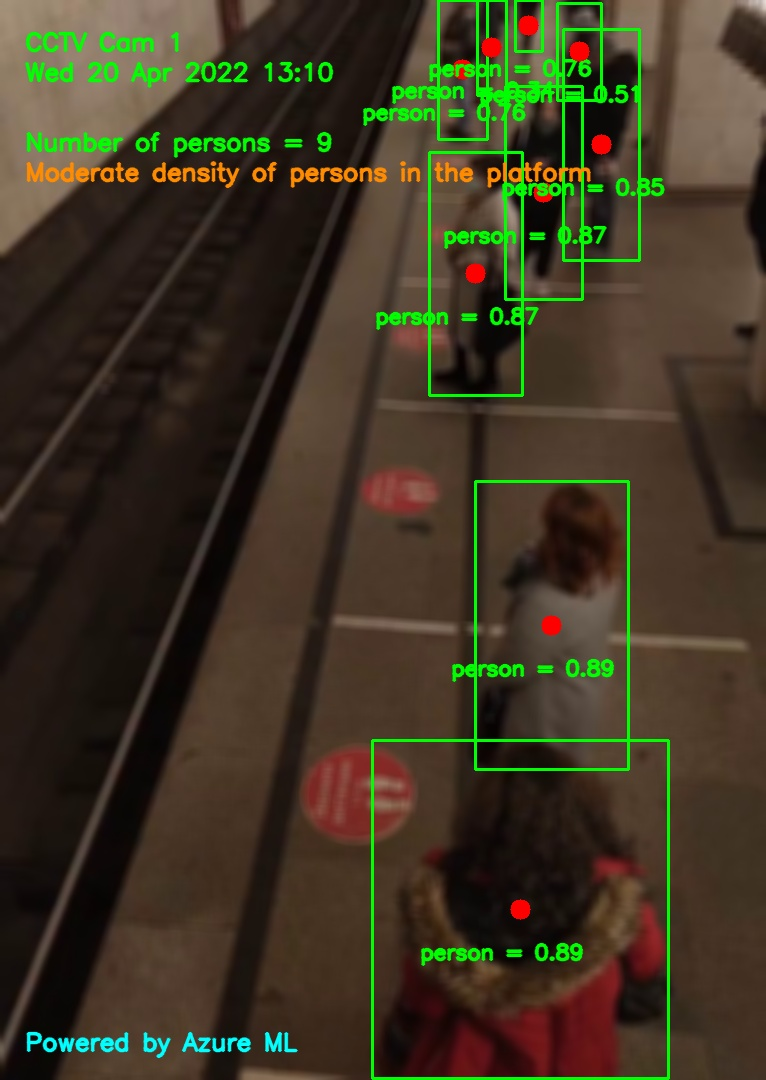

In [51]:
sample_frame = IMAGES_DIR + '/' + 'processed_frame_000000001.jpg'
image_info(sample_frame)
Image(filename=sample_frame, width=400) 

Image: images/processed_frame_000000120.jpg w = 766 h = 1080 c = 3 



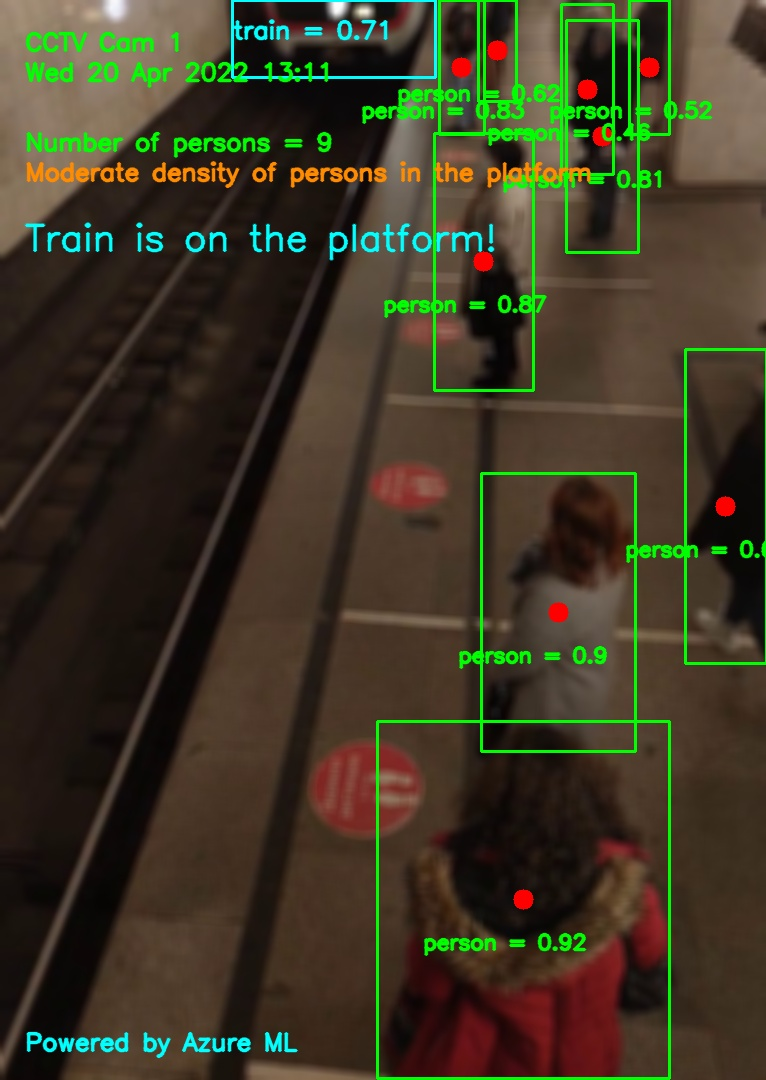

In [52]:
sample_frame = IMAGES_DIR + '/' + 'processed_frame_000000120.jpg'
image_info(sample_frame)
Image(filename=sample_frame, width=400) 

Image: images/processed_frame_000000700.jpg w = 766 h = 1080 c = 3 



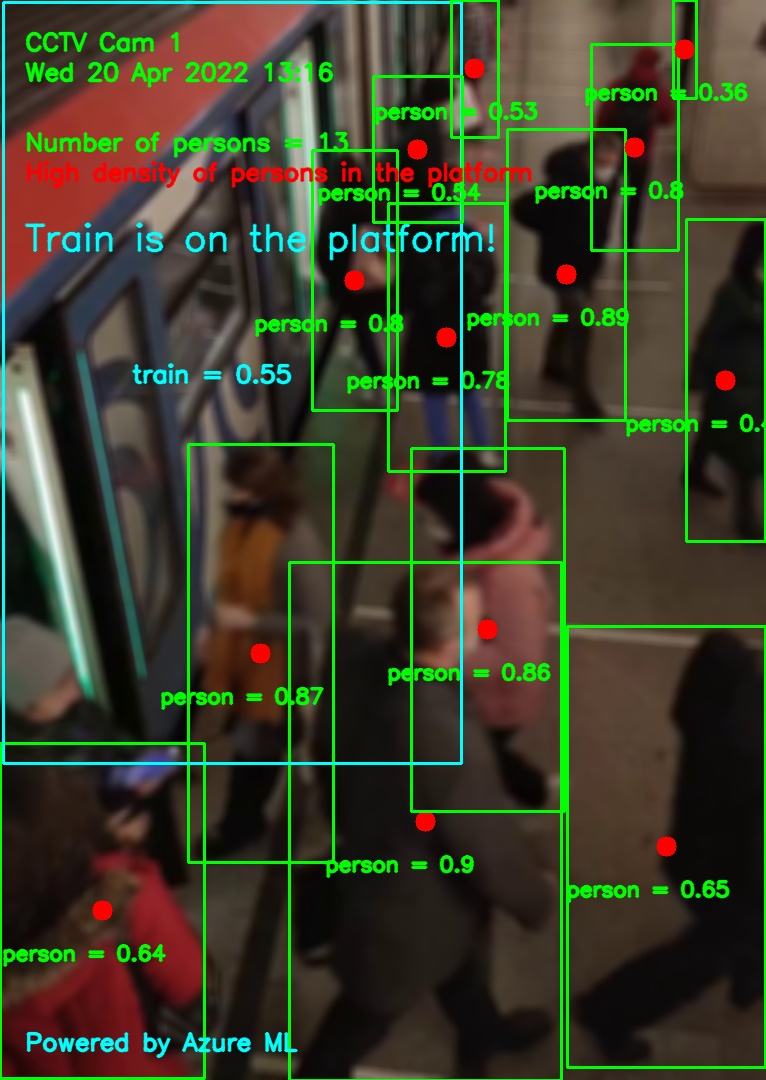

In [53]:
sample_frame = IMAGES_DIR + '/' + 'processed_frame_000000700.jpg'
image_info(sample_frame)
Image(filename=sample_frame, width=400)  

Image: images/processed_frame_000000770.jpg w = 766 h = 1080 c = 3 



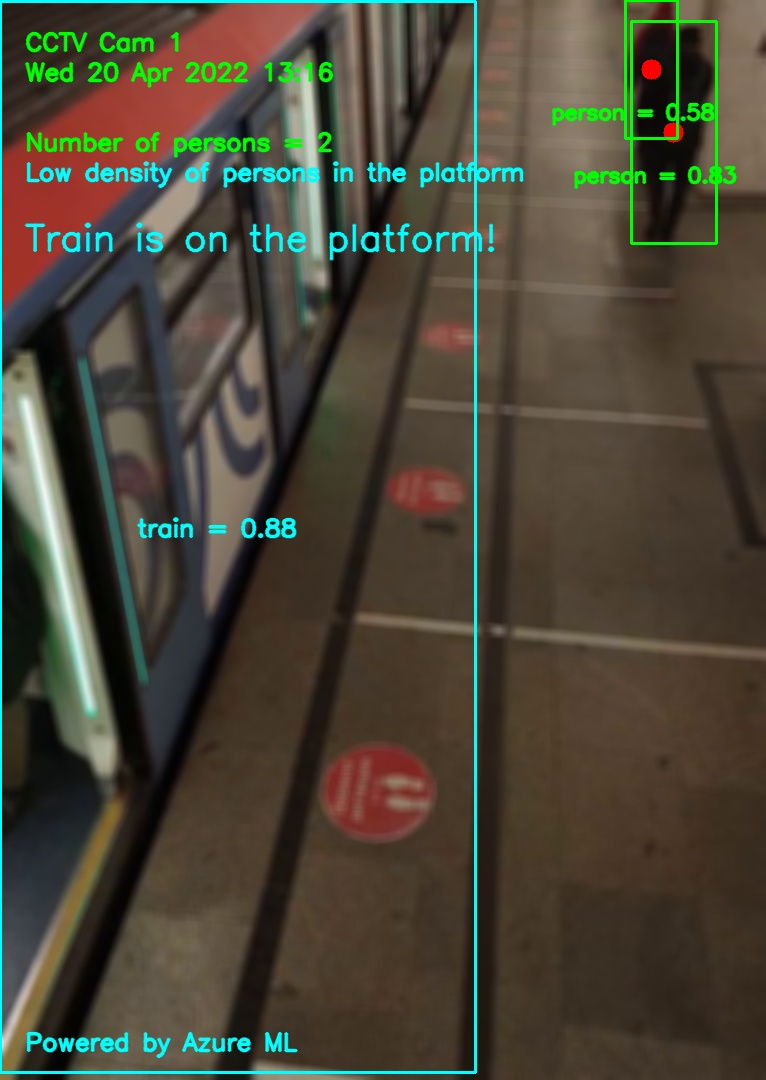

In [54]:
sample_frame = IMAGES_DIR + '/' + 'processed_frame_000000770.jpg'
image_info(sample_frame)
Image(filename=sample_frame, width=400) 

Image: images/processed_frame_000001049.jpg w = 766 h = 1080 c = 3 



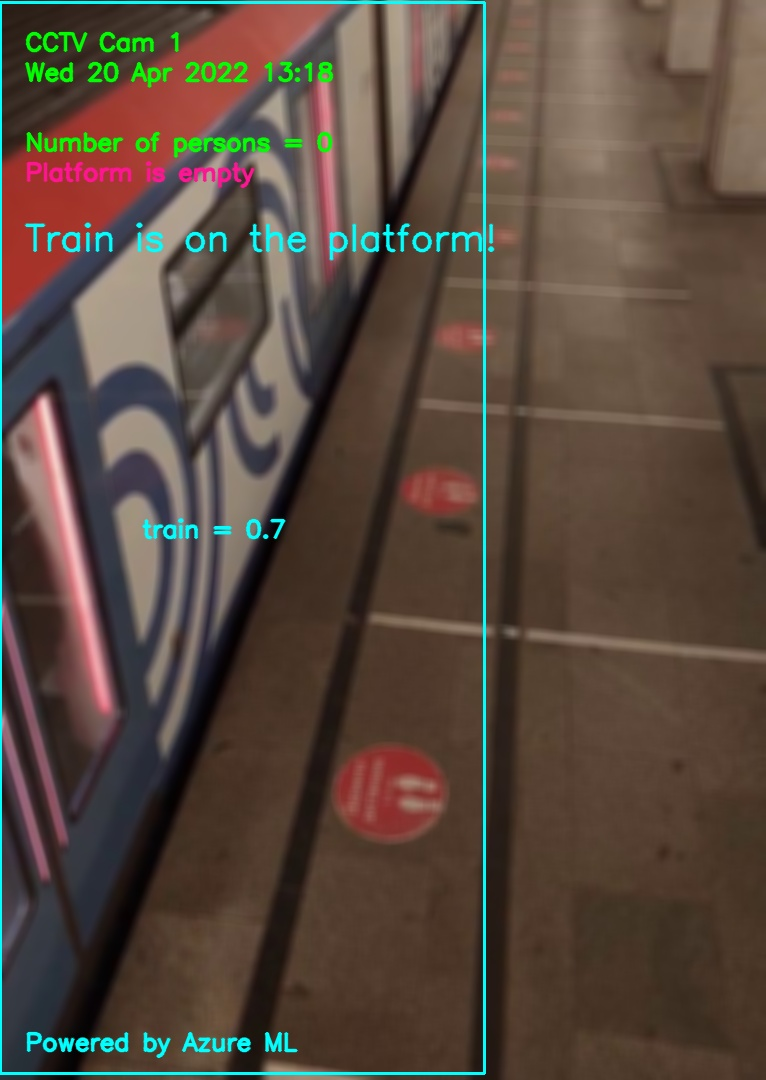

In [55]:
sample_frame = IMAGES_DIR + '/' + 'processed_frame_000001049.jpg'
image_info(sample_frame)
Image(filename=sample_frame, width=400) 

### 5.4 Saving the processed frames into a new video

In [56]:
video_output = 'processed_' + os.path.basename(SAMPLEVIDEO_FILENAME) # should be a MP4 file
nbfiles(IMAGES_DIR)

Directory: images has 1049 files
Directory: images/captures has 1049 files


In [57]:
print("Let's save the processed video into the directory:", RESULTS_DIR)

import moviepy.video.io.ImageSequenceClip
t1 = datetime.datetime.now()

fps_output = 25 # FPS for the video to generate
video_outputfilename = RESULTS_DIR + '/' + video_output # result video file

print("Building video file:", video_outputfilename, '\n')
image_files = [os.path.join(IMAGES_DIR, img)

for img in os.listdir(IMAGES_DIR) if img.endswith(".jpg")]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps = fps_output)
print("Writing video file...")
clip.write_videofile(video_outputfilename)

print('\nDone in:', datetime.datetime.now() - t1)

Let's save the processed video into the directory: results
Building video file: results/processed_sample_subway.mp4 

Writing video file...
Moviepy - Building video results/processed_sample_subway.mp4.
Moviepy - Writing video results/processed_sample_subway.mp4



Moviepy - Done !
Moviepy - video ready results/processed_sample_subway.mp4

Done in: 0:01:25.339864


In [58]:
!ls results/*.* -lth

-rwxrwxrwx 1 root root 9.2M Apr 20 13:23 results/processed_sample_subway.mp4
-rwxrwxrwx 1 root root 8.4M Apr 20 13:08 results/sample_subway.mp4


In [60]:
from moviepy.editor import *
t1 = datetime.datetime.now()

FINAL_CLIP = RESULTS_DIR + '/final.mp4' # Video to generate

print("Let's concatenate the two videos side by side into", FINAL_CLIP, '...', '\n')
clip1 = VideoFileClip(SAMPLEVIDEO_FILENAME) # Initial video
clip2 = VideoFileClip(video_outputfilename) # Processed video
clips = [[clip1, clip2]] # side by side videos
sidebyside_clips = clips_array(clips)
sidebyside_clips.write_videofile(FINAL_CLIP)
print("\nVideo file is available:", FINAL_CLIP)
print('\nDone in:', datetime.datetime.now() - t1)

Let's concatenate the two videos side by side into results/final.mp4 ... 

Moviepy - Building video results/final.mp4.
MoviePy - Writing audio in finalTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video results/final.mp4



t: 100%|█████████▉| 1048/1051 [00:36<00:00, 29.76it/s, now=None]/anaconda/envs/azureml_py38/lib/python3.8/site-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file results/sample_subway.mp4, 2481840 bytes wanted but 0 bytes read,at frame 1050/1051, at time 42.00/42.03 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready results/final.mp4

Video file is available: results/final.mp4

Done in: 0:00:38.325508


In [61]:
!ls results/*.* -lth

-rwxrwxrwx 1 root root  18M Apr 20 13:25 results/final.mp4
-rwxrwxrwx 1 root root 9.2M Apr 20 13:23 results/processed_sample_subway.mp4
-rwxrwxrwx 1 root root 8.4M Apr 20 13:08 results/sample_subway.mp4


In [67]:
#from IPython.display import Video
#Video(FINAL_CLIP, embed = True, width = 600)

### 5.5 Metrics have been saved into an Azure ML experiment

In [65]:
experiment

Name,Workspace,Report Page,Docs Page
TrainPlatform,azuremlvision,Link to Azure Machine Learning studio,Link to Documentation


> End